# 1D CNN with Laplace Beltrami Spectrum

## Binary Classification: Males vs. Females

Here we are going to see if we can create a 1 dimensional convolutional neural network that can classify a subject as male or female based on the shape (LB spectrum) of their white matter tracts.

The initial set up will be very similar to the MLP as we want the data to remain as a 1D vector. The main changes will be the types of layers in the actual network.

### Import libraries
First, let's import the libraries we will use.

In [27]:
#to read in the data
import pickle
#for plotting, numbers etc.
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
#for splitting the data
from sklearn.model_selection import train_test_split
#keras functions
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv1D, GlobalAveragePooling1D, MaxPooling1D
from keras.utils import np_utils, plot_model, to_categorical
from keras.optimizers import Adam, RMSprop

#normalize the data
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegressionCV 

### Import and check the data
Now let's read in the data using pickle. The data was previously processed in python and saved down using pickle. This will be the same steps as used in the MLP notebook so I will not include as many comments

In [28]:
# eigenvalue dictionary with entry for eact tract, 600 evs per tract
tractev_dict_600 = pickle.load(open("tract_ev_dict_600.pk",'rb'))
# list of tracts we want to use
tractstouse = pickle.load(open('tractstouse.pk','rb'))
# subject list
HCP_subj_list = pickle.load(open('HCP_subj_list.pk','rb'))
# list of subject gender 1 = male, 2 = female
gender_id = pickle.load(open('gender_id.pk','rb'))

### Preprocess the data

The eigenvalue data is already in a vector format, so we do not need to vectorize it. However, we will need to combine the vectors of all the tracts so that we have a single 1D vector per subject. 

We also need to normalize the data so that each set of eigenvalues has a mean of 0 and a standard deviation of 1. We will write a function to do this using sklearn's `StandardScaler` function.

**Normalize the data**

In [29]:
def scale_ev_dict(ev_dict):
    scaled_dict = {}
    for tract in ev_dict.keys():
        scaler = StandardScaler()
        scaled_dict[tract] = scaler.fit_transform(ev_dict[tract])
    return scaled_dict


In [30]:
# normalize all of the tracts so that each ev is centered on 0.
tractev_dict_600_scaled = scale_ev_dict(tractev_dict_600)

**Reorganize the data**

Currently the data is a dictionary of 2D matrices, we want to reorganize this into a single 2D matrix with the shape `(1013, n * 48)`, where 1013 is the number of subjects and n is the number of eigenvalues we are using. This is not the final shape we want for the convolutional layers, but it is the shape we want for now so that we can use the lgoistic regression classifier as a comparison. It is likely that 600 eigenvalues is way more than we need, but we do not know how many eigenvalues is optimal. We will write a function to do this reorganization so we can easily try multiple amounts of eigenvalues if necessary. We will start with just 200 eigenvalues for all tracts.

In [31]:
# change the organization to be one vector per subject with all evs for all tracts
def reorganize_spectrums(ev_dict_scaled, numev, HCP_subj_list=HCP_subj_list, tractstouse=tractstouse):
    # create an empty numpy array of the shape we want
    # numev is the number of eigenvalues we want per tract
    allsubjs_alltracts_scaled = np.zeros([len(HCP_subj_list), numev*len(tractstouse)])
    for i in range(len(tractstouse)):
        allsubjs_alltracts_scaled[:, i*numev:i*numev+numev] = ev_dict_scaled[tractstouse[i]][:, 0:numev]
    return allsubjs_alltracts_scaled

In [32]:
numev=200
allsubjs_alltracts_scaled = reorganize_spectrums(tractev_dict_600_scaled, numev)

**One hot encode the labels**

To one hot encode these labels all we need to do is simply subtract 1 from every entry. Now 0 = male and 1 = female

In [33]:
# one-hot encoding for the gender ID
genderid_ohe = np.asarray(gender_id) - 1

**Check datatype**

Finally, we need to make sure all inputs are of datatype `float32`

In [34]:
allsubjs_alltracts_scaled = allsubjs_alltracts_scaled.astype('float32')
genderid_ohe = genderid_ohe.astype('float32')

### Split the data

The input data is now preprocessed and ready to be input into a neural network. However, we first have to split the data into training, validation, and testing sets. We do not have a ton of samples, so we will try splitting the data into 3 subsets first and then explore other cross validation options if necessary.

In [49]:
X = allsubjs_alltracts_scaled
Y = genderid_ohe

#first split the training/validation data from the testing data
trainvalX, testX, trainvalY, testY = train_test_split(X, Y, train_size  = .8, test_size = .2, random_state=0)

print len(trainvalX) 
print len(testX)

810
203


In [50]:
#second split the validation data from the training data
trainX, valX, trainY, valY = train_test_split(trainvalX, trainvalY, train_size  = .75, test_size = .25, random_state=0)

print len(trainX)
print len(valX)

607
203


Now we have 3 subsets of data. Training data with 607 samples, validation data with 203 samples, and testing data with 203 samples. Again, this may be too few samples for training and if so we can employ other cross validation methods.

### Try Logistic Regression Classifier from sklearn for comparison

One of the reasons we are trying deep learning with this data is to see if we can improve upon 'basic' machine learning algorithms. We have already looked at this with the MLP notebook, but let's run the classification with the logistic regression classifier again as a reminder. We will train and evaluate the training and validation splits as well as the training/val and testing splits. 

In [38]:
#train on training data
lr = LogisticRegressionCV()
lr.fit(trainX, trainY)

#evaluate with validation data
print("Accuracy = {:.2f}".format(lr.score(valX, valY)))

Accuracy = 0.81


In [51]:
#train on training and validation data
lr = LogisticRegressionCV()
lr.fit(trainvalX, trainvalY)

#evaluate with validation data
print("Accuracy = {:.2f}".format(lr.score(testX, testY)))

Accuracy = 0.80


### Set up the 1D CNN

Our goal is to try and train a 1D CNN to get an accuracy value higher than 81% (for validation) or 80% (for final testing). 

As we saw before, we can plot the history of the accuracy and loss as the model trains, let's define that function here.

In [39]:
def plot_history(network_history):
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(network_history.history['loss'])
    plt.plot(network_history.history['val_loss'])
    plt.legend(['Training','Validation'])
    
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Acc')
    plt.plot(network_history.history['acc'])
    plt.plot(network_history.history['val_acc'])
    plt.legend(['Training','Validation'])
    plt.show()

### Reshape the data for CNN layers

Now we need to change the shape again to be a 3D array instead of a 2D array. We need each subject to have their own 2D array. The final shape will be (num subjects, num total eigenvalues, 1). 

If this were a sequence it would be (num samples, num timestamps, num features per timestamp). I find it helps with understanding the shape if you think about the data in terms of timestamps, even though it is not sequential data. 

Another way we could format the data is by splitting each tract into its own feature, rather than combining them all into one. In that case, the shape would be (num subjects, num eigenvalues per tract, num tracts). Each tract is a feature, and each eigenvalue is a timestamp. 

In [53]:
trainX = trainX.reshape(trainX.shape[0], trainX.shape[1], 1)
print trainX.shape
valX = valX.reshape(valX.shape[0], valX.shape[1], 1)
print valX.shape
testX = testX.reshape(testX.shape[0], testX.shape[1], 1)
print testX.shape
trainvalX = trainvalX.reshape(trainvalX.shape[0], trainvalX.shape[1], 1)
print trainvalX.shape

(607, 9600, 1)
(203, 9600, 1)
(203, 9600, 1)
(810, 9600, 1)


Let's try a simple network architecture from the 1D CNN example from Keras.

Train on 607 samples, validate on 203 samples
Epoch 1/20
607/607 [==============================] - 2s 4ms/step - loss: 0.6322 - acc: 0.6442 - val_loss: 0.5807 - val_acc: 0.6847
Epoch 2/20
607/607 [==============================] - 1s 2ms/step - loss: 0.5960 - acc: 0.6969 - val_loss: 0.6018 - val_acc: 0.6404
Epoch 3/20
607/607 [==============================] - 1s 2ms/step - loss: 0.5873 - acc: 0.7068 - val_loss: 0.5357 - val_acc: 0.7340
Epoch 4/20
607/607 [==============================] - 1s 2ms/step - loss: 0.6137 - acc: 0.6540 - val_loss: 0.5645 - val_acc: 0.7094
Epoch 5/20
607/607 [==============================] - 1s 2ms/step - loss: 0.5923 - acc: 0.6722 - val_loss: 0.5597 - val_acc: 0.7044
Epoch 6/20
607/607 [==============================] - 1s 2ms/step - loss: 0.5914 - acc: 0.6903 - val_loss: 0.5344 - val_acc: 0.7438
Epoch 7/20
607/607 [==============================] - 1s 2ms/step - loss: 0.5890 - acc: 0.6985 - val_loss: 0.5449 - val_acc: 0.7488
Epoch 8/20
607/607 [==========

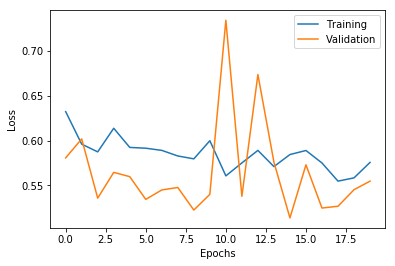

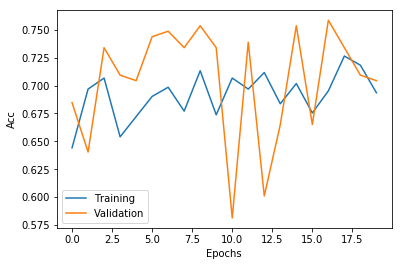

In [15]:
model = Sequential()
model.add(Conv1D(64, 3, activation='relu', input_shape=(trainX.shape[1], 1)))
model.add(Conv1D(64, 3, activation='relu'))
model.add(MaxPooling1D(3))
model.add(Conv1D(64, 3, activation='relu'))
model.add(Conv1D(64, 3, activation='relu'))
model.add(GlobalAveragePooling1D())
model.add(Dropout(.5))
model.add(Dense(1, activation='sigmoid'))
    
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(trainX, trainY, epochs=20, batch_size=10, validation_data=(valX, valY))

plot_history(history)


The best accuracy was 75%, which is not bad, but we can see some weird behavior around 10 and 12 epochs. The accuracy drops significantly, maybe due to the drop out?

Let's make a function to make and fit the model so we can manually tune some of the parameters.

In [36]:
# hidden_units = 64
# kernel_size = 3
# dropout = .5
# optim = 'adam'
# epochs = 20
# batch = 10

def make_model(hidden_units, kernel_size, dropout, optim, epochs, batch):
    model = Sequential()
    model.add(Conv1D(hidden_units, kernel_size, activation='relu', input_shape=(trainX.shape[1], 1)))
    model.add(Conv1D(hidden_units, kernel_size, activation='relu'))
    model.add(MaxPooling1D(kernel_size))
    model.add(Conv1D(hidden_units, kernel_size, activation='relu'))
    model.add(Conv1D(hidden_units, kernel_size, activation='relu'))
    model.add(GlobalAveragePooling1D())
    model.add(Dropout(dropout))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer=optim, loss='binary_crossentropy', metrics=['accuracy'])

    history = model.fit(trainX, trainY, epochs=epochs, batch_size=batch, validation_data=(valX, valY))

    plot_history(history)

Let's try increasing the number of hidden units, reducing dropout, as well as adjusting the learning rate of the optimizer. 

Train on 607 samples, validate on 203 samples
Epoch 1/40
607/607 [==============================] - 4s 7ms/step - loss: 0.6905 - acc: 0.5997 - val_loss: 0.6894 - val_acc: 0.4975
Epoch 2/40
607/607 [==============================] - 4s 6ms/step - loss: 0.6848 - acc: 0.5667 - val_loss: 0.6853 - val_acc: 0.5074
Epoch 3/40
607/607 [==============================] - 4s 6ms/step - loss: 0.6785 - acc: 0.5717 - val_loss: 0.6807 - val_acc: 0.5074
Epoch 4/40
607/607 [==============================] - 4s 6ms/step - loss: 0.6711 - acc: 0.5832 - val_loss: 0.6753 - val_acc: 0.5222
Epoch 5/40
607/607 [==============================] - 4s 6ms/step - loss: 0.6642 - acc: 0.5750 - val_loss: 0.6696 - val_acc: 0.5222
Epoch 6/40
607/607 [==============================] - 4s 6ms/step - loss: 0.6564 - acc: 0.5799 - val_loss: 0.6630 - val_acc: 0.5517
Epoch 7/40
607/607 [==============================] - 4s 6ms/step - loss: 0.6479 - acc: 0.6063 - val_loss: 0.6526 - val_acc: 0.5961
Epoch 8/40
607/607 [==========

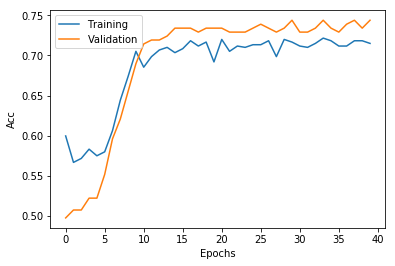

In [18]:
hidden_units = 200
kernel_size = 3
dropout = .1
optim = Adam(lr=0.00001)
epochs = 40
batch = 10
make_model(hidden_units, kernel_size, dropout, optim, epochs, batch)

After trying a few different combinations of paramters, we can't seem to do better than 75%. We may need to change the model architecture. 

Let's also try adding regularization. 

In [13]:
from keras import backend as K
import gc

In [14]:
#sometimes python does not release memory very well on its own, these help clear memory
K.clear_session()
gc.collect()

12

In [41]:
from keras.regularizers import l1, l2, l1_l2

It may be that the global pooling layer is reducing the data too much. Let's try removing that layer. If we do not have a global pooling layer, we need to insert a **Flatten** layer to flatten the convolutional output into a shape the final dense layer can read.

Train on 607 samples, validate on 203 samples
Epoch 1/40
607/607 [==============================] - 2s 3ms/step - loss: 31.1056 - acc: 0.5651 - val_loss: 29.9435 - val_acc: 0.5862
Epoch 2/40
607/607 [==============================] - 1s 2ms/step - loss: 29.0248 - acc: 0.6557 - val_loss: 28.0210 - val_acc: 0.6798
Epoch 3/40
607/607 [==============================] - 1s 2ms/step - loss: 27.1476 - acc: 0.7199 - val_loss: 26.2018 - val_acc: 0.6798
Epoch 4/40
607/607 [==============================] - 1s 2ms/step - loss: 25.3655 - acc: 0.7512 - val_loss: 24.4291 - val_acc: 0.7882
Epoch 5/40
607/607 [==============================] - 1s 2ms/step - loss: 23.6510 - acc: 0.7776 - val_loss: 22.8032 - val_acc: 0.7340
Epoch 6/40
607/607 [==============================] - 1s 2ms/step - loss: 22.0358 - acc: 0.7710 - val_loss: 21.1986 - val_acc: 0.8030
Epoch 7/40
607/607 [==============================] - 1s 2ms/step - loss: 20.4988 - acc: 0.8072 - val_loss: 19.6915 - val_acc: 0.8128
Epoch 8/40
607/6

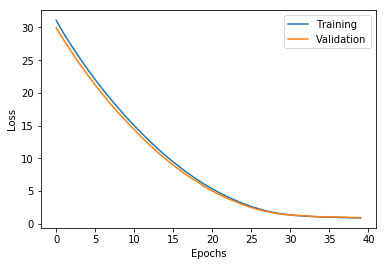

In [21]:
hidden_units = 64
kernel_size = 5
dropout = .7
optim = RMSprop(lr=0.0001)
epochs = 40
batch = 20

model = Sequential()
model.add(Conv1D(hidden_units, kernel_size, activation='relu', input_shape=(trainX.shape[1], 1), kernel_regularizer=l1_l2(.01)))
model.add(Conv1D(hidden_units, kernel_size, activation='relu', kernel_regularizer=l1_l2(.01)))
model.add(MaxPooling1D(kernel_size))
model.add(Dropout(dropout))
model.add(Conv1D(hidden_units, kernel_size, activation='relu', kernel_regularizer=l1_l2(.01)))
model.add(Conv1D(hidden_units, kernel_size, activation='relu', kernel_regularizer=l1_l2(.01)))
# model.add(GlobalAveragePooling1D())
model.add(Dropout(dropout))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=optim, loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(trainX, trainY, epochs=epochs, batch_size=batch, validation_data=(valX, valY))

plot_history(history)

Removing the global pooling layer helped. We were able to reach a best accuracy of 84%.

Let's try some other combinations of parameters and see if we can do better

Train on 607 samples, validate on 203 samples
Epoch 1/60
607/607 [==============================] - 4s 7ms/step - loss: 8.0603 - acc: 0.5453 - val_loss: 7.8564 - val_acc: 0.5222
Epoch 2/60
607/607 [==============================] - 2s 3ms/step - loss: 7.6691 - acc: 0.6326 - val_loss: 7.4812 - val_acc: 0.6798
Epoch 3/60
607/607 [==============================] - 2s 3ms/step - loss: 7.2724 - acc: 0.6969 - val_loss: 7.1241 - val_acc: 0.6355
Epoch 4/60
607/607 [==============================] - 2s 3ms/step - loss: 6.8969 - acc: 0.7529 - val_loss: 6.7389 - val_acc: 0.7488
Epoch 5/60
607/607 [==============================] - 2s 3ms/step - loss: 6.5494 - acc: 0.7809 - val_loss: 6.4391 - val_acc: 0.7143
Epoch 6/60
607/607 [==============================] - 2s 3ms/step - loss: 6.2346 - acc: 0.7924 - val_loss: 6.1224 - val_acc: 0.7586
Epoch 7/60
607/607 [==============================] - 2s 3ms/step - loss: 5.9385 - acc: 0.8221 - val_loss: 5.8495 - val_acc: 0.7685
Epoch 8/60
607/607 [==========

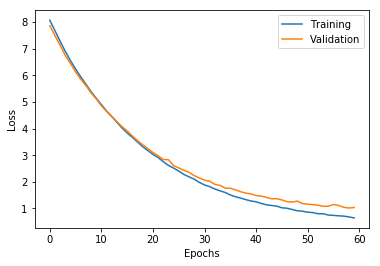

In [55]:
hidden_units = 100
kernel_size = 3
dropout = .8
optim = Adam(lr=0.0001)
epochs = 60
batch = 20

model = Sequential()
model.add(Conv1D(hidden_units, kernel_size, activation='relu', input_shape=(trainX.shape[1], 1), kernel_regularizer=l1_l2(.001)))
model.add(Conv1D(hidden_units, kernel_size, activation='relu', kernel_regularizer=l1_l2(.001)))
model.add(MaxPooling1D(kernel_size))
model.add(Dropout(dropout))
model.add(Conv1D(hidden_units, kernel_size, activation='relu', kernel_regularizer=l1_l2(.001)))
model.add(Conv1D(hidden_units, kernel_size, activation='relu', kernel_regularizer=l1_l2(.001)))
model.add(MaxPooling1D(kernel_size))
model.add(Flatten())
model.add(Dropout(dropout))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=optim, loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(trainX, trainY, epochs=epochs, batch_size=batch, validation_data=(valX, valY))

plot_history(history)

The highest accuracy we are getting is still 84%. Let's set up a grid search to find the best hyperparameters. 

In [46]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV

def make_model_compile(hidden_units, kernel_size, dropout, optim, epochs, batch, reg):
    model = Sequential()
    model.add(Conv1D(hidden_units, kernel_size, activation='relu', input_shape=(trainvalX.shape[1], 1), kernel_regularizer=l1_l2(reg)))
    model.add(Conv1D(hidden_units, kernel_size, activation='relu', kernel_regularizer=l1_l2(reg)))
    model.add(MaxPooling1D(kernel_size))
    model.add(Dropout(dropout))
    model.add(Conv1D(hidden_units, kernel_size, activation='relu', kernel_regularizer=l1_l2(reg)))
    model.add(Conv1D(hidden_units, kernel_size, activation='relu', kernel_regularizer=l1_l2(reg)))
    model.add(Flatten())
    model.add(Dropout(dropout))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer=optim, loss='binary_crossentropy', metrics=['accuracy'])
    return model


In [54]:
my_classifier = KerasClassifier(make_model_compile)

#define the grid search 
validator = GridSearchCV(my_classifier,
                         param_grid={'hidden_units': [32, 64],
                                     'kernel_size': [3,5],
                                     'dropout': [0.3, 0.5, 0.7], 
                                     'optim': [RMSprop(lr=.001), RMSprop(lr=.0001),RMSprop(lr=.00001)], 
                                     'epochs':[10,20,40], 
                                     'batch': [10,15,20],
                                     'reg': [0.01,0.001,0.0001]},
                                    scoring='accuracy')
validator.fit(trainvalX, trainvalY) 

Epoch 1/10
540/540 [==============================] - 2s 4ms/step - loss: 8.8385 - acc: 0.6278
Epoch 2/10
540/540 [==============================] - 0s 811us/step - loss: 7.1702 - acc: 0.7333
Epoch 3/10
540/540 [==============================] - 0s 806us/step - loss: 5.9339 - acc: 0.7833
Epoch 4/10
540/540 [==============================] - 0s 795us/step - loss: 4.8046 - acc: 0.8148
Epoch 5/10
540/540 [==============================] - 0s 801us/step - loss: 3.8284 - acc: 0.8352
Epoch 6/10
540/540 [==============================] - 0s 804us/step - loss: 2.9752 - acc: 0.8630
Epoch 7/10
540/540 [==============================] - 0s 798us/step - loss: 2.3062 - acc: 0.8500
Epoch 8/10
540/540 [==============================] - 0s 799us/step - loss: 1.7397 - acc: 0.8741
Epoch 9/10
540/540 [==============================] - 0s 797us/step - loss: 1.3026 - acc: 0.8778
Epoch 10/10
540/540 [==============================] - 0s 797us/step - loss: 0.9985 - acc: 0.8870
Epoch 1/10
540/540 [===========

540/540 [==============================] - 0s 809us/step - loss: 0.8895 - acc: 0.8389
Epoch 6/10
540/540 [==============================] - 0s 803us/step - loss: 0.7817 - acc: 0.8500
Epoch 7/10
540/540 [==============================] - 0s 805us/step - loss: 0.6621 - acc: 0.8759
Epoch 8/10
540/540 [==============================] - 0s 804us/step - loss: 0.5788 - acc: 0.8778
Epoch 9/10
540/540 [==============================] - 0s 808us/step - loss: 0.5448 - acc: 0.8778
Epoch 10/10
540/540 [==============================] - 0s 799us/step - loss: 0.4811 - acc: 0.9000
Epoch 1/10
540/540 [==============================] - 1s 2ms/step - loss: 9.7909 - acc: 0.6315
Epoch 2/10
540/540 [==============================] - 0s 811us/step - loss: 9.5189 - acc: 0.7500
Epoch 3/10
540/540 [==============================] - 0s 809us/step - loss: 9.3118 - acc: 0.7833
Epoch 4/10
540/540 [==============================] - 0s 810us/step - loss: 9.1149 - acc: 0.8093
Epoch 5/10
540/540 [======================

540/540 [==============================] - 0s 808us/step - loss: 1.2598 - acc: 0.8630
Epoch 10/10
540/540 [==============================] - 0s 809us/step - loss: 1.2337 - acc: 0.8481
Epoch 1/10
540/540 [==============================] - 2s 3ms/step - loss: 1.7256 - acc: 0.5667
Epoch 2/10
540/540 [==============================] - 0s 799us/step - loss: 1.6267 - acc: 0.7315
Epoch 3/10
540/540 [==============================] - 0s 809us/step - loss: 1.5405 - acc: 0.7870
Epoch 4/10
540/540 [==============================] - 0s 808us/step - loss: 1.4803 - acc: 0.7778
Epoch 5/10
540/540 [==============================] - 0s 810us/step - loss: 1.4503 - acc: 0.7704
Epoch 6/10
540/540 [==============================] - 0s 804us/step - loss: 1.3998 - acc: 0.7981
Epoch 7/10
540/540 [==============================] - 0s 806us/step - loss: 1.3638 - acc: 0.8204
Epoch 8/10
540/540 [==============================] - 0s 805us/step - loss: 1.3294 - acc: 0.8352
Epoch 9/10
540/540 [======================

540/540 [==============================] - 0s 814us/step - loss: 1.7378 - acc: 0.5907
Epoch 4/10
540/540 [==============================] - 0s 817us/step - loss: 1.7304 - acc: 0.6315
Epoch 5/10
540/540 [==============================] - 0s 819us/step - loss: 1.7247 - acc: 0.6167
Epoch 6/10
540/540 [==============================] - 0s 814us/step - loss: 1.7159 - acc: 0.6611
Epoch 7/10
540/540 [==============================] - 0s 811us/step - loss: 1.7075 - acc: 0.6852
Epoch 8/10
540/540 [==============================] - 0s 815us/step - loss: 1.6962 - acc: 0.7093
Epoch 9/10
540/540 [==============================] - 0s 813us/step - loss: 1.6883 - acc: 0.7185
Epoch 10/10
540/540 [==============================] - 0s 808us/step - loss: 1.6743 - acc: 0.7463
Epoch 1/10
540/540 [==============================] - 2s 4ms/step - loss: 1.7410 - acc: 0.5463
Epoch 2/10
540/540 [==============================] - 0s 820us/step - loss: 1.7300 - acc: 0.5463
Epoch 3/10
540/540 [======================

540/540 [==============================] - 0s 718us/step - loss: 0.6378 - acc: 0.8556
Epoch 8/10
540/540 [==============================] - 0s 715us/step - loss: 0.5795 - acc: 0.8796
Epoch 9/10
540/540 [==============================] - 0s 713us/step - loss: 0.4833 - acc: 0.9037
Epoch 10/10
540/540 [==============================] - 0s 717us/step - loss: 0.4639 - acc: 0.8870
Epoch 1/10
540/540 [==============================] - 2s 4ms/step - loss: 1.5205 - acc: 0.6296
Epoch 2/10
540/540 [==============================] - 0s 711us/step - loss: 1.1762 - acc: 0.7519
Epoch 3/10
540/540 [==============================] - 0s 707us/step - loss: 1.0161 - acc: 0.7759
Epoch 4/10
540/540 [==============================] - 0s 704us/step - loss: 0.8152 - acc: 0.8204
Epoch 5/10
540/540 [==============================] - 0s 711us/step - loss: 0.7479 - acc: 0.7944
Epoch 6/10
540/540 [==============================] - 0s 707us/step - loss: 0.6563 - acc: 0.8222
Epoch 7/10
540/540 [======================

540/540 [==============================] - 3s 5ms/step - loss: 1.7414 - acc: 0.6130
Epoch 2/10
540/540 [==============================] - 0s 715us/step - loss: 1.6430 - acc: 0.7426
Epoch 3/10
540/540 [==============================] - 0s 714us/step - loss: 1.5482 - acc: 0.7648
Epoch 4/10
540/540 [==============================] - 0s 722us/step - loss: 1.4807 - acc: 0.7889
Epoch 5/10
540/540 [==============================] - 0s 719us/step - loss: 1.4319 - acc: 0.7833
Epoch 6/10
540/540 [==============================] - 0s 720us/step - loss: 1.3907 - acc: 0.7833
Epoch 7/10
540/540 [==============================] - 0s 717us/step - loss: 1.3611 - acc: 0.8019
Epoch 8/10
540/540 [==============================] - 0s 721us/step - loss: 1.3223 - acc: 0.8037
Epoch 9/10
540/540 [==============================] - 0s 719us/step - loss: 1.2964 - acc: 0.8056
Epoch 10/10
540/540 [==============================] - 0s 718us/step - loss: 1.2727 - acc: 0.8259
Epoch 1/10
540/540 [======================

540/540 [==============================] - 0s 716us/step - loss: 2.6912 - acc: 0.5519
Epoch 6/10
540/540 [==============================] - 0s 717us/step - loss: 2.6797 - acc: 0.5463
Epoch 7/10
540/540 [==============================] - 0s 716us/step - loss: 2.6729 - acc: 0.5444
Epoch 8/10
540/540 [==============================] - 0s 722us/step - loss: 2.6637 - acc: 0.5667
Epoch 9/10
540/540 [==============================] - 0s 732us/step - loss: 2.6534 - acc: 0.5852
Epoch 10/10
540/540 [==============================] - 0s 725us/step - loss: 2.6472 - acc: 0.5611
Epoch 1/10
540/540 [==============================] - 3s 6ms/step - loss: 1.7772 - acc: 0.5537
Epoch 2/10
540/540 [==============================] - 0s 722us/step - loss: 1.7698 - acc: 0.5963
Epoch 3/10
540/540 [==============================] - 0s 726us/step - loss: 1.7632 - acc: 0.5815
Epoch 4/10
540/540 [==============================] - 0s 719us/step - loss: 1.7626 - acc: 0.5759
Epoch 5/10
540/540 [======================

540/540 [==============================] - 1s 2ms/step - loss: 0.6200 - acc: 0.8852
Epoch 1/10
540/540 [==============================] - 4s 7ms/step - loss: 4.6315 - acc: 0.5815
Epoch 2/10
540/540 [==============================] - 1s 2ms/step - loss: 3.5849 - acc: 0.7167
Epoch 3/10
540/540 [==============================] - 1s 2ms/step - loss: 2.9023 - acc: 0.8037
Epoch 4/10
540/540 [==============================] - 1s 2ms/step - loss: 2.3167 - acc: 0.8167
Epoch 5/10
540/540 [==============================] - 1s 2ms/step - loss: 1.8253 - acc: 0.8407
Epoch 6/10
540/540 [==============================] - 1s 2ms/step - loss: 1.4034 - acc: 0.8426
Epoch 7/10
540/540 [==============================] - 1s 2ms/step - loss: 1.0863 - acc: 0.8759
Epoch 8/10
540/540 [==============================] - 1s 2ms/step - loss: 0.8940 - acc: 0.8722
Epoch 9/10
540/540 [==============================] - 1s 2ms/step - loss: 0.7709 - acc: 0.8852
Epoch 10/10
540/540 [==============================] - 1s 2ms

Epoch 6/10
540/540 [==============================] - 1s 2ms/step - loss: 4.0265 - acc: 0.8315
Epoch 7/10
540/540 [==============================] - 1s 2ms/step - loss: 3.9220 - acc: 0.8481
Epoch 8/10
540/540 [==============================] - 1s 2ms/step - loss: 3.8111 - acc: 0.8537
Epoch 9/10
540/540 [==============================] - 1s 2ms/step - loss: 3.6992 - acc: 0.8648
Epoch 10/10
540/540 [==============================] - 1s 2ms/step - loss: 3.5838 - acc: 0.8926
Epoch 1/10
540/540 [==============================] - 4s 8ms/step - loss: 4.8166 - acc: 0.6148
Epoch 2/10
540/540 [==============================] - 1s 2ms/step - loss: 4.5763 - acc: 0.7370
Epoch 3/10
540/540 [==============================] - 1s 2ms/step - loss: 4.4066 - acc: 0.7889
Epoch 4/10
540/540 [==============================] - 1s 2ms/step - loss: 4.2862 - acc: 0.8000
Epoch 5/10
540/540 [==============================] - 1s 2ms/step - loss: 4.1570 - acc: 0.8222
Epoch 6/10
540/540 [=============================

540/540 [==============================] - 5s 9ms/step - loss: 4.9284 - acc: 0.5426
Epoch 2/10
540/540 [==============================] - 1s 2ms/step - loss: 4.9031 - acc: 0.5481
Epoch 3/10
540/540 [==============================] - 1s 2ms/step - loss: 4.8832 - acc: 0.6056
Epoch 4/10
540/540 [==============================] - 1s 2ms/step - loss: 4.8581 - acc: 0.5889
Epoch 5/10
540/540 [==============================] - 1s 2ms/step - loss: 4.8361 - acc: 0.6704
Epoch 6/10
540/540 [==============================] - 1s 2ms/step - loss: 4.8130 - acc: 0.6926
Epoch 7/10
540/540 [==============================] - 1s 2ms/step - loss: 4.7923 - acc: 0.7315
Epoch 8/10
540/540 [==============================] - 1s 2ms/step - loss: 4.7677 - acc: 0.7444
Epoch 9/10
540/540 [==============================] - 1s 2ms/step - loss: 4.7462 - acc: 0.7370
Epoch 10/10
540/540 [==============================] - 1s 2ms/step - loss: 4.7244 - acc: 0.7778
Epoch 1/10
540/540 [==============================] - 5s 9ms

540/540 [==============================] - 1s 1ms/step - loss: 0.8430 - acc: 0.8407
Epoch 8/10
540/540 [==============================] - 1s 1ms/step - loss: 0.7176 - acc: 0.8426
Epoch 9/10
540/540 [==============================] - 1s 1ms/step - loss: 0.6406 - acc: 0.8593
Epoch 10/10
540/540 [==============================] - 1s 1ms/step - loss: 0.5776 - acc: 0.8630
Epoch 1/10
540/540 [==============================] - 5s 9ms/step - loss: 4.9286 - acc: 0.6370
Epoch 2/10
540/540 [==============================] - 1s 1ms/step - loss: 3.6777 - acc: 0.7185
Epoch 3/10
540/540 [==============================] - 1s 1ms/step - loss: 2.7810 - acc: 0.7630
Epoch 4/10
540/540 [==============================] - 1s 1ms/step - loss: 1.9989 - acc: 0.7944
Epoch 5/10
540/540 [==============================] - 1s 1ms/step - loss: 1.4088 - acc: 0.8056
Epoch 6/10
540/540 [==============================] - 1s 1ms/step - loss: 0.9984 - acc: 0.8519
Epoch 7/10
540/540 [==============================] - 1s 1ms

540/540 [==============================] - 1s 1ms/step - loss: 5.1042 - acc: 0.7704
Epoch 3/10
540/540 [==============================] - 1s 1ms/step - loss: 4.9123 - acc: 0.7759
Epoch 4/10
540/540 [==============================] - 1s 1ms/step - loss: 4.7353 - acc: 0.8148
Epoch 5/10
540/540 [==============================] - 1s 1ms/step - loss: 4.5772 - acc: 0.8204
Epoch 6/10
540/540 [==============================] - 1s 1ms/step - loss: 4.4210 - acc: 0.8278
Epoch 7/10
540/540 [==============================] - 1s 1ms/step - loss: 4.2749 - acc: 0.8426
Epoch 8/10
540/540 [==============================] - 1s 1ms/step - loss: 4.1367 - acc: 0.8444
Epoch 9/10
540/540 [==============================] - 1s 1ms/step - loss: 4.0074 - acc: 0.8444
Epoch 10/10
540/540 [==============================] - 1s 1ms/step - loss: 3.8883 - acc: 0.8556
Epoch 1/10
540/540 [==============================] - 5s 10ms/step - loss: 5.3910 - acc: 0.6593
Epoch 2/10
540/540 [==============================] - 1s 1m

540/540 [==============================] - 1s 1ms/step - loss: 31.6302 - acc: 0.7593
Epoch 8/10
540/540 [==============================] - 1s 1ms/step - loss: 31.5133 - acc: 0.7407
Epoch 9/10
540/540 [==============================] - 1s 1ms/step - loss: 31.3945 - acc: 0.7519
Epoch 10/10
540/540 [==============================] - 1s 1ms/step - loss: 31.2787 - acc: 0.7481
Epoch 1/10
540/540 [==============================] - 6s 11ms/step - loss: 5.6118 - acc: 0.5630
Epoch 2/10
540/540 [==============================] - 1s 1ms/step - loss: 5.5862 - acc: 0.5611
Epoch 3/10
540/540 [==============================] - 1s 1ms/step - loss: 5.5598 - acc: 0.5704
Epoch 4/10
540/540 [==============================] - 1s 1ms/step - loss: 5.5354 - acc: 0.5981
Epoch 5/10
540/540 [==============================] - 1s 1ms/step - loss: 5.5100 - acc: 0.5944
Epoch 6/10
540/540 [==============================] - 1s 1ms/step - loss: 5.4843 - acc: 0.6111
Epoch 7/10
540/540 [==============================] - 1

540/540 [==============================] - 0s 849us/step - loss: 7.0843 - acc: 0.7574
Epoch 3/20
540/540 [==============================] - 0s 855us/step - loss: 5.8165 - acc: 0.7963
Epoch 4/20
540/540 [==============================] - 0s 851us/step - loss: 4.6973 - acc: 0.8185
Epoch 5/20
540/540 [==============================] - 0s 855us/step - loss: 3.7451 - acc: 0.8111
Epoch 6/20
540/540 [==============================] - 0s 856us/step - loss: 2.8875 - acc: 0.8593
Epoch 7/20
540/540 [==============================] - 0s 855us/step - loss: 2.2303 - acc: 0.8556
Epoch 8/20
540/540 [==============================] - 0s 844us/step - loss: 1.7079 - acc: 0.8185
Epoch 9/20
540/540 [==============================] - 0s 836us/step - loss: 1.2615 - acc: 0.8611
Epoch 10/20
540/540 [==============================] - 0s 846us/step - loss: 0.9809 - acc: 0.8630
Epoch 11/20
540/540 [==============================] - 0s 847us/step - loss: 0.8184 - acc: 0.8778
Epoch 12/20
540/540 [==================

540/540 [==============================] - 0s 840us/step - loss: 0.9817 - acc: 0.8426
Epoch 7/20
540/540 [==============================] - 0s 838us/step - loss: 0.8500 - acc: 0.8741
Epoch 8/20
540/540 [==============================] - 0s 840us/step - loss: 0.7434 - acc: 0.8741
Epoch 9/20
540/540 [==============================] - 0s 843us/step - loss: 0.6777 - acc: 0.8685
Epoch 10/20
540/540 [==============================] - 0s 840us/step - loss: 0.5620 - acc: 0.8981
Epoch 11/20
540/540 [==============================] - 0s 843us/step - loss: 0.5520 - acc: 0.9019
Epoch 12/20
540/540 [==============================] - 0s 841us/step - loss: 0.4625 - acc: 0.9222
Epoch 13/20
540/540 [==============================] - 0s 843us/step - loss: 0.4682 - acc: 0.9148
Epoch 14/20
540/540 [==============================] - 0s 845us/step - loss: 0.4173 - acc: 0.9278
Epoch 15/20
540/540 [==============================] - 0s 846us/step - loss: 0.3760 - acc: 0.9463
Epoch 16/20
540/540 [==============

540/540 [==============================] - 0s 851us/step - loss: 7.9924 - acc: 0.8296
Epoch 11/20
540/540 [==============================] - 0s 851us/step - loss: 7.8394 - acc: 0.8352
Epoch 12/20
540/540 [==============================] - 0s 853us/step - loss: 7.6951 - acc: 0.8296
Epoch 13/20
540/540 [==============================] - 0s 857us/step - loss: 7.5388 - acc: 0.8370
Epoch 14/20
540/540 [==============================] - 0s 858us/step - loss: 7.3862 - acc: 0.8426
Epoch 15/20
540/540 [==============================] - 0s 852us/step - loss: 7.2487 - acc: 0.8593
Epoch 16/20
540/540 [==============================] - 0s 848us/step - loss: 7.0993 - acc: 0.8704
Epoch 17/20
540/540 [==============================] - 0s 846us/step - loss: 6.9570 - acc: 0.8593
Epoch 18/20
540/540 [==============================] - 0s 857us/step - loss: 6.8198 - acc: 0.8685
Epoch 19/20
540/540 [==============================] - 0s 848us/step - loss: 6.6815 - acc: 0.8778
Epoch 20/20
540/540 [===========

540/540 [==============================] - 0s 858us/step - loss: 1.7504 - acc: 0.8722
Epoch 15/20
540/540 [==============================] - 0s 852us/step - loss: 1.7267 - acc: 0.8796
Epoch 16/20
540/540 [==============================] - 0s 853us/step - loss: 1.6875 - acc: 0.8889
Epoch 17/20
540/540 [==============================] - 0s 855us/step - loss: 1.6797 - acc: 0.8852
Epoch 18/20
540/540 [==============================] - 0s 857us/step - loss: 1.6293 - acc: 0.8926
Epoch 19/20
540/540 [==============================] - 0s 861us/step - loss: 1.6139 - acc: 0.8889
Epoch 20/20
540/540 [==============================] - 0s 855us/step - loss: 1.5883 - acc: 0.9037
Epoch 1/20
540/540 [==============================] - 6s 12ms/step - loss: 2.4450 - acc: 0.5741
Epoch 2/20
540/540 [==============================] - 0s 860us/step - loss: 2.3320 - acc: 0.7370
Epoch 3/20
540/540 [==============================] - 0s 852us/step - loss: 2.2399 - acc: 0.7815
Epoch 4/20
540/540 [================

540/540 [==============================] - 0s 846us/step - loss: 1.0242 - acc: 0.8926
Epoch 19/20
540/540 [==============================] - 0s 846us/step - loss: 1.0107 - acc: 0.9000
Epoch 20/20
540/540 [==============================] - 0s 844us/step - loss: 0.9815 - acc: 0.8963
Epoch 1/20
540/540 [==============================] - 7s 12ms/step - loss: 9.8526 - acc: 0.5778
Epoch 2/20
540/540 [==============================] - 0s 854us/step - loss: 9.8240 - acc: 0.6204
Epoch 3/20
540/540 [==============================] - 0s 844us/step - loss: 9.7885 - acc: 0.6500
Epoch 4/20
540/540 [==============================] - 0s 855us/step - loss: 9.7642 - acc: 0.6889
Epoch 5/20
540/540 [==============================] - 0s 840us/step - loss: 9.7375 - acc: 0.6981
Epoch 6/20
540/540 [==============================] - 0s 847us/step - loss: 9.7128 - acc: 0.7389
Epoch 7/20
540/540 [==============================] - 0s 854us/step - loss: 9.6883 - acc: 0.7111
Epoch 8/20
540/540 [====================

540/540 [==============================] - 0s 850us/step - loss: 2.4677 - acc: 0.5963
Epoch 3/20
540/540 [==============================] - 0s 855us/step - loss: 2.4492 - acc: 0.6778
Epoch 4/20
540/540 [==============================] - 0s 857us/step - loss: 2.4367 - acc: 0.6796
Epoch 5/20
540/540 [==============================] - 0s 857us/step - loss: 2.4322 - acc: 0.6685
Epoch 6/20
540/540 [==============================] - 0s 855us/step - loss: 2.4096 - acc: 0.7185
Epoch 7/20
540/540 [==============================] - 0s 856us/step - loss: 2.3924 - acc: 0.7574
Epoch 8/20
540/540 [==============================] - 0s 856us/step - loss: 2.3819 - acc: 0.7500
Epoch 9/20
540/540 [==============================] - 0s 880us/step - loss: 2.3728 - acc: 0.7556
Epoch 10/20
540/540 [==============================] - 0s 861us/step - loss: 2.3629 - acc: 0.7593
Epoch 11/20
540/540 [==============================] - 0s 862us/step - loss: 2.3446 - acc: 0.7630
Epoch 12/20
540/540 [==================

540/540 [==============================] - 0s 856us/step - loss: 1.7014 - acc: 0.7037
Epoch 7/20
540/540 [==============================] - 0s 862us/step - loss: 1.6928 - acc: 0.7204
Epoch 8/20
540/540 [==============================] - 0s 861us/step - loss: 1.6822 - acc: 0.7167
Epoch 9/20
540/540 [==============================] - 0s 866us/step - loss: 1.6704 - acc: 0.7333
Epoch 10/20
540/540 [==============================] - 0s 853us/step - loss: 1.6614 - acc: 0.7333
Epoch 11/20
540/540 [==============================] - 0s 866us/step - loss: 1.6512 - acc: 0.7648
Epoch 12/20
540/540 [==============================] - 0s 865us/step - loss: 1.6406 - acc: 0.7444
Epoch 13/20
540/540 [==============================] - 0s 860us/step - loss: 1.6299 - acc: 0.7852
Epoch 14/20
540/540 [==============================] - 0s 850us/step - loss: 1.6188 - acc: 0.7685
Epoch 15/20
540/540 [==============================] - 0s 847us/step - loss: 1.6094 - acc: 0.7759
Epoch 16/20
540/540 [==============

540/540 [==============================] - 0s 751us/step - loss: 0.5428 - acc: 0.8852
Epoch 11/20
540/540 [==============================] - 0s 749us/step - loss: 0.4687 - acc: 0.9093
Epoch 12/20
540/540 [==============================] - 0s 749us/step - loss: 0.4701 - acc: 0.8833
Epoch 13/20
540/540 [==============================] - 0s 738us/step - loss: 0.4373 - acc: 0.8944
Epoch 14/20
540/540 [==============================] - 0s 751us/step - loss: 0.4129 - acc: 0.9167
Epoch 15/20
540/540 [==============================] - 0s 749us/step - loss: 0.3911 - acc: 0.9167
Epoch 16/20
540/540 [==============================] - 0s 754us/step - loss: 0.3467 - acc: 0.9389
Epoch 17/20
540/540 [==============================] - 0s 752us/step - loss: 0.3509 - acc: 0.9222
Epoch 18/20
540/540 [==============================] - 0s 748us/step - loss: 0.3111 - acc: 0.9481
Epoch 19/20
540/540 [==============================] - 0s 750us/step - loss: 0.3502 - acc: 0.9315
Epoch 20/20
540/540 [===========

540/540 [==============================] - 0s 751us/step - loss: 0.3941 - acc: 0.8944
Epoch 15/20
540/540 [==============================] - 0s 743us/step - loss: 0.3305 - acc: 0.9259
Epoch 16/20
540/540 [==============================] - 0s 746us/step - loss: 0.3511 - acc: 0.9167
Epoch 17/20
540/540 [==============================] - 0s 745us/step - loss: 0.2337 - acc: 0.9741
Epoch 18/20
540/540 [==============================] - 0s 747us/step - loss: 0.2519 - acc: 0.9481
Epoch 19/20
540/540 [==============================] - 0s 745us/step - loss: 0.2922 - acc: 0.9241
Epoch 20/20
540/540 [==============================] - 0s 745us/step - loss: 0.1967 - acc: 0.9778
Epoch 1/20
540/540 [==============================] - 7s 13ms/step - loss: 1.6809 - acc: 0.6315
Epoch 2/20
540/540 [==============================] - 0s 766us/step - loss: 1.3241 - acc: 0.7352
Epoch 3/20
540/540 [==============================] - 0s 762us/step - loss: 1.0839 - acc: 0.8037
Epoch 4/20
540/540 [================

540/540 [==============================] - 0s 756us/step - loss: 7.9715 - acc: 0.8630
Epoch 18/20
540/540 [==============================] - 0s 754us/step - loss: 7.7583 - acc: 0.8574
Epoch 19/20
540/540 [==============================] - 0s 757us/step - loss: 7.5380 - acc: 0.8500
Epoch 20/20
540/540 [==============================] - 0s 762us/step - loss: 7.3219 - acc: 0.8685
Epoch 1/20
540/540 [==============================] - 7s 14ms/step - loss: 2.6508 - acc: 0.6315
Epoch 2/20
540/540 [==============================] - 0s 752us/step - loss: 2.5270 - acc: 0.7315
Epoch 3/20
540/540 [==============================] - 0s 765us/step - loss: 2.4157 - acc: 0.7833
Epoch 4/20
540/540 [==============================] - 0s 767us/step - loss: 2.3349 - acc: 0.7815
Epoch 5/20
540/540 [==============================] - 0s 766us/step - loss: 2.2618 - acc: 0.7926
Epoch 6/20
540/540 [==============================] - 0s 762us/step - loss: 2.2108 - acc: 0.8056
Epoch 7/20
540/540 [===================

540/540 [==============================] - 8s 14ms/step - loss: 1.7226 - acc: 0.5981
Epoch 2/20
540/540 [==============================] - 0s 765us/step - loss: 1.6372 - acc: 0.7259
Epoch 3/20
540/540 [==============================] - 0s 768us/step - loss: 1.5430 - acc: 0.7593
Epoch 4/20
540/540 [==============================] - 0s 757us/step - loss: 1.4699 - acc: 0.7796
Epoch 5/20
540/540 [==============================] - 0s 781us/step - loss: 1.4047 - acc: 0.8037
Epoch 6/20
540/540 [==============================] - 0s 746us/step - loss: 1.3684 - acc: 0.8000
Epoch 7/20
540/540 [==============================] - 0s 756us/step - loss: 1.3254 - acc: 0.8241
Epoch 8/20
540/540 [==============================] - 0s 759us/step - loss: 1.2873 - acc: 0.8333
Epoch 9/20
540/540 [==============================] - 0s 753us/step - loss: 1.2527 - acc: 0.8259
Epoch 10/20
540/540 [==============================] - 0s 756us/step - loss: 1.2207 - acc: 0.8389
Epoch 11/20
540/540 [====================

540/540 [==============================] - 0s 766us/step - loss: 12.1609 - acc: 0.6037
Epoch 5/20
540/540 [==============================] - 0s 759us/step - loss: 12.1325 - acc: 0.6185
Epoch 6/20
540/540 [==============================] - 0s 758us/step - loss: 12.0981 - acc: 0.6074
Epoch 7/20
540/540 [==============================] - 0s 761us/step - loss: 12.0687 - acc: 0.6148
Epoch 8/20
540/540 [==============================] - 0s 760us/step - loss: 12.0333 - acc: 0.6426
Epoch 9/20
540/540 [==============================] - 0s 756us/step - loss: 12.0030 - acc: 0.6500
Epoch 10/20
540/540 [==============================] - 0s 762us/step - loss: 11.9707 - acc: 0.6574
Epoch 11/20
540/540 [==============================] - 0s 756us/step - loss: 11.9366 - acc: 0.6815
Epoch 12/20
540/540 [==============================] - 0s 759us/step - loss: 11.9074 - acc: 0.6870
Epoch 13/20
540/540 [==============================] - 0s 768us/step - loss: 11.8753 - acc: 0.6944
Epoch 14/20
540/540 [======

Epoch 8/20
540/540 [==============================] - 0s 765us/step - loss: 1.7175 - acc: 0.6278
Epoch 9/20
540/540 [==============================] - 0s 755us/step - loss: 1.7094 - acc: 0.6241
Epoch 10/20
540/540 [==============================] - 0s 755us/step - loss: 1.7009 - acc: 0.6778
Epoch 11/20
540/540 [==============================] - 0s 761us/step - loss: 1.6902 - acc: 0.6963
Epoch 12/20
540/540 [==============================] - 0s 771us/step - loss: 1.6829 - acc: 0.6963
Epoch 13/20
540/540 [==============================] - 0s 767us/step - loss: 1.6762 - acc: 0.7074
Epoch 14/20
540/540 [==============================] - 0s 768us/step - loss: 1.6638 - acc: 0.7278
Epoch 15/20
540/540 [==============================] - 0s 772us/step - loss: 1.6610 - acc: 0.7407
Epoch 16/20
540/540 [==============================] - 0s 766us/step - loss: 1.6493 - acc: 0.7333
Epoch 17/20
540/540 [==============================] - 0s 771us/step - loss: 1.6400 - acc: 0.7426
Epoch 18/20
540/540 [=

540/540 [==============================] - 1s 2ms/step - loss: 0.7490 - acc: 0.8852
Epoch 13/20
540/540 [==============================] - 1s 2ms/step - loss: 0.7134 - acc: 0.8944
Epoch 14/20
540/540 [==============================] - 1s 2ms/step - loss: 0.6965 - acc: 0.8907
Epoch 15/20
540/540 [==============================] - 1s 2ms/step - loss: 0.6700 - acc: 0.9074
Epoch 16/20
540/540 [==============================] - 1s 2ms/step - loss: 0.6437 - acc: 0.9167
Epoch 17/20
540/540 [==============================] - 1s 2ms/step - loss: 0.6402 - acc: 0.9037
Epoch 18/20
540/540 [==============================] - 1s 2ms/step - loss: 0.6078 - acc: 0.9259
Epoch 19/20
540/540 [==============================] - 1s 2ms/step - loss: 0.5821 - acc: 0.9278
Epoch 20/20
540/540 [==============================] - 1s 2ms/step - loss: 0.5975 - acc: 0.9167
Epoch 1/20
540/540 [==============================] - 9s 16ms/step - loss: 22.3954 - acc: 0.6000
Epoch 2/20
540/540 [==============================]

540/540 [==============================] - 1s 2ms/step - loss: 0.2923 - acc: 0.9667
Epoch 17/20
540/540 [==============================] - 1s 2ms/step - loss: 0.3853 - acc: 0.9296
Epoch 18/20
540/540 [==============================] - 1s 2ms/step - loss: 0.3329 - acc: 0.9426
Epoch 19/20
540/540 [==============================] - 1s 2ms/step - loss: 0.2604 - acc: 0.9704
Epoch 20/20
540/540 [==============================] - 1s 2ms/step - loss: 0.2506 - acc: 0.9759
Epoch 1/20
540/540 [==============================] - 9s 16ms/step - loss: 2.7772 - acc: 0.5852
Epoch 2/20
540/540 [==============================] - 1s 2ms/step - loss: 2.0800 - acc: 0.7296
Epoch 3/20
540/540 [==============================] - 1s 2ms/step - loss: 1.6345 - acc: 0.8093
Epoch 4/20
540/540 [==============================] - 1s 2ms/step - loss: 1.3558 - acc: 0.8130
Epoch 5/20
540/540 [==============================] - 1s 2ms/step - loss: 1.1052 - acc: 0.8296
Epoch 6/20
540/540 [==============================] - 1s

540/540 [==============================] - 9s 17ms/step - loss: 25.2946 - acc: 0.6148
Epoch 2/20
540/540 [==============================] - 1s 2ms/step - loss: 24.4337 - acc: 0.7815
Epoch 3/20
540/540 [==============================] - 1s 2ms/step - loss: 23.7121 - acc: 0.8074
Epoch 4/20
540/540 [==============================] - 1s 2ms/step - loss: 23.0466 - acc: 0.8148
Epoch 5/20
540/540 [==============================] - 1s 2ms/step - loss: 22.4142 - acc: 0.8204
Epoch 6/20
540/540 [==============================] - 1s 2ms/step - loss: 21.7918 - acc: 0.8241
Epoch 7/20
540/540 [==============================] - 1s 2ms/step - loss: 21.1868 - acc: 0.8481
Epoch 8/20
540/540 [==============================] - 1s 2ms/step - loss: 20.5854 - acc: 0.8537
Epoch 9/20
540/540 [==============================] - 1s 2ms/step - loss: 19.9906 - acc: 0.8426
Epoch 10/20
540/540 [==============================] - 1s 2ms/step - loss: 19.4079 - acc: 0.8593
Epoch 11/20
540/540 [============================

540/540 [==============================] - 1s 2ms/step - loss: 4.0222 - acc: 0.8259
Epoch 7/20
540/540 [==============================] - 1s 2ms/step - loss: 3.9066 - acc: 0.8426
Epoch 8/20
540/540 [==============================] - 1s 2ms/step - loss: 3.7938 - acc: 0.8574
Epoch 9/20
540/540 [==============================] - 1s 2ms/step - loss: 3.6800 - acc: 0.8870
Epoch 10/20
540/540 [==============================] - 1s 2ms/step - loss: 3.5807 - acc: 0.8630A: 0s - loss: 3.5997 
Epoch 11/20
540/540 [==============================] - 1s 2ms/step - loss: 3.4753 - acc: 0.8722
Epoch 12/20
540/540 [==============================] - 1s 2ms/step - loss: 3.3754 - acc: 0.8833
Epoch 13/20
540/540 [==============================] - 1s 2ms/step - loss: 3.2852 - acc: 0.9019
Epoch 14/20
540/540 [==============================] - 1s 2ms/step - loss: 3.1765 - acc: 0.9000
Epoch 15/20
540/540 [==============================] - 1s 2ms/step - loss: 3.0955 - acc: 0.9074
Epoch 16/20
540/540 [=============

540/540 [==============================] - 1s 2ms/step - loss: 24.9328 - acc: 0.7611
Epoch 11/20
540/540 [==============================] - 1s 2ms/step - loss: 24.8581 - acc: 0.7778
Epoch 12/20
540/540 [==============================] - 1s 2ms/step - loss: 24.7794 - acc: 0.7889
Epoch 13/20
540/540 [==============================] - 1s 2ms/step - loss: 24.7078 - acc: 0.7815
Epoch 14/20
540/540 [==============================] - 1s 2ms/step - loss: 24.6314 - acc: 0.7796
Epoch 15/20
540/540 [==============================] - 1s 2ms/step - loss: 24.5576 - acc: 0.7722
Epoch 16/20
540/540 [==============================] - 1s 2ms/step - loss: 24.4828 - acc: 0.7926
Epoch 17/20
540/540 [==============================] - 1s 2ms/step - loss: 24.4087 - acc: 0.7815
Epoch 18/20
540/540 [==============================] - 1s 2ms/step - loss: 24.3411 - acc: 0.7907
Epoch 19/20
540/540 [==============================] - 1s 2ms/step - loss: 24.2647 - acc: 0.7963
Epoch 20/20
540/540 [=====================

540/540 [==============================] - 1s 2ms/step - loss: 4.5835 - acc: 0.8056
Epoch 15/20
540/540 [==============================] - 1s 2ms/step - loss: 4.5639 - acc: 0.8056
Epoch 16/20
540/540 [==============================] - 1s 2ms/step - loss: 4.5434 - acc: 0.8093
Epoch 17/20
540/540 [==============================] - 1s 2ms/step - loss: 4.5226 - acc: 0.8222
Epoch 18/20
540/540 [==============================] - 1s 2ms/step - loss: 4.5048 - acc: 0.8222
Epoch 19/20
540/540 [==============================] - 1s 2ms/step - loss: 4.4869 - acc: 0.8278
Epoch 20/20
540/540 [==============================] - 1s 2ms/step - loss: 4.4660 - acc: 0.8204
Epoch 1/20
540/540 [==============================] - 10s 18ms/step - loss: 4.9482 - acc: 0.5463
Epoch 2/20
540/540 [==============================] - 1s 2ms/step - loss: 4.9236 - acc: 0.6130
Epoch 3/20
540/540 [==============================] - 1s 2ms/step - loss: 4.9035 - acc: 0.5889A: 0s - loss: 4.9157
Epoch 4/20
540/540 [=============

Epoch 19/20
540/540 [==============================] - 1s 2ms/step - loss: 2.5791 - acc: 0.7981
Epoch 20/20
540/540 [==============================] - 1s 2ms/step - loss: 2.5655 - acc: 0.7981
Epoch 1/20
540/540 [==============================] - 10s 18ms/step - loss: 25.5321 - acc: 0.6481
Epoch 2/20
540/540 [==============================] - 1s 1ms/step - loss: 16.5996 - acc: 0.7074
Epoch 3/20
540/540 [==============================] - 1s 1ms/step - loss: 10.2380 - acc: 0.7852
Epoch 4/20
540/540 [==============================] - 1s 1ms/step - loss: 5.7034 - acc: 0.7704
Epoch 5/20
540/540 [==============================] - 1s 1ms/step - loss: 2.7930 - acc: 0.7963
Epoch 6/20
540/540 [==============================] - 1s 1ms/step - loss: 1.5501 - acc: 0.8148
Epoch 7/20
540/540 [==============================] - 1s 1ms/step - loss: 1.2032 - acc: 0.8204
Epoch 8/20
540/540 [==============================] - 1s 1ms/step - loss: 1.0735 - acc: 0.8241
Epoch 9/20
540/540 [=======================

540/540 [==============================] - 1s 1ms/step - loss: 2.3117 - acc: 0.8000
Epoch 5/20
540/540 [==============================] - 1s 1ms/step - loss: 1.6897 - acc: 0.8241
Epoch 6/20
540/540 [==============================] - 1s 1ms/step - loss: 1.2623 - acc: 0.8370
Epoch 7/20
540/540 [==============================] - 1s 1ms/step - loss: 0.9946 - acc: 0.8352
Epoch 8/20
540/540 [==============================] - 1s 1ms/step - loss: 0.8356 - acc: 0.8444
Epoch 9/20
540/540 [==============================] - 1s 1ms/step - loss: 0.7185 - acc: 0.8704
Epoch 10/20
540/540 [==============================] - 1s 1ms/step - loss: 0.5979 - acc: 0.9000
Epoch 11/20
540/540 [==============================] - 1s 1ms/step - loss: 0.5777 - acc: 0.8778
Epoch 12/20
540/540 [==============================] - 1s 1ms/step - loss: 0.4828 - acc: 0.9204
Epoch 13/20
540/540 [==============================] - 1s 1ms/step - loss: 0.4394 - acc: 0.9259
Epoch 14/20
540/540 [==============================] - 1s

540/540 [==============================] - 1s 1ms/step - loss: 0.4524 - acc: 0.8907
Epoch 10/20
540/540 [==============================] - 1s 1ms/step - loss: 0.4408 - acc: 0.8852
Epoch 11/20
540/540 [==============================] - 1s 1ms/step - loss: 0.3517 - acc: 0.9148
Epoch 12/20
540/540 [==============================] - 1s 1ms/step - loss: 0.4292 - acc: 0.9000
Epoch 13/20
540/540 [==============================] - 1s 1ms/step - loss: 0.2557 - acc: 0.9685
Epoch 14/20
540/540 [==============================] - 1s 1ms/step - loss: 0.2268 - acc: 0.9648
Epoch 15/20
540/540 [==============================] - 1s 1ms/step - loss: 0.2391 - acc: 0.9648
Epoch 16/20
540/540 [==============================] - 1s 1ms/step - loss: 0.1691 - acc: 0.9944
Epoch 17/20
540/540 [==============================] - 1s 1ms/step - loss: 0.2790 - acc: 0.9611
Epoch 18/20
540/540 [==============================] - 1s 1ms/step - loss: 0.1487 - acc: 0.9944
Epoch 19/20
540/540 [==============================]

540/540 [==============================] - 1s 1ms/step - loss: 3.4688 - acc: 0.8889
Epoch 15/20
540/540 [==============================] - 1s 1ms/step - loss: 3.3650 - acc: 0.8944
Epoch 16/20
540/540 [==============================] - 1s 1ms/step - loss: 3.2407 - acc: 0.8889
Epoch 17/20
540/540 [==============================] - 1s 1ms/step - loss: 3.1411 - acc: 0.9000
Epoch 18/20
540/540 [==============================] - 1s 1ms/step - loss: 3.0387 - acc: 0.9037
Epoch 19/20
540/540 [==============================] - 1s 1ms/step - loss: 2.9274 - acc: 0.9167
Epoch 20/20
540/540 [==============================] - 1s 1ms/step - loss: 2.8240 - acc: 0.9241
Epoch 1/20
540/540 [==============================] - 10s 19ms/step - loss: 5.4718 - acc: 0.6019
Epoch 2/20
540/540 [==============================] - 1s 1ms/step - loss: 5.1783 - acc: 0.7537
Epoch 3/20
540/540 [==============================] - 1s 1ms/step - loss: 4.9346 - acc: 0.7630
Epoch 4/20
540/540 [==============================] -

540/540 [==============================] - 1s 1ms/step - loss: 1.4089 - acc: 0.9259
Epoch 20/20
540/540 [==============================] - 1s 1ms/step - loss: 1.3709 - acc: 0.9241
Epoch 1/20
540/540 [==============================] - 11s 20ms/step - loss: 2.8135 - acc: 0.6000
Epoch 2/20
540/540 [==============================] - 1s 1ms/step - loss: 2.6266 - acc: 0.7241
Epoch 3/20
540/540 [==============================] - 1s 1ms/step - loss: 2.4803 - acc: 0.7611
Epoch 4/20
540/540 [==============================] - 1s 1ms/step - loss: 2.3783 - acc: 0.7981
Epoch 5/20
540/540 [==============================] - 1s 1ms/step - loss: 2.2808 - acc: 0.8167
Epoch 6/20
540/540 [==============================] - 1s 1ms/step - loss: 2.2109 - acc: 0.7870
Epoch 7/20
540/540 [==============================] - 1s 1ms/step - loss: 2.1223 - acc: 0.8278
Epoch 8/20
540/540 [==============================] - 1s 1ms/step - loss: 2.0389 - acc: 0.8296
Epoch 9/20
540/540 [==============================] - 1s 1

540/540 [==============================] - 1s 1ms/step - loss: 5.5173 - acc: 0.5630
Epoch 5/20
540/540 [==============================] - 1s 1ms/step - loss: 5.4965 - acc: 0.5833
Epoch 6/20
540/540 [==============================] - 1s 1ms/step - loss: 5.4729 - acc: 0.5852
Epoch 7/20
540/540 [==============================] - 1s 1ms/step - loss: 5.4479 - acc: 0.5963
Epoch 8/20
540/540 [==============================] - 1s 1ms/step - loss: 5.4235 - acc: 0.6185
Epoch 9/20
540/540 [==============================] - 1s 1ms/step - loss: 5.3982 - acc: 0.6722
Epoch 10/20
540/540 [==============================] - 1s 1ms/step - loss: 5.3709 - acc: 0.6778
Epoch 11/20
540/540 [==============================] - 1s 1ms/step - loss: 5.3458 - acc: 0.6852
Epoch 12/20
540/540 [==============================] - 1s 1ms/step - loss: 5.3197 - acc: 0.7259
Epoch 13/20
540/540 [==============================] - 1s 1ms/step - loss: 5.2939 - acc: 0.7389
Epoch 14/20
540/540 [==============================] - 1s

540/540 [==============================] - 1s 1ms/step - loss: 2.7816 - acc: 0.7500
Epoch 10/20
540/540 [==============================] - 1s 1ms/step - loss: 2.7606 - acc: 0.7556
Epoch 11/20
540/540 [==============================] - 1s 1ms/step - loss: 2.7425 - acc: 0.7611
Epoch 12/20
540/540 [==============================] - 1s 1ms/step - loss: 2.7155 - acc: 0.8019
Epoch 13/20
540/540 [==============================] - 1s 1ms/step - loss: 2.6978 - acc: 0.7722
Epoch 14/20
540/540 [==============================] - 1s 1ms/step - loss: 2.6775 - acc: 0.7833
Epoch 15/20
540/540 [==============================] - 1s 1ms/step - loss: 2.6553 - acc: 0.7870
Epoch 16/20
540/540 [==============================] - 1s 1ms/step - loss: 2.6374 - acc: 0.7944
Epoch 17/20
540/540 [==============================] - 1s 1ms/step - loss: 2.6195 - acc: 0.7870
Epoch 18/20
540/540 [==============================] - 1s 1ms/step - loss: 2.6010 - acc: 0.8037
Epoch 19/20
540/540 [==============================]

540/540 [==============================] - 0s 892us/step - loss: 0.7110 - acc: 0.9019
Epoch 14/40
540/540 [==============================] - 0s 882us/step - loss: 0.6316 - acc: 0.9148
Epoch 15/40
540/540 [==============================] - 0s 891us/step - loss: 0.5839 - acc: 0.9333
Epoch 16/40
540/540 [==============================] - 0s 893us/step - loss: 0.5725 - acc: 0.9204
Epoch 17/40
540/540 [==============================] - 0s 891us/step - loss: 0.5340 - acc: 0.9259
Epoch 18/40
540/540 [==============================] - 0s 901us/step - loss: 0.4901 - acc: 0.9352
Epoch 19/40
540/540 [==============================] - 0s 885us/step - loss: 0.5136 - acc: 0.9037
Epoch 20/40
540/540 [==============================] - 0s 909us/step - loss: 0.4614 - acc: 0.9556
Epoch 21/40
540/540 [==============================] - 0s 896us/step - loss: 0.4338 - acc: 0.9574
Epoch 22/40
540/540 [==============================] - 0s 896us/step - loss: 0.4450 - acc: 0.9463
Epoch 23/40
540/540 [===========

540/540 [==============================] - 0s 889us/step - loss: 0.3956 - acc: 0.9556
Epoch 17/40
540/540 [==============================] - 0s 897us/step - loss: 0.3698 - acc: 0.9537
Epoch 18/40
540/540 [==============================] - 0s 892us/step - loss: 0.3315 - acc: 0.9648
Epoch 19/40
540/540 [==============================] - 0s 895us/step - loss: 0.3683 - acc: 0.9370
Epoch 20/40
540/540 [==============================] - 0s 903us/step - loss: 0.3265 - acc: 0.9537
Epoch 21/40
540/540 [==============================] - 0s 895us/step - loss: 0.3051 - acc: 0.9648
Epoch 22/40
540/540 [==============================] - 0s 904us/step - loss: 0.2738 - acc: 0.9722
Epoch 23/40
540/540 [==============================] - 0s 901us/step - loss: 0.2361 - acc: 0.9889
Epoch 24/40
540/540 [==============================] - 0s 900us/step - loss: 0.2547 - acc: 0.9704
Epoch 25/40
540/540 [==============================] - 0s 898us/step - loss: 0.2792 - acc: 0.9593
Epoch 26/40
540/540 [===========

540/540 [==============================] - 0s 883us/step - loss: 0.2733 - acc: 0.9574
Epoch 20/40
540/540 [==============================] - 0s 890us/step - loss: 0.2935 - acc: 0.9444
Epoch 21/40
540/540 [==============================] - 0s 885us/step - loss: 0.2563 - acc: 0.9741
Epoch 22/40
540/540 [==============================] - 0s 877us/step - loss: 0.2439 - acc: 0.9648
Epoch 23/40
540/540 [==============================] - 0s 881us/step - loss: 0.2094 - acc: 0.9833
Epoch 24/40
540/540 [==============================] - 0s 890us/step - loss: 0.2173 - acc: 0.9778
Epoch 25/40
540/540 [==============================] - 0s 886us/step - loss: 0.1791 - acc: 0.9907
Epoch 26/40
540/540 [==============================] - 0s 889us/step - loss: 0.2517 - acc: 0.9630
Epoch 27/40
540/540 [==============================] - 0s 889us/step - loss: 0.1630 - acc: 0.9963
Epoch 28/40
540/540 [==============================] - 0s 889us/step - loss: 0.2202 - acc: 0.9667
Epoch 29/40
540/540 [===========

540/540 [==============================] - 0s 878us/step - loss: 0.1816 - acc: 0.9778
Epoch 23/40
540/540 [==============================] - 0s 873us/step - loss: 0.2442 - acc: 0.9556
Epoch 24/40
540/540 [==============================] - 0s 895us/step - loss: 0.1514 - acc: 0.9907
Epoch 25/40
540/540 [==============================] - 0s 905us/step - loss: 0.1323 - acc: 0.9963
Epoch 26/40
540/540 [==============================] - 0s 899us/step - loss: 0.2393 - acc: 0.9667
Epoch 27/40
540/540 [==============================] - 0s 905us/step - loss: 0.1305 - acc: 0.9944
Epoch 28/40
540/540 [==============================] - 0s 894us/step - loss: 0.2273 - acc: 0.9685
Epoch 29/40
540/540 [==============================] - 0s 895us/step - loss: 0.1176 - acc: 0.9963
Epoch 30/40
540/540 [==============================] - 0s 896us/step - loss: 0.1241 - acc: 0.9907
Epoch 31/40
540/540 [==============================] - 0s 897us/step - loss: 0.1422 - acc: 0.9852
Epoch 32/40
540/540 [===========

540/540 [==============================] - 0s 887us/step - loss: 5.9882 - acc: 0.9167
Epoch 26/40
540/540 [==============================] - 0s 888us/step - loss: 5.8603 - acc: 0.9148
Epoch 27/40
540/540 [==============================] - 0s 893us/step - loss: 5.7417 - acc: 0.9222
Epoch 28/40
540/540 [==============================] - 0s 890us/step - loss: 5.6169 - acc: 0.9204
Epoch 29/40
540/540 [==============================] - 0s 896us/step - loss: 5.4944 - acc: 0.9296
Epoch 30/40
540/540 [==============================] - 0s 898us/step - loss: 5.3838 - acc: 0.9259
Epoch 31/40
540/540 [==============================] - 0s 901us/step - loss: 5.2826 - acc: 0.9204
Epoch 32/40
540/540 [==============================] - 0s 902us/step - loss: 5.1578 - acc: 0.9296
Epoch 33/40
540/540 [==============================] - 0s 892us/step - loss: 5.0568 - acc: 0.9241
Epoch 34/40
540/540 [==============================] - 0s 890us/step - loss: 4.9368 - acc: 0.9481
Epoch 35/40
540/540 [===========

540/540 [==============================] - 0s 890us/step - loss: 5.5321 - acc: 0.9204
Epoch 29/40
540/540 [==============================] - 0s 887us/step - loss: 5.4138 - acc: 0.9204
Epoch 30/40
540/540 [==============================] - 0s 893us/step - loss: 5.2975 - acc: 0.9259
Epoch 31/40
540/540 [==============================] - 0s 902us/step - loss: 5.1864 - acc: 0.9204
Epoch 32/40
540/540 [==============================] - 0s 895us/step - loss: 5.0647 - acc: 0.9296
Epoch 33/40
540/540 [==============================] - 0s 892us/step - loss: 4.9504 - acc: 0.9389
Epoch 34/40
540/540 [==============================] - 0s 889us/step - loss: 4.8362 - acc: 0.9389
Epoch 35/40
540/540 [==============================] - 0s 891us/step - loss: 4.7276 - acc: 0.9315
Epoch 36/40
540/540 [==============================] - 0s 895us/step - loss: 4.6160 - acc: 0.9444
Epoch 37/40
540/540 [==============================] - 0s 899us/step - loss: 4.5081 - acc: 0.9481
Epoch 38/40
540/540 [===========

540/540 [==============================] - 0s 905us/step - loss: 1.2332 - acc: 0.9444
Epoch 32/40
540/540 [==============================] - 0s 902us/step - loss: 1.2006 - acc: 0.9537
Epoch 33/40
540/540 [==============================] - 0s 905us/step - loss: 1.1788 - acc: 0.9519
Epoch 34/40
540/540 [==============================] - 0s 908us/step - loss: 1.1576 - acc: 0.9556
Epoch 35/40
540/540 [==============================] - 0s 904us/step - loss: 1.1446 - acc: 0.9481
Epoch 36/40
540/540 [==============================] - 0s 906us/step - loss: 1.1126 - acc: 0.9630
Epoch 37/40
540/540 [==============================] - 0s 903us/step - loss: 1.0911 - acc: 0.9667
Epoch 38/40
540/540 [==============================] - 0s 906us/step - loss: 1.0722 - acc: 0.9648
Epoch 39/40
540/540 [==============================] - 0s 899us/step - loss: 1.0490 - acc: 0.9722 0s - loss: 1.0545 - acc: 
Epoch 40/40
540/540 [==============================] - 0s 899us/step - loss: 1.0244 - acc: 0.9667
Epoch 

540/540 [==============================] - 0s 895us/step - loss: 0.7265 - acc: 0.9648
Epoch 35/40
540/540 [==============================] - 0s 895us/step - loss: 0.7051 - acc: 0.9704
Epoch 36/40
540/540 [==============================] - 0s 893us/step - loss: 0.6955 - acc: 0.9667
Epoch 37/40
540/540 [==============================] - 0s 893us/step - loss: 0.6755 - acc: 0.9722
Epoch 38/40
540/540 [==============================] - 0s 892us/step - loss: 0.6568 - acc: 0.9759
Epoch 39/40
540/540 [==============================] - 0s 895us/step - loss: 0.6662 - acc: 0.9685
Epoch 40/40
540/540 [==============================] - 0s 891us/step - loss: 0.6259 - acc: 0.9852
Epoch 1/40
540/540 [==============================] - 11s 21ms/step - loss: 1.7037 - acc: 0.5833
Epoch 2/40
540/540 [==============================] - 0s 894us/step - loss: 1.5858 - acc: 0.7444
Epoch 3/40
540/540 [==============================] - 0s 891us/step - loss: 1.4924 - acc: 0.8019
Epoch 4/40
540/540 [===============

540/540 [==============================] - 0s 892us/step - loss: 0.7492 - acc: 0.9685
Epoch 38/40
540/540 [==============================] - 0s 907us/step - loss: 0.7421 - acc: 0.9611
Epoch 39/40
540/540 [==============================] - 0s 903us/step - loss: 0.7398 - acc: 0.9556
Epoch 40/40
540/540 [==============================] - 0s 900us/step - loss: 0.7066 - acc: 0.9759
Epoch 1/40
540/540 [==============================] - 12s 21ms/step - loss: 9.9470 - acc: 0.5630
Epoch 2/40
540/540 [==============================] - 0s 894us/step - loss: 9.9210 - acc: 0.5704
Epoch 3/40
540/540 [==============================] - 0s 891us/step - loss: 9.8944 - acc: 0.5704
Epoch 4/40
540/540 [==============================] - 0s 894us/step - loss: 9.8714 - acc: 0.5852
Epoch 5/40
540/540 [==============================] - 0s 889us/step - loss: 9.8509 - acc: 0.6019
Epoch 6/40
540/540 [==============================] - 0s 889us/step - loss: 9.8260 - acc: 0.5889
Epoch 7/40
540/540 [==================

540/540 [==============================] - 0s 906us/step - loss: 9.0305 - acc: 0.8204
Epoch 1/40
540/540 [==============================] - 12s 21ms/step - loss: 9.8843 - acc: 0.5574
Epoch 2/40
540/540 [==============================] - 0s 901us/step - loss: 9.8588 - acc: 0.6259
Epoch 3/40
540/540 [==============================] - 0s 906us/step - loss: 9.8340 - acc: 0.6296
Epoch 4/40
540/540 [==============================] - 0s 889us/step - loss: 9.8117 - acc: 0.6815
Epoch 5/40
540/540 [==============================] - 0s 895us/step - loss: 9.7862 - acc: 0.6537
Epoch 6/40
540/540 [==============================] - 0s 906us/step - loss: 9.7624 - acc: 0.7352
Epoch 7/40
540/540 [==============================] - 0s 903us/step - loss: 9.7422 - acc: 0.7259
Epoch 8/40
540/540 [==============================] - 0s 897us/step - loss: 9.7146 - acc: 0.7556
Epoch 9/40
540/540 [==============================] - 0s 904us/step - loss: 9.6939 - acc: 0.7407
Epoch 10/40
540/540 [====================

540/540 [==============================] - 0s 902us/step - loss: 2.4679 - acc: 0.5981
Epoch 4/40
540/540 [==============================] - 0s 905us/step - loss: 2.4572 - acc: 0.6444
Epoch 5/40
540/540 [==============================] - 0s 910us/step - loss: 2.4498 - acc: 0.6333
Epoch 6/40
540/540 [==============================] - 0s 907us/step - loss: 2.4379 - acc: 0.7037
Epoch 7/40
540/540 [==============================] - 0s 902us/step - loss: 2.4297 - acc: 0.7037
Epoch 8/40
540/540 [==============================] - 0s 894us/step - loss: 2.4179 - acc: 0.7352
Epoch 9/40
540/540 [==============================] - 0s 894us/step - loss: 2.4063 - acc: 0.7556 0s - loss: 2.4121 - acc: 0
Epoch 10/40
540/540 [==============================] - 0s 903us/step - loss: 2.3964 - acc: 0.7611
Epoch 11/40
540/540 [==============================] - 0s 906us/step - loss: 2.3858 - acc: 0.7852
Epoch 12/40
540/540 [==============================] - 0s 907us/step - loss: 2.3757 - acc: 0.7944
Epoch 13/40

540/540 [==============================] - 0s 892us/step - loss: 1.7048 - acc: 0.5722
Epoch 6/40
540/540 [==============================] - 0s 887us/step - loss: 1.6983 - acc: 0.5704
Epoch 7/40
540/540 [==============================] - 0s 888us/step - loss: 1.6935 - acc: 0.5685
Epoch 8/40
540/540 [==============================] - 0s 890us/step - loss: 1.6845 - acc: 0.5870
Epoch 9/40
540/540 [==============================] - 0s 888us/step - loss: 1.6767 - acc: 0.6148
Epoch 10/40
540/540 [==============================] - 0s 895us/step - loss: 1.6701 - acc: 0.6296
Epoch 11/40
540/540 [==============================] - 0s 889us/step - loss: 1.6632 - acc: 0.6352
Epoch 12/40
540/540 [==============================] - 0s 896us/step - loss: 1.6548 - acc: 0.6574
Epoch 13/40
540/540 [==============================] - 0s 895us/step - loss: 1.6470 - acc: 0.6722
Epoch 14/40
540/540 [==============================] - 0s 902us/step - loss: 1.6400 - acc: 0.6704
Epoch 15/40
540/540 [===============

Epoch 9/40
540/540 [==============================] - 0s 899us/step - loss: 1.6915 - acc: 0.7463
Epoch 10/40
540/540 [==============================] - 0s 896us/step - loss: 1.6849 - acc: 0.7315
Epoch 11/40
540/540 [==============================] - 0s 892us/step - loss: 1.6769 - acc: 0.7519
Epoch 12/40
540/540 [==============================] - 0s 901us/step - loss: 1.6680 - acc: 0.7463
Epoch 13/40
540/540 [==============================] - 0s 891us/step - loss: 1.6625 - acc: 0.7519
Epoch 14/40
540/540 [==============================] - 0s 889us/step - loss: 1.6519 - acc: 0.7722
Epoch 15/40
540/540 [==============================] - 0s 893us/step - loss: 1.6422 - acc: 0.7630
Epoch 16/40
540/540 [==============================] - 0s 903us/step - loss: 1.6351 - acc: 0.7556
Epoch 17/40
540/540 [==============================] - 0s 899us/step - loss: 1.6233 - acc: 0.7685
Epoch 18/40
540/540 [==============================] - 0s 897us/step - loss: 1.6180 - acc: 0.7704
Epoch 19/40
540/540 [

540/540 [==============================] - 0s 801us/step - loss: 0.7184 - acc: 0.8722
Epoch 13/40
540/540 [==============================] - 0s 813us/step - loss: 0.6753 - acc: 0.8981
Epoch 14/40
540/540 [==============================] - 0s 807us/step - loss: 0.6742 - acc: 0.8889
Epoch 15/40
540/540 [==============================] - 0s 796us/step - loss: 0.6117 - acc: 0.8907
Epoch 16/40
540/540 [==============================] - 0s 797us/step - loss: 0.6095 - acc: 0.8926
Epoch 17/40
540/540 [==============================] - 0s 803us/step - loss: 0.5539 - acc: 0.9130
Epoch 18/40
540/540 [==============================] - 0s 816us/step - loss: 0.5678 - acc: 0.9037
Epoch 19/40
540/540 [==============================] - 0s 806us/step - loss: 0.5702 - acc: 0.8870
Epoch 20/40
540/540 [==============================] - 0s 801us/step - loss: 0.5290 - acc: 0.9204
Epoch 21/40
540/540 [==============================] - 0s 795us/step - loss: 0.5452 - acc: 0.8981
Epoch 22/40
540/540 [===========

540/540 [==============================] - 0s 803us/step - loss: 0.4482 - acc: 0.9056
Epoch 16/40
540/540 [==============================] - 0s 808us/step - loss: 0.4409 - acc: 0.9167
Epoch 17/40
540/540 [==============================] - 0s 809us/step - loss: 0.3599 - acc: 0.9389
Epoch 18/40
540/540 [==============================] - 0s 819us/step - loss: 0.3351 - acc: 0.9444
Epoch 19/40
540/540 [==============================] - 0s 799us/step - loss: 0.3772 - acc: 0.9352
Epoch 20/40
540/540 [==============================] - 0s 809us/step - loss: 0.3348 - acc: 0.9481
Epoch 21/40
540/540 [==============================] - 0s 810us/step - loss: 0.2605 - acc: 0.9741
Epoch 22/40
540/540 [==============================] - 0s 819us/step - loss: 0.3263 - acc: 0.9426
Epoch 23/40
540/540 [==============================] - 0s 809us/step - loss: 0.3013 - acc: 0.9556
Epoch 24/40
540/540 [==============================] - 0s 817us/step - loss: 0.3075 - acc: 0.9481
Epoch 25/40
540/540 [===========

540/540 [==============================] - 0s 805us/step - loss: 0.3174 - acc: 0.9667
Epoch 19/40
540/540 [==============================] - 0s 805us/step - loss: 0.2874 - acc: 0.9630
Epoch 20/40
540/540 [==============================] - 0s 810us/step - loss: 0.3002 - acc: 0.9593
Epoch 21/40
540/540 [==============================] - 0s 809us/step - loss: 0.2956 - acc: 0.9463
Epoch 22/40
540/540 [==============================] - 0s 804us/step - loss: 0.2198 - acc: 0.9926
Epoch 23/40
540/540 [==============================] - 0s 806us/step - loss: 0.2860 - acc: 0.9667
Epoch 24/40
540/540 [==============================] - 0s 808us/step - loss: 0.2083 - acc: 0.9907
Epoch 25/40
540/540 [==============================] - 0s 807us/step - loss: 0.2439 - acc: 0.9704
Epoch 26/40
540/540 [==============================] - 0s 808us/step - loss: 0.2116 - acc: 0.9833
Epoch 27/40
540/540 [==============================] - 0s 800us/step - loss: 0.2190 - acc: 0.9833
Epoch 28/40
540/540 [===========

540/540 [==============================] - 0s 801us/step - loss: 0.1626 - acc: 0.9870
Epoch 22/40
540/540 [==============================] - 0s 799us/step - loss: 0.1473 - acc: 0.9926
Epoch 23/40
540/540 [==============================] - 0s 800us/step - loss: 0.1866 - acc: 0.9759
Epoch 24/40
540/540 [==============================] - 0s 801us/step - loss: 0.1307 - acc: 0.9944
Epoch 25/40
540/540 [==============================] - 0s 801us/step - loss: 0.2164 - acc: 0.9611
Epoch 26/40
540/540 [==============================] - 0s 799us/step - loss: 0.1205 - acc: 0.9944
Epoch 27/40
540/540 [==============================] - 0s 799us/step - loss: 0.1584 - acc: 0.9815
Epoch 28/40
540/540 [==============================] - 0s 797us/step - loss: 0.2155 - acc: 0.9593
Epoch 29/40
540/540 [==============================] - 0s 802us/step - loss: 0.1065 - acc: 1.0000
Epoch 30/40
540/540 [==============================] - 0s 812us/step - loss: 0.1433 - acc: 0.9759
Epoch 31/40
540/540 [===========

540/540 [==============================] - 0s 805us/step - loss: 6.5390 - acc: 0.8593
Epoch 25/40
540/540 [==============================] - 0s 798us/step - loss: 6.3483 - acc: 0.8759
Epoch 26/40
540/540 [==============================] - 0s 809us/step - loss: 6.1681 - acc: 0.8611
Epoch 27/40
540/540 [==============================] - 0s 814us/step - loss: 5.9891 - acc: 0.8815
Epoch 28/40
540/540 [==============================] - 0s 818us/step - loss: 5.8180 - acc: 0.8833
Epoch 29/40
540/540 [==============================] - 0s 810us/step - loss: 5.6413 - acc: 0.8815
Epoch 30/40
540/540 [==============================] - 0s 803us/step - loss: 5.4693 - acc: 0.8796
Epoch 31/40
540/540 [==============================] - 0s 802us/step - loss: 5.3139 - acc: 0.8926
Epoch 32/40
540/540 [==============================] - 0s 798us/step - loss: 5.1528 - acc: 0.8796
Epoch 33/40
540/540 [==============================] - 0s 802us/step - loss: 4.9888 - acc: 0.8889
Epoch 34/40
540/540 [===========

540/540 [==============================] - 0s 801us/step - loss: 5.9566 - acc: 0.8759
Epoch 28/40
540/540 [==============================] - 0s 809us/step - loss: 5.7737 - acc: 0.8741
Epoch 29/40
540/540 [==============================] - 0s 803us/step - loss: 5.5905 - acc: 0.8870
Epoch 30/40
540/540 [==============================] - 0s 804us/step - loss: 5.4261 - acc: 0.8741
Epoch 31/40
540/540 [==============================] - 0s 811us/step - loss: 5.2528 - acc: 0.8778
Epoch 32/40
540/540 [==============================] - 0s 809us/step - loss: 5.0778 - acc: 0.8926
Epoch 33/40
540/540 [==============================] - 0s 799us/step - loss: 4.9137 - acc: 0.8907
Epoch 34/40
540/540 [==============================] - 0s 810us/step - loss: 4.7484 - acc: 0.9000
Epoch 35/40
540/540 [==============================] - 0s 802us/step - loss: 4.6017 - acc: 0.8889
Epoch 36/40
540/540 [==============================] - 0s 813us/step - loss: 4.4463 - acc: 0.9000
Epoch 37/40
540/540 [===========

540/540 [==============================] - 0s 808us/step - loss: 1.3065 - acc: 0.9296
Epoch 31/40
540/540 [==============================] - 0s 813us/step - loss: 1.2800 - acc: 0.9389
Epoch 32/40
540/540 [==============================] - 0s 800us/step - loss: 1.2646 - acc: 0.9111
Epoch 33/40
540/540 [==============================] - 0s 788us/step - loss: 1.2244 - acc: 0.9333
Epoch 34/40
540/540 [==============================] - 0s 787us/step - loss: 1.2129 - acc: 0.9278
Epoch 35/40
540/540 [==============================] - 0s 796us/step - loss: 1.1840 - acc: 0.9333
Epoch 36/40
540/540 [==============================] - 0s 797us/step - loss: 1.1519 - acc: 0.9481
Epoch 37/40
540/540 [==============================] - 0s 800us/step - loss: 1.1384 - acc: 0.9444
Epoch 38/40
540/540 [==============================] - 0s 797us/step - loss: 1.1025 - acc: 0.9574
Epoch 39/40
540/540 [==============================] - 0s 816us/step - loss: 1.0711 - acc: 0.9463
Epoch 40/40
540/540 [===========

540/540 [==============================] - 0s 799us/step - loss: 0.7563 - acc: 0.9333
Epoch 34/40
540/540 [==============================] - 0s 804us/step - loss: 0.7534 - acc: 0.9241
Epoch 35/40
540/540 [==============================] - 0s 807us/step - loss: 0.7163 - acc: 0.9481
Epoch 36/40
540/540 [==============================] - 0s 812us/step - loss: 0.7232 - acc: 0.9333
Epoch 37/40
540/540 [==============================] - 0s 803us/step - loss: 0.6899 - acc: 0.9500
Epoch 38/40
540/540 [==============================] - 0s 799us/step - loss: 0.6865 - acc: 0.9537
Epoch 39/40
540/540 [==============================] - 0s 816us/step - loss: 0.6830 - acc: 0.9444
Epoch 40/40
540/540 [==============================] - 0s 819us/step - loss: 0.6627 - acc: 0.9426
Epoch 1/40
540/540 [==============================] - 13s 24ms/step - loss: 1.7349 - acc: 0.5963
Epoch 2/40
540/540 [==============================] - 0s 806us/step - loss: 1.6267 - acc: 0.7093
Epoch 3/40
540/540 [==============

540/540 [==============================] - 0s 816us/step - loss: 0.6746 - acc: 0.9481
Epoch 37/40
540/540 [==============================] - 0s 813us/step - loss: 0.6714 - acc: 0.9389
Epoch 38/40
540/540 [==============================] - 0s 794us/step - loss: 0.6540 - acc: 0.9463
Epoch 39/40
540/540 [==============================] - 0s 811us/step - loss: 0.6487 - acc: 0.9389
Epoch 40/40
540/540 [==============================] - 0s 803us/step - loss: 0.6263 - acc: 0.9556
Epoch 1/40
540/540 [==============================] - 13s 23ms/step - loss: 12.2638 - acc: 0.5056
Epoch 2/40
540/540 [==============================] - 0s 804us/step - loss: 12.2272 - acc: 0.5259
Epoch 3/40
540/540 [==============================] - 0s 795us/step - loss: 12.1894 - acc: 0.5796
Epoch 4/40
540/540 [==============================] - 0s 796us/step - loss: 12.1526 - acc: 0.6148
Epoch 5/40
540/540 [==============================] - 0s 801us/step - loss: 12.1266 - acc: 0.5944
Epoch 6/40
540/540 [============

540/540 [==============================] - 0s 809us/step - loss: 11.2059 - acc: 0.8093
Epoch 39/40
540/540 [==============================] - 0s 821us/step - loss: 11.1771 - acc: 0.8000
Epoch 40/40
540/540 [==============================] - 0s 824us/step - loss: 11.1464 - acc: 0.8148
Epoch 1/40
540/540 [==============================] - 13s 24ms/step - loss: 12.3132 - acc: 0.5019
Epoch 2/40
540/540 [==============================] - 0s 814us/step - loss: 12.2727 - acc: 0.5444
Epoch 3/40
540/540 [==============================] - 0s 802us/step - loss: 12.2399 - acc: 0.5370
Epoch 4/40
540/540 [==============================] - 0s 810us/step - loss: 12.2047 - acc: 0.5963
Epoch 5/40
540/540 [==============================] - 0s 816us/step - loss: 12.1708 - acc: 0.6444
Epoch 6/40
540/540 [==============================] - 0s 803us/step - loss: 12.1407 - acc: 0.6407
Epoch 7/40
540/540 [==============================] - 0s 806us/step - loss: 12.1077 - acc: 0.6444
Epoch 8/40
540/540 [=========

540/540 [==============================] - 13s 24ms/step - loss: 2.7383 - acc: 0.5259
Epoch 2/40
540/540 [==============================] - 0s 815us/step - loss: 2.7244 - acc: 0.5593
Epoch 3/40
540/540 [==============================] - 0s 811us/step - loss: 2.7187 - acc: 0.5833
Epoch 4/40
540/540 [==============================] - 0s 832us/step - loss: 2.7081 - acc: 0.6037
Epoch 5/40
540/540 [==============================] - 0s 829us/step - loss: 2.7029 - acc: 0.5833
Epoch 6/40
540/540 [==============================] - 0s 822us/step - loss: 2.6973 - acc: 0.5593
Epoch 7/40
540/540 [==============================] - 0s 825us/step - loss: 2.6887 - acc: 0.5944
Epoch 8/40
540/540 [==============================] - 0s 832us/step - loss: 2.6787 - acc: 0.6222
Epoch 9/40
540/540 [==============================] - 0s 816us/step - loss: 2.6693 - acc: 0.6278
Epoch 10/40
540/540 [==============================] - 0s 810us/step - loss: 2.6638 - acc: 0.6426
Epoch 11/40
540/540 [===================

Epoch 5/40
540/540 [==============================] - 0s 817us/step - loss: 1.7315 - acc: 0.5963
Epoch 6/40
540/540 [==============================] - 0s 823us/step - loss: 1.7189 - acc: 0.6185
Epoch 7/40
540/540 [==============================] - 0s 818us/step - loss: 1.7107 - acc: 0.6019
Epoch 8/40
540/540 [==============================] - 0s 819us/step - loss: 1.7051 - acc: 0.6259
Epoch 9/40
540/540 [==============================] - 0s 811us/step - loss: 1.6951 - acc: 0.6407
Epoch 10/40
540/540 [==============================] - 0s 819us/step - loss: 1.6879 - acc: 0.6537
Epoch 11/40
540/540 [==============================] - 0s 806us/step - loss: 1.6837 - acc: 0.6759
Epoch 12/40
540/540 [==============================] - 0s 815us/step - loss: 1.6689 - acc: 0.6963
Epoch 13/40
540/540 [==============================] - 0s 809us/step - loss: 1.6584 - acc: 0.7111
Epoch 14/40
540/540 [==============================] - 0s 809us/step - loss: 1.6493 - acc: 0.7000
Epoch 15/40
540/540 [====

540/540 [==============================] - 0s 814us/step - loss: 1.7036 - acc: 0.7148
Epoch 9/40
540/540 [==============================] - 0s 818us/step - loss: 1.6967 - acc: 0.6870
Epoch 10/40
540/540 [==============================] - 0s 827us/step - loss: 1.6876 - acc: 0.7278
Epoch 11/40
540/540 [==============================] - 0s 816us/step - loss: 1.6783 - acc: 0.7056
Epoch 12/40
540/540 [==============================] - 0s 813us/step - loss: 1.6626 - acc: 0.7204
Epoch 13/40
540/540 [==============================] - 0s 807us/step - loss: 1.6542 - acc: 0.7389
Epoch 14/40
540/540 [==============================] - 0s 823us/step - loss: 1.6422 - acc: 0.7407
Epoch 15/40
540/540 [==============================] - 0s 820us/step - loss: 1.6341 - acc: 0.7463
Epoch 16/40
540/540 [==============================] - 0s 826us/step - loss: 1.6229 - acc: 0.7444
Epoch 17/40
540/540 [==============================] - 0s 817us/step - loss: 1.6157 - acc: 0.7593
Epoch 18/40
540/540 [============

540/540 [==============================] - 1s 2ms/step - loss: 0.7783 - acc: 0.8944
Epoch 13/40
540/540 [==============================] - 1s 2ms/step - loss: 0.7423 - acc: 0.9019
Epoch 14/40
540/540 [==============================] - 1s 2ms/step - loss: 0.7111 - acc: 0.9111
Epoch 15/40
540/540 [==============================] - 1s 2ms/step - loss: 0.6737 - acc: 0.9222
Epoch 16/40
540/540 [==============================] - 1s 2ms/step - loss: 0.6981 - acc: 0.8907
Epoch 17/40
540/540 [==============================] - 1s 2ms/step - loss: 0.6546 - acc: 0.9130
Epoch 18/40
540/540 [==============================] - 1s 2ms/step - loss: 0.6193 - acc: 0.9352
Epoch 19/40
540/540 [==============================] - 1s 2ms/step - loss: 0.6263 - acc: 0.9444
Epoch 20/40
540/540 [==============================] - 1s 2ms/step - loss: 0.5905 - acc: 0.9426
Epoch 21/40
540/540 [==============================] - 1s 2ms/step - loss: 0.6030 - acc: 0.9315
Epoch 22/40
540/540 [==============================]

540/540 [==============================] - 1s 2ms/step - loss: 0.2934 - acc: 0.9741
Epoch 18/40
540/540 [==============================] - 1s 2ms/step - loss: 0.3494 - acc: 0.9204
Epoch 19/40
540/540 [==============================] - 1s 2ms/step - loss: 0.3283 - acc: 0.9463
Epoch 20/40
540/540 [==============================] - 1s 2ms/step - loss: 0.2928 - acc: 0.9537
Epoch 21/40
540/540 [==============================] - 1s 2ms/step - loss: 0.2682 - acc: 0.9704
Epoch 22/40
540/540 [==============================] - 1s 2ms/step - loss: 0.2631 - acc: 0.9648
Epoch 23/40
540/540 [==============================] - 1s 2ms/step - loss: 0.2611 - acc: 0.9667
Epoch 24/40
540/540 [==============================] - 1s 2ms/step - loss: 0.1940 - acc: 0.9944
Epoch 25/40
540/540 [==============================] - 1s 2ms/step - loss: 0.2605 - acc: 0.9519
Epoch 26/40
540/540 [==============================] - 1s 2ms/step - loss: 0.2723 - acc: 0.9593
Epoch 27/40
540/540 [==============================]

540/540 [==============================] - 1s 2ms/step - loss: 0.2471 - acc: 0.9778
Epoch 23/40
540/540 [==============================] - 1s 2ms/step - loss: 0.2180 - acc: 0.9759
Epoch 24/40
540/540 [==============================] - 1s 2ms/step - loss: 0.1937 - acc: 0.9889
Epoch 25/40
540/540 [==============================] - 1s 2ms/step - loss: 0.2355 - acc: 0.9741
Epoch 26/40
540/540 [==============================] - 1s 2ms/step - loss: 0.1680 - acc: 0.9944
Epoch 27/40
540/540 [==============================] - 1s 2ms/step - loss: 0.2346 - acc: 0.9759
Epoch 28/40
540/540 [==============================] - 1s 2ms/step - loss: 0.1614 - acc: 0.9963
Epoch 29/40
540/540 [==============================] - 1s 2ms/step - loss: 0.1475 - acc: 0.9981
Epoch 30/40
540/540 [==============================] - 1s 2ms/step - loss: 0.1819 - acc: 0.9815
Epoch 31/40
540/540 [==============================] - 1s 2ms/step - loss: 0.1704 - acc: 0.9889
Epoch 32/40
540/540 [==============================]

540/540 [==============================] - 1s 2ms/step - loss: 0.0951 - acc: 1.0000
Epoch 28/40
540/540 [==============================] - 1s 2ms/step - loss: 0.1978 - acc: 0.9667
Epoch 29/40
540/540 [==============================] - 1s 2ms/step - loss: 0.0903 - acc: 1.0000
Epoch 30/40
540/540 [==============================] - 1s 2ms/step - loss: 0.1267 - acc: 0.9815
Epoch 31/40
540/540 [==============================] - 1s 2ms/step - loss: 0.0991 - acc: 0.9944
Epoch 32/40
540/540 [==============================] - 1s 2ms/step - loss: 0.1547 - acc: 0.9685
Epoch 33/40
540/540 [==============================] - 1s 2ms/step - loss: 0.0803 - acc: 1.0000
Epoch 34/40
540/540 [==============================] - 1s 2ms/step - loss: 0.0719 - acc: 1.0000
Epoch 35/40
540/540 [==============================] - 1s 2ms/step - loss: 0.1114 - acc: 0.9889
Epoch 36/40
540/540 [==============================] - 1s 2ms/step - loss: 0.0699 - acc: 1.0000
Epoch 37/40
540/540 [==============================]

540/540 [==============================] - 1s 2ms/step - loss: 9.0878 - acc: 0.9204
Epoch 33/40
540/540 [==============================] - 1s 2ms/step - loss: 8.7155 - acc: 0.9370
Epoch 34/40
540/540 [==============================] - 1s 2ms/step - loss: 8.3600 - acc: 0.9352
Epoch 35/40
540/540 [==============================] - 1s 2ms/step - loss: 8.0094 - acc: 0.9296
Epoch 36/40
540/540 [==============================] - 1s 2ms/step - loss: 7.6629 - acc: 0.9352
Epoch 37/40
540/540 [==============================] - 1s 2ms/step - loss: 7.3307 - acc: 0.9296
Epoch 38/40
540/540 [==============================] - 1s 2ms/step - loss: 7.0078 - acc: 0.9444
Epoch 39/40
540/540 [==============================] - 1s 2ms/step - loss: 6.6976 - acc: 0.9407
Epoch 40/40
540/540 [==============================] - 1s 2ms/step - loss: 6.3830 - acc: 0.9481
Epoch 1/40
540/540 [==============================] - 14s 26ms/step - loss: 25.0730 - acc: 0.6204
Epoch 2/40
540/540 [==============================

540/540 [==============================] - 1s 2ms/step - loss: 7.1465 - acc: 0.9352
Epoch 38/40
540/540 [==============================] - 1s 2ms/step - loss: 6.8164 - acc: 0.9389
Epoch 39/40
540/540 [==============================] - 1s 2ms/step - loss: 6.5001 - acc: 0.9389
Epoch 40/40
540/540 [==============================] - 1s 2ms/step - loss: 6.1845 - acc: 0.9537
Epoch 1/40
540/540 [==============================] - 14s 26ms/step - loss: 4.8257 - acc: 0.5926
Epoch 2/40
540/540 [==============================] - 1s 2ms/step - loss: 4.5969 - acc: 0.7019
Epoch 3/40
540/540 [==============================] - 1s 2ms/step - loss: 4.4120 - acc: 0.7630
Epoch 4/40
540/540 [==============================] - 1s 2ms/step - loss: 4.2747 - acc: 0.7926
Epoch 5/40
540/540 [==============================] - 1s 2ms/step - loss: 4.1478 - acc: 0.7944
Epoch 6/40
540/540 [==============================] - 1s 2ms/step - loss: 4.0318 - acc: 0.8222
Epoch 7/40
540/540 [==============================] - 1s

540/540 [==============================] - 1s 2ms/step - loss: 4.5685 - acc: 0.7574
Epoch 3/40
540/540 [==============================] - 1s 2ms/step - loss: 4.4191 - acc: 0.7981
Epoch 4/40
540/540 [==============================] - 1s 2ms/step - loss: 4.2730 - acc: 0.8185
Epoch 5/40
540/540 [==============================] - 1s 2ms/step - loss: 4.1743 - acc: 0.8148
Epoch 6/40
540/540 [==============================] - 1s 2ms/step - loss: 4.0294 - acc: 0.8593
Epoch 7/40
540/540 [==============================] - 1s 2ms/step - loss: 3.9265 - acc: 0.8426
Epoch 8/40
540/540 [==============================] - 1s 2ms/step - loss: 3.8165 - acc: 0.8685
Epoch 9/40
540/540 [==============================] - 1s 2ms/step - loss: 3.7147 - acc: 0.8815
Epoch 10/40
540/540 [==============================] - 1s 2ms/step - loss: 3.6030 - acc: 0.8815
Epoch 11/40
540/540 [==============================] - 1s 2ms/step - loss: 3.5182 - acc: 0.8833
Epoch 12/40
540/540 [==============================] - 1s 2

540/540 [==============================] - 1s 2ms/step - loss: 2.1564 - acc: 0.8611
Epoch 8/40
540/540 [==============================] - 1s 2ms/step - loss: 2.0803 - acc: 0.8722
Epoch 9/40
540/540 [==============================] - 1s 2ms/step - loss: 2.0240 - acc: 0.8667
Epoch 10/40
540/540 [==============================] - 1s 2ms/step - loss: 1.9568 - acc: 0.8907
Epoch 11/40
540/540 [==============================] - 1s 2ms/step - loss: 1.9186 - acc: 0.8796
Epoch 12/40
540/540 [==============================] - 1s 2ms/step - loss: 1.8473 - acc: 0.9019
Epoch 13/40
540/540 [==============================] - 1s 2ms/step - loss: 1.7910 - acc: 0.8944
Epoch 14/40
540/540 [==============================] - 1s 2ms/step - loss: 1.7376 - acc: 0.9093
Epoch 15/40
540/540 [==============================] - 1s 2ms/step - loss: 1.6871 - acc: 0.9111
Epoch 16/40
540/540 [==============================] - 1s 2ms/step - loss: 1.6176 - acc: 0.9204
Epoch 17/40
540/540 [==============================] -

540/540 [==============================] - 1s 2ms/step - loss: 24.9051 - acc: 0.7722
Epoch 13/40
540/540 [==============================] - 1s 2ms/step - loss: 24.8282 - acc: 0.7833
Epoch 14/40
540/540 [==============================] - 1s 2ms/step - loss: 24.7585 - acc: 0.7722
Epoch 15/40
540/540 [==============================] - 1s 2ms/step - loss: 24.6819 - acc: 0.7870
Epoch 16/40
540/540 [==============================] - 1s 2ms/step - loss: 24.6102 - acc: 0.7796
Epoch 17/40
540/540 [==============================] - 1s 2ms/step - loss: 24.5361 - acc: 0.7611
Epoch 18/40
540/540 [==============================] - 1s 2ms/step - loss: 24.4631 - acc: 0.7907
Epoch 19/40
540/540 [==============================] - 1s 2ms/step - loss: 24.3905 - acc: 0.7926
Epoch 20/40
540/540 [==============================] - 1s 2ms/step - loss: 24.3197 - acc: 0.7889
Epoch 21/40
540/540 [==============================] - 1s 2ms/step - loss: 24.2442 - acc: 0.7907
Epoch 22/40
540/540 [=====================

540/540 [==============================] - 1s 2ms/step - loss: 24.6850 - acc: 0.7741
Epoch 17/40
540/540 [==============================] - 1s 2ms/step - loss: 24.6127 - acc: 0.7741
Epoch 18/40
540/540 [==============================] - 1s 2ms/step - loss: 24.5387 - acc: 0.7833
Epoch 19/40
540/540 [==============================] - 1s 2ms/step - loss: 24.4687 - acc: 0.7778
Epoch 20/40
540/540 [==============================] - 1s 2ms/step - loss: 24.3933 - acc: 0.7889
Epoch 21/40
540/540 [==============================] - 1s 2ms/step - loss: 24.3212 - acc: 0.7870
Epoch 22/40
540/540 [==============================] - 1s 2ms/step - loss: 24.2524 - acc: 0.8000
Epoch 23/40
540/540 [==============================] - 1s 2ms/step - loss: 24.1815 - acc: 0.7907
Epoch 24/40
540/540 [==============================] - 1s 2ms/step - loss: 24.1092 - acc: 0.7870
Epoch 25/40
540/540 [==============================] - 1s 2ms/step - loss: 24.0392 - acc: 0.7907
Epoch 26/40
540/540 [=====================

540/540 [==============================] - 1s 2ms/step - loss: 4.4810 - acc: 0.8056
Epoch 22/40
540/540 [==============================] - 1s 2ms/step - loss: 4.4623 - acc: 0.8148
Epoch 23/40
540/540 [==============================] - 1s 2ms/step - loss: 4.4449 - acc: 0.8074
Epoch 24/40
540/540 [==============================] - 1s 2ms/step - loss: 4.4285 - acc: 0.8167
Epoch 25/40
540/540 [==============================] - 1s 2ms/step - loss: 4.4137 - acc: 0.8000
Epoch 26/40
540/540 [==============================] - 1s 2ms/step - loss: 4.3963 - acc: 0.8185
Epoch 27/40
540/540 [==============================] - 1s 2ms/step - loss: 4.3811 - acc: 0.8148
Epoch 28/40
540/540 [==============================] - 1s 2ms/step - loss: 4.3639 - acc: 0.8148
Epoch 29/40
540/540 [==============================] - 1s 2ms/step - loss: 4.3476 - acc: 0.8222
Epoch 30/40
540/540 [==============================] - 1s 2ms/step - loss: 4.3322 - acc: 0.8167
Epoch 31/40
540/540 [==============================]

540/540 [==============================] - 1s 2ms/step - loss: 2.4261 - acc: 0.8167
Epoch 27/40
540/540 [==============================] - 1s 2ms/step - loss: 2.4198 - acc: 0.8148
Epoch 28/40
540/540 [==============================] - 1s 2ms/step - loss: 2.4098 - acc: 0.8019
Epoch 29/40
540/540 [==============================] - 1s 2ms/step - loss: 2.4037 - acc: 0.8130
Epoch 30/40
540/540 [==============================] - 1s 2ms/step - loss: 2.3918 - acc: 0.8148
Epoch 31/40
540/540 [==============================] - 1s 2ms/step - loss: 2.3813 - acc: 0.8204
Epoch 32/40
540/540 [==============================] - 1s 2ms/step - loss: 2.3734 - acc: 0.8185
Epoch 33/40
540/540 [==============================] - 1s 2ms/step - loss: 2.3630 - acc: 0.8148
Epoch 34/40
540/540 [==============================] - 1s 2ms/step - loss: 2.3560 - acc: 0.8278
Epoch 35/40
540/540 [==============================] - 1s 2ms/step - loss: 2.3448 - acc: 0.8296
Epoch 36/40
540/540 [==============================]

540/540 [==============================] - 1s 2ms/step - loss: 2.3995 - acc: 0.8241
Epoch 32/40
540/540 [==============================] - 1s 2ms/step - loss: 2.3931 - acc: 0.8185
Epoch 33/40
540/540 [==============================] - 1s 2ms/step - loss: 2.3852 - acc: 0.8204
Epoch 34/40
540/540 [==============================] - 1s 2ms/step - loss: 2.3763 - acc: 0.8315
Epoch 35/40
540/540 [==============================] - 1s 2ms/step - loss: 2.3635 - acc: 0.8296
Epoch 36/40
540/540 [==============================] - 1s 2ms/step - loss: 2.3527 - acc: 0.8370
Epoch 37/40
540/540 [==============================] - 1s 2ms/step - loss: 2.3439 - acc: 0.8278
Epoch 38/40
540/540 [==============================] - 1s 2ms/step - loss: 2.3321 - acc: 0.8444
Epoch 39/40
540/540 [==============================] - 1s 2ms/step - loss: 2.3263 - acc: 0.8407
Epoch 40/40
540/540 [==============================] - 1s 2ms/step - loss: 2.3187 - acc: 0.8407
Epoch 1/40
540/540 [==============================] 

540/540 [==============================] - 1s 1ms/step - loss: 0.7012 - acc: 0.8833
Epoch 37/40
540/540 [==============================] - 1s 2ms/step - loss: 0.6811 - acc: 0.8926
Epoch 38/40
540/540 [==============================] - 1s 1ms/step - loss: 0.6916 - acc: 0.8870
Epoch 39/40
540/540 [==============================] - 1s 1ms/step - loss: 0.6774 - acc: 0.8944
Epoch 40/40
540/540 [==============================] - 1s 1ms/step - loss: 0.6747 - acc: 0.9000
Epoch 1/40
540/540 [==============================] - 15s 27ms/step - loss: 25.4498 - acc: 0.5593
Epoch 2/40
540/540 [==============================] - 1s 2ms/step - loss: 16.4547 - acc: 0.6796
Epoch 3/40
540/540 [==============================] - 1s 2ms/step - loss: 10.0851 - acc: 0.7685
Epoch 4/40
540/540 [==============================] - 1s 2ms/step - loss: 5.4854 - acc: 0.7722
Epoch 5/40
540/540 [==============================] - 1s 1ms/step - loss: 2.6192 - acc: 0.8167
Epoch 6/40
540/540 [==============================] 

540/540 [==============================] - 15s 28ms/step - loss: 4.6985 - acc: 0.6315
Epoch 2/40
540/540 [==============================] - 1s 2ms/step - loss: 3.3836 - acc: 0.7333
Epoch 3/40
540/540 [==============================] - 1s 2ms/step - loss: 2.4644 - acc: 0.7796
Epoch 4/40
540/540 [==============================] - 1s 1ms/step - loss: 1.7235 - acc: 0.8278
Epoch 5/40
540/540 [==============================] - 1s 1ms/step - loss: 1.2916 - acc: 0.8130
Epoch 6/40
540/540 [==============================] - 1s 1ms/step - loss: 0.8992 - acc: 0.8685
Epoch 7/40
540/540 [==============================] - 1s 1ms/step - loss: 0.7817 - acc: 0.8537
Epoch 8/40
540/540 [==============================] - 1s 2ms/step - loss: 0.6290 - acc: 0.8815
Epoch 9/40
540/540 [==============================] - 1s 1ms/step - loss: 0.6126 - acc: 0.8722
Epoch 10/40
540/540 [==============================] - 1s 1ms/step - loss: 0.5163 - acc: 0.9000
Epoch 11/40
540/540 [==============================] - 1s 

540/540 [==============================] - 1s 2ms/step - loss: 0.7043 - acc: 0.8574
Epoch 7/40
540/540 [==============================] - 1s 2ms/step - loss: 0.5886 - acc: 0.8574
Epoch 8/40
540/540 [==============================] - 1s 2ms/step - loss: 0.5442 - acc: 0.8426
Epoch 9/40
540/540 [==============================] - 1s 1ms/step - loss: 0.4748 - acc: 0.8574
Epoch 10/40
540/540 [==============================] - 1s 1ms/step - loss: 0.4307 - acc: 0.8704
Epoch 11/40
540/540 [==============================] - 1s 1ms/step - loss: 0.4059 - acc: 0.8741
Epoch 12/40
540/540 [==============================] - 1s 1ms/step - loss: 0.3735 - acc: 0.9093
Epoch 13/40
540/540 [==============================] - 1s 2ms/step - loss: 0.3386 - acc: 0.9111
Epoch 14/40
540/540 [==============================] - 1s 1ms/step - loss: 0.2896 - acc: 0.9407
Epoch 15/40
540/540 [==============================] - 1s 1ms/step - loss: 0.3015 - acc: 0.9389
Epoch 16/40
540/540 [==============================] - 

540/540 [==============================] - 1s 2ms/step - loss: 0.3891 - acc: 0.8852
Epoch 12/40
540/540 [==============================] - 1s 2ms/step - loss: 0.3093 - acc: 0.9370
Epoch 13/40
540/540 [==============================] - 1s 2ms/step - loss: 0.3127 - acc: 0.9278
Epoch 14/40
540/540 [==============================] - 1s 2ms/step - loss: 0.2656 - acc: 0.9444
Epoch 15/40
540/540 [==============================] - 1s 2ms/step - loss: 0.1939 - acc: 0.9741
Epoch 16/40
540/540 [==============================] - 1s 2ms/step - loss: 0.3005 - acc: 0.9426
Epoch 17/40
540/540 [==============================] - 1s 1ms/step - loss: 0.1832 - acc: 0.9741
Epoch 18/40
540/540 [==============================] - 1s 2ms/step - loss: 0.1476 - acc: 0.9889
Epoch 19/40
540/540 [==============================] - 1s 2ms/step - loss: 0.1832 - acc: 0.9704
Epoch 20/40
540/540 [==============================] - 1s 2ms/step - loss: 0.1261 - acc: 0.9981
Epoch 21/40
540/540 [==============================]

540/540 [==============================] - 1s 2ms/step - loss: 17.5619 - acc: 0.8630
Epoch 17/40
540/540 [==============================] - 1s 2ms/step - loss: 16.8022 - acc: 0.8574
Epoch 18/40
540/540 [==============================] - 1s 2ms/step - loss: 16.0583 - acc: 0.8630
Epoch 19/40
540/540 [==============================] - 1s 2ms/step - loss: 15.3279 - acc: 0.8685
Epoch 20/40
540/540 [==============================] - 1s 2ms/step - loss: 14.6231 - acc: 0.8481
Epoch 21/40
540/540 [==============================] - 1s 2ms/step - loss: 13.9411 - acc: 0.8796
Epoch 22/40
540/540 [==============================] - 1s 2ms/step - loss: 13.2700 - acc: 0.8667
Epoch 23/40
540/540 [==============================] - 1s 2ms/step - loss: 12.6279 - acc: 0.8593
Epoch 24/40
540/540 [==============================] - 1s 2ms/step - loss: 11.9836 - acc: 0.8685
Epoch 25/40
540/540 [==============================] - 1s 2ms/step - loss: 11.3801 - acc: 0.8852
Epoch 26/40
540/540 [=====================

540/540 [==============================] - 1s 2ms/step - loss: 2.6341 - acc: 0.9167
Epoch 22/40
540/540 [==============================] - 1s 2ms/step - loss: 2.5512 - acc: 0.9352
Epoch 23/40
540/540 [==============================] - 1s 1ms/step - loss: 2.4655 - acc: 0.9185
Epoch 24/40
540/540 [==============================] - 1s 2ms/step - loss: 2.3687 - acc: 0.9278
Epoch 25/40
540/540 [==============================] - 1s 1ms/step - loss: 2.2927 - acc: 0.9278
Epoch 26/40
540/540 [==============================] - 1s 1ms/step - loss: 2.2075 - acc: 0.9370
Epoch 27/40
540/540 [==============================] - 1s 1ms/step - loss: 2.1316 - acc: 0.9315
Epoch 28/40
540/540 [==============================] - 1s 2ms/step - loss: 2.0360 - acc: 0.9278
Epoch 29/40
540/540 [==============================] - 1s 2ms/step - loss: 1.9676 - acc: 0.9444
Epoch 30/40
540/540 [==============================] - 1s 1ms/step - loss: 1.9176 - acc: 0.9315
Epoch 31/40
540/540 [==============================]

540/540 [==============================] - 1s 1ms/step - loss: 2.2749 - acc: 0.9426
Epoch 27/40
540/540 [==============================] - 1s 2ms/step - loss: 2.2162 - acc: 0.9315
Epoch 28/40
540/540 [==============================] - 1s 2ms/step - loss: 2.1490 - acc: 0.9352
Epoch 29/40
540/540 [==============================] - 1s 1ms/step - loss: 2.0599 - acc: 0.9389
Epoch 30/40
540/540 [==============================] - 1s 2ms/step - loss: 1.9802 - acc: 0.9444
Epoch 31/40
540/540 [==============================] - 1s 2ms/step - loss: 1.9048 - acc: 0.9574
Epoch 32/40
540/540 [==============================] - 1s 2ms/step - loss: 1.8280 - acc: 0.9593
Epoch 33/40
540/540 [==============================] - 1s 1ms/step - loss: 1.7667 - acc: 0.9537
Epoch 34/40
540/540 [==============================] - 1s 1ms/step - loss: 1.7047 - acc: 0.9537
Epoch 35/40
540/540 [==============================] - 1s 2ms/step - loss: 1.6559 - acc: 0.9537
Epoch 36/40
540/540 [==============================]

540/540 [==============================] - 1s 2ms/step - loss: 0.9980 - acc: 0.9278
Epoch 32/40
540/540 [==============================] - 1s 2ms/step - loss: 0.9432 - acc: 0.9593
Epoch 33/40
540/540 [==============================] - 1s 2ms/step - loss: 0.9108 - acc: 0.9593
Epoch 34/40
540/540 [==============================] - 1s 2ms/step - loss: 0.8743 - acc: 0.9593
Epoch 35/40
540/540 [==============================] - 1s 2ms/step - loss: 0.8634 - acc: 0.9593
Epoch 36/40
540/540 [==============================] - 1s 1ms/step - loss: 0.8323 - acc: 0.9611
Epoch 37/40
540/540 [==============================] - 1s 2ms/step - loss: 0.8240 - acc: 0.9444
Epoch 38/40
540/540 [==============================] - 1s 1ms/step - loss: 0.8019 - acc: 0.9574
Epoch 39/40
540/540 [==============================] - 1s 2ms/step - loss: 0.7560 - acc: 0.9741
Epoch 40/40
540/540 [==============================] - 1s 2ms/step - loss: 0.7689 - acc: 0.9574
Epoch 1/40
540/540 [==============================] 

540/540 [==============================] - 1s 2ms/step - loss: 28.5208 - acc: 0.7741
Epoch 37/40
540/540 [==============================] - 1s 1ms/step - loss: 28.4116 - acc: 0.7944
Epoch 38/40
540/540 [==============================] - 1s 1ms/step - loss: 28.3064 - acc: 0.7889
Epoch 39/40
540/540 [==============================] - 1s 2ms/step - loss: 28.2002 - acc: 0.7852
Epoch 40/40
540/540 [==============================] - 1s 1ms/step - loss: 28.0955 - acc: 0.7870
Epoch 1/40
540/540 [==============================] - 16s 29ms/step - loss: 32.4881 - acc: 0.5074
Epoch 2/40
540/540 [==============================] - 1s 2ms/step - loss: 32.3461 - acc: 0.5778
Epoch 3/40
540/540 [==============================] - 1s 2ms/step - loss: 32.2235 - acc: 0.5648
Epoch 4/40
540/540 [==============================] - 1s 2ms/step - loss: 32.1077 - acc: 0.5981
Epoch 5/40
540/540 [==============================] - 1s 2ms/step - loss: 31.9896 - acc: 0.6315
Epoch 6/40
540/540 [=========================

540/540 [==============================] - 1s 2ms/step - loss: 28.1248 - acc: 0.7926
Epoch 1/40
540/540 [==============================] - 16s 29ms/step - loss: 5.5986 - acc: 0.5889
Epoch 2/40
540/540 [==============================] - 1s 2ms/step - loss: 5.5685 - acc: 0.5833
Epoch 3/40
540/540 [==============================] - 1s 1ms/step - loss: 5.5453 - acc: 0.5722
Epoch 4/40
540/540 [==============================] - 1s 2ms/step - loss: 5.5188 - acc: 0.6148
Epoch 5/40
540/540 [==============================] - 1s 1ms/step - loss: 5.4975 - acc: 0.6056
Epoch 6/40
540/540 [==============================] - 1s 2ms/step - loss: 5.4714 - acc: 0.6537
Epoch 7/40
540/540 [==============================] - 1s 1ms/step - loss: 5.4436 - acc: 0.6852
Epoch 8/40
540/540 [==============================] - 1s 2ms/step - loss: 5.4188 - acc: 0.7241
Epoch 9/40
540/540 [==============================] - 1s 2ms/step - loss: 5.3903 - acc: 0.7222
Epoch 10/40
540/540 [==============================] - 1s 

540/540 [==============================] - 1s 2ms/step - loss: 5.5176 - acc: 0.6481
Epoch 6/40
540/540 [==============================] - 1s 2ms/step - loss: 5.4905 - acc: 0.6870
Epoch 7/40
540/540 [==============================] - 1s 2ms/step - loss: 5.4666 - acc: 0.6926
Epoch 8/40
540/540 [==============================] - 1s 2ms/step - loss: 5.4396 - acc: 0.7537
Epoch 9/40
540/540 [==============================] - 1s 2ms/step - loss: 5.4098 - acc: 0.7241
Epoch 10/40
540/540 [==============================] - 1s 2ms/step - loss: 5.3873 - acc: 0.7741
Epoch 11/40
540/540 [==============================] - 1s 2ms/step - loss: 5.3595 - acc: 0.7574
Epoch 12/40
540/540 [==============================] - 1s 2ms/step - loss: 5.3279 - acc: 0.7759
Epoch 13/40
540/540 [==============================] - 1s 2ms/step - loss: 5.3026 - acc: 0.7685
Epoch 14/40
540/540 [==============================] - 1s 2ms/step - loss: 5.2782 - acc: 0.7759
Epoch 15/40
540/540 [==============================] - 1

540/540 [==============================] - 1s 2ms/step - loss: 2.7894 - acc: 0.6556
Epoch 11/40
540/540 [==============================] - 1s 1ms/step - loss: 2.7756 - acc: 0.7352
Epoch 12/40
540/540 [==============================] - 1s 1ms/step - loss: 2.7573 - acc: 0.7259
Epoch 13/40
540/540 [==============================] - 1s 2ms/step - loss: 2.7402 - acc: 0.7667
Epoch 14/40
540/540 [==============================] - 1s 2ms/step - loss: 2.7209 - acc: 0.7370
Epoch 15/40
540/540 [==============================] - 1s 2ms/step - loss: 2.7023 - acc: 0.7630
Epoch 16/40
540/540 [==============================] - 1s 2ms/step - loss: 2.6817 - acc: 0.7722
Epoch 17/40
540/540 [==============================] - 1s 2ms/step - loss: 2.6634 - acc: 0.7907
Epoch 18/40
540/540 [==============================] - 1s 2ms/step - loss: 2.6427 - acc: 0.7907
Epoch 19/40
540/540 [==============================] - 1s 2ms/step - loss: 2.6260 - acc: 0.7926
Epoch 20/40
540/540 [==============================]

540/540 [==============================] - 1s 928us/step - loss: 3.9226 - acc: 0.8593
Epoch 6/10
540/540 [==============================] - 1s 928us/step - loss: 3.0815 - acc: 0.8407
Epoch 7/10
540/540 [==============================] - 0s 922us/step - loss: 2.3698 - acc: 0.8556
Epoch 8/10
540/540 [==============================] - 0s 919us/step - loss: 1.7876 - acc: 0.8685
Epoch 9/10
540/540 [==============================] - 0s 916us/step - loss: 1.3716 - acc: 0.8648
Epoch 10/10
540/540 [==============================] - 0s 920us/step - loss: 1.0690 - acc: 0.8815
Epoch 1/10
540/540 [==============================] - 16s 29ms/step - loss: 8.9887 - acc: 0.6241
Epoch 2/10
540/540 [==============================] - 1s 950us/step - loss: 7.3079 - acc: 0.7167
Epoch 3/10
540/540 [==============================] - 1s 939us/step - loss: 6.0395 - acc: 0.7648
Epoch 4/10
540/540 [==============================] - 1s 940us/step - loss: 4.8999 - acc: 0.7963
Epoch 5/10
540/540 [====================

540/540 [==============================] - 1s 940us/step - loss: 8.3127 - acc: 0.8222
Epoch 10/10
540/540 [==============================] - 1s 949us/step - loss: 8.1646 - acc: 0.8204
Epoch 1/10
540/540 [==============================] - 16s 30ms/step - loss: 9.8115 - acc: 0.5963
Epoch 2/10
540/540 [==============================] - 1s 938us/step - loss: 9.5637 - acc: 0.7056
Epoch 3/10
540/540 [==============================] - 1s 936us/step - loss: 9.3516 - acc: 0.7593
Epoch 4/10
540/540 [==============================] - 1s 938us/step - loss: 9.1462 - acc: 0.7778
Epoch 5/10
540/540 [==============================] - 1s 948us/step - loss: 8.9503 - acc: 0.7981
Epoch 6/10
540/540 [==============================] - 1s 943us/step - loss: 8.7583 - acc: 0.8130
Epoch 7/10
540/540 [==============================] - 1s 933us/step - loss: 8.5852 - acc: 0.7963
Epoch 8/10
540/540 [==============================] - 1s 934us/step - loss: 8.4056 - acc: 0.8019
Epoch 9/10
540/540 [====================

540/540 [==============================] - 1s 941us/step - loss: 9.9311 - acc: 0.5611
Epoch 4/10
540/540 [==============================] - 1s 952us/step - loss: 9.9152 - acc: 0.5574
Epoch 5/10
540/540 [==============================] - 1s 937us/step - loss: 9.8872 - acc: 0.5944
Epoch 6/10
540/540 [==============================] - 1s 934us/step - loss: 9.8655 - acc: 0.5704
Epoch 7/10
540/540 [==============================] - 1s 942us/step - loss: 9.8376 - acc: 0.6074
Epoch 8/10
540/540 [==============================] - 0s 926us/step - loss: 9.8229 - acc: 0.5907
Epoch 9/10
540/540 [==============================] - 1s 949us/step - loss: 9.8016 - acc: 0.5907
Epoch 10/10
540/540 [==============================] - 1s 933us/step - loss: 9.7755 - acc: 0.6370
Epoch 1/10
540/540 [==============================] - 17s 31ms/step - loss: 10.0042 - acc: 0.5315
Epoch 2/10
540/540 [==============================] - 1s 935us/step - loss: 9.9784 - acc: 0.5704
Epoch 3/10
540/540 [===================

540/540 [==============================] - 1s 950us/step - loss: 1.7191 - acc: 0.6278
Epoch 8/10
540/540 [==============================] - 1s 950us/step - loss: 1.7095 - acc: 0.6704
Epoch 9/10
540/540 [==============================] - 1s 954us/step - loss: 1.7013 - acc: 0.6648
Epoch 10/10
540/540 [==============================] - 1s 947us/step - loss: 1.6915 - acc: 0.6833
Epoch 1/10
540/540 [==============================] - 17s 31ms/step - loss: 10.2479 - acc: 0.5759
Epoch 2/10
540/540 [==============================] - 0s 842us/step - loss: 7.5766 - acc: 0.7444
Epoch 3/10
540/540 [==============================] - 0s 845us/step - loss: 5.6834 - acc: 0.7944
Epoch 4/10
540/540 [==============================] - 0s 853us/step - loss: 4.1597 - acc: 0.8037
Epoch 5/10
540/540 [==============================] - 0s 851us/step - loss: 2.9764 - acc: 0.8000
Epoch 6/10
540/540 [==============================] - 0s 849us/step - loss: 2.0423 - acc: 0.8296
Epoch 7/10
540/540 [===================

540/540 [==============================] - 17s 32ms/step - loss: 1.6778 - acc: 0.6241
Epoch 2/10
540/540 [==============================] - 0s 863us/step - loss: 1.3569 - acc: 0.7185
Epoch 3/10
540/540 [==============================] - 0s 878us/step - loss: 1.1480 - acc: 0.7852
Epoch 4/10
540/540 [==============================] - 0s 862us/step - loss: 0.9694 - acc: 0.8204
Epoch 5/10
540/540 [==============================] - 0s 854us/step - loss: 0.8622 - acc: 0.8296
Epoch 6/10
540/540 [==============================] - 0s 858us/step - loss: 0.7158 - acc: 0.8611
Epoch 7/10
540/540 [==============================] - 0s 867us/step - loss: 0.6997 - acc: 0.8463
Epoch 8/10
540/540 [==============================] - 0s 862us/step - loss: 0.6016 - acc: 0.8537
Epoch 9/10
540/540 [==============================] - 0s 858us/step - loss: 0.5081 - acc: 0.9000
Epoch 10/10
540/540 [==============================] - 0s 854us/step - loss: 0.5234 - acc: 0.8759
Epoch 1/10
540/540 [====================

540/540 [==============================] - 0s 865us/step - loss: 1.4260 - acc: 0.8019
Epoch 6/10
540/540 [==============================] - 0s 863us/step - loss: 1.3726 - acc: 0.8111
Epoch 7/10
540/540 [==============================] - 0s 856us/step - loss: 1.3461 - acc: 0.8056
Epoch 8/10
540/540 [==============================] - 0s 865us/step - loss: 1.3055 - acc: 0.8130
Epoch 9/10
540/540 [==============================] - 0s 848us/step - loss: 1.2810 - acc: 0.8204
Epoch 10/10
540/540 [==============================] - 0s 856us/step - loss: 1.2523 - acc: 0.8444
Epoch 1/10
540/540 [==============================] - 18s 33ms/step - loss: 1.7521 - acc: 0.5315
Epoch 2/10
540/540 [==============================] - 0s 854us/step - loss: 1.6769 - acc: 0.6704
Epoch 3/10
540/540 [==============================] - 0s 855us/step - loss: 1.6101 - acc: 0.7315
Epoch 4/10
540/540 [==============================] - 0s 865us/step - loss: 1.5392 - acc: 0.7481
Epoch 5/10
540/540 [====================

540/540 [==============================] - 0s 870us/step - loss: 1.7324 - acc: 0.6074
Epoch 10/10
540/540 [==============================] - 0s 868us/step - loss: 1.7312 - acc: 0.6000
Epoch 1/10
540/540 [==============================] - 18s 33ms/step - loss: 1.7651 - acc: 0.4963
Epoch 2/10
540/540 [==============================] - 0s 854us/step - loss: 1.7613 - acc: 0.5426
Epoch 3/10
540/540 [==============================] - 0s 842us/step - loss: 1.7509 - acc: 0.5685
Epoch 4/10
540/540 [==============================] - 0s 865us/step - loss: 1.7547 - acc: 0.5333
Epoch 5/10
540/540 [==============================] - 0s 865us/step - loss: 1.7442 - acc: 0.5704
Epoch 6/10
540/540 [==============================] - 0s 860us/step - loss: 1.7398 - acc: 0.5741
Epoch 7/10
540/540 [==============================] - 0s 873us/step - loss: 1.7358 - acc: 0.5685
Epoch 8/10
540/540 [==============================] - 0s 863us/step - loss: 1.7281 - acc: 0.5778
Epoch 9/10
540/540 [====================

540/540 [==============================] - 1s 2ms/step - loss: 1.2497 - acc: 0.8315
Epoch 5/10
540/540 [==============================] - 1s 2ms/step - loss: 1.0320 - acc: 0.8037
Epoch 6/10
540/540 [==============================] - 1s 2ms/step - loss: 0.8190 - acc: 0.8333
Epoch 7/10
540/540 [==============================] - 1s 2ms/step - loss: 0.6443 - acc: 0.8574
Epoch 8/10
540/540 [==============================] - 1s 2ms/step - loss: 0.5671 - acc: 0.8648
Epoch 9/10
540/540 [==============================] - 1s 2ms/step - loss: 0.4816 - acc: 0.8852
Epoch 10/10
540/540 [==============================] - 1s 2ms/step - loss: 0.4529 - acc: 0.8833
Epoch 1/10
540/540 [==============================] - 19s 35ms/step - loss: 2.7335 - acc: 0.5722
Epoch 2/10
540/540 [==============================] - 1s 2ms/step - loss: 1.9773 - acc: 0.7185
Epoch 3/10
540/540 [==============================] - 1s 2ms/step - loss: 1.6850 - acc: 0.7574
Epoch 4/10
540/540 [==============================] - 1s 2

540/540 [==============================] - 1s 2ms/step - loss: 3.7425 - acc: 0.8537
Epoch 10/10
540/540 [==============================] - 1s 2ms/step - loss: 3.6391 - acc: 0.8741
Epoch 1/10
540/540 [==============================] - 19s 36ms/step - loss: 2.7577 - acc: 0.6167
Epoch 2/10
540/540 [==============================] - 1s 2ms/step - loss: 2.6065 - acc: 0.7130
Epoch 3/10
540/540 [==============================] - 1s 2ms/step - loss: 2.4709 - acc: 0.7611
Epoch 4/10
540/540 [==============================] - 1s 2ms/step - loss: 2.3719 - acc: 0.8093
Epoch 5/10
540/540 [==============================] - 1s 2ms/step - loss: 2.2953 - acc: 0.7796
Epoch 6/10
540/540 [==============================] - 1s 2ms/step - loss: 2.2228 - acc: 0.8148
Epoch 7/10
540/540 [==============================] - 1s 2ms/step - loss: 2.1557 - acc: 0.8241
Epoch 8/10
540/540 [==============================] - 1s 2ms/step - loss: 2.0774 - acc: 0.8481
Epoch 9/10
540/540 [==============================] - 1s 2

540/540 [==============================] - 1s 2ms/step - loss: 4.8985 - acc: 0.6185
Epoch 5/10
540/540 [==============================] - 1s 2ms/step - loss: 4.8833 - acc: 0.6185
Epoch 6/10
540/540 [==============================] - 1s 2ms/step - loss: 4.8657 - acc: 0.6611
Epoch 7/10
540/540 [==============================] - 1s 2ms/step - loss: 4.8464 - acc: 0.7019
Epoch 8/10
540/540 [==============================] - 1s 2ms/step - loss: 4.8285 - acc: 0.6778
Epoch 9/10
540/540 [==============================] - 1s 2ms/step - loss: 4.8015 - acc: 0.7259
Epoch 10/10
540/540 [==============================] - 1s 2ms/step - loss: 4.7882 - acc: 0.7167
Epoch 1/10
540/540 [==============================] - 20s 36ms/step - loss: 2.8657 - acc: 0.5278
Epoch 2/10
540/540 [==============================] - 1s 2ms/step - loss: 2.8445 - acc: 0.5722
Epoch 3/10
540/540 [==============================] - 1s 2ms/step - loss: 2.8275 - acc: 0.5852
Epoch 4/10
540/540 [==============================] - 1s 2

540/540 [==============================] - 1s 2ms/step - loss: 0.6068 - acc: 0.8481
Epoch 10/10
540/540 [==============================] - 1s 2ms/step - loss: 0.5714 - acc: 0.8778
Epoch 1/10
540/540 [==============================] - 20s 37ms/step - loss: 4.7200 - acc: 0.5889
Epoch 2/10
540/540 [==============================] - 1s 2ms/step - loss: 3.3986 - acc: 0.7241
Epoch 3/10
540/540 [==============================] - ETA: 0s - loss: 2.5257 - acc: 0.726 - 1s 2ms/step - loss: 2.5004 - acc: 0.7333
Epoch 4/10
540/540 [==============================] - 1s 2ms/step - loss: 1.7189 - acc: 0.7963
Epoch 5/10
540/540 [==============================] - 1s 2ms/step - loss: 1.2212 - acc: 0.7944
Epoch 6/10
540/540 [==============================] - 1s 2ms/step - loss: 0.8754 - acc: 0.8463
Epoch 7/10
540/540 [==============================] - 1s 2ms/step - loss: 0.7596 - acc: 0.8148
Epoch 8/10
540/540 [==============================] - 1s 2ms/step - loss: 0.5932 - acc: 0.8556
Epoch 9/10
540/540 [

540/540 [==============================] - 1s 2ms/step - loss: 4.9582 - acc: 0.7722
Epoch 4/10
540/540 [==============================] - 1s 2ms/step - loss: 4.7719 - acc: 0.7870
Epoch 5/10
540/540 [==============================] - 1s 2ms/step - loss: 4.6089 - acc: 0.7889
Epoch 6/10
540/540 [==============================] - 1s 2ms/step - loss: 4.4531 - acc: 0.8259
Epoch 7/10
540/540 [==============================] - 1s 2ms/step - loss: 4.3237 - acc: 0.8148
Epoch 8/10
540/540 [==============================] - 1s 2ms/step - loss: 4.1827 - acc: 0.8278
Epoch 9/10
540/540 [==============================] - 1s 2ms/step - loss: 4.0445 - acc: 0.8630
Epoch 10/10
540/540 [==============================] - 1s 2ms/step - loss: 3.9210 - acc: 0.8593
Epoch 1/10
540/540 [==============================] - 21s 38ms/step - loss: 5.4637 - acc: 0.6093
Epoch 2/10
540/540 [==============================] - 1s 2ms/step - loss: 5.1876 - acc: 0.7167
Epoch 3/10
540/540 [==============================] - 1s 2

540/540 [==============================] - 1s 2ms/step - loss: 5.4499 - acc: 0.6519
Epoch 8/10
540/540 [==============================] - 1s 2ms/step - loss: 5.4238 - acc: 0.6796
Epoch 9/10
540/540 [==============================] - 1s 2ms/step - loss: 5.4045 - acc: 0.6778
Epoch 10/10
540/540 [==============================] - 1s 2ms/step - loss: 5.3704 - acc: 0.7204
Epoch 1/10
540/540 [==============================] - 21s 39ms/step - loss: 5.5940 - acc: 0.5389
Epoch 2/10
540/540 [==============================] - 1s 2ms/step - loss: 5.5681 - acc: 0.5519
Epoch 3/10
540/540 [==============================] - 1s 2ms/step - loss: 5.5463 - acc: 0.5759
Epoch 4/10
540/540 [==============================] - 1s 2ms/step - loss: 5.5243 - acc: 0.5611
Epoch 5/10
540/540 [==============================] - 1s 2ms/step - loss: 5.5028 - acc: 0.5944
Epoch 6/10
540/540 [==============================] - 1s 2ms/step - loss: 5.4834 - acc: 0.5815
Epoch 7/10
540/540 [==============================] - 1s 2

540/540 [==============================] - 1s 969us/step - loss: 0.8097 - acc: 0.8981
Epoch 12/20
540/540 [==============================] - 1s 979us/step - loss: 0.7473 - acc: 0.8870
Epoch 13/20
540/540 [==============================] - 1s 975us/step - loss: 0.6692 - acc: 0.9019
Epoch 14/20
540/540 [==============================] - 1s 972us/step - loss: 0.6059 - acc: 0.9204
Epoch 15/20
540/540 [==============================] - 1s 967us/step - loss: 0.5712 - acc: 0.9185
Epoch 16/20
540/540 [==============================] - 1s 971us/step - loss: 0.5709 - acc: 0.9259
Epoch 17/20
540/540 [==============================] - 1s 981us/step - loss: 0.5666 - acc: 0.9056
Epoch 18/20
540/540 [==============================] - 1s 978us/step - loss: 0.5505 - acc: 0.9074
Epoch 19/20
540/540 [==============================] - 1s 967us/step - loss: 0.4967 - acc: 0.9259
Epoch 20/20
540/540 [==============================] - 1s 981us/step - loss: 0.4883 - acc: 0.9389
Epoch 1/20
540/540 [============

540/540 [==============================] - 1s 966us/step - loss: 0.4319 - acc: 0.9204
Epoch 16/20
540/540 [==============================] - 1s 972us/step - loss: 0.4004 - acc: 0.9259
Epoch 17/20
540/540 [==============================] - 1s 988us/step - loss: 0.3490 - acc: 0.9333
Epoch 18/20
540/540 [==============================] - 1s 973us/step - loss: 0.3490 - acc: 0.9444
Epoch 19/20
540/540 [==============================] - 1s 977us/step - loss: 0.3349 - acc: 0.9389
Epoch 20/20
540/540 [==============================] - 1s 969us/step - loss: 0.2724 - acc: 0.9741
Epoch 1/20
540/540 [==============================] - 21s 39ms/step - loss: 1.8073 - acc: 0.6074
Epoch 2/20
540/540 [==============================] - 1s 960us/step - loss: 1.3857 - acc: 0.7593
Epoch 3/20
540/540 [==============================] - 1s 960us/step - loss: 1.2099 - acc: 0.7685
Epoch 4/20
540/540 [==============================] - 1s 963us/step - loss: 1.0401 - acc: 0.8241
Epoch 5/20
540/540 [================

540/540 [==============================] - 1s 979us/step - loss: 6.7416 - acc: 0.8463
Epoch 20/20
540/540 [==============================] - 1s 969us/step - loss: 6.6115 - acc: 0.8611
Epoch 1/20
540/540 [==============================] - 21s 40ms/step - loss: 9.7098 - acc: 0.5926
Epoch 2/20
540/540 [==============================] - 1s 988us/step - loss: 9.4341 - acc: 0.7167
Epoch 3/20
540/540 [==============================] - 1s 992us/step - loss: 9.2123 - acc: 0.7889
Epoch 4/20
540/540 [==============================] - 1s 974us/step - loss: 9.0190 - acc: 0.7889
Epoch 5/20
540/540 [==============================] - 1s 983us/step - loss: 8.8293 - acc: 0.8148
Epoch 6/20
540/540 [==============================] - 1s 994us/step - loss: 8.6571 - acc: 0.8111
Epoch 7/20
540/540 [==============================] - 1s 986us/step - loss: 8.4858 - acc: 0.8259
Epoch 8/20
540/540 [==============================] - 1s 992us/step - loss: 8.3380 - acc: 0.8185
Epoch 9/20
540/540 [====================

540/540 [==============================] - 1s 986us/step - loss: 2.2913 - acc: 0.7407
Epoch 4/20
540/540 [==============================] - 1s 982us/step - loss: 2.2154 - acc: 0.7833
Epoch 5/20
540/540 [==============================] - 1s 961us/step - loss: 2.1559 - acc: 0.7722
Epoch 6/20
540/540 [==============================] - 1s 967us/step - loss: 2.1075 - acc: 0.8037
Epoch 7/20
540/540 [==============================] - 1s 988us/step - loss: 2.0581 - acc: 0.8130
Epoch 8/20
540/540 [==============================] - 1s 977us/step - loss: 2.0132 - acc: 0.8315
Epoch 9/20
540/540 [==============================] - 1s 975us/step - loss: 1.9775 - acc: 0.8148
Epoch 10/20
540/540 [==============================] - 1s 981us/step - loss: 1.9335 - acc: 0.8481
Epoch 11/20
540/540 [==============================] - 1s 990us/step - loss: 1.8944 - acc: 0.8593
Epoch 12/20
540/540 [==============================] - 1s 991us/step - loss: 1.8546 - acc: 0.8519
Epoch 13/20
540/540 [=================

540/540 [==============================] - 1s 983us/step - loss: 9.7594 - acc: 0.5630
Epoch 8/20
540/540 [==============================] - 1s 980us/step - loss: 9.7400 - acc: 0.5815
Epoch 9/20
540/540 [==============================] - 1s 985us/step - loss: 9.7178 - acc: 0.5741
Epoch 10/20
540/540 [==============================] - 1s 964us/step - loss: 9.6996 - acc: 0.5704
Epoch 11/20
540/540 [==============================] - 1s 972us/step - loss: 9.6724 - acc: 0.5796
Epoch 12/20
540/540 [==============================] - 1s 971us/step - loss: 9.6563 - acc: 0.6000
Epoch 13/20
540/540 [==============================] - 1s 989us/step - loss: 9.6402 - acc: 0.5926
Epoch 14/20
540/540 [==============================] - 1s 1ms/step - loss: 9.6165 - acc: 0.6111
Epoch 15/20
540/540 [==============================] - 1s 1ms/step - loss: 9.5959 - acc: 0.6278
Epoch 16/20
540/540 [==============================] - 1s 997us/step - loss: 9.5750 - acc: 0.6426
Epoch 17/20
540/540 [=================

540/540 [==============================] - 1s 997us/step - loss: 2.4182 - acc: 0.6944
Epoch 12/20
540/540 [==============================] - 1s 991us/step - loss: 2.4075 - acc: 0.7037
Epoch 13/20
540/540 [==============================] - 1s 1ms/step - loss: 2.3953 - acc: 0.7222
Epoch 14/20
540/540 [==============================] - 1s 998us/step - loss: 2.3870 - acc: 0.7204
Epoch 15/20
540/540 [==============================] - 1s 1ms/step - loss: 2.3703 - acc: 0.7500
Epoch 16/20
540/540 [==============================] - 1s 992us/step - loss: 2.3621 - acc: 0.7481
Epoch 17/20
540/540 [==============================] - 1s 991us/step - loss: 2.3574 - acc: 0.7519
Epoch 18/20
540/540 [==============================] - 1s 1ms/step - loss: 2.3464 - acc: 0.7537
Epoch 19/20
540/540 [==============================] - 1s 989us/step - loss: 2.3362 - acc: 0.7722
Epoch 20/20
540/540 [==============================] - 1s 974us/step - loss: 2.3270 - acc: 0.7704
Epoch 1/20
540/540 [==================

540/540 [==============================] - 1s 993us/step - loss: 1.6655 - acc: 0.6926
Epoch 16/20
540/540 [==============================] - 1s 987us/step - loss: 1.6517 - acc: 0.7074
Epoch 17/20
540/540 [==============================] - 1s 982us/step - loss: 1.6458 - acc: 0.7370
Epoch 18/20
540/540 [==============================] - 1s 987us/step - loss: 1.6354 - acc: 0.7315
Epoch 19/20
540/540 [==============================] - 1s 1ms/step - loss: 1.6315 - acc: 0.7333
Epoch 20/20
540/540 [==============================] - 1s 1ms/step - loss: 1.6204 - acc: 0.7481
Epoch 1/20
540/540 [==============================] - 22s 41ms/step - loss: 10.5117 - acc: 0.5796
Epoch 2/20
540/540 [==============================] - 0s 884us/step - loss: 7.9585 - acc: 0.7278
Epoch 3/20
540/540 [==============================] - 0s 872us/step - loss: 6.0587 - acc: 0.7815
Epoch 4/20
540/540 [==============================] - 0s 856us/step - loss: 4.5351 - acc: 0.7889
Epoch 5/20
540/540 [===================

540/540 [==============================] - 0s 888us/step - loss: 0.4151 - acc: 0.9111
Epoch 19/20
540/540 [==============================] - 0s 876us/step - loss: 0.3856 - acc: 0.9093
Epoch 20/20
540/540 [==============================] - 0s 889us/step - loss: 0.3189 - acc: 0.9278
Epoch 1/20
540/540 [==============================] - 22s 41ms/step - loss: 2.4679 - acc: 0.6056
Epoch 2/20
540/540 [==============================] - 0s 892us/step - loss: 1.9677 - acc: 0.7352
Epoch 3/20
540/540 [==============================] - 0s 907us/step - loss: 1.6358 - acc: 0.7630
Epoch 4/20
540/540 [==============================] - 0s 879us/step - loss: 1.3343 - acc: 0.8148
Epoch 5/20
540/540 [==============================] - 0s 906us/step - loss: 1.1440 - acc: 0.8222
Epoch 6/20
540/540 [==============================] - 0s 884us/step - loss: 0.9670 - acc: 0.8463
Epoch 7/20
540/540 [==============================] - 0s 891us/step - loss: 0.8020 - acc: 0.8444
Epoch 8/20
540/540 [===================

540/540 [==============================] - 23s 43ms/step - loss: 1.7466 - acc: 0.5852
Epoch 2/20
540/540 [==============================] - 0s 914us/step - loss: 1.3611 - acc: 0.7093
Epoch 3/20
540/540 [==============================] - 0s 893us/step - loss: 1.1731 - acc: 0.7796
Epoch 4/20
540/540 [==============================] - 0s 889us/step - loss: 0.9917 - acc: 0.7981
Epoch 5/20
540/540 [==============================] - 0s 891us/step - loss: 0.8389 - acc: 0.8204
Epoch 6/20
540/540 [==============================] - 0s 891us/step - loss: 0.7784 - acc: 0.8167
Epoch 7/20
540/540 [==============================] - 0s 883us/step - loss: 0.6429 - acc: 0.8500
Epoch 8/20
540/540 [==============================] - 0s 899us/step - loss: 0.5936 - acc: 0.8611
Epoch 9/20
540/540 [==============================] - 0s 885us/step - loss: 0.5352 - acc: 0.8685
Epoch 10/20
540/540 [==============================] - 0s 885us/step - loss: 0.5612 - acc: 0.8389
Epoch 11/20
540/540 [===================

540/540 [==============================] - 0s 890us/step - loss: 2.4250 - acc: 0.7500
Epoch 5/20
540/540 [==============================] - 1s 926us/step - loss: 2.3573 - acc: 0.7667
Epoch 6/20
540/540 [==============================] - 0s 908us/step - loss: 2.2726 - acc: 0.7981
Epoch 7/20
540/540 [==============================] - 0s 909us/step - loss: 2.2333 - acc: 0.7981
Epoch 8/20
540/540 [==============================] - 0s 905us/step - loss: 2.1909 - acc: 0.8019 0s - loss: 2.1804 - acc: 
Epoch 9/20
540/540 [==============================] - 0s 912us/step - loss: 2.1341 - acc: 0.8056
Epoch 10/20
540/540 [==============================] - 0s 900us/step - loss: 2.0871 - acc: 0.8315
Epoch 11/20
540/540 [==============================] - 1s 928us/step - loss: 2.0534 - acc: 0.8093
Epoch 12/20
540/540 [==============================] - 0s 897us/step - loss: 2.0123 - acc: 0.8259
Epoch 13/20
540/540 [==============================] - 0s 908us/step - loss: 1.9880 - acc: 0.8333
Epoch 14/20

540/540 [==============================] - 0s 901us/step - loss: 1.3825 - acc: 0.7926
Epoch 8/20
540/540 [==============================] - 0s 894us/step - loss: 1.3432 - acc: 0.8074
Epoch 9/20
540/540 [==============================] - 0s 905us/step - loss: 1.3021 - acc: 0.8296
Epoch 10/20
540/540 [==============================] - 0s 906us/step - loss: 1.2792 - acc: 0.8259
Epoch 11/20
540/540 [==============================] - 0s 899us/step - loss: 1.2481 - acc: 0.8241
Epoch 12/20
540/540 [==============================] - 0s 897us/step - loss: 1.2193 - acc: 0.8444
Epoch 13/20
540/540 [==============================] - 0s 902us/step - loss: 1.2036 - acc: 0.8444
Epoch 14/20
540/540 [==============================] - 0s 916us/step - loss: 1.1713 - acc: 0.8556
Epoch 15/20
540/540 [==============================] - 0s 898us/step - loss: 1.1559 - acc: 0.8648
Epoch 16/20
540/540 [==============================] - 0s 910us/step - loss: 1.1179 - acc: 0.8741
Epoch 17/20
540/540 [=============

540/540 [==============================] - 0s 903us/step - loss: 11.9946 - acc: 0.6185
Epoch 11/20
540/540 [==============================] - 0s 910us/step - loss: 11.9679 - acc: 0.6130
Epoch 12/20
540/540 [==============================] - 0s 877us/step - loss: 11.9317 - acc: 0.6130
Epoch 13/20
540/540 [==============================] - 0s 898us/step - loss: 11.9055 - acc: 0.6537
Epoch 14/20
540/540 [==============================] - 0s 895us/step - loss: 11.8749 - acc: 0.6407
Epoch 15/20
540/540 [==============================] - 0s 903us/step - loss: 11.8390 - acc: 0.6611
Epoch 16/20
540/540 [==============================] - 0s 902us/step - loss: 11.8050 - acc: 0.7000
Epoch 17/20
540/540 [==============================] - 0s 908us/step - loss: 11.7751 - acc: 0.6704
Epoch 18/20
540/540 [==============================] - 0s 902us/step - loss: 11.7508 - acc: 0.6741
Epoch 19/20
540/540 [==============================] - 0s 905us/step - loss: 11.7155 - acc: 0.7037
Epoch 20/20
540/540 [=

540/540 [==============================] - 0s 920us/step - loss: 1.6898 - acc: 0.6722
Epoch 14/20
540/540 [==============================] - 0s 911us/step - loss: 1.6794 - acc: 0.6741
Epoch 15/20
540/540 [==============================] - 0s 902us/step - loss: 1.6716 - acc: 0.7000
Epoch 16/20
540/540 [==============================] - 0s 910us/step - loss: 1.6700 - acc: 0.6852
Epoch 17/20
540/540 [==============================] - 0s 912us/step - loss: 1.6521 - acc: 0.7185
Epoch 18/20
540/540 [==============================] - 0s 906us/step - loss: 1.6453 - acc: 0.7481
Epoch 19/20
540/540 [==============================] - 0s 901us/step - loss: 1.6355 - acc: 0.7185
Epoch 20/20
540/540 [==============================] - 0s 915us/step - loss: 1.6304 - acc: 0.7370
Epoch 1/20
540/540 [==============================] - 23s 43ms/step - loss: 1.7826 - acc: 0.5278
Epoch 2/20
540/540 [==============================] - 0s 903us/step - loss: 1.7807 - acc: 0.5037 0s - loss: 1.7787 - acc: 0
Epoch 3

540/540 [==============================] - 1s 2ms/step - loss: 0.6468 - acc: 0.9111
Epoch 18/20
540/540 [==============================] - 1s 2ms/step - loss: 0.6251 - acc: 0.9148
Epoch 19/20
540/540 [==============================] - 1s 2ms/step - loss: 0.6151 - acc: 0.9204
Epoch 20/20
540/540 [==============================] - 1s 2ms/step - loss: 0.6171 - acc: 0.9315
Epoch 1/20
540/540 [==============================] - 24s 44ms/step - loss: 22.0550 - acc: 0.6407
Epoch 2/20
540/540 [==============================] - 1s 2ms/step - loss: 16.1802 - acc: 0.6833
Epoch 3/20
540/540 [==============================] - 1s 2ms/step - loss: 11.7071 - acc: 0.7685
Epoch 4/20
540/540 [==============================] - 1s 2ms/step - loss: 7.9666 - acc: 0.8037
Epoch 5/20
540/540 [==============================] - 1s 2ms/step - loss: 5.0527 - acc: 0.8185
Epoch 6/20
540/540 [==============================] - 1s 2ms/step - loss: 2.9512 - acc: 0.8537
Epoch 7/20
540/540 [==============================] -

540/540 [==============================] - 1s 2ms/step - loss: 2.0760 - acc: 0.7167
Epoch 3/20
540/540 [==============================] - 1s 2ms/step - loss: 1.6744 - acc: 0.8185
Epoch 4/20
540/540 [==============================] - 1s 2ms/step - loss: 1.3687 - acc: 0.8111
Epoch 5/20
540/540 [==============================] - 1s 2ms/step - loss: 1.1506 - acc: 0.7963
Epoch 6/20
540/540 [==============================] - 1s 2ms/step - loss: 0.9127 - acc: 0.8259
Epoch 7/20
540/540 [==============================] - 1s 2ms/step - loss: 0.8060 - acc: 0.8574
Epoch 8/20
540/540 [==============================] - 1s 2ms/step - loss: 0.6870 - acc: 0.8630
Epoch 9/20
540/540 [==============================] - 1s 2ms/step - loss: 0.5469 - acc: 0.8944
Epoch 10/20
540/540 [==============================] - 1s 2ms/step - loss: 0.5205 - acc: 0.8815
Epoch 11/20
540/540 [==============================] - 1s 2ms/step - loss: 0.4183 - acc: 0.9167
Epoch 12/20
540/540 [==============================] - 1s 2

540/540 [==============================] - 1s 2ms/step - loss: 21.1874 - acc: 0.8185
Epoch 8/20
540/540 [==============================] - 1s 2ms/step - loss: 20.5965 - acc: 0.8222
Epoch 9/20
540/540 [==============================] - 1s 2ms/step - loss: 20.0229 - acc: 0.8296
Epoch 10/20
540/540 [==============================] - 1s 2ms/step - loss: 19.4636 - acc: 0.8259
Epoch 11/20
540/540 [==============================] - 1s 2ms/step - loss: 18.9119 - acc: 0.8389
Epoch 12/20
540/540 [==============================] - 1s 2ms/step - loss: 18.3599 - acc: 0.8574
Epoch 13/20
540/540 [==============================] - 1s 2ms/step - loss: 17.8151 - acc: 0.8500
Epoch 14/20
540/540 [==============================] - 1s 2ms/step - loss: 17.2793 - acc: 0.8500
Epoch 15/20
540/540 [==============================] - 1s 2ms/step - loss: 16.7451 - acc: 0.8685
Epoch 16/20
540/540 [==============================] - 1s 2ms/step - loss: 16.2239 - acc: 0.8667
Epoch 17/20
540/540 [=======================

540/540 [==============================] - 1s 2ms/step - loss: 3.4196 - acc: 0.8907
Epoch 13/20
540/540 [==============================] - 1s 2ms/step - loss: 3.3232 - acc: 0.8907
Epoch 14/20
540/540 [==============================] - 1s 2ms/step - loss: 3.2343 - acc: 0.8926
Epoch 15/20
540/540 [==============================] - 1s 2ms/step - loss: 3.1408 - acc: 0.8907
Epoch 16/20
540/540 [==============================] - 1s 2ms/step - loss: 3.0608 - acc: 0.8981
Epoch 17/20
540/540 [==============================] - 1s 2ms/step - loss: 2.9730 - acc: 0.9111
Epoch 18/20
540/540 [==============================] - 1s 2ms/step - loss: 2.8929 - acc: 0.9111
Epoch 19/20
540/540 [==============================] - 1s 2ms/step - loss: 2.8200 - acc: 0.9185
Epoch 20/20
540/540 [==============================] - 1s 2ms/step - loss: 2.7335 - acc: 0.9204
Epoch 1/20
540/540 [==============================] - 25s 46ms/step - loss: 2.7817 - acc: 0.5981
Epoch 2/20
540/540 [==============================]

540/540 [==============================] - 1s 2ms/step - loss: 24.6323 - acc: 0.7833
Epoch 18/20
540/540 [==============================] - 1s 2ms/step - loss: 24.5680 - acc: 0.7815
Epoch 19/20
540/540 [==============================] - 1s 2ms/step - loss: 24.4933 - acc: 0.7889
Epoch 20/20
540/540 [==============================] - 1s 2ms/step - loss: 24.4186 - acc: 0.8056
Epoch 1/20
540/540 [==============================] - 25s 46ms/step - loss: 25.6724 - acc: 0.5296
Epoch 2/20
540/540 [==============================] - 1s 2ms/step - loss: 25.5839 - acc: 0.5722
Epoch 3/20
540/540 [==============================] - 1s 2ms/step - loss: 25.5051 - acc: 0.6222
Epoch 4/20
540/540 [==============================] - 1s 2ms/step - loss: 25.4289 - acc: 0.6278
Epoch 5/20
540/540 [==============================] - 1s 2ms/step - loss: 25.3514 - acc: 0.6907
Epoch 6/20
540/540 [==============================] - 1s 2ms/step - loss: 25.2746 - acc: 0.6926
Epoch 7/20
540/540 [==========================

540/540 [==============================] - 1s 2ms/step - loss: 4.9312 - acc: 0.5981
Epoch 3/20
540/540 [==============================] - 1s 2ms/step - loss: 4.9158 - acc: 0.6130
Epoch 4/20
540/540 [==============================] - 1s 2ms/step - loss: 4.8997 - acc: 0.6333
Epoch 5/20
540/540 [==============================] - 1s 2ms/step - loss: 4.8833 - acc: 0.6556
Epoch 6/20
540/540 [==============================] - 1s 2ms/step - loss: 4.8580 - acc: 0.6722
Epoch 7/20
540/540 [==============================] - 1s 2ms/step - loss: 4.8437 - acc: 0.6981
Epoch 8/20
540/540 [==============================] - 1s 2ms/step - loss: 4.8263 - acc: 0.6852
Epoch 9/20
540/540 [==============================] - 1s 2ms/step - loss: 4.8024 - acc: 0.7370
Epoch 10/20
540/540 [==============================] - 1s 2ms/step - loss: 4.7850 - acc: 0.7556
Epoch 11/20
540/540 [==============================] - 1s 2ms/step - loss: 4.7627 - acc: 0.7519
Epoch 12/20
540/540 [==============================] - 1s 2

540/540 [==============================] - 1s 2ms/step - loss: 1.1702 - acc: 0.8333
Epoch 8/20
540/540 [==============================] - 1s 2ms/step - loss: 1.0215 - acc: 0.8407
Epoch 9/20
540/540 [==============================] - 1s 2ms/step - loss: 0.9971 - acc: 0.8204
Epoch 10/20
540/540 [==============================] - 1s 2ms/step - loss: 0.9477 - acc: 0.8370
Epoch 11/20
540/540 [==============================] - 1s 2ms/step - loss: 0.8671 - acc: 0.8630
Epoch 12/20
540/540 [==============================] - 1s 2ms/step - loss: 0.8838 - acc: 0.8444A: 0s - loss: 0.8910 - acc: 0
Epoch 13/20
540/540 [==============================] - 1s 2ms/step - loss: 0.8307 - acc: 0.8796
Epoch 14/20
540/540 [==============================] - 1s 2ms/step - loss: 0.8430 - acc: 0.8704
Epoch 15/20
540/540 [==============================] - 1s 2ms/step - loss: 0.8131 - acc: 0.8648
Epoch 16/20
540/540 [==============================] - 1s 2ms/step - loss: 0.7908 - acc: 0.8889
Epoch 17/20
540/540 [====

540/540 [==============================] - 1s 2ms/step - loss: 0.4729 - acc: 0.9019
Epoch 13/20
540/540 [==============================] - 1s 2ms/step - loss: 0.4894 - acc: 0.8722
Epoch 14/20
540/540 [==============================] - 1s 2ms/step - loss: 0.4133 - acc: 0.9093
Epoch 15/20
540/540 [==============================] - 1s 2ms/step - loss: 0.4716 - acc: 0.9056
Epoch 16/20
540/540 [==============================] - 1s 2ms/step - loss: 0.4166 - acc: 0.9019
Epoch 17/20
540/540 [==============================] - 1s 2ms/step - loss: 0.3459 - acc: 0.9389
Epoch 18/20
540/540 [==============================] - 1s 2ms/step - loss: 0.3787 - acc: 0.9148
Epoch 19/20
540/540 [==============================] - 1s 2ms/step - loss: 0.3790 - acc: 0.9167
Epoch 20/20
540/540 [==============================] - 1s 2ms/step - loss: 0.3130 - acc: 0.9389
Epoch 1/20
540/540 [==============================] - 25s 46ms/step - loss: 4.8691 - acc: 0.5574
Epoch 2/20
540/540 [==============================]

540/540 [==============================] - 1s 2ms/step - loss: 0.2657 - acc: 0.9315
Epoch 18/20
540/540 [==============================] - 1s 2ms/step - loss: 0.2474 - acc: 0.9352
Epoch 19/20
540/540 [==============================] - 1s 2ms/step - loss: 0.2084 - acc: 0.9500
Epoch 20/20
540/540 [==============================] - 1s 2ms/step - loss: 0.2002 - acc: 0.9648
Epoch 1/20
540/540 [==============================] - 25s 47ms/step - loss: 31.7322 - acc: 0.6241
Epoch 2/20
540/540 [==============================] - 1s 2ms/step - loss: 30.4070 - acc: 0.7296
Epoch 3/20
540/540 [==============================] - 1s 2ms/step - loss: 29.2851 - acc: 0.7463
Epoch 4/20
540/540 [==============================] - 1s 2ms/step - loss: 28.2170 - acc: 0.7796
Epoch 5/20
540/540 [==============================] - 1s 2ms/step - loss: 27.1998 - acc: 0.7833
Epoch 6/20
540/540 [==============================] - 1s 2ms/step - loss: 26.2093 - acc: 0.7926
Epoch 7/20
540/540 [==============================

540/540 [==============================] - 1s 2ms/step - loss: 5.1954 - acc: 0.7500
Epoch 3/20
540/540 [==============================] - 1s 2ms/step - loss: 4.9603 - acc: 0.7722
Epoch 4/20
540/540 [==============================] - 1s 2ms/step - loss: 4.7714 - acc: 0.7981
Epoch 5/20
540/540 [==============================] - 1s 2ms/step - loss: 4.6063 - acc: 0.8204
Epoch 6/20
540/540 [==============================] - 1s 2ms/step - loss: 4.4644 - acc: 0.8130
Epoch 7/20
540/540 [==============================] - 1s 2ms/step - loss: 4.3312 - acc: 0.8296
Epoch 8/20
540/540 [==============================] - 1s 2ms/step - loss: 4.1892 - acc: 0.8389
Epoch 9/20
540/540 [==============================] - 1s 2ms/step - loss: 4.0548 - acc: 0.8500
Epoch 10/20
540/540 [==============================] - 1s 2ms/step - loss: 3.9305 - acc: 0.8556
Epoch 11/20
540/540 [==============================] - 1s 2ms/step - loss: 3.7982 - acc: 0.8630
Epoch 12/20
540/540 [==============================] - 1s 2

540/540 [==============================] - 1s 2ms/step - loss: 2.1742 - acc: 0.8296
Epoch 8/20
540/540 [==============================] - 1s 2ms/step - loss: 2.1065 - acc: 0.8315
Epoch 9/20
540/540 [==============================] - 1s 2ms/step - loss: 2.0388 - acc: 0.8444
Epoch 10/20
540/540 [==============================] - 1s 2ms/step - loss: 1.9582 - acc: 0.8556
Epoch 11/20
540/540 [==============================] - 1s 2ms/step - loss: 1.8946 - acc: 0.8815
Epoch 12/20
540/540 [==============================] - 1s 2ms/step - loss: 1.8458 - acc: 0.8704
Epoch 13/20
540/540 [==============================] - 1s 2ms/step - loss: 1.7908 - acc: 0.8778
Epoch 14/20
540/540 [==============================] - 1s 2ms/step - loss: 1.7297 - acc: 0.8815
Epoch 15/20
540/540 [==============================] - 1s 2ms/step - loss: 1.6928 - acc: 0.8852
Epoch 16/20
540/540 [==============================] - 1s 2ms/step - loss: 1.6300 - acc: 0.8889
Epoch 17/20
540/540 [==============================] -

540/540 [==============================] - 1s 2ms/step - loss: 5.3354 - acc: 0.7315
Epoch 13/20
540/540 [==============================] - 1s 2ms/step - loss: 5.3104 - acc: 0.7463
Epoch 14/20
540/540 [==============================] - 1s 2ms/step - loss: 5.2905 - acc: 0.7648
Epoch 15/20
540/540 [==============================] - 1s 2ms/step - loss: 5.2622 - acc: 0.7667
Epoch 16/20
540/540 [==============================] - 1s 2ms/step - loss: 5.2391 - acc: 0.7778
Epoch 17/20
540/540 [==============================] - 1s 2ms/step - loss: 5.2140 - acc: 0.7685
Epoch 18/20
540/540 [==============================] - 1s 2ms/step - loss: 5.1876 - acc: 0.7722
Epoch 19/20
540/540 [==============================] - 1s 2ms/step - loss: 5.1617 - acc: 0.7981
Epoch 20/20
540/540 [==============================] - 1s 2ms/step - loss: 5.1394 - acc: 0.7815
Epoch 1/20
540/540 [==============================] - 26s 48ms/step - loss: 5.6127 - acc: 0.5444
Epoch 2/20
540/540 [==============================]

540/540 [==============================] - 1s 2ms/step - loss: 2.6562 - acc: 0.7833
Epoch 18/20
540/540 [==============================] - 1s 2ms/step - loss: 2.6401 - acc: 0.7759
Epoch 19/20
540/540 [==============================] - 1s 2ms/step - loss: 2.6243 - acc: 0.7889
Epoch 20/20
540/540 [==============================] - 1s 2ms/step - loss: 2.6054 - acc: 0.7926
Epoch 1/20
540/540 [==============================] - 26s 49ms/step - loss: 2.9209 - acc: 0.5333
Epoch 2/20
540/540 [==============================] - 1s 2ms/step - loss: 2.8977 - acc: 0.5796
Epoch 3/20
540/540 [==============================] - 1s 2ms/step - loss: 2.8835 - acc: 0.5611
Epoch 4/20
540/540 [==============================] - 1s 2ms/step - loss: 2.8665 - acc: 0.5981
Epoch 5/20
540/540 [==============================] - 1s 2ms/step - loss: 2.8511 - acc: 0.5963
Epoch 6/20
540/540 [==============================] - 1s 2ms/step - loss: 2.8354 - acc: 0.6481
Epoch 7/20
540/540 [==============================] - 1s

540/540 [==============================] - 1s 1ms/step - loss: 0.5477 - acc: 0.9056
Epoch 23/40
540/540 [==============================] - 1s 1ms/step - loss: 0.4930 - acc: 0.9426
Epoch 24/40
540/540 [==============================] - 1s 1ms/step - loss: 0.4894 - acc: 0.9296
Epoch 25/40
540/540 [==============================] - 1s 1ms/step - loss: 0.4607 - acc: 0.9481
Epoch 26/40
540/540 [==============================] - 1s 1ms/step - loss: 0.4845 - acc: 0.9296
Epoch 27/40
540/540 [==============================] - 1s 1ms/step - loss: 0.4495 - acc: 0.9519
Epoch 28/40
540/540 [==============================] - 1s 1ms/step - loss: 0.4319 - acc: 0.9537
Epoch 29/40
540/540 [==============================] - 1s 1ms/step - loss: 0.4287 - acc: 0.9407
Epoch 30/40
540/540 [==============================] - 1s 1ms/step - loss: 0.4508 - acc: 0.9241
Epoch 31/40
540/540 [==============================] - 1s 1ms/step - loss: 0.4215 - acc: 0.9537
Epoch 32/40
540/540 [==============================]

Epoch 27/40
540/540 [==============================] - 1s 1ms/step - loss: 0.2348 - acc: 0.9630
Epoch 28/40
540/540 [==============================] - 1s 1ms/step - loss: 0.2179 - acc: 0.9648
Epoch 29/40
540/540 [==============================] - 1s 1ms/step - loss: 0.2656 - acc: 0.9519
Epoch 30/40
540/540 [==============================] - 1s 1ms/step - loss: 0.1764 - acc: 0.9907
Epoch 31/40
540/540 [==============================] - 1s 1ms/step - loss: 0.2025 - acc: 0.9722
Epoch 32/40
540/540 [==============================] - 1s 1ms/step - loss: 0.1959 - acc: 0.9778
Epoch 33/40
540/540 [==============================] - 1s 1ms/step - loss: 0.2245 - acc: 0.9611
Epoch 34/40
540/540 [==============================] - 1s 1ms/step - loss: 0.1839 - acc: 0.9778
Epoch 35/40
540/540 [==============================] - 1s 1ms/step - loss: 0.1748 - acc: 0.9778
Epoch 36/40
540/540 [==============================] - 1s 1ms/step - loss: 0.2051 - acc: 0.9593
Epoch 37/40
540/540 [===================

540/540 [==============================] - 1s 1ms/step - loss: 0.2184 - acc: 0.9685
Epoch 33/40
540/540 [==============================] - 1s 1ms/step - loss: 0.1944 - acc: 0.9815
Epoch 34/40
540/540 [==============================] - 1s 1ms/step - loss: 0.1537 - acc: 0.9889
Epoch 35/40
540/540 [==============================] - 1s 1ms/step - loss: 0.1574 - acc: 0.9907
Epoch 36/40
540/540 [==============================] - 1s 1ms/step - loss: 0.1646 - acc: 0.9796
Epoch 37/40
540/540 [==============================] - 1s 1ms/step - loss: 0.1805 - acc: 0.9759
Epoch 38/40
540/540 [==============================] - 1s 1ms/step - loss: 0.1733 - acc: 0.9796
Epoch 39/40
540/540 [==============================] - 1s 1ms/step - loss: 0.1414 - acc: 0.9889
Epoch 40/40
540/540 [==============================] - 1s 1ms/step - loss: 0.1500 - acc: 0.9852
Epoch 1/40
540/540 [==============================] - 26s 49ms/step - loss: 1.6131 - acc: 0.6037
Epoch 2/40
540/540 [==============================]

540/540 [==============================] - 1s 1ms/step - loss: 0.1720 - acc: 0.9593
Epoch 38/40
540/540 [==============================] - 1s 1ms/step - loss: 0.1385 - acc: 0.9815
Epoch 39/40
540/540 [==============================] - 1s 1ms/step - loss: 0.1183 - acc: 0.9870
Epoch 40/40
540/540 [==============================] - 1s 1ms/step - loss: 0.1477 - acc: 0.9630
Epoch 1/40
540/540 [==============================] - 26s 49ms/step - loss: 1.6694 - acc: 0.6167
Epoch 2/40
540/540 [==============================] - 1s 1ms/step - loss: 1.3296 - acc: 0.7759
Epoch 3/40
540/540 [==============================] - 1s 1ms/step - loss: 1.1640 - acc: 0.7778
Epoch 4/40
540/540 [==============================] - 1s 1ms/step - loss: 0.9740 - acc: 0.8259
Epoch 5/40
540/540 [==============================] - 1s 1ms/step - loss: 0.8801 - acc: 0.8444
Epoch 6/40
540/540 [==============================] - 1s 1ms/step - loss: 0.7724 - acc: 0.8519
Epoch 7/40
540/540 [==============================] - 1s

540/540 [==============================] - 1s 1ms/step - loss: 9.5294 - acc: 0.6944
Epoch 3/40
540/540 [==============================] - 1s 1ms/step - loss: 9.3119 - acc: 0.7796
Epoch 4/40
540/540 [==============================] - 1s 1ms/step - loss: 9.1062 - acc: 0.7926
Epoch 5/40
540/540 [==============================] - 1s 1ms/step - loss: 8.9126 - acc: 0.7944
Epoch 6/40
540/540 [==============================] - 1s 1ms/step - loss: 8.7307 - acc: 0.8185
Epoch 7/40
540/540 [==============================] - 1s 1ms/step - loss: 8.5563 - acc: 0.8185
Epoch 8/40
540/540 [==============================] - 1s 1ms/step - loss: 8.3957 - acc: 0.8185
Epoch 9/40
540/540 [==============================] - 1s 1ms/step - loss: 8.2290 - acc: 0.8315
Epoch 10/40
540/540 [==============================] - 1s 1ms/step - loss: 8.0780 - acc: 0.8333
Epoch 11/40
540/540 [==============================] - 1s 1ms/step - loss: 7.9180 - acc: 0.8389
Epoch 12/40
540/540 [==============================] - 1s 1

540/540 [==============================] - 1s 1ms/step - loss: 1.9980 - acc: 0.8037
Epoch 8/40
540/540 [==============================] - 1s 1ms/step - loss: 1.9621 - acc: 0.8074
Epoch 9/40
540/540 [==============================] - 1s 1ms/step - loss: 1.9151 - acc: 0.8204
Epoch 10/40
540/540 [==============================] - 1s 1ms/step - loss: 1.8748 - acc: 0.8426
Epoch 11/40
540/540 [==============================] - 1s 1ms/step - loss: 1.8366 - acc: 0.8500
Epoch 12/40
540/540 [==============================] - 1s 1ms/step - loss: 1.8075 - acc: 0.8444
Epoch 13/40
540/540 [==============================] - 1s 1ms/step - loss: 1.7746 - acc: 0.8519A: 0s - loss: 1.7813 - acc: 0.8
Epoch 14/40
540/540 [==============================] - 1s 1ms/step - loss: 1.7486 - acc: 0.8667
Epoch 15/40
540/540 [==============================] - 1s 1ms/step - loss: 1.7040 - acc: 0.8722
Epoch 16/40
540/540 [==============================] - 1s 1ms/step - loss: 1.6922 - acc: 0.8556
Epoch 17/40
540/540 [==

540/540 [==============================] - 1s 1ms/step - loss: 1.8459 - acc: 0.8500
Epoch 13/40
540/540 [==============================] - 1s 1ms/step - loss: 1.7878 - acc: 0.8759
Epoch 14/40
540/540 [==============================] - 1s 1ms/step - loss: 1.7582 - acc: 0.8630
Epoch 15/40
540/540 [==============================] - 1s 1ms/step - loss: 1.7497 - acc: 0.8556
Epoch 16/40
540/540 [==============================] - 1s 1ms/step - loss: 1.6975 - acc: 0.8704
Epoch 17/40
540/540 [==============================] - 1s 1ms/step - loss: 1.6656 - acc: 0.8889
Epoch 18/40
540/540 [==============================] - 1s 1ms/step - loss: 1.6369 - acc: 0.8907
Epoch 19/40
540/540 [==============================] - 1s 1ms/step - loss: 1.6116 - acc: 0.9074
Epoch 20/40
540/540 [==============================] - 1s 1ms/step - loss: 1.5730 - acc: 0.9000
Epoch 21/40
540/540 [==============================] - 1s 1ms/step - loss: 1.5560 - acc: 0.8926
Epoch 22/40
540/540 [==============================]

540/540 [==============================] - 1s 1ms/step - loss: 1.1158 - acc: 0.8611
Epoch 18/40
540/540 [==============================] - 1s 1ms/step - loss: 1.0912 - acc: 0.8796
Epoch 19/40
540/540 [==============================] - 1s 1ms/step - loss: 1.0693 - acc: 0.8852
Epoch 20/40
540/540 [==============================] - 1s 1ms/step - loss: 1.0457 - acc: 0.8722
Epoch 21/40
540/540 [==============================] - 1s 1ms/step - loss: 1.0143 - acc: 0.8963
Epoch 22/40
540/540 [==============================] - 1s 1ms/step - loss: 1.0027 - acc: 0.8852
Epoch 23/40
540/540 [==============================] - 1s 1ms/step - loss: 0.9851 - acc: 0.8907
Epoch 24/40
540/540 [==============================] - 1s 1ms/step - loss: 0.9593 - acc: 0.8907
Epoch 25/40
540/540 [==============================] - 1s 1ms/step - loss: 0.9472 - acc: 0.8907
Epoch 26/40
540/540 [==============================] - 1s 1ms/step - loss: 0.9244 - acc: 0.9093
Epoch 27/40
540/540 [==============================]

540/540 [==============================] - 1s 1ms/step - loss: 9.5053 - acc: 0.6352A: 0s - loss: 9.5088 - acc: 0.62
Epoch 22/40
540/540 [==============================] - 1s 1ms/step - loss: 9.4848 - acc: 0.6722
Epoch 23/40
540/540 [==============================] - 1s 1ms/step - loss: 9.4631 - acc: 0.6685
Epoch 24/40
540/540 [==============================] - 1s 1ms/step - loss: 9.4519 - acc: 0.6519
Epoch 25/40
540/540 [==============================] - 1s 1ms/step - loss: 9.4266 - acc: 0.6870
Epoch 26/40
540/540 [==============================] - 1s 1ms/step - loss: 9.4149 - acc: 0.6574
Epoch 27/40
540/540 [==============================] - 1s 1ms/step - loss: 9.3887 - acc: 0.6944
Epoch 28/40
540/540 [==============================] - 1s 1ms/step - loss: 9.3693 - acc: 0.7111
Epoch 29/40
540/540 [==============================] - 1s 1ms/step - loss: 9.3533 - acc: 0.6981
Epoch 30/40
540/540 [==============================] - 1s 1ms/step - loss: 9.3334 - acc: 0.6944
Epoch 31/40
540/540 

540/540 [==============================] - 1s 1ms/step - loss: 9.3865 - acc: 0.7815A: 0s - loss: 9.3914 - acc: 0.776
Epoch 26/40
540/540 [==============================] - 1s 1ms/step - loss: 9.3668 - acc: 0.7648
Epoch 27/40
540/540 [==============================] - 1s 1ms/step - loss: 9.3470 - acc: 0.7815
Epoch 28/40
540/540 [==============================] - 1s 1ms/step - loss: 9.3308 - acc: 0.7667
Epoch 29/40
540/540 [==============================] - 1s 1ms/step - loss: 9.3035 - acc: 0.7778
Epoch 30/40
540/540 [==============================] - 1s 1ms/step - loss: 9.2796 - acc: 0.7963
Epoch 31/40
540/540 [==============================] - 1s 1ms/step - loss: 9.2694 - acc: 0.7648
Epoch 32/40
540/540 [==============================] - 1s 1ms/step - loss: 9.2457 - acc: 0.7778
Epoch 33/40
540/540 [==============================] - 1s 1ms/step - loss: 9.2248 - acc: 0.8000
Epoch 34/40
540/540 [==============================] - 1s 1ms/step - loss: 9.2076 - acc: 0.7704
Epoch 35/40
540/540

540/540 [==============================] - 1s 1ms/step - loss: 2.2476 - acc: 0.7796
Epoch 30/40
540/540 [==============================] - 1s 1ms/step - loss: 2.2401 - acc: 0.7926
Epoch 31/40
540/540 [==============================] - 1s 1ms/step - loss: 2.2250 - acc: 0.7926
Epoch 32/40
540/540 [==============================] - 1s 1ms/step - loss: 2.2171 - acc: 0.8093
Epoch 33/40
540/540 [==============================] - 1s 1ms/step - loss: 2.2153 - acc: 0.8019
Epoch 34/40
540/540 [==============================] - 1s 1ms/step - loss: 2.2100 - acc: 0.7944
Epoch 35/40
540/540 [==============================] - 1s 1ms/step - loss: 2.2011 - acc: 0.8093
Epoch 36/40
540/540 [==============================] - 1s 1ms/step - loss: 2.1953 - acc: 0.8037
Epoch 37/40
540/540 [==============================] - 1s 1ms/step - loss: 2.1809 - acc: 0.8037
Epoch 38/40
540/540 [==============================] - 1s 1ms/step - loss: 2.1746 - acc: 0.8241
Epoch 39/40
540/540 [==============================]

540/540 [==============================] - 1s 1ms/step - loss: 1.4970 - acc: 0.8074
Epoch 35/40
540/540 [==============================] - 1s 1ms/step - loss: 1.4961 - acc: 0.7944
Epoch 36/40
540/540 [==============================] - 1s 1ms/step - loss: 1.4877 - acc: 0.8093
Epoch 37/40
540/540 [==============================] - 1s 1ms/step - loss: 1.4876 - acc: 0.7926
Epoch 38/40
540/540 [==============================] - 1s 1ms/step - loss: 1.4753 - acc: 0.8093
Epoch 39/40
540/540 [==============================] - 1s 1ms/step - loss: 1.4751 - acc: 0.8056
Epoch 40/40
540/540 [==============================] - 1s 1ms/step - loss: 1.4668 - acc: 0.7944
Epoch 1/40
540/540 [==============================] - 27s 50ms/step - loss: 1.7656 - acc: 0.4889: 23s - loss: 1.7657 - acc: 
Epoch 2/40
540/540 [==============================] - 1s 1ms/step - loss: 1.7543 - acc: 0.5556
Epoch 3/40
540/540 [==============================] - 1s 1ms/step - loss: 1.7380 - acc: 0.5741
Epoch 4/40
540/540 [=====

Epoch 39/40
540/540 [==============================] - 1s 1ms/step - loss: 1.4946 - acc: 0.7759
Epoch 40/40
540/540 [==============================] - 1s 1ms/step - loss: 1.4855 - acc: 0.7870
Epoch 1/40
540/540 [==============================] - 27s 50ms/step - loss: 10.4997 - acc: 0.6241
Epoch 2/40
540/540 [==============================] - 1s 943us/step - loss: 7.9477 - acc: 0.7426
Epoch 3/40
540/540 [==============================] - 1s 932us/step - loss: 6.1323 - acc: 0.7556
Epoch 4/40
540/540 [==============================] - 1s 937us/step - loss: 4.5835 - acc: 0.7981
Epoch 5/40
540/540 [==============================] - 1s 929us/step - loss: 3.3114 - acc: 0.8074
Epoch 6/40
540/540 [==============================] - 1s 945us/step - loss: 2.3396 - acc: 0.8093
Epoch 7/40
540/540 [==============================] - 0s 919us/step - loss: 1.6109 - acc: 0.8296
Epoch 8/40
540/540 [==============================] - 1s 928us/step - loss: 1.1689 - acc: 0.8556
Epoch 9/40
540/540 [===========

540/540 [==============================] - 1s 930us/step - loss: 8.2263 - acc: 0.7000
Epoch 3/40
540/540 [==============================] - 0s 923us/step - loss: 6.3078 - acc: 0.7574
Epoch 4/40
540/540 [==============================] - 0s 925us/step - loss: 4.7362 - acc: 0.7833
Epoch 5/40
540/540 [==============================] - 1s 929us/step - loss: 3.3965 - acc: 0.7963
Epoch 6/40
540/540 [==============================] - 1s 946us/step - loss: 2.3743 - acc: 0.8296
Epoch 7/40
540/540 [==============================] - 1s 959us/step - loss: 1.6269 - acc: 0.8537
Epoch 8/40
540/540 [==============================] - 1s 953us/step - loss: 1.1729 - acc: 0.8556
Epoch 9/40
540/540 [==============================] - 1s 939us/step - loss: 0.9746 - acc: 0.8500
Epoch 10/40
540/540 [==============================] - 1s 951us/step - loss: 0.8619 - acc: 0.8444
Epoch 11/40
540/540 [==============================] - 1s 944us/step - loss: 0.7748 - acc: 0.8574
Epoch 12/40
540/540 [==================

Epoch 6/40
540/540 [==============================] - 1s 942us/step - loss: 1.0728 - acc: 0.8389
Epoch 7/40
540/540 [==============================] - 1s 951us/step - loss: 0.9553 - acc: 0.8463
Epoch 8/40
540/540 [==============================] - 0s 923us/step - loss: 0.7750 - acc: 0.8704
Epoch 9/40
540/540 [==============================] - 0s 925us/step - loss: 0.7197 - acc: 0.8463
Epoch 10/40
540/540 [==============================] - 1s 927us/step - loss: 0.6068 - acc: 0.8852
Epoch 11/40
540/540 [==============================] - 0s 913us/step - loss: 0.6065 - acc: 0.8556
Epoch 12/40
540/540 [==============================] - 1s 937us/step - loss: 0.5329 - acc: 0.8796
Epoch 13/40
540/540 [==============================] - 1s 936us/step - loss: 0.4569 - acc: 0.9204
Epoch 14/40
540/540 [==============================] - 1s 947us/step - loss: 0.5112 - acc: 0.8722
Epoch 15/40
540/540 [==============================] - 1s 953us/step - loss: 0.4106 - acc: 0.9130
Epoch 16/40
540/540 [===

540/540 [==============================] - 1s 932us/step - loss: 0.5447 - acc: 0.8463
Epoch 10/40
540/540 [==============================] - 1s 934us/step - loss: 0.4610 - acc: 0.8759
Epoch 11/40
540/540 [==============================] - 1s 973us/step - loss: 0.4464 - acc: 0.8722
Epoch 12/40
540/540 [==============================] - 1s 960us/step - loss: 0.4153 - acc: 0.8833
Epoch 13/40
540/540 [==============================] - 1s 964us/step - loss: 0.4077 - acc: 0.8815
Epoch 14/40
540/540 [==============================] - 1s 967us/step - loss: 0.3667 - acc: 0.9074
Epoch 15/40
540/540 [==============================] - 1s 966us/step - loss: 0.3335 - acc: 0.9019
Epoch 16/40
540/540 [==============================] - 1s 957us/step - loss: 0.3291 - acc: 0.9111
Epoch 17/40
540/540 [==============================] - 1s 969us/step - loss: 0.3563 - acc: 0.8759
Epoch 18/40
540/540 [==============================] - 1s 959us/step - loss: 0.3342 - acc: 0.8981
Epoch 19/40
540/540 [===========

540/540 [==============================] - 0s 912us/step - loss: 0.4136 - acc: 0.9037
Epoch 13/40
540/540 [==============================] - 0s 924us/step - loss: 0.4194 - acc: 0.8907
Epoch 14/40
540/540 [==============================] - 0s 922us/step - loss: 0.3747 - acc: 0.9278
Epoch 15/40
540/540 [==============================] - 1s 949us/step - loss: 0.3579 - acc: 0.9185
Epoch 16/40
540/540 [==============================] - 1s 937us/step - loss: 0.3581 - acc: 0.9074
Epoch 17/40
540/540 [==============================] - 1s 948us/step - loss: 0.3158 - acc: 0.9296
Epoch 18/40
540/540 [==============================] - 1s 946us/step - loss: 0.3156 - acc: 0.9389
Epoch 19/40
540/540 [==============================] - 1s 942us/step - loss: 0.2819 - acc: 0.9407
Epoch 20/40
540/540 [==============================] - 1s 951us/step - loss: 0.2303 - acc: 0.9556
Epoch 21/40
540/540 [==============================] - 1s 947us/step - loss: 0.2721 - acc: 0.9389
Epoch 22/40
540/540 [===========

540/540 [==============================] - 1s 945us/step - loss: 8.2627 - acc: 0.8296
Epoch 16/40
540/540 [==============================] - 1s 942us/step - loss: 8.0428 - acc: 0.8444
Epoch 17/40
540/540 [==============================] - 1s 951us/step - loss: 7.8280 - acc: 0.8407
Epoch 18/40
540/540 [==============================] - 1s 951us/step - loss: 7.6286 - acc: 0.8370
Epoch 19/40
540/540 [==============================] - 1s 952us/step - loss: 7.4211 - acc: 0.8537
Epoch 20/40
540/540 [==============================] - 1s 956us/step - loss: 7.2130 - acc: 0.8537
Epoch 21/40
540/540 [==============================] - 1s 939us/step - loss: 7.0192 - acc: 0.8463
Epoch 22/40
540/540 [==============================] - 1s 949us/step - loss: 6.8182 - acc: 0.8593
Epoch 23/40
540/540 [==============================] - 1s 960us/step - loss: 6.6278 - acc: 0.8444
Epoch 24/40
540/540 [==============================] - 1s 947us/step - loss: 6.4496 - acc: 0.8463
Epoch 25/40
540/540 [===========

540/540 [==============================] - 0s 918us/step - loss: 1.7564 - acc: 0.8556
Epoch 19/40
540/540 [==============================] - 0s 923us/step - loss: 1.7205 - acc: 0.8537
Epoch 20/40
540/540 [==============================] - 1s 935us/step - loss: 1.6837 - acc: 0.8648
Epoch 21/40
540/540 [==============================] - 1s 949us/step - loss: 1.6484 - acc: 0.8704
Epoch 22/40
540/540 [==============================] - 1s 965us/step - loss: 1.6198 - acc: 0.8741
Epoch 23/40
540/540 [==============================] - 1s 960us/step - loss: 1.5764 - acc: 0.8741
Epoch 24/40
540/540 [==============================] - 1s 968us/step - loss: 1.5481 - acc: 0.8741
Epoch 25/40
540/540 [==============================] - 1s 948us/step - loss: 1.5267 - acc: 0.8815
Epoch 26/40
540/540 [==============================] - 1s 935us/step - loss: 1.4958 - acc: 0.8852
Epoch 27/40
540/540 [==============================] - 1s 945us/step - loss: 1.4656 - acc: 0.8889
Epoch 28/40
540/540 [===========

540/540 [==============================] - 1s 940us/step - loss: 1.6617 - acc: 0.8593
Epoch 22/40
540/540 [==============================] - 1s 944us/step - loss: 1.6308 - acc: 0.8667
Epoch 23/40
540/540 [==============================] - 1s 946us/step - loss: 1.5972 - acc: 0.8741
Epoch 24/40
540/540 [==============================] - 1s 947us/step - loss: 1.5562 - acc: 0.8907
Epoch 25/40
540/540 [==============================] - 1s 939us/step - loss: 1.5412 - acc: 0.8907
Epoch 26/40
540/540 [==============================] - 1s 949us/step - loss: 1.4968 - acc: 0.8963
Epoch 27/40
540/540 [==============================] - 1s 942us/step - loss: 1.4826 - acc: 0.8833
Epoch 28/40
540/540 [==============================] - 0s 924us/step - loss: 1.4463 - acc: 0.8815
Epoch 29/40
540/540 [==============================] - 1s 928us/step - loss: 1.4201 - acc: 0.9000
Epoch 30/40
540/540 [==============================] - 1s 928us/step - loss: 1.3863 - acc: 0.9000
Epoch 31/40
540/540 [===========

540/540 [==============================] - 1s 943us/step - loss: 0.9567 - acc: 0.8870
Epoch 25/40
540/540 [==============================] - 1s 948us/step - loss: 0.9368 - acc: 0.9056
Epoch 26/40
540/540 [==============================] - 1s 949us/step - loss: 0.9514 - acc: 0.8759
Epoch 27/40
540/540 [==============================] - 1s 931us/step - loss: 0.8840 - acc: 0.9167
Epoch 28/40
540/540 [==============================] - 1s 942us/step - loss: 0.8951 - acc: 0.8926
Epoch 29/40
540/540 [==============================] - 1s 940us/step - loss: 0.8905 - acc: 0.8870
Epoch 30/40
540/540 [==============================] - 1s 938us/step - loss: 0.8558 - acc: 0.9148
Epoch 31/40
540/540 [==============================] - 1s 961us/step - loss: 0.8395 - acc: 0.9093
Epoch 32/40
540/540 [==============================] - 1s 961us/step - loss: 0.8369 - acc: 0.9111
Epoch 33/40
540/540 [==============================] - 1s 938us/step - loss: 0.8158 - acc: 0.9259
Epoch 34/40
540/540 [===========

540/540 [==============================] - 0s 917us/step - loss: 11.4799 - acc: 0.7333
Epoch 28/40
540/540 [==============================] - 1s 937us/step - loss: 11.4484 - acc: 0.7444
Epoch 29/40
540/540 [==============================] - 1s 939us/step - loss: 11.4146 - acc: 0.7630
Epoch 30/40
540/540 [==============================] - 1s 930us/step - loss: 11.3870 - acc: 0.7481
Epoch 31/40
540/540 [==============================] - 1s 937us/step - loss: 11.3571 - acc: 0.7611
Epoch 32/40
540/540 [==============================] - 1s 926us/step - loss: 11.3305 - acc: 0.7500
Epoch 33/40
540/540 [==============================] - 1s 932us/step - loss: 11.2954 - acc: 0.7593
Epoch 34/40
540/540 [==============================] - 0s 919us/step - loss: 11.2607 - acc: 0.7815
Epoch 35/40
540/540 [==============================] - 0s 921us/step - loss: 11.2330 - acc: 0.7667
Epoch 36/40
540/540 [==============================] - 1s 932us/step - loss: 11.2105 - acc: 0.7593
Epoch 37/40
540/540 [=

540/540 [==============================] - 1s 929us/step - loss: 11.4597 - acc: 0.7296
Epoch 31/40
540/540 [==============================] - 1s 930us/step - loss: 11.4226 - acc: 0.7537
Epoch 32/40
540/540 [==============================] - 1s 936us/step - loss: 11.4010 - acc: 0.7241
Epoch 33/40
540/540 [==============================] - 1s 946us/step - loss: 11.3624 - acc: 0.7704
Epoch 34/40
540/540 [==============================] - 0s 924us/step - loss: 11.3339 - acc: 0.7481
Epoch 35/40
540/540 [==============================] - 1s 937us/step - loss: 11.3036 - acc: 0.7463
Epoch 36/40
540/540 [==============================] - 1s 944us/step - loss: 11.2796 - acc: 0.7315
Epoch 37/40
540/540 [==============================] - 0s 925us/step - loss: 11.2442 - acc: 0.7667
Epoch 38/40
540/540 [==============================] - 1s 943us/step - loss: 11.2164 - acc: 0.7630
Epoch 39/40
540/540 [==============================] - 1s 967us/step - loss: 11.1896 - acc: 0.7648
Epoch 40/40
540/540 [=

540/540 [==============================] - 1s 953us/step - loss: 2.4190 - acc: 0.7926
Epoch 34/40
540/540 [==============================] - 1s 957us/step - loss: 2.4105 - acc: 0.7944
Epoch 35/40
540/540 [==============================] - 1s 942us/step - loss: 2.4069 - acc: 0.7907
Epoch 36/40
540/540 [==============================] - 1s 950us/step - loss: 2.3864 - acc: 0.7963
Epoch 37/40
540/540 [==============================] - 1s 957us/step - loss: 2.3812 - acc: 0.7907
Epoch 38/40
540/540 [==============================] - 1s 956us/step - loss: 2.3659 - acc: 0.7981
Epoch 39/40
540/540 [==============================] - 1s 976us/step - loss: 2.3658 - acc: 0.8037
Epoch 40/40
540/540 [==============================] - 1s 942us/step - loss: 2.3648 - acc: 0.7833
Epoch 1/40
540/540 [==============================] - 28s 52ms/step - loss: 2.7422 - acc: 0.5037
Epoch 2/40
540/540 [==============================] - 1s 953us/step - loss: 2.7317 - acc: 0.5481
Epoch 3/40
540/540 [==============

540/540 [==============================] - 0s 915us/step - loss: 1.5077 - acc: 0.7852
Epoch 37/40
540/540 [==============================] - 1s 940us/step - loss: 1.4934 - acc: 0.7778
Epoch 38/40
540/540 [==============================] - 1s 927us/step - loss: 1.4990 - acc: 0.7870
Epoch 39/40
540/540 [==============================] - 1s 941us/step - loss: 1.4923 - acc: 0.7741
Epoch 40/40
540/540 [==============================] - 1s 942us/step - loss: 1.4839 - acc: 0.7796
Epoch 1/40
540/540 [==============================] - 28s 52ms/step - loss: 1.7704 - acc: 0.5333
Epoch 2/40
540/540 [==============================] - 1s 947us/step - loss: 1.7637 - acc: 0.5630
Epoch 3/40
540/540 [==============================] - 1s 944us/step - loss: 1.7561 - acc: 0.5537
Epoch 4/40
540/540 [==============================] - 1s 959us/step - loss: 1.7517 - acc: 0.5778
Epoch 5/40
540/540 [==============================] - 1s 962us/step - loss: 1.7302 - acc: 0.6204
Epoch 6/40
540/540 [=================

540/540 [==============================] - 1s 942us/step - loss: 1.5227 - acc: 0.7759
Epoch 40/40
540/540 [==============================] - 1s 938us/step - loss: 1.5148 - acc: 0.7722
Epoch 1/40
540/540 [==============================] - 29s 53ms/step - loss: 21.6083 - acc: 0.5944
Epoch 2/40
540/540 [==============================] - 1s 2ms/step - loss: 15.6713 - acc: 0.7204
Epoch 3/40
540/540 [==============================] - 1s 2ms/step - loss: 11.2740 - acc: 0.7648
Epoch 4/40
540/540 [==============================] - 1s 2ms/step - loss: 7.6751 - acc: 0.8056
Epoch 5/40
540/540 [==============================] - 1s 2ms/step - loss: 4.8889 - acc: 0.8074
Epoch 6/40
540/540 [==============================] - 1s 2ms/step - loss: 2.8772 - acc: 0.8407
Epoch 7/40
540/540 [==============================] - 1s 2ms/step - loss: 1.6768 - acc: 0.8500
Epoch 8/40
540/540 [==============================] - 1s 2ms/step - loss: 1.2054 - acc: 0.8481
Epoch 9/40
540/540 [==============================]

540/540 [==============================] - 1s 2ms/step - loss: 7.3649 - acc: 0.8148
Epoch 5/40
540/540 [==============================] - 1s 2ms/step - loss: 4.6400 - acc: 0.8241
Epoch 6/40
540/540 [==============================] - 1s 2ms/step - loss: 2.6896 - acc: 0.8407
Epoch 7/40
540/540 [==============================] - 1s 2ms/step - loss: 1.5401 - acc: 0.8500
Epoch 8/40
540/540 [==============================] - 1s 2ms/step - loss: 1.1213 - acc: 0.8648
Epoch 9/40
540/540 [==============================] - 1s 2ms/step - loss: 0.9517 - acc: 0.8556
Epoch 10/40
540/540 [==============================] - 1s 2ms/step - loss: 0.8676 - acc: 0.8704
Epoch 11/40
540/540 [==============================] - 1s 2ms/step - loss: 0.8027 - acc: 0.8870
Epoch 12/40
540/540 [==============================] - 1s 2ms/step - loss: 0.7484 - acc: 0.8926
Epoch 13/40
540/540 [==============================] - 1s 2ms/step - loss: 0.7387 - acc: 0.9093
Epoch 14/40
540/540 [==============================] - 1s

540/540 [==============================] - 1s 2ms/step - loss: 0.6847 - acc: 0.8796
Epoch 10/40
540/540 [==============================] - 1s 2ms/step - loss: 0.5908 - acc: 0.8852
Epoch 11/40
540/540 [==============================] - 1s 2ms/step - loss: 0.5531 - acc: 0.8963
Epoch 12/40
540/540 [==============================] - 1s 2ms/step - loss: 0.5019 - acc: 0.9000
Epoch 13/40
540/540 [==============================] - 1s 2ms/step - loss: 0.4504 - acc: 0.9037
Epoch 14/40
540/540 [==============================] - 1s 2ms/step - loss: 0.4146 - acc: 0.9167
Epoch 15/40
540/540 [==============================] - 1s 2ms/step - loss: 0.3632 - acc: 0.9278
Epoch 16/40
540/540 [==============================] - 1s 2ms/step - loss: 0.3850 - acc: 0.8981
Epoch 17/40
540/540 [==============================] - 1s 2ms/step - loss: 0.3204 - acc: 0.9500
Epoch 18/40
540/540 [==============================] - 1s 2ms/step - loss: 0.3303 - acc: 0.9370
Epoch 19/40
540/540 [==============================]

540/540 [==============================] - 1s 2ms/step - loss: 0.3455 - acc: 0.9315
Epoch 15/40
540/540 [==============================] - 1s 2ms/step - loss: 0.3386 - acc: 0.9167
Epoch 16/40
540/540 [==============================] - 1s 2ms/step - loss: 0.2810 - acc: 0.9370
Epoch 17/40
540/540 [==============================] - 1s 2ms/step - loss: 0.2920 - acc: 0.9259
Epoch 18/40
540/540 [==============================] - 1s 2ms/step - loss: 0.2432 - acc: 0.9537
Epoch 19/40
540/540 [==============================] - 1s 2ms/step - loss: 0.2369 - acc: 0.9574
Epoch 20/40
540/540 [==============================] - 1s 2ms/step - loss: 0.3475 - acc: 0.9352
Epoch 21/40
540/540 [==============================] - 1s 2ms/step - loss: 0.2042 - acc: 0.9648
Epoch 22/40
540/540 [==============================] - 1s 2ms/step - loss: 0.2107 - acc: 0.9611
Epoch 23/40
540/540 [==============================] - 1s 2ms/step - loss: 0.2892 - acc: 0.9481
Epoch 24/40
540/540 [==============================]

540/540 [==============================] - 1s 2ms/step - loss: 0.2078 - acc: 0.9685
Epoch 20/40
540/540 [==============================] - 1s 2ms/step - loss: 0.2514 - acc: 0.9407
Epoch 21/40
540/540 [==============================] - 1s 2ms/step - loss: 0.2506 - acc: 0.9481
Epoch 22/40
540/540 [==============================] - 1s 2ms/step - loss: 0.1943 - acc: 0.9704
Epoch 23/40
540/540 [==============================] - 1s 2ms/step - loss: 0.2125 - acc: 0.9704
Epoch 24/40
540/540 [==============================] - 1s 2ms/step - loss: 0.1684 - acc: 0.9833
Epoch 25/40
540/540 [==============================] - 1s 2ms/step - loss: 0.1318 - acc: 0.9889
Epoch 26/40
540/540 [==============================] - 1s 2ms/step - loss: 0.2252 - acc: 0.9667
Epoch 27/40
540/540 [==============================] - 1s 2ms/step - loss: 0.1341 - acc: 0.9815
Epoch 28/40
540/540 [==============================] - 1s 2ms/step - loss: 0.1530 - acc: 0.9741
Epoch 29/40
540/540 [==============================]

540/540 [==============================] - 1s 2ms/step - loss: 12.1792 - acc: 0.8907
Epoch 25/40
540/540 [==============================] - 1s 2ms/step - loss: 11.7349 - acc: 0.8870
Epoch 26/40
540/540 [==============================] - 1s 2ms/step - loss: 11.2957 - acc: 0.9037
Epoch 27/40
540/540 [==============================] - 1s 2ms/step - loss: 10.8713 - acc: 0.9074
Epoch 28/40
540/540 [==============================] - 1s 2ms/step - loss: 10.4612 - acc: 0.9111
Epoch 29/40
540/540 [==============================] - 1s 2ms/step - loss: 10.0530 - acc: 0.9056
Epoch 30/40
540/540 [==============================] - 1s 2ms/step - loss: 9.6568 - acc: 0.8944
Epoch 31/40
540/540 [==============================] - 1s 2ms/step - loss: 9.2618 - acc: 0.9093
Epoch 32/40
540/540 [==============================] - 1s 2ms/step - loss: 8.8947 - acc: 0.9111
Epoch 33/40
540/540 [==============================] - 1s 2ms/step - loss: 8.5153 - acc: 0.9148
Epoch 34/40
540/540 [=========================

540/540 [==============================] - 1s 2ms/step - loss: 2.1990 - acc: 0.9537
Epoch 30/40
540/540 [==============================] - 1s 2ms/step - loss: 2.1559 - acc: 0.9481
Epoch 31/40
540/540 [==============================] - 1s 2ms/step - loss: 2.0740 - acc: 0.9574
Epoch 32/40
540/540 [==============================] - 1s 2ms/step - loss: 2.0125 - acc: 0.9704
Epoch 33/40
540/540 [==============================] - 1s 2ms/step - loss: 1.9713 - acc: 0.9519
Epoch 34/40
540/540 [==============================] - 1s 2ms/step - loss: 1.9110 - acc: 0.9556
Epoch 35/40
540/540 [==============================] - 1s 2ms/step - loss: 1.8600 - acc: 0.9556
Epoch 36/40
540/540 [==============================] - 1s 2ms/step - loss: 1.7865 - acc: 0.9685
Epoch 37/40
540/540 [==============================] - 1s 2ms/step - loss: 1.7586 - acc: 0.9593
Epoch 38/40
540/540 [==============================] - 1s 2ms/step - loss: 1.7072 - acc: 0.9630
Epoch 39/40
540/540 [==============================]

540/540 [==============================] - 1s 2ms/step - loss: 1.8218 - acc: 0.9537
Epoch 35/40
540/540 [==============================] - 1s 2ms/step - loss: 1.7985 - acc: 0.9389
Epoch 36/40
540/540 [==============================] - 1s 2ms/step - loss: 1.7128 - acc: 0.9574
Epoch 37/40
540/540 [==============================] - 1s 2ms/step - loss: 1.6754 - acc: 0.9593
Epoch 38/40
540/540 [==============================] - 1s 2ms/step - loss: 1.6044 - acc: 0.9759
Epoch 39/40
540/540 [==============================] - 1s 2ms/step - loss: 1.5642 - acc: 0.9722
Epoch 40/40
540/540 [==============================] - 1s 2ms/step - loss: 1.5269 - acc: 0.9685
Epoch 1/40
540/540 [==============================] - 29s 55ms/step - loss: 2.8043 - acc: 0.5963
Epoch 2/40
540/540 [==============================] - 1s 2ms/step - loss: 2.6345 - acc: 0.7204
Epoch 3/40
540/540 [==============================] - 1s 2ms/step - loss: 2.5154 - acc: 0.7593
Epoch 4/40
540/540 [==============================] -

540/540 [==============================] - 1s 2ms/step - loss: 0.8700 - acc: 0.9648
Epoch 40/40
540/540 [==============================] - 1s 2ms/step - loss: 0.8413 - acc: 0.9759
Epoch 1/40
540/540 [==============================] - 30s 55ms/step - loss: 2.8125 - acc: 0.5833
Epoch 2/40
540/540 [==============================] - 1s 2ms/step - loss: 2.6545 - acc: 0.6981
Epoch 3/40
540/540 [==============================] - 1s 2ms/step - loss: 2.5342 - acc: 0.7741
Epoch 4/40
540/540 [==============================] - 1s 2ms/step - loss: 2.4308 - acc: 0.8130
Epoch 5/40
540/540 [==============================] - 1s 2ms/step - loss: 2.3626 - acc: 0.7981
Epoch 6/40
540/540 [==============================] - 1s 2ms/step - loss: 2.2838 - acc: 0.8426
Epoch 7/40
540/540 [==============================] - 1s 2ms/step - loss: 2.2436 - acc: 0.8296
Epoch 8/40
540/540 [==============================] - 1s 2ms/step - loss: 2.1595 - acc: 0.8481
Epoch 9/40
540/540 [==============================] - 1s 2

540/540 [==============================] - 1s 2ms/step - loss: 25.4979 - acc: 0.6611
Epoch 5/40
540/540 [==============================] - 1s 2ms/step - loss: 25.4247 - acc: 0.6852
Epoch 6/40
540/540 [==============================] - 1s 2ms/step - loss: 25.3475 - acc: 0.6907
Epoch 7/40
540/540 [==============================] - 1s 2ms/step - loss: 25.2695 - acc: 0.7167
Epoch 8/40
540/540 [==============================] - 1s 2ms/step - loss: 25.2000 - acc: 0.7259
Epoch 9/40
540/540 [==============================] - 1s 2ms/step - loss: 25.1291 - acc: 0.7185
Epoch 10/40
540/540 [==============================] - 1s 2ms/step - loss: 25.0476 - acc: 0.7556
Epoch 11/40
540/540 [==============================] - 1s 2ms/step - loss: 24.9745 - acc: 0.7648
Epoch 12/40
540/540 [==============================] - 1s 2ms/step - loss: 24.9025 - acc: 0.7537
Epoch 13/40
540/540 [==============================] - 1s 2ms/step - loss: 24.8287 - acc: 0.7667
Epoch 14/40
540/540 [==========================

540/540 [==============================] - 1s 2ms/step - loss: 4.7673 - acc: 0.6944
Epoch 9/40
540/540 [==============================] - 1s 2ms/step - loss: 4.7494 - acc: 0.7556
Epoch 10/40
540/540 [==============================] - 1s 2ms/step - loss: 4.7250 - acc: 0.7500
Epoch 11/40
540/540 [==============================] - 1s 2ms/step - loss: 4.7097 - acc: 0.7519
Epoch 12/40
540/540 [==============================] - 1s 2ms/step - loss: 4.6901 - acc: 0.7741
Epoch 13/40
540/540 [==============================] - 1s 2ms/step - loss: 4.6700 - acc: 0.7500
Epoch 14/40
540/540 [==============================] - 1s 2ms/step - loss: 4.6522 - acc: 0.7778
Epoch 15/40
540/540 [==============================] - 1s 2ms/step - loss: 4.6298 - acc: 0.7741
Epoch 16/40
540/540 [==============================] - 1s 2ms/step - loss: 4.6111 - acc: 0.7778
Epoch 17/40
540/540 [==============================] - 1s 2ms/step - loss: 4.5901 - acc: 0.7852
Epoch 18/40
540/540 [==============================] 

540/540 [==============================] - 1s 2ms/step - loss: 4.7012 - acc: 0.7741
Epoch 14/40
540/540 [==============================] - 1s 2ms/step - loss: 4.6798 - acc: 0.7852
Epoch 15/40
540/540 [==============================] - 1s 2ms/step - loss: 4.6579 - acc: 0.7722
Epoch 16/40
540/540 [==============================] - 1s 2ms/step - loss: 4.6391 - acc: 0.7685
Epoch 17/40
540/540 [==============================] - 1s 2ms/step - loss: 4.6152 - acc: 0.7963
Epoch 18/40
540/540 [==============================] - 1s 2ms/step - loss: 4.6018 - acc: 0.7648
Epoch 19/40
540/540 [==============================] - 1s 2ms/step - loss: 4.5829 - acc: 0.7852
Epoch 20/40
540/540 [==============================] - 1s 2ms/step - loss: 4.5610 - acc: 0.7963
Epoch 21/40
540/540 [==============================] - 1s 2ms/step - loss: 4.5473 - acc: 0.7870
Epoch 22/40
540/540 [==============================] - 1s 2ms/step - loss: 4.5257 - acc: 0.7981
Epoch 23/40
540/540 [==============================]

540/540 [==============================] - 1s 2ms/step - loss: 2.5846 - acc: 0.8056
Epoch 19/40
540/540 [==============================] - 1s 2ms/step - loss: 2.5689 - acc: 0.8093
Epoch 20/40
540/540 [==============================] - 1s 2ms/step - loss: 2.5539 - acc: 0.8130
Epoch 21/40
540/540 [==============================] - 1s 2ms/step - loss: 2.5393 - acc: 0.8130
Epoch 22/40
540/540 [==============================] - 1s 2ms/step - loss: 2.5303 - acc: 0.8148
Epoch 23/40
540/540 [==============================] - 1s 2ms/step - loss: 2.5138 - acc: 0.8167
Epoch 24/40
540/540 [==============================] - 1s 2ms/step - loss: 2.4983 - acc: 0.8222
Epoch 25/40
540/540 [==============================] - 1s 2ms/step - loss: 2.4891 - acc: 0.8019
Epoch 26/40
540/540 [==============================] - 1s 2ms/step - loss: 2.4807 - acc: 0.8111
Epoch 27/40
540/540 [==============================] - 1s 2ms/step - loss: 2.4685 - acc: 0.8111
Epoch 28/40
540/540 [==============================]

540/540 [==============================] - 1s 2ms/step - loss: 0.7868 - acc: 0.8815
Epoch 24/40
540/540 [==============================] - 1s 2ms/step - loss: 0.7515 - acc: 0.9037
Epoch 25/40
540/540 [==============================] - 1s 2ms/step - loss: 0.7211 - acc: 0.9056
Epoch 26/40
540/540 [==============================] - 1s 2ms/step - loss: 0.7256 - acc: 0.9074
Epoch 27/40
540/540 [==============================] - 1s 2ms/step - loss: 0.7317 - acc: 0.8944
Epoch 28/40
540/540 [==============================] - 1s 2ms/step - loss: 0.7217 - acc: 0.9130
Epoch 29/40
540/540 [==============================] - 1s 2ms/step - loss: 0.7027 - acc: 0.9074
Epoch 30/40
540/540 [==============================] - 1s 2ms/step - loss: 0.6877 - acc: 0.9259
Epoch 31/40
540/540 [==============================] - 1s 2ms/step - loss: 0.6985 - acc: 0.9037
Epoch 32/40
540/540 [==============================] - 1s 2ms/step - loss: 0.6913 - acc: 0.9093
Epoch 33/40
540/540 [==============================]

540/540 [==============================] - 1s 2ms/step - loss: 0.6789 - acc: 0.9241
Epoch 29/40
540/540 [==============================] - 1s 2ms/step - loss: 0.6840 - acc: 0.9130
Epoch 30/40
540/540 [==============================] - 1s 2ms/step - loss: 0.6846 - acc: 0.9167
Epoch 31/40
540/540 [==============================] - 1s 2ms/step - loss: 0.6926 - acc: 0.9093
Epoch 32/40
540/540 [==============================] - 1s 2ms/step - loss: 0.6580 - acc: 0.9204
Epoch 33/40
540/540 [==============================] - 1s 2ms/step - loss: 0.6897 - acc: 0.9093
Epoch 34/40
540/540 [==============================] - 1s 2ms/step - loss: 0.6542 - acc: 0.9315
Epoch 35/40
540/540 [==============================] - 1s 2ms/step - loss: 0.6528 - acc: 0.9426
Epoch 36/40
540/540 [==============================] - 1s 2ms/step - loss: 0.6482 - acc: 0.9352
Epoch 37/40
540/540 [==============================] - 1s 2ms/step - loss: 0.6506 - acc: 0.9204
Epoch 38/40
540/540 [==============================]

540/540 [==============================] - 1s 2ms/step - loss: 0.2051 - acc: 0.9759
Epoch 34/40
540/540 [==============================] - 1s 2ms/step - loss: 0.2430 - acc: 0.9574
Epoch 35/40
540/540 [==============================] - 1s 2ms/step - loss: 0.2306 - acc: 0.9519
Epoch 36/40
540/540 [==============================] - 1s 2ms/step - loss: 0.2250 - acc: 0.9630
Epoch 37/40
540/540 [==============================] - 1s 2ms/step - loss: 0.2020 - acc: 0.9630
Epoch 38/40
540/540 [==============================] - 1s 2ms/step - loss: 0.1976 - acc: 0.9741
Epoch 39/40
540/540 [==============================] - 1s 2ms/step - loss: 0.1928 - acc: 0.9667
Epoch 40/40
540/540 [==============================] - 1s 2ms/step - loss: 0.1873 - acc: 0.9815
Epoch 1/40
540/540 [==============================] - 30s 56ms/step - loss: 5.0387 - acc: 0.5148
Epoch 2/40
540/540 [==============================] - 1s 2ms/step - loss: 3.7964 - acc: 0.6944
Epoch 3/40
540/540 [==============================] 

540/540 [==============================] - 1s 2ms/step - loss: 0.1082 - acc: 0.9852
Epoch 39/40
540/540 [==============================] - 1s 2ms/step - loss: 0.1562 - acc: 0.9815
Epoch 40/40
540/540 [==============================] - 1s 2ms/step - loss: 0.0763 - acc: 1.0000
Epoch 1/40
540/540 [==============================] - 30s 56ms/step - loss: 2.6525 - acc: 0.5426
Epoch 2/40
540/540 [==============================] - 1s 2ms/step - loss: 1.9840 - acc: 0.6778
Epoch 3/40
540/540 [==============================] - 1s 2ms/step - loss: 1.5045 - acc: 0.7574
Epoch 4/40
540/540 [==============================] - 1s 2ms/step - loss: 1.1834 - acc: 0.7667
Epoch 5/40
540/540 [==============================] - 1s 2ms/step - loss: 0.9039 - acc: 0.8204
Epoch 6/40
540/540 [==============================] - 1s 2ms/step - loss: 0.7309 - acc: 0.8074
Epoch 7/40
540/540 [==============================] - 1s 2ms/step - loss: 0.6260 - acc: 0.8426
Epoch 8/40
540/540 [==============================] - 1s 

540/540 [==============================] - 1s 2ms/step - loss: 29.3302 - acc: 0.7204
Epoch 4/40
540/540 [==============================] - 1s 2ms/step - loss: 28.2405 - acc: 0.7630
Epoch 5/40
540/540 [==============================] - 1s 2ms/step - loss: 27.1986 - acc: 0.7648
Epoch 6/40
540/540 [==============================] - 1s 2ms/step - loss: 26.1840 - acc: 0.7778
Epoch 7/40
540/540 [==============================] - 1s 2ms/step - loss: 25.2080 - acc: 0.7926
Epoch 8/40
540/540 [==============================] - 1s 2ms/step - loss: 24.2468 - acc: 0.8037
Epoch 9/40
540/540 [==============================] - 1s 2ms/step - loss: 23.3141 - acc: 0.8019
Epoch 10/40
540/540 [==============================] - 1s 2ms/step - loss: 22.4056 - acc: 0.7907
Epoch 11/40
540/540 [==============================] - 1s 2ms/step - loss: 21.5256 - acc: 0.8130
Epoch 12/40
540/540 [==============================] - 1s 2ms/step - loss: 20.6860 - acc: 0.8093
Epoch 13/40
540/540 [===========================

540/540 [==============================] - 1s 2ms/step - loss: 24.1497 - acc: 0.7889
Epoch 9/40
540/540 [==============================] - 1s 2ms/step - loss: 23.2359 - acc: 0.7685
Epoch 10/40
540/540 [==============================] - 1s 2ms/step - loss: 22.3509 - acc: 0.8204
Epoch 11/40
540/540 [==============================] - 1s 2ms/step - loss: 21.4810 - acc: 0.8074
Epoch 12/40
540/540 [==============================] - 1s 2ms/step - loss: 20.6282 - acc: 0.8130
Epoch 13/40
540/540 [==============================] - 1s 2ms/step - loss: 19.7969 - acc: 0.8222
Epoch 14/40
540/540 [==============================] - 1s 2ms/step - loss: 18.9788 - acc: 0.8278
Epoch 15/40
540/540 [==============================] - 1s 2ms/step - loss: 18.1829 - acc: 0.8352
Epoch 16/40
540/540 [==============================] - 1s 2ms/step - loss: 17.4045 - acc: 0.8407
Epoch 17/40
540/540 [==============================] - 1s 2ms/step - loss: 16.6524 - acc: 0.8426
Epoch 18/40
540/540 [======================

540/540 [==============================] - 1s 2ms/step - loss: 3.6244 - acc: 0.8685
Epoch 14/40
540/540 [==============================] - 1s 2ms/step - loss: 3.5073 - acc: 0.8611
Epoch 15/40
540/540 [==============================] - 1s 2ms/step - loss: 3.4047 - acc: 0.8574
Epoch 16/40
540/540 [==============================] - 1s 2ms/step - loss: 3.2805 - acc: 0.8889
Epoch 17/40
540/540 [==============================] - 1s 2ms/step - loss: 3.1927 - acc: 0.8741
Epoch 18/40
540/540 [==============================] - 1s 2ms/step - loss: 3.0736 - acc: 0.8815
Epoch 19/40
540/540 [==============================] - 1s 2ms/step - loss: 2.9779 - acc: 0.8852
Epoch 20/40
540/540 [==============================] - 1s 2ms/step - loss: 2.8905 - acc: 0.8963
Epoch 21/40
540/540 [==============================] - 1s 2ms/step - loss: 2.7911 - acc: 0.8907
Epoch 22/40
540/540 [==============================] - 1s 2ms/step - loss: 2.6849 - acc: 0.9093
Epoch 23/40
540/540 [==============================]

540/540 [==============================] - 1s 2ms/step - loss: 1.5245 - acc: 0.9019
Epoch 19/40
540/540 [==============================] - 1s 2ms/step - loss: 1.4755 - acc: 0.8963
Epoch 20/40
540/540 [==============================] - 1s 2ms/step - loss: 1.4394 - acc: 0.9185
Epoch 21/40
540/540 [==============================] - 1s 2ms/step - loss: 1.3862 - acc: 0.9167
Epoch 22/40
540/540 [==============================] - 1s 2ms/step - loss: 1.3494 - acc: 0.9167
Epoch 23/40
540/540 [==============================] - 1s 2ms/step - loss: 1.3104 - acc: 0.9111
Epoch 24/40
540/540 [==============================] - 1s 2ms/step - loss: 1.2749 - acc: 0.9241
Epoch 25/40
540/540 [==============================] - 1s 2ms/step - loss: 1.2382 - acc: 0.9222
Epoch 26/40
540/540 [==============================] - 1s 2ms/step - loss: 1.2101 - acc: 0.9185
Epoch 27/40
540/540 [==============================] - 1s 2ms/step - loss: 1.1633 - acc: 0.9352
Epoch 28/40
540/540 [==============================]

540/540 [==============================] - 1s 2ms/step - loss: 1.2972 - acc: 0.9167
Epoch 24/40
540/540 [==============================] - 1s 2ms/step - loss: 1.2321 - acc: 0.9296
Epoch 25/40
540/540 [==============================] - 1s 2ms/step - loss: 1.2090 - acc: 0.9296
Epoch 26/40
540/540 [==============================] - 1s 2ms/step - loss: 1.1917 - acc: 0.9185
Epoch 27/40
540/540 [==============================] - 1s 2ms/step - loss: 1.1343 - acc: 0.9463
Epoch 28/40
540/540 [==============================] - 1s 2ms/step - loss: 1.0892 - acc: 0.9333
Epoch 29/40
540/540 [==============================] - 1s 2ms/step - loss: 1.0664 - acc: 0.9259
Epoch 30/40
540/540 [==============================] - 1s 2ms/step - loss: 1.0405 - acc: 0.9278
Epoch 31/40
540/540 [==============================] - 1s 2ms/step - loss: 1.0126 - acc: 0.9389
Epoch 32/40
540/540 [==============================] - 1s 2ms/step - loss: 0.9668 - acc: 0.9500
Epoch 33/40
540/540 [==============================]

540/540 [==============================] - 1s 2ms/step - loss: 29.3816 - acc: 0.7648
Epoch 28/40
540/540 [==============================] - 1s 2ms/step - loss: 29.2683 - acc: 0.7852
Epoch 29/40
540/540 [==============================] - 1s 2ms/step - loss: 29.1563 - acc: 0.7907
Epoch 30/40
540/540 [==============================] - 1s 2ms/step - loss: 29.0478 - acc: 0.7963
Epoch 31/40
540/540 [==============================] - 1s 2ms/step - loss: 28.9382 - acc: 0.7944
Epoch 32/40
540/540 [==============================] - 1s 2ms/step - loss: 28.8236 - acc: 0.8074
Epoch 33/40
540/540 [==============================] - 1s 2ms/step - loss: 28.7222 - acc: 0.7963
Epoch 34/40
540/540 [==============================] - 1s 2ms/step - loss: 28.6093 - acc: 0.7963
Epoch 35/40
540/540 [==============================] - 1s 2ms/step - loss: 28.5040 - acc: 0.8000
Epoch 36/40
540/540 [==============================] - 1s 2ms/step - loss: 28.3968 - acc: 0.8074
Epoch 37/40
540/540 [=====================

540/540 [==============================] - 1s 2ms/step - loss: 4.8810 - acc: 0.7944
Epoch 33/40
540/540 [==============================] - 1s 2ms/step - loss: 4.8618 - acc: 0.8037
Epoch 34/40
540/540 [==============================] - 1s 2ms/step - loss: 4.8431 - acc: 0.8019
Epoch 35/40
540/540 [==============================] - 1s 2ms/step - loss: 4.8228 - acc: 0.7963
Epoch 36/40
540/540 [==============================] - 1s 2ms/step - loss: 4.8097 - acc: 0.8056
Epoch 37/40
540/540 [==============================] - 1s 2ms/step - loss: 4.7909 - acc: 0.8037
Epoch 38/40
540/540 [==============================] - 1s 2ms/step - loss: 4.7804 - acc: 0.7926
Epoch 39/40
540/540 [==============================] - 1s 2ms/step - loss: 4.7615 - acc: 0.8000
Epoch 40/40
540/540 [==============================] - 1s 2ms/step - loss: 4.7378 - acc: 0.8093
Epoch 1/40
540/540 [==============================] - 31s 58ms/step - loss: 5.6009 - acc: 0.5352
Epoch 2/40
540/540 [==============================]

540/540 [==============================] - 1s 2ms/step - loss: 4.8101 - acc: 0.8000
Epoch 38/40
540/540 [==============================] - 1s 2ms/step - loss: 4.7848 - acc: 0.8056
Epoch 39/40
540/540 [==============================] - 1s 2ms/step - loss: 4.7687 - acc: 0.8056
Epoch 40/40
540/540 [==============================] - 1s 2ms/step - loss: 4.7449 - acc: 0.8111
Epoch 1/40
540/540 [==============================] - 31s 57ms/step - loss: 2.9381 - acc: 0.5241
Epoch 2/40
540/540 [==============================] - 1s 2ms/step - loss: 2.9261 - acc: 0.5537
Epoch 3/40
540/540 [==============================] - 1s 2ms/step - loss: 2.9124 - acc: 0.5870
Epoch 4/40
540/540 [==============================] - 1s 2ms/step - loss: 2.8945 - acc: 0.6241
Epoch 5/40
540/540 [==============================] - 1s 2ms/step - loss: 2.8801 - acc: 0.6259
Epoch 6/40
540/540 [==============================] - 1s 2ms/step - loss: 2.8716 - acc: 0.6148
Epoch 7/40
540/540 [==============================] - 1s

540/540 [==============================] - 1s 2ms/step - loss: 2.9085 - acc: 0.5389
Epoch 3/40
540/540 [==============================] - 1s 2ms/step - loss: 2.8936 - acc: 0.5481
Epoch 4/40
540/540 [==============================] - 1s 2ms/step - loss: 2.8877 - acc: 0.5370
Epoch 5/40
540/540 [==============================] - 1s 2ms/step - loss: 2.8678 - acc: 0.6222
Epoch 6/40
540/540 [==============================] - 1s 2ms/step - loss: 2.8593 - acc: 0.6167
Epoch 7/40
540/540 [==============================] - 1s 2ms/step - loss: 2.8431 - acc: 0.6463
Epoch 8/40
540/540 [==============================] - 1s 2ms/step - loss: 2.8317 - acc: 0.6778
Epoch 9/40
540/540 [==============================] - 1s 2ms/step - loss: 2.8131 - acc: 0.6944
Epoch 10/40
540/540 [==============================] - 1s 2ms/step - loss: 2.8044 - acc: 0.7000
Epoch 11/40
540/540 [==============================] - 1s 2ms/step - loss: 2.7864 - acc: 0.7222
Epoch 12/40
540/540 [==============================] - 1s 2

540/540 [==============================] - 1s 1ms/step - loss: 1.0056 - acc: 0.8407
Epoch 8/10
540/540 [==============================] - 1s 1ms/step - loss: 0.9363 - acc: 0.8296
Epoch 9/10
540/540 [==============================] - 1s 1ms/step - loss: 0.8244 - acc: 0.8593
Epoch 10/10
540/540 [==============================] - 1s 1ms/step - loss: 0.7085 - acc: 0.8870
Epoch 1/10
540/540 [==============================] - 31s 57ms/step - loss: 2.4148 - acc: 0.5593
Epoch 2/10
540/540 [==============================] - 1s 1ms/step - loss: 1.9712 - acc: 0.7111
Epoch 3/10
540/540 [==============================] - 1s 1ms/step - loss: 1.7169 - acc: 0.7593
Epoch 4/10
540/540 [==============================] - 1s 1ms/step - loss: 1.5019 - acc: 0.7981
Epoch 5/10
540/540 [==============================] - 1s 1ms/step - loss: 1.3138 - acc: 0.8426
Epoch 6/10
540/540 [==============================] - 1s 1ms/step - loss: 1.1842 - acc: 0.8130
Epoch 7/10
540/540 [==============================] - 1s 1

540/540 [==============================] - 1s 1ms/step - loss: 2.4028 - acc: 0.6074
Epoch 3/10
540/540 [==============================] - 1s 1ms/step - loss: 2.3360 - acc: 0.6741
Epoch 4/10
540/540 [==============================] - 1s 1ms/step - loss: 2.2669 - acc: 0.7500
Epoch 5/10
540/540 [==============================] - 1s 1ms/step - loss: 2.1986 - acc: 0.7648
Epoch 6/10
540/540 [==============================] - 1s 1ms/step - loss: 2.1372 - acc: 0.7870
Epoch 7/10
540/540 [==============================] - 1s 1ms/step - loss: 2.0895 - acc: 0.7870
Epoch 8/10
540/540 [==============================] - 1s 1ms/step - loss: 2.0433 - acc: 0.7963
Epoch 9/10
540/540 [==============================] - 1s 1ms/step - loss: 1.9971 - acc: 0.8056
Epoch 10/10
540/540 [==============================] - 1s 1ms/step - loss: 1.9746 - acc: 0.8074
Epoch 1/10
540/540 [==============================] - 31s 58ms/step - loss: 2.4958 - acc: 0.5500
Epoch 2/10
540/540 [==============================] - 1s 1

540/540 [==============================] - 1s 1ms/step - loss: 2.4512 - acc: 0.5704
Epoch 9/10
540/540 [==============================] - 1s 1ms/step - loss: 2.4380 - acc: 0.6074
Epoch 10/10
540/540 [==============================] - 1s 1ms/step - loss: 2.4494 - acc: 0.5889
Epoch 1/10
540/540 [==============================] - 32s 59ms/step - loss: 2.5037 - acc: 0.5019
Epoch 2/10
540/540 [==============================] - 1s 1ms/step - loss: 2.4842 - acc: 0.5130
Epoch 3/10
540/540 [==============================] - 1s 1ms/step - loss: 2.4787 - acc: 0.5296
Epoch 4/10
540/540 [==============================] - 1s 1ms/step - loss: 2.4759 - acc: 0.5537
Epoch 5/10
540/540 [==============================] - 1s 1ms/step - loss: 2.4690 - acc: 0.5333
Epoch 6/10
540/540 [==============================] - 1s 1ms/step - loss: 2.4621 - acc: 0.5593
Epoch 7/10
540/540 [==============================] - 1s 1ms/step - loss: 2.4467 - acc: 0.5741
Epoch 8/10
540/540 [==============================] - 1s 1

540/540 [==============================] - 1s 982us/step - loss: 1.8078 - acc: 0.7778
Epoch 4/10
540/540 [==============================] - 1s 1ms/step - loss: 1.5668 - acc: 0.7870
Epoch 5/10
540/540 [==============================] - 1s 1ms/step - loss: 1.3436 - acc: 0.8056
Epoch 6/10
540/540 [==============================] - 1s 1ms/step - loss: 1.1433 - acc: 0.8130
Epoch 7/10
540/540 [==============================] - 1s 1ms/step - loss: 0.9705 - acc: 0.8370
Epoch 8/10
540/540 [==============================] - 1s 984us/step - loss: 0.8880 - acc: 0.8333
Epoch 9/10
540/540 [==============================] - 1s 984us/step - loss: 0.7956 - acc: 0.8407
Epoch 10/10
540/540 [==============================] - 1s 1ms/step - loss: 0.7087 - acc: 0.8500
Epoch 1/10
540/540 [==============================] - 32s 60ms/step - loss: 2.6163 - acc: 0.5519
Epoch 2/10
540/540 [==============================] - 1s 995us/step - loss: 2.0887 - acc: 0.7204
Epoch 3/10
540/540 [==============================

540/540 [==============================] - 1s 982us/step - loss: 10.4457 - acc: 0.7426
Epoch 8/10
540/540 [==============================] - 1s 999us/step - loss: 10.1810 - acc: 0.7481
Epoch 9/10
540/540 [==============================] - 1s 985us/step - loss: 9.9335 - acc: 0.7537
Epoch 10/10
540/540 [==============================] - 1s 982us/step - loss: 9.6690 - acc: 0.7815
Epoch 1/10
540/540 [==============================] - 33s 60ms/step - loss: 2.7577 - acc: 0.5167
Epoch 2/10
540/540 [==============================] - 1s 981us/step - loss: 2.6752 - acc: 0.5833
Epoch 3/10
540/540 [==============================] - 1s 1ms/step - loss: 2.6275 - acc: 0.6278
Epoch 4/10
540/540 [==============================] - 1s 989us/step - loss: 2.5686 - acc: 0.6574
Epoch 5/10
540/540 [==============================] - 1s 988us/step - loss: 2.5101 - acc: 0.6741
Epoch 6/10
540/540 [==============================] - 1s 997us/step - loss: 2.4427 - acc: 0.7241
Epoch 7/10
540/540 [====================

540/540 [==============================] - 33s 62ms/step - loss: 12.4068 - acc: 0.4944
Epoch 2/10
540/540 [==============================] - 1s 991us/step - loss: 12.3731 - acc: 0.5259
Epoch 3/10
540/540 [==============================] - 1s 974us/step - loss: 12.3569 - acc: 0.4852
Epoch 4/10
540/540 [==============================] - 1s 983us/step - loss: 12.3056 - acc: 0.5333
Epoch 5/10
540/540 [==============================] - 1s 985us/step - loss: 12.2941 - acc: 0.5019
Epoch 6/10
540/540 [==============================] - 1s 981us/step - loss: 12.2451 - acc: 0.5537
Epoch 7/10
540/540 [==============================] - 1s 1ms/step - loss: 12.2263 - acc: 0.5296
Epoch 8/10
540/540 [==============================] - 1s 1ms/step - loss: 12.1937 - acc: 0.5259
Epoch 9/10
540/540 [==============================] - 1s 985us/step - loss: 12.1555 - acc: 0.5704
Epoch 10/10
540/540 [==============================] - 1s 989us/step - loss: 12.1264 - acc: 0.5778
Epoch 1/10
540/540 [==============

Epoch 6/10
540/540 [==============================] - 1s 2ms/step - loss: 2.8813 - acc: 0.8407
Epoch 7/10
540/540 [==============================] - 1s 2ms/step - loss: 1.6819 - acc: 0.8426
Epoch 8/10
540/540 [==============================] - 1s 2ms/step - loss: 1.1796 - acc: 0.8574
Epoch 9/10
540/540 [==============================] - 1s 2ms/step - loss: 0.9916 - acc: 0.8556
Epoch 10/10
540/540 [==============================] - 1s 2ms/step - loss: 0.9020 - acc: 0.8500
Epoch 1/10
540/540 [==============================] - 34s 63ms/step - loss: 21.5007 - acc: 0.5852
Epoch 2/10
540/540 [==============================] - 1s 2ms/step - loss: 15.4454 - acc: 0.7407
Epoch 3/10
540/540 [==============================] - 1s 2ms/step - loss: 11.0185 - acc: 0.7685
Epoch 4/10
540/540 [==============================] - 1s 2ms/step - loss: 7.5063 - acc: 0.7611
Epoch 5/10
540/540 [==============================] - 1s 2ms/step - loss: 4.7125 - acc: 0.8185
Epoch 6/10
540/540 [========================

540/540 [==============================] - 34s 63ms/step - loss: 25.2461 - acc: 0.5444
Epoch 2/10
540/540 [==============================] - 1s 2ms/step - loss: 24.4053 - acc: 0.6574
Epoch 3/10
540/540 [==============================] - 1s 2ms/step - loss: 23.7102 - acc: 0.6981
Epoch 4/10
540/540 [==============================] - 1s 2ms/step - loss: 23.0272 - acc: 0.7704
Epoch 5/10
540/540 [==============================] - 1s 2ms/step - loss: 22.3593 - acc: 0.7556
Epoch 6/10
540/540 [==============================] - 1s 2ms/step - loss: 21.7164 - acc: 0.7722
Epoch 7/10
540/540 [==============================] - 1s 2ms/step - loss: 21.0943 - acc: 0.7944
Epoch 8/10
540/540 [==============================] - 1s 2ms/step - loss: 20.4755 - acc: 0.8130
Epoch 9/10
540/540 [==============================] - 1s 2ms/step - loss: 19.8843 - acc: 0.8074
Epoch 10/10
540/540 [==============================] - 1s 2ms/step - loss: 19.3113 - acc: 0.8019
Epoch 1/10
540/540 [============================

540/540 [==============================] - 1s 2ms/step - loss: 25.4216 - acc: 0.5963
Epoch 7/10
540/540 [==============================] - 1s 2ms/step - loss: 25.3544 - acc: 0.5556
Epoch 8/10
540/540 [==============================] - 1s 2ms/step - loss: 25.2761 - acc: 0.6204
Epoch 9/10
540/540 [==============================] - 1s 2ms/step - loss: 25.2039 - acc: 0.6481
Epoch 10/10
540/540 [==============================] - 1s 2ms/step - loss: 25.1296 - acc: 0.6537
Epoch 1/10
540/540 [==============================] - 35s 64ms/step - loss: 25.7012 - acc: 0.5537
Epoch 2/10
540/540 [==============================] - 1s 2ms/step - loss: 25.6170 - acc: 0.5407
Epoch 3/10
540/540 [==============================] - 1s 2ms/step - loss: 25.5446 - acc: 0.5519
Epoch 4/10
540/540 [==============================] - 1s 2ms/step - loss: 25.4751 - acc: 0.5519
Epoch 5/10
540/540 [==============================] - 1s 2ms/step - loss: 25.4009 - acc: 0.5722
Epoch 6/10
540/540 [============================

540/540 [==============================] - 35s 65ms/step - loss: 25.5524 - acc: 0.5278
Epoch 2/10
540/540 [==============================] - 1s 2ms/step - loss: 16.3371 - acc: 0.6907
Epoch 3/10
540/540 [==============================] - 1s 2ms/step - loss: 10.0567 - acc: 0.7519
Epoch 4/10
540/540 [==============================] - 1s 2ms/step - loss: 5.5835 - acc: 0.7519
Epoch 5/10
540/540 [==============================] - 1s 2ms/step - loss: 2.7537 - acc: 0.7685
Epoch 6/10
540/540 [==============================] - 1s 2ms/step - loss: 1.5315 - acc: 0.8241
Epoch 7/10
540/540 [==============================] - 1s 2ms/step - loss: 1.2284 - acc: 0.7889
Epoch 8/10
540/540 [==============================] - 1s 2ms/step - loss: 1.0842 - acc: 0.8296
Epoch 9/10
540/540 [==============================] - 1s 2ms/step - loss: 1.0148 - acc: 0.8204
Epoch 10/10
540/540 [==============================] - 1s 2ms/step - loss: 0.9840 - acc: 0.8315
Epoch 1/10
540/540 [==============================] - 3

Epoch 7/10
540/540 [==============================] - 1s 2ms/step - loss: 0.6473 - acc: 0.8204
Epoch 8/10
540/540 [==============================] - 1s 2ms/step - loss: 0.5791 - acc: 0.8407
Epoch 9/10
540/540 [==============================] - 1s 2ms/step - loss: 0.5292 - acc: 0.8648
Epoch 10/10
540/540 [==============================] - 1s 2ms/step - loss: 0.4953 - acc: 0.8389
Epoch 1/10
540/540 [==============================] - 36s 66ms/step - loss: 31.7537 - acc: 0.5500
Epoch 2/10
540/540 [==============================] - 1s 2ms/step - loss: 30.4624 - acc: 0.6000
Epoch 3/10
540/540 [==============================] - 1s 2ms/step - loss: 29.3558 - acc: 0.6759
Epoch 4/10
540/540 [==============================] - 1s 2ms/step - loss: 28.2863 - acc: 0.7407
Epoch 5/10
540/540 [==============================] - 1s 2ms/step - loss: 27.2515 - acc: 0.7426
Epoch 6/10
540/540 [==============================] - 1s 2ms/step - loss: 26.2448 - acc: 0.7611
Epoch 7/10
540/540 [=====================

540/540 [==============================] - 1s 2ms/step - loss: 2.7361 - acc: 0.6667
Epoch 3/10
540/540 [==============================] - 1s 2ms/step - loss: 2.6216 - acc: 0.7222
Epoch 4/10
540/540 [==============================] - 1s 2ms/step - loss: 2.4923 - acc: 0.7481
Epoch 5/10
540/540 [==============================] - 1s 2ms/step - loss: 2.4125 - acc: 0.7741
Epoch 6/10
540/540 [==============================] - 1s 2ms/step - loss: 2.3173 - acc: 0.7963
Epoch 7/10
540/540 [==============================] - 1s 2ms/step - loss: 2.2317 - acc: 0.8056
Epoch 8/10
540/540 [==============================] - 1s 2ms/step - loss: 2.1851 - acc: 0.7963
Epoch 9/10
540/540 [==============================] - 1s 2ms/step - loss: 2.1131 - acc: 0.8093
Epoch 10/10
540/540 [==============================] - 1s 2ms/step - loss: 2.0495 - acc: 0.8204
Epoch 1/10
540/540 [==============================] - 36s 67ms/step - loss: 32.6110 - acc: 0.5056
Epoch 2/10
540/540 [==============================] - 1s 

540/540 [==============================] - 1s 2ms/step - loss: 2.8724 - acc: 0.5722
Epoch 8/10
540/540 [==============================] - 1s 2ms/step - loss: 2.8553 - acc: 0.6185
Epoch 9/10
540/540 [==============================] - 1s 2ms/step - loss: 2.8477 - acc: 0.6130
Epoch 10/10
540/540 [==============================] - 1s 2ms/step - loss: 2.8405 - acc: 0.6019
Epoch 1/10
540/540 [==============================] - 37s 68ms/step - loss: 2.9325 - acc: 0.4907
Epoch 2/10
540/540 [==============================] - 1s 2ms/step - loss: 2.9179 - acc: 0.5093
Epoch 3/10
540/540 [==============================] - 1s 2ms/step - loss: 2.9068 - acc: 0.5222
Epoch 4/10
540/540 [==============================] - 1s 2ms/step - loss: 2.8989 - acc: 0.5648
Epoch 5/10
540/540 [==============================] - 1s 2ms/step - loss: 2.8907 - acc: 0.5444
Epoch 6/10
540/540 [==============================] - 1s 2ms/step - loss: 2.8775 - acc: 0.5722
Epoch 7/10
540/540 [==============================] - 1s 2

540/540 [==============================] - 1s 1ms/step - loss: 0.6314 - acc: 0.8778
Epoch 13/20
540/540 [==============================] - 1s 1ms/step - loss: 0.5915 - acc: 0.9019
Epoch 14/20
540/540 [==============================] - 1s 1ms/step - loss: 0.5638 - acc: 0.8889
Epoch 15/20
540/540 [==============================] - 1s 1ms/step - loss: 0.5165 - acc: 0.9074
Epoch 16/20
540/540 [==============================] - 1s 1ms/step - loss: 0.4626 - acc: 0.9259
Epoch 17/20
540/540 [==============================] - 1s 1ms/step - loss: 0.4988 - acc: 0.9093
Epoch 18/20
540/540 [==============================] - 1s 1ms/step - loss: 0.4716 - acc: 0.9167
Epoch 19/20
540/540 [==============================] - 1s 1ms/step - loss: 0.3991 - acc: 0.9333
Epoch 20/20
540/540 [==============================] - 1s 1ms/step - loss: 0.4017 - acc: 0.9278
Epoch 1/20
540/540 [==============================] - 36s 67ms/step - loss: 2.4565 - acc: 0.5926
Epoch 2/20
540/540 [==============================]

540/540 [==============================] - 1s 1ms/step - loss: 0.4620 - acc: 0.8870
Epoch 18/20
540/540 [==============================] - 1s 1ms/step - loss: 0.3959 - acc: 0.9167
Epoch 19/20
540/540 [==============================] - 1s 1ms/step - loss: 0.3803 - acc: 0.9093
Epoch 20/20
540/540 [==============================] - 1s 1ms/step - loss: 0.3648 - acc: 0.9185
Epoch 1/20
540/540 [==============================] - 36s 67ms/step - loss: 1.8471 - acc: 0.6130
Epoch 2/20
540/540 [==============================] - 1s 1ms/step - loss: 1.4090 - acc: 0.7000
Epoch 3/20
540/540 [==============================] - 1s 1ms/step - loss: 1.2726 - acc: 0.7333
Epoch 4/20
540/540 [==============================] - 1s 1ms/step - loss: 1.1049 - acc: 0.7796
Epoch 5/20
540/540 [==============================] - 1s 1ms/step - loss: 0.9916 - acc: 0.8000
Epoch 6/20
540/540 [==============================] - 1s 1ms/step - loss: 0.8456 - acc: 0.8426
Epoch 7/20
540/540 [==============================] - 1s

540/540 [==============================] - 1s 1ms/step - loss: 2.3972 - acc: 0.6444
Epoch 3/20
540/540 [==============================] - 1s 1ms/step - loss: 2.3469 - acc: 0.6778
Epoch 4/20
540/540 [==============================] - 1s 1ms/step - loss: 2.2653 - acc: 0.7574
Epoch 5/20
540/540 [==============================] - 1s 1ms/step - loss: 2.2162 - acc: 0.7778
Epoch 6/20
540/540 [==============================] - 1s 1ms/step - loss: 2.1547 - acc: 0.7648
Epoch 7/20
540/540 [==============================] - 1s 1ms/step - loss: 2.1078 - acc: 0.7907
Epoch 8/20
540/540 [==============================] - 1s 1ms/step - loss: 2.0664 - acc: 0.7963
Epoch 9/20
540/540 [==============================] - 1s 1ms/step - loss: 2.0333 - acc: 0.7907
Epoch 10/20
540/540 [==============================] - 1s 1ms/step - loss: 1.9947 - acc: 0.8167
Epoch 11/20
540/540 [==============================] - 1s 1ms/step - loss: 1.9693 - acc: 0.8185
Epoch 12/20
540/540 [==============================] - 1s 1

540/540 [==============================] - 1s 1ms/step - loss: 1.4434 - acc: 0.7833
Epoch 8/20
540/540 [==============================] - 1s 1ms/step - loss: 1.3886 - acc: 0.8093
Epoch 9/20
540/540 [==============================] - 1s 1ms/step - loss: 1.3652 - acc: 0.7963
Epoch 10/20
540/540 [==============================] - 1s 1ms/step - loss: 1.3766 - acc: 0.7963
Epoch 11/20
540/540 [==============================] - 1s 1ms/step - loss: 1.3144 - acc: 0.8167
Epoch 12/20
540/540 [==============================] - 1s 1ms/step - loss: 1.2996 - acc: 0.8241
Epoch 13/20
540/540 [==============================] - 1s 1ms/step - loss: 1.2594 - acc: 0.8500
Epoch 14/20
540/540 [==============================] - 1s 1ms/step - loss: 1.2611 - acc: 0.8463
Epoch 15/20
540/540 [==============================] - 1s 1ms/step - loss: 1.2564 - acc: 0.8407
Epoch 16/20
540/540 [==============================] - 1s 1ms/step - loss: 1.2133 - acc: 0.8370
Epoch 17/20
540/540 [==============================] -

540/540 [==============================] - 1s 1ms/step - loss: 9.5995 - acc: 0.6167
Epoch 13/20
540/540 [==============================] - 1s 1ms/step - loss: 9.5877 - acc: 0.5981
Epoch 14/20
540/540 [==============================] - 1s 1ms/step - loss: 9.5699 - acc: 0.6185
Epoch 15/20
540/540 [==============================] - 1s 1ms/step - loss: 9.5458 - acc: 0.6148
Epoch 16/20
540/540 [==============================] - 1s 1ms/step - loss: 9.5319 - acc: 0.5981
Epoch 17/20
540/540 [==============================] - 1s 1ms/step - loss: 9.5169 - acc: 0.6074
Epoch 18/20
540/540 [==============================] - 1s 1ms/step - loss: 9.4897 - acc: 0.6296
Epoch 19/20
540/540 [==============================] - 1s 1ms/step - loss: 9.4757 - acc: 0.6204
Epoch 20/20
540/540 [==============================] - 1s 1ms/step - loss: 9.4433 - acc: 0.6870
Epoch 1/20
540/540 [==============================] - 37s 69ms/step - loss: 2.5034 - acc: 0.5315
Epoch 2/20
540/540 [==============================]

540/540 [==============================] - 1s 1ms/step - loss: 1.6546 - acc: 0.6944
Epoch 18/20
540/540 [==============================] - 1s 1ms/step - loss: 1.6497 - acc: 0.6926
Epoch 19/20
540/540 [==============================] - 1s 1ms/step - loss: 1.6345 - acc: 0.7296
Epoch 20/20
540/540 [==============================] - 1s 1ms/step - loss: 1.6398 - acc: 0.7019
Epoch 1/20
540/540 [==============================] - 37s 69ms/step - loss: 1.7497 - acc: 0.5000
Epoch 2/20
540/540 [==============================] - 1s 1ms/step - loss: 1.7520 - acc: 0.4796
Epoch 3/20
540/540 [==============================] - 1s 1ms/step - loss: 1.7409 - acc: 0.5370
Epoch 4/20
540/540 [==============================] - 1s 1ms/step - loss: 1.7315 - acc: 0.5537
Epoch 5/20
540/540 [==============================] - 1s 1ms/step - loss: 1.7388 - acc: 0.5222
Epoch 6/20
540/540 [==============================] - 1s 1ms/step - loss: 1.7341 - acc: 0.5389
Epoch 7/20
540/540 [==============================] - 1s

540/540 [==============================] - 1s 1ms/step - loss: 8.2568 - acc: 0.6426
Epoch 3/20
540/540 [==============================] - 1s 1ms/step - loss: 6.3069 - acc: 0.7593
Epoch 4/20
540/540 [==============================] - 1s 1ms/step - loss: 4.7675 - acc: 0.7556
Epoch 5/20
540/540 [==============================] - 1s 1ms/step - loss: 3.4718 - acc: 0.7870
Epoch 6/20
540/540 [==============================] - 1s 1ms/step - loss: 2.4762 - acc: 0.7889
Epoch 7/20
540/540 [==============================] - 1s 1ms/step - loss: 1.7094 - acc: 0.8278
Epoch 8/20
540/540 [==============================] - 1s 1ms/step - loss: 1.2423 - acc: 0.8333
Epoch 9/20
540/540 [==============================] - 1s 1ms/step - loss: 0.9929 - acc: 0.8556
Epoch 10/20
540/540 [==============================] - 1s 1ms/step - loss: 0.9097 - acc: 0.8315
Epoch 11/20
540/540 [==============================] - 1s 1ms/step - loss: 0.7949 - acc: 0.8574
Epoch 12/20
540/540 [==============================] - 1s 1

540/540 [==============================] - 1s 1ms/step - loss: 0.7138 - acc: 0.8278
Epoch 8/20
540/540 [==============================] - 1s 1ms/step - loss: 0.6367 - acc: 0.8463
Epoch 9/20
540/540 [==============================] - 1s 1ms/step - loss: 0.5974 - acc: 0.8630
Epoch 10/20
540/540 [==============================] - 1s 1ms/step - loss: 0.5812 - acc: 0.8278
Epoch 11/20
540/540 [==============================] - 1s 1ms/step - loss: 0.5061 - acc: 0.8611
Epoch 12/20
540/540 [==============================] - 1s 1ms/step - loss: 0.5053 - acc: 0.8704
Epoch 13/20
540/540 [==============================] - 1s 1ms/step - loss: 0.5009 - acc: 0.8648
Epoch 14/20
540/540 [==============================] - 1s 1ms/step - loss: 0.4259 - acc: 0.8907
Epoch 15/20
540/540 [==============================] - 1s 1ms/step - loss: 0.4323 - acc: 0.8796
Epoch 16/20
540/540 [==============================] - 1s 1ms/step - loss: 0.3741 - acc: 0.9111
Epoch 17/20
540/540 [==============================] -

540/540 [==============================] - 1s 1ms/step - loss: 9.1387 - acc: 0.8000
Epoch 13/20
540/540 [==============================] - 1s 1ms/step - loss: 8.9279 - acc: 0.8037
Epoch 14/20
540/540 [==============================] - 1s 1ms/step - loss: 8.7037 - acc: 0.8241
Epoch 15/20
540/540 [==============================] - 1s 1ms/step - loss: 8.4875 - acc: 0.8259
Epoch 16/20
540/540 [==============================] - 1s 1ms/step - loss: 8.2851 - acc: 0.8056
Epoch 17/20
540/540 [==============================] - 1s 1ms/step - loss: 8.0699 - acc: 0.8222
Epoch 18/20
540/540 [==============================] - 1s 1ms/step - loss: 7.8709 - acc: 0.8278
Epoch 19/20
540/540 [==============================] - 1s 1ms/step - loss: 7.6666 - acc: 0.8241
Epoch 20/20
540/540 [==============================] - 1s 1ms/step - loss: 7.4723 - acc: 0.8278
Epoch 1/20
540/540 [==============================] - 38s 70ms/step - loss: 12.1201 - acc: 0.5333
Epoch 2/20
540/540 [==============================

Epoch 17/20
540/540 [==============================] - 1s 1ms/step - loss: 1.9383 - acc: 0.8204
Epoch 18/20
540/540 [==============================] - 1s 1ms/step - loss: 1.8918 - acc: 0.8148
Epoch 19/20
540/540 [==============================] - 1s 1ms/step - loss: 1.8569 - acc: 0.8241
Epoch 20/20
540/540 [==============================] - 1s 1ms/step - loss: 1.8218 - acc: 0.8370
Epoch 1/20
540/540 [==============================] - 39s 72ms/step - loss: 1.7537 - acc: 0.5556
Epoch 2/20
540/540 [==============================] - 1s 1ms/step - loss: 1.7045 - acc: 0.5870
Epoch 3/20
540/540 [==============================] - 1s 1ms/step - loss: 1.6579 - acc: 0.6296
Epoch 4/20
540/540 [==============================] - 1s 1ms/step - loss: 1.6141 - acc: 0.6778
Epoch 5/20
540/540 [==============================] - 1s 1ms/step - loss: 1.5660 - acc: 0.6944
Epoch 6/20
540/540 [==============================] - 1s 1ms/step - loss: 1.5030 - acc: 0.7593
Epoch 7/20
540/540 [========================

540/540 [==============================] - 1s 1ms/step - loss: 12.3029 - acc: 0.5167
Epoch 3/20
540/540 [==============================] - 1s 1ms/step - loss: 12.2789 - acc: 0.5037
Epoch 4/20
540/540 [==============================] - 1s 1ms/step - loss: 12.2472 - acc: 0.4870
Epoch 5/20
540/540 [==============================] - 1s 1ms/step - loss: 12.2148 - acc: 0.5278: 0s - loss: 12.2144 - acc: 0.52
Epoch 6/20
540/540 [==============================] - 1s 1ms/step - loss: 12.1940 - acc: 0.4796
Epoch 7/20
540/540 [==============================] - 1s 1ms/step - loss: 12.1661 - acc: 0.5000
Epoch 8/20
540/540 [==============================] - 1s 1ms/step - loss: 12.1348 - acc: 0.5352
Epoch 9/20
540/540 [==============================] - 1s 1ms/step - loss: 12.0979 - acc: 0.5574
Epoch 10/20
540/540 [==============================] - 1s 1ms/step - loss: 12.0700 - acc: 0.5352
Epoch 11/20
540/540 [==============================] - 1s 1ms/step - loss: 12.0445 - acc: 0.5370
Epoch 12/20
540/5

540/540 [==============================] - 1s 1ms/step - loss: 2.7074 - acc: 0.5389
Epoch 8/20
540/540 [==============================] - 1s 1ms/step - loss: 2.6999 - acc: 0.5611
Epoch 9/20
540/540 [==============================] - 1s 1ms/step - loss: 2.6964 - acc: 0.5389
Epoch 10/20
540/540 [==============================] - 1s 1ms/step - loss: 2.7019 - acc: 0.5241
Epoch 11/20
540/540 [==============================] - 1s 1ms/step - loss: 2.6753 - acc: 0.5593
Epoch 12/20
540/540 [==============================] - 1s 1ms/step - loss: 2.6874 - acc: 0.5296
Epoch 13/20
540/540 [==============================] - 1s 1ms/step - loss: 2.6609 - acc: 0.6037
Epoch 14/20
540/540 [==============================] - 1s 1ms/step - loss: 2.6673 - acc: 0.5667
Epoch 15/20
540/540 [==============================] - 1s 1ms/step - loss: 2.6541 - acc: 0.5926
Epoch 16/20
540/540 [==============================] - 1s 1ms/step - loss: 2.6440 - acc: 0.6037
Epoch 17/20
540/540 [==============================] -

540/540 [==============================] - 1s 2ms/step - loss: 0.7358 - acc: 0.8352
Epoch 13/20
540/540 [==============================] - 1s 2ms/step - loss: 0.7157 - acc: 0.8407
Epoch 14/20
540/540 [==============================] - 1s 2ms/step - loss: 0.6868 - acc: 0.8315
Epoch 15/20
540/540 [==============================] - 1s 2ms/step - loss: 0.6687 - acc: 0.8519
Epoch 16/20
540/540 [==============================] - 1s 2ms/step - loss: 0.6540 - acc: 0.8463
Epoch 17/20
540/540 [==============================] - 1s 2ms/step - loss: 0.6386 - acc: 0.8444
Epoch 18/20
540/540 [==============================] - 1s 2ms/step - loss: 0.6422 - acc: 0.8593
Epoch 19/20
540/540 [==============================] - 1s 2ms/step - loss: 0.6542 - acc: 0.8426
Epoch 20/20
540/540 [==============================] - 1s 2ms/step - loss: 0.6183 - acc: 0.8537
Epoch 1/20
540/540 [==============================] - 39s 72ms/step - loss: 21.8643 - acc: 0.5815
Epoch 2/20
540/540 [==============================

540/540 [==============================] - 1s 2ms/step - loss: 0.4071 - acc: 0.9074
Epoch 18/20
540/540 [==============================] - 1s 2ms/step - loss: 0.3590 - acc: 0.9148
Epoch 19/20
540/540 [==============================] - 1s 2ms/step - loss: 0.3785 - acc: 0.9037
Epoch 20/20
540/540 [==============================] - 1s 2ms/step - loss: 0.3308 - acc: 0.9333
Epoch 1/20
540/540 [==============================] - 39s 73ms/step - loss: 4.5927 - acc: 0.5907
Epoch 2/20
540/540 [==============================] - 1s 2ms/step - loss: 3.5824 - acc: 0.6648
Epoch 3/20
540/540 [==============================] - 1s 2ms/step - loss: 2.9154 - acc: 0.7630
Epoch 4/20
540/540 [==============================] - 1s 2ms/step - loss: 2.3717 - acc: 0.7889
Epoch 5/20
540/540 [==============================] - 1s 2ms/step - loss: 1.9163 - acc: 0.7852
Epoch 6/20
540/540 [==============================] - 1s 2ms/step - loss: 1.5171 - acc: 0.8204
Epoch 7/20
540/540 [==============================] - 1s

540/540 [==============================] - 1s 2ms/step - loss: 24.3956 - acc: 0.6370
Epoch 3/20
540/540 [==============================] - 1s 2ms/step - loss: 23.6876 - acc: 0.7333
Epoch 4/20
540/540 [==============================] - 1s 2ms/step - loss: 23.0123 - acc: 0.7463
Epoch 5/20
540/540 [==============================] - 1s 2ms/step - loss: 22.3517 - acc: 0.7481
Epoch 6/20
540/540 [==============================] - 1s 2ms/step - loss: 21.7129 - acc: 0.7889
Epoch 7/20
540/540 [==============================] - 1s 2ms/step - loss: 21.0798 - acc: 0.7796
Epoch 8/20
540/540 [==============================] - 1s 2ms/step - loss: 20.4745 - acc: 0.7963
Epoch 9/20
540/540 [==============================] - 1s 2ms/step - loss: 19.8752 - acc: 0.8056
Epoch 10/20
540/540 [==============================] - 1s 2ms/step - loss: 19.2901 - acc: 0.7963
Epoch 11/20
540/540 [==============================] - 1s 2ms/step - loss: 18.7198 - acc: 0.8093
Epoch 12/20
540/540 [============================

540/540 [==============================] - 1s 2ms/step - loss: 3.9972 - acc: 0.8204
Epoch 8/20
540/540 [==============================] - 1s 2ms/step - loss: 3.9146 - acc: 0.8222
Epoch 9/20
540/540 [==============================] - 1s 2ms/step - loss: 3.8068 - acc: 0.8426
Epoch 10/20
540/540 [==============================] - 1s 2ms/step - loss: 3.7196 - acc: 0.8463
Epoch 11/20
540/540 [==============================] - 1s 2ms/step - loss: 3.6196 - acc: 0.8556
Epoch 12/20
540/540 [==============================] - 1s 2ms/step - loss: 3.5448 - acc: 0.8556
Epoch 13/20
540/540 [==============================] - 1s 2ms/step - loss: 3.4567 - acc: 0.8611
Epoch 14/20
540/540 [==============================] - 1s 2ms/step - loss: 3.3836 - acc: 0.8574
Epoch 15/20
540/540 [==============================] - 1s 2ms/step - loss: 3.2993 - acc: 0.8611
Epoch 16/20
540/540 [==============================] - 1s 2ms/step - loss: 3.2107 - acc: 0.8685
Epoch 17/20
540/540 [==============================] -

540/540 [==============================] - 1s 2ms/step - loss: 1.9750 - acc: 0.8444
Epoch 13/20
540/540 [==============================] - 1s 2ms/step - loss: 1.9085 - acc: 0.8574
Epoch 14/20
540/540 [==============================] - 1s 2ms/step - loss: 1.8840 - acc: 0.8667
Epoch 15/20
540/540 [==============================] - 1s 2ms/step - loss: 1.8337 - acc: 0.8833
Epoch 16/20
540/540 [==============================] - 1s 2ms/step - loss: 1.8035 - acc: 0.8722
Epoch 17/20
540/540 [==============================] - 1s 2ms/step - loss: 1.7479 - acc: 0.8778
Epoch 18/20
540/540 [==============================] - 1s 2ms/step - loss: 1.7005 - acc: 0.8889
Epoch 19/20
540/540 [==============================] - 1s 2ms/step - loss: 1.6577 - acc: 0.8926
Epoch 20/20
540/540 [==============================] - 1s 2ms/step - loss: 1.6176 - acc: 0.8907
Epoch 1/20
540/540 [==============================] - 41s 75ms/step - loss: 25.8810 - acc: 0.5000
Epoch 2/20
540/540 [==============================

540/540 [==============================] - 1s 2ms/step - loss: 4.6834 - acc: 0.7370
Epoch 18/20
540/540 [==============================] - 1s 2ms/step - loss: 4.6637 - acc: 0.7352
Epoch 19/20
540/540 [==============================] - 1s 2ms/step - loss: 4.6524 - acc: 0.7352
Epoch 20/20
540/540 [==============================] - 1s 2ms/step - loss: 4.6284 - acc: 0.7722
Epoch 1/20
540/540 [==============================] - 40s 75ms/step - loss: 4.9456 - acc: 0.5204
Epoch 2/20
540/540 [==============================] - 1s 2ms/step - loss: 4.9345 - acc: 0.5148
Epoch 3/20
540/540 [==============================] - 1s 2ms/step - loss: 4.9099 - acc: 0.5444
Epoch 4/20
540/540 [==============================] - 1s 2ms/step - loss: 4.8951 - acc: 0.5685
Epoch 5/20
540/540 [==============================] - 1s 2ms/step - loss: 4.8815 - acc: 0.5722
Epoch 6/20
540/540 [==============================] - 1s 2ms/step - loss: 4.8555 - acc: 0.6167
Epoch 7/20
540/540 [==============================] - 1s

540/540 [==============================] - 1s 2ms/step - loss: 2.8477 - acc: 0.5463
Epoch 3/20
540/540 [==============================] - 1s 2ms/step - loss: 2.8452 - acc: 0.5352
Epoch 4/20
540/540 [==============================] - 1s 2ms/step - loss: 2.8296 - acc: 0.5778
Epoch 5/20
540/540 [==============================] - 1s 2ms/step - loss: 2.8181 - acc: 0.6019
Epoch 6/20
540/540 [==============================] - 1s 2ms/step - loss: 2.8132 - acc: 0.5926
Epoch 7/20
540/540 [==============================] - 1s 2ms/step - loss: 2.8043 - acc: 0.6333
Epoch 8/20
540/540 [==============================] - 1s 2ms/step - loss: 2.7925 - acc: 0.6222
Epoch 9/20
540/540 [==============================] - 1s 2ms/step - loss: 2.7844 - acc: 0.6333
Epoch 10/20
540/540 [==============================] - 1s 2ms/step - loss: 2.7747 - acc: 0.6370
Epoch 11/20
540/540 [==============================] - 1s 2ms/step - loss: 2.7625 - acc: 0.6574
Epoch 12/20
540/540 [==============================] - 1s 2

540/540 [==============================] - 1s 2ms/step - loss: 0.9852 - acc: 0.8148
Epoch 8/20
540/540 [==============================] - 1s 2ms/step - loss: 0.7730 - acc: 0.8463
Epoch 9/20
540/540 [==============================] - 1s 2ms/step - loss: 0.6887 - acc: 0.8444
Epoch 10/20
540/540 [==============================] - 1s 2ms/step - loss: 0.6088 - acc: 0.8537
Epoch 11/20
540/540 [==============================] - 1s 2ms/step - loss: 0.5754 - acc: 0.8648
Epoch 12/20
540/540 [==============================] - 1s 2ms/step - loss: 0.5776 - acc: 0.8611
Epoch 13/20
540/540 [==============================] - 1s 2ms/step - loss: 0.4813 - acc: 0.8907
Epoch 14/20
540/540 [==============================] - 1s 2ms/step - loss: 0.4433 - acc: 0.8981
Epoch 15/20
540/540 [==============================] - 1s 2ms/step - loss: 0.4495 - acc: 0.8926
Epoch 16/20
540/540 [==============================] - 1s 2ms/step - loss: 0.4109 - acc: 0.8944
Epoch 17/20
540/540 [==============================] -

540/540 [==============================] - 1s 2ms/step - loss: 0.4671 - acc: 0.8426
Epoch 13/20
540/540 [==============================] - 1s 2ms/step - loss: 0.3996 - acc: 0.8926
Epoch 14/20
540/540 [==============================] - 1s 2ms/step - loss: 0.3966 - acc: 0.8648
Epoch 15/20
540/540 [==============================] - 1s 2ms/step - loss: 0.3470 - acc: 0.9222
Epoch 16/20
540/540 [==============================] - 1s 2ms/step - loss: 0.3498 - acc: 0.9019
Epoch 17/20
540/540 [==============================] - 1s 2ms/step - loss: 0.3508 - acc: 0.8963
Epoch 18/20
540/540 [==============================] - 1s 2ms/step - loss: 0.2890 - acc: 0.9278
Epoch 19/20
540/540 [==============================] - 1s 2ms/step - loss: 0.2719 - acc: 0.9352
Epoch 20/20
540/540 [==============================] - 1s 2ms/step - loss: 0.2800 - acc: 0.9204
Epoch 1/20
540/540 [==============================] - 41s 76ms/step - loss: 2.8312 - acc: 0.6278
Epoch 2/20
540/540 [==============================]

540/540 [==============================] - 1s 2ms/step - loss: 16.6375 - acc: 0.8296
Epoch 18/20
540/540 [==============================] - 1s 2ms/step - loss: 15.8964 - acc: 0.8296
Epoch 19/20
540/540 [==============================] - 1s 2ms/step - loss: 15.1657 - acc: 0.8352
Epoch 20/20
540/540 [==============================] - 1s 2ms/step - loss: 14.4632 - acc: 0.8259
Epoch 1/20
540/540 [==============================] - 41s 76ms/step - loss: 5.5065 - acc: 0.5500
Epoch 2/20
540/540 [==============================] - 1s 2ms/step - loss: 5.2989 - acc: 0.6185
Epoch 3/20
540/540 [==============================] - 1s 2ms/step - loss: 5.1103 - acc: 0.6463
Epoch 4/20
540/540 [==============================] - 1s 2ms/step - loss: 4.9042 - acc: 0.7481
Epoch 5/20
540/540 [==============================] - 1s 2ms/step - loss: 4.7373 - acc: 0.7722
Epoch 6/20
540/540 [==============================] - 1s 2ms/step - loss: 4.5746 - acc: 0.7944
Epoch 7/20
540/540 [==============================] 

540/540 [==============================] - 1s 2ms/step - loss: 2.7201 - acc: 0.6685
Epoch 3/20
540/540 [==============================] - 1s 2ms/step - loss: 2.5825 - acc: 0.7519
Epoch 4/20
540/540 [==============================] - 1s 2ms/step - loss: 2.4695 - acc: 0.7722
Epoch 5/20
540/540 [==============================] - 1s 2ms/step - loss: 2.3722 - acc: 0.7981
Epoch 6/20
540/540 [==============================] - 1s 2ms/step - loss: 2.2954 - acc: 0.7926
Epoch 7/20
540/540 [==============================] - 1s 2ms/step - loss: 2.2123 - acc: 0.8185
Epoch 8/20
540/540 [==============================] - 1s 2ms/step - loss: 2.1526 - acc: 0.8241
Epoch 9/20
540/540 [==============================] - 1s 2ms/step - loss: 2.0964 - acc: 0.8296
Epoch 10/20
540/540 [==============================] - 1s 2ms/step - loss: 2.0365 - acc: 0.8463
Epoch 11/20
540/540 [==============================] - 1s 2ms/step - loss: 1.9807 - acc: 0.8537
Epoch 12/20
540/540 [==============================] - 1s 2

540/540 [==============================] - 1s 2ms/step - loss: 31.8546 - acc: 0.5833
Epoch 8/20
540/540 [==============================] - 1s 2ms/step - loss: 31.7355 - acc: 0.6148
Epoch 9/20
540/540 [==============================] - 1s 2ms/step - loss: 31.6199 - acc: 0.6185
Epoch 10/20
540/540 [==============================] - 1s 2ms/step - loss: 31.5178 - acc: 0.6037
Epoch 11/20
540/540 [==============================] - 1s 2ms/step - loss: 31.3964 - acc: 0.6463
Epoch 12/20
540/540 [==============================] - 1s 2ms/step - loss: 31.3001 - acc: 0.6000
Epoch 13/20
540/540 [==============================] - 1s 2ms/step - loss: 31.1845 - acc: 0.6333
Epoch 14/20
540/540 [==============================] - 1s 2ms/step - loss: 31.0700 - acc: 0.6333
Epoch 15/20
540/540 [==============================] - 1s 2ms/step - loss: 30.9539 - acc: 0.6796
Epoch 16/20
540/540 [==============================] - 1s 2ms/step - loss: 30.8471 - acc: 0.6704
Epoch 17/20
540/540 [=======================

540/540 [==============================] - 1s 2ms/step - loss: 2.8154 - acc: 0.6130
Epoch 13/20
540/540 [==============================] - 1s 2ms/step - loss: 2.8088 - acc: 0.6685
Epoch 14/20
540/540 [==============================] - 1s 2ms/step - loss: 2.7994 - acc: 0.6500
Epoch 15/20
540/540 [==============================] - 1s 2ms/step - loss: 2.7843 - acc: 0.6704
Epoch 16/20
540/540 [==============================] - 1s 2ms/step - loss: 2.7774 - acc: 0.6704
Epoch 17/20
540/540 [==============================] - 1s 2ms/step - loss: 2.7635 - acc: 0.6833
Epoch 18/20
540/540 [==============================] - 1s 2ms/step - loss: 2.7502 - acc: 0.7056
Epoch 19/20
540/540 [==============================] - 1s 2ms/step - loss: 2.7401 - acc: 0.6981
Epoch 20/20
540/540 [==============================] - 1s 2ms/step - loss: 2.7247 - acc: 0.7259
Epoch 1/20
540/540 [==============================] - 42s 77ms/step - loss: 2.9213 - acc: 0.5407
Epoch 2/20
540/540 [==============================]

540/540 [==============================] - 1s 1ms/step - loss: 0.4095 - acc: 0.9333
Epoch 38/40
540/540 [==============================] - 1s 1ms/step - loss: 0.3777 - acc: 0.9593
Epoch 39/40
540/540 [==============================] - 1s 1ms/step - loss: 0.3907 - acc: 0.9593
Epoch 40/40
540/540 [==============================] - 1s 1ms/step - loss: 0.3987 - acc: 0.9407
Epoch 1/40
540/540 [==============================] - 42s 77ms/step - loss: 9.0169 - acc: 0.5833
Epoch 2/40
540/540 [==============================] - 1s 1ms/step - loss: 7.2968 - acc: 0.7426
Epoch 3/40
540/540 [==============================] - 1s 1ms/step - loss: 6.0477 - acc: 0.7759
Epoch 4/40
540/540 [==============================] - 1s 1ms/step - loss: 4.9979 - acc: 0.7981
Epoch 5/40
540/540 [==============================] - 1s 1ms/step - loss: 4.0210 - acc: 0.8407
Epoch 6/40
540/540 [==============================] - 1s 1ms/step - loss: 3.1926 - acc: 0.8259
Epoch 7/40
540/540 [==============================] - 1s

540/540 [==============================] - 1s 1ms/step - loss: 1.9909 - acc: 0.7185
Epoch 3/40
540/540 [==============================] - 1s 1ms/step - loss: 1.8166 - acc: 0.7519
Epoch 4/40
540/540 [==============================] - 1s 1ms/step - loss: 1.5708 - acc: 0.8167
Epoch 5/40
540/540 [==============================] - 1s 1ms/step - loss: 1.3737 - acc: 0.8352
Epoch 6/40
540/540 [==============================] - 1s 1ms/step - loss: 1.2775 - acc: 0.8037
Epoch 7/40
540/540 [==============================] - 1s 1ms/step - loss: 1.1263 - acc: 0.8278
Epoch 8/40
540/540 [==============================] - 1s 1ms/step - loss: 0.9802 - acc: 0.8426
Epoch 9/40
540/540 [==============================] - 1s 1ms/step - loss: 0.8399 - acc: 0.8574
Epoch 10/40
540/540 [==============================] - 1s 1ms/step - loss: 0.7809 - acc: 0.8722
Epoch 11/40
540/540 [==============================] - 1s 1ms/step - loss: 0.6939 - acc: 0.8759
Epoch 12/40
540/540 [==============================] - 1s 1

540/540 [==============================] - 1s 1ms/step - loss: 0.9786 - acc: 0.8204
Epoch 8/40
540/540 [==============================] - 1s 1ms/step - loss: 0.8381 - acc: 0.8574
Epoch 9/40
540/540 [==============================] - 1s 1ms/step - loss: 0.7747 - acc: 0.8463
Epoch 10/40
540/540 [==============================] - 1s 1ms/step - loss: 0.6790 - acc: 0.8815
Epoch 11/40
540/540 [==============================] - 1s 1ms/step - loss: 0.6463 - acc: 0.8759
Epoch 12/40
540/540 [==============================] - 1s 1ms/step - loss: 0.5972 - acc: 0.8870
Epoch 13/40
540/540 [==============================] - 1s 1ms/step - loss: 0.5272 - acc: 0.9056
Epoch 14/40
540/540 [==============================] - 1s 1ms/step - loss: 0.5618 - acc: 0.8759
Epoch 15/40
540/540 [==============================] - 1s 1ms/step - loss: 0.5068 - acc: 0.9000
Epoch 16/40
540/540 [==============================] - 1s 1ms/step - loss: 0.4573 - acc: 0.9130
Epoch 17/40
540/540 [==============================] -

540/540 [==============================] - 1s 1ms/step - loss: 0.4980 - acc: 0.8981
Epoch 13/40
540/540 [==============================] - 1s 1ms/step - loss: 0.4978 - acc: 0.8926
Epoch 14/40
540/540 [==============================] - 1s 1ms/step - loss: 0.4358 - acc: 0.9056
Epoch 15/40
540/540 [==============================] - 1s 1ms/step - loss: 0.4200 - acc: 0.9093
Epoch 16/40
540/540 [==============================] - 1s 1ms/step - loss: 0.3961 - acc: 0.9074
Epoch 17/40
540/540 [==============================] - 1s 1ms/step - loss: 0.4023 - acc: 0.9185
Epoch 18/40
540/540 [==============================] - 1s 1ms/step - loss: 0.3945 - acc: 0.9167
Epoch 19/40
540/540 [==============================] - 1s 1ms/step - loss: 0.3461 - acc: 0.9333
Epoch 20/40
540/540 [==============================] - 1s 1ms/step - loss: 0.4094 - acc: 0.8907
Epoch 21/40
540/540 [==============================] - 1s 1ms/step - loss: 0.3095 - acc: 0.9352
Epoch 22/40
540/540 [==============================]

540/540 [==============================] - 1s 1ms/step - loss: 7.2560 - acc: 0.8333
Epoch 18/40
540/540 [==============================] - 1s 1ms/step - loss: 7.1375 - acc: 0.8259
Epoch 19/40
540/540 [==============================] - 1s 1ms/step - loss: 6.9970 - acc: 0.8111
Epoch 20/40
540/540 [==============================] - 1s 1ms/step - loss: 6.8664 - acc: 0.8259
Epoch 21/40
540/540 [==============================] - 1s 1ms/step - loss: 6.7467 - acc: 0.8315
Epoch 22/40
540/540 [==============================] - 1s 1ms/step - loss: 6.6097 - acc: 0.8537
Epoch 23/40
540/540 [==============================] - 1s 1ms/step - loss: 6.4824 - acc: 0.8370
Epoch 24/40
540/540 [==============================] - 1s 1ms/step - loss: 6.3623 - acc: 0.8519
Epoch 25/40
540/540 [==============================] - 1s 1ms/step - loss: 6.2392 - acc: 0.8574
Epoch 26/40
540/540 [==============================] - 1s 1ms/step - loss: 6.1181 - acc: 0.8611
Epoch 27/40
540/540 [==============================]

540/540 [==============================] - 1s 1ms/step - loss: 6.5053 - acc: 0.8333
Epoch 23/40
540/540 [==============================] - 1s 1ms/step - loss: 6.3772 - acc: 0.8574
Epoch 24/40
540/540 [==============================] - 1s 1ms/step - loss: 6.2472 - acc: 0.8556
Epoch 25/40
540/540 [==============================] - 1s 1ms/step - loss: 6.1192 - acc: 0.8556
Epoch 26/40
540/540 [==============================] - 1s 1ms/step - loss: 6.0093 - acc: 0.8500
Epoch 27/40
540/540 [==============================] - 1s 1ms/step - loss: 5.8807 - acc: 0.8611
Epoch 28/40
540/540 [==============================] - 1s 1ms/step - loss: 5.7623 - acc: 0.8778
Epoch 29/40
540/540 [==============================] - 1s 1ms/step - loss: 5.6394 - acc: 0.8704
Epoch 30/40
540/540 [==============================] - 1s 1ms/step - loss: 5.5351 - acc: 0.8704
Epoch 31/40
540/540 [==============================] - 1s 1ms/step - loss: 5.4171 - acc: 0.8889
Epoch 32/40
540/540 [==============================]

540/540 [==============================] - 1s 1ms/step - loss: 1.4828 - acc: 0.8741
Epoch 28/40
540/540 [==============================] - 1s 1ms/step - loss: 1.4781 - acc: 0.8704
Epoch 29/40
540/540 [==============================] - 1s 1ms/step - loss: 1.4433 - acc: 0.8704
Epoch 30/40
540/540 [==============================] - 1s 1ms/step - loss: 1.4177 - acc: 0.8852
Epoch 31/40
540/540 [==============================] - 1s 1ms/step - loss: 1.4165 - acc: 0.8833
Epoch 32/40
540/540 [==============================] - 1s 1ms/step - loss: 1.3870 - acc: 0.8796
Epoch 33/40
540/540 [==============================] - 1s 1ms/step - loss: 1.3648 - acc: 0.8907
Epoch 34/40
540/540 [==============================] - 1s 1ms/step - loss: 1.3341 - acc: 0.8926
Epoch 35/40
540/540 [==============================] - 1s 1ms/step - loss: 1.3228 - acc: 0.8963
Epoch 36/40
540/540 [==============================] - 1s 1ms/step - loss: 1.3041 - acc: 0.8926
Epoch 37/40
540/540 [==============================]

540/540 [==============================] - 1s 1ms/step - loss: 0.9650 - acc: 0.8704
Epoch 33/40
540/540 [==============================] - 1s 1ms/step - loss: 0.9680 - acc: 0.8722
Epoch 34/40
540/540 [==============================] - 1s 1ms/step - loss: 0.9370 - acc: 0.8815
Epoch 35/40
540/540 [==============================] - 1s 1ms/step - loss: 0.9265 - acc: 0.8907
Epoch 36/40
540/540 [==============================] - 1s 1ms/step - loss: 0.9255 - acc: 0.8907
Epoch 37/40
540/540 [==============================] - 1s 1ms/step - loss: 0.9114 - acc: 0.8815
Epoch 38/40
540/540 [==============================] - 1s 1ms/step - loss: 0.8720 - acc: 0.8926
Epoch 39/40
540/540 [==============================] - 1s 1ms/step - loss: 0.8862 - acc: 0.8778
Epoch 40/40
540/540 [==============================] - 1s 1ms/step - loss: 0.8512 - acc: 0.9111
Epoch 1/40
540/540 [==============================] - 42s 79ms/step - loss: 1.7262 - acc: 0.5574
Epoch 2/40
540/540 [==============================]

540/540 [==============================] - 1s 1ms/step - loss: 0.8364 - acc: 0.9222
Epoch 38/40
540/540 [==============================] - 1s 1ms/step - loss: 0.8338 - acc: 0.9278
Epoch 39/40
540/540 [==============================] - 1s 1ms/step - loss: 0.8415 - acc: 0.9093
Epoch 40/40
540/540 [==============================] - 1s 1ms/step - loss: 0.8116 - acc: 0.9111
Epoch 1/40
540/540 [==============================] - 42s 79ms/step - loss: 10.0239 - acc: 0.5222
Epoch 2/40
540/540 [==============================] - 1s 1ms/step - loss: 9.9930 - acc: 0.5148
Epoch 3/40
540/540 [==============================] - 1s 1ms/step - loss: 9.9705 - acc: 0.5315
Epoch 4/40
540/540 [==============================] - 1s 1ms/step - loss: 9.9470 - acc: 0.5759
Epoch 5/40
540/540 [==============================] - 1s 1ms/step - loss: 9.9297 - acc: 0.5463
Epoch 6/40
540/540 [==============================] - 1s 1ms/step - loss: 9.9086 - acc: 0.5593
Epoch 7/40
540/540 [==============================] - 1

540/540 [==============================] - 1s 1ms/step - loss: 9.8715 - acc: 0.5037
Epoch 3/40
540/540 [==============================] - 1s 1ms/step - loss: 9.8404 - acc: 0.5741
Epoch 4/40
540/540 [==============================] - 1s 1ms/step - loss: 9.8179 - acc: 0.5574
Epoch 5/40
540/540 [==============================] - 1s 1ms/step - loss: 9.8042 - acc: 0.5556
Epoch 6/40
540/540 [==============================] - 1s 1ms/step - loss: 9.7750 - acc: 0.5944
Epoch 7/40
540/540 [==============================] - 1s 1ms/step - loss: 9.7628 - acc: 0.5722
Epoch 8/40
540/540 [==============================] - 1s 1ms/step - loss: 9.7378 - acc: 0.6056
Epoch 9/40
540/540 [==============================] - 1s 1ms/step - loss: 9.7235 - acc: 0.6056
Epoch 10/40
540/540 [==============================] - 1s 1ms/step - loss: 9.7028 - acc: 0.5944
Epoch 11/40
540/540 [==============================] - 1s 1ms/step - loss: 9.6866 - acc: 0.6074
Epoch 12/40
540/540 [==============================] - 1s 1

540/540 [==============================] - 1s 1ms/step - loss: 2.4620 - acc: 0.5667
Epoch 8/40
540/540 [==============================] - 1s 1ms/step - loss: 2.4580 - acc: 0.5963
Epoch 9/40
540/540 [==============================] - 1s 1ms/step - loss: 2.4528 - acc: 0.5852
Epoch 10/40
540/540 [==============================] - 1s 1ms/step - loss: 2.4379 - acc: 0.6148
Epoch 11/40
540/540 [==============================] - 1s 1ms/step - loss: 2.4319 - acc: 0.6241
Epoch 12/40
540/540 [==============================] - 1s 1ms/step - loss: 2.4274 - acc: 0.6222
Epoch 13/40
540/540 [==============================] - 1s 1ms/step - loss: 2.4321 - acc: 0.5833
Epoch 14/40
540/540 [==============================] - 1s 1ms/step - loss: 2.4029 - acc: 0.6519
Epoch 15/40
540/540 [==============================] - 1s 1ms/step - loss: 2.4105 - acc: 0.6389
Epoch 16/40
540/540 [==============================] - 1s 1ms/step - loss: 2.4019 - acc: 0.6278
Epoch 17/40
540/540 [==============================] -

540/540 [==============================] - 1s 1ms/step - loss: 1.6983 - acc: 0.6463
Epoch 13/40
540/540 [==============================] - 1s 1ms/step - loss: 1.6955 - acc: 0.6185
Epoch 14/40
540/540 [==============================] - 1s 1ms/step - loss: 1.6874 - acc: 0.6630
Epoch 15/40
540/540 [==============================] - 1s 1ms/step - loss: 1.6917 - acc: 0.6185
Epoch 16/40
540/540 [==============================] - 1s 1ms/step - loss: 1.6800 - acc: 0.6556
Epoch 17/40
540/540 [==============================] - 1s 1ms/step - loss: 1.6856 - acc: 0.6463
Epoch 18/40
540/540 [==============================] - 1s 1ms/step - loss: 1.6659 - acc: 0.6741
Epoch 19/40
540/540 [==============================] - 1s 1ms/step - loss: 1.6711 - acc: 0.6611
Epoch 20/40
540/540 [==============================] - 1s 1ms/step - loss: 1.6600 - acc: 0.6630
Epoch 21/40
540/540 [==============================] - 1s 1ms/step - loss: 1.6576 - acc: 0.6796
Epoch 22/40
540/540 [==============================]

540/540 [==============================] - 1s 1ms/step - loss: 1.6864 - acc: 0.6333
Epoch 18/40
540/540 [==============================] - 1s 1ms/step - loss: 1.6763 - acc: 0.6333
Epoch 19/40
540/540 [==============================] - 1s 1ms/step - loss: 1.6790 - acc: 0.6315
Epoch 20/40
540/540 [==============================] - 1s 1ms/step - loss: 1.6626 - acc: 0.6704
Epoch 21/40
540/540 [==============================] - 1s 1ms/step - loss: 1.6629 - acc: 0.6481
Epoch 22/40
540/540 [==============================] - 1s 1ms/step - loss: 1.6544 - acc: 0.6500
Epoch 23/40
540/540 [==============================] - 1s 1ms/step - loss: 1.6618 - acc: 0.6556
Epoch 24/40
540/540 [==============================] - 1s 1ms/step - loss: 1.6477 - acc: 0.6778
Epoch 25/40
540/540 [==============================] - 1s 1ms/step - loss: 1.6390 - acc: 0.6944
Epoch 26/40
540/540 [==============================] - 1s 1ms/step - loss: 1.6345 - acc: 0.6981
Epoch 27/40
540/540 [==============================]

540/540 [==============================] - 1s 1ms/step - loss: 0.5720 - acc: 0.8759
Epoch 23/40
540/540 [==============================] - 1s 1ms/step - loss: 0.5971 - acc: 0.8537
Epoch 24/40
540/540 [==============================] - 1s 1ms/step - loss: 0.5610 - acc: 0.8778
Epoch 25/40
540/540 [==============================] - 1s 1ms/step - loss: 0.5411 - acc: 0.9074
Epoch 26/40
540/540 [==============================] - 1s 1ms/step - loss: 0.5545 - acc: 0.8704
Epoch 27/40
540/540 [==============================] - 1s 1ms/step - loss: 0.5474 - acc: 0.8704
Epoch 28/40
540/540 [==============================] - 1s 1ms/step - loss: 0.5669 - acc: 0.8704
Epoch 29/40
540/540 [==============================] - 1s 1ms/step - loss: 0.5327 - acc: 0.8833
Epoch 30/40
540/540 [==============================] - 1s 1ms/step - loss: 0.5153 - acc: 0.8889
Epoch 31/40
540/540 [==============================] - 1s 1ms/step - loss: 0.5214 - acc: 0.8778
Epoch 32/40
540/540 [==============================]

540/540 [==============================] - 1s 1ms/step - loss: 0.4043 - acc: 0.8870
Epoch 28/40
540/540 [==============================] - 1s 1ms/step - loss: 0.3733 - acc: 0.9037
Epoch 29/40
540/540 [==============================] - 1s 1ms/step - loss: 0.3568 - acc: 0.9111
Epoch 30/40
540/540 [==============================] - 1s 1ms/step - loss: 0.3479 - acc: 0.9185
Epoch 31/40
540/540 [==============================] - 1s 1ms/step - loss: 0.3636 - acc: 0.9130
Epoch 32/40
540/540 [==============================] - 1s 1ms/step - loss: 0.3243 - acc: 0.9185
Epoch 33/40
540/540 [==============================] - 1s 1ms/step - loss: 0.2973 - acc: 0.9407
Epoch 34/40
540/540 [==============================] - 1s 1ms/step - loss: 0.3473 - acc: 0.9093
Epoch 35/40
540/540 [==============================] - 1s 1ms/step - loss: 0.3240 - acc: 0.9204
Epoch 36/40
540/540 [==============================] - 1s 1ms/step - loss: 0.3065 - acc: 0.9296
Epoch 37/40
540/540 [==============================]

540/540 [==============================] - 1s 1ms/step - loss: 0.3352 - acc: 0.9093
Epoch 33/40
540/540 [==============================] - 1s 1ms/step - loss: 0.2783 - acc: 0.9278
Epoch 34/40
540/540 [==============================] - 1s 1ms/step - loss: 0.2566 - acc: 0.9426
Epoch 35/40
540/540 [==============================] - 1s 1ms/step - loss: 0.3290 - acc: 0.9167
Epoch 36/40
540/540 [==============================] - 1s 1ms/step - loss: 0.2618 - acc: 0.9315
Epoch 37/40
540/540 [==============================] - 1s 1ms/step - loss: 0.2705 - acc: 0.9315
Epoch 38/40
540/540 [==============================] - 1s 1ms/step - loss: 0.2759 - acc: 0.9241
Epoch 39/40
540/540 [==============================] - 1s 1ms/step - loss: 0.2517 - acc: 0.9500
Epoch 40/40
540/540 [==============================] - 1s 1ms/step - loss: 0.2484 - acc: 0.9426
Epoch 1/40
540/540 [==============================] - 43s 79ms/step - loss: 1.9625 - acc: 0.5389
Epoch 2/40
540/540 [==============================]

540/540 [==============================] - 1s 1ms/step - loss: 0.2365 - acc: 0.9389
Epoch 38/40
540/540 [==============================] - 1s 1ms/step - loss: 0.2225 - acc: 0.9352
Epoch 39/40
540/540 [==============================] - 1s 1ms/step - loss: 0.1981 - acc: 0.9481
Epoch 40/40
540/540 [==============================] - 1s 1ms/step - loss: 0.1817 - acc: 0.9500
Epoch 1/40
540/540 [==============================] - 43s 80ms/step - loss: 1.7641 - acc: 0.5611
Epoch 2/40
540/540 [==============================] - 1s 1ms/step - loss: 1.4144 - acc: 0.7037
Epoch 3/40
540/540 [==============================] - 1s 1ms/step - loss: 1.2032 - acc: 0.7444
Epoch 4/40
540/540 [==============================] - 1s 1ms/step - loss: 1.0638 - acc: 0.7870
Epoch 5/40
540/540 [==============================] - 1s 1ms/step - loss: 0.9229 - acc: 0.8093
Epoch 6/40
540/540 [==============================] - 1s 1ms/step - loss: 0.8240 - acc: 0.8037
Epoch 7/40
540/540 [==============================] - 1s

540/540 [==============================] - 1s 1ms/step - loss: 11.7935 - acc: 0.5870
Epoch 3/40
540/540 [==============================] - 1s 1ms/step - loss: 11.5134 - acc: 0.6241
Epoch 4/40
540/540 [==============================] - 1s 1ms/step - loss: 11.2321 - acc: 0.6500
Epoch 5/40
540/540 [==============================] - 1s 1ms/step - loss: 10.9551 - acc: 0.6926
Epoch 6/40
540/540 [==============================] - 1s 1ms/step - loss: 10.6894 - acc: 0.6981
Epoch 7/40
540/540 [==============================] - 1s 1ms/step - loss: 10.4118 - acc: 0.7667
Epoch 8/40
540/540 [==============================] - 1s 1ms/step - loss: 10.1511 - acc: 0.7944
Epoch 9/40
540/540 [==============================] - 1s 1ms/step - loss: 9.8976 - acc: 0.7852
Epoch 10/40
540/540 [==============================] - 1s 1ms/step - loss: 9.6564 - acc: 0.7722
Epoch 11/40
540/540 [==============================] - 1s 1ms/step - loss: 9.4238 - acc: 0.8000
Epoch 12/40
540/540 [==============================]

540/540 [==============================] - 1s 1ms/step - loss: 2.2964 - acc: 0.7852
Epoch 8/40
540/540 [==============================] - 1s 1ms/step - loss: 2.2652 - acc: 0.7667
Epoch 9/40
540/540 [==============================] - 1s 1ms/step - loss: 2.2027 - acc: 0.7963
Epoch 10/40
540/540 [==============================] - 1s 1ms/step - loss: 2.1832 - acc: 0.8019
Epoch 11/40
540/540 [==============================] - 1s 1ms/step - loss: 2.1333 - acc: 0.7907
Epoch 12/40
540/540 [==============================] - 1s 1ms/step - loss: 2.1033 - acc: 0.7963
Epoch 13/40
540/540 [==============================] - 1s 1ms/step - loss: 2.0660 - acc: 0.8037
Epoch 14/40
540/540 [==============================] - 1s 1ms/step - loss: 2.0263 - acc: 0.8093
Epoch 15/40
540/540 [==============================] - 1s 1ms/step - loss: 1.9908 - acc: 0.8204
Epoch 16/40
540/540 [==============================] - 1s 1ms/step - loss: 1.9537 - acc: 0.8315
Epoch 17/40
540/540 [==============================] -

540/540 [==============================] - 1s 1ms/step - loss: 2.1047 - acc: 0.7963
Epoch 13/40
540/540 [==============================] - 1s 1ms/step - loss: 2.0643 - acc: 0.7870
Epoch 14/40
540/540 [==============================] - 1s 1ms/step - loss: 2.0226 - acc: 0.7870
Epoch 15/40
540/540 [==============================] - 1s 1ms/step - loss: 2.0139 - acc: 0.7944
Epoch 16/40
540/540 [==============================] - 1s 1ms/step - loss: 1.9826 - acc: 0.7944
Epoch 17/40
540/540 [==============================] - 1s 1ms/step - loss: 1.9375 - acc: 0.8111
Epoch 18/40
540/540 [==============================] - 1s 1ms/step - loss: 1.8929 - acc: 0.8315
Epoch 19/40
540/540 [==============================] - 1s 1ms/step - loss: 1.8695 - acc: 0.8222
Epoch 20/40
540/540 [==============================] - 1s 1ms/step - loss: 1.8414 - acc: 0.8074
Epoch 21/40
540/540 [==============================] - 1s 1ms/step - loss: 1.8253 - acc: 0.8333
Epoch 22/40
540/540 [==============================]

540/540 [==============================] - 1s 1ms/step - loss: 1.1670 - acc: 0.8426
Epoch 18/40
540/540 [==============================] - 1s 1ms/step - loss: 1.1512 - acc: 0.8463
Epoch 19/40
540/540 [==============================] - 1s 1ms/step - loss: 1.1278 - acc: 0.8389
Epoch 20/40
540/540 [==============================] - 1s 1ms/step - loss: 1.1144 - acc: 0.8537
Epoch 21/40
540/540 [==============================] - 1s 1ms/step - loss: 1.0929 - acc: 0.8426
Epoch 22/40
540/540 [==============================] - 1s 1ms/step - loss: 1.0779 - acc: 0.8444
Epoch 23/40
540/540 [==============================] - 1s 1ms/step - loss: 1.0610 - acc: 0.8481
Epoch 24/40
540/540 [==============================] - 1s 1ms/step - loss: 1.0387 - acc: 0.8519
Epoch 25/40
540/540 [==============================] - 1s 1ms/step - loss: 0.9885 - acc: 0.8981
Epoch 26/40
540/540 [==============================] - 1s 1ms/step - loss: 1.0056 - acc: 0.8722
Epoch 27/40
540/540 [==============================]

540/540 [==============================] - 1s 1ms/step - loss: 11.8063 - acc: 0.6000
Epoch 23/40
540/540 [==============================] - 1s 1ms/step - loss: 11.7927 - acc: 0.6019
Epoch 24/40
540/540 [==============================] - 1s 1ms/step - loss: 11.7583 - acc: 0.5648
Epoch 25/40
540/540 [==============================] - 1s 1ms/step - loss: 11.7264 - acc: 0.6093
Epoch 26/40
540/540 [==============================] - 1s 1ms/step - loss: 11.7029 - acc: 0.5926
Epoch 27/40
540/540 [==============================] - 1s 1ms/step - loss: 11.6730 - acc: 0.6111
Epoch 28/40
540/540 [==============================] - 1s 1ms/step - loss: 11.6610 - acc: 0.5870
Epoch 29/40
540/540 [==============================] - 1s 1ms/step - loss: 11.6181 - acc: 0.6204
Epoch 30/40
540/540 [==============================] - 1s 1ms/step - loss: 11.5871 - acc: 0.6185
Epoch 31/40
540/540 [==============================] - 1s 1ms/step - loss: 11.5643 - acc: 0.6074
Epoch 32/40
540/540 [=====================

540/540 [==============================] - 1s 1ms/step - loss: 11.6708 - acc: 0.6537
Epoch 27/40
540/540 [==============================] - 1s 1ms/step - loss: 11.6466 - acc: 0.6685
Epoch 28/40
540/540 [==============================] - 1s 1ms/step - loss: 11.6093 - acc: 0.6870
Epoch 29/40
540/540 [==============================] - 1s 1ms/step - loss: 11.5803 - acc: 0.6796
Epoch 30/40
540/540 [==============================] - 1s 1ms/step - loss: 11.5501 - acc: 0.6796
Epoch 31/40
540/540 [==============================] - 1s 1ms/step - loss: 11.5130 - acc: 0.7037
Epoch 32/40
540/540 [==============================] - 1s 1ms/step - loss: 11.4942 - acc: 0.6685
Epoch 33/40
540/540 [==============================] - 1s 1ms/step - loss: 11.4653 - acc: 0.6907
Epoch 34/40
540/540 [==============================] - 1s 1ms/step - loss: 11.4409 - acc: 0.6852
Epoch 35/40
540/540 [==============================] - 1s 1ms/step - loss: 11.4068 - acc: 0.7074
Epoch 36/40
540/540 [=====================

540/540 [==============================] - 1s 1ms/step - loss: 2.5419 - acc: 0.7019
Epoch 32/40
540/540 [==============================] - 1s 1ms/step - loss: 2.5316 - acc: 0.7185
Epoch 33/40
540/540 [==============================] - 1s 1ms/step - loss: 2.5296 - acc: 0.7148
Epoch 34/40
540/540 [==============================] - 1s 1ms/step - loss: 2.5203 - acc: 0.7185
Epoch 35/40
540/540 [==============================] - 1s 1ms/step - loss: 2.5072 - acc: 0.7222
Epoch 36/40
540/540 [==============================] - 1s 1ms/step - loss: 2.5047 - acc: 0.7352
Epoch 37/40
540/540 [==============================] - 1s 1ms/step - loss: 2.4947 - acc: 0.7407
Epoch 38/40
540/540 [==============================] - 1s 1ms/step - loss: 2.4984 - acc: 0.7130
Epoch 39/40
540/540 [==============================] - 1s 1ms/step - loss: 2.4899 - acc: 0.7241
Epoch 40/40
540/540 [==============================] - 1s 1ms/step - loss: 2.4771 - acc: 0.7481
Epoch 1/40
540/540 [==============================] 

540/540 [==============================] - 1s 1ms/step - loss: 1.6378 - acc: 0.6611
Epoch 37/40
540/540 [==============================] - 1s 1ms/step - loss: 1.6360 - acc: 0.6444
Epoch 38/40
540/540 [==============================] - 1s 1ms/step - loss: 1.6225 - acc: 0.7000
Epoch 39/40
540/540 [==============================] - 1s 1ms/step - loss: 1.6134 - acc: 0.6870
Epoch 40/40
540/540 [==============================] - 1s 1ms/step - loss: 1.6199 - acc: 0.6815
Epoch 1/40
540/540 [==============================] - 44s 82ms/step - loss: 1.7927 - acc: 0.5370
Epoch 2/40
540/540 [==============================] - 1s 1ms/step - loss: 1.7803 - acc: 0.5704
Epoch 3/40
540/540 [==============================] - 1s 1ms/step - loss: 1.7901 - acc: 0.5352
Epoch 4/40
540/540 [==============================] - 1s 1ms/step - loss: 1.7833 - acc: 0.5241
Epoch 5/40
540/540 [==============================] - 1s 1ms/step - loss: 1.7760 - acc: 0.5556
Epoch 6/40
540/540 [==============================] - 1

540/540 [==============================] - 44s 82ms/step - loss: 21.6246 - acc: 0.6019
Epoch 2/40
540/540 [==============================] - 1s 2ms/step - loss: 15.6377 - acc: 0.6907
Epoch 3/40
540/540 [==============================] - 1s 2ms/step - loss: 11.1497 - acc: 0.7519
Epoch 4/40
540/540 [==============================] - 1s 2ms/step - loss: 7.5501 - acc: 0.7926
Epoch 5/40
540/540 [==============================] - 1s 2ms/step - loss: 4.8120 - acc: 0.7944
Epoch 6/40
540/540 [==============================] - 1s 2ms/step - loss: 2.8556 - acc: 0.8056
Epoch 7/40
540/540 [==============================] - 1s 2ms/step - loss: 1.6751 - acc: 0.8222
Epoch 8/40
540/540 [==============================] - 1s 2ms/step - loss: 1.1944 - acc: 0.8296
Epoch 9/40
540/540 [==============================] - 1s 2ms/step - loss: 1.0014 - acc: 0.8519
Epoch 10/40
540/540 [==============================] - 1s 2ms/step - loss: 0.9127 - acc: 0.8630
Epoch 11/40
540/540 [==============================] - 

540/540 [==============================] - 1s 2ms/step - loss: 2.9128 - acc: 0.8278
Epoch 7/40
540/540 [==============================] - 1s 2ms/step - loss: 1.6771 - acc: 0.8352
Epoch 8/40
540/540 [==============================] - 1s 2ms/step - loss: 1.1713 - acc: 0.8463
Epoch 9/40
540/540 [==============================] - 1s 2ms/step - loss: 0.9919 - acc: 0.8426
Epoch 10/40
540/540 [==============================] - 1s 2ms/step - loss: 0.8937 - acc: 0.8611
Epoch 11/40
540/540 [==============================] - 1s 2ms/step - loss: 0.8313 - acc: 0.8741
Epoch 12/40
540/540 [==============================] - 1s 2ms/step - loss: 0.7803 - acc: 0.8815
Epoch 13/40
540/540 [==============================] - 1s 2ms/step - loss: 0.7843 - acc: 0.8741
Epoch 14/40
540/540 [==============================] - 1s 2ms/step - loss: 0.7363 - acc: 0.8741
Epoch 15/40
540/540 [==============================] - 1s 2ms/step - loss: 0.7243 - acc: 0.8870
Epoch 16/40
540/540 [==============================] - 

540/540 [==============================] - 1s 2ms/step - loss: 0.5704 - acc: 0.8870
Epoch 12/40
540/540 [==============================] - 1s 2ms/step - loss: 0.5222 - acc: 0.8870
Epoch 13/40
540/540 [==============================] - 1s 2ms/step - loss: 0.5040 - acc: 0.8815
Epoch 14/40
540/540 [==============================] - 1s 2ms/step - loss: 0.4732 - acc: 0.9000
Epoch 15/40
540/540 [==============================] - 1s 2ms/step - loss: 0.4153 - acc: 0.9130
Epoch 16/40
540/540 [==============================] - 1s 2ms/step - loss: 0.4190 - acc: 0.9148
Epoch 17/40
540/540 [==============================] - 1s 2ms/step - loss: 0.3968 - acc: 0.9130
Epoch 18/40
540/540 [==============================] - 1s 2ms/step - loss: 0.3500 - acc: 0.9278
Epoch 19/40
540/540 [==============================] - 1s 2ms/step - loss: 0.3793 - acc: 0.9148
Epoch 20/40
540/540 [==============================] - 1s 2ms/step - loss: 0.2945 - acc: 0.9481
Epoch 21/40
540/540 [==============================]

540/540 [==============================] - 1s 2ms/step - loss: 0.3643 - acc: 0.9241
Epoch 17/40
540/540 [==============================] - 1s 2ms/step - loss: 0.3991 - acc: 0.9130
Epoch 18/40
540/540 [==============================] - 1s 2ms/step - loss: 0.3076 - acc: 0.9296
Epoch 19/40
540/540 [==============================] - 1s 2ms/step - loss: 0.2826 - acc: 0.9315
Epoch 20/40
540/540 [==============================] - 1s 2ms/step - loss: 0.2974 - acc: 0.9278
Epoch 21/40
540/540 [==============================] - 1s 2ms/step - loss: 0.3007 - acc: 0.9296
Epoch 22/40
540/540 [==============================] - 1s 2ms/step - loss: 0.2229 - acc: 0.9463
Epoch 23/40
540/540 [==============================] - 1s 2ms/step - loss: 0.2513 - acc: 0.9556
Epoch 24/40
540/540 [==============================] - 1s 2ms/step - loss: 0.2600 - acc: 0.9315
Epoch 25/40
540/540 [==============================] - 1s 2ms/step - loss: 0.2423 - acc: 0.9500
Epoch 26/40
540/540 [==============================]

540/540 [==============================] - 1s 2ms/step - loss: 0.2534 - acc: 0.9370
Epoch 22/40
540/540 [==============================] - 1s 2ms/step - loss: 0.2384 - acc: 0.9389
Epoch 23/40
540/540 [==============================] - 1s 2ms/step - loss: 0.2480 - acc: 0.9315
Epoch 24/40
540/540 [==============================] - 1s 2ms/step - loss: 0.2083 - acc: 0.9519
Epoch 25/40
540/540 [==============================] - 1s 2ms/step - loss: 0.2454 - acc: 0.9278
Epoch 26/40
540/540 [==============================] - 1s 2ms/step - loss: 0.1668 - acc: 0.9815
Epoch 27/40
540/540 [==============================] - 1s 2ms/step - loss: 0.1950 - acc: 0.9556
Epoch 28/40
540/540 [==============================] - 1s 2ms/step - loss: 0.1738 - acc: 0.9667
Epoch 29/40
540/540 [==============================] - 1s 2ms/step - loss: 0.1661 - acc: 0.9685
Epoch 30/40
540/540 [==============================] - 1s 2ms/step - loss: 0.2132 - acc: 0.9481
Epoch 31/40
540/540 [==============================]

540/540 [==============================] - 1s 2ms/step - loss: 11.6500 - acc: 0.8815
Epoch 27/40
540/540 [==============================] - 1s 2ms/step - loss: 11.2353 - acc: 0.8778
Epoch 28/40
540/540 [==============================] - 1s 2ms/step - loss: 10.8225 - acc: 0.8852
Epoch 29/40
540/540 [==============================] - 1s 2ms/step - loss: 10.4309 - acc: 0.8759
Epoch 30/40
540/540 [==============================] - 1s 2ms/step - loss: 10.0324 - acc: 0.8778
Epoch 31/40
540/540 [==============================] - 1s 2ms/step - loss: 9.6509 - acc: 0.8778
Epoch 32/40
540/540 [==============================] - 1s 2ms/step - loss: 9.2678 - acc: 0.8944
Epoch 33/40
540/540 [==============================] - 1s 2ms/step - loss: 8.9132 - acc: 0.8815
Epoch 34/40
540/540 [==============================] - 1s 2ms/step - loss: 8.5501 - acc: 0.8833
Epoch 35/40
540/540 [==============================] - 1s 2ms/step - loss: 8.1891 - acc: 0.9093
Epoch 36/40
540/540 [==========================

540/540 [==============================] - 1s 2ms/step - loss: 2.1833 - acc: 0.9296
Epoch 32/40
540/540 [==============================] - 1s 2ms/step - loss: 2.1393 - acc: 0.9204
Epoch 33/40
540/540 [==============================] - 1s 2ms/step - loss: 2.0660 - acc: 0.9444
Epoch 34/40
540/540 [==============================] - 1s 2ms/step - loss: 2.0299 - acc: 0.9296
Epoch 35/40
540/540 [==============================] - 1s 2ms/step - loss: 1.9696 - acc: 0.9315
Epoch 36/40
540/540 [==============================] - 1s 2ms/step - loss: 1.9294 - acc: 0.9426
Epoch 37/40
540/540 [==============================] - 1s 2ms/step - loss: 1.8711 - acc: 0.9352
Epoch 38/40
540/540 [==============================] - 1s 2ms/step - loss: 1.8135 - acc: 0.9519
Epoch 39/40
540/540 [==============================] - 1s 2ms/step - loss: 1.7688 - acc: 0.9500
Epoch 40/40
540/540 [==============================] - 1s 2ms/step - loss: 1.7337 - acc: 0.9352
Epoch 1/40
540/540 [==============================] 

540/540 [==============================] - 1s 2ms/step - loss: 1.9130 - acc: 0.9296
Epoch 37/40
540/540 [==============================] - 1s 2ms/step - loss: 1.8763 - acc: 0.9259
Epoch 38/40
540/540 [==============================] - 1s 2ms/step - loss: 1.8143 - acc: 0.9407
Epoch 39/40
540/540 [==============================] - 1s 2ms/step - loss: 1.7655 - acc: 0.9500
Epoch 40/40
540/540 [==============================] - 1s 2ms/step - loss: 1.7229 - acc: 0.9500
Epoch 1/40
540/540 [==============================] - 45s 84ms/step - loss: 2.8343 - acc: 0.5593
Epoch 2/40
540/540 [==============================] - 1s 2ms/step - loss: 2.7019 - acc: 0.7056
Epoch 3/40
540/540 [==============================] - 1s 2ms/step - loss: 2.5852 - acc: 0.7389
Epoch 4/40
540/540 [==============================] - 1s 2ms/step - loss: 2.4728 - acc: 0.7870
Epoch 5/40
540/540 [==============================] - 1s 2ms/step - loss: 2.3875 - acc: 0.7852
Epoch 6/40
540/540 [==============================] - 1

540/540 [==============================] - 45s 84ms/step - loss: 2.7849 - acc: 0.6000
Epoch 2/40
540/540 [==============================] - 1s 2ms/step - loss: 2.6669 - acc: 0.6611
Epoch 3/40
540/540 [==============================] - 1s 2ms/step - loss: 2.5290 - acc: 0.7593
Epoch 4/40
540/540 [==============================] - 1s 2ms/step - loss: 2.4465 - acc: 0.7704
Epoch 5/40
540/540 [==============================] - 1s 2ms/step - loss: 2.3627 - acc: 0.7833
Epoch 6/40
540/540 [==============================] - 1s 2ms/step - loss: 2.2974 - acc: 0.8093
Epoch 7/40
540/540 [==============================] - 1s 2ms/step - loss: 2.2353 - acc: 0.8130
Epoch 8/40
540/540 [==============================] - 1s 2ms/step - loss: 2.1808 - acc: 0.8278
Epoch 9/40
540/540 [==============================] - 1s 2ms/step - loss: 2.1551 - acc: 0.8370
Epoch 10/40
540/540 [==============================] - 1s 2ms/step - loss: 2.0705 - acc: 0.8481
Epoch 11/40
540/540 [==============================] - 1s 

540/540 [==============================] - 1s 2ms/step - loss: 25.4732 - acc: 0.5833
Epoch 7/40
540/540 [==============================] - 1s 2ms/step - loss: 25.3968 - acc: 0.6148
Epoch 8/40
540/540 [==============================] - 1s 2ms/step - loss: 25.3288 - acc: 0.6130
Epoch 9/40
540/540 [==============================] - 1s 2ms/step - loss: 25.2513 - acc: 0.6537
Epoch 10/40
540/540 [==============================] - 1s 2ms/step - loss: 25.1798 - acc: 0.6259
Epoch 11/40
540/540 [==============================] - 1s 2ms/step - loss: 25.1128 - acc: 0.6500
Epoch 12/40
540/540 [==============================] - 1s 2ms/step - loss: 25.0376 - acc: 0.6426
Epoch 13/40
540/540 [==============================] - 1s 2ms/step - loss: 24.9662 - acc: 0.6815
Epoch 14/40
540/540 [==============================] - 1s 2ms/step - loss: 24.8986 - acc: 0.6593
Epoch 15/40
540/540 [==============================] - 1s 2ms/step - loss: 24.8221 - acc: 0.6907
Epoch 16/40
540/540 [========================

540/540 [==============================] - 1s 2ms/step - loss: 4.8155 - acc: 0.6370
Epoch 11/40
540/540 [==============================] - 1s 2ms/step - loss: 4.8093 - acc: 0.6315
Epoch 12/40
540/540 [==============================] - 1s 2ms/step - loss: 4.8016 - acc: 0.6111
Epoch 13/40
540/540 [==============================] - 1s 2ms/step - loss: 4.7726 - acc: 0.6667
Epoch 14/40
540/540 [==============================] - 1s 2ms/step - loss: 4.7591 - acc: 0.6759
Epoch 15/40
540/540 [==============================] - 1s 2ms/step - loss: 4.7480 - acc: 0.6778
Epoch 16/40
540/540 [==============================] - 1s 2ms/step - loss: 4.7278 - acc: 0.7074
Epoch 17/40
540/540 [==============================] - 1s 2ms/step - loss: 4.7204 - acc: 0.6870
Epoch 18/40
540/540 [==============================] - 1s 2ms/step - loss: 4.7008 - acc: 0.7074
Epoch 19/40
540/540 [==============================] - 1s 2ms/step - loss: 4.6931 - acc: 0.6796
Epoch 20/40
540/540 [==============================]

540/540 [==============================] - 1s 2ms/step - loss: 4.7006 - acc: 0.7148
Epoch 16/40
540/540 [==============================] - 1s 2ms/step - loss: 4.6859 - acc: 0.7241
Epoch 17/40
540/540 [==============================] - 1s 2ms/step - loss: 4.6739 - acc: 0.7037
Epoch 18/40
540/540 [==============================] - 1s 2ms/step - loss: 4.6558 - acc: 0.7241
Epoch 19/40
540/540 [==============================] - 1s 2ms/step - loss: 4.6383 - acc: 0.7389
Epoch 20/40
540/540 [==============================] - 1s 2ms/step - loss: 4.6202 - acc: 0.7333
Epoch 21/40
540/540 [==============================] - 1s 2ms/step - loss: 4.6097 - acc: 0.7481
Epoch 22/40
540/540 [==============================] - 1s 2ms/step - loss: 4.5884 - acc: 0.7630
Epoch 23/40
540/540 [==============================] - 1s 2ms/step - loss: 4.5730 - acc: 0.7611
Epoch 24/40
540/540 [==============================] - 1s 2ms/step - loss: 4.5580 - acc: 0.7426
Epoch 25/40
540/540 [==============================]

540/540 [==============================] - 1s 2ms/step - loss: 2.6039 - acc: 0.7907
Epoch 21/40
540/540 [==============================] - 1s 2ms/step - loss: 2.5942 - acc: 0.7889
Epoch 22/40
540/540 [==============================] - 1s 2ms/step - loss: 2.5820 - acc: 0.7759
Epoch 23/40
540/540 [==============================] - 1s 2ms/step - loss: 2.5700 - acc: 0.7722
Epoch 24/40
540/540 [==============================] - 1s 2ms/step - loss: 2.5571 - acc: 0.7796
Epoch 25/40
540/540 [==============================] - 1s 2ms/step - loss: 2.5494 - acc: 0.7704
Epoch 26/40
540/540 [==============================] - 1s 2ms/step - loss: 2.5285 - acc: 0.8037
Epoch 27/40
540/540 [==============================] - 1s 2ms/step - loss: 2.5203 - acc: 0.7926
Epoch 28/40
540/540 [==============================] - 1s 2ms/step - loss: 2.5022 - acc: 0.7944
Epoch 29/40
540/540 [==============================] - 1s 2ms/step - loss: 2.4934 - acc: 0.8093
Epoch 30/40
540/540 [==============================]

540/540 [==============================] - 1s 2ms/step - loss: 0.7828 - acc: 0.8574
Epoch 26/40
540/540 [==============================] - 1s 2ms/step - loss: 0.7526 - acc: 0.8537
Epoch 27/40
540/540 [==============================] - 1s 2ms/step - loss: 0.7545 - acc: 0.8611
Epoch 28/40
540/540 [==============================] - 1s 2ms/step - loss: 0.7480 - acc: 0.8556
Epoch 29/40
540/540 [==============================] - 1s 2ms/step - loss: 0.7416 - acc: 0.8630
Epoch 30/40
540/540 [==============================] - 1s 2ms/step - loss: 0.7344 - acc: 0.8722
Epoch 31/40
540/540 [==============================] - 1s 2ms/step - loss: 0.7411 - acc: 0.8481
Epoch 32/40
540/540 [==============================] - 1s 2ms/step - loss: 0.7314 - acc: 0.8481
Epoch 33/40
540/540 [==============================] - 1s 2ms/step - loss: 0.7181 - acc: 0.8741
Epoch 34/40
540/540 [==============================] - 1s 2ms/step - loss: 0.7227 - acc: 0.8685
Epoch 35/40
540/540 [==============================]

540/540 [==============================] - 1s 2ms/step - loss: 0.7356 - acc: 0.9000
Epoch 31/40
540/540 [==============================] - 1s 2ms/step - loss: 0.7119 - acc: 0.9019
Epoch 32/40
540/540 [==============================] - 1s 2ms/step - loss: 0.7138 - acc: 0.9111
Epoch 33/40
540/540 [==============================] - 1s 2ms/step - loss: 0.7178 - acc: 0.9074
Epoch 34/40
540/540 [==============================] - 1s 2ms/step - loss: 0.7152 - acc: 0.9185
Epoch 35/40
540/540 [==============================] - 1s 2ms/step - loss: 0.7215 - acc: 0.8963
Epoch 36/40
540/540 [==============================] - 1s 2ms/step - loss: 0.7105 - acc: 0.8944
Epoch 37/40
540/540 [==============================] - 1s 2ms/step - loss: 0.7172 - acc: 0.8944
Epoch 38/40
540/540 [==============================] - 1s 2ms/step - loss: 0.6921 - acc: 0.9130
Epoch 39/40
540/540 [==============================] - 1s 2ms/step - loss: 0.6977 - acc: 0.9056
Epoch 40/40
540/540 [==============================]

540/540 [==============================] - 1s 2ms/step - loss: 0.2994 - acc: 0.9204
Epoch 36/40
540/540 [==============================] - 1s 2ms/step - loss: 0.3132 - acc: 0.9130
Epoch 37/40
540/540 [==============================] - 1s 2ms/step - loss: 0.2903 - acc: 0.9222
Epoch 38/40
540/540 [==============================] - 1s 2ms/step - loss: 0.2696 - acc: 0.9296
Epoch 39/40
540/540 [==============================] - 1s 2ms/step - loss: 0.2505 - acc: 0.9352
Epoch 40/40
540/540 [==============================] - 1s 2ms/step - loss: 0.2735 - acc: 0.9222
Epoch 1/40
540/540 [==============================] - 46s 85ms/step - loss: 4.8465 - acc: 0.5481
Epoch 2/40
540/540 [==============================] - 1s 2ms/step - loss: 3.5375 - acc: 0.6741
Epoch 3/40
540/540 [==============================] - 1s 2ms/step - loss: 2.6605 - acc: 0.7185
Epoch 4/40
540/540 [==============================] - 1s 2ms/step - loss: 1.9017 - acc: 0.7778
Epoch 5/40
540/540 [==============================] - 

540/540 [==============================] - 1s 2ms/step - loss: 0.1358 - acc: 0.9685
Epoch 1/40
540/540 [==============================] - 47s 86ms/step - loss: 2.6596 - acc: 0.5870
Epoch 2/40
540/540 [==============================] - 1s 2ms/step - loss: 2.0623 - acc: 0.7333
Epoch 3/40
540/540 [==============================] - 1s 2ms/step - loss: 1.6251 - acc: 0.7296
Epoch 4/40
540/540 [==============================] - 1s 2ms/step - loss: 1.2459 - acc: 0.8037
Epoch 5/40
540/540 [==============================] - 1s 2ms/step - loss: 1.0053 - acc: 0.7981
Epoch 6/40
540/540 [==============================] - 1s 2ms/step - loss: 0.7953 - acc: 0.8222
Epoch 7/40
540/540 [==============================] - 1s 2ms/step - loss: 0.6917 - acc: 0.8204
Epoch 8/40
540/540 [==============================] - 1s 2ms/step - loss: 0.6228 - acc: 0.8222
Epoch 9/40
540/540 [==============================] - 1s 2ms/step - loss: 0.5229 - acc: 0.8722
Epoch 10/40
540/540 [==============================] - 1s 2

540/540 [==============================] - 1s 2ms/step - loss: 27.1068 - acc: 0.7389
Epoch 6/40
540/540 [==============================] - 1s 2ms/step - loss: 26.0826 - acc: 0.7463
Epoch 7/40
540/540 [==============================] - 1s 2ms/step - loss: 25.0936 - acc: 0.7722
Epoch 8/40
540/540 [==============================] - 1s 2ms/step - loss: 24.1289 - acc: 0.7907
Epoch 9/40
540/540 [==============================] - 1s 2ms/step - loss: 23.1984 - acc: 0.7833
Epoch 10/40
540/540 [==============================] - 1s 2ms/step - loss: 22.2877 - acc: 0.7889
Epoch 11/40
540/540 [==============================] - 1s 2ms/step - loss: 21.4287 - acc: 0.7907
Epoch 12/40
540/540 [==============================] - 1s 2ms/step - loss: 20.5707 - acc: 0.8111
Epoch 13/40
540/540 [==============================] - 1s 2ms/step - loss: 19.7367 - acc: 0.8093
Epoch 14/40
540/540 [==============================] - 1s 2ms/step - loss: 18.9175 - acc: 0.8111
Epoch 15/40
540/540 [=========================

540/540 [==============================] - 1s 2ms/step - loss: 22.3434 - acc: 0.7852
Epoch 11/40
540/540 [==============================] - 1s 2ms/step - loss: 21.4668 - acc: 0.7815
Epoch 12/40
540/540 [==============================] - 1s 2ms/step - loss: 20.6073 - acc: 0.8037
Epoch 13/40
540/540 [==============================] - 1s 2ms/step - loss: 19.7573 - acc: 0.8111
Epoch 14/40
540/540 [==============================] - 1s 2ms/step - loss: 18.9421 - acc: 0.8074
Epoch 15/40
540/540 [==============================] - 1s 2ms/step - loss: 18.1494 - acc: 0.8074
Epoch 16/40
540/540 [==============================] - 1s 2ms/step - loss: 17.3599 - acc: 0.8074
Epoch 17/40
540/540 [==============================] - 1s 2ms/step - loss: 16.5897 - acc: 0.8278
Epoch 18/40
540/540 [==============================] - 1s 2ms/step - loss: 15.8506 - acc: 0.8278
Epoch 19/40
540/540 [==============================] - 1s 2ms/step - loss: 15.1268 - acc: 0.8204
Epoch 20/40
540/540 [=====================

540/540 [==============================] - 1s 2ms/step - loss: 3.6085 - acc: 0.8593
Epoch 16/40
540/540 [==============================] - 1s 2ms/step - loss: 3.5022 - acc: 0.8648
Epoch 17/40
540/540 [==============================] - 1s 2ms/step - loss: 3.4252 - acc: 0.8519
Epoch 18/40
540/540 [==============================] - 1s 2ms/step - loss: 3.3037 - acc: 0.8722
Epoch 19/40
540/540 [==============================] - 1s 2ms/step - loss: 3.2299 - acc: 0.8593
Epoch 20/40
540/540 [==============================] - 1s 2ms/step - loss: 3.1452 - acc: 0.8759
Epoch 21/40
540/540 [==============================] - 1s 2ms/step - loss: 3.0490 - acc: 0.8796
Epoch 22/40
540/540 [==============================] - 1s 2ms/step - loss: 2.9492 - acc: 0.8870
Epoch 23/40
540/540 [==============================] - 1s 2ms/step - loss: 2.8802 - acc: 0.8759
Epoch 24/40
540/540 [==============================] - 1s 2ms/step - loss: 2.7937 - acc: 0.8852
Epoch 25/40
540/540 [==============================]

540/540 [==============================] - 1s 2ms/step - loss: 1.5416 - acc: 0.8685
Epoch 21/40
540/540 [==============================] - 1s 2ms/step - loss: 1.5000 - acc: 0.8778
Epoch 22/40
540/540 [==============================] - 1s 2ms/step - loss: 1.4816 - acc: 0.8778
Epoch 23/40
540/540 [==============================] - 1s 2ms/step - loss: 1.4234 - acc: 0.8926
Epoch 24/40
540/540 [==============================] - 1s 2ms/step - loss: 1.4159 - acc: 0.8796
Epoch 25/40
540/540 [==============================] - 1s 2ms/step - loss: 1.3578 - acc: 0.8981
Epoch 26/40
540/540 [==============================] - 1s 2ms/step - loss: 1.3274 - acc: 0.8815
Epoch 27/40
540/540 [==============================] - 1s 2ms/step - loss: 1.2953 - acc: 0.8981
Epoch 28/40
540/540 [==============================] - 1s 2ms/step - loss: 1.2484 - acc: 0.9074
Epoch 29/40
540/540 [==============================] - 1s 2ms/step - loss: 1.2480 - acc: 0.8870
Epoch 30/40
540/540 [==============================]

540/540 [==============================] - 1s 2ms/step - loss: 1.4246 - acc: 0.8926
Epoch 26/40
540/540 [==============================] - 1s 2ms/step - loss: 1.3862 - acc: 0.9056
Epoch 27/40
540/540 [==============================] - 1s 2ms/step - loss: 1.3406 - acc: 0.9037
Epoch 28/40
540/540 [==============================] - 1s 2ms/step - loss: 1.3067 - acc: 0.9000
Epoch 29/40
540/540 [==============================] - 1s 2ms/step - loss: 1.3060 - acc: 0.8889
Epoch 30/40
540/540 [==============================] - 1s 2ms/step - loss: 1.2572 - acc: 0.9278
Epoch 31/40
540/540 [==============================] - 1s 2ms/step - loss: 1.2087 - acc: 0.9259
Epoch 32/40
540/540 [==============================] - 1s 2ms/step - loss: 1.2232 - acc: 0.9074
Epoch 33/40
540/540 [==============================] - 1s 2ms/step - loss: 1.1820 - acc: 0.9130
Epoch 34/40
540/540 [==============================] - 1s 2ms/step - loss: 1.1663 - acc: 0.9130
Epoch 35/40
540/540 [==============================]

540/540 [==============================] - 1s 2ms/step - loss: 29.3787 - acc: 0.7167
Epoch 30/40
540/540 [==============================] - 1s 2ms/step - loss: 29.2648 - acc: 0.7574
Epoch 31/40
540/540 [==============================] - 1s 2ms/step - loss: 29.1534 - acc: 0.7537
Epoch 32/40
540/540 [==============================] - 1s 2ms/step - loss: 29.0527 - acc: 0.7463
Epoch 33/40
540/540 [==============================] - 1s 2ms/step - loss: 28.9432 - acc: 0.7556
Epoch 34/40
540/540 [==============================] - 1s 2ms/step - loss: 28.8361 - acc: 0.7611
Epoch 35/40
540/540 [==============================] - 1s 2ms/step - loss: 28.7285 - acc: 0.7611
Epoch 36/40
540/540 [==============================] - 1s 2ms/step - loss: 28.6261 - acc: 0.7481
Epoch 37/40
540/540 [==============================] - 1s 2ms/step - loss: 28.5148 - acc: 0.7722
Epoch 38/40
540/540 [==============================] - 1s 2ms/step - loss: 28.4146 - acc: 0.7648
Epoch 39/40
540/540 [=====================

540/540 [==============================] - 1s 2ms/step - loss: 4.9690 - acc: 0.7833
Epoch 35/40
540/540 [==============================] - 1s 2ms/step - loss: 4.9505 - acc: 0.7778
Epoch 36/40
540/540 [==============================] - 1s 2ms/step - loss: 4.9367 - acc: 0.7685
Epoch 37/40
540/540 [==============================] - 1s 2ms/step - loss: 4.9174 - acc: 0.7741
Epoch 38/40
540/540 [==============================] - 1s 2ms/step - loss: 4.8979 - acc: 0.8000
Epoch 39/40
540/540 [==============================] - 1s 2ms/step - loss: 4.8758 - acc: 0.7852
Epoch 40/40
540/540 [==============================] - 1s 2ms/step - loss: 4.8521 - acc: 0.7815
Epoch 1/40
540/540 [==============================] - 47s 87ms/step - loss: 5.6010 - acc: 0.5759
Epoch 2/40
540/540 [==============================] - 1s 2ms/step - loss: 5.5870 - acc: 0.5519
Epoch 3/40
540/540 [==============================] - 1s 2ms/step - loss: 5.5683 - acc: 0.5667
Epoch 4/40
540/540 [==============================] -

540/540 [==============================] - 1s 2ms/step - loss: 4.8741 - acc: 0.7778
Epoch 40/40
540/540 [==============================] - 1s 2ms/step - loss: 4.8583 - acc: 0.7648
Epoch 1/40
540/540 [==============================] - 47s 87ms/step - loss: 2.9347 - acc: 0.5296
Epoch 2/40
540/540 [==============================] - 1s 2ms/step - loss: 2.9239 - acc: 0.5463
Epoch 3/40
540/540 [==============================] - 1s 2ms/step - loss: 2.9138 - acc: 0.5500
Epoch 4/40
540/540 [==============================] - 1s 2ms/step - loss: 2.9077 - acc: 0.5519
Epoch 5/40
540/540 [==============================] - 1s 2ms/step - loss: 2.9006 - acc: 0.5389
Epoch 6/40
540/540 [==============================] - 1s 2ms/step - loss: 2.8788 - acc: 0.6000
Epoch 7/40
540/540 [==============================] - 1s 2ms/step - loss: 2.8767 - acc: 0.6019
Epoch 8/40
540/540 [==============================] - 1s 2ms/step - loss: 2.8704 - acc: 0.5704
Epoch 9/40
540/540 [==============================] - 1s 2

540/540 [==============================] - 1s 2ms/step - loss: 2.8942 - acc: 0.5315
Epoch 5/40
540/540 [==============================] - 1s 2ms/step - loss: 2.8775 - acc: 0.5815
Epoch 6/40
540/540 [==============================] - 1s 2ms/step - loss: 2.8648 - acc: 0.5815
Epoch 7/40
540/540 [==============================] - 1s 2ms/step - loss: 2.8534 - acc: 0.5833
Epoch 8/40
540/540 [==============================] - 1s 2ms/step - loss: 2.8530 - acc: 0.5685
Epoch 9/40
540/540 [==============================] - 1s 2ms/step - loss: 2.8408 - acc: 0.6000
Epoch 10/40
540/540 [==============================] - 1s 2ms/step - loss: 2.8298 - acc: 0.6074
Epoch 11/40
540/540 [==============================] - 1s 2ms/step - loss: 2.8170 - acc: 0.6519
Epoch 12/40
540/540 [==============================] - 1s 2ms/step - loss: 2.8063 - acc: 0.6519
Epoch 13/40
540/540 [==============================] - 1s 2ms/step - loss: 2.7926 - acc: 0.6556
Epoch 14/40
540/540 [==============================] - 1s

540/540 [==============================] - 1s 1ms/step - loss: 0.7406 - acc: 0.9037
Epoch 10/10
540/540 [==============================] - 1s 1ms/step - loss: 0.6508 - acc: 0.8981
Epoch 1/10
540/540 [==============================] - 47s 87ms/step - loss: 2.4527 - acc: 0.6315
Epoch 2/10
540/540 [==============================] - 1s 1ms/step - loss: 2.0177 - acc: 0.7278
Epoch 3/10
540/540 [==============================] - 1s 1ms/step - loss: 1.7321 - acc: 0.7778
Epoch 4/10
540/540 [==============================] - 1s 1ms/step - loss: 1.4535 - acc: 0.8481
Epoch 5/10
540/540 [==============================] - 1s 1ms/step - loss: 1.2557 - acc: 0.8519
Epoch 6/10
540/540 [==============================] - 1s 1ms/step - loss: 1.0683 - acc: 0.8556
Epoch 7/10
540/540 [==============================] - 1s 1ms/step - loss: 0.9243 - acc: 0.8704
Epoch 8/10
540/540 [==============================] - 1s 1ms/step - loss: 0.8322 - acc: 0.8704
Epoch 9/10
540/540 [==============================] - 1s 1

540/540 [==============================] - 1s 1ms/step - loss: 2.1820 - acc: 0.7722
Epoch 5/10
540/540 [==============================] - 1s 1ms/step - loss: 2.1174 - acc: 0.8037
Epoch 6/10
540/540 [==============================] - 1s 1ms/step - loss: 2.0680 - acc: 0.8037
Epoch 7/10
540/540 [==============================] - 1s 1ms/step - loss: 2.0088 - acc: 0.8407
Epoch 8/10
540/540 [==============================] - 1s 1ms/step - loss: 1.9721 - acc: 0.8389
Epoch 9/10
540/540 [==============================] - 1s 1ms/step - loss: 1.9319 - acc: 0.8407
Epoch 10/10
540/540 [==============================] - 1s 1ms/step - loss: 1.8967 - acc: 0.8389
Epoch 1/10
540/540 [==============================] - 47s 87ms/step - loss: 2.4449 - acc: 0.6019
Epoch 2/10
540/540 [==============================] - 1s 1ms/step - loss: 2.3277 - acc: 0.7333
Epoch 3/10
540/540 [==============================] - 1s 1ms/step - loss: 2.2373 - acc: 0.7537
Epoch 4/10
540/540 [==============================] - 1s 1

540/540 [==============================] - 1s 1ms/step - loss: 2.3437 - acc: 0.7704
Epoch 1/10
540/540 [==============================] - 48s 88ms/step - loss: 2.5027 - acc: 0.4907
Epoch 2/10
540/540 [==============================] - 1s 1ms/step - loss: 2.4925 - acc: 0.5648
Epoch 3/10
540/540 [==============================] - 1s 1ms/step - loss: 2.4870 - acc: 0.5556
Epoch 4/10
540/540 [==============================] - 1s 1ms/step - loss: 2.4781 - acc: 0.6130
Epoch 5/10
540/540 [==============================] - 1s 1ms/step - loss: 2.4690 - acc: 0.6370
Epoch 6/10
540/540 [==============================] - 1s 1ms/step - loss: 2.4625 - acc: 0.6574
Epoch 7/10
540/540 [==============================] - 1s 1ms/step - loss: 2.4540 - acc: 0.6722
Epoch 8/10
540/540 [==============================] - 1s 1ms/step - loss: 2.4467 - acc: 0.7000
Epoch 9/10
540/540 [==============================] - 1s 1ms/step - loss: 2.4406 - acc: 0.6907
Epoch 10/10
540/540 [==============================] - 1s 1

540/540 [==============================] - 1s 1ms/step - loss: 1.1672 - acc: 0.8222
Epoch 7/10
540/540 [==============================] - 1s 1ms/step - loss: 0.9647 - acc: 0.8667
Epoch 8/10
540/540 [==============================] - 1s 1ms/step - loss: 0.8381 - acc: 0.8833
Epoch 9/10
540/540 [==============================] - 1s 1ms/step - loss: 0.7481 - acc: 0.8611
Epoch 10/10
540/540 [==============================] - 1s 1ms/step - loss: 0.6551 - acc: 0.8889
Epoch 1/10
540/540 [==============================] - 48s 88ms/step - loss: 2.6238 - acc: 0.6315
Epoch 2/10
540/540 [==============================] - 1s 1ms/step - loss: 2.0211 - acc: 0.7444
Epoch 3/10
540/540 [==============================] - 1s 1ms/step - loss: 1.6950 - acc: 0.7981
Epoch 4/10
540/540 [==============================] - 1s 1ms/step - loss: 1.3891 - acc: 0.8148
Epoch 5/10
540/540 [==============================] - 1s 1ms/step - loss: 1.2021 - acc: 0.8000
Epoch 6/10
540/540 [==============================] - 1s 1

540/540 [==============================] - 48s 90ms/step - loss: 2.6745 - acc: 0.6204
Epoch 2/10
540/540 [==============================] - 1s 1ms/step - loss: 2.5397 - acc: 0.7315
Epoch 3/10
540/540 [==============================] - 1s 1ms/step - loss: 2.4218 - acc: 0.7685
Epoch 4/10
540/540 [==============================] - 1s 1ms/step - loss: 2.3429 - acc: 0.7778
Epoch 5/10
540/540 [==============================] - 1s 1ms/step - loss: 2.2800 - acc: 0.8000
Epoch 6/10
540/540 [==============================] - 1s 1ms/step - loss: 2.2416 - acc: 0.7926
Epoch 7/10
540/540 [==============================] - 1s 1ms/step - loss: 2.1916 - acc: 0.8204
Epoch 8/10
540/540 [==============================] - 1s 1ms/step - loss: 2.1445 - acc: 0.8278
Epoch 9/10
540/540 [==============================] - 1s 1ms/step - loss: 2.0959 - acc: 0.8296
Epoch 10/10
540/540 [==============================] - 1s 1ms/step - loss: 2.0542 - acc: 0.8407
Epoch 1/10
540/540 [==============================] - 48s 

540/540 [==============================] - 1s 1ms/step - loss: 12.1271 - acc: 0.5963
Epoch 7/10
540/540 [==============================] - 1s 1ms/step - loss: 12.0968 - acc: 0.5963
Epoch 8/10
540/540 [==============================] - 1s 1ms/step - loss: 12.0681 - acc: 0.6000
Epoch 9/10
540/540 [==============================] - 1s 1ms/step - loss: 12.0333 - acc: 0.6333
Epoch 10/10
540/540 [==============================] - 1s 1ms/step - loss: 12.0024 - acc: 0.6167
Epoch 1/10
540/540 [==============================] - 49s 91ms/step - loss: 2.7507 - acc: 0.5722
Epoch 2/10
540/540 [==============================] - 1s 1ms/step - loss: 2.7391 - acc: 0.5704
Epoch 3/10
540/540 [==============================] - 1s 1ms/step - loss: 2.7285 - acc: 0.6019
Epoch 4/10
540/540 [==============================] - 1s 1ms/step - loss: 2.7172 - acc: 0.6093
Epoch 5/10
540/540 [==============================] - 1s 1ms/step - loss: 2.7070 - acc: 0.6537
Epoch 6/10
540/540 [==============================] -

540/540 [==============================] - 50s 92ms/step - loss: 21.7288 - acc: 0.5593
Epoch 2/10
540/540 [==============================] - 1s 2ms/step - loss: 15.8929 - acc: 0.7519
Epoch 3/10
540/540 [==============================] - 1s 2ms/step - loss: 11.5632 - acc: 0.7593
Epoch 4/10
540/540 [==============================] - 1s 2ms/step - loss: 7.9840 - acc: 0.8074
Epoch 5/10
540/540 [==============================] - 1s 2ms/step - loss: 5.1446 - acc: 0.8296
Epoch 6/10
540/540 [==============================] - 1s 2ms/step - loss: 3.0918 - acc: 0.8333
Epoch 7/10
540/540 [==============================] - 1s 2ms/step - loss: 1.8112 - acc: 0.8500
Epoch 8/10
540/540 [==============================] - 1s 2ms/step - loss: 1.2331 - acc: 0.8722
Epoch 9/10
540/540 [==============================] - 1s 2ms/step - loss: 0.9999 - acc: 0.8815
Epoch 10/10
540/540 [==============================] - 1s 2ms/step - loss: 0.8897 - acc: 0.8815
Epoch 1/10
540/540 [==============================] - 5

540/540 [==============================] - 1s 2ms/step - loss: 21.7328 - acc: 0.8389
Epoch 7/10
540/540 [==============================] - 1s 2ms/step - loss: 21.1248 - acc: 0.8389
Epoch 8/10
540/540 [==============================] - 1s 2ms/step - loss: 20.5380 - acc: 0.8259
Epoch 9/10
540/540 [==============================] - 1s 2ms/step - loss: 19.9446 - acc: 0.8500
Epoch 10/10
540/540 [==============================] - 1s 2ms/step - loss: 19.3716 - acc: 0.8667
Epoch 1/10
540/540 [==============================] - 50s 92ms/step - loss: 25.2795 - acc: 0.6259
Epoch 2/10
540/540 [==============================] - 1s 2ms/step - loss: 24.4117 - acc: 0.7500
Epoch 3/10
540/540 [==============================] - 1s 2ms/step - loss: 23.6958 - acc: 0.7778
Epoch 4/10
540/540 [==============================] - 1s 2ms/step - loss: 23.0478 - acc: 0.7852
Epoch 5/10
540/540 [==============================] - 1s 2ms/step - loss: 22.4089 - acc: 0.7963
Epoch 6/10
540/540 [============================

540/540 [==============================] - 51s 94ms/step - loss: 25.6550 - acc: 0.5519
Epoch 2/10
540/540 [==============================] - 1s 2ms/step - loss: 25.5611 - acc: 0.5907
Epoch 3/10
540/540 [==============================] - 1s 2ms/step - loss: 25.4779 - acc: 0.6352
Epoch 4/10
540/540 [==============================] - 1s 2ms/step - loss: 25.3999 - acc: 0.6648
Epoch 5/10
540/540 [==============================] - 1s 2ms/step - loss: 25.3238 - acc: 0.6667
Epoch 6/10
540/540 [==============================] - 1s 2ms/step - loss: 25.2471 - acc: 0.6926
Epoch 7/10
540/540 [==============================] - 1s 2ms/step - loss: 25.1678 - acc: 0.7389
Epoch 8/10
540/540 [==============================] - 1s 2ms/step - loss: 25.0899 - acc: 0.7556
Epoch 9/10
540/540 [==============================] - 1s 2ms/step - loss: 25.0159 - acc: 0.7481
Epoch 10/10
540/540 [==============================] - 1s 2ms/step - loss: 24.9396 - acc: 0.7796
Epoch 1/10
540/540 [============================

540/540 [==============================] - 1s 2ms/step - loss: 1.4575 - acc: 0.8056
Epoch 7/10
540/540 [==============================] - 1s 2ms/step - loss: 1.1219 - acc: 0.8537
Epoch 8/10
540/540 [==============================] - 1s 2ms/step - loss: 1.0408 - acc: 0.8426
Epoch 9/10
540/540 [==============================] - 1s 2ms/step - loss: 0.9627 - acc: 0.8407
Epoch 10/10
540/540 [==============================] - 1s 2ms/step - loss: 0.9250 - acc: 0.8611
Epoch 1/10
540/540 [==============================] - 51s 95ms/step - loss: 25.5568 - acc: 0.6315
Epoch 2/10
540/540 [==============================] - 1s 2ms/step - loss: 16.5122 - acc: 0.7259
Epoch 3/10
540/540 [==============================] - 1s 2ms/step - loss: 10.1927 - acc: 0.7630
Epoch 4/10
540/540 [==============================] - 1s 2ms/step - loss: 5.6473 - acc: 0.7870
Epoch 5/10
540/540 [==============================] - 1s 2ms/step - loss: 2.8217 - acc: 0.8019
Epoch 6/10
540/540 [==============================] - 1

Epoch 2/10
540/540 [==============================] - 1s 2ms/step - loss: 30.3164 - acc: 0.7167
Epoch 3/10
540/540 [==============================] - 1s 2ms/step - loss: 29.1940 - acc: 0.7537
Epoch 4/10
540/540 [==============================] - 1s 2ms/step - loss: 28.1437 - acc: 0.7833
Epoch 5/10
540/540 [==============================] - 1s 2ms/step - loss: 27.1217 - acc: 0.7870
Epoch 6/10
540/540 [==============================] - 1s 2ms/step - loss: 26.1257 - acc: 0.8130
Epoch 7/10
540/540 [==============================] - 1s 2ms/step - loss: 25.1621 - acc: 0.8074
Epoch 8/10
540/540 [==============================] - 1s 2ms/step - loss: 24.2248 - acc: 0.8259
Epoch 9/10
540/540 [==============================] - 1s 2ms/step - loss: 23.3144 - acc: 0.8185
Epoch 10/10
540/540 [==============================] - 1s 2ms/step - loss: 22.4162 - acc: 0.8296
Epoch 1/10
540/540 [==============================] - 51s 94ms/step - loss: 31.7309 - acc: 0.5759
Epoch 2/10
540/540 [=================

540/540 [==============================] - 1s 2ms/step - loss: 2.1208 - acc: 0.8481
Epoch 8/10
540/540 [==============================] - 1s 2ms/step - loss: 2.0708 - acc: 0.8519
Epoch 9/10
540/540 [==============================] - 1s 2ms/step - loss: 1.9807 - acc: 0.8667
Epoch 10/10
540/540 [==============================] - 1s 2ms/step - loss: 1.9109 - acc: 0.8685
Epoch 1/10
540/540 [==============================] - 52s 96ms/step - loss: 32.4760 - acc: 0.5537
Epoch 2/10
540/540 [==============================] - 1s 2ms/step - loss: 32.3322 - acc: 0.6000
Epoch 3/10
540/540 [==============================] - 1s 2ms/step - loss: 32.2119 - acc: 0.6056
Epoch 4/10
540/540 [==============================] - 1s 2ms/step - loss: 32.0897 - acc: 0.5796
Epoch 5/10
540/540 [==============================] - 1s 2ms/step - loss: 31.9699 - acc: 0.6222
Epoch 6/10
540/540 [==============================] - 1s 2ms/step - loss: 31.8513 - acc: 0.6500
Epoch 7/10
540/540 [==============================] 

540/540 [==============================] - 1s 2ms/step - loss: 2.9038 - acc: 0.5889
Epoch 3/10
540/540 [==============================] - 1s 2ms/step - loss: 2.8892 - acc: 0.5685
Epoch 4/10
540/540 [==============================] - 1s 2ms/step - loss: 2.8722 - acc: 0.5926
Epoch 5/10
540/540 [==============================] - 1s 2ms/step - loss: 2.8592 - acc: 0.5778
Epoch 6/10
540/540 [==============================] - 1s 2ms/step - loss: 2.8439 - acc: 0.6444
Epoch 7/10
540/540 [==============================] - 1s 2ms/step - loss: 2.8280 - acc: 0.6630
Epoch 8/10
540/540 [==============================] - 1s 2ms/step - loss: 2.8101 - acc: 0.7111
Epoch 9/10
540/540 [==============================] - 1s 2ms/step - loss: 2.7915 - acc: 0.7222
Epoch 10/10
540/540 [==============================] - 1s 2ms/step - loss: 2.7771 - acc: 0.7241
Epoch 1/20
540/540 [==============================] - 52s 96ms/step - loss: 8.9603 - acc: 0.6593
Epoch 2/20
540/540 [==============================] - 1s 1

540/540 [==============================] - 1s 1ms/step - loss: 0.3181 - acc: 0.9463
Epoch 18/20
540/540 [==============================] - 1s 1ms/step - loss: 0.4168 - acc: 0.9370
Epoch 19/20
540/540 [==============================] - 1s 1ms/step - loss: 0.2538 - acc: 0.9759
Epoch 20/20
540/540 [==============================] - 1s 1ms/step - loss: 0.2401 - acc: 0.9722
Epoch 1/20
540/540 [==============================] - 51s 95ms/step - loss: 2.3766 - acc: 0.6426
Epoch 2/20
540/540 [==============================] - 1s 1ms/step - loss: 1.9447 - acc: 0.7537
Epoch 3/20
540/540 [==============================] - 1s 1ms/step - loss: 1.6748 - acc: 0.7852
Epoch 4/20
540/540 [==============================] - 1s 1ms/step - loss: 1.4663 - acc: 0.8130
Epoch 5/20
540/540 [==============================] - 1s 1ms/step - loss: 1.2738 - acc: 0.8296
Epoch 6/20
540/540 [==============================] - 1s 1ms/step - loss: 1.0962 - acc: 0.8296
Epoch 7/20
540/540 [==============================] - 1s

540/540 [==============================] - 1s 1ms/step - loss: 1.3362 - acc: 0.7296
Epoch 3/20
540/540 [==============================] - 1s 1ms/step - loss: 1.1237 - acc: 0.8056
Epoch 4/20
540/540 [==============================] - 1s 1ms/step - loss: 1.0030 - acc: 0.7944
Epoch 5/20
540/540 [==============================] - 1s 1ms/step - loss: 0.8898 - acc: 0.8315
Epoch 6/20
540/540 [==============================] - 1s 1ms/step - loss: 0.7487 - acc: 0.8537
Epoch 7/20
540/540 [==============================] - 1s 1ms/step - loss: 0.6600 - acc: 0.8667
Epoch 8/20
540/540 [==============================] - 1s 1ms/step - loss: 0.5797 - acc: 0.8741
Epoch 9/20
540/540 [==============================] - 1s 1ms/step - loss: 0.5369 - acc: 0.8981
Epoch 10/20
540/540 [==============================] - 1s 1ms/step - loss: 0.4609 - acc: 0.8963
Epoch 11/20
540/540 [==============================] - 1s 1ms/step - loss: 0.4425 - acc: 0.8944
Epoch 12/20
540/540 [==============================] - 1s 1

540/540 [==============================] - 1s 1ms/step - loss: 1.9994 - acc: 0.8074
Epoch 8/20
540/540 [==============================] - 1s 1ms/step - loss: 1.9396 - acc: 0.8315
Epoch 9/20
540/540 [==============================] - 1s 1ms/step - loss: 1.9210 - acc: 0.8370
Epoch 10/20
540/540 [==============================] - 1s 1ms/step - loss: 1.8645 - acc: 0.8630
Epoch 11/20
540/540 [==============================] - 1s 1ms/step - loss: 1.8397 - acc: 0.8648
Epoch 12/20
540/540 [==============================] - 1s 1ms/step - loss: 1.7891 - acc: 0.8648
Epoch 13/20
540/540 [==============================] - 1s 1ms/step - loss: 1.7610 - acc: 0.8704
Epoch 14/20
540/540 [==============================] - 1s 1ms/step - loss: 1.7264 - acc: 0.8759
Epoch 15/20
540/540 [==============================] - 1s 1ms/step - loss: 1.6980 - acc: 0.8833
Epoch 16/20
540/540 [==============================] - 1s 1ms/step - loss: 1.6677 - acc: 0.8907
Epoch 17/20
540/540 [==============================] -

540/540 [==============================] - 1s 1ms/step - loss: 1.1669 - acc: 0.8704
Epoch 13/20
540/540 [==============================] - 1s 1ms/step - loss: 1.1413 - acc: 0.8796
Epoch 14/20
540/540 [==============================] - 1s 1ms/step - loss: 1.1503 - acc: 0.8759
Epoch 15/20
540/540 [==============================] - 1s 1ms/step - loss: 1.1106 - acc: 0.8796
Epoch 16/20
540/540 [==============================] - 1s 1ms/step - loss: 1.0987 - acc: 0.8852
Epoch 17/20
540/540 [==============================] - 1s 1ms/step - loss: 1.0700 - acc: 0.8944
Epoch 18/20
540/540 [==============================] - 1s 1ms/step - loss: 1.0475 - acc: 0.9056
Epoch 19/20
540/540 [==============================] - 1s 1ms/step - loss: 1.0289 - acc: 0.8944
Epoch 20/20
540/540 [==============================] - 1s 1ms/step - loss: 1.0049 - acc: 0.9222
Epoch 1/20
540/540 [==============================] - 54s 99ms/step - loss: 1.7125 - acc: 0.6074
Epoch 2/20
540/540 [==============================]

540/540 [==============================] - 1s 1ms/step - loss: 9.5684 - acc: 0.7593
Epoch 18/20
540/540 [==============================] - 1s 1ms/step - loss: 9.5407 - acc: 0.7907
Epoch 19/20
540/540 [==============================] - 1s 1ms/step - loss: 9.5248 - acc: 0.7815
Epoch 20/20
540/540 [==============================] - 1s 1ms/step - loss: 9.4918 - acc: 0.8111
Epoch 1/20
540/540 [==============================] - 53s 97ms/step - loss: 2.4598 - acc: 0.5537
Epoch 2/20
540/540 [==============================] - 1s 1ms/step - loss: 2.4396 - acc: 0.6130
Epoch 3/20
540/540 [==============================] - 1s 1ms/step - loss: 2.4270 - acc: 0.6537
Epoch 4/20
540/540 [==============================] - 1s 1ms/step - loss: 2.4115 - acc: 0.6870
Epoch 5/20
540/540 [==============================] - 1s 1ms/step - loss: 2.4000 - acc: 0.6796
Epoch 6/20
540/540 [==============================] - 1s 1ms/step - loss: 2.3832 - acc: 0.7148
Epoch 7/20
540/540 [==============================] - 1s

540/540 [==============================] - 1s 1ms/step - loss: 1.7182 - acc: 0.5593
Epoch 3/20
540/540 [==============================] - 1s 1ms/step - loss: 1.7038 - acc: 0.5833
Epoch 4/20
540/540 [==============================] - 1s 1ms/step - loss: 1.6920 - acc: 0.5870
Epoch 5/20
540/540 [==============================] - 1s 1ms/step - loss: 1.6826 - acc: 0.6759
Epoch 6/20
540/540 [==============================] - 1s 1ms/step - loss: 1.6748 - acc: 0.6315
Epoch 7/20
540/540 [==============================] - 1s 1ms/step - loss: 1.6599 - acc: 0.6852
Epoch 8/20
540/540 [==============================] - 1s 1ms/step - loss: 1.6455 - acc: 0.6981
Epoch 9/20
540/540 [==============================] - 1s 1ms/step - loss: 1.6342 - acc: 0.7222
Epoch 10/20
540/540 [==============================] - 1s 1ms/step - loss: 1.6183 - acc: 0.7537
Epoch 11/20
540/540 [==============================] - 1s 1ms/step - loss: 1.6113 - acc: 0.7685
Epoch 12/20
540/540 [==============================] - 1s 1

540/540 [==============================] - 1s 1ms/step - loss: 1.5419 - acc: 0.8500
Epoch 8/20
540/540 [==============================] - 1s 1ms/step - loss: 1.1449 - acc: 0.8481
Epoch 9/20
540/540 [==============================] - 1s 1ms/step - loss: 0.9541 - acc: 0.8574
Epoch 10/20
540/540 [==============================] - 1s 1ms/step - loss: 0.8531 - acc: 0.8648
Epoch 11/20
540/540 [==============================] - 1s 1ms/step - loss: 0.7708 - acc: 0.8833
Epoch 12/20
540/540 [==============================] - 1s 1ms/step - loss: 0.7318 - acc: 0.8704
Epoch 13/20
540/540 [==============================] - 1s 1ms/step - loss: 0.6613 - acc: 0.8981
Epoch 14/20
540/540 [==============================] - 1s 1ms/step - loss: 0.6492 - acc: 0.9019
Epoch 15/20
540/540 [==============================] - 1s 1ms/step - loss: 0.6474 - acc: 0.8778
Epoch 16/20
540/540 [==============================] - 1s 1ms/step - loss: 0.5855 - acc: 0.9019
Epoch 17/20
540/540 [==============================] -

540/540 [==============================] - 1s 1ms/step - loss: 0.3633 - acc: 0.9056
Epoch 13/20
540/540 [==============================] - 1s 1ms/step - loss: 0.4079 - acc: 0.8704
Epoch 14/20
540/540 [==============================] - 1s 1ms/step - loss: 0.3489 - acc: 0.9130
Epoch 15/20
540/540 [==============================] - 1s 1ms/step - loss: 0.2780 - acc: 0.9389
Epoch 16/20
540/540 [==============================] - 1s 1ms/step - loss: 0.3149 - acc: 0.9111
Epoch 17/20
540/540 [==============================] - 1s 1ms/step - loss: 0.2771 - acc: 0.9315
Epoch 18/20
540/540 [==============================] - 1s 1ms/step - loss: 0.2909 - acc: 0.9463
Epoch 19/20
540/540 [==============================] - 1s 1ms/step - loss: 0.2394 - acc: 0.9593
Epoch 20/20
540/540 [==============================] - 1s 1ms/step - loss: 0.2731 - acc: 0.9389
Epoch 1/20
540/540 [==============================] - 53s 99ms/step - loss: 1.6258 - acc: 0.6648
Epoch 2/20
540/540 [==============================]

540/540 [==============================] - 1s 1ms/step - loss: 7.9671 - acc: 0.8500
Epoch 18/20
540/540 [==============================] - 1s 1ms/step - loss: 7.7504 - acc: 0.8574
Epoch 19/20
540/540 [==============================] - 1s 1ms/step - loss: 7.5437 - acc: 0.8667
Epoch 20/20
540/540 [==============================] - 1s 1ms/step - loss: 7.3406 - acc: 0.8648
Epoch 1/20
540/540 [==============================] - 54s 99ms/step - loss: 12.0681 - acc: 0.5852
Epoch 2/20
540/540 [==============================] - 1s 1ms/step - loss: 11.7035 - acc: 0.7019
Epoch 3/20
540/540 [==============================] - 1s 1ms/step - loss: 11.3845 - acc: 0.7370
Epoch 4/20
540/540 [==============================] - 1s 1ms/step - loss: 11.0845 - acc: 0.7556
Epoch 5/20
540/540 [==============================] - 1s 1ms/step - loss: 10.7927 - acc: 0.7741
Epoch 6/20
540/540 [==============================] - 1s 1ms/step - loss: 10.5184 - acc: 0.7852
Epoch 7/20
540/540 [==============================

540/540 [==============================] - 1s 1ms/step - loss: 1.6061 - acc: 0.7370
Epoch 3/20
540/540 [==============================] - 1s 1ms/step - loss: 1.5246 - acc: 0.7537
Epoch 4/20
540/540 [==============================] - 1s 1ms/step - loss: 1.4676 - acc: 0.7870
Epoch 5/20
540/540 [==============================] - 1s 1ms/step - loss: 1.4150 - acc: 0.8037
Epoch 6/20
540/540 [==============================] - 1s 1ms/step - loss: 1.4070 - acc: 0.7963
Epoch 7/20
540/540 [==============================] - 1s 1ms/step - loss: 1.3650 - acc: 0.7981
Epoch 8/20
540/540 [==============================] - 1s 1ms/step - loss: 1.3357 - acc: 0.8093
Epoch 9/20
540/540 [==============================] - 1s 1ms/step - loss: 1.3007 - acc: 0.8352
Epoch 10/20
540/540 [==============================] - 1s 1ms/step - loss: 1.2707 - acc: 0.8352
Epoch 11/20
540/540 [==============================] - 1s 1ms/step - loss: 1.2675 - acc: 0.8204
Epoch 12/20
540/540 [==============================] - 1s 1

540/540 [==============================] - 1s 1ms/step - loss: 12.0760 - acc: 0.6278
Epoch 8/20
540/540 [==============================] - 1s 1ms/step - loss: 12.0447 - acc: 0.6111
Epoch 9/20
540/540 [==============================] - 1s 1ms/step - loss: 12.0145 - acc: 0.6389
Epoch 10/20
540/540 [==============================] - 1s 1ms/step - loss: 11.9787 - acc: 0.6519
Epoch 11/20
540/540 [==============================] - 1s 1ms/step - loss: 11.9489 - acc: 0.6889
Epoch 12/20
540/540 [==============================] - 1s 1ms/step - loss: 11.9177 - acc: 0.6593
Epoch 13/20
540/540 [==============================] - 1s 1ms/step - loss: 11.8835 - acc: 0.6944
Epoch 14/20
540/540 [==============================] - 1s 1ms/step - loss: 11.8535 - acc: 0.7074
Epoch 15/20
540/540 [==============================] - 1s 1ms/step - loss: 11.8230 - acc: 0.7000
Epoch 16/20
540/540 [==============================] - 1s 1ms/step - loss: 11.7894 - acc: 0.7241
Epoch 17/20
540/540 [=======================

540/540 [==============================] - 1s 1ms/step - loss: 2.6120 - acc: 0.7463
Epoch 13/20
540/540 [==============================] - 1s 1ms/step - loss: 2.6012 - acc: 0.7463
Epoch 14/20
540/540 [==============================] - 1s 1ms/step - loss: 2.5861 - acc: 0.7722
Epoch 15/20
540/540 [==============================] - 1s 1ms/step - loss: 2.5790 - acc: 0.7574
Epoch 16/20
540/540 [==============================] - 1s 1ms/step - loss: 2.5666 - acc: 0.7704
Epoch 17/20
540/540 [==============================] - 1s 1ms/step - loss: 2.5557 - acc: 0.7741
Epoch 18/20
540/540 [==============================] - 1s 1ms/step - loss: 2.5455 - acc: 0.7630
Epoch 19/20
540/540 [==============================] - 1s 1ms/step - loss: 2.5355 - acc: 0.7722
Epoch 20/20
540/540 [==============================] - 1s 1ms/step - loss: 2.5242 - acc: 0.7630
Epoch 1/20
540/540 [==============================] - 54s 100ms/step - loss: 1.7627 - acc: 0.5556
Epoch 2/20
540/540 [==============================

540/540 [==============================] - 1s 2ms/step - loss: 0.6356 - acc: 0.9333
Epoch 18/20
540/540 [==============================] - 1s 2ms/step - loss: 0.6395 - acc: 0.9222
Epoch 19/20
540/540 [==============================] - 1s 2ms/step - loss: 0.6349 - acc: 0.9315
Epoch 20/20
540/540 [==============================] - 1s 2ms/step - loss: 0.5934 - acc: 0.9407
Epoch 1/20
540/540 [==============================] - 54s 101ms/step - loss: 21.5797 - acc: 0.6630
Epoch 2/20
540/540 [==============================] - 1s 2ms/step - loss: 15.7141 - acc: 0.7630
Epoch 3/20
540/540 [==============================] - 1s 2ms/step - loss: 11.3511 - acc: 0.7685
Epoch 4/20
540/540 [==============================] - 1s 2ms/step - loss: 7.7176 - acc: 0.8352
Epoch 5/20
540/540 [==============================] - 1s 2ms/step - loss: 4.9043 - acc: 0.8296
Epoch 6/20
540/540 [==============================] - 1s 2ms/step - loss: 2.8411 - acc: 0.8722
Epoch 7/20
540/540 [==============================] 

540/540 [==============================] - 1s 2ms/step - loss: 3.3651 - acc: 0.7463
Epoch 3/20
540/540 [==============================] - 1s 2ms/step - loss: 2.6704 - acc: 0.8111
Epoch 4/20
540/540 [==============================] - 1s 2ms/step - loss: 2.0615 - acc: 0.8407
Epoch 5/20
540/540 [==============================] - 1s 2ms/step - loss: 1.5827 - acc: 0.8315
Epoch 6/20
540/540 [==============================] - 1s 2ms/step - loss: 1.2122 - acc: 0.8500
Epoch 7/20
540/540 [==============================] - 1s 2ms/step - loss: 0.9281 - acc: 0.8593
Epoch 8/20
540/540 [==============================] - 1s 2ms/step - loss: 0.7793 - acc: 0.8870
Epoch 9/20
540/540 [==============================] - 1s 2ms/step - loss: 0.6381 - acc: 0.8907
Epoch 10/20
540/540 [==============================] - 1s 2ms/step - loss: 0.5751 - acc: 0.9056
Epoch 11/20
540/540 [==============================] - 1s 2ms/step - loss: 0.4751 - acc: 0.9259
Epoch 12/20
540/540 [==============================] - 1s 2

540/540 [==============================] - 1s 2ms/step - loss: 21.3733 - acc: 0.8111
Epoch 8/20
540/540 [==============================] - 1s 2ms/step - loss: 20.7749 - acc: 0.8222
Epoch 9/20
540/540 [==============================] - 1s 2ms/step - loss: 20.1819 - acc: 0.8407
Epoch 10/20
540/540 [==============================] - 1s 2ms/step - loss: 19.6030 - acc: 0.8500
Epoch 11/20
540/540 [==============================] - 1s 2ms/step - loss: 19.0376 - acc: 0.8463
Epoch 12/20
540/540 [==============================] - 1s 2ms/step - loss: 18.4756 - acc: 0.8722
Epoch 13/20
540/540 [==============================] - 1s 2ms/step - loss: 17.9423 - acc: 0.8704
Epoch 14/20
540/540 [==============================] - 1s 2ms/step - loss: 17.4113 - acc: 0.8722
Epoch 15/20
540/540 [==============================] - 1s 2ms/step - loss: 16.8768 - acc: 0.8815
Epoch 16/20
540/540 [==============================] - 1s 2ms/step - loss: 16.3679 - acc: 0.8796
Epoch 17/20
540/540 [=======================

540/540 [==============================] - 1s 2ms/step - loss: 3.4206 - acc: 0.9037
Epoch 13/20
540/540 [==============================] - 1s 2ms/step - loss: 3.3388 - acc: 0.8944
Epoch 14/20
540/540 [==============================] - 1s 2ms/step - loss: 3.2446 - acc: 0.9093
Epoch 15/20
540/540 [==============================] - 1s 2ms/step - loss: 3.1608 - acc: 0.9093
Epoch 16/20
540/540 [==============================] - 1s 2ms/step - loss: 3.0722 - acc: 0.9093
Epoch 17/20
540/540 [==============================] - 1s 2ms/step - loss: 2.9915 - acc: 0.9185
Epoch 18/20
540/540 [==============================] - 1s 2ms/step - loss: 2.9200 - acc: 0.9148
Epoch 19/20
540/540 [==============================] - 1s 2ms/step - loss: 2.8160 - acc: 0.9444
Epoch 20/20
540/540 [==============================] - 1s 2ms/step - loss: 2.7468 - acc: 0.9185
Epoch 1/20
540/540 [==============================] - 56s 103ms/step - loss: 4.8018 - acc: 0.6204
Epoch 2/20
540/540 [==============================

540/540 [==============================] - 1s 2ms/step - loss: 1.5331 - acc: 0.9278
Epoch 18/20
540/540 [==============================] - 1s 2ms/step - loss: 1.5045 - acc: 0.9148
Epoch 19/20
540/540 [==============================] - 1s 2ms/step - loss: 1.4397 - acc: 0.9407
Epoch 20/20
540/540 [==============================] - 1s 2ms/step - loss: 1.4075 - acc: 0.9222
Epoch 1/20
540/540 [==============================] - 55s 102ms/step - loss: 25.7350 - acc: 0.5685
Epoch 2/20
540/540 [==============================] - 1s 2ms/step - loss: 25.6412 - acc: 0.5648
Epoch 3/20
540/540 [==============================] - 1s 2ms/step - loss: 25.5565 - acc: 0.5926
Epoch 4/20
540/540 [==============================] - 1s 2ms/step - loss: 25.4790 - acc: 0.6426
Epoch 5/20
540/540 [==============================] - 1s 2ms/step - loss: 25.3997 - acc: 0.6722
Epoch 6/20
540/540 [==============================] - 1s 2ms/step - loss: 25.3208 - acc: 0.6741
Epoch 7/20
540/540 [=============================

540/540 [==============================] - 1s 2ms/step - loss: 4.8969 - acc: 0.6093
Epoch 3/20
540/540 [==============================] - 1s 2ms/step - loss: 4.8645 - acc: 0.6630
Epoch 4/20
540/540 [==============================] - 1s 2ms/step - loss: 4.8406 - acc: 0.7222
Epoch 5/20
540/540 [==============================] - 1s 2ms/step - loss: 4.8143 - acc: 0.7370
Epoch 6/20
540/540 [==============================] - 1s 2ms/step - loss: 4.7880 - acc: 0.7593
Epoch 7/20
540/540 [==============================] - 1s 2ms/step - loss: 4.7621 - acc: 0.7907
Epoch 8/20
540/540 [==============================] - 1s 2ms/step - loss: 4.7354 - acc: 0.8093
Epoch 9/20
540/540 [==============================] - 1s 2ms/step - loss: 4.7121 - acc: 0.7963
Epoch 10/20
540/540 [==============================] - 1s 2ms/step - loss: 4.6869 - acc: 0.8019
Epoch 11/20
540/540 [==============================] - 1s 2ms/step - loss: 4.6641 - acc: 0.7981
Epoch 12/20
540/540 [==============================] - 1s 2

540/540 [==============================] - 1s 2ms/step - loss: 2.7633 - acc: 0.7167
Epoch 8/20
540/540 [==============================] - 1s 2ms/step - loss: 2.7448 - acc: 0.7148
Epoch 9/20
540/540 [==============================] - 1s 2ms/step - loss: 2.7290 - acc: 0.7611
Epoch 10/20
540/540 [==============================] - 1s 2ms/step - loss: 2.7123 - acc: 0.7704
Epoch 11/20
540/540 [==============================] - 1s 2ms/step - loss: 2.6927 - acc: 0.7778
Epoch 12/20
540/540 [==============================] - 1s 2ms/step - loss: 2.6781 - acc: 0.7778
Epoch 13/20
540/540 [==============================] - 1s 2ms/step - loss: 2.6614 - acc: 0.7704
Epoch 14/20
540/540 [==============================] - 1s 2ms/step - loss: 2.6440 - acc: 0.7833
Epoch 15/20
540/540 [==============================] - 1s 2ms/step - loss: 2.6295 - acc: 0.7796
Epoch 16/20
540/540 [==============================] - 1s 2ms/step - loss: 2.6115 - acc: 0.7889
Epoch 17/20
540/540 [==============================] -

540/540 [==============================] - 1s 2ms/step - loss: 0.4983 - acc: 0.8944
Epoch 13/20
540/540 [==============================] - 1s 2ms/step - loss: 0.4900 - acc: 0.8852
Epoch 14/20
540/540 [==============================] - 1s 2ms/step - loss: 0.4203 - acc: 0.8981
Epoch 15/20
540/540 [==============================] - 1s 2ms/step - loss: 0.4407 - acc: 0.9000
Epoch 16/20
540/540 [==============================] - 1s 2ms/step - loss: 0.3879 - acc: 0.9167
Epoch 17/20
540/540 [==============================] - 1s 2ms/step - loss: 0.3608 - acc: 0.9222
Epoch 18/20
540/540 [==============================] - 1s 2ms/step - loss: 0.3677 - acc: 0.9093
Epoch 19/20
540/540 [==============================] - 1s 2ms/step - loss: 0.3542 - acc: 0.9315
Epoch 20/20
540/540 [==============================] - 1s 2ms/step - loss: 0.3295 - acc: 0.9259
Epoch 1/20
540/540 [==============================] - 56s 103ms/step - loss: 4.8994 - acc: 0.6333
Epoch 2/20
540/540 [==============================

540/540 [==============================] - 1s 2ms/step - loss: 0.2626 - acc: 0.9519
Epoch 18/20
540/540 [==============================] - 1s 2ms/step - loss: 0.1694 - acc: 0.9796
Epoch 19/20
540/540 [==============================] - 1s 2ms/step - loss: 0.2399 - acc: 0.9463
Epoch 20/20
540/540 [==============================] - 1s 2ms/step - loss: 0.1222 - acc: 0.9981
Epoch 1/20
540/540 [==============================] - 56s 105ms/step - loss: 2.8551 - acc: 0.5796
Epoch 2/20
540/540 [==============================] - 1s 2ms/step - loss: 2.0258 - acc: 0.7019
Epoch 3/20
540/540 [==============================] - 1s 2ms/step - loss: 1.6144 - acc: 0.7611
Epoch 4/20
540/540 [==============================] - 1s 2ms/step - loss: 1.2740 - acc: 0.7833
Epoch 5/20
540/540 [==============================] - 1s 2ms/step - loss: 1.0107 - acc: 0.8185
Epoch 6/20
540/540 [==============================] - 1s 2ms/step - loss: 0.7686 - acc: 0.8426
Epoch 7/20
540/540 [==============================] - 1

540/540 [==============================] - 1s 2ms/step - loss: 5.1455 - acc: 0.7574
Epoch 3/20
540/540 [==============================] - 1s 2ms/step - loss: 4.9408 - acc: 0.7704
Epoch 4/20
540/540 [==============================] - 1s 2ms/step - loss: 4.7900 - acc: 0.7870
Epoch 5/20
540/540 [==============================] - 1s 2ms/step - loss: 4.6209 - acc: 0.8204
Epoch 6/20
540/540 [==============================] - 1s 2ms/step - loss: 4.4863 - acc: 0.8185
Epoch 7/20
540/540 [==============================] - 1s 2ms/step - loss: 4.3448 - acc: 0.8278
Epoch 8/20
540/540 [==============================] - 1s 2ms/step - loss: 4.2015 - acc: 0.8296
Epoch 9/20
540/540 [==============================] - 1s 2ms/step - loss: 4.0699 - acc: 0.8444
Epoch 10/20
540/540 [==============================] - 1s 2ms/step - loss: 3.9477 - acc: 0.8444
Epoch 11/20
540/540 [==============================] - 1s 2ms/step - loss: 3.8062 - acc: 0.8648
Epoch 12/20
540/540 [==============================] - 1s 2

540/540 [==============================] - 1s 2ms/step - loss: 2.1084 - acc: 0.8500
Epoch 8/20
540/540 [==============================] - 1s 2ms/step - loss: 2.0438 - acc: 0.8593
Epoch 9/20
540/540 [==============================] - 1s 2ms/step - loss: 1.9728 - acc: 0.8593
Epoch 10/20
540/540 [==============================] - 1s 2ms/step - loss: 1.9043 - acc: 0.8611
Epoch 11/20
540/540 [==============================] - 1s 2ms/step - loss: 1.8332 - acc: 0.8815
Epoch 12/20
540/540 [==============================] - 1s 2ms/step - loss: 1.7549 - acc: 0.8889
Epoch 13/20
540/540 [==============================] - 1s 2ms/step - loss: 1.7148 - acc: 0.8907
Epoch 14/20
540/540 [==============================] - 1s 2ms/step - loss: 1.6535 - acc: 0.8963
Epoch 15/20
540/540 [==============================] - 1s 2ms/step - loss: 1.6057 - acc: 0.9000
Epoch 16/20
540/540 [==============================] - 1s 2ms/step - loss: 1.5531 - acc: 0.9056
Epoch 17/20
540/540 [==============================] -

540/540 [==============================] - 1s 2ms/step - loss: 31.2774 - acc: 0.7333
Epoch 13/20
540/540 [==============================] - 1s 2ms/step - loss: 31.1640 - acc: 0.7463
Epoch 14/20
540/540 [==============================] - 1s 2ms/step - loss: 31.0497 - acc: 0.7333
Epoch 15/20
540/540 [==============================] - 1s 2ms/step - loss: 30.9332 - acc: 0.7759
Epoch 16/20
540/540 [==============================] - 1s 2ms/step - loss: 30.8198 - acc: 0.7593
Epoch 17/20
540/540 [==============================] - 1s 2ms/step - loss: 30.7056 - acc: 0.7704
Epoch 18/20
540/540 [==============================] - 1s 2ms/step - loss: 30.5932 - acc: 0.7796
Epoch 19/20
540/540 [==============================] - 1s 2ms/step - loss: 30.4806 - acc: 0.7722
Epoch 20/20
540/540 [==============================] - 1s 2ms/step - loss: 30.3689 - acc: 0.7759
Epoch 1/20
540/540 [==============================] - 57s 105ms/step - loss: 5.6071 - acc: 0.5222
Epoch 2/20
540/540 [=====================

540/540 [==============================] - 1s 2ms/step - loss: 2.6544 - acc: 0.7759
Epoch 18/20
540/540 [==============================] - 1s 2ms/step - loss: 2.6368 - acc: 0.7944
Epoch 19/20
540/540 [==============================] - 1s 2ms/step - loss: 2.6183 - acc: 0.7796
Epoch 20/20
540/540 [==============================] - 1s 2ms/step - loss: 2.6010 - acc: 0.7722
Epoch 1/20
540/540 [==============================] - 57s 106ms/step - loss: 2.9289 - acc: 0.5167
Epoch 2/20
540/540 [==============================] - 1s 2ms/step - loss: 2.9074 - acc: 0.5815
Epoch 3/20
540/540 [==============================] - 1s 2ms/step - loss: 2.8887 - acc: 0.5778
Epoch 4/20
540/540 [==============================] - 1s 2ms/step - loss: 2.8716 - acc: 0.6556
Epoch 5/20
540/540 [==============================] - 1s 2ms/step - loss: 2.8573 - acc: 0.6370
Epoch 6/20
540/540 [==============================] - 1s 2ms/step - loss: 2.8349 - acc: 0.7093
Epoch 7/20
540/540 [==============================] - 1

540/540 [==============================] - 1s 1ms/step - loss: 7.0906 - acc: 0.7407
Epoch 3/40
540/540 [==============================] - 1s 1ms/step - loss: 5.7944 - acc: 0.7833
Epoch 4/40
540/540 [==============================] - 1s 1ms/step - loss: 4.7123 - acc: 0.8019
Epoch 5/40
540/540 [==============================] - 1s 1ms/step - loss: 3.7431 - acc: 0.8093
Epoch 6/40
540/540 [==============================] - 1s 1ms/step - loss: 2.9025 - acc: 0.8500
Epoch 7/40
540/540 [==============================] - 1s 1ms/step - loss: 2.2477 - acc: 0.8389
Epoch 8/40
540/540 [==============================] - 1s 1ms/step - loss: 1.7026 - acc: 0.8463
Epoch 9/40
540/540 [==============================] - 1s 1ms/step - loss: 1.3020 - acc: 0.8796
Epoch 10/40
540/540 [==============================] - 1s 1ms/step - loss: 1.0067 - acc: 0.9019
Epoch 11/40
540/540 [==============================] - 1s 1ms/step - loss: 0.8714 - acc: 0.8963
Epoch 12/40
540/540 [==============================] - 1s 1

540/540 [==============================] - 1s 1ms/step - loss: 1.0257 - acc: 0.8648
Epoch 8/40
540/540 [==============================] - 1s 1ms/step - loss: 0.9358 - acc: 0.8426
Epoch 9/40
540/540 [==============================] - 1s 1ms/step - loss: 0.7467 - acc: 0.8981
Epoch 10/40
540/540 [==============================] - 1s 1ms/step - loss: 0.7287 - acc: 0.8648
Epoch 11/40
540/540 [==============================] - 1s 1ms/step - loss: 0.6404 - acc: 0.8944
Epoch 12/40
540/540 [==============================] - 1s 1ms/step - loss: 0.5348 - acc: 0.9185
Epoch 13/40
540/540 [==============================] - 1s 1ms/step - loss: 0.5173 - acc: 0.9185
Epoch 14/40
540/540 [==============================] - 1s 1ms/step - loss: 0.4154 - acc: 0.9463
Epoch 15/40
540/540 [==============================] - 1s 1ms/step - loss: 0.4806 - acc: 0.9056
Epoch 16/40
540/540 [==============================] - 1s 1ms/step - loss: 0.3875 - acc: 0.9407
Epoch 17/40
540/540 [==============================] -

540/540 [==============================] - 1s 1ms/step - loss: 0.4949 - acc: 0.9259
Epoch 13/40
540/540 [==============================] - 1s 1ms/step - loss: 0.4204 - acc: 0.9481
Epoch 14/40
540/540 [==============================] - 1s 1ms/step - loss: 0.4627 - acc: 0.9185
Epoch 15/40
540/540 [==============================] - 1s 1ms/step - loss: 0.3850 - acc: 0.9315
Epoch 16/40
540/540 [==============================] - 1s 1ms/step - loss: 0.3441 - acc: 0.9593
Epoch 17/40
540/540 [==============================] - 1s 1ms/step - loss: 0.3307 - acc: 0.9574
Epoch 18/40
540/540 [==============================] - 1s 1ms/step - loss: 0.3430 - acc: 0.9481
Epoch 19/40
540/540 [==============================] - 1s 1ms/step - loss: 0.2970 - acc: 0.9593
Epoch 20/40
540/540 [==============================] - 1s 1ms/step - loss: 0.2431 - acc: 0.9759
Epoch 21/40
540/540 [==============================] - 1s 1ms/step - loss: 0.3207 - acc: 0.9481
Epoch 22/40
540/540 [==============================]

540/540 [==============================] - 1s 1ms/step - loss: 0.2864 - acc: 0.9556
Epoch 18/40
540/540 [==============================] - 1s 1ms/step - loss: 0.2911 - acc: 0.9389
Epoch 19/40
540/540 [==============================] - 1s 1ms/step - loss: 0.2167 - acc: 0.9778
Epoch 20/40
540/540 [==============================] - 1s 1ms/step - loss: 0.2345 - acc: 0.9593
Epoch 21/40
540/540 [==============================] - 1s 1ms/step - loss: 0.2136 - acc: 0.9685
Epoch 22/40
540/540 [==============================] - 1s 1ms/step - loss: 0.2325 - acc: 0.9704
Epoch 23/40
540/540 [==============================] - 1s 1ms/step - loss: 0.1691 - acc: 0.9907
Epoch 24/40
540/540 [==============================] - 1s 1ms/step - loss: 0.1822 - acc: 0.9685
Epoch 25/40
540/540 [==============================] - 1s 1ms/step - loss: 0.2318 - acc: 0.9630
Epoch 26/40
540/540 [==============================] - 1s 1ms/step - loss: 0.1332 - acc: 1.0000
Epoch 27/40
540/540 [==============================]

540/540 [==============================] - 1s 1ms/step - loss: 6.3160 - acc: 0.8926
Epoch 23/40
540/540 [==============================] - 1s 1ms/step - loss: 6.1879 - acc: 0.8981
Epoch 24/40
540/540 [==============================] - 1s 1ms/step - loss: 6.0572 - acc: 0.9037
Epoch 25/40
540/540 [==============================] - 1s 1ms/step - loss: 5.9346 - acc: 0.9056
Epoch 26/40
540/540 [==============================] - 1s 1ms/step - loss: 5.8016 - acc: 0.9167
Epoch 27/40
540/540 [==============================] - 1s 1ms/step - loss: 5.6787 - acc: 0.9037
Epoch 28/40
540/540 [==============================] - 1s 1ms/step - loss: 5.5567 - acc: 0.9056
Epoch 29/40
540/540 [==============================] - 1s 1ms/step - loss: 5.4359 - acc: 0.9148
Epoch 30/40
540/540 [==============================] - 1s 1ms/step - loss: 5.3241 - acc: 0.9111
Epoch 31/40
540/540 [==============================] - 1s 1ms/step - loss: 5.2015 - acc: 0.9204
Epoch 32/40
540/540 [==============================]

540/540 [==============================] - 1s 1ms/step - loss: 5.7554 - acc: 0.9204
Epoch 28/40
540/540 [==============================] - 1s 1ms/step - loss: 5.6361 - acc: 0.9130
Epoch 29/40
540/540 [==============================] - 1s 1ms/step - loss: 5.5232 - acc: 0.9111
Epoch 30/40
540/540 [==============================] - 1s 1ms/step - loss: 5.4110 - acc: 0.9185
Epoch 31/40
540/540 [==============================] - 1s 1ms/step - loss: 5.2910 - acc: 0.9259
Epoch 32/40
540/540 [==============================] - 1s 1ms/step - loss: 5.1729 - acc: 0.9315
Epoch 33/40
540/540 [==============================] - 1s 1ms/step - loss: 5.0690 - acc: 0.9204
Epoch 34/40
540/540 [==============================] - 1s 1ms/step - loss: 4.9567 - acc: 0.9352
Epoch 35/40
540/540 [==============================] - 1s 1ms/step - loss: 4.8477 - acc: 0.9315
Epoch 36/40
540/540 [==============================] - 1s 1ms/step - loss: 4.7482 - acc: 0.9333
Epoch 37/40
540/540 [==============================]

540/540 [==============================] - 1s 1ms/step - loss: 1.2081 - acc: 0.9630
Epoch 33/40
540/540 [==============================] - 1s 1ms/step - loss: 1.2070 - acc: 0.9500
Epoch 34/40
540/540 [==============================] - 1s 1ms/step - loss: 1.1877 - acc: 0.9556
Epoch 35/40
540/540 [==============================] - 1s 1ms/step - loss: 1.1629 - acc: 0.9481
Epoch 36/40
540/540 [==============================] - 1s 1ms/step - loss: 1.1311 - acc: 0.9741
Epoch 37/40
540/540 [==============================] - 1s 1ms/step - loss: 1.1111 - acc: 0.9722
Epoch 38/40
540/540 [==============================] - 1s 1ms/step - loss: 1.0821 - acc: 0.9741
Epoch 39/40
540/540 [==============================] - 1s 1ms/step - loss: 1.0830 - acc: 0.9537
Epoch 40/40
540/540 [==============================] - 1s 1ms/step - loss: 1.0672 - acc: 0.9556
Epoch 1/40
540/540 [==============================] - 58s 107ms/step - loss: 2.4087 - acc: 0.6463
Epoch 2/40
540/540 [==============================

540/540 [==============================] - 1s 1ms/step - loss: 0.6922 - acc: 0.9574
Epoch 38/40
540/540 [==============================] - 1s 1ms/step - loss: 0.6858 - acc: 0.9630
Epoch 39/40
540/540 [==============================] - 1s 1ms/step - loss: 0.6477 - acc: 0.9815
Epoch 40/40
540/540 [==============================] - 1s 1ms/step - loss: 0.6458 - acc: 0.9741
Epoch 1/40
540/540 [==============================] - 57s 106ms/step - loss: 1.7220 - acc: 0.5796
Epoch 2/40
540/540 [==============================] - 1s 1ms/step - loss: 1.6448 - acc: 0.7148
Epoch 3/40
540/540 [==============================] - 1s 1ms/step - loss: 1.5576 - acc: 0.7722
Epoch 4/40
540/540 [==============================] - 1s 1ms/step - loss: 1.4651 - acc: 0.8037
Epoch 5/40
540/540 [==============================] - 1s 1ms/step - loss: 1.4094 - acc: 0.8019
Epoch 6/40
540/540 [==============================] - 1s 1ms/step - loss: 1.3703 - acc: 0.8204
Epoch 7/40
540/540 [==============================] - 1

540/540 [==============================] - 1s 1ms/step - loss: 10.0443 - acc: 0.5981
Epoch 3/40
540/540 [==============================] - 1s 1ms/step - loss: 10.0253 - acc: 0.5907
Epoch 4/40
540/540 [==============================] - 1s 1ms/step - loss: 10.0060 - acc: 0.5889
Epoch 5/40
540/540 [==============================] - 1s 1ms/step - loss: 9.9832 - acc: 0.6000
Epoch 6/40
540/540 [==============================] - 1s 1ms/step - loss: 9.9608 - acc: 0.5870
Epoch 7/40
540/540 [==============================] - 1s 1ms/step - loss: 9.9374 - acc: 0.6537
Epoch 8/40
540/540 [==============================] - 1s 1ms/step - loss: 9.9159 - acc: 0.6630
Epoch 9/40
540/540 [==============================] - 1s 1ms/step - loss: 9.8988 - acc: 0.6426
Epoch 10/40
540/540 [==============================] - 1s 1ms/step - loss: 9.8755 - acc: 0.6500
Epoch 11/40
540/540 [==============================] - 1s 1ms/step - loss: 9.8516 - acc: 0.6889
Epoch 12/40
540/540 [==============================] - 1

540/540 [==============================] - 1s 1ms/step - loss: 9.8578 - acc: 0.6926
Epoch 8/40
540/540 [==============================] - 1s 1ms/step - loss: 9.8372 - acc: 0.6778
Epoch 9/40
540/540 [==============================] - 1s 1ms/step - loss: 9.8131 - acc: 0.7315
Epoch 10/40
540/540 [==============================] - 1s 1ms/step - loss: 9.7909 - acc: 0.7185
Epoch 11/40
540/540 [==============================] - 1s 1ms/step - loss: 9.7656 - acc: 0.7463
Epoch 12/40
540/540 [==============================] - 1s 1ms/step - loss: 9.7475 - acc: 0.7111
Epoch 13/40
540/540 [==============================] - 1s 1ms/step - loss: 9.7193 - acc: 0.7352
Epoch 14/40
540/540 [==============================] - 1s 1ms/step - loss: 9.6990 - acc: 0.7593
Epoch 15/40
540/540 [==============================] - 1s 1ms/step - loss: 9.6757 - acc: 0.7704
Epoch 16/40
540/540 [==============================] - 1s 1ms/step - loss: 9.6519 - acc: 0.7741
Epoch 17/40
540/540 [==============================] -

540/540 [==============================] - 1s 1ms/step - loss: 2.3852 - acc: 0.7815
Epoch 13/40
540/540 [==============================] - 1s 1ms/step - loss: 2.3757 - acc: 0.7926
Epoch 14/40
540/540 [==============================] - 1s 1ms/step - loss: 2.3644 - acc: 0.7833
Epoch 15/40
540/540 [==============================] - 1s 1ms/step - loss: 2.3544 - acc: 0.7889
Epoch 16/40
540/540 [==============================] - 1s 1ms/step - loss: 2.3438 - acc: 0.7981
Epoch 17/40
540/540 [==============================] - 1s 1ms/step - loss: 2.3334 - acc: 0.7889
Epoch 18/40
540/540 [==============================] - 1s 1ms/step - loss: 2.3258 - acc: 0.7981
Epoch 19/40
540/540 [==============================] - 1s 1ms/step - loss: 2.3127 - acc: 0.7963
Epoch 20/40
540/540 [==============================] - 1s 1ms/step - loss: 2.3047 - acc: 0.7815
Epoch 21/40
540/540 [==============================] - 1s 1ms/step - loss: 2.2915 - acc: 0.7870
Epoch 22/40
540/540 [==============================]

540/540 [==============================] - 1s 1ms/step - loss: 1.6052 - acc: 0.7352
Epoch 18/40
540/540 [==============================] - 1s 1ms/step - loss: 1.5981 - acc: 0.7556
Epoch 19/40
540/540 [==============================] - 1s 1ms/step - loss: 1.5921 - acc: 0.7500
Epoch 20/40
540/540 [==============================] - 1s 1ms/step - loss: 1.5813 - acc: 0.7537
Epoch 21/40
540/540 [==============================] - 1s 1ms/step - loss: 1.5708 - acc: 0.7759
Epoch 22/40
540/540 [==============================] - 1s 1ms/step - loss: 1.5649 - acc: 0.7759
Epoch 23/40
540/540 [==============================] - 1s 1ms/step - loss: 1.5564 - acc: 0.7685
Epoch 24/40
540/540 [==============================] - 1s 1ms/step - loss: 1.5497 - acc: 0.7667
Epoch 25/40
540/540 [==============================] - 1s 1ms/step - loss: 1.5410 - acc: 0.7833
Epoch 26/40
540/540 [==============================] - 1s 1ms/step - loss: 1.5300 - acc: 0.7852
Epoch 27/40
540/540 [==============================]

540/540 [==============================] - 1s 1ms/step - loss: 1.5550 - acc: 0.7796
Epoch 23/40
540/540 [==============================] - 1s 1ms/step - loss: 1.5446 - acc: 0.7741
Epoch 24/40
540/540 [==============================] - 1s 1ms/step - loss: 1.5350 - acc: 0.7889
Epoch 25/40
540/540 [==============================] - 1s 1ms/step - loss: 1.5287 - acc: 0.7907
Epoch 26/40
540/540 [==============================] - 1s 1ms/step - loss: 1.5208 - acc: 0.7796
Epoch 27/40
540/540 [==============================] - 1s 1ms/step - loss: 1.5123 - acc: 0.7796
Epoch 28/40
540/540 [==============================] - 1s 1ms/step - loss: 1.5062 - acc: 0.7852
Epoch 29/40
540/540 [==============================] - 1s 1ms/step - loss: 1.5025 - acc: 0.7944
Epoch 30/40
540/540 [==============================] - 1s 1ms/step - loss: 1.4931 - acc: 0.7944
Epoch 31/40
540/540 [==============================] - 1s 1ms/step - loss: 1.4862 - acc: 0.7907
Epoch 32/40
540/540 [==============================]

540/540 [==============================] - 1s 1ms/step - loss: 0.4730 - acc: 0.9259
Epoch 28/40
540/540 [==============================] - 1s 1ms/step - loss: 0.4628 - acc: 0.9185
Epoch 29/40
540/540 [==============================] - 1s 1ms/step - loss: 0.4380 - acc: 0.9333
Epoch 30/40
540/540 [==============================] - 1s 1ms/step - loss: 0.4345 - acc: 0.9241
Epoch 31/40
540/540 [==============================] - 1s 1ms/step - loss: 0.4464 - acc: 0.9259
Epoch 32/40
540/540 [==============================] - 1s 1ms/step - loss: 0.4245 - acc: 0.9426
Epoch 33/40
540/540 [==============================] - 1s 1ms/step - loss: 0.4142 - acc: 0.9444
Epoch 34/40
540/540 [==============================] - 1s 1ms/step - loss: 0.4055 - acc: 0.9500
Epoch 35/40
540/540 [==============================] - 1s 1ms/step - loss: 0.4290 - acc: 0.9407
Epoch 36/40
540/540 [==============================] - 1s 1ms/step - loss: 0.4235 - acc: 0.9259
Epoch 37/40
540/540 [==============================]

540/540 [==============================] - 1s 1ms/step - loss: 0.1725 - acc: 0.9833
Epoch 33/40
540/540 [==============================] - 1s 1ms/step - loss: 0.2005 - acc: 0.9741
Epoch 34/40
540/540 [==============================] - 1s 1ms/step - loss: 0.1870 - acc: 0.9833
Epoch 35/40
540/540 [==============================] - 1s 1ms/step - loss: 0.1694 - acc: 0.9870
Epoch 36/40
540/540 [==============================] - 1s 1ms/step - loss: 0.1603 - acc: 0.9889
Epoch 37/40
540/540 [==============================] - 1s 1ms/step - loss: 0.1553 - acc: 0.9889
Epoch 38/40
540/540 [==============================] - 1s 1ms/step - loss: 0.2510 - acc: 0.9593
Epoch 39/40
540/540 [==============================] - 1s 1ms/step - loss: 0.1354 - acc: 0.9963
Epoch 40/40
540/540 [==============================] - 1s 1ms/step - loss: 0.2054 - acc: 0.9685
Epoch 1/40
540/540 [==============================] - 58s 108ms/step - loss: 2.6209 - acc: 0.5870
Epoch 2/40
540/540 [==============================

540/540 [==============================] - 1s 1ms/step - loss: 0.1467 - acc: 0.9963
Epoch 38/40
540/540 [==============================] - 1s 1ms/step - loss: 0.2314 - acc: 0.9611
Epoch 39/40
540/540 [==============================] - 1s 1ms/step - loss: 0.1336 - acc: 0.9963
Epoch 40/40
540/540 [==============================] - 1s 1ms/step - loss: 0.1366 - acc: 0.9981
Epoch 1/40
540/540 [==============================] - 59s 109ms/step - loss: 1.6761 - acc: 0.6574
Epoch 2/40
540/540 [==============================] - 1s 1ms/step - loss: 1.2834 - acc: 0.7593
Epoch 3/40
540/540 [==============================] - 1s 1ms/step - loss: 1.1229 - acc: 0.7611
Epoch 4/40
540/540 [==============================] - 1s 1ms/step - loss: 0.9312 - acc: 0.8056
Epoch 5/40
540/540 [==============================] - 1s 1ms/step - loss: 0.8133 - acc: 0.8241
Epoch 6/40
540/540 [==============================] - 1s 1ms/step - loss: 0.6791 - acc: 0.8593
Epoch 7/40
540/540 [==============================] - 1

540/540 [==============================] - 1s 1ms/step - loss: 1.3564 - acc: 0.7204
Epoch 3/40
540/540 [==============================] - 1s 1ms/step - loss: 1.1821 - acc: 0.7648
Epoch 4/40
540/540 [==============================] - 1s 1ms/step - loss: 0.9973 - acc: 0.7870
Epoch 5/40
540/540 [==============================] - 1s 1ms/step - loss: 0.8240 - acc: 0.8463
Epoch 6/40
540/540 [==============================] - 1s 1ms/step - loss: 0.7510 - acc: 0.8315
Epoch 7/40
540/540 [==============================] - 1s 1ms/step - loss: 0.6262 - acc: 0.8611
Epoch 8/40
540/540 [==============================] - 1s 1ms/step - loss: 0.5578 - acc: 0.8500
Epoch 9/40
540/540 [==============================] - 1s 1ms/step - loss: 0.5352 - acc: 0.8833
Epoch 10/40
540/540 [==============================] - 1s 1ms/step - loss: 0.4428 - acc: 0.8852
Epoch 11/40
540/540 [==============================] - 1s 1ms/step - loss: 0.4154 - acc: 0.9130
Epoch 12/40
540/540 [==============================] - 1s 1

540/540 [==============================] - 1s 1ms/step - loss: 10.1977 - acc: 0.8259
Epoch 8/40
540/540 [==============================] - 1s 1ms/step - loss: 9.9527 - acc: 0.8074
Epoch 9/40
540/540 [==============================] - 1s 1ms/step - loss: 9.7154 - acc: 0.8111
Epoch 10/40
540/540 [==============================] - 1s 1ms/step - loss: 9.4814 - acc: 0.8315
Epoch 11/40
540/540 [==============================] - 1s 1ms/step - loss: 9.2442 - acc: 0.8444
Epoch 12/40
540/540 [==============================] - 1s 1ms/step - loss: 9.0149 - acc: 0.8556
Epoch 13/40
540/540 [==============================] - 1s 1ms/step - loss: 8.7909 - acc: 0.8444
Epoch 14/40
540/540 [==============================] - 1s 1ms/step - loss: 8.5844 - acc: 0.8537
Epoch 15/40
540/540 [==============================] - 1s 1ms/step - loss: 8.3597 - acc: 0.8722
Epoch 16/40
540/540 [==============================] - 1s 1ms/step - loss: 8.1670 - acc: 0.8593
Epoch 17/40
540/540 [==============================] 

540/540 [==============================] - 1s 1ms/step - loss: 1.9339 - acc: 0.8685
Epoch 13/40
540/540 [==============================] - 1s 1ms/step - loss: 1.8936 - acc: 0.8759
Epoch 14/40
540/540 [==============================] - 1s 1ms/step - loss: 1.8711 - acc: 0.8685
Epoch 15/40
540/540 [==============================] - 1s 1ms/step - loss: 1.8193 - acc: 0.8815
Epoch 16/40
540/540 [==============================] - 1s 1ms/step - loss: 1.7785 - acc: 0.8981
Epoch 17/40
540/540 [==============================] - 1s 1ms/step - loss: 1.7492 - acc: 0.8852
Epoch 18/40
540/540 [==============================] - 1s 1ms/step - loss: 1.7142 - acc: 0.8852
Epoch 19/40
540/540 [==============================] - 1s 1ms/step - loss: 1.6878 - acc: 0.8833
Epoch 20/40
540/540 [==============================] - 1s 1ms/step - loss: 1.6451 - acc: 0.9000
Epoch 21/40
540/540 [==============================] - 1s 1ms/step - loss: 1.6078 - acc: 0.9000
Epoch 22/40
540/540 [==============================]

540/540 [==============================] - 1s 1ms/step - loss: 1.7354 - acc: 0.8981
Epoch 18/40
540/540 [==============================] - 1s 1ms/step - loss: 1.7100 - acc: 0.8759
Epoch 19/40
540/540 [==============================] - 1s 1ms/step - loss: 1.6583 - acc: 0.9037
Epoch 20/40
540/540 [==============================] - 1s 1ms/step - loss: 1.6275 - acc: 0.9056
Epoch 21/40
540/540 [==============================] - 1s 1ms/step - loss: 1.5999 - acc: 0.8926
Epoch 22/40
540/540 [==============================] - 1s 1ms/step - loss: 1.5629 - acc: 0.8833A: 0s - loss: 1.5504 - acc:
Epoch 23/40
540/540 [==============================] - 1s 1ms/step - loss: 1.5234 - acc: 0.9111
Epoch 24/40
540/540 [==============================] - 1s 1ms/step - loss: 1.4948 - acc: 0.9148
Epoch 25/40
540/540 [==============================] - 1s 1ms/step - loss: 1.4701 - acc: 0.9130
Epoch 26/40
540/540 [==============================] - 1s 1ms/step - loss: 1.4360 - acc: 0.9130
Epoch 27/40
540/540 [====

540/540 [==============================] - 1s 1ms/step - loss: 0.9479 - acc: 0.9000
Epoch 23/40
540/540 [==============================] - 1s 1ms/step - loss: 0.9162 - acc: 0.9111
Epoch 24/40
540/540 [==============================] - 1s 1ms/step - loss: 0.9010 - acc: 0.9185A: 0s - loss: 0.9012 - acc:
Epoch 25/40
540/540 [==============================] - 1s 1ms/step - loss: 0.8687 - acc: 0.9222
Epoch 26/40
540/540 [==============================] - 1s 1ms/step - loss: 0.8573 - acc: 0.9222
Epoch 27/40
540/540 [==============================] - 1s 1ms/step - loss: 0.8547 - acc: 0.9167
Epoch 28/40
540/540 [==============================] - 1s 1ms/step - loss: 0.8316 - acc: 0.9185
Epoch 29/40
540/540 [==============================] - 1s 1ms/step - loss: 0.8093 - acc: 0.9278
Epoch 30/40
540/540 [==============================] - 1s 1ms/step - loss: 0.7977 - acc: 0.9278
Epoch 31/40
540/540 [==============================] - 1s 1ms/step - loss: 0.7685 - acc: 0.9370
Epoch 32/40
540/540 [====

540/540 [==============================] - 1s 1ms/step - loss: 11.5484 - acc: 0.7815
Epoch 27/40
540/540 [==============================] - 1s 1ms/step - loss: 11.5166 - acc: 0.7907
Epoch 28/40
540/540 [==============================] - 1s 1ms/step - loss: 11.4863 - acc: 0.7833
Epoch 29/40
540/540 [==============================] - 1s 1ms/step - loss: 11.4531 - acc: 0.7889
Epoch 30/40
540/540 [==============================] - 1s 1ms/step - loss: 11.4259 - acc: 0.7870
Epoch 31/40
540/540 [==============================] - 1s 1ms/step - loss: 11.3959 - acc: 0.7741
Epoch 32/40
540/540 [==============================] - 1s 1ms/step - loss: 11.3641 - acc: 0.7907
Epoch 33/40
540/540 [==============================] - 1s 1ms/step - loss: 11.3302 - acc: 0.7704
Epoch 34/40
540/540 [==============================] - 1s 1ms/step - loss: 11.3064 - acc: 0.7833
Epoch 35/40
540/540 [==============================] - 1s 1ms/step - loss: 11.2761 - acc: 0.7778
Epoch 36/40
540/540 [=====================

540/540 [==============================] - 1s 1ms/step - loss: 11.2913 - acc: 0.7815
Epoch 31/40
540/540 [==============================] - 1s 1ms/step - loss: 11.2637 - acc: 0.7870
Epoch 32/40
540/540 [==============================] - 1s 1ms/step - loss: 11.2324 - acc: 0.7926
Epoch 33/40
540/540 [==============================] - 1s 1ms/step - loss: 11.2052 - acc: 0.7759
Epoch 34/40
540/540 [==============================] - 1s 1ms/step - loss: 11.1745 - acc: 0.7722
Epoch 35/40
540/540 [==============================] - 1s 1ms/step - loss: 11.1435 - acc: 0.7833
Epoch 36/40
540/540 [==============================] - 1s 1ms/step - loss: 11.1152 - acc: 0.7852
Epoch 37/40
540/540 [==============================] - 1s 1ms/step - loss: 11.0843 - acc: 0.7870
Epoch 38/40
540/540 [==============================] - 1s 1ms/step - loss: 11.0551 - acc: 0.7796
Epoch 39/40
540/540 [==============================] - 1s 1ms/step - loss: 11.0294 - acc: 0.7796
Epoch 40/40
540/540 [=====================

540/540 [==============================] - 1s 1ms/step - loss: 2.3360 - acc: 0.8037
Epoch 36/40
540/540 [==============================] - 1s 1ms/step - loss: 2.3257 - acc: 0.8093
Epoch 37/40
540/540 [==============================] - 1s 1ms/step - loss: 2.3307 - acc: 0.7963
Epoch 38/40
540/540 [==============================] - 1s 1ms/step - loss: 2.3176 - acc: 0.8111
Epoch 39/40
540/540 [==============================] - 1s 1ms/step - loss: 2.3054 - acc: 0.8204
Epoch 40/40
540/540 [==============================] - 1s 1ms/step - loss: 2.3016 - acc: 0.8130
Epoch 1/40
540/540 [==============================] - 59s 110ms/step - loss: 2.7231 - acc: 0.5389
Epoch 2/40
540/540 [==============================] - 1s 1ms/step - loss: 2.7115 - acc: 0.5685
Epoch 3/40
540/540 [==============================] - 1s 1ms/step - loss: 2.7036 - acc: 0.5685
Epoch 4/40
540/540 [==============================] - 1s 1ms/step - loss: 2.6978 - acc: 0.5556
Epoch 5/40
540/540 [==============================] -

540/540 [==============================] - 1s 1ms/step - loss: 1.4868 - acc: 0.7852
Epoch 1/40
540/540 [==============================] - 59s 110ms/step - loss: 1.7675 - acc: 0.5407
Epoch 2/40
540/540 [==============================] - 1s 1ms/step - loss: 1.7583 - acc: 0.6019
Epoch 3/40
540/540 [==============================] - 1s 1ms/step - loss: 1.7498 - acc: 0.6111
Epoch 4/40
540/540 [==============================] - 1s 1ms/step - loss: 1.7447 - acc: 0.6296
Epoch 5/40
540/540 [==============================] - 1s 1ms/step - loss: 1.7353 - acc: 0.6704
Epoch 6/40
540/540 [==============================] - 1s 1ms/step - loss: 1.7291 - acc: 0.6648
Epoch 7/40
540/540 [==============================] - 1s 1ms/step - loss: 1.7235 - acc: 0.6944
Epoch 8/40
540/540 [==============================] - 1s 1ms/step - loss: 1.7088 - acc: 0.7333
Epoch 9/40
540/540 [==============================] - 1s 1ms/step - loss: 1.7024 - acc: 0.7407
Epoch 10/40
540/540 [==============================] - 1s 

540/540 [==============================] - 1s 2ms/step - loss: 5.7746 - acc: 0.8407A: 0s - loss: 5.9737 - acc: 0.8
Epoch 6/40
540/540 [==============================] - 1s 2ms/step - loss: 3.5595 - acc: 0.8296
Epoch 7/40
540/540 [==============================] - 1s 2ms/step - loss: 2.1281 - acc: 0.8611
Epoch 8/40
540/540 [==============================] - 1s 2ms/step - loss: 1.4331 - acc: 0.8630
Epoch 9/40
540/540 [==============================] - 1s 2ms/step - loss: 1.1148 - acc: 0.8815
Epoch 10/40
540/540 [==============================] - 1s 2ms/step - loss: 0.9600 - acc: 0.8944
Epoch 11/40
540/540 [==============================] - 1s 2ms/step - loss: 0.8668 - acc: 0.8963
Epoch 12/40
540/540 [==============================] - 1s 2ms/step - loss: 0.7872 - acc: 0.9130
Epoch 13/40
540/540 [==============================] - 1s 2ms/step - loss: 0.7559 - acc: 0.9000
Epoch 14/40
540/540 [==============================] - 1s 2ms/step - loss: 0.6930 - acc: 0.9111
Epoch 15/40
540/540 [====

540/540 [==============================] - 1s 2ms/step - loss: 1.1446 - acc: 0.8722
Epoch 9/40
540/540 [==============================] - 1s 2ms/step - loss: 0.9358 - acc: 0.8963
Epoch 10/40
540/540 [==============================] - 1s 2ms/step - loss: 0.8500 - acc: 0.8778
Epoch 11/40
540/540 [==============================] - 1s 2ms/step - loss: 0.7739 - acc: 0.9019
Epoch 12/40
540/540 [==============================] - 1s 2ms/step - loss: 0.7502 - acc: 0.9019
Epoch 13/40
540/540 [==============================] - 1s 2ms/step - loss: 0.7117 - acc: 0.9093
Epoch 14/40
540/540 [==============================] - 1s 2ms/step - loss: 0.6787 - acc: 0.9130
Epoch 15/40
540/540 [==============================] - 1s 2ms/step - loss: 0.6703 - acc: 0.9130
Epoch 16/40
540/540 [==============================] - 1s 2ms/step - loss: 0.6679 - acc: 0.9167
Epoch 17/40
540/540 [==============================] - 1s 2ms/step - loss: 0.6279 - acc: 0.9278
Epoch 18/40
540/540 [==============================] 

540/540 [==============================] - 1s 2ms/step - loss: 0.5684 - acc: 0.9130A: 0s - loss: 0.5706 - acc
Epoch 12/40
540/540 [==============================] - 1s 2ms/step - loss: 0.4949 - acc: 0.9111
Epoch 13/40
540/540 [==============================] - 1s 2ms/step - loss: 0.4699 - acc: 0.9074A: 0s - loss: 0.4522 - acc
Epoch 14/40
540/540 [==============================] - 1s 2ms/step - loss: 0.4719 - acc: 0.9056
Epoch 15/40
540/540 [==============================] - 1s 2ms/step - loss: 0.3714 - acc: 0.9370
Epoch 16/40
540/540 [==============================] - 1s 2ms/step - loss: 0.3637 - acc: 0.9444
Epoch 17/40
540/540 [==============================] - 1s 2ms/step - loss: 0.3702 - acc: 0.9352
Epoch 18/40
540/540 [==============================] - 1s 2ms/step - loss: 0.3440 - acc: 0.9426
Epoch 19/40
540/540 [==============================] - 1s 2ms/step - loss: 0.2832 - acc: 0.9630
Epoch 20/40
540/540 [==============================] - 1s 2ms/step - loss: 0.2759 - acc: 0.9593


540/540 [==============================] - 1s 2ms/step - loss: 0.2944 - acc: 0.9556
Epoch 16/40
540/540 [==============================] - 1s 2ms/step - loss: 0.2553 - acc: 0.9648
Epoch 17/40
540/540 [==============================] - 1s 2ms/step - loss: 0.2404 - acc: 0.9778
Epoch 18/40
540/540 [==============================] - 1s 2ms/step - loss: 0.2136 - acc: 0.9741
Epoch 19/40
540/540 [==============================] - 1s 2ms/step - loss: 0.2859 - acc: 0.9407
Epoch 20/40
540/540 [==============================] - 1s 2ms/step - loss: 0.1651 - acc: 0.9926
Epoch 21/40
540/540 [==============================] - 1s 2ms/step - loss: 0.2080 - acc: 0.9630
Epoch 22/40
540/540 [==============================] - 1s 2ms/step - loss: 0.1339 - acc: 1.0000
Epoch 23/40
540/540 [==============================] - 1s 2ms/step - loss: 0.2007 - acc: 0.9796
Epoch 24/40
540/540 [==============================] - 1s 2ms/step - loss: 0.1205 - acc: 0.9981
Epoch 25/40
540/540 [==============================]

540/540 [==============================] - 1s 2ms/step - loss: 0.2244 - acc: 0.9685
Epoch 19/40
540/540 [==============================] - 1s 2ms/step - loss: 0.1966 - acc: 0.9704A: 0s - loss: 0.1431 - acc:
Epoch 20/40
540/540 [==============================] - 1s 2ms/step - loss: 0.1928 - acc: 0.9704
Epoch 21/40
540/540 [==============================] - 1s 2ms/step - loss: 0.1382 - acc: 0.9963
Epoch 22/40
540/540 [==============================] - 1s 2ms/step - loss: 0.1347 - acc: 0.9926
Epoch 23/40
540/540 [==============================] - 1s 2ms/step - loss: 0.2202 - acc: 0.9556
Epoch 24/40
540/540 [==============================] - 1s 2ms/step - loss: 0.1041 - acc: 1.0000
Epoch 25/40
540/540 [==============================] - 1s 2ms/step - loss: 0.1754 - acc: 0.9741
Epoch 26/40
540/540 [==============================] - 1s 2ms/step - loss: 0.1247 - acc: 0.9889
Epoch 27/40
540/540 [==============================] - 1s 2ms/step - loss: 0.0939 - acc: 0.9981
Epoch 28/40
540/540 [====

540/540 [==============================] - 1s 2ms/step - loss: 13.7219 - acc: 0.9111
Epoch 22/40
540/540 [==============================] - 1s 2ms/step - loss: 13.2589 - acc: 0.9111
Epoch 23/40
540/540 [==============================] - 1s 2ms/step - loss: 12.7927 - acc: 0.9204
Epoch 24/40
540/540 [==============================] - 1s 2ms/step - loss: 12.3460 - acc: 0.9074
Epoch 25/40
540/540 [==============================] - 1s 2ms/step - loss: 11.9069 - acc: 0.9167
Epoch 26/40
540/540 [==============================] - 1s 2ms/step - loss: 11.4792 - acc: 0.9167
Epoch 27/40
540/540 [==============================] - 1s 2ms/step - loss: 11.0521 - acc: 0.9259
Epoch 28/40
540/540 [==============================] - 1s 2ms/step - loss: 10.6426 - acc: 0.9352: 0s - loss:
Epoch 29/40
540/540 [==============================] - 1s 2ms/step - loss: 10.2310 - acc: 0.9315
Epoch 30/40
540/540 [==============================] - 1s 2ms/step - loss: 9.8258 - acc: 0.9352
Epoch 31/40
540/540 [==========

540/540 [==============================] - 1s 2ms/step - loss: 2.3030 - acc: 0.9463
Epoch 26/40
540/540 [==============================] - 1s 2ms/step - loss: 2.2283 - acc: 0.9481
Epoch 27/40
540/540 [==============================] - 1s 2ms/step - loss: 2.1613 - acc: 0.9574
Epoch 28/40
540/540 [==============================] - 1s 2ms/step - loss: 2.0922 - acc: 0.9685
Epoch 29/40
540/540 [==============================] - 1s 2ms/step - loss: 2.0353 - acc: 0.9630
Epoch 30/40
540/540 [==============================] - 1s 2ms/step - loss: 1.9684 - acc: 0.9630
Epoch 31/40
540/540 [==============================] - 1s 2ms/step - loss: 1.8942 - acc: 0.9778
Epoch 32/40
540/540 [==============================] - 1s 2ms/step - loss: 1.8542 - acc: 0.9648
Epoch 33/40
540/540 [==============================] - 1s 2ms/step - loss: 1.8053 - acc: 0.9630
Epoch 34/40
540/540 [==============================] - 1s 2ms/step - loss: 1.7259 - acc: 0.9815
Epoch 35/40
540/540 [==============================]

540/540 [==============================] - 1s 2ms/step - loss: 2.0014 - acc: 0.9722
Epoch 31/40
540/540 [==============================] - 1s 2ms/step - loss: 1.9284 - acc: 0.9741
Epoch 32/40
540/540 [==============================] - 1s 2ms/step - loss: 1.8750 - acc: 0.9704
Epoch 33/40
540/540 [==============================] - 1s 2ms/step - loss: 1.8565 - acc: 0.9481
Epoch 34/40
540/540 [==============================] - 1s 2ms/step - loss: 1.7560 - acc: 0.9796
Epoch 35/40
540/540 [==============================] - 1s 2ms/step - loss: 1.7280 - acc: 0.9630
Epoch 36/40
540/540 [==============================] - 1s 2ms/step - loss: 1.6747 - acc: 0.9796
Epoch 37/40
540/540 [==============================] - 1s 2ms/step - loss: 1.6083 - acc: 0.9870
Epoch 38/40
540/540 [==============================] - 1s 2ms/step - loss: 1.5760 - acc: 0.9741A: 0s - loss: 1.5627 -
Epoch 39/40
540/540 [==============================] - 1s 2ms/step - loss: 1.5156 - acc: 0.9796
Epoch 40/40
540/540 [=========

540/540 [==============================] - 1s 2ms/step - loss: 0.9764 - acc: 0.9685
Epoch 35/40
540/540 [==============================] - 1s 2ms/step - loss: 0.9506 - acc: 0.9796A: 0s - loss: 0.9574 - acc: 0.9
Epoch 36/40
540/540 [==============================] - 1s 2ms/step - loss: 0.9253 - acc: 0.9722
Epoch 37/40
540/540 [==============================] - 1s 2ms/step - loss: 0.8911 - acc: 0.9722
Epoch 38/40
540/540 [==============================] - 1s 2ms/step - loss: 0.8811 - acc: 0.9648
Epoch 39/40
540/540 [==============================] - 1s 2ms/step - loss: 0.8597 - acc: 0.9704
Epoch 40/40
540/540 [==============================] - 1s 2ms/step - loss: 0.8338 - acc: 0.9685
Epoch 1/40
540/540 [==============================] - 60s 112ms/step - loss: 2.7385 - acc: 0.6370
Epoch 2/40
540/540 [==============================] - 1s 2ms/step - loss: 2.5656 - acc: 0.7315
Epoch 3/40
540/540 [==============================] - 1s 2ms/step - loss: 2.4445 - acc: 0.7944
Epoch 4/40
540/540 [=

540/540 [==============================] - 1s 2ms/step - loss: 23.1846 - acc: 0.8111
Epoch 39/40
540/540 [==============================] - 1s 2ms/step - loss: 23.1215 - acc: 0.8167
Epoch 40/40
540/540 [==============================] - 1s 2ms/step - loss: 23.0561 - acc: 0.8074
Epoch 1/40
540/540 [==============================] - 61s 113ms/step - loss: 25.8625 - acc: 0.5222
Epoch 2/40
540/540 [==============================] - 1s 2ms/step - loss: 25.7597 - acc: 0.6056
Epoch 3/40
540/540 [==============================] - 1s 2ms/step - loss: 25.6773 - acc: 0.7222
Epoch 4/40
540/540 [==============================] - 1s 2ms/step - loss: 25.5884 - acc: 0.7315
Epoch 5/40
540/540 [==============================] - 1s 2ms/step - loss: 25.5084 - acc: 0.7389
Epoch 6/40
540/540 [==============================] - 1s 2ms/step - loss: 25.4224 - acc: 0.7889
Epoch 7/40
540/540 [==============================] - 1s 2ms/step - loss: 25.3458 - acc: 0.7685: 0s -
Epoch 8/40
540/540 [====================

540/540 [==============================] - 61s 113ms/step - loss: 4.9149 - acc: 0.5352
Epoch 2/40
540/540 [==============================] - 1s 2ms/step - loss: 4.8859 - acc: 0.5648
Epoch 3/40
540/540 [==============================] - 1s 2ms/step - loss: 4.8629 - acc: 0.6111
Epoch 4/40
540/540 [==============================] - 1s 2ms/step - loss: 4.8396 - acc: 0.6019
Epoch 5/40
540/540 [==============================] - 1s 2ms/step - loss: 4.8138 - acc: 0.6722
Epoch 6/40
540/540 [==============================] - 1s 2ms/step - loss: 4.7885 - acc: 0.7111A: 0s - loss: 4.7908 - acc:
Epoch 7/40
540/540 [==============================] - 1s 2ms/step - loss: 4.7666 - acc: 0.7352
Epoch 8/40
540/540 [==============================] - 1s 2ms/step - loss: 4.7428 - acc: 0.7574
Epoch 9/40
540/540 [==============================] - 1s 2ms/step - loss: 4.7206 - acc: 0.7648
Epoch 10/40
540/540 [==============================] - 1s 2ms/step - loss: 4.6959 - acc: 0.7704
Epoch 11/40
540/540 [=========

540/540 [==============================] - 1s 2ms/step - loss: 4.8526 - acc: 0.7204
Epoch 6/40
540/540 [==============================] - 1s 2ms/step - loss: 4.8357 - acc: 0.7111
Epoch 7/40
540/540 [==============================] - 1s 2ms/step - loss: 4.8160 - acc: 0.6944A: 0s - loss: 4.8200 - ac
Epoch 8/40
540/540 [==============================] - 1s 2ms/step - loss: 4.7950 - acc: 0.7352
Epoch 9/40
540/540 [==============================] - 1s 2ms/step - loss: 4.7770 - acc: 0.7519
Epoch 10/40
540/540 [==============================] - 1s 2ms/step - loss: 4.7522 - acc: 0.7852
Epoch 11/40
540/540 [==============================] - 1s 2ms/step - loss: 4.7328 - acc: 0.7630
Epoch 12/40
540/540 [==============================] - 1s 2ms/step - loss: 4.7121 - acc: 0.7778
Epoch 13/40
540/540 [==============================] - 1s 2ms/step - loss: 4.6920 - acc: 0.7833
Epoch 14/40
540/540 [==============================] - 1s 2ms/step - loss: 4.6697 - acc: 0.7759
Epoch 15/40
540/540 [==========

540/540 [==============================] - 1s 2ms/step - loss: 2.7253 - acc: 0.7926
Epoch 8/40
540/540 [==============================] - 1s 2ms/step - loss: 2.7081 - acc: 0.7926
Epoch 9/40
540/540 [==============================] - 1s 2ms/step - loss: 2.6837 - acc: 0.8019
Epoch 10/40
540/540 [==============================] - 1s 2ms/step - loss: 2.6662 - acc: 0.8056
Epoch 11/40
540/540 [==============================] - 1s 2ms/step - loss: 2.6450 - acc: 0.7944
Epoch 12/40
540/540 [==============================] - 1s 2ms/step - loss: 2.6269 - acc: 0.8130
Epoch 13/40
540/540 [==============================] - 1s 2ms/step - loss: 2.6062 - acc: 0.8167
Epoch 14/40
540/540 [==============================] - 1s 2ms/step - loss: 2.5892 - acc: 0.8093A: 0s - loss: 2.5980 - acc: 0
Epoch 15/40
540/540 [==============================] - 1s 2ms/step - loss: 2.5706 - acc: 0.8130
Epoch 16/40
540/540 [==============================] - 1s 2ms/step - loss: 2.5542 - acc: 0.8130
Epoch 17/40
540/540 [====

540/540 [==============================] - 1s 2ms/step - loss: 0.9411 - acc: 0.8648
Epoch 12/40
540/540 [==============================] - 1s 2ms/step - loss: 0.9000 - acc: 0.8667
Epoch 13/40
540/540 [==============================] - 1s 2ms/step - loss: 0.8489 - acc: 0.8926
Epoch 14/40
540/540 [==============================] - 1s 2ms/step - loss: 0.8547 - acc: 0.8722
Epoch 15/40
540/540 [==============================] - 1s 2ms/step - loss: 0.8357 - acc: 0.8685
Epoch 16/40
540/540 [==============================] - 1s 2ms/step - loss: 0.8257 - acc: 0.8741
Epoch 17/40
540/540 [==============================] - 1s 2ms/step - loss: 0.7932 - acc: 0.9019
Epoch 18/40
540/540 [==============================] - 1s 2ms/step - loss: 0.7764 - acc: 0.9074
Epoch 19/40
540/540 [==============================] - 1s 2ms/step - loss: 0.7709 - acc: 0.9204
Epoch 20/40
540/540 [==============================] - 1s 2ms/step - loss: 0.7580 - acc: 0.9111
Epoch 21/40
540/540 [==============================]

540/540 [==============================] - 1s 2ms/step - loss: 0.7540 - acc: 0.9037
Epoch 17/40
540/540 [==============================] - 1s 2ms/step - loss: 0.7887 - acc: 0.8704
Epoch 18/40
540/540 [==============================] - 1s 2ms/step - loss: 0.7556 - acc: 0.8981
Epoch 19/40
540/540 [==============================] - 1s 2ms/step - loss: 0.7336 - acc: 0.9204
Epoch 20/40
540/540 [==============================] - 1s 2ms/step - loss: 0.7201 - acc: 0.9130
Epoch 21/40
540/540 [==============================] - 1s 2ms/step - loss: 0.7616 - acc: 0.8833
Epoch 22/40
540/540 [==============================] - 1s 2ms/step - loss: 0.6847 - acc: 0.9204
Epoch 23/40
540/540 [==============================] - 1s 2ms/step - loss: 0.6868 - acc: 0.9241
Epoch 24/40
540/540 [==============================] - 1s 2ms/step - loss: 0.6999 - acc: 0.9241
Epoch 25/40
540/540 [==============================] - 1s 2ms/step - loss: 0.6918 - acc: 0.9093
Epoch 26/40
540/540 [==============================]

540/540 [==============================] - 1s 2ms/step - loss: 0.2814 - acc: 0.9481
Epoch 22/40
540/540 [==============================] - 1s 2ms/step - loss: 0.2063 - acc: 0.9796
Epoch 23/40
540/540 [==============================] - 1s 2ms/step - loss: 0.2913 - acc: 0.9426
Epoch 24/40
540/540 [==============================] - 1s 2ms/step - loss: 0.2377 - acc: 0.9630
Epoch 25/40
540/540 [==============================] - 1s 2ms/step - loss: 0.3424 - acc: 0.9389
Epoch 26/40
540/540 [==============================] - 1s 2ms/step - loss: 0.1972 - acc: 0.9889
Epoch 27/40
540/540 [==============================] - 1s 2ms/step - loss: 0.1669 - acc: 0.9981
Epoch 28/40
540/540 [==============================] - 1s 2ms/step - loss: 0.2946 - acc: 0.9389
Epoch 29/40
540/540 [==============================] - 1s 2ms/step - loss: 0.1719 - acc: 0.9907
Epoch 30/40
540/540 [==============================] - 1s 2ms/step - loss: 0.2014 - acc: 0.9778
Epoch 31/40
540/540 [==============================]

540/540 [==============================] - 1s 2ms/step - loss: 0.1374 - acc: 0.9870
Epoch 27/40
540/540 [==============================] - 1s 2ms/step - loss: 0.1341 - acc: 0.9815
Epoch 28/40
540/540 [==============================] - 1s 2ms/step - loss: 0.0906 - acc: 0.9981
Epoch 29/40
540/540 [==============================] - 1s 2ms/step - loss: 0.1266 - acc: 0.9889
Epoch 30/40
540/540 [==============================] - 1s 2ms/step - loss: 0.1592 - acc: 0.9722
Epoch 31/40
540/540 [==============================] - 1s 2ms/step - loss: 0.0839 - acc: 1.0000
Epoch 32/40
540/540 [==============================] - 1s 2ms/step - loss: 0.2791 - acc: 0.9593
Epoch 33/40
540/540 [==============================] - 1s 2ms/step - loss: 0.0825 - acc: 1.0000
Epoch 34/40
540/540 [==============================] - 1s 2ms/step - loss: 0.1007 - acc: 0.9907
Epoch 35/40
540/540 [==============================] - 1s 2ms/step - loss: 0.1033 - acc: 0.9907
Epoch 36/40
540/540 [==============================]

540/540 [==============================] - 1s 2ms/step - loss: 0.1721 - acc: 0.9704
Epoch 32/40
540/540 [==============================] - 1s 2ms/step - loss: 0.0813 - acc: 1.0000
Epoch 33/40
540/540 [==============================] - 1s 2ms/step - loss: 0.1698 - acc: 0.9648
Epoch 34/40
540/540 [==============================] - 1s 2ms/step - loss: 0.0788 - acc: 1.0000
Epoch 35/40
540/540 [==============================] - 1s 2ms/step - loss: 0.1059 - acc: 0.9815
Epoch 36/40
540/540 [==============================] - 1s 2ms/step - loss: 0.0816 - acc: 0.9963
Epoch 37/40
540/540 [==============================] - 1s 2ms/step - loss: 0.0875 - acc: 0.9944
Epoch 38/40
540/540 [==============================] - 1s 2ms/step - loss: 0.1789 - acc: 0.9704
Epoch 39/40
540/540 [==============================] - 1s 2ms/step - loss: 0.0766 - acc: 0.9981
Epoch 40/40
540/540 [==============================] - 1s 2ms/step - loss: 0.0721 - acc: 0.9981
Epoch 1/40
540/540 [==============================] 

540/540 [==============================] - 1s 2ms/step - loss: 5.8154 - acc: 0.9111
Epoch 37/40
540/540 [==============================] - 1s 2ms/step - loss: 5.4186 - acc: 0.9056
Epoch 38/40
540/540 [==============================] - 1s 2ms/step - loss: 5.0446 - acc: 0.9074
Epoch 39/40
540/540 [==============================] - 1s 2ms/step - loss: 4.6774 - acc: 0.9056
Epoch 40/40
540/540 [==============================] - 1s 2ms/step - loss: 4.3354 - acc: 0.9093
Epoch 1/40
540/540 [==============================] - 62s 114ms/step - loss: 31.5477 - acc: 0.6019
Epoch 2/40
540/540 [==============================] - 1s 2ms/step - loss: 30.2048 - acc: 0.7370
Epoch 3/40
540/540 [==============================] - 1s 2ms/step - loss: 29.0783 - acc: 0.7667
Epoch 4/40
540/540 [==============================] - 1s 2ms/step - loss: 28.0161 - acc: 0.7796
Epoch 5/40
540/540 [==============================] - 1s 2ms/step - loss: 26.9886 - acc: 0.7944
Epoch 6/40
540/540 [=============================

540/540 [==============================] - 62s 115ms/step - loss: 5.4486 - acc: 0.6019
Epoch 2/40
540/540 [==============================] - 1s 2ms/step - loss: 5.1388 - acc: 0.7611
Epoch 3/40
540/540 [==============================] - 1s 2ms/step - loss: 4.9122 - acc: 0.7907
Epoch 4/40
540/540 [==============================] - 1s 2ms/step - loss: 4.7265 - acc: 0.7926
Epoch 5/40
540/540 [==============================] - 1s 2ms/step - loss: 4.5727 - acc: 0.8074
Epoch 6/40
540/540 [==============================] - 1s 2ms/step - loss: 4.4136 - acc: 0.8333
Epoch 7/40
540/540 [==============================] - 1s 2ms/step - loss: 4.2786 - acc: 0.8389
Epoch 8/40
540/540 [==============================] - 1s 2ms/step - loss: 4.1470 - acc: 0.8352
Epoch 9/40
540/540 [==============================] - 1s 2ms/step - loss: 4.0080 - acc: 0.8481
Epoch 10/40
540/540 [==============================] - 1s 2ms/step - loss: 3.8694 - acc: 0.8667
Epoch 11/40
540/540 [==============================] - 1s

540/540 [==============================] - 1s 2ms/step - loss: 2.2078 - acc: 0.8185
Epoch 7/40
540/540 [==============================] - 1s 2ms/step - loss: 2.1379 - acc: 0.8296
Epoch 8/40
540/540 [==============================] - 1s 2ms/step - loss: 2.0729 - acc: 0.8463
Epoch 9/40
540/540 [==============================] - 1s 2ms/step - loss: 1.9944 - acc: 0.8463
Epoch 10/40
540/540 [==============================] - 1s 2ms/step - loss: 1.9418 - acc: 0.8537
Epoch 11/40
540/540 [==============================] - 1s 2ms/step - loss: 1.8514 - acc: 0.8833
Epoch 12/40
540/540 [==============================] - 1s 2ms/step - loss: 1.8200 - acc: 0.8593
Epoch 13/40
540/540 [==============================] - 1s 2ms/step - loss: 1.7397 - acc: 0.8722
Epoch 14/40
540/540 [==============================] - 1s 2ms/step - loss: 1.6919 - acc: 0.8722
Epoch 15/40
540/540 [==============================] - 1s 2ms/step - loss: 1.6169 - acc: 0.9019
Epoch 16/40
540/540 [==============================] - 

540/540 [==============================] - 1s 2ms/step - loss: 1.8344 - acc: 0.8741
Epoch 12/40
540/540 [==============================] - 1s 2ms/step - loss: 1.7673 - acc: 0.8907
Epoch 13/40
540/540 [==============================] - 1s 2ms/step - loss: 1.6967 - acc: 0.9019
Epoch 14/40
540/540 [==============================] - 1s 2ms/step - loss: 1.6439 - acc: 0.8944
Epoch 15/40
540/540 [==============================] - 1s 2ms/step - loss: 1.6010 - acc: 0.8926
Epoch 16/40
540/540 [==============================] - 1s 2ms/step - loss: 1.5389 - acc: 0.9111
Epoch 17/40
540/540 [==============================] - 1s 2ms/step - loss: 1.4934 - acc: 0.9093
Epoch 18/40
540/540 [==============================] - 1s 2ms/step - loss: 1.4351 - acc: 0.9204
Epoch 19/40
540/540 [==============================] - 1s 2ms/step - loss: 1.3819 - acc: 0.9019
Epoch 20/40
540/540 [==============================] - 1s 2ms/step - loss: 1.3378 - acc: 0.9130
Epoch 21/40
540/540 [==============================]

540/540 [==============================] - 1s 2ms/step - loss: 30.7881 - acc: 0.7667
Epoch 17/40
540/540 [==============================] - 1s 2ms/step - loss: 30.6730 - acc: 0.8019
Epoch 18/40
540/540 [==============================] - 1s 2ms/step - loss: 30.5588 - acc: 0.7944
Epoch 19/40
540/540 [==============================] - 1s 2ms/step - loss: 30.4451 - acc: 0.7889
Epoch 20/40
540/540 [==============================] - 1s 2ms/step - loss: 30.3336 - acc: 0.7944
Epoch 21/40
540/540 [==============================] - 1s 2ms/step - loss: 30.2178 - acc: 0.8093
Epoch 22/40
540/540 [==============================] - 1s 2ms/step - loss: 30.1076 - acc: 0.7907
Epoch 23/40
540/540 [==============================] - 1s 2ms/step - loss: 29.9941 - acc: 0.8148
Epoch 24/40
540/540 [==============================] - 1s 2ms/step - loss: 29.8832 - acc: 0.7926
Epoch 25/40
540/540 [==============================] - 1s 2ms/step - loss: 29.7710 - acc: 0.8074
Epoch 26/40
540/540 [=====================

540/540 [==============================] - 1s 2ms/step - loss: 5.0741 - acc: 0.8019
Epoch 21/40
540/540 [==============================] - 1s 2ms/step - loss: 5.0532 - acc: 0.7907
Epoch 22/40
540/540 [==============================] - 1s 2ms/step - loss: 5.0308 - acc: 0.7963
Epoch 23/40
540/540 [==============================] - 1s 2ms/step - loss: 5.0111 - acc: 0.8167
Epoch 24/40
540/540 [==============================] - 1s 2ms/step - loss: 4.9936 - acc: 0.8074
Epoch 25/40
540/540 [==============================] - 1s 2ms/step - loss: 4.9747 - acc: 0.8037
Epoch 26/40
540/540 [==============================] - 1s 2ms/step - loss: 4.9522 - acc: 0.8130
Epoch 27/40
540/540 [==============================] - 1s 2ms/step - loss: 4.9354 - acc: 0.8074
Epoch 28/40
540/540 [==============================] - 1s 2ms/step - loss: 4.9123 - acc: 0.8056
Epoch 29/40
540/540 [==============================] - 1s 2ms/step - loss: 4.8949 - acc: 0.8130
Epoch 30/40
540/540 [==============================]

540/540 [==============================] - 1s 2ms/step - loss: 5.0216 - acc: 0.7796
Epoch 26/40
540/540 [==============================] - 1s 2ms/step - loss: 5.0024 - acc: 0.7852
Epoch 27/40
540/540 [==============================] - 1s 2ms/step - loss: 4.9818 - acc: 0.7870
Epoch 28/40
540/540 [==============================] - 1s 2ms/step - loss: 4.9581 - acc: 0.7815
Epoch 29/40
540/540 [==============================] - 1s 2ms/step - loss: 4.9380 - acc: 0.7852
Epoch 30/40
540/540 [==============================] - 1s 2ms/step - loss: 4.9173 - acc: 0.7852
Epoch 31/40
540/540 [==============================] - 1s 2ms/step - loss: 4.8985 - acc: 0.7870
Epoch 32/40
540/540 [==============================] - 1s 2ms/step - loss: 4.8822 - acc: 0.7852
Epoch 33/40
540/540 [==============================] - 1s 2ms/step - loss: 4.8627 - acc: 0.7907
Epoch 34/40
540/540 [==============================] - 1s 2ms/step - loss: 4.8427 - acc: 0.7926
Epoch 35/40
540/540 [==============================]

540/540 [==============================] - 1s 2ms/step - loss: 2.4406 - acc: 0.8333
Epoch 31/40
540/540 [==============================] - 1s 2ms/step - loss: 2.4334 - acc: 0.8204
Epoch 32/40
540/540 [==============================] - 1s 2ms/step - loss: 2.4216 - acc: 0.8148
Epoch 33/40
540/540 [==============================] - 1s 2ms/step - loss: 2.4075 - acc: 0.8278
Epoch 34/40
540/540 [==============================] - 1s 2ms/step - loss: 2.3981 - acc: 0.8296
Epoch 35/40
540/540 [==============================] - 1s 2ms/step - loss: 2.3900 - acc: 0.8241
Epoch 36/40
540/540 [==============================] - 1s 2ms/step - loss: 2.3838 - acc: 0.8259
Epoch 37/40
540/540 [==============================] - 1s 2ms/step - loss: 2.3703 - acc: 0.8333
Epoch 38/40
540/540 [==============================] - 1s 2ms/step - loss: 2.3627 - acc: 0.8370
Epoch 39/40
540/540 [==============================] - 1s 2ms/step - loss: 2.3491 - acc: 0.8296
Epoch 40/40
540/540 [==============================]

540/540 [==============================] - 1s 1ms/step - loss: 1.2640 - acc: 0.8333
Epoch 6/10
540/540 [==============================] - 1s 1ms/step - loss: 1.0912 - acc: 0.8556
Epoch 7/10
540/540 [==============================] - 1s 1ms/step - loss: 0.9507 - acc: 0.8667
Epoch 8/10
540/540 [==============================] - 1s 1ms/step - loss: 0.8988 - acc: 0.8537
Epoch 9/10
540/540 [==============================] - 1s 1ms/step - loss: 0.7583 - acc: 0.8852
Epoch 10/10
540/540 [==============================] - 1s 1ms/step - loss: 0.7072 - acc: 0.8722
Epoch 1/10
540/540 [==============================] - 63s 117ms/step - loss: 2.3982 - acc: 0.5815
Epoch 2/10
540/540 [==============================] - 1s 1ms/step - loss: 1.9335 - acc: 0.7111
Epoch 3/10
540/540 [==============================] - 1s 1ms/step - loss: 1.6583 - acc: 0.7741
Epoch 4/10
540/540 [==============================] - 1s 1ms/step - loss: 1.4531 - acc: 0.7815
Epoch 5/10
540/540 [==============================] - 1s 

540/540 [==============================] - 62s 116ms/step - loss: 2.4333 - acc: 0.6148
Epoch 2/10
540/540 [==============================] - 1s 1ms/step - loss: 2.3190 - acc: 0.7352
Epoch 3/10
540/540 [==============================] - 1s 1ms/step - loss: 2.2379 - acc: 0.7722
Epoch 4/10
540/540 [==============================] - 1s 1ms/step - loss: 2.1603 - acc: 0.7833
Epoch 5/10
540/540 [==============================] - 1s 1ms/step - loss: 2.1035 - acc: 0.7889
Epoch 6/10
540/540 [==============================] - 1s 1ms/step - loss: 2.0600 - acc: 0.7889
Epoch 7/10
540/540 [==============================] - 1s 1ms/step - loss: 2.0131 - acc: 0.8037
Epoch 8/10
540/540 [==============================] - 1s 1ms/step - loss: 1.9770 - acc: 0.7926
Epoch 9/10
540/540 [==============================] - 1s 1ms/step - loss: 1.9398 - acc: 0.8111
Epoch 10/10
540/540 [==============================] - 1s 1ms/step - loss: 1.9055 - acc: 0.8278
Epoch 1/10
540/540 [==============================] - 62s

Epoch 7/10
540/540 [==============================] - 1s 1ms/step - loss: 9.7840 - acc: 0.6148
Epoch 8/10
540/540 [==============================] - 1s 1ms/step - loss: 9.7647 - acc: 0.6352
Epoch 9/10
540/540 [==============================] - 1s 1ms/step - loss: 9.7459 - acc: 0.6278
Epoch 10/10
540/540 [==============================] - 1s 1ms/step - loss: 9.7221 - acc: 0.6685
Epoch 1/10
540/540 [==============================] - 62s 116ms/step - loss: 2.4838 - acc: 0.5074
Epoch 2/10
540/540 [==============================] - 1s 1ms/step - loss: 2.4777 - acc: 0.5444
Epoch 3/10
540/540 [==============================] - 1s 1ms/step - loss: 2.4670 - acc: 0.5796
Epoch 4/10
540/540 [==============================] - 1s 1ms/step - loss: 2.4538 - acc: 0.6056
Epoch 5/10
540/540 [==============================] - 1s 1ms/step - loss: 2.4488 - acc: 0.6093
Epoch 6/10
540/540 [==============================] - 1s 1ms/step - loss: 2.4414 - acc: 0.5944
Epoch 7/10
540/540 [==========================

540/540 [==============================] - 1s 1ms/step - loss: 8.3780 - acc: 0.7093
Epoch 3/10
540/540 [==============================] - 1s 1ms/step - loss: 6.4945 - acc: 0.7556
Epoch 4/10
540/540 [==============================] - 1s 1ms/step - loss: 4.8776 - acc: 0.7926
Epoch 5/10
540/540 [==============================] - 1s 1ms/step - loss: 3.5517 - acc: 0.8019
Epoch 6/10
540/540 [==============================] - 1s 1ms/step - loss: 2.4612 - acc: 0.8389
Epoch 7/10
540/540 [==============================] - 1s 1ms/step - loss: 1.6982 - acc: 0.8333
Epoch 8/10
540/540 [==============================] - 1s 1ms/step - loss: 1.2165 - acc: 0.8315
Epoch 9/10
540/540 [==============================] - 1s 1ms/step - loss: 0.9920 - acc: 0.8259
Epoch 10/10
540/540 [==============================] - 1s 1ms/step - loss: 0.8514 - acc: 0.8426
Epoch 1/10
540/540 [==============================] - 63s 117ms/step - loss: 2.4395 - acc: 0.6000
Epoch 2/10
540/540 [==============================] - 1s 

540/540 [==============================] - 1s 1ms/step - loss: 10.2848 - acc: 0.7852
Epoch 8/10
540/540 [==============================] - 1s 1ms/step - loss: 10.0227 - acc: 0.7981
Epoch 9/10
540/540 [==============================] - 1s 1ms/step - loss: 9.7762 - acc: 0.8130
Epoch 10/10
540/540 [==============================] - 1s 1ms/step - loss: 9.5230 - acc: 0.8204
Epoch 1/10
540/540 [==============================] - 63s 117ms/step - loss: 12.0618 - acc: 0.5741
Epoch 2/10
540/540 [==============================] - 1s 1ms/step - loss: 11.7001 - acc: 0.6741
Epoch 3/10
540/540 [==============================] - 1s 1ms/step - loss: 11.3917 - acc: 0.7352
Epoch 4/10
540/540 [==============================] - 1s 1ms/step - loss: 11.0952 - acc: 0.7574
Epoch 5/10
540/540 [==============================] - 1s 1ms/step - loss: 10.8114 - acc: 0.7630
Epoch 6/10
540/540 [==============================] - 1s 1ms/step - loss: 10.5420 - acc: 0.7833
Epoch 7/10
540/540 [=============================

540/540 [==============================] - 1s 1ms/step - loss: 12.3734 - acc: 0.5167
Epoch 3/10
540/540 [==============================] - 1s 1ms/step - loss: 12.3414 - acc: 0.5185
Epoch 4/10
540/540 [==============================] - 1s 1ms/step - loss: 12.3066 - acc: 0.5611
Epoch 5/10
540/540 [==============================] - 1s 1ms/step - loss: 12.2787 - acc: 0.5796
Epoch 6/10
540/540 [==============================] - 1s 1ms/step - loss: 12.2491 - acc: 0.5519
Epoch 7/10
540/540 [==============================] - 1s 1ms/step - loss: 12.2218 - acc: 0.5722
Epoch 8/10
540/540 [==============================] - 1s 1ms/step - loss: 12.1815 - acc: 0.6019
Epoch 9/10
540/540 [==============================] - 1s 1ms/step - loss: 12.1603 - acc: 0.5519
Epoch 10/10
540/540 [==============================] - 1s 1ms/step - loss: 12.1190 - acc: 0.6333
Epoch 1/10
540/540 [==============================] - 64s 118ms/step - loss: 12.3431 - acc: 0.5204
Epoch 2/10
540/540 [===========================

540/540 [==============================] - 1s 2ms/step - loss: 1.5756 - acc: 0.8315
Epoch 8/10
540/540 [==============================] - 1s 2ms/step - loss: 1.0957 - acc: 0.8833
Epoch 9/10
540/540 [==============================] - 1s 2ms/step - loss: 0.9863 - acc: 0.8500
Epoch 10/10
540/540 [==============================] - 1s 2ms/step - loss: 0.8849 - acc: 0.8500
Epoch 1/10
540/540 [==============================] - 65s 120ms/step - loss: 21.6933 - acc: 0.5796
Epoch 2/10
540/540 [==============================] - 1s 2ms/step - loss: 15.8126 - acc: 0.7481
Epoch 3/10
540/540 [==============================] - 1s 2ms/step - loss: 11.3967 - acc: 0.7630
Epoch 4/10
540/540 [==============================] - 1s 2ms/step - loss: 7.7613 - acc: 0.8074
Epoch 5/10
540/540 [==============================] - 1s 2ms/step - loss: 4.9604 - acc: 0.8019
Epoch 6/10
540/540 [==============================] - 1s 2ms/step - loss: 2.9171 - acc: 0.8204
Epoch 7/10
540/540 [==============================] - 

540/540 [==============================] - 66s 122ms/step - loss: 25.2712 - acc: 0.5926
Epoch 2/10
540/540 [==============================] - 1s 2ms/step - loss: 24.4194 - acc: 0.7296
Epoch 3/10
540/540 [==============================] - 1s 2ms/step - loss: 23.7099 - acc: 0.7593
Epoch 4/10
540/540 [==============================] - 1s 2ms/step - loss: 23.0446 - acc: 0.7704
Epoch 5/10
540/540 [==============================] - 1s 2ms/step - loss: 22.3904 - acc: 0.8093
Epoch 6/10
540/540 [==============================] - 1s 2ms/step - loss: 21.7552 - acc: 0.7907
Epoch 7/10
540/540 [==============================] - 1s 2ms/step - loss: 21.1415 - acc: 0.8148
Epoch 8/10
540/540 [==============================] - 1s 2ms/step - loss: 20.5470 - acc: 0.8204
Epoch 9/10
540/540 [==============================] - 1s 2ms/step - loss: 19.9559 - acc: 0.8222
Epoch 10/10
540/540 [==============================] - 1s 2ms/step - loss: 19.3862 - acc: 0.8241
Epoch 1/10
540/540 [===========================

540/540 [==============================] - 1s 2ms/step - loss: 2.3346 - acc: 0.7981
Epoch 6/10
540/540 [==============================] - 1s 2ms/step - loss: 2.2541 - acc: 0.8352
Epoch 7/10
540/540 [==============================] - 1s 2ms/step - loss: 2.1828 - acc: 0.8296
Epoch 8/10
540/540 [==============================] - 1s 2ms/step - loss: 2.1215 - acc: 0.8519
Epoch 9/10
540/540 [==============================] - 1s 2ms/step - loss: 2.0545 - acc: 0.8537
Epoch 10/10
540/540 [==============================] - 1s 2ms/step - loss: 1.9955 - acc: 0.8500
Epoch 1/10
540/540 [==============================] - 66s 122ms/step - loss: 25.8243 - acc: 0.5796
Epoch 2/10
540/540 [==============================] - 1s 2ms/step - loss: 25.7346 - acc: 0.6037
Epoch 3/10
540/540 [==============================] - 1s 2ms/step - loss: 25.6564 - acc: 0.6093
Epoch 4/10
540/540 [==============================] - 1s 2ms/step - loss: 25.5880 - acc: 0.6389
Epoch 5/10
540/540 [==============================] -

540/540 [==============================] - 1s 2ms/step - loss: 2.7243 - acc: 0.7704
Epoch 10/10
540/540 [==============================] - 1s 2ms/step - loss: 2.7030 - acc: 0.7796
Epoch 1/10
540/540 [==============================] - 66s 123ms/step - loss: 2.8504 - acc: 0.5759
Epoch 2/10
540/540 [==============================] - 1s 2ms/step - loss: 2.8405 - acc: 0.5463
Epoch 3/10
540/540 [==============================] - 1s 2ms/step - loss: 2.8303 - acc: 0.5667
Epoch 4/10
540/540 [==============================] - 1s 2ms/step - loss: 2.8135 - acc: 0.5926
Epoch 5/10
540/540 [==============================] - 1s 2ms/step - loss: 2.8020 - acc: 0.6333
Epoch 6/10
540/540 [==============================] - 1s 2ms/step - loss: 2.7919 - acc: 0.6259A: 0s - loss: 2.7960 - acc
Epoch 7/10
540/540 [==============================] - 1s 2ms/step - loss: 2.7743 - acc: 0.6889
Epoch 8/10
540/540 [==============================] - 1s 2ms/step - loss: 2.7567 - acc: 0.7296
Epoch 9/10
540/540 [===========

540/540 [==============================] - 1s 2ms/step - loss: 1.2735 - acc: 0.8222
Epoch 5/10
540/540 [==============================] - 1s 2ms/step - loss: 1.0331 - acc: 0.8315
Epoch 6/10
540/540 [==============================] - 1s 2ms/step - loss: 0.8339 - acc: 0.8315
Epoch 7/10
540/540 [==============================] - 1s 2ms/step - loss: 0.6585 - acc: 0.8574
Epoch 8/10
540/540 [==============================] - 1s 2ms/step - loss: 0.6340 - acc: 0.8389
Epoch 9/10
540/540 [==============================] - 1s 2ms/step - loss: 0.5227 - acc: 0.8815
Epoch 10/10
540/540 [==============================] - 1s 2ms/step - loss: 0.4986 - acc: 0.8630
Epoch 1/10
540/540 [==============================] - 66s 123ms/step - loss: 2.5394 - acc: 0.6074
Epoch 2/10
540/540 [==============================] - 1s 2ms/step - loss: 1.8370 - acc: 0.7611
Epoch 3/10
540/540 [==============================] - 1s 2ms/step - loss: 1.4517 - acc: 0.7556
Epoch 4/10
540/540 [==============================] - 1s 

540/540 [==============================] - 1s 2ms/step - loss: 2.0638 - acc: 0.8444
Epoch 10/10
540/540 [==============================] - 1s 2ms/step - loss: 1.9911 - acc: 0.8556
Epoch 1/10
540/540 [==============================] - 67s 124ms/step - loss: 2.8307 - acc: 0.6130
Epoch 2/10
540/540 [==============================] - 1s 2ms/step - loss: 2.6549 - acc: 0.7259
Epoch 3/10
540/540 [==============================] - 1s 2ms/step - loss: 2.5058 - acc: 0.7778
Epoch 4/10
540/540 [==============================] - 1s 2ms/step - loss: 2.4159 - acc: 0.7963
Epoch 5/10
540/540 [==============================] - 1s 2ms/step - loss: 2.3274 - acc: 0.8093
Epoch 6/10
540/540 [==============================] - 1s 2ms/step - loss: 2.2447 - acc: 0.8352
Epoch 7/10
540/540 [==============================] - 1s 2ms/step - loss: 2.1899 - acc: 0.8204
Epoch 8/10
540/540 [==============================] - 1s 2ms/step - loss: 2.1196 - acc: 0.8370
Epoch 9/10
540/540 [==============================] - 1s 

540/540 [==============================] - 1s 2ms/step - loss: 2.8719 - acc: 0.6130
Epoch 5/10
540/540 [==============================] - 1s 2ms/step - loss: 2.8602 - acc: 0.6407
Epoch 6/10
540/540 [==============================] - 1s 2ms/step - loss: 2.8480 - acc: 0.6556
Epoch 7/10
540/540 [==============================] - 1s 2ms/step - loss: 2.8297 - acc: 0.6481
Epoch 8/10
540/540 [==============================] - 1s 2ms/step - loss: 2.8163 - acc: 0.6815
Epoch 9/10
540/540 [==============================] - 1s 2ms/step - loss: 2.7979 - acc: 0.7130
Epoch 10/10
540/540 [==============================] - 1s 2ms/step - loss: 2.7869 - acc: 0.7111
Epoch 1/10
540/540 [==============================] - 67s 124ms/step - loss: 2.9109 - acc: 0.5370
Epoch 2/10
540/540 [==============================] - 1s 2ms/step - loss: 2.8920 - acc: 0.5611
Epoch 3/10
540/540 [==============================] - 1s 2ms/step - loss: 2.8817 - acc: 0.5870
Epoch 4/10
540/540 [==============================] - 1s 

540/540 [==============================] - 1s 1ms/step - loss: 0.4738 - acc: 0.9444
Epoch 20/20
540/540 [==============================] - 1s 1ms/step - loss: 0.4822 - acc: 0.9352
Epoch 1/20
540/540 [==============================] - 67s 124ms/step - loss: 2.2647 - acc: 0.5981
Epoch 2/20
540/540 [==============================] - 1s 1ms/step - loss: 1.8862 - acc: 0.7037
Epoch 3/20
540/540 [==============================] - 1s 1ms/step - loss: 1.5511 - acc: 0.7852
Epoch 4/20
540/540 [==============================] - 1s 1ms/step - loss: 1.3672 - acc: 0.7741
Epoch 5/20
540/540 [==============================] - 1s 1ms/step - loss: 1.1276 - acc: 0.8778
Epoch 6/20
540/540 [==============================] - 1s 1ms/step - loss: 1.0205 - acc: 0.8389
Epoch 7/20
540/540 [==============================] - 1s 1ms/step - loss: 0.8727 - acc: 0.8611
Epoch 8/20
540/540 [==============================] - 1s 1ms/step - loss: 0.7110 - acc: 0.9000
Epoch 9/20
540/540 [==============================] - 1s 

540/540 [==============================] - 1s 1ms/step - loss: 1.0410 - acc: 0.8278
Epoch 5/20
540/540 [==============================] - 1s 1ms/step - loss: 0.9203 - acc: 0.8315
Epoch 6/20
540/540 [==============================] - 1s 1ms/step - loss: 0.8116 - acc: 0.8444
Epoch 7/20
540/540 [==============================] - 1s 1ms/step - loss: 0.7434 - acc: 0.8481
Epoch 8/20
540/540 [==============================] - 1s 1ms/step - loss: 0.6408 - acc: 0.8759
Epoch 9/20
540/540 [==============================] - 1s 1ms/step - loss: 0.6157 - acc: 0.8667
Epoch 10/20
540/540 [==============================] - 1s 1ms/step - loss: 0.5540 - acc: 0.8722
Epoch 11/20
540/540 [==============================] - 1s 1ms/step - loss: 0.4863 - acc: 0.8944
Epoch 12/20
540/540 [==============================] - 1s 1ms/step - loss: 0.4664 - acc: 0.8981
Epoch 13/20
540/540 [==============================] - 1s 1ms/step - loss: 0.3995 - acc: 0.9148
Epoch 14/20
540/540 [==============================] - 1s

540/540 [==============================] - 1s 1ms/step - loss: 8.2064 - acc: 0.7981
Epoch 10/20
540/540 [==============================] - 1s 1ms/step - loss: 8.0315 - acc: 0.8241
Epoch 11/20
540/540 [==============================] - 1s 1ms/step - loss: 7.8849 - acc: 0.8296
Epoch 12/20
540/540 [==============================] - 1s 1ms/step - loss: 7.7272 - acc: 0.8296
Epoch 13/20
540/540 [==============================] - 1s 1ms/step - loss: 7.5637 - acc: 0.8463
Epoch 14/20
540/540 [==============================] - 1s 1ms/step - loss: 7.4233 - acc: 0.8315
Epoch 15/20
540/540 [==============================] - 1s 1ms/step - loss: 7.2761 - acc: 0.8426
Epoch 16/20
540/540 [==============================] - 1s 1ms/step - loss: 7.1314 - acc: 0.8481
Epoch 17/20
540/540 [==============================] - 1s 1ms/step - loss: 6.9848 - acc: 0.8704
Epoch 18/20
540/540 [==============================] - 1s 1ms/step - loss: 6.8429 - acc: 0.8796
Epoch 19/20
540/540 [==============================]

540/540 [==============================] - 1s 1ms/step - loss: 1.1875 - acc: 0.8537
Epoch 15/20
540/540 [==============================] - 1s 1ms/step - loss: 1.1594 - acc: 0.8556
Epoch 16/20
540/540 [==============================] - 1s 1ms/step - loss: 1.1366 - acc: 0.8815
Epoch 17/20
540/540 [==============================] - 1s 1ms/step - loss: 1.1085 - acc: 0.8778
Epoch 18/20
540/540 [==============================] - 1s 1ms/step - loss: 1.0987 - acc: 0.8722
Epoch 19/20
540/540 [==============================] - 1s 1ms/step - loss: 1.0729 - acc: 0.8852
Epoch 20/20
540/540 [==============================] - 1s 1ms/step - loss: 1.0450 - acc: 0.8926
Epoch 1/20
540/540 [==============================] - 68s 125ms/step - loss: 1.7387 - acc: 0.5593
Epoch 2/20
540/540 [==============================] - 1s 1ms/step - loss: 1.6579 - acc: 0.6907
Epoch 3/20
540/540 [==============================] - 1s 1ms/step - loss: 1.5694 - acc: 0.7593
Epoch 4/20
540/540 [==============================] 

540/540 [==============================] - 1s 1ms/step - loss: 9.4291 - acc: 0.8000
Epoch 20/20
540/540 [==============================] - 1s 1ms/step - loss: 9.4140 - acc: 0.7667
Epoch 1/20
540/540 [==============================] - 68s 126ms/step - loss: 9.8644 - acc: 0.5370
Epoch 2/20
540/540 [==============================] - 1s 1ms/step - loss: 9.8454 - acc: 0.5370
Epoch 3/20
540/540 [==============================] - 1s 1ms/step - loss: 9.8130 - acc: 0.5981
Epoch 4/20
540/540 [==============================] - 1s 1ms/step - loss: 9.7947 - acc: 0.6056
Epoch 5/20
540/540 [==============================] - 1s 1ms/step - loss: 9.7716 - acc: 0.6056
Epoch 6/20
540/540 [==============================] - 1s 1ms/step - loss: 9.7502 - acc: 0.6389
Epoch 7/20
540/540 [==============================] - 1s 1ms/step - loss: 9.7215 - acc: 0.6704
Epoch 8/20
540/540 [==============================] - 1s 1ms/step - loss: 9.7063 - acc: 0.6389
Epoch 9/20
540/540 [==============================] - 1s 

540/540 [==============================] - 1s 1ms/step - loss: 1.7273 - acc: 0.5519
Epoch 5/20
540/540 [==============================] - 1s 1ms/step - loss: 1.7214 - acc: 0.5778
Epoch 6/20
540/540 [==============================] - 1s 1ms/step - loss: 1.7197 - acc: 0.5722
Epoch 7/20
540/540 [==============================] - 1s 1ms/step - loss: 1.7174 - acc: 0.5741
Epoch 8/20
540/540 [==============================] - 1s 1ms/step - loss: 1.7082 - acc: 0.5852
Epoch 9/20
540/540 [==============================] - 1s 1ms/step - loss: 1.6971 - acc: 0.5870
Epoch 10/20
540/540 [==============================] - 1s 1ms/step - loss: 1.6924 - acc: 0.5852
Epoch 11/20
540/540 [==============================] - 1s 1ms/step - loss: 1.6918 - acc: 0.6167
Epoch 12/20
540/540 [==============================] - 1s 1ms/step - loss: 1.6871 - acc: 0.6074
Epoch 13/20
540/540 [==============================] - 1s 1ms/step - loss: 1.6804 - acc: 0.6056
Epoch 14/20
540/540 [==============================] - 1s

540/540 [==============================] - 1s 1ms/step - loss: 1.0346 - acc: 0.8574
Epoch 10/20
540/540 [==============================] - 1s 1ms/step - loss: 0.9406 - acc: 0.8333
Epoch 11/20
540/540 [==============================] - 1s 1ms/step - loss: 0.7972 - acc: 0.8648
Epoch 12/20
540/540 [==============================] - 1s 1ms/step - loss: 0.7526 - acc: 0.8556
Epoch 13/20
540/540 [==============================] - 1s 1ms/step - loss: 0.7018 - acc: 0.8685
Epoch 14/20
540/540 [==============================] - 1s 1ms/step - loss: 0.6341 - acc: 0.8759
Epoch 15/20
540/540 [==============================] - 1s 1ms/step - loss: 0.6242 - acc: 0.8667
Epoch 16/20
540/540 [==============================] - 1s 1ms/step - loss: 0.6120 - acc: 0.8722
Epoch 17/20
540/540 [==============================] - 1s 1ms/step - loss: 0.5839 - acc: 0.8778
Epoch 18/20
540/540 [==============================] - 1s 1ms/step - loss: 0.5665 - acc: 0.8852
Epoch 19/20
540/540 [==============================]

540/540 [==============================] - 1s 1ms/step - loss: 0.4791 - acc: 0.8704
Epoch 15/20
540/540 [==============================] - 1s 1ms/step - loss: 0.4045 - acc: 0.8926
Epoch 16/20
540/540 [==============================] - 1s 1ms/step - loss: 0.4413 - acc: 0.9000
Epoch 17/20
540/540 [==============================] - 1s 1ms/step - loss: 0.3318 - acc: 0.9463
Epoch 18/20
540/540 [==============================] - 1s 1ms/step - loss: 0.4001 - acc: 0.8907
Epoch 19/20
540/540 [==============================] - 1s 1ms/step - loss: 0.3677 - acc: 0.9296
Epoch 20/20
540/540 [==============================] - 1s 1ms/step - loss: 0.3627 - acc: 0.9093
Epoch 1/20
540/540 [==============================] - 69s 128ms/step - loss: 1.7701 - acc: 0.5870
Epoch 2/20
540/540 [==============================] - 1s 1ms/step - loss: 1.3870 - acc: 0.7389
Epoch 3/20
540/540 [==============================] - 1s 1ms/step - loss: 1.2014 - acc: 0.7648
Epoch 4/20
540/540 [==============================] 

540/540 [==============================] - 1s 1ms/step - loss: 7.6979 - acc: 0.8333
Epoch 20/20
540/540 [==============================] - 1s 1ms/step - loss: 7.4980 - acc: 0.8444
Epoch 1/20
540/540 [==============================] - 69s 128ms/step - loss: 12.2791 - acc: 0.5111
Epoch 2/20
540/540 [==============================] - 1s 1ms/step - loss: 11.9116 - acc: 0.6296
Epoch 3/20
540/540 [==============================] - 1s 1ms/step - loss: 11.5967 - acc: 0.7222
Epoch 4/20
540/540 [==============================] - 1s 1ms/step - loss: 11.3009 - acc: 0.7519
Epoch 5/20
540/540 [==============================] - 1s 1ms/step - loss: 11.0131 - acc: 0.7537
Epoch 6/20
540/540 [==============================] - 1s 1ms/step - loss: 10.7204 - acc: 0.7796
Epoch 7/20
540/540 [==============================] - 1s 1ms/step - loss: 10.4502 - acc: 0.7926
Epoch 8/20
540/540 [==============================] - 1s 1ms/step - loss: 10.1713 - acc: 0.8037
Epoch 9/20
540/540 [=============================

540/540 [==============================] - 1s 1ms/step - loss: 2.4072 - acc: 0.7648
Epoch 5/20
540/540 [==============================] - 1s 1ms/step - loss: 2.3321 - acc: 0.7630
Epoch 6/20
540/540 [==============================] - 1s 1ms/step - loss: 2.2648 - acc: 0.7796
Epoch 7/20
540/540 [==============================] - 1s 1ms/step - loss: 2.2055 - acc: 0.7981
Epoch 8/20
540/540 [==============================] - 1s 1ms/step - loss: 2.1615 - acc: 0.7963
Epoch 9/20
540/540 [==============================] - 1s 1ms/step - loss: 2.1154 - acc: 0.8074
Epoch 10/20
540/540 [==============================] - 1s 1ms/step - loss: 2.0562 - acc: 0.8019
Epoch 11/20
540/540 [==============================] - 1s 1ms/step - loss: 2.0121 - acc: 0.8241
Epoch 12/20
540/540 [==============================] - 1s 1ms/step - loss: 1.9759 - acc: 0.8352
Epoch 13/20
540/540 [==============================] - 1s 1ms/step - loss: 1.9273 - acc: 0.8352
Epoch 14/20
540/540 [==============================] - 1s

540/540 [==============================] - 1s 1ms/step - loss: 12.1069 - acc: 0.6204
Epoch 10/20
540/540 [==============================] - 1s 1ms/step - loss: 12.0714 - acc: 0.6148
Epoch 11/20
540/540 [==============================] - 1s 1ms/step - loss: 12.0454 - acc: 0.6037
Epoch 12/20
540/540 [==============================] - 1s 1ms/step - loss: 12.0164 - acc: 0.6185
Epoch 13/20
540/540 [==============================] - 1s 1ms/step - loss: 11.9823 - acc: 0.6444
Epoch 14/20
540/540 [==============================] - 1s 1ms/step - loss: 11.9561 - acc: 0.6333
Epoch 15/20
540/540 [==============================] - 1s 1ms/step - loss: 11.9263 - acc: 0.6315
Epoch 16/20
540/540 [==============================] - 1s 1ms/step - loss: 11.9010 - acc: 0.6204
Epoch 17/20
540/540 [==============================] - 1s 1ms/step - loss: 11.8705 - acc: 0.6167
Epoch 18/20
540/540 [==============================] - 1s 1ms/step - loss: 11.8392 - acc: 0.6204
Epoch 19/20
540/540 [=====================

540/540 [==============================] - 1s 1ms/step - loss: 2.6315 - acc: 0.6278
Epoch 15/20
540/540 [==============================] - 1s 1ms/step - loss: 2.6224 - acc: 0.6352
Epoch 16/20
540/540 [==============================] - 1s 1ms/step - loss: 2.6133 - acc: 0.6537
Epoch 17/20
540/540 [==============================] - 1s 1ms/step - loss: 2.6055 - acc: 0.6722
Epoch 18/20
540/540 [==============================] - 1s 1ms/step - loss: 2.5925 - acc: 0.6870
Epoch 19/20
540/540 [==============================] - 1s 1ms/step - loss: 2.5876 - acc: 0.6889
Epoch 20/20
540/540 [==============================] - 1s 1ms/step - loss: 2.5774 - acc: 0.7111
Epoch 1/20
540/540 [==============================] - 69s 128ms/step - loss: 2.7205 - acc: 0.5278
Epoch 2/20
540/540 [==============================] - 1s 1ms/step - loss: 2.7138 - acc: 0.5407
Epoch 3/20
540/540 [==============================] - 1s 1ms/step - loss: 2.7020 - acc: 0.5759
Epoch 4/20
540/540 [==============================] 

540/540 [==============================] - 1s 1ms/step - loss: 1.6598 - acc: 0.7222
Epoch 20/20
540/540 [==============================] - 1s 1ms/step - loss: 1.6496 - acc: 0.7370
Epoch 1/20
540/540 [==============================] - 70s 129ms/step - loss: 21.6455 - acc: 0.6148
Epoch 2/20
540/540 [==============================] - 1s 2ms/step - loss: 15.7653 - acc: 0.7463
Epoch 3/20
540/540 [==============================] - 1s 2ms/step - loss: 11.3126 - acc: 0.7741
Epoch 4/20
540/540 [==============================] - 1s 2ms/step - loss: 7.7351 - acc: 0.7833
Epoch 5/20
540/540 [==============================] - 1s 2ms/step - loss: 4.8684 - acc: 0.8222
Epoch 6/20
540/540 [==============================] - 1s 2ms/step - loss: 2.8811 - acc: 0.8333
Epoch 7/20
540/540 [==============================] - 1s 2ms/step - loss: 1.6801 - acc: 0.8407
Epoch 8/20
540/540 [==============================] - 1s 2ms/step - loss: 1.1688 - acc: 0.8648
Epoch 9/20
540/540 [==============================] - 

540/540 [==============================] - 1s 2ms/step - loss: 2.6421 - acc: 0.8000
Epoch 4/20
540/540 [==============================] - 1s 2ms/step - loss: 2.0287 - acc: 0.8093
Epoch 5/20
540/540 [==============================] - 1s 2ms/step - loss: 1.5514 - acc: 0.8333
Epoch 6/20
540/540 [==============================] - 1s 2ms/step - loss: 1.1440 - acc: 0.8722
Epoch 7/20
540/540 [==============================] - 1s 2ms/step - loss: 0.8851 - acc: 0.8611
Epoch 8/20
540/540 [==============================] - 1s 2ms/step - loss: 0.7015 - acc: 0.8852
Epoch 9/20
540/540 [==============================] - 1s 2ms/step - loss: 0.6100 - acc: 0.8833
Epoch 10/20
540/540 [==============================] - 1s 2ms/step - loss: 0.5767 - acc: 0.8685
Epoch 11/20
540/540 [==============================] - 1s 2ms/step - loss: 0.4670 - acc: 0.9093
Epoch 12/20
540/540 [==============================] - 1s 2ms/step - loss: 0.4502 - acc: 0.9148
Epoch 13/20
540/540 [==============================] - 1s 

540/540 [==============================] - 1s 2ms/step - loss: 0.5541 - acc: 0.8778
Epoch 9/20
540/540 [==============================] - 1s 2ms/step - loss: 0.5259 - acc: 0.8722
Epoch 10/20
540/540 [==============================] - 1s 2ms/step - loss: 0.4636 - acc: 0.8704
Epoch 11/20
540/540 [==============================] - 1s 2ms/step - loss: 0.3777 - acc: 0.9148
Epoch 12/20
540/540 [==============================] - 1s 2ms/step - loss: 0.3507 - acc: 0.9222
Epoch 13/20
540/540 [==============================] - 1s 2ms/step - loss: 0.3352 - acc: 0.9204
Epoch 14/20
540/540 [==============================] - 1s 2ms/step - loss: 0.3428 - acc: 0.9056
Epoch 15/20
540/540 [==============================] - 1s 2ms/step - loss: 0.3053 - acc: 0.9222
Epoch 16/20
540/540 [==============================] - 1s 2ms/step - loss: 0.2268 - acc: 0.9630
Epoch 17/20
540/540 [==============================] - 1s 2ms/step - loss: 0.2750 - acc: 0.9407
Epoch 18/20
540/540 [==============================] 

540/540 [==============================] - 1s 2ms/step - loss: 3.4252 - acc: 0.8630
Epoch 13/20
540/540 [==============================] - 1s 2ms/step - loss: 3.3273 - acc: 0.8759
Epoch 14/20
540/540 [==============================] - 1s 2ms/step - loss: 3.2331 - acc: 0.8926
Epoch 15/20
540/540 [==============================] - 1s 2ms/step - loss: 3.1433 - acc: 0.9037
Epoch 16/20
540/540 [==============================] - 1s 2ms/step - loss: 3.0493 - acc: 0.9167
Epoch 17/20
540/540 [==============================] - 1s 2ms/step - loss: 2.9847 - acc: 0.9093
Epoch 18/20
540/540 [==============================] - 1s 2ms/step - loss: 2.8979 - acc: 0.9037
Epoch 19/20
540/540 [==============================] - 1s 2ms/step - loss: 2.8279 - acc: 0.9056
Epoch 20/20
540/540 [==============================] - 1s 2ms/step - loss: 2.7563 - acc: 0.9093
Epoch 1/20
540/540 [==============================] - 71s 131ms/step - loss: 4.8078 - acc: 0.6241
Epoch 2/20
540/540 [==============================

540/540 [==============================] - 1s 2ms/step - loss: 1.7012 - acc: 0.8981
Epoch 17/20
540/540 [==============================] - 1s 2ms/step - loss: 1.6540 - acc: 0.9074
Epoch 18/20
540/540 [==============================] - 1s 2ms/step - loss: 1.5933 - acc: 0.9222
Epoch 19/20
540/540 [==============================] - 1s 2ms/step - loss: 1.5550 - acc: 0.9185
Epoch 20/20
540/540 [==============================] - 1s 2ms/step - loss: 1.5296 - acc: 0.9204
Epoch 1/20
540/540 [==============================] - 71s 132ms/step - loss: 2.7497 - acc: 0.6093
Epoch 2/20
540/540 [==============================] - 1s 2ms/step - loss: 2.5895 - acc: 0.7037
Epoch 3/20
540/540 [==============================] - 1s 2ms/step - loss: 2.4753 - acc: 0.7759
Epoch 4/20
540/540 [==============================] - 1s 2ms/step - loss: 2.3867 - acc: 0.7870
Epoch 5/20
540/540 [==============================] - 1s 2ms/step - loss: 2.3055 - acc: 0.8130
Epoch 6/20
540/540 [==============================] - 

540/540 [==============================] - 1s 2ms/step - loss: 24.3760 - acc: 0.7852
Epoch 1/20
540/540 [==============================] - 71s 131ms/step - loss: 4.9740 - acc: 0.5704
Epoch 2/20
540/540 [==============================] - 1s 2ms/step - loss: 4.9510 - acc: 0.6019
Epoch 3/20
540/540 [==============================] - 1s 2ms/step - loss: 4.9272 - acc: 0.6148
Epoch 4/20
540/540 [==============================] - 1s 2ms/step - loss: 4.9165 - acc: 0.6074
Epoch 5/20
540/540 [==============================] - 1s 2ms/step - loss: 4.8929 - acc: 0.6204
Epoch 6/20
540/540 [==============================] - 1s 2ms/step - loss: 4.8788 - acc: 0.7056
Epoch 7/20
540/540 [==============================] - 1s 2ms/step - loss: 4.8603 - acc: 0.6685
Epoch 8/20
540/540 [==============================] - 1s 2ms/step - loss: 4.8394 - acc: 0.7111
Epoch 9/20
540/540 [==============================] - 1s 2ms/step - loss: 4.8224 - acc: 0.7056
Epoch 10/20
540/540 [==============================] - 1s

540/540 [==============================] - 1s 2ms/step - loss: 2.7760 - acc: 0.7111
Epoch 6/20
540/540 [==============================] - 1s 2ms/step - loss: 2.7562 - acc: 0.7407
Epoch 7/20
540/540 [==============================] - 1s 2ms/step - loss: 2.7361 - acc: 0.7611
Epoch 8/20
540/540 [==============================] - 1s 2ms/step - loss: 2.7189 - acc: 0.7704
Epoch 9/20
540/540 [==============================] - 1s 2ms/step - loss: 2.6979 - acc: 0.7796
Epoch 10/20
540/540 [==============================] - 1s 2ms/step - loss: 2.6827 - acc: 0.7889
Epoch 11/20
540/540 [==============================] - 1s 2ms/step - loss: 2.6609 - acc: 0.7852
Epoch 12/20
540/540 [==============================] - 1s 2ms/step - loss: 2.6432 - acc: 0.7852
Epoch 13/20
540/540 [==============================] - 1s 2ms/step - loss: 2.6218 - acc: 0.8111
Epoch 14/20
540/540 [==============================] - 1s 2ms/step - loss: 2.6010 - acc: 0.8130
Epoch 15/20
540/540 [==============================] - 1

540/540 [==============================] - 1s 2ms/step - loss: 0.9234 - acc: 0.8537
Epoch 11/20
540/540 [==============================] - 1s 2ms/step - loss: 0.9015 - acc: 0.8519
Epoch 12/20
540/540 [==============================] - 1s 2ms/step - loss: 0.8751 - acc: 0.8463
Epoch 13/20
540/540 [==============================] - 1s 2ms/step - loss: 0.8344 - acc: 0.8833
Epoch 14/20
540/540 [==============================] - 1s 2ms/step - loss: 0.8212 - acc: 0.8815
Epoch 15/20
540/540 [==============================] - 1s 2ms/step - loss: 0.8081 - acc: 0.8870
Epoch 16/20
540/540 [==============================] - 1s 2ms/step - loss: 0.7794 - acc: 0.8833
Epoch 17/20
540/540 [==============================] - 1s 2ms/step - loss: 0.7568 - acc: 0.9056
Epoch 18/20
540/540 [==============================] - 1s 2ms/step - loss: 0.7686 - acc: 0.8852
Epoch 19/20
540/540 [==============================] - 1s 2ms/step - loss: 0.7548 - acc: 0.8852
Epoch 20/20
540/540 [==============================]

540/540 [==============================] - 1s 2ms/step - loss: 0.3766 - acc: 0.8852
Epoch 15/20
540/540 [==============================] - 1s 2ms/step - loss: 0.3100 - acc: 0.9130
Epoch 16/20
540/540 [==============================] - 1s 2ms/step - loss: 0.2755 - acc: 0.9259
Epoch 17/20
540/540 [==============================] - 1s 2ms/step - loss: 0.3230 - acc: 0.8981
Epoch 18/20
540/540 [==============================] - 1s 2ms/step - loss: 0.2863 - acc: 0.9315
Epoch 19/20
540/540 [==============================] - 1s 2ms/step - loss: 0.2338 - acc: 0.9426
Epoch 20/20
540/540 [==============================] - 1s 2ms/step - loss: 0.2645 - acc: 0.9352
Epoch 1/20
540/540 [==============================] - 72s 133ms/step - loss: 2.6513 - acc: 0.5222
Epoch 2/20
540/540 [==============================] - 1s 2ms/step - loss: 1.9718 - acc: 0.7204
Epoch 3/20
540/540 [==============================] - 1s 2ms/step - loss: 1.5151 - acc: 0.7796
Epoch 4/20
540/540 [==============================] 

540/540 [==============================] - 1s 2ms/step - loss: 16.6919 - acc: 0.8537
Epoch 18/20
540/540 [==============================] - 1s 2ms/step - loss: 15.9540 - acc: 0.8704
Epoch 19/20
540/540 [==============================] - 1s 2ms/step - loss: 15.2298 - acc: 0.8574
Epoch 20/20
540/540 [==============================] - 1s 2ms/step - loss: 14.5218 - acc: 0.8593
Epoch 1/20
540/540 [==============================] - 72s 134ms/step - loss: 31.6376 - acc: 0.5759
Epoch 2/20
540/540 [==============================] - 1s 2ms/step - loss: 30.3129 - acc: 0.6537
Epoch 3/20
540/540 [==============================] - 1s 2ms/step - loss: 29.1819 - acc: 0.7500
Epoch 4/20
540/540 [==============================] - 1s 2ms/step - loss: 28.0982 - acc: 0.7463
Epoch 5/20
540/540 [==============================] - 1s 2ms/step - loss: 27.0542 - acc: 0.7741
Epoch 6/20
540/540 [==============================] - 1s 2ms/step - loss: 26.0379 - acc: 0.7778
Epoch 7/20
540/540 [=========================

540/540 [==============================] - 73s 135ms/step - loss: 2.8439 - acc: 0.5556
Epoch 2/20
540/540 [==============================] - 1s 2ms/step - loss: 2.6813 - acc: 0.6963
Epoch 3/20
540/540 [==============================] - 1s 2ms/step - loss: 2.5342 - acc: 0.7481
Epoch 4/20
540/540 [==============================] - 1s 2ms/step - loss: 2.4210 - acc: 0.7907
Epoch 5/20
540/540 [==============================] - 1s 2ms/step - loss: 2.3270 - acc: 0.8037
Epoch 6/20
540/540 [==============================] - 1s 2ms/step - loss: 2.2466 - acc: 0.8037
Epoch 7/20
540/540 [==============================] - 1s 2ms/step - loss: 2.1687 - acc: 0.8241
Epoch 8/20
540/540 [==============================] - 1s 2ms/step - loss: 2.1083 - acc: 0.8296
Epoch 9/20
540/540 [==============================] - 1s 2ms/step - loss: 2.0571 - acc: 0.8444
Epoch 10/20
540/540 [==============================] - 1s 2ms/step - loss: 1.9718 - acc: 0.8556
Epoch 11/20
540/540 [==============================] - 1s

540/540 [==============================] - 1s 2ms/step - loss: 31.9860 - acc: 0.6352
Epoch 6/20
540/540 [==============================] - 1s 2ms/step - loss: 31.8698 - acc: 0.6463
Epoch 7/20
540/540 [==============================] - 1s 2ms/step - loss: 31.7455 - acc: 0.7019
Epoch 8/20
540/540 [==============================] - 1s 2ms/step - loss: 31.6276 - acc: 0.7019
Epoch 9/20
540/540 [==============================] - 1s 2ms/step - loss: 31.5116 - acc: 0.7130
Epoch 10/20
540/540 [==============================] - 1s 2ms/step - loss: 31.3942 - acc: 0.7426: 0s - l
Epoch 11/20
540/540 [==============================] - 1s 2ms/step - loss: 31.2749 - acc: 0.7667
Epoch 12/20
540/540 [==============================] - 1s 2ms/step - loss: 31.1620 - acc: 0.7352
Epoch 13/20
540/540 [==============================] - 1s 2ms/step - loss: 31.0534 - acc: 0.7259
Epoch 14/20
540/540 [==============================] - 1s 2ms/step - loss: 30.9288 - acc: 0.7833
Epoch 15/20
540/540 [=================

540/540 [==============================] - 1s 2ms/step - loss: 5.4298 - acc: 0.6907
Epoch 10/20
540/540 [==============================] - 1s 2ms/step - loss: 5.4084 - acc: 0.7315
Epoch 11/20
540/540 [==============================] - 1s 2ms/step - loss: 5.3852 - acc: 0.7167
Epoch 12/20
540/540 [==============================] - 1s 2ms/step - loss: 5.3586 - acc: 0.7463
Epoch 13/20
540/540 [==============================] - 1s 2ms/step - loss: 5.3307 - acc: 0.7481
Epoch 14/20
540/540 [==============================] - 1s 2ms/step - loss: 5.3061 - acc: 0.7352
Epoch 15/20
540/540 [==============================] - 1s 2ms/step - loss: 5.2818 - acc: 0.7407
Epoch 16/20
540/540 [==============================] - 1s 2ms/step - loss: 5.2568 - acc: 0.7741
Epoch 17/20
540/540 [==============================] - 1s 2ms/step - loss: 5.2317 - acc: 0.7741
Epoch 18/20
540/540 [==============================] - 1s 2ms/step - loss: 5.2125 - acc: 0.7537
Epoch 19/20
540/540 [==============================]

540/540 [==============================] - 1s 1ms/step - loss: 0.7000 - acc: 0.9148
Epoch 15/40
540/540 [==============================] - 1s 1ms/step - loss: 0.6921 - acc: 0.9000
Epoch 16/40
540/540 [==============================] - 1s 1ms/step - loss: 0.6309 - acc: 0.9056
Epoch 17/40
540/540 [==============================] - 1s 1ms/step - loss: 0.5883 - acc: 0.9204
Epoch 18/40
540/540 [==============================] - 1s 1ms/step - loss: 0.5771 - acc: 0.9204
Epoch 19/40
540/540 [==============================] - 1s 1ms/step - loss: 0.5597 - acc: 0.9296
Epoch 20/40
540/540 [==============================] - 1s 1ms/step - loss: 0.5077 - acc: 0.9463
Epoch 21/40
540/540 [==============================] - 1s 1ms/step - loss: 0.5237 - acc: 0.9259
Epoch 22/40
540/540 [==============================] - 1s 1ms/step - loss: 0.5134 - acc: 0.9222
Epoch 23/40
540/540 [==============================] - 1s 1ms/step - loss: 0.4562 - acc: 0.9556
Epoch 24/40
540/540 [==============================]

540/540 [==============================] - 1s 1ms/step - loss: 0.5124 - acc: 0.9167
Epoch 20/40
540/540 [==============================] - 1s 1ms/step - loss: 0.4650 - acc: 0.9389
Epoch 21/40
540/540 [==============================] - 1s 1ms/step - loss: 0.4619 - acc: 0.9278
Epoch 22/40
540/540 [==============================] - 1s 1ms/step - loss: 0.4415 - acc: 0.9463
Epoch 23/40
540/540 [==============================] - 1s 1ms/step - loss: 0.4447 - acc: 0.9352
Epoch 24/40
540/540 [==============================] - 1s 1ms/step - loss: 0.4333 - acc: 0.9407
Epoch 25/40
540/540 [==============================] - 1s 1ms/step - loss: 0.4210 - acc: 0.9444
Epoch 26/40
540/540 [==============================] - 1s 1ms/step - loss: 0.4106 - acc: 0.9593
Epoch 27/40
540/540 [==============================] - 1s 1ms/step - loss: 0.4132 - acc: 0.9407
Epoch 28/40
540/540 [==============================] - 1s 1ms/step - loss: 0.3883 - acc: 0.9574
Epoch 29/40
540/540 [==============================]

540/540 [==============================] - 1s 1ms/step - loss: 0.2589 - acc: 0.9519
Epoch 25/40
540/540 [==============================] - 1s 1ms/step - loss: 0.2773 - acc: 0.9444
Epoch 26/40
540/540 [==============================] - 1s 1ms/step - loss: 0.2543 - acc: 0.9574
Epoch 27/40
540/540 [==============================] - 1s 1ms/step - loss: 0.1934 - acc: 0.9889
Epoch 28/40
540/540 [==============================] - 1s 1ms/step - loss: 0.2592 - acc: 0.9519
Epoch 29/40
540/540 [==============================] - 1s 1ms/step - loss: 0.2295 - acc: 0.9630
Epoch 30/40
540/540 [==============================] - 1s 1ms/step - loss: 0.2001 - acc: 0.9796
Epoch 31/40
540/540 [==============================] - 1s 1ms/step - loss: 0.1869 - acc: 0.9796
Epoch 32/40
540/540 [==============================] - 1s 1ms/step - loss: 0.2529 - acc: 0.9574
Epoch 33/40
540/540 [==============================] - 1s 1ms/step - loss: 0.2074 - acc: 0.9704
Epoch 34/40
540/540 [==============================]

540/540 [==============================] - 1s 1ms/step - loss: 0.1631 - acc: 0.9833
Epoch 30/40
540/540 [==============================] - 1s 1ms/step - loss: 0.1504 - acc: 0.9870
Epoch 31/40
540/540 [==============================] - 1s 1ms/step - loss: 0.1644 - acc: 0.9778
Epoch 32/40
540/540 [==============================] - 1s 1ms/step - loss: 0.1665 - acc: 0.9667
Epoch 33/40
540/540 [==============================] - 1s 1ms/step - loss: 0.1533 - acc: 0.9759
Epoch 34/40
540/540 [==============================] - 1s 1ms/step - loss: 0.1522 - acc: 0.9741
Epoch 35/40
540/540 [==============================] - 1s 1ms/step - loss: 0.1486 - acc: 0.9815
Epoch 36/40
540/540 [==============================] - 1s 1ms/step - loss: 0.1570 - acc: 0.9722
Epoch 37/40
540/540 [==============================] - 1s 1ms/step - loss: 0.1373 - acc: 0.9815
Epoch 38/40
540/540 [==============================] - 1s 1ms/step - loss: 0.1628 - acc: 0.9685
Epoch 39/40
540/540 [==============================]

540/540 [==============================] - 1s 1ms/step - loss: 0.1246 - acc: 0.9944
Epoch 35/40
540/540 [==============================] - 1s 2ms/step - loss: 0.1938 - acc: 0.9593
Epoch 36/40
540/540 [==============================] - 1s 1ms/step - loss: 0.1058 - acc: 0.9981
Epoch 37/40
540/540 [==============================] - 1s 1ms/step - loss: 0.1194 - acc: 0.9889
Epoch 38/40
540/540 [==============================] - 1s 1ms/step - loss: 0.1498 - acc: 0.9704
Epoch 39/40
540/540 [==============================] - 1s 1ms/step - loss: 0.1201 - acc: 0.9833
Epoch 40/40
540/540 [==============================] - 1s 1ms/step - loss: 0.1148 - acc: 0.9870
Epoch 1/40
540/540 [==============================] - 73s 135ms/step - loss: 9.8065 - acc: 0.5259
Epoch 2/40
540/540 [==============================] - 1s 1ms/step - loss: 9.5392 - acc: 0.6667
Epoch 3/40
540/540 [==============================] - 1s 1ms/step - loss: 9.3316 - acc: 0.7352
Epoch 4/40
540/540 [==============================] 

540/540 [==============================] - 1s 1ms/step - loss: 4.4575 - acc: 0.9407
Epoch 40/40
540/540 [==============================] - 1s 1ms/step - loss: 4.3585 - acc: 0.9148
Epoch 1/40
540/540 [==============================] - 73s 136ms/step - loss: 9.7859 - acc: 0.6278
Epoch 2/40
540/540 [==============================] - 1s 1ms/step - loss: 9.5306 - acc: 0.7389
Epoch 3/40
540/540 [==============================] - 1s 1ms/step - loss: 9.3358 - acc: 0.7389
Epoch 4/40
540/540 [==============================] - 1s 1ms/step - loss: 9.1398 - acc: 0.7611
Epoch 5/40
540/540 [==============================] - 1s 1ms/step - loss: 8.9374 - acc: 0.7815
Epoch 6/40
540/540 [==============================] - 1s 1ms/step - loss: 8.7697 - acc: 0.8000
Epoch 7/40
540/540 [==============================] - 1s 1ms/step - loss: 8.6042 - acc: 0.7944
Epoch 8/40
540/540 [==============================] - 1s 1ms/step - loss: 8.4415 - acc: 0.8037
Epoch 9/40
540/540 [==============================] - 1s 

540/540 [==============================] - 1s 1ms/step - loss: 2.1487 - acc: 0.7907
Epoch 5/40
540/540 [==============================] - 1s 1ms/step - loss: 2.0902 - acc: 0.8148
Epoch 6/40
540/540 [==============================] - 1s 1ms/step - loss: 2.0490 - acc: 0.8093
Epoch 7/40
540/540 [==============================] - 1s 1ms/step - loss: 2.0062 - acc: 0.8333
Epoch 8/40
540/540 [==============================] - 1s 1ms/step - loss: 1.9608 - acc: 0.8426
Epoch 9/40
540/540 [==============================] - 1s 1ms/step - loss: 1.9229 - acc: 0.8315
Epoch 10/40
540/540 [==============================] - 1s 1ms/step - loss: 1.8964 - acc: 0.8519
Epoch 11/40
540/540 [==============================] - 1s 1ms/step - loss: 1.8522 - acc: 0.8667
Epoch 12/40
540/540 [==============================] - 1s 1ms/step - loss: 1.8223 - acc: 0.8704
Epoch 13/40
540/540 [==============================] - 1s 1ms/step - loss: 1.7800 - acc: 0.8759
Epoch 14/40
540/540 [==============================] - 1s

540/540 [==============================] - 1s 1ms/step - loss: 1.3189 - acc: 0.8148
Epoch 10/40
540/540 [==============================] - 1s 1ms/step - loss: 1.2831 - acc: 0.8296
Epoch 11/40
540/540 [==============================] - 1s 1ms/step - loss: 1.2628 - acc: 0.8463
Epoch 12/40
540/540 [==============================] - 1s 1ms/step - loss: 1.2365 - acc: 0.8407
Epoch 13/40
540/540 [==============================] - 1s 1ms/step - loss: 1.2188 - acc: 0.8444
Epoch 14/40
540/540 [==============================] - 1s 1ms/step - loss: 1.1893 - acc: 0.8593
Epoch 15/40
540/540 [==============================] - 1s 1ms/step - loss: 1.1719 - acc: 0.8481
Epoch 16/40
540/540 [==============================] - 1s 1ms/step - loss: 1.1472 - acc: 0.8556
Epoch 17/40
540/540 [==============================] - 1s 1ms/step - loss: 1.1209 - acc: 0.8722
Epoch 18/40
540/540 [==============================] - 1s 1ms/step - loss: 1.0961 - acc: 0.8759
Epoch 19/40
540/540 [==============================]

540/540 [==============================] - 1s 2ms/step - loss: 1.1793 - acc: 0.8870
Epoch 15/40
540/540 [==============================] - 1s 1ms/step - loss: 1.1718 - acc: 0.8704
Epoch 16/40
540/540 [==============================] - 1s 1ms/step - loss: 1.1359 - acc: 0.8907
Epoch 17/40
540/540 [==============================] - 1s 1ms/step - loss: 1.1237 - acc: 0.8741
Epoch 18/40
540/540 [==============================] - 1s 1ms/step - loss: 1.0950 - acc: 0.8926
Epoch 19/40
540/540 [==============================] - 1s 1ms/step - loss: 1.0841 - acc: 0.8870
Epoch 20/40
540/540 [==============================] - 1s 1ms/step - loss: 1.0695 - acc: 0.8981
Epoch 21/40
540/540 [==============================] - 1s 1ms/step - loss: 1.0553 - acc: 0.8944
Epoch 22/40
540/540 [==============================] - 1s 2ms/step - loss: 1.0131 - acc: 0.9019
Epoch 23/40
540/540 [==============================] - 1s 1ms/step - loss: 1.0236 - acc: 0.9111
Epoch 24/40
540/540 [==============================]

540/540 [==============================] - 1s 1ms/step - loss: 9.3974 - acc: 0.7426
Epoch 20/40
540/540 [==============================] - 1s 1ms/step - loss: 9.3733 - acc: 0.7704
Epoch 21/40
540/540 [==============================] - 1s 1ms/step - loss: 9.3495 - acc: 0.7907
Epoch 22/40
540/540 [==============================] - 1s 1ms/step - loss: 9.3240 - acc: 0.7889
Epoch 23/40
540/540 [==============================] - 1s 1ms/step - loss: 9.2950 - acc: 0.8000
Epoch 24/40
540/540 [==============================] - 1s 1ms/step - loss: 9.2843 - acc: 0.8056
Epoch 25/40
540/540 [==============================] - 1s 1ms/step - loss: 9.2670 - acc: 0.7759
Epoch 26/40
540/540 [==============================] - 1s 1ms/step - loss: 9.2409 - acc: 0.7981
Epoch 27/40
540/540 [==============================] - 1s 1ms/step - loss: 9.2153 - acc: 0.8037
Epoch 28/40
540/540 [==============================] - 1s 1ms/step - loss: 9.2067 - acc: 0.7833
Epoch 29/40
540/540 [==============================]

540/540 [==============================] - 1s 1ms/step - loss: 2.3056 - acc: 0.7722
Epoch 25/40
540/540 [==============================] - 1s 1ms/step - loss: 2.2860 - acc: 0.7704
Epoch 26/40
540/540 [==============================] - 1s 1ms/step - loss: 2.2868 - acc: 0.7796
Epoch 27/40
540/540 [==============================] - 1s 1ms/step - loss: 2.2776 - acc: 0.7889
Epoch 28/40
540/540 [==============================] - 1s 1ms/step - loss: 2.2743 - acc: 0.7704
Epoch 29/40
540/540 [==============================] - 1s 1ms/step - loss: 2.2641 - acc: 0.7704
Epoch 30/40
540/540 [==============================] - 1s 1ms/step - loss: 2.2531 - acc: 0.7963
Epoch 31/40
540/540 [==============================] - 1s 1ms/step - loss: 2.2481 - acc: 0.7852
Epoch 32/40
540/540 [==============================] - 1s 1ms/step - loss: 2.2374 - acc: 0.7870
Epoch 33/40
540/540 [==============================] - 1s 1ms/step - loss: 2.2331 - acc: 0.7722
Epoch 34/40
540/540 [==============================]

540/540 [==============================] - 1s 1ms/step - loss: 2.2389 - acc: 0.7833
Epoch 30/40
540/540 [==============================] - 1s 2ms/step - loss: 2.2340 - acc: 0.7815
Epoch 31/40
540/540 [==============================] - 1s 2ms/step - loss: 2.2283 - acc: 0.7704
Epoch 32/40
540/540 [==============================] - 1s 1ms/step - loss: 2.2175 - acc: 0.7870
Epoch 33/40
540/540 [==============================] - 1s 1ms/step - loss: 2.2116 - acc: 0.7759
Epoch 34/40
540/540 [==============================] - 1s 1ms/step - loss: 2.2016 - acc: 0.8019
Epoch 35/40
540/540 [==============================] - 1s 1ms/step - loss: 2.1945 - acc: 0.8037
Epoch 36/40
540/540 [==============================] - 1s 1ms/step - loss: 2.1921 - acc: 0.7870
Epoch 37/40
540/540 [==============================] - 1s 1ms/step - loss: 2.1806 - acc: 0.8000
Epoch 38/40
540/540 [==============================] - 1s 1ms/step - loss: 2.1757 - acc: 0.8093
Epoch 39/40
540/540 [==============================]

540/540 [==============================] - 1s 1ms/step - loss: 1.5215 - acc: 0.7981
Epoch 35/40
540/540 [==============================] - 1s 1ms/step - loss: 1.5162 - acc: 0.7778
Epoch 36/40
540/540 [==============================] - 1s 1ms/step - loss: 1.5079 - acc: 0.7870
Epoch 37/40
540/540 [==============================] - 1s 1ms/step - loss: 1.4979 - acc: 0.7963
Epoch 38/40
540/540 [==============================] - 1s 1ms/step - loss: 1.4922 - acc: 0.7944
Epoch 39/40
540/540 [==============================] - 1s 1ms/step - loss: 1.4860 - acc: 0.7889
Epoch 40/40
540/540 [==============================] - 1s 1ms/step - loss: 1.4763 - acc: 0.8056
Epoch 1/40
540/540 [==============================] - 74s 138ms/step - loss: 1.7512 - acc: 0.5000
Epoch 2/40
540/540 [==============================] - 1s 1ms/step - loss: 1.7416 - acc: 0.5426
Epoch 3/40
540/540 [==============================] - 1s 1ms/step - loss: 1.7337 - acc: 0.5778
Epoch 4/40
540/540 [==============================] 

540/540 [==============================] - 1s 1ms/step - loss: 0.4513 - acc: 0.9315
Epoch 40/40
540/540 [==============================] - 1s 1ms/step - loss: 0.4390 - acc: 0.9407
Epoch 1/40
540/540 [==============================] - 74s 137ms/step - loss: 10.6598 - acc: 0.6167
Epoch 2/40
540/540 [==============================] - 1s 1ms/step - loss: 8.1295 - acc: 0.7259
Epoch 3/40
540/540 [==============================] - 1s 1ms/step - loss: 6.2369 - acc: 0.7648
Epoch 4/40
540/540 [==============================] - 1s 1ms/step - loss: 4.6052 - acc: 0.7926
Epoch 5/40
540/540 [==============================] - 1s 1ms/step - loss: 3.3077 - acc: 0.8056
Epoch 6/40
540/540 [==============================] - 1s 1ms/step - loss: 2.3204 - acc: 0.8204
Epoch 7/40
540/540 [==============================] - 1s 1ms/step - loss: 1.5555 - acc: 0.8519
Epoch 8/40
540/540 [==============================] - 1s 1ms/step - loss: 1.1414 - acc: 0.8278
Epoch 9/40
540/540 [==============================] - 1s

540/540 [==============================] - 1s 1ms/step - loss: 1.6461 - acc: 0.7944
Epoch 5/40
540/540 [==============================] - 1s 1ms/step - loss: 1.4030 - acc: 0.7907
Epoch 6/40
540/540 [==============================] - 1s 1ms/step - loss: 1.1852 - acc: 0.8167
Epoch 7/40
540/540 [==============================] - 1s 1ms/step - loss: 1.0036 - acc: 0.8426
Epoch 8/40
540/540 [==============================] - 1s 1ms/step - loss: 0.8641 - acc: 0.8556
Epoch 9/40
540/540 [==============================] - 1s 1ms/step - loss: 0.7957 - acc: 0.8519
Epoch 10/40
540/540 [==============================] - 1s 1ms/step - loss: 0.6821 - acc: 0.8630
Epoch 11/40
540/540 [==============================] - 1s 1ms/step - loss: 0.6467 - acc: 0.8704
Epoch 12/40
540/540 [==============================] - 1s 1ms/step - loss: 0.6108 - acc: 0.8667
Epoch 13/40
540/540 [==============================] - 1s 1ms/step - loss: 0.5327 - acc: 0.9000
Epoch 14/40
540/540 [==============================] - 1s

540/540 [==============================] - 1s 1ms/step - loss: 0.6381 - acc: 0.8611
Epoch 10/40
540/540 [==============================] - 1s 1ms/step - loss: 0.6382 - acc: 0.8352
Epoch 11/40
540/540 [==============================] - 1s 1ms/step - loss: 0.5806 - acc: 0.8704
Epoch 12/40
540/540 [==============================] - 1s 1ms/step - loss: 0.5316 - acc: 0.8648
Epoch 13/40
540/540 [==============================] - 1s 1ms/step - loss: 0.4842 - acc: 0.8889
Epoch 14/40
540/540 [==============================] - 1s 1ms/step - loss: 0.4397 - acc: 0.8870
Epoch 15/40
540/540 [==============================] - 1s 1ms/step - loss: 0.4237 - acc: 0.8944
Epoch 16/40
540/540 [==============================] - 1s 1ms/step - loss: 0.4231 - acc: 0.8926
Epoch 17/40
540/540 [==============================] - 1s 1ms/step - loss: 0.3879 - acc: 0.9093
Epoch 18/40
540/540 [==============================] - 1s 1ms/step - loss: 0.3761 - acc: 0.9093
Epoch 19/40
540/540 [==============================]

540/540 [==============================] - 1s 1ms/step - loss: 0.3827 - acc: 0.9056
Epoch 15/40
540/540 [==============================] - 1s 1ms/step - loss: 0.3303 - acc: 0.9204
Epoch 16/40
540/540 [==============================] - 1s 1ms/step - loss: 0.3804 - acc: 0.8889
Epoch 17/40
540/540 [==============================] - 1s 1ms/step - loss: 0.3312 - acc: 0.9148
Epoch 18/40
540/540 [==============================] - 1s 1ms/step - loss: 0.3462 - acc: 0.9148
Epoch 19/40
540/540 [==============================] - 1s 1ms/step - loss: 0.2981 - acc: 0.9222
Epoch 20/40
540/540 [==============================] - 1s 1ms/step - loss: 0.3153 - acc: 0.9241
Epoch 21/40
540/540 [==============================] - 1s 1ms/step - loss: 0.2957 - acc: 0.9296
Epoch 22/40
540/540 [==============================] - 1s 1ms/step - loss: 0.2462 - acc: 0.9389
Epoch 23/40
540/540 [==============================] - 1s 1ms/step - loss: 0.2196 - acc: 0.9481
Epoch 24/40
540/540 [==============================]

540/540 [==============================] - 1s 1ms/step - loss: 7.7259 - acc: 0.8519
Epoch 20/40
540/540 [==============================] - 1s 1ms/step - loss: 7.5256 - acc: 0.8537
Epoch 21/40
540/540 [==============================] - 1s 1ms/step - loss: 7.3298 - acc: 0.8333
Epoch 22/40
540/540 [==============================] - 1s 1ms/step - loss: 7.1360 - acc: 0.8537
Epoch 23/40
540/540 [==============================] - 1s 1ms/step - loss: 6.9543 - acc: 0.8315
Epoch 24/40
540/540 [==============================] - 1s 1ms/step - loss: 6.7648 - acc: 0.8519
Epoch 25/40
540/540 [==============================] - 1s 1ms/step - loss: 6.5847 - acc: 0.8611
Epoch 26/40
540/540 [==============================] - 1s 1ms/step - loss: 6.4028 - acc: 0.8593
Epoch 27/40
540/540 [==============================] - 1s 1ms/step - loss: 6.2252 - acc: 0.8630
Epoch 28/40
540/540 [==============================] - 1s 1ms/step - loss: 6.0569 - acc: 0.8667
Epoch 29/40
540/540 [==============================]

540/540 [==============================] - 1s 1ms/step - loss: 6.4926 - acc: 0.8500
Epoch 25/40
540/540 [==============================] - 1s 1ms/step - loss: 6.3093 - acc: 0.8426
Epoch 26/40
540/540 [==============================] - 1s 1ms/step - loss: 6.1269 - acc: 0.8519
Epoch 27/40
540/540 [==============================] - 1s 1ms/step - loss: 5.9445 - acc: 0.8611
Epoch 28/40
540/540 [==============================] - 1s 1ms/step - loss: 5.7681 - acc: 0.8574
Epoch 29/40
540/540 [==============================] - 1s 1ms/step - loss: 5.5851 - acc: 0.8722
Epoch 30/40
540/540 [==============================] - 1s 1ms/step - loss: 5.4222 - acc: 0.8815
Epoch 31/40
540/540 [==============================] - 1s 1ms/step - loss: 5.2551 - acc: 0.8556
Epoch 32/40
540/540 [==============================] - 1s 1ms/step - loss: 5.0909 - acc: 0.8704
Epoch 33/40
540/540 [==============================] - 1s 1ms/step - loss: 4.9254 - acc: 0.8704
Epoch 34/40
540/540 [==============================]

540/540 [==============================] - 1s 1ms/step - loss: 1.4444 - acc: 0.9000
Epoch 30/40
540/540 [==============================] - 1s 1ms/step - loss: 1.4316 - acc: 0.9000
Epoch 31/40
540/540 [==============================] - 1s 1ms/step - loss: 1.3872 - acc: 0.8944
Epoch 32/40
540/540 [==============================] - 1s 1ms/step - loss: 1.3549 - acc: 0.9222
Epoch 33/40
540/540 [==============================] - 1s 1ms/step - loss: 1.3399 - acc: 0.9167
Epoch 34/40
540/540 [==============================] - 1s 1ms/step - loss: 1.3280 - acc: 0.8870
Epoch 35/40
540/540 [==============================] - 1s 1ms/step - loss: 1.2887 - acc: 0.9093
Epoch 36/40
540/540 [==============================] - 1s 1ms/step - loss: 1.2711 - acc: 0.9130
Epoch 37/40
540/540 [==============================] - 1s 1ms/step - loss: 1.2413 - acc: 0.9204
Epoch 38/40
540/540 [==============================] - 1s 1ms/step - loss: 1.2121 - acc: 0.9296
Epoch 39/40
540/540 [==============================]

540/540 [==============================] - 1s 1ms/step - loss: 0.7973 - acc: 0.9130
Epoch 35/40
540/540 [==============================] - 1s 1ms/step - loss: 0.8052 - acc: 0.9185
Epoch 36/40
540/540 [==============================] - 1s 1ms/step - loss: 0.7883 - acc: 0.9241
Epoch 37/40
540/540 [==============================] - 1s 1ms/step - loss: 0.7623 - acc: 0.9204
Epoch 38/40
540/540 [==============================] - 1s 1ms/step - loss: 0.7541 - acc: 0.9204
Epoch 39/40
540/540 [==============================] - 1s 1ms/step - loss: 0.7440 - acc: 0.9204
Epoch 40/40
540/540 [==============================] - 1s 1ms/step - loss: 0.7283 - acc: 0.9241
Epoch 1/40
540/540 [==============================] - 75s 138ms/step - loss: 1.7407 - acc: 0.5741
Epoch 2/40
540/540 [==============================] - 1s 1ms/step - loss: 1.6487 - acc: 0.7056
Epoch 3/40
540/540 [==============================] - 1s 1ms/step - loss: 1.5618 - acc: 0.7815
Epoch 4/40
540/540 [==============================] 

540/540 [==============================] - 1s 1ms/step - loss: 0.7323 - acc: 0.9148
Epoch 40/40
540/540 [==============================] - 1s 1ms/step - loss: 0.7139 - acc: 0.9315
Epoch 1/40
540/540 [==============================] - 76s 140ms/step - loss: 12.3093 - acc: 0.5389
Epoch 2/40
540/540 [==============================] - 1s 1ms/step - loss: 12.2690 - acc: 0.5537
Epoch 3/40
540/540 [==============================] - 1s 1ms/step - loss: 12.2424 - acc: 0.5630
Epoch 4/40
540/540 [==============================] - 1s 1ms/step - loss: 12.2068 - acc: 0.5667
Epoch 5/40
540/540 [==============================] - 1s 1ms/step - loss: 12.1798 - acc: 0.5648
Epoch 6/40
540/540 [==============================] - 1s 1ms/step - loss: 12.1484 - acc: 0.5870
Epoch 7/40
540/540 [==============================] - 1s 1ms/step - loss: 12.1195 - acc: 0.5648
Epoch 8/40
540/540 [==============================] - 1s 1ms/step - loss: 12.0851 - acc: 0.5852
Epoch 9/40
540/540 [=============================

540/540 [==============================] - 1s 1ms/step - loss: 12.3080 - acc: 0.5056
Epoch 4/40
540/540 [==============================] - 1s 1ms/step - loss: 12.2672 - acc: 0.5537
Epoch 5/40
540/540 [==============================] - 1s 1ms/step - loss: 12.2355 - acc: 0.5759
Epoch 6/40
540/540 [==============================] - 1s 1ms/step - loss: 12.2066 - acc: 0.5519
Epoch 7/40
540/540 [==============================] - 1s 1ms/step - loss: 12.1777 - acc: 0.5444
Epoch 8/40
540/540 [==============================] - 1s 1ms/step - loss: 12.1440 - acc: 0.5796
Epoch 9/40
540/540 [==============================] - 1s 1ms/step - loss: 12.1167 - acc: 0.5574
Epoch 10/40
540/540 [==============================] - 1s 1ms/step - loss: 12.0904 - acc: 0.5667
Epoch 11/40
540/540 [==============================] - 1s 1ms/step - loss: 12.0518 - acc: 0.6019
Epoch 12/40
540/540 [==============================] - 1s 1ms/step - loss: 12.0192 - acc: 0.6185
Epoch 13/40
540/540 [===========================

540/540 [==============================] - 1s 1ms/step - loss: 2.6981 - acc: 0.5593
Epoch 9/40
540/540 [==============================] - 1s 1ms/step - loss: 2.6941 - acc: 0.5722
Epoch 10/40
540/540 [==============================] - 1s 1ms/step - loss: 2.6771 - acc: 0.6056
Epoch 11/40
540/540 [==============================] - 1s 1ms/step - loss: 2.6814 - acc: 0.5611
Epoch 12/40
540/540 [==============================] - 1s 1ms/step - loss: 2.6652 - acc: 0.6185
Epoch 13/40
540/540 [==============================] - 1s 1ms/step - loss: 2.6559 - acc: 0.6500
Epoch 14/40
540/540 [==============================] - 1s 1ms/step - loss: 2.6508 - acc: 0.6167
Epoch 15/40
540/540 [==============================] - 1s 1ms/step - loss: 2.6477 - acc: 0.6352
Epoch 16/40
540/540 [==============================] - 1s 1ms/step - loss: 2.6381 - acc: 0.6204
Epoch 17/40
540/540 [==============================] - 1s 1ms/step - loss: 2.6277 - acc: 0.6481
Epoch 18/40
540/540 [==============================] 

540/540 [==============================] - 1s 1ms/step - loss: 1.6716 - acc: 0.7167
Epoch 14/40
540/540 [==============================] - 1s 1ms/step - loss: 1.6582 - acc: 0.7056
Epoch 15/40
540/540 [==============================] - 1s 1ms/step - loss: 1.6513 - acc: 0.7333
Epoch 16/40
540/540 [==============================] - 1s 1ms/step - loss: 1.6387 - acc: 0.7426
Epoch 17/40
540/540 [==============================] - 1s 1ms/step - loss: 1.6402 - acc: 0.7315
Epoch 18/40
540/540 [==============================] - 1s 1ms/step - loss: 1.6299 - acc: 0.7407
Epoch 19/40
540/540 [==============================] - 1s 1ms/step - loss: 1.6191 - acc: 0.7370
Epoch 20/40
540/540 [==============================] - 1s 1ms/step - loss: 1.6088 - acc: 0.7704
Epoch 21/40
540/540 [==============================] - 1s 1ms/step - loss: 1.6054 - acc: 0.7426
Epoch 22/40
540/540 [==============================] - 1s 1ms/step - loss: 1.5924 - acc: 0.7630
Epoch 23/40
540/540 [==============================]

540/540 [==============================] - 1s 1ms/step - loss: 1.6363 - acc: 0.7130
Epoch 19/40
540/540 [==============================] - 1s 1ms/step - loss: 1.6373 - acc: 0.7222
Epoch 20/40
540/540 [==============================] - 1s 1ms/step - loss: 1.6216 - acc: 0.7333
Epoch 21/40
540/540 [==============================] - 1s 1ms/step - loss: 1.6054 - acc: 0.7556
Epoch 22/40
540/540 [==============================] - 1s 1ms/step - loss: 1.6027 - acc: 0.7630
Epoch 23/40
540/540 [==============================] - 1s 1ms/step - loss: 1.6026 - acc: 0.7352
Epoch 24/40
540/540 [==============================] - 1s 1ms/step - loss: 1.5957 - acc: 0.7315
Epoch 25/40
540/540 [==============================] - 1s 1ms/step - loss: 1.5866 - acc: 0.7574
Epoch 26/40
540/540 [==============================] - 1s 1ms/step - loss: 1.5792 - acc: 0.7815
Epoch 27/40
540/540 [==============================] - 1s 1ms/step - loss: 1.5757 - acc: 0.7481
Epoch 28/40
540/540 [==============================]

540/540 [==============================] - 1s 2ms/step - loss: 0.5577 - acc: 0.9463
Epoch 24/40
540/540 [==============================] - 1s 2ms/step - loss: 0.5746 - acc: 0.9296
Epoch 25/40
540/540 [==============================] - 1s 2ms/step - loss: 0.5863 - acc: 0.9278
Epoch 26/40
540/540 [==============================] - 1s 2ms/step - loss: 0.5564 - acc: 0.9352
Epoch 27/40
540/540 [==============================] - 1s 2ms/step - loss: 0.5344 - acc: 0.9444
Epoch 28/40
540/540 [==============================] - 1s 2ms/step - loss: 0.5280 - acc: 0.9519
Epoch 29/40
540/540 [==============================] - 1s 2ms/step - loss: 0.5269 - acc: 0.9574
Epoch 30/40
540/540 [==============================] - 1s 2ms/step - loss: 0.5168 - acc: 0.9630
Epoch 31/40
540/540 [==============================] - 1s 2ms/step - loss: 0.4987 - acc: 0.9685
Epoch 32/40
540/540 [==============================] - 1s 2ms/step - loss: 0.5034 - acc: 0.9519
Epoch 33/40
540/540 [==============================]

540/540 [==============================] - 1s 2ms/step - loss: 0.1948 - acc: 0.9833
Epoch 29/40
540/540 [==============================] - 1s 2ms/step - loss: 0.2371 - acc: 0.9519
Epoch 30/40
540/540 [==============================] - 1s 2ms/step - loss: 0.1852 - acc: 0.9815
Epoch 31/40
540/540 [==============================] - 1s 2ms/step - loss: 0.1934 - acc: 0.9759
Epoch 32/40
540/540 [==============================] - 1s 2ms/step - loss: 0.1749 - acc: 0.9870
Epoch 33/40
540/540 [==============================] - 1s 2ms/step - loss: 0.1874 - acc: 0.9778
Epoch 34/40
540/540 [==============================] - 1s 2ms/step - loss: 0.2231 - acc: 0.9593
Epoch 35/40
540/540 [==============================] - 1s 2ms/step - loss: 0.1493 - acc: 0.9963
Epoch 36/40
540/540 [==============================] - 1s 2ms/step - loss: 0.1969 - acc: 0.9759
Epoch 37/40
540/540 [==============================] - 1s 2ms/step - loss: 0.2197 - acc: 0.9611
Epoch 38/40
540/540 [==============================]

540/540 [==============================] - 1s 2ms/step - loss: 0.1472 - acc: 0.9944
Epoch 34/40
540/540 [==============================] - 1s 2ms/step - loss: 0.1701 - acc: 0.9778
Epoch 35/40
540/540 [==============================] - 1s 2ms/step - loss: 0.1507 - acc: 0.9907
Epoch 36/40
540/540 [==============================] - 1s 2ms/step - loss: 0.1476 - acc: 0.9926
Epoch 37/40
540/540 [==============================] - 1s 2ms/step - loss: 0.1650 - acc: 0.9852
Epoch 38/40
540/540 [==============================] - 1s 2ms/step - loss: 0.1262 - acc: 0.9981
Epoch 39/40
540/540 [==============================] - 1s 2ms/step - loss: 0.1603 - acc: 0.9796
Epoch 40/40
540/540 [==============================] - 1s 2ms/step - loss: 0.1225 - acc: 0.9981
Epoch 1/40
540/540 [==============================] - 77s 142ms/step - loss: 2.5749 - acc: 0.6000
Epoch 2/40
540/540 [==============================] - 1s 2ms/step - loss: 2.0315 - acc: 0.7130
Epoch 3/40
540/540 [==============================]

540/540 [==============================] - 1s 2ms/step - loss: 0.1627 - acc: 0.9685
Epoch 39/40
540/540 [==============================] - 1s 2ms/step - loss: 0.0674 - acc: 1.0000
Epoch 40/40
540/540 [==============================] - 1s 2ms/step - loss: 0.0740 - acc: 0.9963
Epoch 1/40
540/540 [==============================] - 76s 142ms/step - loss: 2.4758 - acc: 0.6204
Epoch 2/40
540/540 [==============================] - 1s 2ms/step - loss: 1.9181 - acc: 0.7352
Epoch 3/40
540/540 [==============================] - 1s 2ms/step - loss: 1.4363 - acc: 0.8148
Epoch 4/40
540/540 [==============================] - 1s 2ms/step - loss: 1.1769 - acc: 0.8111
Epoch 5/40
540/540 [==============================] - 1s 2ms/step - loss: 0.9186 - acc: 0.8389
Epoch 6/40
540/540 [==============================] - 1s 2ms/step - loss: 0.7940 - acc: 0.8370
Epoch 7/40
540/540 [==============================] - 1s 2ms/step - loss: 0.6037 - acc: 0.8796
Epoch 8/40
540/540 [==============================] - 1s

540/540 [==============================] - 1s 2ms/step - loss: 23.5287 - acc: 0.8019
Epoch 4/40
540/540 [==============================] - 1s 2ms/step - loss: 22.8628 - acc: 0.8000
Epoch 5/40
540/540 [==============================] - 1s 2ms/step - loss: 22.2121 - acc: 0.8000
Epoch 6/40
540/540 [==============================] - 1s 2ms/step - loss: 21.5773 - acc: 0.8352
Epoch 7/40
540/540 [==============================] - 1s 2ms/step - loss: 20.9888 - acc: 0.8074
Epoch 8/40
540/540 [==============================] - 1s 2ms/step - loss: 20.3975 - acc: 0.8407
Epoch 9/40
540/540 [==============================] - 1s 2ms/step - loss: 19.8082 - acc: 0.8574
Epoch 10/40
540/540 [==============================] - 1s 2ms/step - loss: 19.2452 - acc: 0.8463
Epoch 11/40
540/540 [==============================] - 1s 2ms/step - loss: 18.6665 - acc: 0.8463
Epoch 12/40
540/540 [==============================] - 1s 2ms/step - loss: 18.1044 - acc: 0.8537
Epoch 13/40
540/540 [===========================

540/540 [==============================] - 1s 2ms/step - loss: 3.8572 - acc: 0.8352
Epoch 9/40
540/540 [==============================] - 1s 2ms/step - loss: 3.7620 - acc: 0.8352
Epoch 10/40
540/540 [==============================] - 1s 2ms/step - loss: 3.6648 - acc: 0.8556
Epoch 11/40
540/540 [==============================] - 1s 2ms/step - loss: 3.5688 - acc: 0.8611
Epoch 12/40
540/540 [==============================] - 1s 2ms/step - loss: 3.4743 - acc: 0.8630
Epoch 13/40
540/540 [==============================] - 1s 2ms/step - loss: 3.3896 - acc: 0.8667
Epoch 14/40
540/540 [==============================] - 1s 2ms/step - loss: 3.3008 - acc: 0.8796
Epoch 15/40
540/540 [==============================] - 1s 2ms/step - loss: 3.2067 - acc: 0.9019
Epoch 16/40
540/540 [==============================] - 1s 2ms/step - loss: 3.1337 - acc: 0.9019
Epoch 17/40
540/540 [==============================] - 1s 2ms/step - loss: 3.0672 - acc: 0.8778
Epoch 18/40
540/540 [==============================] 

540/540 [==============================] - 1s 2ms/step - loss: 3.3729 - acc: 0.8778
Epoch 14/40
540/540 [==============================] - 1s 2ms/step - loss: 3.2866 - acc: 0.8796
Epoch 15/40
540/540 [==============================] - 1s 2ms/step - loss: 3.1918 - acc: 0.8870
Epoch 16/40
540/540 [==============================] - 1s 2ms/step - loss: 3.1099 - acc: 0.8852
Epoch 17/40
540/540 [==============================] - 1s 2ms/step - loss: 3.0350 - acc: 0.8963
Epoch 18/40
540/540 [==============================] - 1s 2ms/step - loss: 2.9605 - acc: 0.8926
Epoch 19/40
540/540 [==============================] - 1s 2ms/step - loss: 2.8642 - acc: 0.8981
Epoch 20/40
540/540 [==============================] - 1s 2ms/step - loss: 2.7910 - acc: 0.9167
Epoch 21/40
540/540 [==============================] - 1s 2ms/step - loss: 2.7169 - acc: 0.9111
Epoch 22/40
540/540 [==============================] - 1s 2ms/step - loss: 2.6354 - acc: 0.9148
Epoch 23/40
540/540 [==============================]

540/540 [==============================] - 1s 2ms/step - loss: 1.5820 - acc: 0.9241
Epoch 19/40
540/540 [==============================] - 1s 2ms/step - loss: 1.5738 - acc: 0.8981
Epoch 20/40
540/540 [==============================] - 1s 2ms/step - loss: 1.5109 - acc: 0.9333
Epoch 21/40
540/540 [==============================] - 1s 2ms/step - loss: 1.4645 - acc: 0.9278
Epoch 22/40
540/540 [==============================] - 1s 2ms/step - loss: 1.4285 - acc: 0.9241
Epoch 23/40
540/540 [==============================] - 1s 2ms/step - loss: 1.3797 - acc: 0.9444
Epoch 24/40
540/540 [==============================] - 1s 2ms/step - loss: 1.3404 - acc: 0.9407
Epoch 25/40
540/540 [==============================] - 1s 2ms/step - loss: 1.3223 - acc: 0.9296
Epoch 26/40
540/540 [==============================] - 1s 2ms/step - loss: 1.2939 - acc: 0.9296
Epoch 27/40
540/540 [==============================] - 1s 2ms/step - loss: 1.2418 - acc: 0.9481
Epoch 28/40
540/540 [==============================]

540/540 [==============================] - 1s 2ms/step - loss: 24.1350 - acc: 0.7778
Epoch 24/40
540/540 [==============================] - 1s 2ms/step - loss: 24.0641 - acc: 0.7907
Epoch 25/40
540/540 [==============================] - 1s 2ms/step - loss: 23.9939 - acc: 0.7926
Epoch 26/40
540/540 [==============================] - 1s 2ms/step - loss: 23.9242 - acc: 0.7944
Epoch 27/40
540/540 [==============================] - 1s 2ms/step - loss: 23.8502 - acc: 0.8056
Epoch 28/40
540/540 [==============================] - 1s 2ms/step - loss: 23.7850 - acc: 0.7981
Epoch 29/40
540/540 [==============================] - 1s 2ms/step - loss: 23.7173 - acc: 0.7981
Epoch 30/40
540/540 [==============================] - 1s 2ms/step - loss: 23.6452 - acc: 0.8019
Epoch 31/40
540/540 [==============================] - 1s 2ms/step - loss: 23.5760 - acc: 0.7981
Epoch 32/40
540/540 [==============================] - 1s 2ms/step - loss: 23.5117 - acc: 0.7944
Epoch 33/40
540/540 [=====================

540/540 [==============================] - 1s 2ms/step - loss: 23.8037 - acc: 0.7907
Epoch 28/40
540/540 [==============================] - 1s 2ms/step - loss: 23.7323 - acc: 0.8037
Epoch 29/40
540/540 [==============================] - 1s 2ms/step - loss: 23.6627 - acc: 0.8056
Epoch 30/40
540/540 [==============================] - 1s 2ms/step - loss: 23.5956 - acc: 0.7907
Epoch 31/40
540/540 [==============================] - 1s 2ms/step - loss: 23.5201 - acc: 0.8037
Epoch 32/40
540/540 [==============================] - 1s 2ms/step - loss: 23.4547 - acc: 0.7926
Epoch 33/40
540/540 [==============================] - 1s 2ms/step - loss: 23.3820 - acc: 0.7963
Epoch 34/40
540/540 [==============================] - 1s 2ms/step - loss: 23.3153 - acc: 0.8019
Epoch 35/40
540/540 [==============================] - 1s 2ms/step - loss: 23.2472 - acc: 0.8019
Epoch 36/40
540/540 [==============================] - 1s 2ms/step - loss: 23.1828 - acc: 0.7944
Epoch 37/40
540/540 [=====================

540/540 [==============================] - 1s 2ms/step - loss: 4.3563 - acc: 0.8167
Epoch 33/40
540/540 [==============================] - 1s 2ms/step - loss: 4.3367 - acc: 0.8204
Epoch 34/40
540/540 [==============================] - 1s 2ms/step - loss: 4.3278 - acc: 0.8093
Epoch 35/40
540/540 [==============================] - 1s 2ms/step - loss: 4.3150 - acc: 0.8204
Epoch 36/40
540/540 [==============================] - 1s 2ms/step - loss: 4.2927 - acc: 0.8185
Epoch 37/40
540/540 [==============================] - 1s 2ms/step - loss: 4.2861 - acc: 0.8148
Epoch 38/40
540/540 [==============================] - 1s 2ms/step - loss: 4.2704 - acc: 0.8185
Epoch 39/40
540/540 [==============================] - 1s 2ms/step - loss: 4.2590 - acc: 0.8204
Epoch 40/40
540/540 [==============================] - 1s 2ms/step - loss: 4.2475 - acc: 0.8111
Epoch 1/40
540/540 [==============================] - 77s 142ms/step - loss: 4.9881 - acc: 0.5463
Epoch 2/40
540/540 [==============================

540/540 [==============================] - 1s 2ms/step - loss: 2.3844 - acc: 0.8130
Epoch 38/40
540/540 [==============================] - 1s 2ms/step - loss: 2.3784 - acc: 0.8130
Epoch 39/40
540/540 [==============================] - 1s 2ms/step - loss: 2.3669 - acc: 0.8148
Epoch 40/40
540/540 [==============================] - 1s 2ms/step - loss: 2.3572 - acc: 0.8222
Epoch 1/40
540/540 [==============================] - 76s 141ms/step - loss: 2.8380 - acc: 0.4981
Epoch 2/40
540/540 [==============================] - 1s 2ms/step - loss: 2.8120 - acc: 0.5444
Epoch 3/40
540/540 [==============================] - 1s 2ms/step - loss: 2.7977 - acc: 0.5852
Epoch 4/40
540/540 [==============================] - 1s 2ms/step - loss: 2.7754 - acc: 0.6389
Epoch 5/40
540/540 [==============================] - 1s 2ms/step - loss: 2.7519 - acc: 0.6741
Epoch 6/40
540/540 [==============================] - 1s 2ms/step - loss: 2.7393 - acc: 0.7204
Epoch 7/40
540/540 [==============================] - 1

540/540 [==============================] - 1s 2ms/step - loss: 15.7930 - acc: 0.7444
Epoch 3/40
540/540 [==============================] - 1s 2ms/step - loss: 9.6043 - acc: 0.7574
Epoch 4/40
540/540 [==============================] - 1s 2ms/step - loss: 5.2150 - acc: 0.7722
Epoch 5/40
540/540 [==============================] - 1s 2ms/step - loss: 2.4940 - acc: 0.7889
Epoch 6/40
540/540 [==============================] - 1s 2ms/step - loss: 1.4130 - acc: 0.8315
Epoch 7/40
540/540 [==============================] - 1s 2ms/step - loss: 1.1516 - acc: 0.8278
Epoch 8/40
540/540 [==============================] - 1s 2ms/step - loss: 1.0690 - acc: 0.8315
Epoch 9/40
540/540 [==============================] - 1s 2ms/step - loss: 0.9838 - acc: 0.8259
Epoch 10/40
540/540 [==============================] - 1s 2ms/step - loss: 0.9264 - acc: 0.8463
Epoch 11/40
540/540 [==============================] - 1s 2ms/step - loss: 0.9303 - acc: 0.8426
Epoch 12/40
540/540 [==============================] - 1s 

540/540 [==============================] - 1s 2ms/step - loss: 1.2186 - acc: 0.8241A: 0s - loss: 1.2060 - acc: 0.
Epoch 7/40
540/540 [==============================] - 1s 2ms/step - loss: 1.0101 - acc: 0.8519
Epoch 8/40
540/540 [==============================] - 1s 2ms/step - loss: 0.9385 - acc: 0.8444
Epoch 9/40
540/540 [==============================] - 1s 2ms/step - loss: 0.9190 - acc: 0.8315A: 0s - loss: 0.9099 - 
Epoch 10/40
540/540 [==============================] - 1s 2ms/step - loss: 0.8602 - acc: 0.8444
Epoch 11/40
540/540 [==============================] - 1s 2ms/step - loss: 0.8549 - acc: 0.8630
Epoch 12/40
540/540 [==============================] - 1s 2ms/step - loss: 0.8025 - acc: 0.8815
Epoch 13/40
540/540 [==============================] - 1s 2ms/step - loss: 0.7961 - acc: 0.8722
Epoch 14/40
540/540 [==============================] - 1s 2ms/step - loss: 0.8204 - acc: 0.8704
Epoch 15/40
540/540 [==============================] - 1s 2ms/step - loss: 0.7661 - acc: 0.8944
Ep

540/540 [==============================] - 1s 2ms/step - loss: 0.5282 - acc: 0.8611
Epoch 11/40
540/540 [==============================] - 1s 2ms/step - loss: 0.4895 - acc: 0.8889
Epoch 12/40
540/540 [==============================] - 1s 2ms/step - loss: 0.4402 - acc: 0.8926
Epoch 13/40
540/540 [==============================] - 1s 2ms/step - loss: 0.4414 - acc: 0.8944
Epoch 14/40
540/540 [==============================] - 1s 2ms/step - loss: 0.4299 - acc: 0.8833
Epoch 15/40
540/540 [==============================] - 1s 2ms/step - loss: 0.3933 - acc: 0.9000
Epoch 16/40
540/540 [==============================] - 1s 2ms/step - loss: 0.3743 - acc: 0.9185
Epoch 17/40
540/540 [==============================] - 1s 2ms/step - loss: 0.3756 - acc: 0.9074
Epoch 18/40
540/540 [==============================] - 1s 2ms/step - loss: 0.3604 - acc: 0.9130
Epoch 19/40
540/540 [==============================] - 1s 2ms/step - loss: 0.3471 - acc: 0.9185
Epoch 20/40
540/540 [==============================]

540/540 [==============================] - 1s 2ms/step - loss: 0.3131 - acc: 0.9019
Epoch 15/40
540/540 [==============================] - 1s 2ms/step - loss: 0.3140 - acc: 0.9259
Epoch 16/40
540/540 [==============================] - 1s 2ms/step - loss: 0.2519 - acc: 0.9370
Epoch 17/40
540/540 [==============================] - 1s 2ms/step - loss: 0.2549 - acc: 0.9222
Epoch 18/40
540/540 [==============================] - 1s 2ms/step - loss: 0.3139 - acc: 0.8963
Epoch 19/40
540/540 [==============================] - 1s 2ms/step - loss: 0.2680 - acc: 0.9315
Epoch 20/40
540/540 [==============================] - 1s 2ms/step - loss: 0.2612 - acc: 0.9315
Epoch 21/40
540/540 [==============================] - 1s 2ms/step - loss: 0.2356 - acc: 0.9315
Epoch 22/40
540/540 [==============================] - 1s 2ms/step - loss: 0.2623 - acc: 0.9333
Epoch 23/40
540/540 [==============================] - 1s 2ms/step - loss: 0.1649 - acc: 0.9759
Epoch 24/40
540/540 [==============================]

540/540 [==============================] - 1s 2ms/step - loss: 0.1883 - acc: 0.9759A: 0s - loss: 0.1707 - a
Epoch 20/40
540/540 [==============================] - 1s 2ms/step - loss: 0.2536 - acc: 0.9556
Epoch 21/40
540/540 [==============================] - 1s 2ms/step - loss: 0.1593 - acc: 0.9815
Epoch 22/40
540/540 [==============================] - 1s 2ms/step - loss: 0.1608 - acc: 0.9815
Epoch 23/40
540/540 [==============================] - 1s 2ms/step - loss: 0.1822 - acc: 0.9648
Epoch 24/40
540/540 [==============================] - 1s 2ms/step - loss: 0.1338 - acc: 0.9907
Epoch 25/40
540/540 [==============================] - 1s 2ms/step - loss: 0.1712 - acc: 0.9722
Epoch 26/40
540/540 [==============================] - 1s 2ms/step - loss: 0.1298 - acc: 0.9852
Epoch 27/40
540/540 [==============================] - 1s 2ms/step - loss: 0.2396 - acc: 0.9407
Epoch 28/40
540/540 [==============================] - 1s 2ms/step - loss: 0.1370 - acc: 0.9833
Epoch 29/40
540/540 [=======

540/540 [==============================] - 1s 2ms/step - loss: 13.0534 - acc: 0.8722
Epoch 23/40
540/540 [==============================] - 1s 2ms/step - loss: 12.3965 - acc: 0.8833
Epoch 24/40
540/540 [==============================] - 1s 2ms/step - loss: 11.7617 - acc: 0.8722
Epoch 25/40
540/540 [==============================] - 1s 2ms/step - loss: 11.1501 - acc: 0.8722
Epoch 26/40
540/540 [==============================] - 1s 2ms/step - loss: 10.5644 - acc: 0.8778
Epoch 27/40
540/540 [==============================] - 1s 2ms/step - loss: 9.9905 - acc: 0.8796
Epoch 28/40
540/540 [==============================] - 1s 2ms/step - loss: 9.4338 - acc: 0.8685
Epoch 29/40
540/540 [==============================] - 1s 2ms/step - loss: 8.8798 - acc: 0.8815
Epoch 30/40
540/540 [==============================] - 1s 2ms/step - loss: 8.3746 - acc: 0.8722
Epoch 31/40
540/540 [==============================] - 1s 2ms/step - loss: 7.8659 - acc: 0.8796A: 0s - loss: 7.9640 - acc: 
Epoch 32/40
540/540

540/540 [==============================] - 1s 2ms/step - loss: 2.2733 - acc: 0.9037
Epoch 27/40
540/540 [==============================] - 1s 2ms/step - loss: 2.1612 - acc: 0.9204
Epoch 28/40
540/540 [==============================] - 1s 2ms/step - loss: 2.1008 - acc: 0.9167
Epoch 29/40
540/540 [==============================] - 1s 2ms/step - loss: 2.0161 - acc: 0.9259
Epoch 30/40
540/540 [==============================] - 1s 2ms/step - loss: 1.9449 - acc: 0.9315
Epoch 31/40
540/540 [==============================] - 1s 2ms/step - loss: 1.8733 - acc: 0.9278
Epoch 32/40
540/540 [==============================] - 1s 2ms/step - loss: 1.8157 - acc: 0.9222
Epoch 33/40
540/540 [==============================] - 1s 2ms/step - loss: 1.7367 - acc: 0.9444
Epoch 34/40
540/540 [==============================] - 1s 2ms/step - loss: 1.6546 - acc: 0.9537
Epoch 35/40
540/540 [==============================] - 1s 2ms/step - loss: 1.6144 - acc: 0.9407
Epoch 36/40
540/540 [==============================]

540/540 [==============================] - 1s 2ms/step - loss: 1.9611 - acc: 0.9426
Epoch 31/40
540/540 [==============================] - 1s 2ms/step - loss: 1.8985 - acc: 0.9370
Epoch 32/40
540/540 [==============================] - 1s 2ms/step - loss: 1.8266 - acc: 0.9389
Epoch 33/40
540/540 [==============================] - 1s 2ms/step - loss: 1.7587 - acc: 0.9389
Epoch 34/40
540/540 [==============================] - 1s 2ms/step - loss: 1.7113 - acc: 0.9241
Epoch 35/40
540/540 [==============================] - 1s 2ms/step - loss: 1.6479 - acc: 0.9259
Epoch 36/40
540/540 [==============================] - 1s 2ms/step - loss: 1.5856 - acc: 0.9389
Epoch 37/40
540/540 [==============================] - 1s 2ms/step - loss: 1.5218 - acc: 0.9407
Epoch 38/40
540/540 [==============================] - 1s 2ms/step - loss: 1.4643 - acc: 0.9463
Epoch 39/40
540/540 [==============================] - 1s 2ms/step - loss: 1.4204 - acc: 0.9389
Epoch 40/40
540/540 [==============================]

540/540 [==============================] - 1s 2ms/step - loss: 0.9753 - acc: 0.9574
Epoch 35/40
540/540 [==============================] - 1s 2ms/step - loss: 0.9498 - acc: 0.9426
Epoch 36/40
540/540 [==============================] - 1s 2ms/step - loss: 0.9422 - acc: 0.9296
Epoch 37/40
540/540 [==============================] - 1s 2ms/step - loss: 0.9066 - acc: 0.9370
Epoch 38/40
540/540 [==============================] - 1s 2ms/step - loss: 0.8930 - acc: 0.9389
Epoch 39/40
540/540 [==============================] - 1s 2ms/step - loss: 0.8631 - acc: 0.9333
Epoch 40/40
540/540 [==============================] - 1s 2ms/step - loss: 0.8372 - acc: 0.9407A: 0s - loss: 0.8296 - a
Epoch 1/40
540/540 [==============================] - 77s 143ms/step - loss: 2.8267 - acc: 0.6000
Epoch 2/40
540/540 [==============================] - 1s 2ms/step - loss: 2.6625 - acc: 0.7056
Epoch 3/40
540/540 [==============================] - 1s 2ms/step - loss: 2.5289 - acc: 0.7556
Epoch 4/40
540/540 [========

540/540 [==============================] - 1s 2ms/step - loss: 28.3623 - acc: 0.7870
Epoch 39/40
540/540 [==============================] - 1s 2ms/step - loss: 28.2557 - acc: 0.7759
Epoch 40/40
540/540 [==============================] - 1s 2ms/step - loss: 28.1514 - acc: 0.8019
Epoch 1/40
540/540 [==============================] - 79s 146ms/step - loss: 32.5511 - acc: 0.5204
Epoch 2/40
540/540 [==============================] - 1s 2ms/step - loss: 32.4146 - acc: 0.5296
Epoch 3/40
540/540 [==============================] - 1s 2ms/step - loss: 32.2896 - acc: 0.5870
Epoch 4/40
540/540 [==============================] - 1s 2ms/step - loss: 32.1771 - acc: 0.5852
Epoch 5/40
540/540 [==============================] - 1s 2ms/step - loss: 32.0588 - acc: 0.6093: 0s - los
Epoch 6/40
540/540 [==============================] - 1s 2ms/step - loss: 31.9383 - acc: 0.6389
Epoch 7/40
540/540 [==============================] - 1s 2ms/step - loss: 31.8240 - acc: 0.6259
Epoch 8/40
540/540 [================

Epoch 1/40
540/540 [==============================] - 78s 144ms/step - loss: 5.5911 - acc: 0.5185
Epoch 2/40
540/540 [==============================] - 1s 2ms/step - loss: 5.5707 - acc: 0.5556
Epoch 3/40
540/540 [==============================] - 1s 2ms/step - loss: 5.5414 - acc: 0.5815
Epoch 4/40
540/540 [==============================] - 1s 2ms/step - loss: 5.5257 - acc: 0.5667
Epoch 5/40
540/540 [==============================] - 1s 2ms/step - loss: 5.5007 - acc: 0.6111
Epoch 6/40
540/540 [==============================] - 1s 2ms/step - loss: 5.4730 - acc: 0.6259A: 0s - loss: 5.4755 - acc: 0.62
Epoch 7/40
540/540 [==============================] - 1s 2ms/step - loss: 5.4566 - acc: 0.6370A: 0s - loss: 5.4623 - acc: 
Epoch 8/40
540/540 [==============================] - 1s 2ms/step - loss: 5.4291 - acc: 0.6593
Epoch 9/40
540/540 [==============================] - 1s 2ms/step - loss: 5.4101 - acc: 0.6704
Epoch 10/40
540/540 [==============================] - 1s 2ms/step - loss: 5.3884 

540/540 [==============================] - 1s 2ms/step - loss: 5.5136 - acc: 0.6074
Epoch 6/40
540/540 [==============================] - 1s 2ms/step - loss: 5.4930 - acc: 0.5907
Epoch 7/40
540/540 [==============================] - 1s 2ms/step - loss: 5.4748 - acc: 0.6222
Epoch 8/40
540/540 [==============================] - 1s 2ms/step - loss: 5.4526 - acc: 0.6148A: 0s - loss: 5.4528 - ac
Epoch 9/40
540/540 [==============================] - 1s 2ms/step - loss: 5.4307 - acc: 0.6685
Epoch 10/40
540/540 [==============================] - 1s 2ms/step - loss: 5.4063 - acc: 0.6611
Epoch 11/40
540/540 [==============================] - 1s 2ms/step - loss: 5.3835 - acc: 0.7130
Epoch 12/40
540/540 [==============================] - 1s 2ms/step - loss: 5.3606 - acc: 0.7019A: 0s - loss: 5.3636 -
Epoch 13/40
540/540 [==============================] - 1s 2ms/step - loss: 5.3362 - acc: 0.7426
Epoch 14/40
540/540 [==============================] - 1s 2ms/step - loss: 5.3123 - acc: 0.7407
Epoch 15/

540/540 [==============================] - 1s 2ms/step - loss: 2.8066 - acc: 0.7093
Epoch 10/40
540/540 [==============================] - 1s 2ms/step - loss: 2.7936 - acc: 0.7315
Epoch 11/40
540/540 [==============================] - 1s 2ms/step - loss: 2.7779 - acc: 0.7259
Epoch 12/40
540/540 [==============================] - 1s 2ms/step - loss: 2.7601 - acc: 0.7333
Epoch 13/40
540/540 [==============================] - 1s 2ms/step - loss: 2.7368 - acc: 0.7796
Epoch 14/40
540/540 [==============================] - 1s 2ms/step - loss: 2.7245 - acc: 0.7481
Epoch 15/40
540/540 [==============================] - 1s 2ms/step - loss: 2.7010 - acc: 0.7815
Epoch 16/40
540/540 [==============================] - 1s 2ms/step - loss: 2.6878 - acc: 0.7667
Epoch 17/40
540/540 [==============================] - 1s 2ms/step - loss: 2.6598 - acc: 0.8000
Epoch 18/40
540/540 [==============================] - 1s 2ms/step - loss: 2.6434 - acc: 0.7889
Epoch 19/40
540/540 [==============================]

540/540 [==============================] - 1s 2ms/step - loss: 7.2817 - acc: 0.6944
Epoch 3/10
540/540 [==============================] - 1s 2ms/step - loss: 6.0181 - acc: 0.7852
Epoch 4/10
540/540 [==============================] - 1s 2ms/step - loss: 4.9974 - acc: 0.7593
Epoch 5/10
540/540 [==============================] - 1s 2ms/step - loss: 4.0057 - acc: 0.8204
Epoch 6/10
540/540 [==============================] - 1s 2ms/step - loss: 3.1833 - acc: 0.8278
Epoch 7/10
540/540 [==============================] - 1s 2ms/step - loss: 2.5187 - acc: 0.8333
Epoch 8/10
540/540 [==============================] - 1s 2ms/step - loss: 1.9835 - acc: 0.8333
Epoch 9/10
540/540 [==============================] - 1s 2ms/step - loss: 1.5037 - acc: 0.8648
Epoch 10/10
540/540 [==============================] - 1s 2ms/step - loss: 1.2223 - acc: 0.8556
Epoch 1/10
540/540 [==============================] - 78s 144ms/step - loss: 8.9508 - acc: 0.5926
Epoch 2/10
540/540 [==============================] - 1s 

540/540 [==============================] - 1s 2ms/step - loss: 8.4082 - acc: 0.7833
Epoch 9/10
540/540 [==============================] - 1s 2ms/step - loss: 8.2409 - acc: 0.7833
Epoch 10/10
540/540 [==============================] - 1s 2ms/step - loss: 8.0893 - acc: 0.7889
Epoch 1/10
540/540 [==============================] - 78s 145ms/step - loss: 9.8328 - acc: 0.5556
Epoch 2/10
540/540 [==============================] - 1s 2ms/step - loss: 9.5829 - acc: 0.6611
Epoch 3/10
540/540 [==============================] - 1s 2ms/step - loss: 9.3771 - acc: 0.7056
Epoch 4/10
540/540 [==============================] - 1s 2ms/step - loss: 9.1669 - acc: 0.7426
Epoch 5/10
540/540 [==============================] - 1s 2ms/step - loss: 8.9881 - acc: 0.7574
Epoch 6/10
540/540 [==============================] - 1s 2ms/step - loss: 8.7998 - acc: 0.7778
Epoch 7/10
540/540 [==============================] - 1s 2ms/step - loss: 8.6305 - acc: 0.7778
Epoch 8/10
540/540 [==============================] - 1s 

Epoch 4/10
540/540 [==============================] - 1s 2ms/step - loss: 9.8774 - acc: 0.4963
Epoch 5/10
540/540 [==============================] - 1s 2ms/step - loss: 9.8591 - acc: 0.5259
Epoch 6/10
540/540 [==============================] - 1s 2ms/step - loss: 9.8265 - acc: 0.5722
Epoch 7/10
540/540 [==============================] - 1s 2ms/step - loss: 9.8131 - acc: 0.5296
Epoch 8/10
540/540 [==============================] - 1s 2ms/step - loss: 9.7892 - acc: 0.5722
Epoch 9/10
540/540 [==============================] - 1s 2ms/step - loss: 9.7711 - acc: 0.5741
Epoch 10/10
540/540 [==============================] - 1s 2ms/step - loss: 9.7511 - acc: 0.5685
Epoch 1/10
540/540 [==============================] - 78s 145ms/step - loss: 10.1186 - acc: 0.4870
Epoch 2/10
540/540 [==============================] - 1s 2ms/step - loss: 10.0827 - acc: 0.5333
Epoch 3/10
540/540 [==============================] - 1s 2ms/step - loss: 10.0608 - acc: 0.5481
Epoch 4/10
540/540 [=======================

540/540 [==============================] - 1s 2ms/step - loss: 1.7378 - acc: 0.6000
Epoch 10/10
540/540 [==============================] - 1s 2ms/step - loss: 1.7421 - acc: 0.5667
Epoch 1/10
540/540 [==============================] - 79s 146ms/step - loss: 11.0201 - acc: 0.5630
Epoch 2/10
540/540 [==============================] - 1s 1ms/step - loss: 8.5418 - acc: 0.6907
Epoch 3/10
540/540 [==============================] - 1s 1ms/step - loss: 6.6597 - acc: 0.7537
Epoch 4/10
540/540 [==============================] - 1s 1ms/step - loss: 5.1043 - acc: 0.7574
Epoch 5/10
540/540 [==============================] - 1s 1ms/step - loss: 3.8340 - acc: 0.7852
Epoch 6/10
540/540 [==============================] - 1s 1ms/step - loss: 2.7779 - acc: 0.8037
Epoch 7/10
540/540 [==============================] - 1s 1ms/step - loss: 2.0117 - acc: 0.8111
Epoch 8/10
540/540 [==============================] - 1s 1ms/step - loss: 1.4885 - acc: 0.8259
Epoch 9/10
540/540 [==============================] - 1s

540/540 [==============================] - 1s 1ms/step - loss: 1.0606 - acc: 0.7889
Epoch 5/10
540/540 [==============================] - 1s 1ms/step - loss: 0.9684 - acc: 0.7907
Epoch 6/10
540/540 [==============================] - 1s 1ms/step - loss: 0.8575 - acc: 0.7963
Epoch 7/10
540/540 [==============================] - 1s 1ms/step - loss: 0.7452 - acc: 0.8500
Epoch 8/10
540/540 [==============================] - 1s 1ms/step - loss: 0.7239 - acc: 0.8241
Epoch 9/10
540/540 [==============================] - 1s 1ms/step - loss: 0.6605 - acc: 0.8315
Epoch 10/10
540/540 [==============================] - 1s 1ms/step - loss: 0.6190 - acc: 0.8407
Epoch 1/10
540/540 [==============================] - 80s 148ms/step - loss: 12.1145 - acc: 0.5704
Epoch 2/10
540/540 [==============================] - 1s 1ms/step - loss: 11.7733 - acc: 0.6093
Epoch 3/10
540/540 [==============================] - 1s 1ms/step - loss: 11.4813 - acc: 0.6315
Epoch 4/10
540/540 [==============================] - 

540/540 [==============================] - 1s 1ms/step - loss: 1.3935 - acc: 0.7778
Epoch 10/10
540/540 [==============================] - 1s 1ms/step - loss: 1.3555 - acc: 0.7963
Epoch 1/10
540/540 [==============================] - 80s 148ms/step - loss: 1.7632 - acc: 0.5185
Epoch 2/10
540/540 [==============================] - 1s 1ms/step - loss: 1.7105 - acc: 0.5741
Epoch 3/10
540/540 [==============================] - 1s 1ms/step - loss: 1.6535 - acc: 0.6574
Epoch 4/10
540/540 [==============================] - 1s 1ms/step - loss: 1.6044 - acc: 0.7185
Epoch 5/10
540/540 [==============================] - 1s 1ms/step - loss: 1.5385 - acc: 0.7407
Epoch 6/10
540/540 [==============================] - 1s 1ms/step - loss: 1.4864 - acc: 0.7463
Epoch 7/10
540/540 [==============================] - 1s 1ms/step - loss: 1.4351 - acc: 0.7722
Epoch 8/10
540/540 [==============================] - 1s 1ms/step - loss: 1.3930 - acc: 0.7963
Epoch 9/10
540/540 [==============================] - 1s 

540/540 [==============================] - 1s 1ms/step - loss: 1.7728 - acc: 0.5111
Epoch 5/10
540/540 [==============================] - 1s 1ms/step - loss: 1.7639 - acc: 0.5352
Epoch 6/10
540/540 [==============================] - 1s 1ms/step - loss: 1.7639 - acc: 0.5389
Epoch 7/10
540/540 [==============================] - 1s 1ms/step - loss: 1.7577 - acc: 0.5444
Epoch 8/10
540/540 [==============================] - 1s 1ms/step - loss: 1.7485 - acc: 0.5648
Epoch 9/10
540/540 [==============================] - 1s 1ms/step - loss: 1.7499 - acc: 0.5407
Epoch 10/10
540/540 [==============================] - 1s 1ms/step - loss: 1.7514 - acc: 0.5537
Epoch 1/10
540/540 [==============================] - 80s 148ms/step - loss: 1.8027 - acc: 0.4704
Epoch 2/10
540/540 [==============================] - 1s 1ms/step - loss: 1.7945 - acc: 0.4963
Epoch 3/10
540/540 [==============================] - 1s 1ms/step - loss: 1.7926 - acc: 0.4870
Epoch 4/10
540/540 [==============================] - 1s 

540/540 [==============================] - 1s 2ms/step - loss: 0.5768 - acc: 0.8722
Epoch 10/10
540/540 [==============================] - 1s 2ms/step - loss: 0.5154 - acc: 0.8852
Epoch 1/10
540/540 [==============================] - 81s 149ms/step - loss: 2.7764 - acc: 0.6130
Epoch 2/10
540/540 [==============================] - 1s 2ms/step - loss: 2.1034 - acc: 0.7130
Epoch 3/10
540/540 [==============================] - 1s 2ms/step - loss: 1.7606 - acc: 0.7426
Epoch 4/10
540/540 [==============================] - 1s 2ms/step - loss: 1.4003 - acc: 0.8185
Epoch 5/10
540/540 [==============================] - 1s 2ms/step - loss: 1.1387 - acc: 0.8204
Epoch 6/10
540/540 [==============================] - 1s 2ms/step - loss: 0.9609 - acc: 0.8278
Epoch 7/10
540/540 [==============================] - 1s 2ms/step - loss: 0.8288 - acc: 0.8315
Epoch 8/10
540/540 [==============================] - 1s 2ms/step - loss: 0.6710 - acc: 0.8685
Epoch 9/10
540/540 [==============================] - 1s 

540/540 [==============================] - 1s 2ms/step - loss: 2.4577 - acc: 0.7741
Epoch 5/10
540/540 [==============================] - 1s 2ms/step - loss: 2.3805 - acc: 0.7870
Epoch 6/10
540/540 [==============================] - 1s 2ms/step - loss: 2.3144 - acc: 0.8074
Epoch 7/10
540/540 [==============================] - 1s 2ms/step - loss: 2.2433 - acc: 0.8130
Epoch 8/10
540/540 [==============================] - 1s 2ms/step - loss: 2.2085 - acc: 0.8148
Epoch 9/10
540/540 [==============================] - 1s 2ms/step - loss: 2.1543 - acc: 0.8481
Epoch 10/10
540/540 [==============================] - 1s 2ms/step - loss: 2.1001 - acc: 0.8352
Epoch 1/10
540/540 [==============================] - 83s 153ms/step - loss: 2.7975 - acc: 0.5815
Epoch 2/10
540/540 [==============================] - 1s 2ms/step - loss: 2.6378 - acc: 0.7259
Epoch 3/10
540/540 [==============================] - 1s 2ms/step - loss: 2.5139 - acc: 0.7704
Epoch 4/10
540/540 [==============================] - 1s 

540/540 [==============================] - 1s 2ms/step - loss: 4.8236 - acc: 0.6296
Epoch 10/10
540/540 [==============================] - 1s 2ms/step - loss: 4.8094 - acc: 0.6148
Epoch 1/10
540/540 [==============================] - 83s 154ms/step - loss: 2.8651 - acc: 0.5444
Epoch 2/10
540/540 [==============================] - 1s 2ms/step - loss: 2.8496 - acc: 0.5370
Epoch 3/10
540/540 [==============================] - 1s 2ms/step - loss: 2.8398 - acc: 0.5611
Epoch 4/10
540/540 [==============================] - 1s 2ms/step - loss: 2.8316 - acc: 0.5500
Epoch 5/10
540/540 [==============================] - 1s 2ms/step - loss: 2.8228 - acc: 0.5796
Epoch 6/10
540/540 [==============================] - 1s 2ms/step - loss: 2.8068 - acc: 0.6315
Epoch 7/10
540/540 [==============================] - 1s 2ms/step - loss: 2.8035 - acc: 0.5944
Epoch 8/10
540/540 [==============================] - 1s 2ms/step - loss: 2.7901 - acc: 0.6111
Epoch 9/10
540/540 [==============================] - 1s 

540/540 [==============================] - 1s 2ms/step - loss: 2.0132 - acc: 0.7500
Epoch 5/10
540/540 [==============================] - 1s 2ms/step - loss: 1.4441 - acc: 0.7981
Epoch 6/10
540/540 [==============================] - 1s 2ms/step - loss: 1.1375 - acc: 0.7870
Epoch 7/10
540/540 [==============================] - 1s 2ms/step - loss: 0.8660 - acc: 0.8407
Epoch 8/10
540/540 [==============================] - 1s 2ms/step - loss: 0.7621 - acc: 0.8463
Epoch 9/10
540/540 [==============================] - 1s 2ms/step - loss: 0.6932 - acc: 0.8389
Epoch 10/10
540/540 [==============================] - 1s 2ms/step - loss: 0.6250 - acc: 0.8500
Epoch 1/10
540/540 [==============================] - 84s 155ms/step - loss: 2.7034 - acc: 0.6111
Epoch 2/10
540/540 [==============================] - 1s 2ms/step - loss: 2.0543 - acc: 0.6926
Epoch 3/10
540/540 [==============================] - 1s 2ms/step - loss: 1.5997 - acc: 0.7463
Epoch 4/10
540/540 [==============================] - 1s 

540/540 [==============================] - 1s 2ms/step - loss: 4.1779 - acc: 0.8222
Epoch 10/10
540/540 [==============================] - 1s 2ms/step - loss: 4.0532 - acc: 0.8204
Epoch 1/10
540/540 [==============================] - 84s 156ms/step - loss: 5.5115 - acc: 0.5463
Epoch 2/10
540/540 [==============================] - 1s 2ms/step - loss: 5.2922 - acc: 0.6481
Epoch 3/10
540/540 [==============================] - 1s 2ms/step - loss: 5.0965 - acc: 0.7204
Epoch 4/10
540/540 [==============================] - 1s 2ms/step - loss: 4.9107 - acc: 0.7574
Epoch 5/10
540/540 [==============================] - 1s 2ms/step - loss: 4.7614 - acc: 0.7630
Epoch 6/10
540/540 [==============================] - 1s 2ms/step - loss: 4.6165 - acc: 0.7815
Epoch 7/10
540/540 [==============================] - 1s 2ms/step - loss: 4.4765 - acc: 0.8019
Epoch 8/10
540/540 [==============================] - 1s 2ms/step - loss: 4.3512 - acc: 0.8074
Epoch 9/10
540/540 [==============================] - 1s 

540/540 [==============================] - 1s 2ms/step - loss: 5.5603 - acc: 0.5759
Epoch 5/10
540/540 [==============================] - 1s 2ms/step - loss: 5.5419 - acc: 0.5685
Epoch 6/10
540/540 [==============================] - 1s 2ms/step - loss: 5.5311 - acc: 0.5519
Epoch 7/10
540/540 [==============================] - 1s 2ms/step - loss: 5.5020 - acc: 0.5944
Epoch 8/10
540/540 [==============================] - 1s 2ms/step - loss: 5.4912 - acc: 0.6019
Epoch 9/10
540/540 [==============================] - 1s 2ms/step - loss: 5.4675 - acc: 0.6167
Epoch 10/10
540/540 [==============================] - 1s 2ms/step - loss: 5.4547 - acc: 0.6037
Epoch 1/10
540/540 [==============================] - 84s 156ms/step - loss: 5.6083 - acc: 0.5370
Epoch 2/10
540/540 [==============================] - 1s 2ms/step - loss: 5.5910 - acc: 0.5407
Epoch 3/10
540/540 [==============================] - 1s 2ms/step - loss: 5.5787 - acc: 0.5519
Epoch 4/10
540/540 [==============================] - 1s 

540/540 [==============================] - 1s 2ms/step - loss: 0.5510 - acc: 0.8889
Epoch 20/20
540/540 [==============================] - 1s 2ms/step - loss: 0.5267 - acc: 0.8981
Epoch 1/20
540/540 [==============================] - 85s 157ms/step - loss: 9.2857 - acc: 0.5315
Epoch 2/20
540/540 [==============================] - 1s 2ms/step - loss: 7.4916 - acc: 0.7037
Epoch 3/20
540/540 [==============================] - 1s 2ms/step - loss: 6.2259 - acc: 0.7370
Epoch 4/20
540/540 [==============================] - 1s 2ms/step - loss: 5.1057 - acc: 0.7926
Epoch 5/20
540/540 [==============================] - 1s 2ms/step - loss: 4.1498 - acc: 0.7870
Epoch 6/20
540/540 [==============================] - 1s 2ms/step - loss: 3.2980 - acc: 0.8093
Epoch 7/20
540/540 [==============================] - 1s 2ms/step - loss: 2.5838 - acc: 0.8537
Epoch 8/20
540/540 [==============================] - 1s 2ms/step - loss: 2.0004 - acc: 0.8574
Epoch 9/20
540/540 [==============================] - 1s 

540/540 [==============================] - 1s 2ms/step - loss: 1.1022 - acc: 0.7852
Epoch 5/20
540/540 [==============================] - 1s 2ms/step - loss: 0.9962 - acc: 0.7981
Epoch 6/20
540/540 [==============================] - 1s 2ms/step - loss: 0.8756 - acc: 0.8426
Epoch 7/20
540/540 [==============================] - 1s 2ms/step - loss: 0.8010 - acc: 0.8556
Epoch 8/20
540/540 [==============================] - 1s 2ms/step - loss: 0.7557 - acc: 0.8463
Epoch 9/20
540/540 [==============================] - 1s 2ms/step - loss: 0.6637 - acc: 0.8648A: 0s - loss: 0.6534 -
Epoch 10/20
540/540 [==============================] - 1s 2ms/step - loss: 0.6198 - acc: 0.8593
Epoch 11/20
540/540 [==============================] - 1s 2ms/step - loss: 0.5226 - acc: 0.8981
Epoch 12/20
540/540 [==============================] - 1s 2ms/step - loss: 0.5464 - acc: 0.8741
Epoch 13/20
540/540 [==============================] - 1s 2ms/step - loss: 0.5110 - acc: 0.8870
Epoch 14/20
540/540 [==============

540/540 [==============================] - 1s 2ms/step - loss: 8.2714 - acc: 0.8204
Epoch 10/20
540/540 [==============================] - 1s 2ms/step - loss: 8.1351 - acc: 0.8148
Epoch 11/20
540/540 [==============================] - 1s 2ms/step - loss: 7.9914 - acc: 0.8111
Epoch 12/20
540/540 [==============================] - 1s 2ms/step - loss: 7.8279 - acc: 0.8130
Epoch 13/20
540/540 [==============================] - 1s 2ms/step - loss: 7.6730 - acc: 0.8407
Epoch 14/20
540/540 [==============================] - 1s 2ms/step - loss: 7.5301 - acc: 0.8296
Epoch 15/20
540/540 [==============================] - 1s 2ms/step - loss: 7.3765 - acc: 0.8315
Epoch 16/20
540/540 [==============================] - 1s 2ms/step - loss: 7.2419 - acc: 0.8389
Epoch 17/20
540/540 [==============================] - 1s 2ms/step - loss: 7.0985 - acc: 0.8500
Epoch 18/20
540/540 [==============================] - 1s 2ms/step - loss: 6.9719 - acc: 0.8463
Epoch 19/20
540/540 [==============================]

540/540 [==============================] - 1s 2ms/step - loss: 1.8549 - acc: 0.8296
Epoch 15/20
540/540 [==============================] - 1s 2ms/step - loss: 1.8158 - acc: 0.8463
Epoch 16/20
540/540 [==============================] - 1s 2ms/step - loss: 1.8002 - acc: 0.8333
Epoch 17/20
540/540 [==============================] - 1s 2ms/step - loss: 1.7853 - acc: 0.8389
Epoch 18/20
540/540 [==============================] - 1s 2ms/step - loss: 1.7516 - acc: 0.8296
Epoch 19/20
540/540 [==============================] - 1s 2ms/step - loss: 1.7174 - acc: 0.8315
Epoch 20/20
540/540 [==============================] - 1s 2ms/step - loss: 1.6905 - acc: 0.8537
Epoch 1/20
540/540 [==============================] - 85s 158ms/step - loss: 1.7074 - acc: 0.6000
Epoch 2/20
540/540 [==============================] - 1s 2ms/step - loss: 1.6605 - acc: 0.6296A: 0s - loss: 1.6769 - acc: 0
Epoch 3/20
540/540 [==============================] - 1s 2ms/step - loss: 1.6072 - acc: 0.7074
Epoch 4/20
540/540 [===

540/540 [==============================] - 1s 2ms/step - loss: 9.6435 - acc: 0.6296
Epoch 19/20
540/540 [==============================] - 1s 2ms/step - loss: 9.6293 - acc: 0.6333
Epoch 20/20
540/540 [==============================] - 1s 2ms/step - loss: 9.5997 - acc: 0.6630
Epoch 1/20
540/540 [==============================] - 85s 158ms/step - loss: 10.0196 - acc: 0.5019
Epoch 2/20
540/540 [==============================] - 1s 2ms/step - loss: 9.9958 - acc: 0.5259
Epoch 3/20
540/540 [==============================] - 1s 2ms/step - loss: 9.9819 - acc: 0.5093
Epoch 4/20
540/540 [==============================] - 1s 2ms/step - loss: 9.9564 - acc: 0.5370
Epoch 5/20
540/540 [==============================] - 1s 2ms/step - loss: 9.9271 - acc: 0.5481
Epoch 6/20
540/540 [==============================] - 1s 2ms/step - loss: 9.9032 - acc: 0.5833
Epoch 7/20
540/540 [==============================] - 1s 2ms/step - loss: 9.8972 - acc: 0.5481
Epoch 8/20
540/540 [==============================] - 1

540/540 [==============================] - 1s 2ms/step - loss: 2.5001 - acc: 0.5074
Epoch 3/20
540/540 [==============================] - 1s 2ms/step - loss: 2.4944 - acc: 0.5296
Epoch 4/20
540/540 [==============================] - 1s 2ms/step - loss: 2.4853 - acc: 0.5407
Epoch 5/20
540/540 [==============================] - 1s 2ms/step - loss: 2.4816 - acc: 0.5463
Epoch 6/20
540/540 [==============================] - 1s 2ms/step - loss: 2.4791 - acc: 0.5593
Epoch 7/20
540/540 [==============================] - 1s 2ms/step - loss: 2.4748 - acc: 0.5500
Epoch 8/20
540/540 [==============================] - 1s 2ms/step - loss: 2.4714 - acc: 0.5593
Epoch 9/20
540/540 [==============================] - 1s 2ms/step - loss: 2.4620 - acc: 0.5907
Epoch 10/20
540/540 [==============================] - 1s 2ms/step - loss: 2.4580 - acc: 0.5833
Epoch 11/20
540/540 [==============================] - 1s 2ms/step - loss: 2.4548 - acc: 0.5926
Epoch 12/20
540/540 [==============================] - 1s 2

Epoch 7/20
540/540 [==============================] - 1s 1ms/step - loss: 1.5609 - acc: 0.8259
Epoch 8/20
540/540 [==============================] - 1s 2ms/step - loss: 1.1325 - acc: 0.8241
Epoch 9/20
540/540 [==============================] - 1s 2ms/step - loss: 0.9082 - acc: 0.8648
Epoch 10/20
540/540 [==============================] - 1s 1ms/step - loss: 0.8537 - acc: 0.8500
Epoch 11/20
540/540 [==============================] - 1s 2ms/step - loss: 0.7692 - acc: 0.8593
Epoch 12/20
540/540 [==============================] - 1s 2ms/step - loss: 0.7044 - acc: 0.8704
Epoch 13/20
540/540 [==============================] - 1s 1ms/step - loss: 0.7013 - acc: 0.8648
Epoch 14/20
540/540 [==============================] - 1s 1ms/step - loss: 0.6796 - acc: 0.8426
Epoch 15/20
540/540 [==============================] - 1s 2ms/step - loss: 0.6514 - acc: 0.8722
Epoch 16/20
540/540 [==============================] - 1s 1ms/step - loss: 0.6491 - acc: 0.8444
Epoch 17/20
540/540 [======================

540/540 [==============================] - 1s 2ms/step - loss: 0.6234 - acc: 0.8611
Epoch 13/20
540/540 [==============================] - 1s 1ms/step - loss: 0.5799 - acc: 0.8500
Epoch 14/20
540/540 [==============================] - 1s 2ms/step - loss: 0.5642 - acc: 0.8333
Epoch 15/20
540/540 [==============================] - 1s 1ms/step - loss: 0.5096 - acc: 0.8741
Epoch 16/20
540/540 [==============================] - 1s 2ms/step - loss: 0.4774 - acc: 0.8741
Epoch 17/20
540/540 [==============================] - 1s 1ms/step - loss: 0.4599 - acc: 0.8907
Epoch 18/20
540/540 [==============================] - 1s 1ms/step - loss: 0.4656 - acc: 0.8815
Epoch 19/20
540/540 [==============================] - 1s 2ms/step - loss: 0.4275 - acc: 0.8907
Epoch 20/20
540/540 [==============================] - 1s 1ms/step - loss: 0.4080 - acc: 0.8981
Epoch 1/20
540/540 [==============================] - 85s 158ms/step - loss: 2.6762 - acc: 0.5796
Epoch 2/20
540/540 [==============================

540/540 [==============================] - 1s 2ms/step - loss: 0.4013 - acc: 0.9093
Epoch 18/20
540/540 [==============================] - 1s 2ms/step - loss: 0.4308 - acc: 0.8833
Epoch 19/20
540/540 [==============================] - 1s 2ms/step - loss: 0.3881 - acc: 0.8852
Epoch 20/20
540/540 [==============================] - 1s 2ms/step - loss: 0.3953 - acc: 0.8778
Epoch 1/20
540/540 [==============================] - 87s 160ms/step - loss: 12.0716 - acc: 0.5407
Epoch 2/20
540/540 [==============================] - 1s 2ms/step - loss: 11.7379 - acc: 0.6056
Epoch 3/20
540/540 [==============================] - 1s 2ms/step - loss: 11.4451 - acc: 0.6241
Epoch 4/20
540/540 [==============================] - 1s 1ms/step - loss: 11.1584 - acc: 0.6889
Epoch 5/20
540/540 [==============================] - 1s 1ms/step - loss: 10.8846 - acc: 0.6981
Epoch 6/20
540/540 [==============================] - 1s 1ms/step - loss: 10.6174 - acc: 0.7463
Epoch 7/20
540/540 [=============================

540/540 [==============================] - 1s 2ms/step - loss: 2.6638 - acc: 0.5889
Epoch 3/20
540/540 [==============================] - 1s 2ms/step - loss: 2.6011 - acc: 0.6333
Epoch 4/20
540/540 [==============================] - 1s 1ms/step - loss: 2.5462 - acc: 0.6611
Epoch 5/20
540/540 [==============================] - 1s 2ms/step - loss: 2.4681 - acc: 0.7130
Epoch 6/20
540/540 [==============================] - 1s 1ms/step - loss: 2.3867 - acc: 0.7667
Epoch 7/20
540/540 [==============================] - 1s 2ms/step - loss: 2.3290 - acc: 0.7556
Epoch 8/20
540/540 [==============================] - 1s 2ms/step - loss: 2.2601 - acc: 0.7796
Epoch 9/20
540/540 [==============================] - 1s 2ms/step - loss: 2.2017 - acc: 0.7833
Epoch 10/20
540/540 [==============================] - 1s 2ms/step - loss: 2.1510 - acc: 0.7981
Epoch 11/20
540/540 [==============================] - 1s 1ms/step - loss: 2.1144 - acc: 0.7796
Epoch 12/20
540/540 [==============================] - 1s 2

540/540 [==============================] - 1s 2ms/step - loss: 1.4998 - acc: 0.7463
Epoch 8/20
540/540 [==============================] - 1s 1ms/step - loss: 1.4571 - acc: 0.7630
Epoch 9/20
540/540 [==============================] - 1s 2ms/step - loss: 1.4063 - acc: 0.7759
Epoch 10/20
540/540 [==============================] - 1s 2ms/step - loss: 1.3919 - acc: 0.7833
Epoch 11/20
540/540 [==============================] - 1s 1ms/step - loss: 1.3391 - acc: 0.7944
Epoch 12/20
540/540 [==============================] - 1s 1ms/step - loss: 1.3495 - acc: 0.7944
Epoch 13/20
540/540 [==============================] - 1s 2ms/step - loss: 1.3114 - acc: 0.7852
Epoch 14/20
540/540 [==============================] - 1s 2ms/step - loss: 1.2824 - acc: 0.7981
Epoch 15/20
540/540 [==============================] - 1s 2ms/step - loss: 1.2547 - acc: 0.8259
Epoch 16/20
540/540 [==============================] - 1s 2ms/step - loss: 1.2435 - acc: 0.7981
Epoch 17/20
540/540 [==============================] -

540/540 [==============================] - 1s 2ms/step - loss: 2.6838 - acc: 0.5741
Epoch 13/20
540/540 [==============================] - 1s 2ms/step - loss: 2.6770 - acc: 0.5926
Epoch 14/20
540/540 [==============================] - 1s 1ms/step - loss: 2.6702 - acc: 0.6019
Epoch 15/20
540/540 [==============================] - 1s 1ms/step - loss: 2.6518 - acc: 0.6204
Epoch 16/20
540/540 [==============================] - 1s 2ms/step - loss: 2.6714 - acc: 0.5704
Epoch 17/20
540/540 [==============================] - 1s 1ms/step - loss: 2.6428 - acc: 0.6333
Epoch 18/20
540/540 [==============================] - 1s 1ms/step - loss: 2.6568 - acc: 0.6241
Epoch 19/20
540/540 [==============================] - 1s 2ms/step - loss: 2.6375 - acc: 0.6444
Epoch 20/20
540/540 [==============================] - 1s 2ms/step - loss: 2.6320 - acc: 0.6130
Epoch 1/20
540/540 [==============================] - 87s 162ms/step - loss: 2.7162 - acc: 0.5333
Epoch 2/20
540/540 [==============================

540/540 [==============================] - 1s 2ms/step - loss: 1.7072 - acc: 0.6148
Epoch 18/20
540/540 [==============================] - 1s 2ms/step - loss: 1.7105 - acc: 0.5870
Epoch 19/20
540/540 [==============================] - 1s 2ms/step - loss: 1.7046 - acc: 0.5944
Epoch 20/20
540/540 [==============================] - 1s 2ms/step - loss: 1.6916 - acc: 0.6389
Epoch 1/20
540/540 [==============================] - 87s 162ms/step - loss: 1.7919 - acc: 0.4981
Epoch 2/20
540/540 [==============================] - 1s 1ms/step - loss: 1.7864 - acc: 0.4870
Epoch 3/20
540/540 [==============================] - 1s 1ms/step - loss: 1.7707 - acc: 0.5389
Epoch 4/20
540/540 [==============================] - 1s 2ms/step - loss: 1.7563 - acc: 0.5685
Epoch 5/20
540/540 [==============================] - 1s 1ms/step - loss: 1.7643 - acc: 0.4907
Epoch 6/20
540/540 [==============================] - 1s 1ms/step - loss: 1.7746 - acc: 0.5148
Epoch 7/20
540/540 [==============================] - 1

540/540 [==============================] - 1s 2ms/step - loss: 3.6888 - acc: 0.7241
Epoch 3/20
540/540 [==============================] - 1s 2ms/step - loss: 3.1146 - acc: 0.7537
Epoch 4/20
540/540 [==============================] - 1s 2ms/step - loss: 2.5435 - acc: 0.7630
Epoch 5/20
540/540 [==============================] - 1s 2ms/step - loss: 2.0301 - acc: 0.7926
Epoch 6/20
540/540 [==============================] - 1s 2ms/step - loss: 1.5940 - acc: 0.8426
Epoch 7/20
540/540 [==============================] - 1s 2ms/step - loss: 1.2696 - acc: 0.8463
Epoch 8/20
540/540 [==============================] - 1s 2ms/step - loss: 1.0284 - acc: 0.8519
Epoch 9/20
540/540 [==============================] - 1s 2ms/step - loss: 0.8727 - acc: 0.8537
Epoch 10/20
540/540 [==============================] - 1s 2ms/step - loss: 0.7677 - acc: 0.8704
Epoch 11/20
540/540 [==============================] - 1s 2ms/step - loss: 0.6470 - acc: 0.8759
Epoch 12/20
540/540 [==============================] - 1s 2

540/540 [==============================] - 1s 2ms/step - loss: 0.8565 - acc: 0.8630
Epoch 8/20
540/540 [==============================] - 1s 2ms/step - loss: 0.7876 - acc: 0.8389
Epoch 9/20
540/540 [==============================] - 1s 2ms/step - loss: 0.6398 - acc: 0.8759
Epoch 10/20
540/540 [==============================] - 1s 2ms/step - loss: 0.5923 - acc: 0.8741
Epoch 11/20
540/540 [==============================] - 1s 2ms/step - loss: 0.5497 - acc: 0.8481
Epoch 12/20
540/540 [==============================] - 1s 2ms/step - loss: 0.4956 - acc: 0.8796
Epoch 13/20
540/540 [==============================] - 1s 2ms/step - loss: 0.4699 - acc: 0.8944
Epoch 14/20
540/540 [==============================] - 1s 2ms/step - loss: 0.3954 - acc: 0.9074
Epoch 15/20
540/540 [==============================] - 1s 2ms/step - loss: 0.4099 - acc: 0.8981
Epoch 16/20
540/540 [==============================] - 1s 2ms/step - loss: 0.3409 - acc: 0.9296
Epoch 17/20
540/540 [==============================] -

540/540 [==============================] - 1s 2ms/step - loss: 18.0845 - acc: 0.8093
Epoch 13/20
540/540 [==============================] - 1s 2ms/step - loss: 17.5537 - acc: 0.8167
Epoch 14/20
540/540 [==============================] - 1s 2ms/step - loss: 17.0171 - acc: 0.8222
Epoch 15/20
540/540 [==============================] - 1s 2ms/step - loss: 16.4911 - acc: 0.8444
Epoch 16/20
540/540 [==============================] - 1s 2ms/step - loss: 15.9782 - acc: 0.8333
Epoch 17/20
540/540 [==============================] - 1s 2ms/step - loss: 15.4817 - acc: 0.8444
Epoch 18/20
540/540 [==============================] - 1s 2ms/step - loss: 14.9941 - acc: 0.8574
Epoch 19/20
540/540 [==============================] - 1s 2ms/step - loss: 14.5286 - acc: 0.8407
Epoch 20/20
540/540 [==============================] - 1s 2ms/step - loss: 14.0520 - acc: 0.8648
Epoch 1/20
540/540 [==============================] - 88s 163ms/step - loss: 4.8608 - acc: 0.5630
Epoch 2/20
540/540 [=====================

540/540 [==============================] - 1s 2ms/step - loss: 1.7680 - acc: 0.8889
Epoch 18/20
540/540 [==============================] - 1s 2ms/step - loss: 1.7302 - acc: 0.8870
Epoch 19/20
540/540 [==============================] - 1s 2ms/step - loss: 1.6931 - acc: 0.8981
Epoch 20/20
540/540 [==============================] - 1s 2ms/step - loss: 1.6531 - acc: 0.9037
Epoch 1/20
540/540 [==============================] - 88s 162ms/step - loss: 2.8156 - acc: 0.5481
Epoch 2/20
540/540 [==============================] - 1s 2ms/step - loss: 2.6766 - acc: 0.6759
Epoch 3/20
540/540 [==============================] - 1s 2ms/step - loss: 2.5467 - acc: 0.7500
Epoch 4/20
540/540 [==============================] - 1s 2ms/step - loss: 2.4483 - acc: 0.7667
Epoch 5/20
540/540 [==============================] - 1s 2ms/step - loss: 2.3539 - acc: 0.8167
Epoch 6/20
540/540 [==============================] - 1s 2ms/step - loss: 2.2972 - acc: 0.8019
Epoch 7/20
540/540 [==============================] - 1

540/540 [==============================] - 1s 2ms/step - loss: 25.7835 - acc: 0.5593
Epoch 3/20
540/540 [==============================] - 1s 2ms/step - loss: 25.7099 - acc: 0.5741
Epoch 4/20
540/540 [==============================] - 1s 2ms/step - loss: 25.6402 - acc: 0.5685
Epoch 5/20
540/540 [==============================] - 1s 2ms/step - loss: 25.5565 - acc: 0.6167
Epoch 6/20
540/540 [==============================] - 1s 2ms/step - loss: 25.4941 - acc: 0.5852
Epoch 7/20
540/540 [==============================] - 1s 2ms/step - loss: 25.4141 - acc: 0.6278
Epoch 8/20
540/540 [==============================] - 1s 2ms/step - loss: 25.3426 - acc: 0.6278
Epoch 9/20
540/540 [==============================] - 1s 2ms/step - loss: 25.2725 - acc: 0.6537
Epoch 10/20
540/540 [==============================] - 1s 2ms/step - loss: 25.2012 - acc: 0.6426
Epoch 11/20
540/540 [==============================] - 1s 2ms/step - loss: 25.1231 - acc: 0.6667
Epoch 12/20
540/540 [============================

540/540 [==============================] - 1s 2ms/step - loss: 2.7510 - acc: 0.6241
Epoch 8/20
540/540 [==============================] - 1s 2ms/step - loss: 2.7446 - acc: 0.6222
Epoch 9/20
540/540 [==============================] - 1s 2ms/step - loss: 2.7236 - acc: 0.6778
Epoch 10/20
540/540 [==============================] - 1s 2ms/step - loss: 2.7289 - acc: 0.6037
Epoch 11/20
540/540 [==============================] - 1s 2ms/step - loss: 2.7108 - acc: 0.6611
Epoch 12/20
540/540 [==============================] - 1s 2ms/step - loss: 2.7007 - acc: 0.6537
Epoch 13/20
540/540 [==============================] - 1s 2ms/step - loss: 2.6924 - acc: 0.6519
Epoch 14/20
540/540 [==============================] - 1s 2ms/step - loss: 2.6804 - acc: 0.6759
Epoch 15/20
540/540 [==============================] - 1s 2ms/step - loss: 2.6640 - acc: 0.7204
Epoch 16/20
540/540 [==============================] - 1s 2ms/step - loss: 2.6568 - acc: 0.6926
Epoch 17/20
540/540 [==============================] -

540/540 [==============================] - 1s 2ms/step - loss: 0.9226 - acc: 0.8296
Epoch 13/20
540/540 [==============================] - 1s 2ms/step - loss: 0.8586 - acc: 0.8574
Epoch 14/20
540/540 [==============================] - 1s 2ms/step - loss: 0.8724 - acc: 0.8370
Epoch 15/20
540/540 [==============================] - 1s 2ms/step - loss: 0.8495 - acc: 0.8407
Epoch 16/20
540/540 [==============================] - 1s 2ms/step - loss: 0.8332 - acc: 0.8481
Epoch 17/20
540/540 [==============================] - 1s 2ms/step - loss: 0.8247 - acc: 0.8444
Epoch 18/20
540/540 [==============================] - 1s 2ms/step - loss: 0.8245 - acc: 0.8389
Epoch 19/20
540/540 [==============================] - 1s 2ms/step - loss: 0.8026 - acc: 0.8426
Epoch 20/20
540/540 [==============================] - 1s 2ms/step - loss: 0.7959 - acc: 0.8481
Epoch 1/20
540/540 [==============================] - 88s 164ms/step - loss: 25.1966 - acc: 0.5130
Epoch 2/20
540/540 [=============================

540/540 [==============================] - 1s 2ms/step - loss: 0.4213 - acc: 0.8963
Epoch 18/20
540/540 [==============================] - 1s 2ms/step - loss: 0.4096 - acc: 0.8944
Epoch 19/20
540/540 [==============================] - 1s 2ms/step - loss: 0.3705 - acc: 0.9074
Epoch 20/20
540/540 [==============================] - 1s 2ms/step - loss: 0.3821 - acc: 0.8981
Epoch 1/20
540/540 [==============================] - 89s 166ms/step - loss: 2.8368 - acc: 0.5981
Epoch 2/20
540/540 [==============================] - 1s 2ms/step - loss: 2.0967 - acc: 0.7037
Epoch 3/20
540/540 [==============================] - 1s 2ms/step - loss: 1.7238 - acc: 0.7296
Epoch 4/20
540/540 [==============================] - 1s 2ms/step - loss: 1.3575 - acc: 0.7963
Epoch 5/20
540/540 [==============================] - 1s 2ms/step - loss: 1.0436 - acc: 0.8185
Epoch 6/20
540/540 [==============================] - 1s 2ms/step - loss: 0.8841 - acc: 0.8056
Epoch 7/20
540/540 [==============================] - 1

540/540 [==============================] - 1s 2ms/step - loss: 30.4657 - acc: 0.6259
Epoch 3/20
540/540 [==============================] - 1s 2ms/step - loss: 29.3534 - acc: 0.6741
Epoch 4/20
540/540 [==============================] - 1s 2ms/step - loss: 28.2805 - acc: 0.7185
Epoch 5/20
540/540 [==============================] - 1s 2ms/step - loss: 27.2375 - acc: 0.7778
Epoch 6/20
540/540 [==============================] - 1s 2ms/step - loss: 26.2266 - acc: 0.7722
Epoch 7/20
540/540 [==============================] - 1s 2ms/step - loss: 25.2330 - acc: 0.7907
Epoch 8/20
540/540 [==============================] - 1s 2ms/step - loss: 24.2663 - acc: 0.7907
Epoch 9/20
540/540 [==============================] - 1s 2ms/step - loss: 23.3252 - acc: 0.7981
Epoch 10/20
540/540 [==============================] - 1s 2ms/step - loss: 22.4220 - acc: 0.8074
Epoch 11/20
540/540 [==============================] - 1s 2ms/step - loss: 21.5423 - acc: 0.8056
Epoch 12/20
540/540 [============================

540/540 [==============================] - 1s 2ms/step - loss: 4.4970 - acc: 0.8148
Epoch 8/20
540/540 [==============================] - 1s 2ms/step - loss: 4.3666 - acc: 0.8111
Epoch 9/20
540/540 [==============================] - 1s 2ms/step - loss: 4.2437 - acc: 0.8204
Epoch 10/20
540/540 [==============================] - 1s 2ms/step - loss: 4.1318 - acc: 0.8222
Epoch 11/20
540/540 [==============================] - 1s 2ms/step - loss: 4.0142 - acc: 0.8296
Epoch 12/20
540/540 [==============================] - 1s 2ms/step - loss: 3.9230 - acc: 0.8333
Epoch 13/20
540/540 [==============================] - 1s 2ms/step - loss: 3.8228 - acc: 0.8352
Epoch 14/20
540/540 [==============================] - 1s 2ms/step - loss: 3.7096 - acc: 0.8352
Epoch 15/20
540/540 [==============================] - 1s 2ms/step - loss: 3.6269 - acc: 0.8407
Epoch 16/20
540/540 [==============================] - 1s 2ms/step - loss: 3.5145 - acc: 0.8444
Epoch 17/20
540/540 [==============================] -

540/540 [==============================] - 1s 2ms/step - loss: 31.2837 - acc: 0.5926
Epoch 13/20
540/540 [==============================] - 1s 2ms/step - loss: 31.1673 - acc: 0.6148
Epoch 14/20
540/540 [==============================] - 1s 2ms/step - loss: 31.0573 - acc: 0.6093
Epoch 15/20
540/540 [==============================] - 1s 2ms/step - loss: 30.9495 - acc: 0.6111
Epoch 16/20
540/540 [==============================] - 1s 2ms/step - loss: 30.8395 - acc: 0.5981
Epoch 17/20
540/540 [==============================] - 1s 2ms/step - loss: 30.7278 - acc: 0.6074
Epoch 18/20
540/540 [==============================] - 1s 2ms/step - loss: 30.6182 - acc: 0.6056
Epoch 19/20
540/540 [==============================] - 1s 2ms/step - loss: 30.5061 - acc: 0.6500
Epoch 20/20
540/540 [==============================] - 1s 2ms/step - loss: 30.3965 - acc: 0.6259
Epoch 1/20
540/540 [==============================] - 90s 166ms/step - loss: 32.5607 - acc: 0.5056
Epoch 2/20
540/540 [====================

540/540 [==============================] - 1s 2ms/step - loss: 5.3283 - acc: 0.6907
Epoch 18/20
540/540 [==============================] - 1s 2ms/step - loss: 5.3199 - acc: 0.6648
Epoch 19/20
540/540 [==============================] - 1s 2ms/step - loss: 5.2905 - acc: 0.7204
Epoch 20/20
540/540 [==============================] - 1s 2ms/step - loss: 5.2708 - acc: 0.7463
Epoch 1/20
540/540 [==============================] - 90s 167ms/step - loss: 5.6309 - acc: 0.5370
Epoch 2/20
540/540 [==============================] - 1s 2ms/step - loss: 5.6175 - acc: 0.5296
Epoch 3/20
540/540 [==============================] - 1s 2ms/step - loss: 5.6076 - acc: 0.5278
Epoch 4/20
540/540 [==============================] - 1s 2ms/step - loss: 5.5854 - acc: 0.5259
Epoch 5/20
540/540 [==============================] - 1s 2ms/step - loss: 5.5614 - acc: 0.5648
Epoch 6/20
540/540 [==============================] - 1s 2ms/step - loss: 5.5484 - acc: 0.5630
Epoch 7/20
540/540 [==============================] - 1

540/540 [==============================] - 1s 2ms/step - loss: 7.1658 - acc: 0.6926
Epoch 3/40
540/540 [==============================] - 1s 2ms/step - loss: 5.8903 - acc: 0.7759
Epoch 4/40
540/540 [==============================] - 1s 2ms/step - loss: 4.8475 - acc: 0.7815
Epoch 5/40
540/540 [==============================] - 1s 2ms/step - loss: 3.9007 - acc: 0.8185
Epoch 6/40
540/540 [==============================] - 1s 2ms/step - loss: 3.0996 - acc: 0.8241
Epoch 7/40
540/540 [==============================] - 1s 2ms/step - loss: 2.4020 - acc: 0.8407
Epoch 8/40
540/540 [==============================] - 1s 2ms/step - loss: 1.8562 - acc: 0.8444
Epoch 9/40
540/540 [==============================] - 1s 2ms/step - loss: 1.4015 - acc: 0.8463
Epoch 10/40
540/540 [==============================] - 1s 2ms/step - loss: 1.1263 - acc: 0.8519
Epoch 11/40
540/540 [==============================] - 1s 2ms/step - loss: 0.9673 - acc: 0.8481
Epoch 12/40
540/540 [==============================] - 1s 2

540/540 [==============================] - 1s 2ms/step - loss: 2.5931 - acc: 0.8241
Epoch 8/40
540/540 [==============================] - 1s 2ms/step - loss: 2.0554 - acc: 0.8296
Epoch 9/40
540/540 [==============================] - 1s 2ms/step - loss: 1.5526 - acc: 0.8704
Epoch 10/40
540/540 [==============================] - 1s 2ms/step - loss: 1.2638 - acc: 0.8500
Epoch 11/40
540/540 [==============================] - 1s 2ms/step - loss: 1.0552 - acc: 0.8667
Epoch 12/40
540/540 [==============================] - 1s 2ms/step - loss: 0.9390 - acc: 0.8500
Epoch 13/40
540/540 [==============================] - 1s 2ms/step - loss: 0.8129 - acc: 0.8889
Epoch 14/40
540/540 [==============================] - 1s 2ms/step - loss: 0.7811 - acc: 0.8704
Epoch 15/40
540/540 [==============================] - 1s 2ms/step - loss: 0.7280 - acc: 0.8704
Epoch 16/40
540/540 [==============================] - 1s 2ms/step - loss: 0.6730 - acc: 0.8852
Epoch 17/40
540/540 [==============================] -

540/540 [==============================] - 1s 2ms/step - loss: 0.6208 - acc: 0.9019
Epoch 13/40
540/540 [==============================] - 1s 2ms/step - loss: 0.5965 - acc: 0.8815
Epoch 14/40
540/540 [==============================] - 1s 2ms/step - loss: 0.5825 - acc: 0.8944
Epoch 15/40
540/540 [==============================] - 1s 2ms/step - loss: 0.5343 - acc: 0.9111
Epoch 16/40
540/540 [==============================] - 1s 2ms/step - loss: 0.4702 - acc: 0.9204
Epoch 17/40
540/540 [==============================] - 1s 2ms/step - loss: 0.4805 - acc: 0.9056
Epoch 18/40
540/540 [==============================] - 1s 2ms/step - loss: 0.4932 - acc: 0.9167
Epoch 19/40
540/540 [==============================] - 1s 2ms/step - loss: 0.4295 - acc: 0.9259
Epoch 20/40
540/540 [==============================] - 1s 2ms/step - loss: 0.4412 - acc: 0.9185
Epoch 21/40
540/540 [==============================] - 1s 2ms/step - loss: 0.3854 - acc: 0.9426
Epoch 22/40
540/540 [==============================]

540/540 [==============================] - 1s 2ms/step - loss: 0.4430 - acc: 0.9000
Epoch 18/40
540/540 [==============================] - 1s 2ms/step - loss: 0.3642 - acc: 0.9278
Epoch 19/40
540/540 [==============================] - 1s 2ms/step - loss: 0.3738 - acc: 0.9167
Epoch 20/40
540/540 [==============================] - 1s 2ms/step - loss: 0.3761 - acc: 0.9148
Epoch 21/40
540/540 [==============================] - 1s 2ms/step - loss: 0.3862 - acc: 0.9148
Epoch 22/40
540/540 [==============================] - 1s 2ms/step - loss: 0.2763 - acc: 0.9611
Epoch 23/40
540/540 [==============================] - 1s 2ms/step - loss: 0.3331 - acc: 0.9407
Epoch 24/40
540/540 [==============================] - 1s 2ms/step - loss: 0.3077 - acc: 0.9315
Epoch 25/40
540/540 [==============================] - 1s 2ms/step - loss: 0.3683 - acc: 0.9167
Epoch 26/40
540/540 [==============================] - 1s 2ms/step - loss: 0.2552 - acc: 0.9630
Epoch 27/40
540/540 [==============================]

540/540 [==============================] - 1s 2ms/step - loss: 0.2957 - acc: 0.9352
Epoch 23/40
540/540 [==============================] - 1s 2ms/step - loss: 0.2658 - acc: 0.9370
Epoch 24/40
540/540 [==============================] - 1s 2ms/step - loss: 0.2163 - acc: 0.9630
Epoch 25/40
540/540 [==============================] - 1s 2ms/step - loss: 0.2469 - acc: 0.9426
Epoch 26/40
540/540 [==============================] - 1s 2ms/step - loss: 0.2634 - acc: 0.9389
Epoch 27/40
540/540 [==============================] - 1s 2ms/step - loss: 0.2301 - acc: 0.9481
Epoch 28/40
540/540 [==============================] - 1s 2ms/step - loss: 0.1964 - acc: 0.9630
Epoch 29/40
540/540 [==============================] - 1s 2ms/step - loss: 0.2632 - acc: 0.9333
Epoch 30/40
540/540 [==============================] - 1s 2ms/step - loss: 0.1824 - acc: 0.9778
Epoch 31/40
540/540 [==============================] - 1s 2ms/step - loss: 0.2437 - acc: 0.9296
Epoch 32/40
540/540 [==============================]

540/540 [==============================] - 1s 2ms/step - loss: 5.9944 - acc: 0.8722
Epoch 28/40
540/540 [==============================] - 1s 2ms/step - loss: 5.8726 - acc: 0.8833
Epoch 29/40
540/540 [==============================] - 1s 2ms/step - loss: 5.7451 - acc: 0.8889
Epoch 30/40
540/540 [==============================] - 1s 2ms/step - loss: 5.6343 - acc: 0.8796
Epoch 31/40
540/540 [==============================] - 1s 2ms/step - loss: 5.5121 - acc: 0.8926
Epoch 32/40
540/540 [==============================] - 1s 2ms/step - loss: 5.4067 - acc: 0.8870
Epoch 33/40
540/540 [==============================] - 1s 2ms/step - loss: 5.2915 - acc: 0.8981
Epoch 34/40
540/540 [==============================] - 1s 2ms/step - loss: 5.1740 - acc: 0.8981
Epoch 35/40
540/540 [==============================] - 1s 2ms/step - loss: 5.0730 - acc: 0.8833
Epoch 36/40
540/540 [==============================] - 1s 2ms/step - loss: 4.9583 - acc: 0.8981
Epoch 37/40
540/540 [==============================]

540/540 [==============================] - 1s 2ms/step - loss: 1.3594 - acc: 0.8944
Epoch 33/40
540/540 [==============================] - 1s 2ms/step - loss: 1.3407 - acc: 0.9019
Epoch 34/40
540/540 [==============================] - 1s 2ms/step - loss: 1.3177 - acc: 0.9167
Epoch 35/40
540/540 [==============================] - 1s 2ms/step - loss: 1.3173 - acc: 0.8944
Epoch 36/40
540/540 [==============================] - 1s 2ms/step - loss: 1.3099 - acc: 0.8815
Epoch 37/40
540/540 [==============================] - 1s 2ms/step - loss: 1.2733 - acc: 0.9093
Epoch 38/40
540/540 [==============================] - 1s 2ms/step - loss: 1.2419 - acc: 0.9056
Epoch 39/40
540/540 [==============================] - 1s 2ms/step - loss: 1.2148 - acc: 0.9278
Epoch 40/40
540/540 [==============================] - 1s 2ms/step - loss: 1.2095 - acc: 0.9093
Epoch 1/40
540/540 [==============================] - 91s 168ms/step - loss: 2.4982 - acc: 0.5556
Epoch 2/40
540/540 [==============================

540/540 [==============================] - 1s 2ms/step - loss: 1.3530 - acc: 0.8778
Epoch 38/40
540/540 [==============================] - 1s 2ms/step - loss: 1.3364 - acc: 0.8741
Epoch 39/40
540/540 [==============================] - 1s 2ms/step - loss: 1.2990 - acc: 0.8815
Epoch 40/40
540/540 [==============================] - 1s 2ms/step - loss: 1.2923 - acc: 0.8889
Epoch 1/40
540/540 [==============================] - 90s 168ms/step - loss: 1.7486 - acc: 0.5574
Epoch 2/40
540/540 [==============================] - 1s 2ms/step - loss: 1.6443 - acc: 0.6426
Epoch 3/40
540/540 [==============================] - 1s 2ms/step - loss: 1.5908 - acc: 0.6944
Epoch 4/40
540/540 [==============================] - 1s 2ms/step - loss: 1.5386 - acc: 0.7315
Epoch 5/40
540/540 [==============================] - 1s 2ms/step - loss: 1.4900 - acc: 0.7444
Epoch 6/40
540/540 [==============================] - 1s 2ms/step - loss: 1.4304 - acc: 0.7796
Epoch 7/40
540/540 [==============================] - 1

540/540 [==============================] - 1s 2ms/step - loss: 1.6734 - acc: 0.6259
Epoch 3/40
540/540 [==============================] - 1s 2ms/step - loss: 1.6080 - acc: 0.7056
Epoch 4/40
540/540 [==============================] - 1s 2ms/step - loss: 1.5553 - acc: 0.7278
Epoch 5/40
540/540 [==============================] - 1s 2ms/step - loss: 1.5018 - acc: 0.7611
Epoch 6/40
540/540 [==============================] - 1s 2ms/step - loss: 1.4672 - acc: 0.7759
Epoch 7/40
540/540 [==============================] - 1s 2ms/step - loss: 1.4200 - acc: 0.7926
Epoch 8/40
540/540 [==============================] - 1s 2ms/step - loss: 1.3828 - acc: 0.7963
Epoch 9/40
540/540 [==============================] - 1s 2ms/step - loss: 1.3569 - acc: 0.7944
Epoch 10/40
540/540 [==============================] - 1s 2ms/step - loss: 1.3313 - acc: 0.8037
Epoch 11/40
540/540 [==============================] - 1s 2ms/step - loss: 1.3112 - acc: 0.8019
Epoch 12/40
540/540 [==============================] - 1s 2

540/540 [==============================] - 1s 2ms/step - loss: 9.8337 - acc: 0.5000
Epoch 8/40
540/540 [==============================] - 1s 2ms/step - loss: 9.8100 - acc: 0.5722
Epoch 9/40
540/540 [==============================] - 1s 2ms/step - loss: 9.7921 - acc: 0.5704
Epoch 10/40
540/540 [==============================] - 1s 2ms/step - loss: 9.7724 - acc: 0.5926
Epoch 11/40
540/540 [==============================] - 1s 2ms/step - loss: 9.7485 - acc: 0.5889
Epoch 12/40
540/540 [==============================] - 1s 2ms/step - loss: 9.7231 - acc: 0.6204
Epoch 13/40
540/540 [==============================] - 1s 2ms/step - loss: 9.7154 - acc: 0.5852
Epoch 14/40
540/540 [==============================] - 1s 2ms/step - loss: 9.6918 - acc: 0.5981
Epoch 15/40
540/540 [==============================] - 1s 2ms/step - loss: 9.6809 - acc: 0.5778
Epoch 16/40
540/540 [==============================] - 1s 2ms/step - loss: 9.6554 - acc: 0.5815
Epoch 17/40
540/540 [==============================] -

540/540 [==============================] - 1s 2ms/step - loss: 2.4488 - acc: 0.5852
Epoch 13/40
540/540 [==============================] - 1s 2ms/step - loss: 2.4193 - acc: 0.6315
Epoch 14/40
540/540 [==============================] - 1s 2ms/step - loss: 2.4382 - acc: 0.6037
Epoch 15/40
540/540 [==============================] - 1s 2ms/step - loss: 2.4291 - acc: 0.6315
Epoch 16/40
540/540 [==============================] - 1s 2ms/step - loss: 2.4173 - acc: 0.6278
Epoch 17/40
540/540 [==============================] - 1s 2ms/step - loss: 2.4043 - acc: 0.6704
Epoch 18/40
540/540 [==============================] - 1s 2ms/step - loss: 2.3879 - acc: 0.6667
Epoch 19/40
540/540 [==============================] - 1s 2ms/step - loss: 2.3954 - acc: 0.6444
Epoch 20/40
540/540 [==============================] - 1s 2ms/step - loss: 2.3745 - acc: 0.7093
Epoch 21/40
540/540 [==============================] - 1s 2ms/step - loss: 2.3694 - acc: 0.6667
Epoch 22/40
540/540 [==============================]

540/540 [==============================] - 1s 2ms/step - loss: 2.4001 - acc: 0.6370
Epoch 18/40
540/540 [==============================] - 1s 2ms/step - loss: 2.3882 - acc: 0.6611
Epoch 19/40
540/540 [==============================] - 1s 2ms/step - loss: 2.3754 - acc: 0.6944
Epoch 20/40
540/540 [==============================] - 1s 2ms/step - loss: 2.3748 - acc: 0.6870
Epoch 21/40
540/540 [==============================] - 1s 2ms/step - loss: 2.3677 - acc: 0.6463
Epoch 22/40
540/540 [==============================] - 1s 2ms/step - loss: 2.3643 - acc: 0.6926
Epoch 23/40
540/540 [==============================] - 1s 2ms/step - loss: 2.3562 - acc: 0.6648
Epoch 24/40
540/540 [==============================] - 1s 2ms/step - loss: 2.3530 - acc: 0.6759
Epoch 25/40
540/540 [==============================] - 1s 2ms/step - loss: 2.3316 - acc: 0.7370
Epoch 26/40
540/540 [==============================] - 1s 2ms/step - loss: 2.3384 - acc: 0.7167
Epoch 27/40
540/540 [==============================]

540/540 [==============================] - 1s 2ms/step - loss: 1.5995 - acc: 0.7333
Epoch 23/40
540/540 [==============================] - 1s 2ms/step - loss: 1.5823 - acc: 0.7556
Epoch 24/40
540/540 [==============================] - 1s 2ms/step - loss: 1.5785 - acc: 0.7500
Epoch 25/40
540/540 [==============================] - 1s 2ms/step - loss: 1.5712 - acc: 0.7722
Epoch 26/40
540/540 [==============================] - 1s 2ms/step - loss: 1.5615 - acc: 0.7611
Epoch 27/40
540/540 [==============================] - 1s 2ms/step - loss: 1.5506 - acc: 0.7778
Epoch 28/40
540/540 [==============================] - 1s 2ms/step - loss: 1.5438 - acc: 0.7741
Epoch 29/40
540/540 [==============================] - 1s 2ms/step - loss: 1.5508 - acc: 0.7481
Epoch 30/40
540/540 [==============================] - 1s 2ms/step - loss: 1.5343 - acc: 0.7870
Epoch 31/40
540/540 [==============================] - 1s 2ms/step - loss: 1.5319 - acc: 0.7685
Epoch 32/40
540/540 [==============================]

540/540 [==============================] - 1s 2ms/step - loss: 0.5331 - acc: 0.8889
Epoch 28/40
540/540 [==============================] - 1s 2ms/step - loss: 0.5278 - acc: 0.8963
Epoch 29/40
540/540 [==============================] - 1s 2ms/step - loss: 0.5586 - acc: 0.8759
Epoch 30/40
540/540 [==============================] - 1s 2ms/step - loss: 0.5490 - acc: 0.8741
Epoch 31/40
540/540 [==============================] - 1s 2ms/step - loss: 0.5195 - acc: 0.9000
Epoch 32/40
540/540 [==============================] - 1s 2ms/step - loss: 0.5206 - acc: 0.9056
Epoch 33/40
540/540 [==============================] - 1s 2ms/step - loss: 0.5003 - acc: 0.9056
Epoch 34/40
540/540 [==============================] - 1s 2ms/step - loss: 0.5200 - acc: 0.8833
Epoch 35/40
540/540 [==============================] - 1s 2ms/step - loss: 0.5100 - acc: 0.8833
Epoch 36/40
540/540 [==============================] - 1s 2ms/step - loss: 0.5106 - acc: 0.9111
Epoch 37/40
540/540 [==============================]

540/540 [==============================] - 1s 2ms/step - loss: 0.4883 - acc: 0.8963
Epoch 33/40
540/540 [==============================] - 1s 2ms/step - loss: 0.4632 - acc: 0.9241
Epoch 34/40
540/540 [==============================] - 1s 2ms/step - loss: 0.5006 - acc: 0.8852
Epoch 35/40
540/540 [==============================] - 1s 2ms/step - loss: 0.4988 - acc: 0.8815
Epoch 36/40
540/540 [==============================] - 1s 2ms/step - loss: 0.4834 - acc: 0.8889
Epoch 37/40
540/540 [==============================] - 1s 2ms/step - loss: 0.4703 - acc: 0.9000
Epoch 38/40
540/540 [==============================] - 1s 2ms/step - loss: 0.4697 - acc: 0.9259
Epoch 39/40
540/540 [==============================] - 1s 2ms/step - loss: 0.4534 - acc: 0.8981
Epoch 40/40
540/540 [==============================] - 1s 2ms/step - loss: 0.4604 - acc: 0.9111
Epoch 1/40
540/540 [==============================] - 91s 169ms/step - loss: 2.5622 - acc: 0.5741
Epoch 2/40
540/540 [==============================

540/540 [==============================] - 1s 2ms/step - loss: 0.2877 - acc: 0.9296
Epoch 38/40
540/540 [==============================] - 1s 2ms/step - loss: 0.2663 - acc: 0.9407
Epoch 39/40
540/540 [==============================] - 1s 2ms/step - loss: 0.2782 - acc: 0.9204
Epoch 40/40
540/540 [==============================] - 1s 2ms/step - loss: 0.2553 - acc: 0.9407
Epoch 1/40
540/540 [==============================] - 91s 168ms/step - loss: 2.7254 - acc: 0.5556
Epoch 2/40
540/540 [==============================] - 1s 2ms/step - loss: 2.1121 - acc: 0.7130
Epoch 3/40
540/540 [==============================] - 1s 2ms/step - loss: 1.8059 - acc: 0.7778
Epoch 4/40
540/540 [==============================] - 1s 2ms/step - loss: 1.6175 - acc: 0.7463
Epoch 5/40
540/540 [==============================] - 1s 2ms/step - loss: 1.3197 - acc: 0.8111
Epoch 6/40
540/540 [==============================] - 1s 2ms/step - loss: 1.1094 - acc: 0.8519
Epoch 7/40
540/540 [==============================] - 1

540/540 [==============================] - 1s 2ms/step - loss: 1.3837 - acc: 0.7222
Epoch 3/40
540/540 [==============================] - 1s 2ms/step - loss: 1.1902 - acc: 0.7722
Epoch 4/40
540/540 [==============================] - 1s 2ms/step - loss: 1.0368 - acc: 0.7889
Epoch 5/40
540/540 [==============================] - 1s 2ms/step - loss: 0.8991 - acc: 0.8167
Epoch 6/40
540/540 [==============================] - 1s 2ms/step - loss: 0.8139 - acc: 0.8296
Epoch 7/40
540/540 [==============================] - 1s 2ms/step - loss: 0.7478 - acc: 0.8222
Epoch 8/40
540/540 [==============================] - 1s 2ms/step - loss: 0.6779 - acc: 0.8389
Epoch 9/40
540/540 [==============================] - 1s 2ms/step - loss: 0.6432 - acc: 0.8352
Epoch 10/40
540/540 [==============================] - 1s 2ms/step - loss: 0.5929 - acc: 0.8574
Epoch 11/40
540/540 [==============================] - 1s 2ms/step - loss: 0.5581 - acc: 0.8519
Epoch 12/40
540/540 [==============================] - 1s 2

540/540 [==============================] - 1s 2ms/step - loss: 10.3199 - acc: 0.7167
Epoch 8/40
540/540 [==============================] - 1s 2ms/step - loss: 10.0539 - acc: 0.7704
Epoch 9/40
540/540 [==============================] - 1s 2ms/step - loss: 9.7934 - acc: 0.7907
Epoch 10/40
540/540 [==============================] - 1s 2ms/step - loss: 9.5519 - acc: 0.7889
Epoch 11/40
540/540 [==============================] - 1s 2ms/step - loss: 9.3019 - acc: 0.7815
Epoch 12/40
540/540 [==============================] - 1s 2ms/step - loss: 9.0589 - acc: 0.8241
Epoch 13/40
540/540 [==============================] - 1s 2ms/step - loss: 8.8380 - acc: 0.7963
Epoch 14/40
540/540 [==============================] - 1s 2ms/step - loss: 8.6196 - acc: 0.8037
Epoch 15/40
540/540 [==============================] - 1s 2ms/step - loss: 8.4001 - acc: 0.8185
Epoch 16/40
540/540 [==============================] - 1s 2ms/step - loss: 8.1945 - acc: 0.8148
Epoch 17/40
540/540 [==============================]

540/540 [==============================] - 1s 2ms/step - loss: 9.4453 - acc: 0.7611
Epoch 12/40
540/540 [==============================] - 1s 2ms/step - loss: 9.2120 - acc: 0.7778
Epoch 13/40
540/540 [==============================] - 1s 2ms/step - loss: 8.9748 - acc: 0.7926
Epoch 14/40
540/540 [==============================] - 1s 2ms/step - loss: 8.7614 - acc: 0.7796
Epoch 15/40
540/540 [==============================] - 1s 2ms/step - loss: 8.5381 - acc: 0.8019
Epoch 16/40
540/540 [==============================] - 1s 2ms/step - loss: 8.3273 - acc: 0.8000
Epoch 17/40
540/540 [==============================] - 1s 2ms/step - loss: 8.1209 - acc: 0.8056
Epoch 18/40
540/540 [==============================] - 1s 2ms/step - loss: 7.9126 - acc: 0.8130
Epoch 19/40
540/540 [==============================] - 1s 2ms/step - loss: 7.7110 - acc: 0.8037A: 0s - loss: 7.7632 - acc
Epoch 20/40
540/540 [==============================] - 1s 2ms/step - loss: 7.5191 - acc: 0.8093
Epoch 21/40
540/540 [=====

540/540 [==============================] - 1s 2ms/step - loss: 1.9628 - acc: 0.8111
Epoch 17/40
540/540 [==============================] - 1s 2ms/step - loss: 1.9402 - acc: 0.8352
Epoch 18/40
540/540 [==============================] - 1s 2ms/step - loss: 1.8898 - acc: 0.8333
Epoch 19/40
540/540 [==============================] - 1s 2ms/step - loss: 1.8814 - acc: 0.8241
Epoch 20/40
540/540 [==============================] - 1s 2ms/step - loss: 1.8450 - acc: 0.8278
Epoch 21/40
540/540 [==============================] - 1s 2ms/step - loss: 1.8138 - acc: 0.8426
Epoch 22/40
540/540 [==============================] - 1s 2ms/step - loss: 1.7956 - acc: 0.8426
Epoch 23/40
540/540 [==============================] - 1s 2ms/step - loss: 1.7538 - acc: 0.8574
Epoch 24/40
540/540 [==============================] - 1s 2ms/step - loss: 1.7362 - acc: 0.8444
Epoch 25/40
540/540 [==============================] - 1s 2ms/step - loss: 1.7085 - acc: 0.8593
Epoch 26/40
540/540 [==============================]

540/540 [==============================] - 1s 2ms/step - loss: 1.1538 - acc: 0.8500
Epoch 21/40
540/540 [==============================] - 1s 2ms/step - loss: 1.1342 - acc: 0.8407
Epoch 22/40
540/540 [==============================] - 1s 2ms/step - loss: 1.1289 - acc: 0.8204
Epoch 23/40
540/540 [==============================] - 1s 2ms/step - loss: 1.1014 - acc: 0.8444
Epoch 24/40
540/540 [==============================] - 1s 2ms/step - loss: 1.0870 - acc: 0.8574
Epoch 25/40
540/540 [==============================] - 1s 2ms/step - loss: 1.0894 - acc: 0.8259
Epoch 26/40
540/540 [==============================] - 1s 2ms/step - loss: 1.0780 - acc: 0.8463
Epoch 27/40
540/540 [==============================] - 1s 2ms/step - loss: 1.0426 - acc: 0.8556
Epoch 28/40
540/540 [==============================] - 1s 2ms/step - loss: 1.0268 - acc: 0.8759
Epoch 29/40
540/540 [==============================] - 1s 2ms/step - loss: 1.0149 - acc: 0.8630
Epoch 30/40
540/540 [==============================]

540/540 [==============================] - 1s 2ms/step - loss: 1.0283 - acc: 0.8667
Epoch 25/40
540/540 [==============================] - 1s 2ms/step - loss: 1.0141 - acc: 0.8611
Epoch 26/40
540/540 [==============================] - 1s 2ms/step - loss: 0.9964 - acc: 0.8685
Epoch 27/40
540/540 [==============================] - 1s 2ms/step - loss: 0.9737 - acc: 0.8667
Epoch 28/40
540/540 [==============================] - 1s 2ms/step - loss: 0.9712 - acc: 0.8833
Epoch 29/40
540/540 [==============================] - 1s 2ms/step - loss: 0.9716 - acc: 0.8667
Epoch 30/40
540/540 [==============================] - 1s 2ms/step - loss: 0.9128 - acc: 0.8852
Epoch 31/40
540/540 [==============================] - 1s 2ms/step - loss: 0.9279 - acc: 0.8704
Epoch 32/40
540/540 [==============================] - 1s 2ms/step - loss: 0.9148 - acc: 0.8833
Epoch 33/40
540/540 [==============================] - 1s 2ms/step - loss: 0.8789 - acc: 0.8833
Epoch 34/40
540/540 [==============================]

540/540 [==============================] - 1s 2ms/step - loss: 11.6240 - acc: 0.6500
Epoch 29/40
540/540 [==============================] - 1s 2ms/step - loss: 11.5928 - acc: 0.6444
Epoch 30/40
540/540 [==============================] - 1s 2ms/step - loss: 11.5612 - acc: 0.6796
Epoch 31/40
540/540 [==============================] - 1s 2ms/step - loss: 11.5430 - acc: 0.6204
Epoch 32/40
540/540 [==============================] - 1s 2ms/step - loss: 11.5086 - acc: 0.6630
Epoch 33/40
540/540 [==============================] - 1s 2ms/step - loss: 11.4785 - acc: 0.6907
Epoch 34/40
540/540 [==============================] - 1s 2ms/step - loss: 11.4587 - acc: 0.6537
Epoch 35/40
540/540 [==============================] - 1s 2ms/step - loss: 11.4364 - acc: 0.6648
Epoch 36/40
540/540 [==============================] - 1s 2ms/step - loss: 11.4063 - acc: 0.6574
Epoch 37/40
540/540 [==============================] - 1s 2ms/step - loss: 11.3543 - acc: 0.7111
Epoch 38/40
540/540 [=====================

540/540 [==============================] - 1s 2ms/step - loss: 2.5670 - acc: 0.6167
Epoch 33/40
540/540 [==============================] - 1s 2ms/step - loss: 2.5617 - acc: 0.6611
Epoch 34/40
540/540 [==============================] - 1s 2ms/step - loss: 2.5509 - acc: 0.6519
Epoch 35/40
540/540 [==============================] - 1s 2ms/step - loss: 2.5430 - acc: 0.6611
Epoch 36/40
540/540 [==============================] - 1s 2ms/step - loss: 2.5345 - acc: 0.6685
Epoch 37/40
540/540 [==============================] - 1s 2ms/step - loss: 2.5280 - acc: 0.6833
Epoch 38/40
540/540 [==============================] - 1s 2ms/step - loss: 2.5254 - acc: 0.6852
Epoch 39/40
540/540 [==============================] - 1s 2ms/step - loss: 2.5246 - acc: 0.6630
Epoch 40/40
540/540 [==============================] - 1s 2ms/step - loss: 2.5147 - acc: 0.7037
Epoch 1/40
540/540 [==============================] - 92s 170ms/step - loss: 2.7629 - acc: 0.5204
Epoch 2/40
540/540 [==============================

540/540 [==============================] - 1s 2ms/step - loss: 2.5526 - acc: 0.6944
Epoch 38/40
540/540 [==============================] - 1s 2ms/step - loss: 2.5359 - acc: 0.6889
Epoch 39/40
540/540 [==============================] - 1s 2ms/step - loss: 2.5336 - acc: 0.6778
Epoch 40/40
540/540 [==============================] - 1s 2ms/step - loss: 2.5270 - acc: 0.6944
Epoch 1/40
540/540 [==============================] - 92s 170ms/step - loss: 1.7851 - acc: 0.4907
Epoch 2/40
540/540 [==============================] - 1s 2ms/step - loss: 1.7658 - acc: 0.5593
Epoch 3/40
540/540 [==============================] - 1s 2ms/step - loss: 1.7674 - acc: 0.5222
Epoch 4/40
540/540 [==============================] - 1s 2ms/step - loss: 1.7593 - acc: 0.5444
Epoch 5/40
540/540 [==============================] - 1s 2ms/step - loss: 1.7523 - acc: 0.5815
Epoch 6/40
540/540 [==============================] - 1s 2ms/step - loss: 1.7534 - acc: 0.5704
Epoch 7/40
540/540 [==============================] - 1

540/540 [==============================] - 1s 2ms/step - loss: 1.7795 - acc: 0.5315
Epoch 3/40
540/540 [==============================] - 1s 2ms/step - loss: 1.7762 - acc: 0.5259
Epoch 4/40
540/540 [==============================] - 1s 2ms/step - loss: 1.7643 - acc: 0.5481
Epoch 5/40
540/540 [==============================] - 1s 2ms/step - loss: 1.7719 - acc: 0.5296
Epoch 6/40
540/540 [==============================] - 1s 2ms/step - loss: 1.7727 - acc: 0.5019
Epoch 7/40
540/540 [==============================] - 1s 2ms/step - loss: 1.7647 - acc: 0.5241
Epoch 8/40
540/540 [==============================] - 1s 2ms/step - loss: 1.7681 - acc: 0.5167
Epoch 9/40
540/540 [==============================] - 1s 2ms/step - loss: 1.7640 - acc: 0.5204
Epoch 10/40
540/540 [==============================] - 1s 2ms/step - loss: 1.7450 - acc: 0.5648
Epoch 11/40
540/540 [==============================] - 1s 2ms/step - loss: 1.7496 - acc: 0.5500A: 0s - loss: 1.7511 - acc: 
Epoch 12/40
540/540 [==========

540/540 [==============================] - 1s 2ms/step - loss: 3.1040 - acc: 0.8111
Epoch 7/40
540/540 [==============================] - 1s 2ms/step - loss: 1.7319 - acc: 0.8481
Epoch 8/40
540/540 [==============================] - 1s 2ms/step - loss: 1.1672 - acc: 0.8611
Epoch 9/40
540/540 [==============================] - 1s 2ms/step - loss: 0.9541 - acc: 0.8556
Epoch 10/40
540/540 [==============================] - 1s 2ms/step - loss: 0.8792 - acc: 0.8426
Epoch 11/40
540/540 [==============================] - 1s 2ms/step - loss: 0.8097 - acc: 0.8685
Epoch 12/40
540/540 [==============================] - 1s 2ms/step - loss: 0.7649 - acc: 0.8815
Epoch 13/40
540/540 [==============================] - 1s 2ms/step - loss: 0.7489 - acc: 0.8778
Epoch 14/40
540/540 [==============================] - 1s 2ms/step - loss: 0.7447 - acc: 0.8722
Epoch 15/40
540/540 [==============================] - 1s 2ms/step - loss: 0.6983 - acc: 0.8889
Epoch 16/40
540/540 [==============================] - 

540/540 [==============================] - 1s 2ms/step - loss: 0.6827 - acc: 0.8796
Epoch 12/40
540/540 [==============================] - 1s 2ms/step - loss: 0.5840 - acc: 0.8889
Epoch 13/40
540/540 [==============================] - 1s 2ms/step - loss: 0.5347 - acc: 0.9019
Epoch 14/40
540/540 [==============================] - 1s 2ms/step - loss: 0.5121 - acc: 0.8889
Epoch 15/40
540/540 [==============================] - 1s 2ms/step - loss: 0.4499 - acc: 0.9148
Epoch 16/40
540/540 [==============================] - 1s 2ms/step - loss: 0.4493 - acc: 0.8963
Epoch 17/40
540/540 [==============================] - 1s 2ms/step - loss: 0.4415 - acc: 0.8963
Epoch 18/40
540/540 [==============================] - 1s 2ms/step - loss: 0.3829 - acc: 0.9204
Epoch 19/40
540/540 [==============================] - 1s 2ms/step - loss: 0.3748 - acc: 0.9315
Epoch 20/40
540/540 [==============================] - 1s 2ms/step - loss: 0.3197 - acc: 0.9463
Epoch 21/40
540/540 [==============================]

540/540 [==============================] - 1s 2ms/step - loss: 0.3821 - acc: 0.9241
Epoch 17/40
540/540 [==============================] - 1s 2ms/step - loss: 0.3756 - acc: 0.9352
Epoch 18/40
540/540 [==============================] - 1s 2ms/step - loss: 0.3479 - acc: 0.9204
Epoch 19/40
540/540 [==============================] - 1s 2ms/step - loss: 0.3660 - acc: 0.9093
Epoch 20/40
540/540 [==============================] - 1s 2ms/step - loss: 0.3307 - acc: 0.9185
Epoch 21/40
540/540 [==============================] - 1s 2ms/step - loss: 0.2916 - acc: 0.9481
Epoch 22/40
540/540 [==============================] - 1s 2ms/step - loss: 0.2498 - acc: 0.9685
Epoch 23/40
540/540 [==============================] - 1s 2ms/step - loss: 0.2628 - acc: 0.9537
Epoch 24/40
540/540 [==============================] - 1s 2ms/step - loss: 0.2805 - acc: 0.9389
Epoch 25/40
540/540 [==============================] - 1s 2ms/step - loss: 0.2581 - acc: 0.9556
Epoch 26/40
540/540 [==============================]

540/540 [==============================] - 1s 2ms/step - loss: 0.2984 - acc: 0.9278
Epoch 22/40
540/540 [==============================] - 1s 2ms/step - loss: 0.2287 - acc: 0.9444
Epoch 23/40
540/540 [==============================] - 1s 2ms/step - loss: 0.2591 - acc: 0.9370
Epoch 24/40
540/540 [==============================] - 1s 2ms/step - loss: 0.2324 - acc: 0.9519
Epoch 25/40
540/540 [==============================] - 1s 2ms/step - loss: 0.2686 - acc: 0.9185
Epoch 26/40
540/540 [==============================] - 1s 2ms/step - loss: 0.2074 - acc: 0.9574
Epoch 27/40
540/540 [==============================] - 1s 2ms/step - loss: 0.2141 - acc: 0.9444
Epoch 28/40
540/540 [==============================] - 1s 2ms/step - loss: 0.2209 - acc: 0.9500
Epoch 29/40
540/540 [==============================] - 1s 2ms/step - loss: 0.2089 - acc: 0.9481
Epoch 30/40
540/540 [==============================] - 1s 2ms/step - loss: 0.1822 - acc: 0.9556
Epoch 31/40
540/540 [==============================]

540/540 [==============================] - 1s 2ms/step - loss: 11.6082 - acc: 0.8889
Epoch 27/40
540/540 [==============================] - 1s 2ms/step - loss: 11.2100 - acc: 0.8667
Epoch 28/40
540/540 [==============================] - 1s 2ms/step - loss: 10.7972 - acc: 0.8704
Epoch 29/40
540/540 [==============================] - 1s 2ms/step - loss: 10.4062 - acc: 0.8889
Epoch 30/40
540/540 [==============================] - 1s 2ms/step - loss: 10.0172 - acc: 0.8870
Epoch 31/40
540/540 [==============================] - 1s 2ms/step - loss: 9.6388 - acc: 0.8889
Epoch 32/40
540/540 [==============================] - 1s 2ms/step - loss: 9.2624 - acc: 0.8815
Epoch 33/40
540/540 [==============================] - 1s 2ms/step - loss: 8.9111 - acc: 0.8759
Epoch 34/40
540/540 [==============================] - 1s 2ms/step - loss: 8.5439 - acc: 0.8907
Epoch 35/40
540/540 [==============================] - 1s 2ms/step - loss: 8.2148 - acc: 0.8870
Epoch 36/40
540/540 [==========================

540/540 [==============================] - 1s 2ms/step - loss: 9.7899 - acc: 0.8796
Epoch 31/40
540/540 [==============================] - 1s 2ms/step - loss: 9.4035 - acc: 0.8815
Epoch 32/40
540/540 [==============================] - 1s 2ms/step - loss: 9.0315 - acc: 0.8815
Epoch 33/40
540/540 [==============================] - 1s 2ms/step - loss: 8.6551 - acc: 0.8815
Epoch 34/40
540/540 [==============================] - 1s 2ms/step - loss: 8.3000 - acc: 0.8833
Epoch 35/40
540/540 [==============================] - 1s 2ms/step - loss: 7.9429 - acc: 0.8815
Epoch 36/40
540/540 [==============================] - 1s 2ms/step - loss: 7.6000 - acc: 0.8852
Epoch 37/40
540/540 [==============================] - 1s 2ms/step - loss: 7.2579 - acc: 0.8870
Epoch 38/40
540/540 [==============================] - 1s 2ms/step - loss: 6.9396 - acc: 0.8981
Epoch 39/40
540/540 [==============================] - 1s 2ms/step - loss: 6.6145 - acc: 0.8981
Epoch 40/40
540/540 [==============================]

540/540 [==============================] - 1s 2ms/step - loss: 2.0118 - acc: 0.9352
Epoch 36/40
540/540 [==============================] - 1s 2ms/step - loss: 1.9671 - acc: 0.9241
Epoch 37/40
540/540 [==============================] - 1s 2ms/step - loss: 1.9033 - acc: 0.9556
Epoch 38/40
540/540 [==============================] - 1s 2ms/step - loss: 1.8643 - acc: 0.9426
Epoch 39/40
540/540 [==============================] - 1s 2ms/step - loss: 1.8249 - acc: 0.9204
Epoch 40/40
540/540 [==============================] - 1s 2ms/step - loss: 1.7900 - acc: 0.9204
Epoch 1/40
540/540 [==============================] - 93s 173ms/step - loss: 4.8601 - acc: 0.5333
Epoch 2/40
540/540 [==============================] - 1s 2ms/step - loss: 4.6922 - acc: 0.6130
Epoch 3/40
540/540 [==============================] - 1s 2ms/step - loss: 4.5310 - acc: 0.7352
Epoch 4/40
540/540 [==============================] - 1s 2ms/step - loss: 4.3759 - acc: 0.7722
Epoch 5/40
540/540 [==============================] -

540/540 [==============================] - 1s 2ms/step - loss: 0.9556 - acc: 0.9481
Epoch 1/40
540/540 [==============================] - 93s 173ms/step - loss: 2.8025 - acc: 0.5963
Epoch 2/40
540/540 [==============================] - 1s 2ms/step - loss: 2.6874 - acc: 0.6870
Epoch 3/40
540/540 [==============================] - 1s 2ms/step - loss: 2.5705 - acc: 0.7481
Epoch 4/40
540/540 [==============================] - 1s 2ms/step - loss: 2.4526 - acc: 0.8074
Epoch 5/40
540/540 [==============================] - 1s 2ms/step - loss: 2.3774 - acc: 0.8019
Epoch 6/40
540/540 [==============================] - 1s 2ms/step - loss: 2.2912 - acc: 0.8389
Epoch 7/40
540/540 [==============================] - 1s 2ms/step - loss: 2.2367 - acc: 0.8389
Epoch 8/40
540/540 [==============================] - 1s 2ms/step - loss: 2.1883 - acc: 0.8204
Epoch 9/40
540/540 [==============================] - 1s 2ms/step - loss: 2.1385 - acc: 0.8333
Epoch 10/40
540/540 [==============================] - 1s 

540/540 [==============================] - 1s 2ms/step - loss: 25.5092 - acc: 0.5556
Epoch 6/40
540/540 [==============================] - 1s 2ms/step - loss: 25.4362 - acc: 0.5574
Epoch 7/40
540/540 [==============================] - 1s 2ms/step - loss: 25.3543 - acc: 0.6000
Epoch 8/40
540/540 [==============================] - 1s 2ms/step - loss: 25.2931 - acc: 0.6000
Epoch 9/40
540/540 [==============================] - 1s 2ms/step - loss: 25.2092 - acc: 0.6130
Epoch 10/40
540/540 [==============================] - 1s 2ms/step - loss: 25.1395 - acc: 0.6204
Epoch 11/40
540/540 [==============================] - 1s 2ms/step - loss: 25.0716 - acc: 0.6130
Epoch 12/40
540/540 [==============================] - 1s 2ms/step - loss: 24.9956 - acc: 0.6426
Epoch 13/40
540/540 [==============================] - 1s 2ms/step - loss: 24.9338 - acc: 0.6389
Epoch 14/40
540/540 [==============================] - 1s 2ms/step - loss: 24.8542 - acc: 0.6630
Epoch 15/40
540/540 [=========================

540/540 [==============================] - 1s 2ms/step - loss: 25.1422 - acc: 0.6241
Epoch 10/40
540/540 [==============================] - 1s 2ms/step - loss: 25.0739 - acc: 0.6111
Epoch 11/40
540/540 [==============================] - 1s 2ms/step - loss: 25.0046 - acc: 0.6352
Epoch 12/40
540/540 [==============================] - 1s 2ms/step - loss: 24.9331 - acc: 0.6296
Epoch 13/40
540/540 [==============================] - 1s 2ms/step - loss: 24.8661 - acc: 0.6241
Epoch 14/40
540/540 [==============================] - 1s 2ms/step - loss: 24.7935 - acc: 0.6481
Epoch 15/40
540/540 [==============================] - 1s 2ms/step - loss: 24.7260 - acc: 0.6370
Epoch 16/40
540/540 [==============================] - 1s 2ms/step - loss: 24.6563 - acc: 0.6537
Epoch 17/40
540/540 [==============================] - 1s 2ms/step - loss: 24.5848 - acc: 0.6685
Epoch 18/40
540/540 [==============================] - 1s 2ms/step - loss: 24.5107 - acc: 0.6944
Epoch 19/40
540/540 [=====================

540/540 [==============================] - 1s 2ms/step - loss: 4.7141 - acc: 0.7222
Epoch 15/40
540/540 [==============================] - 1s 2ms/step - loss: 4.7065 - acc: 0.7037
Epoch 16/40
540/540 [==============================] - 1s 2ms/step - loss: 4.6930 - acc: 0.7056
Epoch 17/40
540/540 [==============================] - 1s 2ms/step - loss: 4.6666 - acc: 0.7593
Epoch 18/40
540/540 [==============================] - 1s 2ms/step - loss: 4.6507 - acc: 0.7500
Epoch 19/40
540/540 [==============================] - 1s 2ms/step - loss: 4.6305 - acc: 0.7611
Epoch 20/40
540/540 [==============================] - 1s 2ms/step - loss: 4.6214 - acc: 0.7648
Epoch 21/40
540/540 [==============================] - 1s 2ms/step - loss: 4.5981 - acc: 0.7833
Epoch 22/40
540/540 [==============================] - 1s 2ms/step - loss: 4.5878 - acc: 0.7593
Epoch 23/40
540/540 [==============================] - 1s 2ms/step - loss: 4.5702 - acc: 0.7815
Epoch 24/40
540/540 [==============================]

540/540 [==============================] - 1s 2ms/step - loss: 2.6640 - acc: 0.7630
Epoch 20/40
540/540 [==============================] - 1s 2ms/step - loss: 2.6610 - acc: 0.7426
Epoch 21/40
540/540 [==============================] - 1s 2ms/step - loss: 2.6391 - acc: 0.7667
Epoch 22/40
540/540 [==============================] - 1s 2ms/step - loss: 2.6269 - acc: 0.7574
Epoch 23/40
540/540 [==============================] - 1s 2ms/step - loss: 2.6192 - acc: 0.7667
Epoch 24/40
540/540 [==============================] - 1s 2ms/step - loss: 2.5999 - acc: 0.7741
Epoch 25/40
540/540 [==============================] - 1s 2ms/step - loss: 2.5923 - acc: 0.7926
Epoch 26/40
540/540 [==============================] - 1s 2ms/step - loss: 2.5676 - acc: 0.7926
Epoch 27/40
540/540 [==============================] - 1s 2ms/step - loss: 2.5656 - acc: 0.7833
Epoch 28/40
540/540 [==============================] - 1s 2ms/step - loss: 2.5547 - acc: 0.7889
Epoch 29/40
540/540 [==============================]

540/540 [==============================] - 1s 2ms/step - loss: 2.5545 - acc: 0.8019
Epoch 25/40
540/540 [==============================] - 1s 2ms/step - loss: 2.5562 - acc: 0.7759
Epoch 26/40
540/540 [==============================] - 1s 2ms/step - loss: 2.5414 - acc: 0.7722
Epoch 27/40
540/540 [==============================] - 1s 2ms/step - loss: 2.5245 - acc: 0.7815
Epoch 28/40
540/540 [==============================] - 1s 2ms/step - loss: 2.5249 - acc: 0.7685
Epoch 29/40
540/540 [==============================] - 1s 2ms/step - loss: 2.4985 - acc: 0.8000
Epoch 30/40
540/540 [==============================] - 1s 2ms/step - loss: 2.4982 - acc: 0.7759
Epoch 31/40
540/540 [==============================] - 1s 2ms/step - loss: 2.4851 - acc: 0.7944
Epoch 32/40
540/540 [==============================] - 1s 2ms/step - loss: 2.4775 - acc: 0.8111
Epoch 33/40
540/540 [==============================] - 1s 2ms/step - loss: 2.4564 - acc: 0.8000
Epoch 34/40
540/540 [==============================]

540/540 [==============================] - 1s 2ms/step - loss: 0.7220 - acc: 0.8593
Epoch 30/40
540/540 [==============================] - 1s 2ms/step - loss: 0.7340 - acc: 0.8611
Epoch 31/40
540/540 [==============================] - 1s 2ms/step - loss: 0.7380 - acc: 0.8537
Epoch 32/40
540/540 [==============================] - 1s 2ms/step - loss: 0.7266 - acc: 0.8593
Epoch 33/40
540/540 [==============================] - 1s 2ms/step - loss: 0.7330 - acc: 0.8519
Epoch 34/40
540/540 [==============================] - 1s 2ms/step - loss: 0.7087 - acc: 0.8778
Epoch 35/40
540/540 [==============================] - 1s 2ms/step - loss: 0.7027 - acc: 0.8815
Epoch 36/40
540/540 [==============================] - 1s 2ms/step - loss: 0.7342 - acc: 0.8593
Epoch 37/40
540/540 [==============================] - 1s 2ms/step - loss: 0.7346 - acc: 0.8537
Epoch 38/40
540/540 [==============================] - 1s 2ms/step - loss: 0.7032 - acc: 0.8722
Epoch 39/40
540/540 [==============================]

540/540 [==============================] - 1s 2ms/step - loss: 0.2801 - acc: 0.9407
Epoch 35/40
540/540 [==============================] - 1s 2ms/step - loss: 0.3052 - acc: 0.9204
Epoch 36/40
540/540 [==============================] - 1s 2ms/step - loss: 0.2784 - acc: 0.9259
Epoch 37/40
540/540 [==============================] - 1s 2ms/step - loss: 0.2894 - acc: 0.9241
Epoch 38/40
540/540 [==============================] - 1s 2ms/step - loss: 0.2875 - acc: 0.9278
Epoch 39/40
540/540 [==============================] - 1s 2ms/step - loss: 0.3021 - acc: 0.9167
Epoch 40/40
540/540 [==============================] - 1s 2ms/step - loss: 0.2728 - acc: 0.9389
Epoch 1/40
540/540 [==============================] - 94s 174ms/step - loss: 4.6983 - acc: 0.5537
Epoch 2/40
540/540 [==============================] - 1s 2ms/step - loss: 3.3195 - acc: 0.7222
Epoch 3/40
540/540 [==============================] - 1s 2ms/step - loss: 2.4105 - acc: 0.7815
Epoch 4/40
540/540 [==============================] 

540/540 [==============================] - 1s 2ms/step - loss: 0.2454 - acc: 0.9537
Epoch 40/40
540/540 [==============================] - 1s 2ms/step - loss: 0.2370 - acc: 0.9556
Epoch 1/40
540/540 [==============================] - 95s 176ms/step - loss: 2.5723 - acc: 0.5722
Epoch 2/40
540/540 [==============================] - 1s 2ms/step - loss: 1.9741 - acc: 0.7000
Epoch 3/40
540/540 [==============================] - 1s 2ms/step - loss: 1.4660 - acc: 0.7500
Epoch 4/40
540/540 [==============================] - 1s 2ms/step - loss: 1.1452 - acc: 0.7926
Epoch 5/40
540/540 [==============================] - 1s 2ms/step - loss: 0.9036 - acc: 0.8019
Epoch 6/40
540/540 [==============================] - 1s 2ms/step - loss: 0.7830 - acc: 0.8130
Epoch 7/40
540/540 [==============================] - 1s 2ms/step - loss: 0.6533 - acc: 0.8407
Epoch 8/40
540/540 [==============================] - 1s 2ms/step - loss: 0.5650 - acc: 0.8685
Epoch 9/40
540/540 [==============================] - 1s 

540/540 [==============================] - 1s 2ms/step - loss: 1.2062 - acc: 0.7778
Epoch 5/40
540/540 [==============================] - 1s 2ms/step - loss: 0.9611 - acc: 0.8019
Epoch 6/40
540/540 [==============================] - 1s 2ms/step - loss: 0.8076 - acc: 0.8167
Epoch 7/40
540/540 [==============================] - 1s 2ms/step - loss: 0.6813 - acc: 0.8315
Epoch 8/40
540/540 [==============================] - 1s 2ms/step - loss: 0.6171 - acc: 0.8222
Epoch 9/40
540/540 [==============================] - 1s 2ms/step - loss: 0.5856 - acc: 0.8259
Epoch 10/40
540/540 [==============================] - 1s 2ms/step - loss: 0.5340 - acc: 0.8519
Epoch 11/40
540/540 [==============================] - 1s 2ms/step - loss: 0.5263 - acc: 0.8537
Epoch 12/40
540/540 [==============================] - 1s 2ms/step - loss: 0.4610 - acc: 0.8630
Epoch 13/40
540/540 [==============================] - 1s 2ms/step - loss: 0.4735 - acc: 0.8481
Epoch 14/40
540/540 [==============================] - 1s

540/540 [==============================] - 1s 2ms/step - loss: 23.3802 - acc: 0.7907
Epoch 10/40
540/540 [==============================] - 1s 2ms/step - loss: 22.4836 - acc: 0.8074
Epoch 11/40
540/540 [==============================] - 1s 2ms/step - loss: 21.6066 - acc: 0.8111
Epoch 12/40
540/540 [==============================] - 1s 2ms/step - loss: 20.7394 - acc: 0.8111
Epoch 13/40
540/540 [==============================] - 1s 2ms/step - loss: 19.9031 - acc: 0.8241
Epoch 14/40
540/540 [==============================] - 1s 2ms/step - loss: 19.0825 - acc: 0.8315
Epoch 15/40
540/540 [==============================] - 1s 2ms/step - loss: 18.2873 - acc: 0.8333
Epoch 16/40
540/540 [==============================] - 1s 2ms/step - loss: 17.5122 - acc: 0.8333
Epoch 17/40
540/540 [==============================] - 1s 2ms/step - loss: 16.7545 - acc: 0.8315
Epoch 18/40
540/540 [==============================] - 1s 2ms/step - loss: 16.0200 - acc: 0.8370
Epoch 19/40
540/540 [=====================

540/540 [==============================] - 1s 2ms/step - loss: 3.6289 - acc: 0.8500
Epoch 15/40
540/540 [==============================] - 1s 2ms/step - loss: 3.5339 - acc: 0.8519
Epoch 16/40
540/540 [==============================] - 1s 2ms/step - loss: 3.4294 - acc: 0.8481
Epoch 17/40
540/540 [==============================] - 1s 2ms/step - loss: 3.3149 - acc: 0.8722
Epoch 18/40
540/540 [==============================] - 1s 2ms/step - loss: 3.2170 - acc: 0.8741
Epoch 19/40
540/540 [==============================] - 1s 2ms/step - loss: 3.1232 - acc: 0.8741
Epoch 20/40
540/540 [==============================] - 1s 2ms/step - loss: 3.0196 - acc: 0.8815
Epoch 21/40
540/540 [==============================] - 1s 2ms/step - loss: 2.9426 - acc: 0.8889
Epoch 22/40
540/540 [==============================] - 1s 2ms/step - loss: 2.8570 - acc: 0.8815
Epoch 23/40
540/540 [==============================] - 1s 2ms/step - loss: 2.7637 - acc: 0.8778
Epoch 24/40
540/540 [==============================]

540/540 [==============================] - 1s 2ms/step - loss: 3.1726 - acc: 0.8593
Epoch 20/40
540/540 [==============================] - 1s 2ms/step - loss: 3.1006 - acc: 0.8630
Epoch 21/40
540/540 [==============================] - 1s 2ms/step - loss: 2.9836 - acc: 0.8796
Epoch 22/40
540/540 [==============================] - 1s 2ms/step - loss: 2.9294 - acc: 0.8759
Epoch 23/40
540/540 [==============================] - 1s 2ms/step - loss: 2.8337 - acc: 0.8815
Epoch 24/40
540/540 [==============================] - 1s 2ms/step - loss: 2.7667 - acc: 0.8722
Epoch 25/40
540/540 [==============================] - 1s 2ms/step - loss: 2.6654 - acc: 0.9019
Epoch 26/40
540/540 [==============================] - 1s 2ms/step - loss: 2.6053 - acc: 0.8741
Epoch 27/40
540/540 [==============================] - 1s 2ms/step - loss: 2.5225 - acc: 0.8796
Epoch 28/40
540/540 [==============================] - 1s 2ms/step - loss: 2.4541 - acc: 0.8944
Epoch 29/40
540/540 [==============================]

540/540 [==============================] - 1s 2ms/step - loss: 1.4320 - acc: 0.8852
Epoch 25/40
540/540 [==============================] - 1s 2ms/step - loss: 1.4104 - acc: 0.9037
Epoch 26/40
540/540 [==============================] - 1s 2ms/step - loss: 1.3672 - acc: 0.8889
Epoch 27/40
540/540 [==============================] - 1s 2ms/step - loss: 1.3420 - acc: 0.8852
Epoch 28/40
540/540 [==============================] - 1s 2ms/step - loss: 1.3108 - acc: 0.8815
Epoch 29/40
540/540 [==============================] - 1s 2ms/step - loss: 1.2706 - acc: 0.8870
Epoch 30/40
540/540 [==============================] - 1s 2ms/step - loss: 1.2562 - acc: 0.9019
Epoch 31/40
540/540 [==============================] - 1s 2ms/step - loss: 1.2134 - acc: 0.9167
Epoch 32/40
540/540 [==============================] - 1s 2ms/step - loss: 1.1973 - acc: 0.9167
Epoch 33/40
540/540 [==============================] - 1s 2ms/step - loss: 1.1653 - acc: 0.9093
Epoch 34/40
540/540 [==============================]

540/540 [==============================] - 1s 2ms/step - loss: 29.3922 - acc: 0.7444
Epoch 30/40
540/540 [==============================] - 1s 2ms/step - loss: 29.2744 - acc: 0.7574
Epoch 31/40
540/540 [==============================] - 1s 2ms/step - loss: 29.1774 - acc: 0.7259
Epoch 32/40
540/540 [==============================] - 1s 2ms/step - loss: 29.0714 - acc: 0.7259
Epoch 33/40
540/540 [==============================] - 1s 2ms/step - loss: 28.9607 - acc: 0.7463
Epoch 34/40
540/540 [==============================] - 1s 2ms/step - loss: 28.8567 - acc: 0.7259
Epoch 35/40
540/540 [==============================] - 1s 2ms/step - loss: 28.7471 - acc: 0.7389
Epoch 36/40
540/540 [==============================] - 1s 2ms/step - loss: 28.6488 - acc: 0.7241
Epoch 37/40
540/540 [==============================] - 1s 2ms/step - loss: 28.5371 - acc: 0.7370
Epoch 38/40
540/540 [==============================] - 1s 2ms/step - loss: 28.4348 - acc: 0.7315
Epoch 39/40
540/540 [=====================

540/540 [==============================] - 1s 2ms/step - loss: 28.9193 - acc: 0.6981
Epoch 34/40
540/540 [==============================] - 1s 2ms/step - loss: 28.8169 - acc: 0.7037
Epoch 35/40
540/540 [==============================] - 1s 2ms/step - loss: 28.7083 - acc: 0.7204
Epoch 36/40
540/540 [==============================] - 1s 2ms/step - loss: 28.6000 - acc: 0.7407
Epoch 37/40
540/540 [==============================] - 1s 2ms/step - loss: 28.4951 - acc: 0.6944
Epoch 38/40
540/540 [==============================] - 1s 2ms/step - loss: 28.3872 - acc: 0.7370
Epoch 39/40
540/540 [==============================] - 1s 2ms/step - loss: 28.2809 - acc: 0.7278
Epoch 40/40
540/540 [==============================] - 1s 2ms/step - loss: 28.1770 - acc: 0.7333
Epoch 1/40
540/540 [==============================] - 93s 173ms/step - loss: 5.6285 - acc: 0.4944
Epoch 2/40
540/540 [==============================] - 1s 2ms/step - loss: 5.6060 - acc: 0.5315
Epoch 3/40
540/540 [=======================

540/540 [==============================] - 1s 2ms/step - loss: 4.9214 - acc: 0.7815
Epoch 39/40
540/540 [==============================] - 1s 2ms/step - loss: 4.9095 - acc: 0.7796
Epoch 40/40
540/540 [==============================] - 1s 2ms/step - loss: 4.8775 - acc: 0.7926
Epoch 1/40
540/540 [==============================] - 94s 174ms/step - loss: 5.6018 - acc: 0.4981
Epoch 2/40
540/540 [==============================] - 1s 2ms/step - loss: 5.5834 - acc: 0.5296
Epoch 3/40
540/540 [==============================] - 1s 2ms/step - loss: 5.5673 - acc: 0.5056
Epoch 4/40
540/540 [==============================] - 1s 2ms/step - loss: 5.5401 - acc: 0.5574
Epoch 5/40
540/540 [==============================] - 1s 2ms/step - loss: 5.5288 - acc: 0.5352
Epoch 6/40
540/540 [==============================] - 1s 2ms/step - loss: 5.5111 - acc: 0.5574
Epoch 7/40
540/540 [==============================] - 1s 2ms/step - loss: 5.4935 - acc: 0.5574
Epoch 8/40
540/540 [==============================] - 1s

540/540 [==============================] - 1s 2ms/step - loss: 2.9129 - acc: 0.5259
Epoch 4/40
540/540 [==============================] - 1s 2ms/step - loss: 2.9024 - acc: 0.5537
Epoch 5/40
540/540 [==============================] - 1s 2ms/step - loss: 2.9067 - acc: 0.5074
Epoch 6/40
540/540 [==============================] - 1s 2ms/step - loss: 2.8832 - acc: 0.5704
Epoch 7/40
540/540 [==============================] - 1s 2ms/step - loss: 2.8755 - acc: 0.5611
Epoch 8/40
540/540 [==============================] - 1s 2ms/step - loss: 2.8620 - acc: 0.5815
Epoch 9/40
540/540 [==============================] - 1s 2ms/step - loss: 2.8562 - acc: 0.5889
Epoch 10/40
540/540 [==============================] - 1s 2ms/step - loss: 2.8536 - acc: 0.5778
Epoch 11/40
540/540 [==============================] - 1s 2ms/step - loss: 2.8449 - acc: 0.5778
Epoch 12/40
540/540 [==============================] - 1s 2ms/step - loss: 2.8254 - acc: 0.6370
Epoch 13/40
540/540 [==============================] - 1s 

540/540 [==============================] - 1s 2ms/step - loss: 1.8824 - acc: 0.8778
Epoch 9/10
540/540 [==============================] - 1s 2ms/step - loss: 1.4571 - acc: 0.8630
Epoch 10/10
540/540 [==============================] - 1s 2ms/step - loss: 1.1072 - acc: 0.8722
Epoch 1/10
540/540 [==============================] - 96s 177ms/step - loss: 8.5746 - acc: 0.6167
Epoch 2/10
540/540 [==============================] - 1s 2ms/step - loss: 6.8287 - acc: 0.7556
Epoch 3/10
540/540 [==============================] - 1s 2ms/step - loss: 5.5984 - acc: 0.7981
Epoch 4/10
540/540 [==============================] - 1s 2ms/step - loss: 4.5206 - acc: 0.8148
Epoch 5/10
540/540 [==============================] - 1s 2ms/step - loss: 3.5877 - acc: 0.8148
Epoch 6/10
540/540 [==============================] - 1s 2ms/step - loss: 2.7689 - acc: 0.8556
Epoch 7/10
540/540 [==============================] - 1s 2ms/step - loss: 2.1287 - acc: 0.8407
Epoch 8/10
540/540 [==============================] - 1s 

Epoch 4/10
540/540 [==============================] - 1s 2ms/step - loss: 8.9860 - acc: 0.7852
Epoch 5/10
540/540 [==============================] - 1s 2ms/step - loss: 8.7855 - acc: 0.7963
Epoch 6/10
540/540 [==============================] - 1s 2ms/step - loss: 8.6201 - acc: 0.7944
Epoch 7/10
540/540 [==============================] - 1s 2ms/step - loss: 8.4570 - acc: 0.7889
Epoch 8/10
540/540 [==============================] - 1s 2ms/step - loss: 8.2937 - acc: 0.8130
Epoch 9/10
540/540 [==============================] - 1s 2ms/step - loss: 8.1379 - acc: 0.8278
Epoch 10/10
540/540 [==============================] - 1s 2ms/step - loss: 7.9926 - acc: 0.8389
Epoch 1/10
540/540 [==============================] - 94s 174ms/step - loss: 9.7206 - acc: 0.6111
Epoch 2/10
540/540 [==============================] - 1s 2ms/step - loss: 9.4702 - acc: 0.7352
Epoch 3/10
540/540 [==============================] - 1s 2ms/step - loss: 9.2524 - acc: 0.7759
Epoch 4/10
540/540 [==========================

540/540 [==============================] - 1s 2ms/step - loss: 1.2801 - acc: 0.8352
Epoch 10/10
540/540 [==============================] - 1s 2ms/step - loss: 1.2576 - acc: 0.8519
Epoch 1/10
540/540 [==============================] - 95s 175ms/step - loss: 10.0408 - acc: 0.5500
Epoch 2/10
540/540 [==============================] - 1s 2ms/step - loss: 10.0024 - acc: 0.6111
Epoch 3/10
540/540 [==============================] - 1s 2ms/step - loss: 9.9691 - acc: 0.6593
Epoch 4/10
540/540 [==============================] - 1s 2ms/step - loss: 9.9452 - acc: 0.6778
Epoch 5/10
540/540 [==============================] - 1s 2ms/step - loss: 9.9189 - acc: 0.7074
Epoch 6/10
540/540 [==============================] - 1s 2ms/step - loss: 9.8926 - acc: 0.7037
Epoch 7/10
540/540 [==============================] - 1s 2ms/step - loss: 9.8632 - acc: 0.7222
Epoch 8/10
540/540 [==============================] - 1s 2ms/step - loss: 9.8343 - acc: 0.7463
Epoch 9/10
540/540 [==============================] - 1

Epoch 5/10
540/540 [==============================] - 1s 2ms/step - loss: 1.7310 - acc: 0.5889
Epoch 6/10
540/540 [==============================] - 1s 2ms/step - loss: 1.7208 - acc: 0.6037
Epoch 7/10
540/540 [==============================] - 1s 2ms/step - loss: 1.7152 - acc: 0.6500
Epoch 8/10
540/540 [==============================] - 1s 2ms/step - loss: 1.7102 - acc: 0.6222
Epoch 9/10
540/540 [==============================] - 1s 2ms/step - loss: 1.7039 - acc: 0.6481
Epoch 10/10
540/540 [==============================] - 1s 2ms/step - loss: 1.6966 - acc: 0.6593
Epoch 1/10
540/540 [==============================] - 95s 175ms/step - loss: 10.4483 - acc: 0.6185
Epoch 2/10
540/540 [==============================] - 1s 2ms/step - loss: 7.9450 - acc: 0.7204
Epoch 3/10
540/540 [==============================] - 1s 2ms/step - loss: 6.0294 - acc: 0.7796
Epoch 4/10
540/540 [==============================] - 1s 2ms/step - loss: 4.4879 - acc: 0.7778
Epoch 5/10
540/540 [=========================

540/540 [==============================] - 1s 2ms/step - loss: 0.4857 - acc: 0.8833
Epoch 10/10
540/540 [==============================] - 1s 2ms/step - loss: 0.4538 - acc: 0.8926
Epoch 1/10
540/540 [==============================] - 95s 176ms/step - loss: 1.6217 - acc: 0.6111
Epoch 2/10
540/540 [==============================] - 1s 2ms/step - loss: 1.2638 - acc: 0.7389
Epoch 3/10
540/540 [==============================] - 1s 2ms/step - loss: 1.0825 - acc: 0.7630
Epoch 4/10
540/540 [==============================] - 1s 2ms/step - loss: 0.8727 - acc: 0.8259
Epoch 5/10
540/540 [==============================] - 1s 2ms/step - loss: 0.7712 - acc: 0.8278
Epoch 6/10
540/540 [==============================] - 1s 2ms/step - loss: 0.6641 - acc: 0.8481
Epoch 7/10
540/540 [==============================] - 1s 2ms/step - loss: 0.5624 - acc: 0.8630
Epoch 8/10
540/540 [==============================] - 1s 2ms/step - loss: 0.5416 - acc: 0.8704
Epoch 9/10
540/540 [==============================] - 1s 

540/540 [==============================] - 1s 2ms/step - loss: 1.4421 - acc: 0.7944
Epoch 5/10
540/540 [==============================] - 1s 2ms/step - loss: 1.3980 - acc: 0.8019
Epoch 6/10
540/540 [==============================] - 1s 2ms/step - loss: 1.3641 - acc: 0.8056
Epoch 7/10
540/540 [==============================] - 1s 2ms/step - loss: 1.3279 - acc: 0.8241
Epoch 8/10
540/540 [==============================] - 1s 2ms/step - loss: 1.2965 - acc: 0.8333
Epoch 9/10
540/540 [==============================] - 1s 2ms/step - loss: 1.2504 - acc: 0.8444
Epoch 10/10
540/540 [==============================] - 1s 2ms/step - loss: 1.2211 - acc: 0.8556
Epoch 1/10
540/540 [==============================] - 97s 179ms/step - loss: 1.7447 - acc: 0.6093
Epoch 2/10
540/540 [==============================] - 1s 2ms/step - loss: 1.6226 - acc: 0.7481
Epoch 3/10
540/540 [==============================] - 1s 2ms/step - loss: 1.5414 - acc: 0.7611
Epoch 4/10
540/540 [==============================] - 1s 

540/540 [==============================] - 1s 2ms/step - loss: 1.6826 - acc: 0.7352
Epoch 10/10
540/540 [==============================] - 1s 2ms/step - loss: 1.6761 - acc: 0.7481
Epoch 1/10
540/540 [==============================] - 96s 178ms/step - loss: 1.7725 - acc: 0.5500
Epoch 2/10
540/540 [==============================] - 1s 2ms/step - loss: 1.7642 - acc: 0.6111
Epoch 3/10
540/540 [==============================] - 1s 2ms/step - loss: 1.7475 - acc: 0.6444
Epoch 4/10
540/540 [==============================] - 1s 2ms/step - loss: 1.7412 - acc: 0.6426
Epoch 5/10
540/540 [==============================] - 1s 2ms/step - loss: 1.7328 - acc: 0.6648
Epoch 6/10
540/540 [==============================] - 1s 2ms/step - loss: 1.7199 - acc: 0.7019
Epoch 7/10
540/540 [==============================] - 1s 2ms/step - loss: 1.7072 - acc: 0.7278
Epoch 8/10
540/540 [==============================] - 1s 2ms/step - loss: 1.6999 - acc: 0.7315
Epoch 9/10
540/540 [==============================] - 1s 

540/540 [==============================] - 1s 2ms/step - loss: 1.4216 - acc: 0.8167
Epoch 5/10
540/540 [==============================] - 1s 2ms/step - loss: 1.1812 - acc: 0.8000
Epoch 6/10
540/540 [==============================] - 1s 2ms/step - loss: 0.9328 - acc: 0.8389
Epoch 7/10
540/540 [==============================] - 1s 2ms/step - loss: 0.7760 - acc: 0.8574
Epoch 8/10
540/540 [==============================] - 1s 2ms/step - loss: 0.6840 - acc: 0.8444
Epoch 9/10
540/540 [==============================] - 1s 2ms/step - loss: 0.6016 - acc: 0.8722
Epoch 10/10
540/540 [==============================] - 1s 2ms/step - loss: 0.4994 - acc: 0.9037
Epoch 1/10
540/540 [==============================] - 97s 180ms/step - loss: 2.7969 - acc: 0.6019
Epoch 2/10
540/540 [==============================] - 1s 2ms/step - loss: 2.0180 - acc: 0.7741
Epoch 3/10
540/540 [==============================] - 1s 2ms/step - loss: 1.6128 - acc: 0.8037
Epoch 4/10
540/540 [==============================] - 1s 

540/540 [==============================] - 1s 2ms/step - loss: 3.6976 - acc: 0.8667
Epoch 10/10
540/540 [==============================] - 1s 2ms/step - loss: 3.5949 - acc: 0.8630
Epoch 1/10
540/540 [==============================] - 100s 185ms/step - loss: 2.7499 - acc: 0.5796
Epoch 2/10
540/540 [==============================] - 1s 2ms/step - loss: 2.5664 - acc: 0.7556
Epoch 3/10
540/540 [==============================] - 1s 2ms/step - loss: 2.4534 - acc: 0.7944
Epoch 4/10
540/540 [==============================] - 1s 2ms/step - loss: 2.3685 - acc: 0.7852
Epoch 5/10
540/540 [==============================] - 1s 2ms/step - loss: 2.2874 - acc: 0.8259
Epoch 6/10
540/540 [==============================] - 1s 2ms/step - loss: 2.2263 - acc: 0.8241
Epoch 7/10
540/540 [==============================] - 1s 2ms/step - loss: 2.1586 - acc: 0.8370
Epoch 8/10
540/540 [==============================] - 1s 2ms/step - loss: 2.0947 - acc: 0.8426
Epoch 9/10
540/540 [==============================] - 1s

540/540 [==============================] - 1s 2ms/step - loss: 4.8419 - acc: 0.7333
Epoch 5/10
540/540 [==============================] - 1s 2ms/step - loss: 4.8186 - acc: 0.7204
Epoch 6/10
540/540 [==============================] - 1s 2ms/step - loss: 4.7915 - acc: 0.7593
Epoch 7/10
540/540 [==============================] - 1s 2ms/step - loss: 4.7668 - acc: 0.7648
Epoch 8/10
540/540 [==============================] - 1s 2ms/step - loss: 4.7449 - acc: 0.7593
Epoch 9/10
540/540 [==============================] - 1s 2ms/step - loss: 4.7190 - acc: 0.7741
Epoch 10/10
540/540 [==============================] - 1s 2ms/step - loss: 4.6932 - acc: 0.7759
Epoch 1/10
540/540 [==============================] - 98s 182ms/step - loss: 2.8282 - acc: 0.5852
Epoch 2/10
540/540 [==============================] - 1s 2ms/step - loss: 2.8106 - acc: 0.6278
Epoch 3/10
540/540 [==============================] - 1s 2ms/step - loss: 2.7920 - acc: 0.6648
Epoch 4/10
540/540 [==============================] - 1s 

540/540 [==============================] - 1s 2ms/step - loss: 0.5820 - acc: 0.8648
Epoch 10/10
540/540 [==============================] - 1s 2ms/step - loss: 0.5324 - acc: 0.8722
Epoch 1/10
540/540 [==============================] - 99s 182ms/step - loss: 4.8513 - acc: 0.6093
Epoch 2/10
540/540 [==============================] - 1s 2ms/step - loss: 3.5700 - acc: 0.7333
Epoch 3/10
540/540 [==============================] - 1s 2ms/step - loss: 2.6109 - acc: 0.8056
Epoch 4/10
540/540 [==============================] - 1s 2ms/step - loss: 1.9006 - acc: 0.8037
Epoch 5/10
540/540 [==============================] - 1s 2ms/step - loss: 1.3126 - acc: 0.8481
Epoch 6/10
540/540 [==============================] - 1s 2ms/step - loss: 0.9713 - acc: 0.8389
Epoch 7/10
540/540 [==============================] - 1s 2ms/step - loss: 0.7577 - acc: 0.8463
Epoch 8/10
540/540 [==============================] - 1s 2ms/step - loss: 0.6730 - acc: 0.8519
Epoch 9/10
540/540 [==============================] - 1s 

540/540 [==============================] - 1s 2ms/step - loss: 4.7312 - acc: 0.8185
Epoch 5/10
540/540 [==============================] - 1s 2ms/step - loss: 4.5710 - acc: 0.8056
Epoch 6/10
540/540 [==============================] - 1s 2ms/step - loss: 4.4222 - acc: 0.8333
Epoch 7/10
540/540 [==============================] - 1s 2ms/step - loss: 4.2694 - acc: 0.8593
Epoch 8/10
540/540 [==============================] - 1s 2ms/step - loss: 4.1212 - acc: 0.8611
Epoch 9/10
540/540 [==============================] - 1s 2ms/step - loss: 4.0013 - acc: 0.8463
Epoch 10/10
540/540 [==============================] - 1s 2ms/step - loss: 3.8680 - acc: 0.8741
Epoch 1/10
540/540 [==============================] - 100s 184ms/step - loss: 5.4444 - acc: 0.6333
Epoch 2/10
540/540 [==============================] - 1s 2ms/step - loss: 5.1554 - acc: 0.7370
Epoch 3/10
540/540 [==============================] - 1s 2ms/step - loss: 4.9600 - acc: 0.7796
Epoch 4/10
540/540 [==============================] - 1s

540/540 [==============================] - 1s 2ms/step - loss: 5.3816 - acc: 0.7315
Epoch 10/10
540/540 [==============================] - 1s 2ms/step - loss: 5.3495 - acc: 0.7741
Epoch 1/10
540/540 [==============================] - 99s 182ms/step - loss: 5.6072 - acc: 0.5259
Epoch 2/10
540/540 [==============================] - 1s 2ms/step - loss: 5.5733 - acc: 0.5944
Epoch 3/10
540/540 [==============================] - 1s 2ms/step - loss: 5.5497 - acc: 0.6481
Epoch 4/10
540/540 [==============================] - 1s 2ms/step - loss: 5.5228 - acc: 0.6759
Epoch 5/10
540/540 [==============================] - 1s 2ms/step - loss: 5.4967 - acc: 0.6833
Epoch 6/10
540/540 [==============================] - 1s 2ms/step - loss: 5.4669 - acc: 0.7407
Epoch 7/10
540/540 [==============================] - 1s 2ms/step - loss: 5.4362 - acc: 0.7926
Epoch 8/10
540/540 [==============================] - 1s 2ms/step - loss: 5.4094 - acc: 0.7704
Epoch 9/10
540/540 [==============================] - 1s 

540/540 [==============================] - 1s 2ms/step - loss: 0.6772 - acc: 0.9130
Epoch 15/20
540/540 [==============================] - 1s 2ms/step - loss: 0.6179 - acc: 0.9130
Epoch 16/20
540/540 [==============================] - 1s 2ms/step - loss: 0.5757 - acc: 0.9185
Epoch 17/20
540/540 [==============================] - 1s 2ms/step - loss: 0.5739 - acc: 0.9204
Epoch 18/20
540/540 [==============================] - 1s 2ms/step - loss: 0.5188 - acc: 0.9426
Epoch 19/20
540/540 [==============================] - 1s 2ms/step - loss: 0.5107 - acc: 0.9315
Epoch 20/20
540/540 [==============================] - 1s 2ms/step - loss: 0.4902 - acc: 0.9426
Epoch 1/20
540/540 [==============================] - 99s 184ms/step - loss: 8.8697 - acc: 0.6222
Epoch 2/20
540/540 [==============================] - 1s 2ms/step - loss: 7.1799 - acc: 0.7426
Epoch 3/20
540/540 [==============================] - 1s 2ms/step - loss: 5.9181 - acc: 0.7815
Epoch 4/20
540/540 [==============================] 

540/540 [==============================] - 1s 2ms/step - loss: 0.3581 - acc: 0.9333
Epoch 20/20
540/540 [==============================] - 1s 2ms/step - loss: 0.2608 - acc: 0.9704
Epoch 1/20
540/540 [==============================] - 99s 184ms/step - loss: 1.6448 - acc: 0.6204
Epoch 2/20
540/540 [==============================] - 1s 2ms/step - loss: 1.2845 - acc: 0.7556
Epoch 3/20
540/540 [==============================] - 1s 2ms/step - loss: 1.1143 - acc: 0.7833
Epoch 4/20
540/540 [==============================] - 1s 2ms/step - loss: 0.9657 - acc: 0.8296
Epoch 5/20
540/540 [==============================] - 1s 2ms/step - loss: 0.8282 - acc: 0.8315
Epoch 6/20
540/540 [==============================] - 1s 2ms/step - loss: 0.7326 - acc: 0.8667
Epoch 7/20
540/540 [==============================] - 1s 2ms/step - loss: 0.6794 - acc: 0.8648
Epoch 8/20
540/540 [==============================] - 1s 2ms/step - loss: 0.5692 - acc: 0.8741
Epoch 9/20
540/540 [==============================] - 1s 

540/540 [==============================] - 1s 2ms/step - loss: 9.0598 - acc: 0.8093
Epoch 5/20
540/540 [==============================] - 1s 2ms/step - loss: 8.8700 - acc: 0.8037
Epoch 6/20
540/540 [==============================] - 1s 2ms/step - loss: 8.6929 - acc: 0.8074
Epoch 7/20
540/540 [==============================] - 1s 2ms/step - loss: 8.5204 - acc: 0.8167
Epoch 8/20
540/540 [==============================] - 1s 2ms/step - loss: 8.3601 - acc: 0.8259
Epoch 9/20
540/540 [==============================] - 1s 2ms/step - loss: 8.1967 - acc: 0.8204
Epoch 10/20
540/540 [==============================] - 1s 2ms/step - loss: 8.0417 - acc: 0.8407
Epoch 11/20
540/540 [==============================] - 1s 2ms/step - loss: 7.8831 - acc: 0.8574
Epoch 12/20
540/540 [==============================] - 1s 2ms/step - loss: 7.7413 - acc: 0.8407
Epoch 13/20
540/540 [==============================] - 1s 2ms/step - loss: 7.5912 - acc: 0.8444
Epoch 14/20
540/540 [==============================] - 1s

540/540 [==============================] - 1s 2ms/step - loss: 1.8926 - acc: 0.8519
Epoch 10/20
540/540 [==============================] - 1s 2ms/step - loss: 1.8495 - acc: 0.8741
Epoch 11/20
540/540 [==============================] - 1s 2ms/step - loss: 1.8162 - acc: 0.8648
Epoch 12/20
540/540 [==============================] - 1s 2ms/step - loss: 1.7799 - acc: 0.8759
Epoch 13/20
540/540 [==============================] - 1s 2ms/step - loss: 1.7466 - acc: 0.8685
Epoch 14/20
540/540 [==============================] - 1s 2ms/step - loss: 1.7115 - acc: 0.8926
Epoch 15/20
540/540 [==============================] - 1s 2ms/step - loss: 1.6754 - acc: 0.9019
Epoch 16/20
540/540 [==============================] - 1s 2ms/step - loss: 1.6502 - acc: 0.8944
Epoch 17/20
540/540 [==============================] - 1s 2ms/step - loss: 1.6219 - acc: 0.9037
Epoch 18/20
540/540 [==============================] - 1s 2ms/step - loss: 1.5955 - acc: 0.9037
Epoch 19/20
540/540 [==============================]

540/540 [==============================] - 1s 2ms/step - loss: 9.6456 - acc: 0.7481
Epoch 15/20
540/540 [==============================] - 1s 2ms/step - loss: 9.6196 - acc: 0.7630
Epoch 16/20
540/540 [==============================] - 1s 2ms/step - loss: 9.5974 - acc: 0.7667
Epoch 17/20
540/540 [==============================] - 1s 2ms/step - loss: 9.5750 - acc: 0.7500
Epoch 18/20
540/540 [==============================] - 1s 2ms/step - loss: 9.5514 - acc: 0.7759
Epoch 19/20
540/540 [==============================] - 1s 2ms/step - loss: 9.5286 - acc: 0.7722
Epoch 20/20
540/540 [==============================] - 1s 2ms/step - loss: 9.5035 - acc: 0.7852
Epoch 1/20
540/540 [==============================] - 101s 186ms/step - loss: 9.9187 - acc: 0.5537
Epoch 2/20
540/540 [==============================] - 1s 2ms/step - loss: 9.8831 - acc: 0.5833
Epoch 3/20
540/540 [==============================] - 1s 2ms/step - loss: 9.8600 - acc: 0.5833
Epoch 4/20
540/540 [==============================]

540/540 [==============================] - 1s 2ms/step - loss: 2.3624 - acc: 0.7185
Epoch 20/20
540/540 [==============================] - 1s 2ms/step - loss: 2.3540 - acc: 0.6852
Epoch 1/20
540/540 [==============================] - 100s 186ms/step - loss: 2.4953 - acc: 0.5370
Epoch 2/20
540/540 [==============================] - 1s 2ms/step - loss: 2.4825 - acc: 0.5981
Epoch 3/20
540/540 [==============================] - 1s 2ms/step - loss: 2.4737 - acc: 0.6426
Epoch 4/20
540/540 [==============================] - 1s 2ms/step - loss: 2.4646 - acc: 0.6204
Epoch 5/20
540/540 [==============================] - 1s 2ms/step - loss: 2.4543 - acc: 0.6463
Epoch 6/20
540/540 [==============================] - 1s 2ms/step - loss: 2.4458 - acc: 0.6944
Epoch 7/20
540/540 [==============================] - 1s 2ms/step - loss: 2.4315 - acc: 0.7185
Epoch 8/20
540/540 [==============================] - 1s 2ms/step - loss: 2.4228 - acc: 0.7315
Epoch 9/20
540/540 [==============================] - 1s

540/540 [==============================] - 1s 2ms/step - loss: 4.6502 - acc: 0.7704
Epoch 5/20
540/540 [==============================] - 1s 2ms/step - loss: 3.3446 - acc: 0.8000
Epoch 6/20
540/540 [==============================] - 1s 2ms/step - loss: 2.3113 - acc: 0.8296
Epoch 7/20
540/540 [==============================] - 1s 2ms/step - loss: 1.5980 - acc: 0.8204
Epoch 8/20
540/540 [==============================] - 1s 2ms/step - loss: 1.1747 - acc: 0.8574
Epoch 9/20
540/540 [==============================] - 1s 2ms/step - loss: 0.9745 - acc: 0.8481
Epoch 10/20
540/540 [==============================] - 1s 2ms/step - loss: 0.8633 - acc: 0.8630
Epoch 11/20
540/540 [==============================] - 1s 2ms/step - loss: 0.7851 - acc: 0.8704
Epoch 12/20
540/540 [==============================] - 1s 2ms/step - loss: 0.7538 - acc: 0.8704
Epoch 13/20
540/540 [==============================] - 1s 2ms/step - loss: 0.6933 - acc: 0.8833
Epoch 14/20
540/540 [==============================] - 1s

540/540 [==============================] - 1s 2ms/step - loss: 0.6482 - acc: 0.8630
Epoch 10/20
540/540 [==============================] - 1s 2ms/step - loss: 0.5176 - acc: 0.9148
Epoch 11/20
540/540 [==============================] - 1s 2ms/step - loss: 0.5565 - acc: 0.8648
Epoch 12/20
540/540 [==============================] - 1s 2ms/step - loss: 0.4654 - acc: 0.9074
Epoch 13/20
540/540 [==============================] - 1s 2ms/step - loss: 0.4207 - acc: 0.9148
Epoch 14/20
540/540 [==============================] - 1s 2ms/step - loss: 0.3838 - acc: 0.9278
Epoch 15/20
540/540 [==============================] - 1s 2ms/step - loss: 0.4037 - acc: 0.9056
Epoch 16/20
540/540 [==============================] - 1s 2ms/step - loss: 0.3188 - acc: 0.9444
Epoch 17/20
540/540 [==============================] - 1s 2ms/step - loss: 0.3308 - acc: 0.9389
Epoch 18/20
540/540 [==============================] - 1s 2ms/step - loss: 0.3000 - acc: 0.9556
Epoch 19/20
540/540 [==============================]

540/540 [==============================] - 1s 2ms/step - loss: 0.3323 - acc: 0.9222
Epoch 15/20
540/540 [==============================] - 1s 2ms/step - loss: 0.2811 - acc: 0.9315
Epoch 16/20
540/540 [==============================] - 1s 2ms/step - loss: 0.2831 - acc: 0.9333
Epoch 17/20
540/540 [==============================] - 1s 2ms/step - loss: 0.2916 - acc: 0.9315
Epoch 18/20
540/540 [==============================] - 1s 2ms/step - loss: 0.2589 - acc: 0.9463
Epoch 19/20
540/540 [==============================] - 1s 2ms/step - loss: 0.2358 - acc: 0.9407
Epoch 20/20
540/540 [==============================] - 1s 2ms/step - loss: 0.2241 - acc: 0.9685
Epoch 1/20
540/540 [==============================] - 101s 188ms/step - loss: 12.0561 - acc: 0.5963
Epoch 2/20
540/540 [==============================] - 1s 2ms/step - loss: 11.6686 - acc: 0.7037
Epoch 3/20
540/540 [==============================] - 1s 2ms/step - loss: 11.3495 - acc: 0.7630
Epoch 4/20
540/540 [============================

540/540 [==============================] - 1s 2ms/step - loss: 1.6742 - acc: 0.8778
Epoch 20/20
540/540 [==============================] - 1s 2ms/step - loss: 1.6357 - acc: 0.8889
Epoch 1/20
540/540 [==============================] - 102s 188ms/step - loss: 2.6548 - acc: 0.6333
Epoch 2/20
540/540 [==============================] - 1s 2ms/step - loss: 2.5254 - acc: 0.7426
Epoch 3/20
540/540 [==============================] - 1s 2ms/step - loss: 2.4138 - acc: 0.7796
Epoch 4/20
540/540 [==============================] - 1s 2ms/step - loss: 2.3239 - acc: 0.7907
Epoch 5/20
540/540 [==============================] - 1s 2ms/step - loss: 2.2692 - acc: 0.7981
Epoch 6/20
540/540 [==============================] - 1s 2ms/step - loss: 2.2082 - acc: 0.7870
Epoch 7/20
540/540 [==============================] - 1s 2ms/step - loss: 2.1502 - acc: 0.8093
Epoch 8/20
540/540 [==============================] - 1s 2ms/step - loss: 2.1005 - acc: 0.8241
Epoch 9/20
540/540 [==============================] - 1s

540/540 [==============================] - 1s 2ms/step - loss: 1.4871 - acc: 0.7722
Epoch 5/20
540/540 [==============================] - 1s 2ms/step - loss: 1.4392 - acc: 0.7815
Epoch 6/20
540/540 [==============================] - 1s 2ms/step - loss: 1.3975 - acc: 0.8074
Epoch 7/20
540/540 [==============================] - 1s 2ms/step - loss: 1.3563 - acc: 0.8296
Epoch 8/20
540/540 [==============================] - 1s 2ms/step - loss: 1.3149 - acc: 0.8241
Epoch 9/20
540/540 [==============================] - 1s 2ms/step - loss: 1.2798 - acc: 0.8352
Epoch 10/20
540/540 [==============================] - 1s 2ms/step - loss: 1.2471 - acc: 0.8407
Epoch 11/20
540/540 [==============================] - 1s 2ms/step - loss: 1.2034 - acc: 0.8611
Epoch 12/20
540/540 [==============================] - 1s 2ms/step - loss: 1.1755 - acc: 0.8796
Epoch 13/20
540/540 [==============================] - 1s 2ms/step - loss: 1.1545 - acc: 0.8722
Epoch 14/20
540/540 [==============================] - 1s

540/540 [==============================] - 1s 2ms/step - loss: 2.6307 - acc: 0.6741
Epoch 10/20
540/540 [==============================] - 1s 2ms/step - loss: 2.6170 - acc: 0.6926
Epoch 11/20
540/540 [==============================] - 1s 2ms/step - loss: 2.6042 - acc: 0.6852
Epoch 12/20
540/540 [==============================] - 1s 2ms/step - loss: 2.5911 - acc: 0.7130
Epoch 13/20
540/540 [==============================] - 1s 2ms/step - loss: 2.5815 - acc: 0.7352
Epoch 14/20
540/540 [==============================] - 1s 2ms/step - loss: 2.5707 - acc: 0.7481
Epoch 15/20
540/540 [==============================] - 1s 2ms/step - loss: 2.5576 - acc: 0.7537
Epoch 16/20
540/540 [==============================] - 1s 2ms/step - loss: 2.5452 - acc: 0.7481
Epoch 17/20
540/540 [==============================] - 1s 2ms/step - loss: 2.5313 - acc: 0.7648
Epoch 18/20
540/540 [==============================] - 1s 2ms/step - loss: 2.5204 - acc: 0.7630
Epoch 19/20
540/540 [==============================]

540/540 [==============================] - 1s 2ms/step - loss: 1.6518 - acc: 0.7593
Epoch 15/20
540/540 [==============================] - 1s 2ms/step - loss: 1.6406 - acc: 0.7667
Epoch 16/20
540/540 [==============================] - 1s 2ms/step - loss: 1.6265 - acc: 0.7704
Epoch 17/20
540/540 [==============================] - 1s 2ms/step - loss: 1.6183 - acc: 0.7870
Epoch 18/20
540/540 [==============================] - 1s 2ms/step - loss: 1.6052 - acc: 0.7852
Epoch 19/20
540/540 [==============================] - 1s 2ms/step - loss: 1.5963 - acc: 0.7722
Epoch 20/20
540/540 [==============================] - 1s 2ms/step - loss: 1.5836 - acc: 0.8019
Epoch 1/20
540/540 [==============================] - 102s 190ms/step - loss: 1.7675 - acc: 0.4926
Epoch 2/20
540/540 [==============================] - 1s 2ms/step - loss: 1.7585 - acc: 0.5074
Epoch 3/20
540/540 [==============================] - 1s 2ms/step - loss: 1.7471 - acc: 0.5630
Epoch 4/20
540/540 [==============================]

540/540 [==============================] - 1s 2ms/step - loss: 0.6091 - acc: 0.9241
Epoch 20/20
540/540 [==============================] - 1s 2ms/step - loss: 0.6046 - acc: 0.9296
Epoch 1/20
540/540 [==============================] - 103s 191ms/step - loss: 4.3621 - acc: 0.6185
Epoch 2/20
540/540 [==============================] - 1s 2ms/step - loss: 3.2877 - acc: 0.7463
Epoch 3/20
540/540 [==============================] - 1s 2ms/step - loss: 2.6046 - acc: 0.7926
Epoch 4/20
540/540 [==============================] - 1s 2ms/step - loss: 2.0386 - acc: 0.8056
Epoch 5/20
540/540 [==============================] - 1s 2ms/step - loss: 1.5343 - acc: 0.8426
Epoch 6/20
540/540 [==============================] - 1s 2ms/step - loss: 1.1610 - acc: 0.8704
Epoch 7/20
540/540 [==============================] - 1s 2ms/step - loss: 0.9405 - acc: 0.8926
Epoch 8/20
540/540 [==============================] - 1s 2ms/step - loss: 0.6940 - acc: 0.8944
Epoch 9/20
540/540 [==============================] - 1s

540/540 [==============================] - 1s 2ms/step - loss: 1.2786 - acc: 0.8037
Epoch 5/20
540/540 [==============================] - 1s 2ms/step - loss: 0.9968 - acc: 0.8426
Epoch 6/20
540/540 [==============================] - 1s 2ms/step - loss: 0.8184 - acc: 0.8370
Epoch 7/20
540/540 [==============================] - 1s 2ms/step - loss: 0.6515 - acc: 0.8926
Epoch 8/20
540/540 [==============================] - 1s 2ms/step - loss: 0.6045 - acc: 0.8574
Epoch 9/20
540/540 [==============================] - 1s 2ms/step - loss: 0.5271 - acc: 0.8963
Epoch 10/20
540/540 [==============================] - 1s 2ms/step - loss: 0.4697 - acc: 0.9000
Epoch 11/20
540/540 [==============================] - 1s 2ms/step - loss: 0.4251 - acc: 0.8963
Epoch 12/20
540/540 [==============================] - 1s 2ms/step - loss: 0.3871 - acc: 0.9130
Epoch 13/20
540/540 [==============================] - 1s 2ms/step - loss: 0.3568 - acc: 0.9204
Epoch 14/20
540/540 [==============================] - 1s

540/540 [==============================] - 1s 2ms/step - loss: 19.9355 - acc: 0.8407
Epoch 10/20
540/540 [==============================] - 1s 2ms/step - loss: 19.3606 - acc: 0.8537
Epoch 11/20
540/540 [==============================] - 1s 2ms/step - loss: 18.7764 - acc: 0.8722
Epoch 12/20
540/540 [==============================] - 1s 2ms/step - loss: 18.2068 - acc: 0.8759
Epoch 13/20
540/540 [==============================] - 1s 2ms/step - loss: 17.6545 - acc: 0.8759
Epoch 14/20
540/540 [==============================] - 1s 2ms/step - loss: 17.1105 - acc: 0.8759
Epoch 15/20
540/540 [==============================] - 1s 2ms/step - loss: 16.5779 - acc: 0.8704
Epoch 16/20
540/540 [==============================] - 1s 2ms/step - loss: 16.0448 - acc: 0.8852
Epoch 17/20
540/540 [==============================] - 1s 2ms/step - loss: 15.5262 - acc: 0.8889
Epoch 18/20
540/540 [==============================] - 1s 2ms/step - loss: 15.0158 - acc: 0.8944
Epoch 19/20
540/540 [=====================

540/540 [==============================] - 1s 2ms/step - loss: 1.7199 - acc: 0.9000
Epoch 15/20
540/540 [==============================] - 1s 2ms/step - loss: 1.6637 - acc: 0.9185
Epoch 16/20
540/540 [==============================] - 1s 2ms/step - loss: 1.6200 - acc: 0.9167
Epoch 17/20
540/540 [==============================] - 1s 2ms/step - loss: 1.5585 - acc: 0.9241
Epoch 18/20
540/540 [==============================] - 1s 2ms/step - loss: 1.5462 - acc: 0.9093
Epoch 19/20
540/540 [==============================] - 1s 2ms/step - loss: 1.4630 - acc: 0.9407
Epoch 20/20
540/540 [==============================] - 1s 2ms/step - loss: 1.4258 - acc: 0.9333
Epoch 1/20
540/540 [==============================] - 103s 190ms/step - loss: 2.7635 - acc: 0.5963
Epoch 2/20
540/540 [==============================] - 1s 2ms/step - loss: 2.5687 - acc: 0.7759
Epoch 3/20
540/540 [==============================] - 1s 2ms/step - loss: 2.4407 - acc: 0.8019
Epoch 4/20
540/540 [==============================]

540/540 [==============================] - 1s 2ms/step - loss: 24.3718 - acc: 0.8000
Epoch 20/20
540/540 [==============================] - 1s 2ms/step - loss: 24.2985 - acc: 0.8130
Epoch 1/20
540/540 [==============================] - 103s 191ms/step - loss: 25.7547 - acc: 0.5611
Epoch 2/20
540/540 [==============================] - 1s 2ms/step - loss: 25.6594 - acc: 0.6611
Epoch 3/20
540/540 [==============================] - 1s 2ms/step - loss: 25.5771 - acc: 0.6815
Epoch 4/20
540/540 [==============================] - 1s 2ms/step - loss: 25.4956 - acc: 0.6815
Epoch 5/20
540/540 [==============================] - 1s 2ms/step - loss: 25.4163 - acc: 0.7259
Epoch 6/20
540/540 [==============================] - 1s 2ms/step - loss: 25.3385 - acc: 0.7389
Epoch 7/20
540/540 [==============================] - 1s 2ms/step - loss: 25.2594 - acc: 0.7537
Epoch 8/20
540/540 [==============================] - 1s 2ms/step - loss: 25.1818 - acc: 0.7556
Epoch 9/20
540/540 [==========================

540/540 [==============================] - 1s 2ms/step - loss: 2.8195 - acc: 0.5648
Epoch 5/20
540/540 [==============================] - 1s 2ms/step - loss: 2.8046 - acc: 0.5852
Epoch 6/20
540/540 [==============================] - 1s 2ms/step - loss: 2.7881 - acc: 0.6000
Epoch 7/20
540/540 [==============================] - 1s 2ms/step - loss: 2.7716 - acc: 0.6519
Epoch 8/20
540/540 [==============================] - 1s 2ms/step - loss: 2.7571 - acc: 0.6852
Epoch 9/20
540/540 [==============================] - 1s 2ms/step - loss: 2.7401 - acc: 0.6926
Epoch 10/20
540/540 [==============================] - 1s 2ms/step - loss: 2.7231 - acc: 0.7407
Epoch 11/20
540/540 [==============================] - 1s 2ms/step - loss: 2.7090 - acc: 0.7370
Epoch 12/20
540/540 [==============================] - 1s 2ms/step - loss: 2.6925 - acc: 0.7519
Epoch 13/20
540/540 [==============================] - 1s 2ms/step - loss: 2.6735 - acc: 0.7667
Epoch 14/20
540/540 [==============================] - 1s

540/540 [==============================] - 1s 2ms/step - loss: 0.9965 - acc: 0.8519
Epoch 10/20
540/540 [==============================] - 1s 2ms/step - loss: 0.9816 - acc: 0.8389
Epoch 11/20
540/540 [==============================] - 1s 2ms/step - loss: 0.9086 - acc: 0.8741
Epoch 12/20
540/540 [==============================] - 1s 2ms/step - loss: 0.9098 - acc: 0.8500
Epoch 13/20
540/540 [==============================] - 1s 2ms/step - loss: 0.8872 - acc: 0.8593
Epoch 14/20
540/540 [==============================] - 1s 2ms/step - loss: 0.8647 - acc: 0.8759
Epoch 15/20
540/540 [==============================] - 1s 2ms/step - loss: 0.8346 - acc: 0.8852
Epoch 16/20
540/540 [==============================] - 1s 2ms/step - loss: 0.8022 - acc: 0.8963
Epoch 17/20
540/540 [==============================] - 1s 2ms/step - loss: 0.7833 - acc: 0.8944
Epoch 18/20
540/540 [==============================] - 1s 2ms/step - loss: 0.7882 - acc: 0.8963
Epoch 19/20
540/540 [==============================]

540/540 [==============================] - 1s 2ms/step - loss: 0.3691 - acc: 0.9241
Epoch 15/20
540/540 [==============================] - 1s 2ms/step - loss: 0.3890 - acc: 0.9167
Epoch 16/20
540/540 [==============================] - 1s 2ms/step - loss: 0.3488 - acc: 0.9370
Epoch 17/20
540/540 [==============================] - 1s 2ms/step - loss: 0.3141 - acc: 0.9370
Epoch 18/20
540/540 [==============================] - 1s 2ms/step - loss: 0.3220 - acc: 0.9352
Epoch 19/20
540/540 [==============================] - 1s 2ms/step - loss: 0.3074 - acc: 0.9315
Epoch 20/20
540/540 [==============================] - 1s 2ms/step - loss: 0.2810 - acc: 0.9463
Epoch 1/20
540/540 [==============================] - 104s 193ms/step - loss: 2.6642 - acc: 0.6056
Epoch 2/20
540/540 [==============================] - 1s 2ms/step - loss: 1.9052 - acc: 0.7278
Epoch 3/20
540/540 [==============================] - 1s 2ms/step - loss: 1.4936 - acc: 0.7778
Epoch 4/20
540/540 [==============================]

540/540 [==============================] - 1s 2ms/step - loss: 15.1852 - acc: 0.8593
Epoch 20/20
540/540 [==============================] - 1s 2ms/step - loss: 14.4695 - acc: 0.8889
Epoch 1/20
540/540 [==============================] - 104s 193ms/step - loss: 31.6217 - acc: 0.6204
Epoch 2/20
540/540 [==============================] - 1s 2ms/step - loss: 30.2795 - acc: 0.7426
Epoch 3/20
540/540 [==============================] - 1s 2ms/step - loss: 29.1595 - acc: 0.7796
Epoch 4/20
540/540 [==============================] - 1s 2ms/step - loss: 28.1170 - acc: 0.7963
Epoch 5/20
540/540 [==============================] - 1s 2ms/step - loss: 27.0995 - acc: 0.8074
Epoch 6/20
540/540 [==============================] - 1s 2ms/step - loss: 26.1340 - acc: 0.7926
Epoch 7/20
540/540 [==============================] - 1s 2ms/step - loss: 25.1800 - acc: 0.8093
Epoch 8/20
540/540 [==============================] - 1s 2ms/step - loss: 24.2514 - acc: 0.8222
Epoch 9/20
540/540 [==========================

540/540 [==============================] - 1s 2ms/step - loss: 4.7737 - acc: 0.7889
Epoch 5/20
540/540 [==============================] - 1s 2ms/step - loss: 4.6059 - acc: 0.8241
Epoch 6/20
540/540 [==============================] - 1s 2ms/step - loss: 4.4617 - acc: 0.8278
Epoch 7/20
540/540 [==============================] - 1s 2ms/step - loss: 4.3219 - acc: 0.8259
Epoch 8/20
540/540 [==============================] - 1s 2ms/step - loss: 4.1930 - acc: 0.8556
Epoch 9/20
540/540 [==============================] - 1s 2ms/step - loss: 4.0436 - acc: 0.8611
Epoch 10/20
540/540 [==============================] - 1s 2ms/step - loss: 3.9089 - acc: 0.8778
Epoch 11/20
540/540 [==============================] - 1s 2ms/step - loss: 3.7765 - acc: 0.8722
Epoch 12/20
540/540 [==============================] - 1s 2ms/step - loss: 3.6470 - acc: 0.8926
Epoch 13/20
540/540 [==============================] - 1s 2ms/step - loss: 3.5329 - acc: 0.8926
Epoch 14/20
540/540 [==============================] - 1s

540/540 [==============================] - 1s 2ms/step - loss: 31.4595 - acc: 0.6593
Epoch 10/20
540/540 [==============================] - 1s 2ms/step - loss: 31.3463 - acc: 0.6815
Epoch 11/20
540/540 [==============================] - 1s 2ms/step - loss: 31.2303 - acc: 0.7037
Epoch 12/20
540/540 [==============================] - 1s 2ms/step - loss: 31.1132 - acc: 0.7074
Epoch 13/20
540/540 [==============================] - 1s 2ms/step - loss: 30.9986 - acc: 0.7241
Epoch 14/20
540/540 [==============================] - 1s 2ms/step - loss: 30.8829 - acc: 0.7185
Epoch 15/20
540/540 [==============================] - 1s 2ms/step - loss: 30.7688 - acc: 0.7315
Epoch 16/20
540/540 [==============================] - 1s 2ms/step - loss: 30.6541 - acc: 0.7407
Epoch 17/20
540/540 [==============================] - 1s 2ms/step - loss: 30.5406 - acc: 0.7537
Epoch 18/20
540/540 [==============================] - 1s 2ms/step - loss: 30.4281 - acc: 0.7593
Epoch 19/20
540/540 [=====================

540/540 [==============================] - 1s 2ms/step - loss: 5.2692 - acc: 0.7815
Epoch 15/20
540/540 [==============================] - 1s 2ms/step - loss: 5.2378 - acc: 0.7833
Epoch 16/20
540/540 [==============================] - 1s 2ms/step - loss: 5.2134 - acc: 0.7907
Epoch 17/20
540/540 [==============================] - 1s 2ms/step - loss: 5.1855 - acc: 0.7907
Epoch 18/20
540/540 [==============================] - 1s 2ms/step - loss: 5.1599 - acc: 0.8037
Epoch 19/20
540/540 [==============================] - 1s 2ms/step - loss: 5.1379 - acc: 0.8019
Epoch 20/20
540/540 [==============================] - 1s 2ms/step - loss: 5.1102 - acc: 0.7981
Epoch 1/20
540/540 [==============================] - 104s 193ms/step - loss: 5.6051 - acc: 0.5759
Epoch 2/20
540/540 [==============================] - 1s 2ms/step - loss: 5.5791 - acc: 0.5833
Epoch 3/20
540/540 [==============================] - 1s 2ms/step - loss: 5.5531 - acc: 0.6315
Epoch 4/20
540/540 [==============================]

540/540 [==============================] - 1s 2ms/step - loss: 2.6023 - acc: 0.7889
Epoch 20/20
540/540 [==============================] - 1s 2ms/step - loss: 2.5902 - acc: 0.7852
Epoch 1/40
540/540 [==============================] - 104s 193ms/step - loss: 8.9922 - acc: 0.6037
Epoch 2/40
540/540 [==============================] - 1s 2ms/step - loss: 7.2859 - acc: 0.7444
Epoch 3/40
540/540 [==============================] - 1s 2ms/step - loss: 6.0309 - acc: 0.7926
Epoch 4/40
540/540 [==============================] - 1s 2ms/step - loss: 4.9596 - acc: 0.7926
Epoch 5/40
540/540 [==============================] - 1s 2ms/step - loss: 3.9704 - acc: 0.8167
Epoch 6/40
540/540 [==============================] - 1s 2ms/step - loss: 3.1061 - acc: 0.8611
Epoch 7/40
540/540 [==============================] - 1s 2ms/step - loss: 2.4193 - acc: 0.8685
Epoch 8/40
540/540 [==============================] - 1s 2ms/step - loss: 1.8209 - acc: 0.8852
Epoch 9/40
540/540 [==============================] - 1s

540/540 [==============================] - 1s 2ms/step - loss: 4.8514 - acc: 0.8056
Epoch 5/40
540/540 [==============================] - 1s 2ms/step - loss: 3.8641 - acc: 0.8204
Epoch 6/40
540/540 [==============================] - 1s 2ms/step - loss: 3.0417 - acc: 0.8463
Epoch 7/40
540/540 [==============================] - 1s 2ms/step - loss: 2.3416 - acc: 0.8593
Epoch 8/40
540/540 [==============================] - 1s 2ms/step - loss: 1.7480 - acc: 0.8722
Epoch 9/40
540/540 [==============================] - 1s 2ms/step - loss: 1.3323 - acc: 0.8741
Epoch 10/40
540/540 [==============================] - 1s 2ms/step - loss: 1.0196 - acc: 0.9037
Epoch 11/40
540/540 [==============================] - 1s 2ms/step - loss: 0.8803 - acc: 0.8759
Epoch 12/40
540/540 [==============================] - 1s 2ms/step - loss: 0.7651 - acc: 0.9148
Epoch 13/40
540/540 [==============================] - 1s 2ms/step - loss: 0.6774 - acc: 0.9019
Epoch 14/40
540/540 [==============================] - 1s

540/540 [==============================] - 1s 2ms/step - loss: 0.7117 - acc: 0.8963
Epoch 10/40
540/540 [==============================] - 1s 2ms/step - loss: 0.6462 - acc: 0.8796
Epoch 11/40
540/540 [==============================] - 1s 2ms/step - loss: 0.5797 - acc: 0.9000
Epoch 12/40
540/540 [==============================] - 1s 2ms/step - loss: 0.5274 - acc: 0.9093
Epoch 13/40
540/540 [==============================] - 1s 2ms/step - loss: 0.5000 - acc: 0.9204
Epoch 14/40
540/540 [==============================] - 1s 2ms/step - loss: 0.4605 - acc: 0.9222
Epoch 15/40
540/540 [==============================] - 1s 2ms/step - loss: 0.4095 - acc: 0.9481
Epoch 16/40
540/540 [==============================] - 1s 2ms/step - loss: 0.3887 - acc: 0.9389
Epoch 17/40
540/540 [==============================] - 1s 2ms/step - loss: 0.3291 - acc: 0.9537
Epoch 18/40
540/540 [==============================] - 1s 2ms/step - loss: 0.3226 - acc: 0.9667
Epoch 19/40
540/540 [==============================]

540/540 [==============================] - 1s 2ms/step - loss: 0.3752 - acc: 0.9370
Epoch 15/40
540/540 [==============================] - 1s 2ms/step - loss: 0.3207 - acc: 0.9333
Epoch 16/40
540/540 [==============================] - 1s 2ms/step - loss: 0.3088 - acc: 0.9463
Epoch 17/40
540/540 [==============================] - 1s 2ms/step - loss: 0.3136 - acc: 0.9333
Epoch 18/40
540/540 [==============================] - 1s 2ms/step - loss: 0.2612 - acc: 0.9537
Epoch 19/40
540/540 [==============================] - 1s 2ms/step - loss: 0.2870 - acc: 0.9463
Epoch 20/40
540/540 [==============================] - 1s 2ms/step - loss: 0.2280 - acc: 0.9667
Epoch 21/40
540/540 [==============================] - 1s 2ms/step - loss: 0.2027 - acc: 0.9796
Epoch 22/40
540/540 [==============================] - 1s 2ms/step - loss: 0.2475 - acc: 0.9537
Epoch 23/40
540/540 [==============================] - 1s 2ms/step - loss: 0.1747 - acc: 0.9852
Epoch 24/40
540/540 [==============================]

540/540 [==============================] - 1s 2ms/step - loss: 0.2153 - acc: 0.9759
Epoch 20/40
540/540 [==============================] - 1s 2ms/step - loss: 0.2381 - acc: 0.9667
Epoch 21/40
540/540 [==============================] - 1s 2ms/step - loss: 0.1941 - acc: 0.9833
Epoch 22/40
540/540 [==============================] - 1s 2ms/step - loss: 0.2408 - acc: 0.9648
Epoch 23/40
540/540 [==============================] - 1s 2ms/step - loss: 0.1796 - acc: 0.9833
Epoch 24/40
540/540 [==============================] - 1s 2ms/step - loss: 0.1424 - acc: 0.9963
Epoch 25/40
540/540 [==============================] - 1s 2ms/step - loss: 0.2419 - acc: 0.9556
Epoch 26/40
540/540 [==============================] - 1s 2ms/step - loss: 0.1381 - acc: 0.9981
Epoch 27/40
540/540 [==============================] - 1s 2ms/step - loss: 0.1242 - acc: 1.0000
Epoch 28/40
540/540 [==============================] - 1s 2ms/step - loss: 0.1819 - acc: 0.9741
Epoch 29/40
540/540 [==============================]

540/540 [==============================] - 1s 2ms/step - loss: 6.1932 - acc: 0.9074
Epoch 25/40
540/540 [==============================] - 1s 2ms/step - loss: 6.0631 - acc: 0.9130
Epoch 26/40
540/540 [==============================] - 1s 2ms/step - loss: 5.9381 - acc: 0.9130
Epoch 27/40
540/540 [==============================] - 1s 2ms/step - loss: 5.8154 - acc: 0.9167
Epoch 28/40
540/540 [==============================] - 1s 2ms/step - loss: 5.7009 - acc: 0.9111
Epoch 29/40
540/540 [==============================] - 1s 2ms/step - loss: 5.5838 - acc: 0.9167
Epoch 30/40
540/540 [==============================] - 1s 2ms/step - loss: 5.4734 - acc: 0.8981
Epoch 31/40
540/540 [==============================] - 1s 2ms/step - loss: 5.3497 - acc: 0.9241
Epoch 32/40
540/540 [==============================] - 1s 2ms/step - loss: 5.2381 - acc: 0.9241
Epoch 33/40
540/540 [==============================] - 1s 2ms/step - loss: 5.1254 - acc: 0.9315
Epoch 34/40
540/540 [==============================]

540/540 [==============================] - 1s 2ms/step - loss: 1.2707 - acc: 0.9519
Epoch 30/40
540/540 [==============================] - 1s 2ms/step - loss: 1.2554 - acc: 0.9352
Epoch 31/40
540/540 [==============================] - 1s 2ms/step - loss: 1.2223 - acc: 0.9444
Epoch 32/40
540/540 [==============================] - 1s 2ms/step - loss: 1.2143 - acc: 0.9426
Epoch 33/40
540/540 [==============================] - 1s 2ms/step - loss: 1.1788 - acc: 0.9426
Epoch 34/40
540/540 [==============================] - 1s 2ms/step - loss: 1.1391 - acc: 0.9685
Epoch 35/40
540/540 [==============================] - 1s 2ms/step - loss: 1.1360 - acc: 0.9519
Epoch 36/40
540/540 [==============================] - 1s 2ms/step - loss: 1.1046 - acc: 0.9611
Epoch 37/40
540/540 [==============================] - 1s 2ms/step - loss: 1.1034 - acc: 0.9407
Epoch 38/40
540/540 [==============================] - 1s 2ms/step - loss: 1.0747 - acc: 0.9556
Epoch 39/40
540/540 [==============================]

540/540 [==============================] - 1s 2ms/step - loss: 1.2023 - acc: 0.9426
Epoch 35/40
540/540 [==============================] - 1s 2ms/step - loss: 1.1686 - acc: 0.9574
Epoch 36/40
540/540 [==============================] - 1s 2ms/step - loss: 1.1590 - acc: 0.9463
Epoch 37/40
540/540 [==============================] - 1s 2ms/step - loss: 1.1324 - acc: 0.9574
Epoch 38/40
540/540 [==============================] - 1s 2ms/step - loss: 1.1221 - acc: 0.9574
Epoch 39/40
540/540 [==============================] - 1s 2ms/step - loss: 1.0847 - acc: 0.9704
Epoch 40/40
540/540 [==============================] - 1s 2ms/step - loss: 1.0750 - acc: 0.9704
Epoch 1/40
540/540 [==============================] - 105s 195ms/step - loss: 1.6916 - acc: 0.6500
Epoch 2/40
540/540 [==============================] - 1s 2ms/step - loss: 1.5716 - acc: 0.7704
Epoch 3/40
540/540 [==============================] - 1s 2ms/step - loss: 1.4899 - acc: 0.7685
Epoch 4/40
540/540 [==============================]

540/540 [==============================] - 1s 2ms/step - loss: 0.6507 - acc: 0.9611
Epoch 40/40
540/540 [==============================] - 1s 2ms/step - loss: 0.6243 - acc: 0.9759
Epoch 1/40
540/540 [==============================] - 107s 197ms/step - loss: 1.6844 - acc: 0.6426
Epoch 2/40
540/540 [==============================] - 1s 2ms/step - loss: 1.5789 - acc: 0.7315
Epoch 3/40
540/540 [==============================] - 1s 2ms/step - loss: 1.5039 - acc: 0.7796
Epoch 4/40
540/540 [==============================] - 1s 2ms/step - loss: 1.4494 - acc: 0.7963
Epoch 5/40
540/540 [==============================] - 1s 2ms/step - loss: 1.4086 - acc: 0.8074
Epoch 6/40
540/540 [==============================] - 1s 2ms/step - loss: 1.3619 - acc: 0.8130
Epoch 7/40
540/540 [==============================] - 1s 2ms/step - loss: 1.3335 - acc: 0.8352
Epoch 8/40
540/540 [==============================] - 1s 2ms/step - loss: 1.3049 - acc: 0.8333
Epoch 9/40
540/540 [==============================] - 1s

540/540 [==============================] - 1s 2ms/step - loss: 9.8314 - acc: 0.6130
Epoch 5/40
540/540 [==============================] - 1s 2ms/step - loss: 9.8043 - acc: 0.5926
Epoch 6/40
540/540 [==============================] - 1s 2ms/step - loss: 9.7813 - acc: 0.6500
Epoch 7/40
540/540 [==============================] - 1s 2ms/step - loss: 9.7557 - acc: 0.6352
Epoch 8/40
540/540 [==============================] - 1s 2ms/step - loss: 9.7308 - acc: 0.6778
Epoch 9/40
540/540 [==============================] - 1s 2ms/step - loss: 9.7104 - acc: 0.6741
Epoch 10/40
540/540 [==============================] - 1s 2ms/step - loss: 9.6831 - acc: 0.6722
Epoch 11/40
540/540 [==============================] - 1s 2ms/step - loss: 9.6595 - acc: 0.6870
Epoch 12/40
540/540 [==============================] - 1s 2ms/step - loss: 9.6396 - acc: 0.7315
Epoch 13/40
540/540 [==============================] - 1s 2ms/step - loss: 9.6133 - acc: 0.7500
Epoch 14/40
540/540 [==============================] - 1s

540/540 [==============================] - 1s 2ms/step - loss: 2.3991 - acc: 0.7296
Epoch 10/40
540/540 [==============================] - 1s 2ms/step - loss: 2.3890 - acc: 0.7241
Epoch 11/40
540/540 [==============================] - 1s 2ms/step - loss: 2.3758 - acc: 0.7481
Epoch 12/40
540/540 [==============================] - 1s 2ms/step - loss: 2.3664 - acc: 0.7463
Epoch 13/40
540/540 [==============================] - 1s 2ms/step - loss: 2.3559 - acc: 0.7556
Epoch 14/40
540/540 [==============================] - 1s 2ms/step - loss: 2.3460 - acc: 0.7704
Epoch 15/40
540/540 [==============================] - 1s 2ms/step - loss: 2.3333 - acc: 0.7685
Epoch 16/40
540/540 [==============================] - 1s 2ms/step - loss: 2.3224 - acc: 0.7741
Epoch 17/40
540/540 [==============================] - 1s 2ms/step - loss: 2.3131 - acc: 0.7759
Epoch 18/40
540/540 [==============================] - 1s 2ms/step - loss: 2.3032 - acc: 0.7833
Epoch 19/40
540/540 [==============================]

540/540 [==============================] - 1s 2ms/step - loss: 2.3611 - acc: 0.7574
Epoch 15/40
540/540 [==============================] - 1s 2ms/step - loss: 2.3457 - acc: 0.7852
Epoch 16/40
540/540 [==============================] - 1s 2ms/step - loss: 2.3367 - acc: 0.7704
Epoch 17/40
540/540 [==============================] - 1s 2ms/step - loss: 2.3260 - acc: 0.7685
Epoch 18/40
540/540 [==============================] - 1s 2ms/step - loss: 2.3184 - acc: 0.7667
Epoch 19/40
540/540 [==============================] - 1s 2ms/step - loss: 2.3008 - acc: 0.8056
Epoch 20/40
540/540 [==============================] - 1s 2ms/step - loss: 2.2892 - acc: 0.8019
Epoch 21/40
540/540 [==============================] - 1s 2ms/step - loss: 2.2818 - acc: 0.7963
Epoch 22/40
540/540 [==============================] - 1s 2ms/step - loss: 2.2723 - acc: 0.7926
Epoch 23/40
540/540 [==============================] - 1s 2ms/step - loss: 2.2638 - acc: 0.7926
Epoch 24/40
540/540 [==============================]

540/540 [==============================] - 1s 2ms/step - loss: 1.5469 - acc: 0.7759
Epoch 20/40
540/540 [==============================] - 1s 2ms/step - loss: 1.5294 - acc: 0.8037
Epoch 21/40
540/540 [==============================] - 1s 2ms/step - loss: 1.5198 - acc: 0.8074
Epoch 22/40
540/540 [==============================] - 1s 2ms/step - loss: 1.5137 - acc: 0.7963
Epoch 23/40
540/540 [==============================] - 1s 2ms/step - loss: 1.5033 - acc: 0.8056
Epoch 24/40
540/540 [==============================] - 1s 2ms/step - loss: 1.4947 - acc: 0.8222
Epoch 25/40
540/540 [==============================] - 1s 2ms/step - loss: 1.4894 - acc: 0.8000
Epoch 26/40
540/540 [==============================] - 1s 2ms/step - loss: 1.4823 - acc: 0.8093
Epoch 27/40
540/540 [==============================] - 1s 2ms/step - loss: 1.4719 - acc: 0.8019
Epoch 28/40
540/540 [==============================] - 1s 2ms/step - loss: 1.4703 - acc: 0.8056
Epoch 29/40
540/540 [==============================]

540/540 [==============================] - 1s 2ms/step - loss: 0.5293 - acc: 0.9111
Epoch 25/40
540/540 [==============================] - 1s 2ms/step - loss: 0.5002 - acc: 0.9315
Epoch 26/40
540/540 [==============================] - 1s 2ms/step - loss: 0.4805 - acc: 0.9389
Epoch 27/40
540/540 [==============================] - 1s 2ms/step - loss: 0.4803 - acc: 0.9315
Epoch 28/40
540/540 [==============================] - 1s 2ms/step - loss: 0.4661 - acc: 0.9537
Epoch 29/40
540/540 [==============================] - 1s 2ms/step - loss: 0.4846 - acc: 0.9130
Epoch 30/40
540/540 [==============================] - 1s 2ms/step - loss: 0.4611 - acc: 0.9352
Epoch 31/40
540/540 [==============================] - 1s 2ms/step - loss: 0.4429 - acc: 0.9370
Epoch 32/40
540/540 [==============================] - 1s 2ms/step - loss: 0.4289 - acc: 0.9463
Epoch 33/40
540/540 [==============================] - 1s 2ms/step - loss: 0.4237 - acc: 0.9444
Epoch 34/40
540/540 [==============================]

540/540 [==============================] - 1s 2ms/step - loss: 0.4058 - acc: 0.9537
Epoch 30/40
540/540 [==============================] - 1s 2ms/step - loss: 0.4135 - acc: 0.9407
Epoch 31/40
540/540 [==============================] - 1s 2ms/step - loss: 0.4037 - acc: 0.9444
Epoch 32/40
540/540 [==============================] - 1s 2ms/step - loss: 0.4134 - acc: 0.9426
Epoch 33/40
540/540 [==============================] - 1s 2ms/step - loss: 0.3867 - acc: 0.9426
Epoch 34/40
540/540 [==============================] - 1s 2ms/step - loss: 0.3926 - acc: 0.9444
Epoch 35/40
540/540 [==============================] - 1s 2ms/step - loss: 0.3798 - acc: 0.9574
Epoch 36/40
540/540 [==============================] - 1s 2ms/step - loss: 0.3792 - acc: 0.9574
Epoch 37/40
540/540 [==============================] - 1s 2ms/step - loss: 0.3918 - acc: 0.9537
Epoch 38/40
540/540 [==============================] - 1s 2ms/step - loss: 0.3688 - acc: 0.9648
Epoch 39/40
540/540 [==============================]

540/540 [==============================] - 1s 2ms/step - loss: 0.1931 - acc: 0.9685
Epoch 35/40
540/540 [==============================] - 1s 2ms/step - loss: 0.1458 - acc: 0.9870
Epoch 36/40
540/540 [==============================] - 1s 2ms/step - loss: 0.1850 - acc: 0.9778
Epoch 37/40
540/540 [==============================] - 1s 2ms/step - loss: 0.1569 - acc: 0.9796
Epoch 38/40
540/540 [==============================] - 1s 2ms/step - loss: 0.1502 - acc: 0.9815
Epoch 39/40
540/540 [==============================] - 1s 2ms/step - loss: 0.1434 - acc: 0.9870
Epoch 40/40
540/540 [==============================] - 1s 2ms/step - loss: 0.1678 - acc: 0.9722
Epoch 1/40
540/540 [==============================] - 107s 197ms/step - loss: 2.7008 - acc: 0.6130
Epoch 2/40
540/540 [==============================] - 1s 2ms/step - loss: 2.1486 - acc: 0.7093
Epoch 3/40
540/540 [==============================] - 1s 2ms/step - loss: 1.8286 - acc: 0.7759
Epoch 4/40
540/540 [==============================]

540/540 [==============================] - 1s 2ms/step - loss: 0.1265 - acc: 0.9796
Epoch 40/40
540/540 [==============================] - 1s 2ms/step - loss: 0.0783 - acc: 0.9981
Epoch 1/40
540/540 [==============================] - 106s 196ms/step - loss: 1.5632 - acc: 0.6259
Epoch 2/40
540/540 [==============================] - 1s 2ms/step - loss: 1.2645 - acc: 0.7426
Epoch 3/40
540/540 [==============================] - 1s 2ms/step - loss: 1.0110 - acc: 0.7944
Epoch 4/40
540/540 [==============================] - 1s 2ms/step - loss: 0.8801 - acc: 0.8148
Epoch 5/40
540/540 [==============================] - 1s 2ms/step - loss: 0.7111 - acc: 0.8481
Epoch 6/40
540/540 [==============================] - 1s 2ms/step - loss: 0.6104 - acc: 0.8593
Epoch 7/40
540/540 [==============================] - 1s 2ms/step - loss: 0.5561 - acc: 0.8741
Epoch 8/40
540/540 [==============================] - 1s 2ms/step - loss: 0.5551 - acc: 0.8630
Epoch 9/40
540/540 [==============================] - 1s

540/540 [==============================] - 1s 2ms/step - loss: 11.0858 - acc: 0.7815
Epoch 5/40
540/540 [==============================] - 1s 2ms/step - loss: 10.7900 - acc: 0.7833
Epoch 6/40
540/540 [==============================] - 1s 2ms/step - loss: 10.5005 - acc: 0.7926
Epoch 7/40
540/540 [==============================] - 1s 2ms/step - loss: 10.2244 - acc: 0.7722
Epoch 8/40
540/540 [==============================] - 1s 2ms/step - loss: 9.9665 - acc: 0.7944
Epoch 9/40
540/540 [==============================] - 1s 2ms/step - loss: 9.7153 - acc: 0.8037
Epoch 10/40
540/540 [==============================] - 1s 2ms/step - loss: 9.4697 - acc: 0.7981
Epoch 11/40
540/540 [==============================] - 1s 2ms/step - loss: 9.2288 - acc: 0.8148
Epoch 12/40
540/540 [==============================] - 1s 2ms/step - loss: 8.9988 - acc: 0.8148
Epoch 13/40
540/540 [==============================] - 1s 2ms/step - loss: 8.7755 - acc: 0.8185
Epoch 14/40
540/540 [==============================] 

540/540 [==============================] - 1s 2ms/step - loss: 9.8519 - acc: 0.8093
Epoch 10/40
540/540 [==============================] - 1s 2ms/step - loss: 9.6225 - acc: 0.8278
Epoch 11/40
540/540 [==============================] - 1s 2ms/step - loss: 9.3797 - acc: 0.8444
Epoch 12/40
540/540 [==============================] - 1s 2ms/step - loss: 9.1582 - acc: 0.8426
Epoch 13/40
540/540 [==============================] - 1s 2ms/step - loss: 8.9252 - acc: 0.8556
Epoch 14/40
540/540 [==============================] - 1s 2ms/step - loss: 8.7127 - acc: 0.8593
Epoch 15/40
540/540 [==============================] - 1s 2ms/step - loss: 8.4833 - acc: 0.8667
Epoch 16/40
540/540 [==============================] - 1s 2ms/step - loss: 8.2678 - acc: 0.8667
Epoch 17/40
540/540 [==============================] - 1s 2ms/step - loss: 8.0358 - acc: 0.8907
Epoch 18/40
540/540 [==============================] - 1s 2ms/step - loss: 7.8329 - acc: 0.8741
Epoch 19/40
540/540 [==============================]

540/540 [==============================] - 1s 2ms/step - loss: 1.8542 - acc: 0.8722
Epoch 15/40
540/540 [==============================] - 1s 2ms/step - loss: 1.8043 - acc: 0.8796
Epoch 16/40
540/540 [==============================] - 1s 2ms/step - loss: 1.7708 - acc: 0.8759
Epoch 17/40
540/540 [==============================] - 1s 2ms/step - loss: 1.7369 - acc: 0.8889
Epoch 18/40
540/540 [==============================] - 1s 2ms/step - loss: 1.6915 - acc: 0.8963
Epoch 19/40
540/540 [==============================] - 1s 2ms/step - loss: 1.6545 - acc: 0.8907
Epoch 20/40
540/540 [==============================] - 1s 2ms/step - loss: 1.6111 - acc: 0.9056
Epoch 21/40
540/540 [==============================] - 1s 2ms/step - loss: 1.5785 - acc: 0.9148
Epoch 22/40
540/540 [==============================] - 1s 2ms/step - loss: 1.5414 - acc: 0.9093
Epoch 23/40
540/540 [==============================] - 1s 2ms/step - loss: 1.5170 - acc: 0.9130
Epoch 24/40
540/540 [==============================]

540/540 [==============================] - 1s 2ms/step - loss: 1.0036 - acc: 0.8778
Epoch 20/40
540/540 [==============================] - 1s 2ms/step - loss: 0.9827 - acc: 0.8796
Epoch 21/40
540/540 [==============================] - 1s 2ms/step - loss: 0.9631 - acc: 0.8741
Epoch 22/40
540/540 [==============================] - 1s 2ms/step - loss: 0.9303 - acc: 0.8907
Epoch 23/40
540/540 [==============================] - 1s 2ms/step - loss: 0.9020 - acc: 0.9037
Epoch 24/40
540/540 [==============================] - 1s 2ms/step - loss: 0.8865 - acc: 0.9130
Epoch 25/40
540/540 [==============================] - 1s 2ms/step - loss: 0.8624 - acc: 0.9056
Epoch 26/40
540/540 [==============================] - 1s 2ms/step - loss: 0.8513 - acc: 0.9074
Epoch 27/40
540/540 [==============================] - 1s 2ms/step - loss: 0.8397 - acc: 0.9185
Epoch 28/40
540/540 [==============================] - 1s 2ms/step - loss: 0.8043 - acc: 0.9296
Epoch 29/40
540/540 [==============================]

540/540 [==============================] - 1s 2ms/step - loss: 0.8805 - acc: 0.9222
Epoch 25/40
540/540 [==============================] - 1s 2ms/step - loss: 0.8729 - acc: 0.9204
Epoch 26/40
540/540 [==============================] - 1s 2ms/step - loss: 0.8530 - acc: 0.9259
Epoch 27/40
540/540 [==============================] - 1s 2ms/step - loss: 0.8329 - acc: 0.9370
Epoch 28/40
540/540 [==============================] - 1s 2ms/step - loss: 0.8103 - acc: 0.9315
Epoch 29/40
540/540 [==============================] - 1s 2ms/step - loss: 0.7971 - acc: 0.9315
Epoch 30/40
540/540 [==============================] - 1s 2ms/step - loss: 0.7805 - acc: 0.9333
Epoch 31/40
540/540 [==============================] - 1s 2ms/step - loss: 0.7493 - acc: 0.9537
Epoch 32/40
540/540 [==============================] - 1s 2ms/step - loss: 0.7602 - acc: 0.9352
Epoch 33/40
540/540 [==============================] - 1s 2ms/step - loss: 0.7320 - acc: 0.9463
Epoch 34/40
540/540 [==============================]

540/540 [==============================] - 1s 2ms/step - loss: 11.3824 - acc: 0.7815
Epoch 29/40
540/540 [==============================] - 1s 2ms/step - loss: 11.3521 - acc: 0.7963
Epoch 30/40
540/540 [==============================] - 1s 2ms/step - loss: 11.3212 - acc: 0.7944
Epoch 31/40
540/540 [==============================] - 1s 2ms/step - loss: 11.2904 - acc: 0.7907
Epoch 32/40
540/540 [==============================] - 1s 2ms/step - loss: 11.2594 - acc: 0.7889
Epoch 33/40
540/540 [==============================] - 1s 2ms/step - loss: 11.2265 - acc: 0.7926
Epoch 34/40
540/540 [==============================] - 1s 2ms/step - loss: 11.1936 - acc: 0.8037
Epoch 35/40
540/540 [==============================] - 1s 2ms/step - loss: 11.1654 - acc: 0.7981
Epoch 36/40
540/540 [==============================] - 1s 2ms/step - loss: 11.1343 - acc: 0.8093
Epoch 37/40
540/540 [==============================] - 1s 2ms/step - loss: 11.1085 - acc: 0.7907
Epoch 38/40
540/540 [=====================

540/540 [==============================] - 1s 2ms/step - loss: 2.3787 - acc: 0.7833
Epoch 34/40
540/540 [==============================] - 1s 2ms/step - loss: 2.3652 - acc: 0.7852
Epoch 35/40
540/540 [==============================] - 1s 2ms/step - loss: 2.3594 - acc: 0.7833
Epoch 36/40
540/540 [==============================] - 1s 2ms/step - loss: 2.3483 - acc: 0.7963
Epoch 37/40
540/540 [==============================] - 1s 2ms/step - loss: 2.3440 - acc: 0.7889
Epoch 38/40
540/540 [==============================] - 1s 2ms/step - loss: 2.3358 - acc: 0.7833
Epoch 39/40
540/540 [==============================] - 1s 2ms/step - loss: 2.3242 - acc: 0.7944
Epoch 40/40
540/540 [==============================] - 1s 2ms/step - loss: 2.3211 - acc: 0.7981
Epoch 1/40
540/540 [==============================] - 108s 199ms/step - loss: 2.7214 - acc: 0.5500
Epoch 2/40
540/540 [==============================] - 1s 2ms/step - loss: 2.7137 - acc: 0.5778
Epoch 3/40
540/540 [==============================

540/540 [==============================] - 1s 2ms/step - loss: 2.4088 - acc: 0.7741
Epoch 39/40
540/540 [==============================] - 1s 2ms/step - loss: 2.4006 - acc: 0.7759
Epoch 40/40
540/540 [==============================] - 1s 2ms/step - loss: 2.3933 - acc: 0.7815
Epoch 1/40
540/540 [==============================] - 107s 198ms/step - loss: 1.7770 - acc: 0.4630
Epoch 2/40
540/540 [==============================] - 1s 2ms/step - loss: 1.7616 - acc: 0.5667
Epoch 3/40
540/540 [==============================] - 1s 2ms/step - loss: 1.7534 - acc: 0.5889
Epoch 4/40
540/540 [==============================] - 1s 2ms/step - loss: 1.7472 - acc: 0.5741
Epoch 5/40
540/540 [==============================] - 1s 2ms/step - loss: 1.7421 - acc: 0.5722
Epoch 6/40
540/540 [==============================] - 1s 2ms/step - loss: 1.7334 - acc: 0.5685
Epoch 7/40
540/540 [==============================] - 1s 2ms/step - loss: 1.7281 - acc: 0.6019
Epoch 8/40
540/540 [==============================] - 1

540/540 [==============================] - 1s 2ms/step - loss: 1.7707 - acc: 0.5704
Epoch 4/40
540/540 [==============================] - 1s 2ms/step - loss: 1.7623 - acc: 0.5963
Epoch 5/40
540/540 [==============================] - 1s 2ms/step - loss: 1.7530 - acc: 0.6296
Epoch 6/40
540/540 [==============================] - 1s 2ms/step - loss: 1.7482 - acc: 0.6500
Epoch 7/40
540/540 [==============================] - 1s 2ms/step - loss: 1.7404 - acc: 0.6648
Epoch 8/40
540/540 [==============================] - 1s 2ms/step - loss: 1.7307 - acc: 0.7000
Epoch 9/40
540/540 [==============================] - 1s 2ms/step - loss: 1.7217 - acc: 0.7130
Epoch 10/40
540/540 [==============================] - 1s 2ms/step - loss: 1.7148 - acc: 0.7148
Epoch 11/40
540/540 [==============================] - 1s 2ms/step - loss: 1.7043 - acc: 0.7500
Epoch 12/40
540/540 [==============================] - 1s 2ms/step - loss: 1.6931 - acc: 0.7593
Epoch 13/40
540/540 [==============================] - 1s 

540/540 [==============================] - 1s 2ms/step - loss: 1.1837 - acc: 0.8574
Epoch 9/40
540/540 [==============================] - 1s 2ms/step - loss: 0.9934 - acc: 0.8593
Epoch 10/40
540/540 [==============================] - 1s 2ms/step - loss: 0.8449 - acc: 0.8963
Epoch 11/40
540/540 [==============================] - 1s 2ms/step - loss: 0.8327 - acc: 0.8833
Epoch 12/40
540/540 [==============================] - 1s 2ms/step - loss: 0.7633 - acc: 0.8944
Epoch 13/40
540/540 [==============================] - 1s 2ms/step - loss: 0.7329 - acc: 0.8944
Epoch 14/40
540/540 [==============================] - 1s 2ms/step - loss: 0.6877 - acc: 0.9130
Epoch 15/40
540/540 [==============================] - 1s 2ms/step - loss: 0.6638 - acc: 0.9148
Epoch 16/40
540/540 [==============================] - 1s 2ms/step - loss: 0.6318 - acc: 0.9222
Epoch 17/40
540/540 [==============================] - 1s 2ms/step - loss: 0.6324 - acc: 0.9222
Epoch 18/40
540/540 [==============================] 

540/540 [==============================] - 1s 2ms/step - loss: 0.4139 - acc: 0.9370
Epoch 14/40
540/540 [==============================] - 1s 2ms/step - loss: 0.4060 - acc: 0.9241
Epoch 15/40
540/540 [==============================] - 1s 2ms/step - loss: 0.3866 - acc: 0.9352
Epoch 16/40
540/540 [==============================] - 1s 2ms/step - loss: 0.3050 - acc: 0.9759
Epoch 17/40
540/540 [==============================] - 1s 2ms/step - loss: 0.3199 - acc: 0.9556
Epoch 18/40
540/540 [==============================] - 1s 2ms/step - loss: 0.2787 - acc: 0.9630
Epoch 19/40
540/540 [==============================] - 1s 2ms/step - loss: 0.2880 - acc: 0.9574
Epoch 20/40
540/540 [==============================] - 1s 3ms/step - loss: 0.2563 - acc: 0.9611
Epoch 21/40
540/540 [==============================] - 1s 3ms/step - loss: 0.2832 - acc: 0.9519
Epoch 22/40
540/540 [==============================] - 1s 2ms/step - loss: 0.2574 - acc: 0.9611
Epoch 23/40
540/540 [==============================]

540/540 [==============================] - 1s 3ms/step - loss: 0.2977 - acc: 0.9556
Epoch 19/40
540/540 [==============================] - 1s 3ms/step - loss: 0.2558 - acc: 0.9741
Epoch 20/40
540/540 [==============================] - 1s 3ms/step - loss: 0.3100 - acc: 0.9556
Epoch 21/40
540/540 [==============================] - 1s 3ms/step - loss: 0.2393 - acc: 0.9815
Epoch 22/40
540/540 [==============================] - 1s 3ms/step - loss: 0.2003 - acc: 0.9981
Epoch 23/40
540/540 [==============================] - 1s 3ms/step - loss: 0.2559 - acc: 0.9593
Epoch 24/40
540/540 [==============================] - 1s 3ms/step - loss: 0.1689 - acc: 1.0000
Epoch 25/40
540/540 [==============================] - 1s 3ms/step - loss: 0.1937 - acc: 0.9889
Epoch 26/40
540/540 [==============================] - 1s 3ms/step - loss: 0.2386 - acc: 0.9611
Epoch 27/40
540/540 [==============================] - 1s 3ms/step - loss: 0.1534 - acc: 0.9963
Epoch 28/40
540/540 [==============================]

540/540 [==============================] - 1s 2ms/step - loss: 0.2219 - acc: 0.9630
Epoch 24/40
540/540 [==============================] - 1s 2ms/step - loss: 0.1160 - acc: 0.9944
Epoch 25/40
540/540 [==============================] - 1s 2ms/step - loss: 0.1277 - acc: 0.9889
Epoch 26/40
540/540 [==============================] - 1s 3ms/step - loss: 0.2000 - acc: 0.9667
Epoch 27/40
540/540 [==============================] - 1s 2ms/step - loss: 0.1154 - acc: 0.9870
Epoch 28/40
540/540 [==============================] - 1s 2ms/step - loss: 0.2057 - acc: 0.9611
Epoch 29/40
540/540 [==============================] - 1s 2ms/step - loss: 0.0913 - acc: 1.0000
Epoch 30/40
540/540 [==============================] - 1s 2ms/step - loss: 0.1846 - acc: 0.9667
Epoch 31/40
540/540 [==============================] - 1s 3ms/step - loss: 0.0857 - acc: 0.9963
Epoch 32/40
540/540 [==============================] - 1s 2ms/step - loss: 0.1597 - acc: 0.9685
Epoch 33/40
540/540 [==============================]

540/540 [==============================] - 1s 2ms/step - loss: 10.5575 - acc: 0.9241
Epoch 29/40
540/540 [==============================] - 1s 2ms/step - loss: 10.1503 - acc: 0.9241
Epoch 30/40
540/540 [==============================] - 1s 2ms/step - loss: 9.7487 - acc: 0.9370
Epoch 31/40
540/540 [==============================] - 1s 2ms/step - loss: 9.3667 - acc: 0.9278
Epoch 32/40
540/540 [==============================] - 1s 2ms/step - loss: 8.9873 - acc: 0.9296
Epoch 33/40
540/540 [==============================] - 1s 3ms/step - loss: 8.6146 - acc: 0.9352
Epoch 34/40
540/540 [==============================] - 1s 2ms/step - loss: 8.2487 - acc: 0.9426
Epoch 35/40
540/540 [==============================] - 1s 2ms/step - loss: 7.8967 - acc: 0.9352
Epoch 36/40
540/540 [==============================] - 1s 2ms/step - loss: 7.5538 - acc: 0.9333
Epoch 37/40
540/540 [==============================] - 1s 2ms/step - loss: 7.2163 - acc: 0.9389
Epoch 38/40
540/540 [=============================

540/540 [==============================] - 1s 2ms/step - loss: 9.0265 - acc: 0.9333
Epoch 33/40
540/540 [==============================] - 1s 2ms/step - loss: 8.6611 - acc: 0.9296
Epoch 34/40
540/540 [==============================] - 1s 2ms/step - loss: 8.2989 - acc: 0.9278
Epoch 35/40
540/540 [==============================] - 1s 2ms/step - loss: 7.9480 - acc: 0.9315
Epoch 36/40
540/540 [==============================] - 1s 2ms/step - loss: 7.5978 - acc: 0.9407
Epoch 37/40
540/540 [==============================] - 1s 2ms/step - loss: 7.2641 - acc: 0.9444
Epoch 38/40
540/540 [==============================] - 1s 2ms/step - loss: 6.9412 - acc: 0.9352
Epoch 39/40
540/540 [==============================] - 1s 2ms/step - loss: 6.6189 - acc: 0.9389
Epoch 40/40
540/540 [==============================] - 1s 3ms/step - loss: 6.3139 - acc: 0.9426
Epoch 1/40
540/540 [==============================] - 108s 200ms/step - loss: 4.8359 - acc: 0.6444
Epoch 2/40
540/540 [=============================

540/540 [==============================] - 1s 2ms/step - loss: 1.6790 - acc: 0.9741
Epoch 38/40
540/540 [==============================] - 1s 2ms/step - loss: 1.6443 - acc: 0.9611
Epoch 39/40
540/540 [==============================] - 1s 2ms/step - loss: 1.5567 - acc: 0.9907
Epoch 40/40
540/540 [==============================] - 1s 2ms/step - loss: 1.5434 - acc: 0.9648
Epoch 1/40
540/540 [==============================] - 109s 201ms/step - loss: 4.8281 - acc: 0.6130
Epoch 2/40
540/540 [==============================] - 1s 2ms/step - loss: 4.6127 - acc: 0.7315
Epoch 3/40
540/540 [==============================] - 1s 2ms/step - loss: 4.4415 - acc: 0.7796
Epoch 4/40
540/540 [==============================] - 1s 2ms/step - loss: 4.2969 - acc: 0.8093
Epoch 5/40
540/540 [==============================] - 1s 2ms/step - loss: 4.1739 - acc: 0.8222
Epoch 6/40
540/540 [==============================] - 1s 2ms/step - loss: 4.0401 - acc: 0.8426
Epoch 7/40
540/540 [==============================] - 

540/540 [==============================] - 1s 2ms/step - loss: 2.5605 - acc: 0.7944
Epoch 3/40
540/540 [==============================] - 1s 2ms/step - loss: 2.4441 - acc: 0.7926
Epoch 4/40
540/540 [==============================] - 1s 2ms/step - loss: 2.3621 - acc: 0.8111
Epoch 5/40
540/540 [==============================] - 1s 2ms/step - loss: 2.2744 - acc: 0.8278
Epoch 6/40
540/540 [==============================] - 1s 3ms/step - loss: 2.1968 - acc: 0.8463
Epoch 7/40
540/540 [==============================] - 1s 2ms/step - loss: 2.1467 - acc: 0.8481
Epoch 8/40
540/540 [==============================] - 1s 2ms/step - loss: 2.0628 - acc: 0.8685
Epoch 9/40
540/540 [==============================] - 1s 2ms/step - loss: 2.0094 - acc: 0.8685
Epoch 10/40
540/540 [==============================] - 1s 2ms/step - loss: 1.9427 - acc: 0.8759
Epoch 11/40
540/540 [==============================] - 1s 2ms/step - loss: 1.8868 - acc: 0.8852
Epoch 12/40
540/540 [==============================] - 1s 3

540/540 [==============================] - 1s 2ms/step - loss: 25.2916 - acc: 0.5796
Epoch 8/40
540/540 [==============================] - 1s 3ms/step - loss: 25.2154 - acc: 0.6259
Epoch 9/40
540/540 [==============================] - 1s 2ms/step - loss: 25.1391 - acc: 0.6574
Epoch 10/40
540/540 [==============================] - 1s 3ms/step - loss: 25.0638 - acc: 0.6500
Epoch 11/40
540/540 [==============================] - 1s 2ms/step - loss: 24.9896 - acc: 0.6944
Epoch 12/40
540/540 [==============================] - 1s 3ms/step - loss: 24.9129 - acc: 0.7148
Epoch 13/40
540/540 [==============================] - 1s 3ms/step - loss: 24.8401 - acc: 0.7185
Epoch 14/40
540/540 [==============================] - 1s 3ms/step - loss: 24.7651 - acc: 0.7296
Epoch 15/40
540/540 [==============================] - 1s 2ms/step - loss: 24.6896 - acc: 0.7630
Epoch 16/40
540/540 [==============================] - 1s 2ms/step - loss: 24.6172 - acc: 0.7704
Epoch 17/40
540/540 [=======================

540/540 [==============================] - 1s 2ms/step - loss: 24.9669 - acc: 0.7963
Epoch 12/40
540/540 [==============================] - 1s 3ms/step - loss: 24.8941 - acc: 0.7870
Epoch 13/40
540/540 [==============================] - 1s 2ms/step - loss: 24.8168 - acc: 0.8000
Epoch 14/40
540/540 [==============================] - 1s 2ms/step - loss: 24.7461 - acc: 0.7926
Epoch 15/40
540/540 [==============================] - 1s 2ms/step - loss: 24.6695 - acc: 0.7981
Epoch 16/40
540/540 [==============================] - 1s 2ms/step - loss: 24.5967 - acc: 0.7963
Epoch 17/40
540/540 [==============================] - 1s 2ms/step - loss: 24.5255 - acc: 0.7778
Epoch 18/40
540/540 [==============================] - 1s 2ms/step - loss: 24.4503 - acc: 0.8074
Epoch 19/40
540/540 [==============================] - 1s 2ms/step - loss: 24.3823 - acc: 0.7852
Epoch 20/40
540/540 [==============================] - 1s 2ms/step - loss: 24.3100 - acc: 0.7981
Epoch 21/40
540/540 [=====================

540/540 [==============================] - 1s 2ms/step - loss: 4.6053 - acc: 0.7981
Epoch 17/40
540/540 [==============================] - 1s 2ms/step - loss: 4.5828 - acc: 0.8037
Epoch 18/40
540/540 [==============================] - 1s 2ms/step - loss: 4.5615 - acc: 0.8111
Epoch 19/40
540/540 [==============================] - 1s 2ms/step - loss: 4.5421 - acc: 0.8111
Epoch 20/40
540/540 [==============================] - 1s 2ms/step - loss: 4.5219 - acc: 0.8111
Epoch 21/40
540/540 [==============================] - 1s 2ms/step - loss: 4.5016 - acc: 0.8204
Epoch 22/40
540/540 [==============================] - 1s 2ms/step - loss: 4.4832 - acc: 0.8204
Epoch 23/40
540/540 [==============================] - 1s 2ms/step - loss: 4.4689 - acc: 0.8130
Epoch 24/40
540/540 [==============================] - 1s 2ms/step - loss: 4.4526 - acc: 0.8130
Epoch 25/40
540/540 [==============================] - 1s 3ms/step - loss: 4.4343 - acc: 0.8204
Epoch 26/40
540/540 [==============================]

540/540 [==============================] - 1s 2ms/step - loss: 2.4975 - acc: 0.7981
Epoch 22/40
540/540 [==============================] - 1s 2ms/step - loss: 2.4837 - acc: 0.8056
Epoch 23/40
540/540 [==============================] - 1s 3ms/step - loss: 2.4718 - acc: 0.8167
Epoch 24/40
540/540 [==============================] - 1s 2ms/step - loss: 2.4604 - acc: 0.8222
Epoch 25/40
540/540 [==============================] - 1s 2ms/step - loss: 2.4532 - acc: 0.8167
Epoch 26/40
540/540 [==============================] - 1s 3ms/step - loss: 2.4469 - acc: 0.8111
Epoch 27/40
540/540 [==============================] - 1s 2ms/step - loss: 2.4303 - acc: 0.8259
Epoch 28/40
540/540 [==============================] - 1s 2ms/step - loss: 2.4221 - acc: 0.8241
Epoch 29/40
540/540 [==============================] - 1s 3ms/step - loss: 2.4172 - acc: 0.8148
Epoch 30/40
540/540 [==============================] - 1s 2ms/step - loss: 2.4069 - acc: 0.8185
Epoch 31/40
540/540 [==============================]

540/540 [==============================] - 1s 3ms/step - loss: 2.4489 - acc: 0.8204
Epoch 27/40
540/540 [==============================] - 1s 2ms/step - loss: 2.4357 - acc: 0.8204
Epoch 28/40
540/540 [==============================] - 1s 3ms/step - loss: 2.4268 - acc: 0.8222
Epoch 29/40
540/540 [==============================] - 1s 2ms/step - loss: 2.4173 - acc: 0.8241
Epoch 30/40
540/540 [==============================] - 1s 2ms/step - loss: 2.4065 - acc: 0.8259
Epoch 31/40
540/540 [==============================] - 1s 2ms/step - loss: 2.3956 - acc: 0.8333
Epoch 32/40
540/540 [==============================] - 1s 2ms/step - loss: 2.3864 - acc: 0.8370
Epoch 33/40
540/540 [==============================] - 1s 2ms/step - loss: 2.3742 - acc: 0.8426
Epoch 34/40
540/540 [==============================] - 1s 2ms/step - loss: 2.3642 - acc: 0.8519
Epoch 35/40
540/540 [==============================] - 1s 2ms/step - loss: 2.3512 - acc: 0.8500
Epoch 36/40
540/540 [==============================]

540/540 [==============================] - 1s 2ms/step - loss: 0.6596 - acc: 0.9315
Epoch 32/40
540/540 [==============================] - 1s 2ms/step - loss: 0.6349 - acc: 0.9407
Epoch 33/40
540/540 [==============================] - 1s 2ms/step - loss: 0.6350 - acc: 0.9444
Epoch 34/40
540/540 [==============================] - 1s 2ms/step - loss: 0.6339 - acc: 0.9407
Epoch 35/40
540/540 [==============================] - 1s 2ms/step - loss: 0.6156 - acc: 0.9444
Epoch 36/40
540/540 [==============================] - 1s 2ms/step - loss: 0.6281 - acc: 0.9481
Epoch 37/40
540/540 [==============================] - 1s 2ms/step - loss: 0.6360 - acc: 0.9426
Epoch 38/40
540/540 [==============================] - 1s 2ms/step - loss: 0.6032 - acc: 0.9556
Epoch 39/40
540/540 [==============================] - 1s 2ms/step - loss: 0.6025 - acc: 0.9574
Epoch 40/40
540/540 [==============================] - 1s 2ms/step - loss: 0.6259 - acc: 0.9407
Epoch 1/40
540/540 [==============================] 

540/540 [==============================] - 1s 2ms/step - loss: 0.2029 - acc: 0.9741
Epoch 37/40
540/540 [==============================] - 1s 2ms/step - loss: 0.1713 - acc: 0.9889
Epoch 38/40
540/540 [==============================] - 1s 2ms/step - loss: 0.1632 - acc: 0.9870
Epoch 39/40
540/540 [==============================] - 1s 2ms/step - loss: 0.2343 - acc: 0.9537
Epoch 40/40
540/540 [==============================] - 1s 2ms/step - loss: 0.1460 - acc: 0.9963
Epoch 1/40
540/540 [==============================] - 110s 203ms/step - loss: 4.7573 - acc: 0.6074
Epoch 2/40
540/540 [==============================] - 1s 2ms/step - loss: 3.3761 - acc: 0.7741
Epoch 3/40
540/540 [==============================] - 1s 2ms/step - loss: 2.5213 - acc: 0.7759
Epoch 4/40
540/540 [==============================] - 1s 2ms/step - loss: 1.7766 - acc: 0.8204
Epoch 5/40
540/540 [==============================] - 1s 2ms/step - loss: 1.3955 - acc: 0.8000
Epoch 6/40
540/540 [==============================] -

540/540 [==============================] - 109s 201ms/step - loss: 2.8397 - acc: 0.6130
Epoch 2/40
540/540 [==============================] - 1s 2ms/step - loss: 1.8882 - acc: 0.7537
Epoch 3/40
540/540 [==============================] - 1s 2ms/step - loss: 1.4958 - acc: 0.7667
Epoch 4/40
540/540 [==============================] - 1s 2ms/step - loss: 1.2109 - acc: 0.8037
Epoch 5/40
540/540 [==============================] - 1s 2ms/step - loss: 0.9520 - acc: 0.8056
Epoch 6/40
540/540 [==============================] - 1s 2ms/step - loss: 0.8069 - acc: 0.8204
Epoch 7/40
540/540 [==============================] - 1s 2ms/step - loss: 0.6595 - acc: 0.8407
Epoch 8/40
540/540 [==============================] - 1s 2ms/step - loss: 0.5406 - acc: 0.8759
Epoch 9/40
540/540 [==============================] - 1s 2ms/step - loss: 0.5017 - acc: 0.8759
Epoch 10/40
540/540 [==============================] - 1s 2ms/step - loss: 0.4569 - acc: 0.8852
Epoch 11/40
540/540 [==============================] - 1

540/540 [==============================] - 1s 2ms/step - loss: 0.7923 - acc: 0.8333
Epoch 7/40
540/540 [==============================] - 1s 2ms/step - loss: 0.6611 - acc: 0.8722
Epoch 8/40
540/540 [==============================] - 1s 2ms/step - loss: 0.5668 - acc: 0.8759
Epoch 9/40
540/540 [==============================] - 1s 2ms/step - loss: 0.5358 - acc: 0.8741
Epoch 10/40
540/540 [==============================] - 1s 2ms/step - loss: 0.4580 - acc: 0.8889
Epoch 11/40
540/540 [==============================] - 1s 2ms/step - loss: 0.3966 - acc: 0.9019
Epoch 12/40
540/540 [==============================] - 1s 2ms/step - loss: 0.3624 - acc: 0.9259
Epoch 13/40
540/540 [==============================] - 1s 2ms/step - loss: 0.3353 - acc: 0.9370
Epoch 14/40
540/540 [==============================] - 1s 2ms/step - loss: 0.2725 - acc: 0.9611
Epoch 15/40
540/540 [==============================] - 1s 2ms/step - loss: 0.2786 - acc: 0.9611
Epoch 16/40
540/540 [==============================] - 

540/540 [==============================] - 1s 2ms/step - loss: 21.5956 - acc: 0.8370
Epoch 12/40
540/540 [==============================] - 1s 2ms/step - loss: 20.7396 - acc: 0.8593
Epoch 13/40
540/540 [==============================] - 1s 2ms/step - loss: 19.9019 - acc: 0.8648
Epoch 14/40
540/540 [==============================] - 1s 2ms/step - loss: 19.1035 - acc: 0.8556
Epoch 15/40
540/540 [==============================] - 1s 2ms/step - loss: 18.2959 - acc: 0.8630
Epoch 16/40
540/540 [==============================] - 1s 2ms/step - loss: 17.5130 - acc: 0.8574
Epoch 17/40
540/540 [==============================] - 1s 2ms/step - loss: 16.7497 - acc: 0.8796
Epoch 18/40
540/540 [==============================] - 1s 2ms/step - loss: 15.9886 - acc: 0.8759
Epoch 19/40
540/540 [==============================] - 1s 2ms/step - loss: 15.2588 - acc: 0.8796
Epoch 20/40
540/540 [==============================] - 1s 2ms/step - loss: 14.5541 - acc: 0.8741
Epoch 21/40
540/540 [=====================

540/540 [==============================] - 1s 2ms/step - loss: 3.1197 - acc: 0.8833
Epoch 17/40
540/540 [==============================] - 1s 2ms/step - loss: 2.9939 - acc: 0.9037
Epoch 18/40
540/540 [==============================] - 1s 2ms/step - loss: 2.8946 - acc: 0.8944
Epoch 19/40
540/540 [==============================] - 1s 2ms/step - loss: 2.8003 - acc: 0.9000
Epoch 20/40
540/540 [==============================] - 1s 2ms/step - loss: 2.6847 - acc: 0.9111
Epoch 21/40
540/540 [==============================] - 1s 2ms/step - loss: 2.5957 - acc: 0.9093
Epoch 22/40
540/540 [==============================] - 1s 2ms/step - loss: 2.5000 - acc: 0.9241
Epoch 23/40
540/540 [==============================] - 1s 2ms/step - loss: 2.4142 - acc: 0.9259
Epoch 24/40
540/540 [==============================] - 1s 2ms/step - loss: 2.3214 - acc: 0.9278
Epoch 25/40
540/540 [==============================] - 1s 2ms/step - loss: 2.2342 - acc: 0.9333
Epoch 26/40
540/540 [==============================]

540/540 [==============================] - 1s 2ms/step - loss: 2.6137 - acc: 0.9185
Epoch 22/40
540/540 [==============================] - 1s 2ms/step - loss: 2.4821 - acc: 0.9370
Epoch 23/40
540/540 [==============================] - 1s 2ms/step - loss: 2.4237 - acc: 0.9259
Epoch 24/40
540/540 [==============================] - 1s 2ms/step - loss: 2.3060 - acc: 0.9407
Epoch 25/40
540/540 [==============================] - 1s 2ms/step - loss: 2.2279 - acc: 0.9370
Epoch 26/40
540/540 [==============================] - 1s 2ms/step - loss: 2.1469 - acc: 0.9333
Epoch 27/40
540/540 [==============================] - 1s 2ms/step - loss: 2.0563 - acc: 0.9370
Epoch 28/40
540/540 [==============================] - 1s 2ms/step - loss: 1.9983 - acc: 0.9426
Epoch 29/40
540/540 [==============================] - 1s 2ms/step - loss: 1.9146 - acc: 0.9500
Epoch 30/40
540/540 [==============================] - 1s 2ms/step - loss: 1.8534 - acc: 0.9426
Epoch 31/40
540/540 [==============================]

540/540 [==============================] - 1s 2ms/step - loss: 1.1172 - acc: 0.9352
Epoch 27/40
540/540 [==============================] - 1s 2ms/step - loss: 1.1024 - acc: 0.9278
Epoch 28/40
540/540 [==============================] - 1s 2ms/step - loss: 1.0527 - acc: 0.9426
Epoch 29/40
540/540 [==============================] - 1s 2ms/step - loss: 1.0331 - acc: 0.9463
Epoch 30/40
540/540 [==============================] - 1s 2ms/step - loss: 1.0061 - acc: 0.9407
Epoch 31/40
540/540 [==============================] - 1s 2ms/step - loss: 0.9942 - acc: 0.9370
Epoch 32/40
540/540 [==============================] - 1s 2ms/step - loss: 0.9252 - acc: 0.9537
Epoch 33/40
540/540 [==============================] - 1s 2ms/step - loss: 0.9221 - acc: 0.9370
Epoch 34/40
540/540 [==============================] - 1s 2ms/step - loss: 0.8611 - acc: 0.9722
Epoch 35/40
540/540 [==============================] - 1s 2ms/step - loss: 0.8870 - acc: 0.9352
Epoch 36/40
540/540 [==============================]

540/540 [==============================] - 1s 2ms/step - loss: 29.1176 - acc: 0.7907
Epoch 32/40
540/540 [==============================] - 1s 2ms/step - loss: 29.0060 - acc: 0.7981
Epoch 33/40
540/540 [==============================] - 1s 2ms/step - loss: 28.8995 - acc: 0.7981
Epoch 34/40
540/540 [==============================] - 1s 2ms/step - loss: 28.7916 - acc: 0.7926
Epoch 35/40
540/540 [==============================] - 1s 2ms/step - loss: 28.6861 - acc: 0.8019
Epoch 36/40
540/540 [==============================] - 1s 2ms/step - loss: 28.5806 - acc: 0.7944
Epoch 37/40
540/540 [==============================] - 1s 2ms/step - loss: 28.4753 - acc: 0.8037
Epoch 38/40
540/540 [==============================] - 1s 2ms/step - loss: 28.3714 - acc: 0.8000
Epoch 39/40
540/540 [==============================] - 1s 2ms/step - loss: 28.2642 - acc: 0.7963
Epoch 40/40
540/540 [==============================] - 1s 2ms/step - loss: 28.1625 - acc: 0.8093
Epoch 1/40
540/540 [======================

540/540 [==============================] - 1s 2ms/step - loss: 28.5875 - acc: 0.7981
Epoch 36/40
540/540 [==============================] - 1s 2ms/step - loss: 28.4848 - acc: 0.7889
Epoch 37/40
540/540 [==============================] - 1s 2ms/step - loss: 28.3779 - acc: 0.7944
Epoch 38/40
540/540 [==============================] - 1s 2ms/step - loss: 28.2718 - acc: 0.7981
Epoch 39/40
540/540 [==============================] - 1s 2ms/step - loss: 28.1675 - acc: 0.7944
Epoch 40/40
540/540 [==============================] - 1s 2ms/step - loss: 28.0647 - acc: 0.7944
Epoch 1/40
540/540 [==============================] - 111s 205ms/step - loss: 5.6306 - acc: 0.5500
Epoch 2/40
540/540 [==============================] - 1s 2ms/step - loss: 5.5954 - acc: 0.5685
Epoch 3/40
540/540 [==============================] - 1s 2ms/step - loss: 5.5735 - acc: 0.5611
Epoch 4/40
540/540 [==============================] - 1s 2ms/step - loss: 5.5486 - acc: 0.6037
Epoch 5/40
540/540 [==========================

540/540 [==============================] - 1s 2ms/step - loss: 4.7284 - acc: 0.8204
Epoch 1/40
540/540 [==============================] - 111s 205ms/step - loss: 5.6129 - acc: 0.4833
Epoch 2/40
540/540 [==============================] - 1s 2ms/step - loss: 5.5818 - acc: 0.5593
Epoch 3/40
540/540 [==============================] - 1s 2ms/step - loss: 5.5530 - acc: 0.6648
Epoch 4/40
540/540 [==============================] - 1s 2ms/step - loss: 5.5284 - acc: 0.6778
Epoch 5/40
540/540 [==============================] - 1s 2ms/step - loss: 5.5025 - acc: 0.7074
Epoch 6/40
540/540 [==============================] - 1s 2ms/step - loss: 5.4776 - acc: 0.7130
Epoch 7/40
540/540 [==============================] - 1s 2ms/step - loss: 5.4523 - acc: 0.7111
Epoch 8/40
540/540 [==============================] - 1s 2ms/step - loss: 5.4255 - acc: 0.7407
Epoch 9/40
540/540 [==============================] - 1s 2ms/step - loss: 5.3979 - acc: 0.7352
Epoch 10/40
540/540 [==============================] - 1s

540/540 [==============================] - 1s 2ms/step - loss: 2.8282 - acc: 0.6778
Epoch 6/40
540/540 [==============================] - 1s 2ms/step - loss: 2.8114 - acc: 0.6556
Epoch 7/40
540/540 [==============================] - 1s 2ms/step - loss: 2.7923 - acc: 0.7204
Epoch 8/40
540/540 [==============================] - 1s 2ms/step - loss: 2.7706 - acc: 0.7370
Epoch 9/40
540/540 [==============================] - 1s 2ms/step - loss: 2.7492 - acc: 0.7815
Epoch 10/40
540/540 [==============================] - 1s 2ms/step - loss: 2.7292 - acc: 0.7704
Epoch 11/40
540/540 [==============================] - 1s 2ms/step - loss: 2.7107 - acc: 0.7593
Epoch 12/40
540/540 [==============================] - 1s 2ms/step - loss: 2.6888 - acc: 0.7833
Epoch 13/40
540/540 [==============================] - 1s 2ms/step - loss: 2.6644 - acc: 0.7963
Epoch 14/40
540/540 [==============================] - 1s 2ms/step - loss: 2.6479 - acc: 0.7815
Epoch 15/40
540/540 [==============================] - 1

540/540 [==============================] - 1s 2ms/step - loss: 1.2568 - acc: 0.8870
Epoch 1/10
540/540 [==============================] - 111s 205ms/step - loss: 8.8001 - acc: 0.6241
Epoch 2/10
540/540 [==============================] - 1s 2ms/step - loss: 7.1749 - acc: 0.7204
Epoch 3/10
540/540 [==============================] - 1s 2ms/step - loss: 5.9418 - acc: 0.7630
Epoch 4/10
540/540 [==============================] - 1s 2ms/step - loss: 4.8295 - acc: 0.8259
Epoch 5/10
540/540 [==============================] - 1s 2ms/step - loss: 3.9175 - acc: 0.7981
Epoch 6/10
540/540 [==============================] - 1s 2ms/step - loss: 3.0963 - acc: 0.8259
Epoch 7/10
540/540 [==============================] - 1s 2ms/step - loss: 2.4058 - acc: 0.8556
Epoch 8/10
540/540 [==============================] - 1s 2ms/step - loss: 1.8346 - acc: 0.8796
Epoch 9/10
540/540 [==============================] - 1s 2ms/step - loss: 1.4216 - acc: 0.8611
Epoch 10/10
540/540 [==============================] - 1s

540/540 [==============================] - 1s 2ms/step - loss: 8.8279 - acc: 0.7907
Epoch 6/10
540/540 [==============================] - 1s 2ms/step - loss: 8.6577 - acc: 0.7870
Epoch 7/10
540/540 [==============================] - 1s 2ms/step - loss: 8.4913 - acc: 0.8037
Epoch 8/10
540/540 [==============================] - 1s 2ms/step - loss: 8.3302 - acc: 0.8037
Epoch 9/10
540/540 [==============================] - 1s 2ms/step - loss: 8.1686 - acc: 0.8185
Epoch 10/10
540/540 [==============================] - 1s 2ms/step - loss: 8.0188 - acc: 0.8130
Epoch 1/10
540/540 [==============================] - 110s 205ms/step - loss: 9.8214 - acc: 0.5630
Epoch 2/10
540/540 [==============================] - 1s 2ms/step - loss: 9.5785 - acc: 0.6981
Epoch 3/10
540/540 [==============================] - 1s 2ms/step - loss: 9.3605 - acc: 0.7352
Epoch 4/10
540/540 [==============================] - 1s 2ms/step - loss: 9.1553 - acc: 0.7741
Epoch 5/10
540/540 [==============================] - 1s

540/540 [==============================] - 1s 2ms/step - loss: 1.2541 - acc: 0.8537
Epoch 1/10
540/540 [==============================] - 111s 206ms/step - loss: 9.8482 - acc: 0.5500
Epoch 2/10
540/540 [==============================] - 1s 2ms/step - loss: 9.8234 - acc: 0.5407
Epoch 3/10
540/540 [==============================] - 1s 2ms/step - loss: 9.7967 - acc: 0.5815
Epoch 4/10
540/540 [==============================] - 1s 2ms/step - loss: 9.7753 - acc: 0.5796
Epoch 5/10
540/540 [==============================] - 1s 2ms/step - loss: 9.7532 - acc: 0.5796
Epoch 6/10
540/540 [==============================] - 1s 2ms/step - loss: 9.7306 - acc: 0.5870
Epoch 7/10
540/540 [==============================] - 1s 2ms/step - loss: 9.7051 - acc: 0.6130
Epoch 8/10
540/540 [==============================] - 1s 2ms/step - loss: 9.6844 - acc: 0.5926
Epoch 9/10
540/540 [==============================] - 1s 2ms/step - loss: 9.6615 - acc: 0.6278
Epoch 10/10
540/540 [==============================] - 1s

540/540 [==============================] - 1s 2ms/step - loss: 1.7358 - acc: 0.6093
Epoch 6/10
540/540 [==============================] - 1s 2ms/step - loss: 1.7345 - acc: 0.6000
Epoch 7/10
540/540 [==============================] - 1s 2ms/step - loss: 1.7258 - acc: 0.6000
Epoch 8/10
540/540 [==============================] - 1s 2ms/step - loss: 1.7208 - acc: 0.6222
Epoch 9/10
540/540 [==============================] - 1s 2ms/step - loss: 1.7145 - acc: 0.6741
Epoch 10/10
540/540 [==============================] - 1s 2ms/step - loss: 1.7129 - acc: 0.6241
Epoch 1/10
540/540 [==============================] - 111s 206ms/step - loss: 10.6123 - acc: 0.6315
Epoch 2/10
540/540 [==============================] - 1s 2ms/step - loss: 8.0984 - acc: 0.7370
Epoch 3/10
540/540 [==============================] - 1s 2ms/step - loss: 6.2272 - acc: 0.7907
Epoch 4/10
540/540 [==============================] - 1s 2ms/step - loss: 4.6919 - acc: 0.8000
Epoch 5/10
540/540 [==============================] - 1

540/540 [==============================] - 1s 2ms/step - loss: 0.5411 - acc: 0.8815
Epoch 1/10
540/540 [==============================] - 111s 206ms/step - loss: 1.6866 - acc: 0.5796
Epoch 2/10
540/540 [==============================] - 1s 2ms/step - loss: 1.3587 - acc: 0.7315
Epoch 3/10
540/540 [==============================] - 1s 2ms/step - loss: 1.1899 - acc: 0.7407
Epoch 4/10
540/540 [==============================] - 1s 2ms/step - loss: 0.9729 - acc: 0.7963
Epoch 5/10
540/540 [==============================] - 1s 2ms/step - loss: 0.8696 - acc: 0.8074
Epoch 6/10
540/540 [==============================] - 1s 2ms/step - loss: 0.7555 - acc: 0.8148
Epoch 7/10
540/540 [==============================] - 1s 2ms/step - loss: 0.6337 - acc: 0.8481
Epoch 8/10
540/540 [==============================] - 1s 2ms/step - loss: 0.6254 - acc: 0.8333
Epoch 9/10
540/540 [==============================] - 1s 2ms/step - loss: 0.5336 - acc: 0.8741
Epoch 10/10
540/540 [==============================] - 1s

540/540 [==============================] - 1s 2ms/step - loss: 1.4633 - acc: 0.7815
Epoch 6/10
540/540 [==============================] - 1s 2ms/step - loss: 1.4139 - acc: 0.7944
Epoch 7/10
540/540 [==============================] - 1s 2ms/step - loss: 1.3796 - acc: 0.7870
Epoch 8/10
540/540 [==============================] - 1s 2ms/step - loss: 1.3563 - acc: 0.8130
Epoch 9/10
540/540 [==============================] - 1s 2ms/step - loss: 1.3223 - acc: 0.8148
Epoch 10/10
540/540 [==============================] - 1s 2ms/step - loss: 1.2799 - acc: 0.8333
Epoch 1/10
540/540 [==============================] - 112s 208ms/step - loss: 1.7497 - acc: 0.5537
Epoch 2/10
540/540 [==============================] - 1s 2ms/step - loss: 1.6789 - acc: 0.5870
Epoch 3/10
540/540 [==============================] - 1s 2ms/step - loss: 1.6189 - acc: 0.6722
Epoch 4/10
540/540 [==============================] - 1s 2ms/step - loss: 1.5589 - acc: 0.7296
Epoch 5/10
540/540 [==============================] - 1s

540/540 [==============================] - 1s 2ms/step - loss: 1.7035 - acc: 0.6296
Epoch 1/10
540/540 [==============================] - 112s 208ms/step - loss: 1.7617 - acc: 0.5130
Epoch 2/10
540/540 [==============================] - 1s 2ms/step - loss: 1.7549 - acc: 0.5426
Epoch 3/10
540/540 [==============================] - 1s 2ms/step - loss: 1.7514 - acc: 0.5426
Epoch 4/10
540/540 [==============================] - 1s 2ms/step - loss: 1.7468 - acc: 0.5500
Epoch 5/10
540/540 [==============================] - 1s 2ms/step - loss: 1.7423 - acc: 0.5500
Epoch 6/10
540/540 [==============================] - 1s 2ms/step - loss: 1.7407 - acc: 0.5519
Epoch 7/10
540/540 [==============================] - 1s 2ms/step - loss: 1.7354 - acc: 0.5574
Epoch 8/10
540/540 [==============================] - 1s 2ms/step - loss: 1.7322 - acc: 0.5333
Epoch 9/10
540/540 [==============================] - 1s 2ms/step - loss: 1.7238 - acc: 0.5611
Epoch 10/10
540/540 [==============================] - 1s

540/540 [==============================] - 1s 3ms/step - loss: 1.1624 - acc: 0.8204
Epoch 6/10
540/540 [==============================] - 1s 3ms/step - loss: 0.9196 - acc: 0.8463
Epoch 7/10
540/540 [==============================] - 1s 3ms/step - loss: 0.8002 - acc: 0.8426
Epoch 8/10
540/540 [==============================] - 1s 3ms/step - loss: 0.6882 - acc: 0.8630
Epoch 9/10
540/540 [==============================] - 1s 3ms/step - loss: 0.6023 - acc: 0.8889
Epoch 10/10
540/540 [==============================] - 1s 3ms/step - loss: 0.5064 - acc: 0.9111
Epoch 1/10
540/540 [==============================] - 113s 209ms/step - loss: 3.0008 - acc: 0.6111
Epoch 2/10
540/540 [==============================] - 1s 3ms/step - loss: 2.1278 - acc: 0.7370
Epoch 3/10
540/540 [==============================] - 1s 3ms/step - loss: 1.7704 - acc: 0.7852
Epoch 4/10
540/540 [==============================] - 1s 3ms/step - loss: 1.4990 - acc: 0.7907
Epoch 5/10
540/540 [==============================] - 1s

540/540 [==============================] - 1s 3ms/step - loss: 3.6606 - acc: 0.8593
Epoch 1/10
540/540 [==============================] - 114s 211ms/step - loss: 2.8151 - acc: 0.5722
Epoch 2/10
540/540 [==============================] - 1s 3ms/step - loss: 2.6548 - acc: 0.7241
Epoch 3/10
540/540 [==============================] - 1s 3ms/step - loss: 2.5243 - acc: 0.7630
Epoch 4/10
540/540 [==============================] - 1s 3ms/step - loss: 2.4150 - acc: 0.8111
Epoch 5/10
540/540 [==============================] - 1s 3ms/step - loss: 2.3515 - acc: 0.7907
Epoch 6/10
540/540 [==============================] - 1s 3ms/step - loss: 2.2657 - acc: 0.8130
Epoch 7/10
540/540 [==============================] - 1s 3ms/step - loss: 2.1997 - acc: 0.8241
Epoch 8/10
540/540 [==============================] - 1s 3ms/step - loss: 2.1297 - acc: 0.8352
Epoch 9/10
540/540 [==============================] - 1s 3ms/step - loss: 2.0835 - acc: 0.8389
Epoch 10/10
540/540 [==============================] - 1s

540/540 [==============================] - 1s 3ms/step - loss: 4.8686 - acc: 0.6870
Epoch 6/10
540/540 [==============================] - 1s 3ms/step - loss: 4.8498 - acc: 0.6926
Epoch 7/10
540/540 [==============================] - 1s 3ms/step - loss: 4.8268 - acc: 0.7333
Epoch 8/10
540/540 [==============================] - 1s 3ms/step - loss: 4.8073 - acc: 0.7315
Epoch 9/10
540/540 [==============================] - 1s 3ms/step - loss: 4.7916 - acc: 0.7370
Epoch 10/10
540/540 [==============================] - 1s 3ms/step - loss: 4.7691 - acc: 0.7296
Epoch 1/10
540/540 [==============================] - 114s 211ms/step - loss: 2.8572 - acc: 0.5593
Epoch 2/10
540/540 [==============================] - 1s 3ms/step - loss: 2.8372 - acc: 0.5944
Epoch 3/10
540/540 [==============================] - 1s 3ms/step - loss: 2.8200 - acc: 0.6611
Epoch 4/10
540/540 [==============================] - 1s 3ms/step - loss: 2.8005 - acc: 0.6722
Epoch 5/10
540/540 [==============================] - 1s

540/540 [==============================] - 1s 2ms/step - loss: 0.5630 - acc: 0.8667
Epoch 1/10
540/540 [==============================] - 114s 212ms/step - loss: 4.7836 - acc: 0.5815
Epoch 2/10
540/540 [==============================] - 1s 2ms/step - loss: 3.4389 - acc: 0.7278
Epoch 3/10
540/540 [==============================] - 1s 2ms/step - loss: 2.4848 - acc: 0.7667
Epoch 4/10
540/540 [==============================] - 1s 2ms/step - loss: 1.7672 - acc: 0.7870
Epoch 5/10
540/540 [==============================] - 1s 2ms/step - loss: 1.2613 - acc: 0.8074
Epoch 6/10
540/540 [==============================] - 1s 2ms/step - loss: 0.9307 - acc: 0.8315
Epoch 7/10
540/540 [==============================] - 1s 2ms/step - loss: 0.7218 - acc: 0.8556
Epoch 8/10
540/540 [==============================] - 1s 2ms/step - loss: 0.6561 - acc: 0.8537
Epoch 9/10
540/540 [==============================] - 1s 2ms/step - loss: 0.5651 - acc: 0.8759
Epoch 10/10
540/540 [==============================] - 1s

540/540 [==============================] - 1s 2ms/step - loss: 4.6421 - acc: 0.8111
Epoch 6/10
540/540 [==============================] - 1s 2ms/step - loss: 4.5025 - acc: 0.8130
Epoch 7/10
540/540 [==============================] - 1s 2ms/step - loss: 4.3734 - acc: 0.8352
Epoch 8/10
540/540 [==============================] - 1s 2ms/step - loss: 4.2477 - acc: 0.8333
Epoch 9/10
540/540 [==============================] - 1s 2ms/step - loss: 4.1202 - acc: 0.8296
Epoch 10/10
540/540 [==============================] - 1s 2ms/step - loss: 3.9902 - acc: 0.8537
Epoch 1/10
540/540 [==============================] - 115s 213ms/step - loss: 5.4865 - acc: 0.6037
Epoch 2/10
540/540 [==============================] - 1s 2ms/step - loss: 5.2149 - acc: 0.7333
Epoch 3/10
540/540 [==============================] - 1s 2ms/step - loss: 4.9967 - acc: 0.7481
Epoch 4/10
540/540 [==============================] - 1s 2ms/step - loss: 4.8177 - acc: 0.7593
Epoch 5/10
540/540 [==============================] - 1s

540/540 [==============================] - 1s 2ms/step - loss: 5.3782 - acc: 0.5833
Epoch 1/10
540/540 [==============================] - 114s 212ms/step - loss: 5.6263 - acc: 0.5463
Epoch 2/10
540/540 [==============================] - 1s 2ms/step - loss: 5.6006 - acc: 0.5556
Epoch 3/10
540/540 [==============================] - 1s 2ms/step - loss: 5.5798 - acc: 0.5574
Epoch 4/10
540/540 [==============================] - 1s 2ms/step - loss: 5.5570 - acc: 0.5889
Epoch 5/10
540/540 [==============================] - 1s 2ms/step - loss: 5.5371 - acc: 0.5852
Epoch 6/10
540/540 [==============================] - 1s 2ms/step - loss: 5.5135 - acc: 0.6148
Epoch 7/10
540/540 [==============================] - 1s 2ms/step - loss: 5.4935 - acc: 0.5796
Epoch 8/10
540/540 [==============================] - 1s 2ms/step - loss: 5.4734 - acc: 0.6204
Epoch 9/10
540/540 [==============================] - 1s 2ms/step - loss: 5.4477 - acc: 0.6481
Epoch 10/10
540/540 [==============================] - 1s

540/540 [==============================] - 1s 2ms/step - loss: 0.6539 - acc: 0.8907
Epoch 16/20
540/540 [==============================] - 1s 2ms/step - loss: 0.6014 - acc: 0.9093
Epoch 17/20
540/540 [==============================] - 1s 2ms/step - loss: 0.5917 - acc: 0.9167
Epoch 18/20
540/540 [==============================] - 1s 2ms/step - loss: 0.5715 - acc: 0.9130
Epoch 19/20
540/540 [==============================] - 1s 2ms/step - loss: 0.5294 - acc: 0.9259
Epoch 20/20
540/540 [==============================] - 1s 2ms/step - loss: 0.5513 - acc: 0.9093
Epoch 1/20
540/540 [==============================] - 115s 212ms/step - loss: 8.8941 - acc: 0.6093
Epoch 2/20
540/540 [==============================] - 1s 2ms/step - loss: 7.1538 - acc: 0.7648
Epoch 3/20
540/540 [==============================] - 1s 2ms/step - loss: 5.9603 - acc: 0.7648
Epoch 4/20
540/540 [==============================] - 1s 2ms/step - loss: 4.8295 - acc: 0.8148
Epoch 5/20
540/540 [==============================] 

540/540 [==============================] - 1s 2ms/step - loss: 0.2864 - acc: 0.9630
Epoch 1/20
540/540 [==============================] - 115s 212ms/step - loss: 2.1186 - acc: 0.6130
Epoch 2/20
540/540 [==============================] - 1s 2ms/step - loss: 1.3474 - acc: 0.7241
Epoch 3/20
540/540 [==============================] - 1s 2ms/step - loss: 1.1759 - acc: 0.7981
Epoch 4/20
540/540 [==============================] - 1s 2ms/step - loss: 1.0545 - acc: 0.8111
Epoch 5/20
540/540 [==============================] - 1s 2ms/step - loss: 0.9005 - acc: 0.8574
Epoch 6/20
540/540 [==============================] - 1s 2ms/step - loss: 0.8404 - acc: 0.8222
Epoch 7/20
540/540 [==============================] - 1s 2ms/step - loss: 0.7275 - acc: 0.8481
Epoch 8/20
540/540 [==============================] - 1s 2ms/step - loss: 0.6238 - acc: 0.8907
Epoch 9/20
540/540 [==============================] - 1s 2ms/step - loss: 0.5777 - acc: 0.8704
Epoch 10/20
540/540 [==============================] - 1s

540/540 [==============================] - 1s 2ms/step - loss: 8.9481 - acc: 0.7981
Epoch 6/20
540/540 [==============================] - 1s 2ms/step - loss: 8.7757 - acc: 0.7926
Epoch 7/20
540/540 [==============================] - 1s 2ms/step - loss: 8.6211 - acc: 0.8019
Epoch 8/20
540/540 [==============================] - 1s 2ms/step - loss: 8.4699 - acc: 0.8037
Epoch 9/20
540/540 [==============================] - 1s 2ms/step - loss: 8.3101 - acc: 0.8352
Epoch 10/20
540/540 [==============================] - 1s 2ms/step - loss: 8.1717 - acc: 0.8296
Epoch 11/20
540/540 [==============================] - 1s 2ms/step - loss: 8.0271 - acc: 0.8241
Epoch 12/20
540/540 [==============================] - 1s 2ms/step - loss: 7.8817 - acc: 0.8593
Epoch 13/20
540/540 [==============================] - 1s 2ms/step - loss: 7.7443 - acc: 0.8370
Epoch 14/20
540/540 [==============================] - 1s 2ms/step - loss: 7.6011 - acc: 0.8593
Epoch 15/20
540/540 [==============================] - 1

540/540 [==============================] - 1s 2ms/step - loss: 1.9390 - acc: 0.8278
Epoch 11/20
540/540 [==============================] - 1s 2ms/step - loss: 1.9165 - acc: 0.8241
Epoch 12/20
540/540 [==============================] - 1s 2ms/step - loss: 1.8860 - acc: 0.8426
Epoch 13/20
540/540 [==============================] - 1s 2ms/step - loss: 1.8486 - acc: 0.8519
Epoch 14/20
540/540 [==============================] - 1s 2ms/step - loss: 1.8160 - acc: 0.8556
Epoch 15/20
540/540 [==============================] - 1s 2ms/step - loss: 1.7789 - acc: 0.8556
Epoch 16/20
540/540 [==============================] - 1s 2ms/step - loss: 1.7522 - acc: 0.8611
Epoch 17/20
540/540 [==============================] - 1s 2ms/step - loss: 1.7170 - acc: 0.8630
Epoch 18/20
540/540 [==============================] - 1s 2ms/step - loss: 1.6837 - acc: 0.8926
Epoch 19/20
540/540 [==============================] - 1s 2ms/step - loss: 1.6744 - acc: 0.8648
Epoch 20/20
540/540 [==============================]

540/540 [==============================] - 1s 2ms/step - loss: 9.5605 - acc: 0.7389
Epoch 16/20
540/540 [==============================] - 1s 2ms/step - loss: 9.5314 - acc: 0.7500
Epoch 17/20
540/540 [==============================] - 1s 2ms/step - loss: 9.5105 - acc: 0.7500
Epoch 18/20
540/540 [==============================] - 1s 2ms/step - loss: 9.4920 - acc: 0.7741
Epoch 19/20
540/540 [==============================] - 1s 2ms/step - loss: 9.4649 - acc: 0.7704
Epoch 20/20
540/540 [==============================] - 1s 2ms/step - loss: 9.4443 - acc: 0.7870
Epoch 1/20
540/540 [==============================] - 116s 215ms/step - loss: 9.9511 - acc: 0.5500
Epoch 2/20
540/540 [==============================] - 1s 2ms/step - loss: 9.9242 - acc: 0.5722
Epoch 3/20
540/540 [==============================] - 1s 2ms/step - loss: 9.9009 - acc: 0.6130
Epoch 4/20
540/540 [==============================] - 1s 2ms/step - loss: 9.8766 - acc: 0.6500
Epoch 5/20
540/540 [==============================] 

540/540 [==============================] - 1s 2ms/step - loss: 2.3141 - acc: 0.7889
Epoch 1/20
540/540 [==============================] - 117s 216ms/step - loss: 2.4809 - acc: 0.5222
Epoch 2/20
540/540 [==============================] - 1s 2ms/step - loss: 2.4716 - acc: 0.5241
Epoch 3/20
540/540 [==============================] - 1s 2ms/step - loss: 2.4597 - acc: 0.5796
Epoch 4/20
540/540 [==============================] - 1s 2ms/step - loss: 2.4525 - acc: 0.5722
Epoch 5/20
540/540 [==============================] - 1s 2ms/step - loss: 2.4321 - acc: 0.6352
Epoch 6/20
540/540 [==============================] - 1s 2ms/step - loss: 2.4346 - acc: 0.6130
Epoch 7/20
540/540 [==============================] - 1s 2ms/step - loss: 2.4150 - acc: 0.6630
Epoch 8/20
540/540 [==============================] - 1s 2ms/step - loss: 2.4150 - acc: 0.6426
Epoch 9/20
540/540 [==============================] - 1s 2ms/step - loss: 2.4011 - acc: 0.6796
Epoch 10/20
540/540 [==============================] - 1s

540/540 [==============================] - 1s 2ms/step - loss: 3.3674 - acc: 0.8315
Epoch 6/20
540/540 [==============================] - 1s 2ms/step - loss: 2.3271 - acc: 0.8481
Epoch 7/20
540/540 [==============================] - 1s 2ms/step - loss: 1.6580 - acc: 0.8056
Epoch 8/20
540/540 [==============================] - 1s 2ms/step - loss: 1.1810 - acc: 0.8426
Epoch 9/20
540/540 [==============================] - 1s 2ms/step - loss: 0.9803 - acc: 0.8556
Epoch 10/20
540/540 [==============================] - 1s 2ms/step - loss: 0.8469 - acc: 0.8685
Epoch 11/20
540/540 [==============================] - 1s 2ms/step - loss: 0.7712 - acc: 0.8704
Epoch 12/20
540/540 [==============================] - 1s 2ms/step - loss: 0.7504 - acc: 0.8556
Epoch 13/20
540/540 [==============================] - 1s 2ms/step - loss: 0.7184 - acc: 0.8574
Epoch 14/20
540/540 [==============================] - 1s 2ms/step - loss: 0.6832 - acc: 0.8685
Epoch 15/20
540/540 [==============================] - 1

540/540 [==============================] - 1s 2ms/step - loss: 0.6694 - acc: 0.8537
Epoch 11/20
540/540 [==============================] - 1s 2ms/step - loss: 0.5879 - acc: 0.8741
Epoch 12/20
540/540 [==============================] - 1s 2ms/step - loss: 0.5213 - acc: 0.9130
Epoch 13/20
540/540 [==============================] - 1s 2ms/step - loss: 0.5012 - acc: 0.8907
Epoch 14/20
540/540 [==============================] - 1s 2ms/step - loss: 0.4558 - acc: 0.9074
Epoch 15/20
540/540 [==============================] - 1s 2ms/step - loss: 0.4657 - acc: 0.8907
Epoch 16/20
540/540 [==============================] - 1s 2ms/step - loss: 0.4133 - acc: 0.9111
Epoch 17/20
540/540 [==============================] - 1s 2ms/step - loss: 0.4055 - acc: 0.9019
Epoch 18/20
540/540 [==============================] - 1s 2ms/step - loss: 0.3670 - acc: 0.9130
Epoch 19/20
540/540 [==============================] - 1s 2ms/step - loss: 0.3808 - acc: 0.9093
Epoch 20/20
540/540 [==============================]

540/540 [==============================] - 1s 2ms/step - loss: 0.3851 - acc: 0.8926
Epoch 16/20
540/540 [==============================] - 1s 2ms/step - loss: 0.3534 - acc: 0.9093
Epoch 17/20
540/540 [==============================] - 1s 2ms/step - loss: 0.2874 - acc: 0.9352
Epoch 18/20
540/540 [==============================] - 1s 2ms/step - loss: 0.2866 - acc: 0.9370
Epoch 19/20
540/540 [==============================] - 1s 2ms/step - loss: 0.3306 - acc: 0.9074
Epoch 20/20
540/540 [==============================] - 1s 2ms/step - loss: 0.2848 - acc: 0.9241
Epoch 1/20
540/540 [==============================] - 117s 217ms/step - loss: 12.0304 - acc: 0.5926
Epoch 2/20
540/540 [==============================] - 1s 2ms/step - loss: 11.6731 - acc: 0.6685
Epoch 3/20
540/540 [==============================] - 1s 2ms/step - loss: 11.3624 - acc: 0.7185
Epoch 4/20
540/540 [==============================] - 1s 2ms/step - loss: 11.0712 - acc: 0.7537
Epoch 5/20
540/540 [============================

540/540 [==============================] - 1s 2ms/step - loss: 1.6493 - acc: 0.8778
Epoch 1/20
540/540 [==============================] - 117s 217ms/step - loss: 2.7067 - acc: 0.5148
Epoch 2/20
540/540 [==============================] - 1s 2ms/step - loss: 2.6283 - acc: 0.5815
Epoch 3/20
540/540 [==============================] - 1s 2ms/step - loss: 2.5530 - acc: 0.6722
Epoch 4/20
540/540 [==============================] - 1s 2ms/step - loss: 2.4654 - acc: 0.7648
Epoch 5/20
540/540 [==============================] - 1s 2ms/step - loss: 2.3680 - acc: 0.7778
Epoch 6/20
540/540 [==============================] - 1s 2ms/step - loss: 2.2832 - acc: 0.7852
Epoch 7/20
540/540 [==============================] - 1s 2ms/step - loss: 2.2181 - acc: 0.8037
Epoch 8/20
540/540 [==============================] - 1s 2ms/step - loss: 2.1637 - acc: 0.8056
Epoch 9/20
540/540 [==============================] - 1s 2ms/step - loss: 2.1154 - acc: 0.8185
Epoch 10/20
540/540 [==============================] - 1s

540/540 [==============================] - 1s 2ms/step - loss: 1.4660 - acc: 0.7630
Epoch 6/20
540/540 [==============================] - 1s 2ms/step - loss: 1.4159 - acc: 0.7963
Epoch 7/20
540/540 [==============================] - 1s 2ms/step - loss: 1.3733 - acc: 0.7963
Epoch 8/20
540/540 [==============================] - 1s 2ms/step - loss: 1.3350 - acc: 0.8093
Epoch 9/20
540/540 [==============================] - 1s 2ms/step - loss: 1.3015 - acc: 0.8074
Epoch 10/20
540/540 [==============================] - 1s 2ms/step - loss: 1.2863 - acc: 0.8019
Epoch 11/20
540/540 [==============================] - 1s 2ms/step - loss: 1.2394 - acc: 0.8315
Epoch 12/20
540/540 [==============================] - 1s 2ms/step - loss: 1.2097 - acc: 0.8333
Epoch 13/20
540/540 [==============================] - 1s 2ms/step - loss: 1.1761 - acc: 0.8444
Epoch 14/20
540/540 [==============================] - 1s 2ms/step - loss: 1.1707 - acc: 0.8315
Epoch 15/20
540/540 [==============================] - 1

540/540 [==============================] - 1s 2ms/step - loss: 2.6615 - acc: 0.5759
Epoch 11/20
540/540 [==============================] - 1s 2ms/step - loss: 2.6495 - acc: 0.5852
Epoch 12/20
540/540 [==============================] - 1s 2ms/step - loss: 2.6428 - acc: 0.6000
Epoch 13/20
540/540 [==============================] - 1s 2ms/step - loss: 2.6326 - acc: 0.6352
Epoch 14/20
540/540 [==============================] - 1s 2ms/step - loss: 2.6287 - acc: 0.6111
Epoch 15/20
540/540 [==============================] - 1s 2ms/step - loss: 2.6238 - acc: 0.6000
Epoch 16/20
540/540 [==============================] - 1s 2ms/step - loss: 2.6096 - acc: 0.6556
Epoch 17/20
540/540 [==============================] - 1s 2ms/step - loss: 2.6040 - acc: 0.6315
Epoch 18/20
540/540 [==============================] - 1s 2ms/step - loss: 2.5977 - acc: 0.6537
Epoch 19/20
540/540 [==============================] - 1s 2ms/step - loss: 2.5929 - acc: 0.6648
Epoch 20/20
540/540 [==============================]

540/540 [==============================] - 1s 2ms/step - loss: 1.7141 - acc: 0.6019
Epoch 16/20
540/540 [==============================] - 1s 2ms/step - loss: 1.6953 - acc: 0.6278
Epoch 17/20
540/540 [==============================] - 1s 2ms/step - loss: 1.6908 - acc: 0.6500
Epoch 18/20
540/540 [==============================] - 1s 2ms/step - loss: 1.6820 - acc: 0.6389
Epoch 19/20
540/540 [==============================] - 1s 2ms/step - loss: 1.6843 - acc: 0.6370
Epoch 20/20
540/540 [==============================] - 1s 2ms/step - loss: 1.6742 - acc: 0.6574
Epoch 1/20
540/540 [==============================] - 118s 219ms/step - loss: 1.7793 - acc: 0.4907
Epoch 2/20
540/540 [==============================] - 1s 2ms/step - loss: 1.7653 - acc: 0.5500
Epoch 3/20
540/540 [==============================] - 1s 2ms/step - loss: 1.7584 - acc: 0.5481
Epoch 4/20
540/540 [==============================] - 1s 2ms/step - loss: 1.7449 - acc: 0.5630
Epoch 5/20
540/540 [==============================] 

540/540 [==============================] - 1s 3ms/step - loss: 0.5896 - acc: 0.9352
Epoch 1/20
540/540 [==============================] - 119s 220ms/step - loss: 4.5352 - acc: 0.6241
Epoch 2/20
540/540 [==============================] - 1s 3ms/step - loss: 3.4610 - acc: 0.7463
Epoch 3/20
540/540 [==============================] - 1s 3ms/step - loss: 2.7928 - acc: 0.7667
Epoch 4/20
540/540 [==============================] - 1s 3ms/step - loss: 2.1746 - acc: 0.7926
Epoch 5/20
540/540 [==============================] - 1s 3ms/step - loss: 1.6188 - acc: 0.8333
Epoch 6/20
540/540 [==============================] - 1s 3ms/step - loss: 1.2786 - acc: 0.8481
Epoch 7/20
540/540 [==============================] - 1s 3ms/step - loss: 0.9514 - acc: 0.8704
Epoch 8/20
540/540 [==============================] - 1s 3ms/step - loss: 0.8033 - acc: 0.8611
Epoch 9/20
540/540 [==============================] - 1s 3ms/step - loss: 0.7010 - acc: 0.8741
Epoch 10/20
540/540 [==============================] - 1s

540/540 [==============================] - 1s 3ms/step - loss: 1.0343 - acc: 0.8407
Epoch 6/20
540/540 [==============================] - 1s 3ms/step - loss: 0.8215 - acc: 0.8685
Epoch 7/20
540/540 [==============================] - 1s 3ms/step - loss: 0.7019 - acc: 0.8500
Epoch 8/20
540/540 [==============================] - 1s 3ms/step - loss: 0.5838 - acc: 0.8759
Epoch 9/20
540/540 [==============================] - 1s 3ms/step - loss: 0.5411 - acc: 0.8722
Epoch 10/20
540/540 [==============================] - 1s 3ms/step - loss: 0.4992 - acc: 0.8759
Epoch 11/20
540/540 [==============================] - 1s 3ms/step - loss: 0.3984 - acc: 0.9296
Epoch 12/20
540/540 [==============================] - 1s 3ms/step - loss: 0.3993 - acc: 0.9037
Epoch 13/20
540/540 [==============================] - 1s 3ms/step - loss: 0.3280 - acc: 0.9204
Epoch 14/20
540/540 [==============================] - 1s 3ms/step - loss: 0.3396 - acc: 0.9056
Epoch 15/20
540/540 [==============================] - 1

540/540 [==============================] - 1s 3ms/step - loss: 19.4870 - acc: 0.8407
Epoch 11/20
540/540 [==============================] - 1s 3ms/step - loss: 18.9153 - acc: 0.8519
Epoch 12/20
540/540 [==============================] - 1s 3ms/step - loss: 18.3670 - acc: 0.8500
Epoch 13/20
540/540 [==============================] - 1s 3ms/step - loss: 17.8271 - acc: 0.8519
Epoch 14/20
540/540 [==============================] - 1s 3ms/step - loss: 17.2967 - acc: 0.8593
Epoch 15/20
540/540 [==============================] - 1s 3ms/step - loss: 16.7642 - acc: 0.8685
Epoch 16/20
540/540 [==============================] - 1s 3ms/step - loss: 16.2370 - acc: 0.8815
Epoch 17/20
540/540 [==============================] - 1s 3ms/step - loss: 15.7382 - acc: 0.8852
Epoch 18/20
540/540 [==============================] - 1s 3ms/step - loss: 15.2182 - acc: 0.8944
Epoch 19/20
540/540 [==============================] - 1s 3ms/step - loss: 14.7344 - acc: 0.8870
Epoch 20/20
540/540 [=====================

540/540 [==============================] - 1s 3ms/step - loss: 1.7330 - acc: 0.8963
Epoch 16/20
540/540 [==============================] - 1s 3ms/step - loss: 1.6907 - acc: 0.9093
Epoch 17/20
540/540 [==============================] - 1s 3ms/step - loss: 1.6434 - acc: 0.9148
Epoch 18/20
540/540 [==============================] - 1s 3ms/step - loss: 1.5842 - acc: 0.9333
Epoch 19/20
540/540 [==============================] - 1s 3ms/step - loss: 1.5488 - acc: 0.9167
Epoch 20/20
540/540 [==============================] - 1s 3ms/step - loss: 1.4960 - acc: 0.9352
Epoch 1/20
540/540 [==============================] - 120s 222ms/step - loss: 2.8097 - acc: 0.5537
Epoch 2/20
540/540 [==============================] - 1s 3ms/step - loss: 2.6367 - acc: 0.7241
Epoch 3/20
540/540 [==============================] - 1s 3ms/step - loss: 2.5034 - acc: 0.7889
Epoch 4/20
540/540 [==============================] - 1s 3ms/step - loss: 2.4031 - acc: 0.7907
Epoch 5/20
540/540 [==============================] 

540/540 [==============================] - 1s 3ms/step - loss: 24.3777 - acc: 0.7870
Epoch 1/20
540/540 [==============================] - 119s 221ms/step - loss: 25.8208 - acc: 0.5463
Epoch 2/20
540/540 [==============================] - 1s 3ms/step - loss: 25.7222 - acc: 0.5852
Epoch 3/20
540/540 [==============================] - 1s 3ms/step - loss: 25.6344 - acc: 0.6611
Epoch 4/20
540/540 [==============================] - 1s 3ms/step - loss: 25.5607 - acc: 0.6889
Epoch 5/20
540/540 [==============================] - 1s 3ms/step - loss: 25.4842 - acc: 0.6870
Epoch 6/20
540/540 [==============================] - 1s 3ms/step - loss: 25.4018 - acc: 0.7204
Epoch 7/20
540/540 [==============================] - 1s 3ms/step - loss: 25.3252 - acc: 0.7296
Epoch 8/20
540/540 [==============================] - 1s 3ms/step - loss: 25.2482 - acc: 0.7352
Epoch 9/20
540/540 [==============================] - 1s 3ms/step - loss: 25.1709 - acc: 0.7722
Epoch 10/20
540/540 [==========================

540/540 [==============================] - 1s 3ms/step - loss: 2.7779 - acc: 0.6778
Epoch 6/20
540/540 [==============================] - 1s 3ms/step - loss: 2.7598 - acc: 0.7074
Epoch 7/20
540/540 [==============================] - 1s 3ms/step - loss: 2.7462 - acc: 0.7519
Epoch 8/20
540/540 [==============================] - 1s 3ms/step - loss: 2.7293 - acc: 0.7537
Epoch 9/20
540/540 [==============================] - 1s 3ms/step - loss: 2.7146 - acc: 0.7574
Epoch 10/20
540/540 [==============================] - 1s 3ms/step - loss: 2.6972 - acc: 0.7537
Epoch 11/20
540/540 [==============================] - 1s 3ms/step - loss: 2.6804 - acc: 0.7722
Epoch 12/20
540/540 [==============================] - 1s 3ms/step - loss: 2.6673 - acc: 0.7667
Epoch 13/20
540/540 [==============================] - 1s 3ms/step - loss: 2.6504 - acc: 0.7852
Epoch 14/20
540/540 [==============================] - 1s 3ms/step - loss: 2.6308 - acc: 0.7852
Epoch 15/20
540/540 [==============================] - 1

540/540 [==============================] - 1s 2ms/step - loss: 0.8783 - acc: 0.8500
Epoch 11/20
540/540 [==============================] - 1s 2ms/step - loss: 0.8490 - acc: 0.8648
Epoch 12/20
540/540 [==============================] - 1s 2ms/step - loss: 0.8105 - acc: 0.8759
Epoch 13/20
540/540 [==============================] - 1s 2ms/step - loss: 0.8199 - acc: 0.8630
Epoch 14/20
540/540 [==============================] - 1s 2ms/step - loss: 0.7953 - acc: 0.8704
Epoch 15/20
540/540 [==============================] - 1s 2ms/step - loss: 0.7810 - acc: 0.8759
Epoch 16/20
540/540 [==============================] - 1s 2ms/step - loss: 0.7807 - acc: 0.9000
Epoch 17/20
540/540 [==============================] - 1s 2ms/step - loss: 0.7520 - acc: 0.9037
Epoch 18/20
540/540 [==============================] - 1s 2ms/step - loss: 0.7267 - acc: 0.8981
Epoch 19/20
540/540 [==============================] - 1s 2ms/step - loss: 0.7440 - acc: 0.8926
Epoch 20/20
540/540 [==============================]

540/540 [==============================] - 1s 2ms/step - loss: 0.3829 - acc: 0.9037
Epoch 16/20
540/540 [==============================] - 1s 2ms/step - loss: 0.3634 - acc: 0.9204
Epoch 17/20
540/540 [==============================] - 1s 2ms/step - loss: 0.3651 - acc: 0.9185
Epoch 18/20
540/540 [==============================] - 1s 2ms/step - loss: 0.3423 - acc: 0.9278
Epoch 19/20
540/540 [==============================] - 1s 2ms/step - loss: 0.3214 - acc: 0.9315
Epoch 20/20
540/540 [==============================] - 1s 2ms/step - loss: 0.2841 - acc: 0.9426
Epoch 1/20
540/540 [==============================] - 119s 220ms/step - loss: 2.5841 - acc: 0.5648
Epoch 2/20
540/540 [==============================] - 1s 2ms/step - loss: 1.8784 - acc: 0.7130
Epoch 3/20
540/540 [==============================] - 1s 2ms/step - loss: 1.4223 - acc: 0.7926
Epoch 4/20
540/540 [==============================] - 1s 2ms/step - loss: 1.1253 - acc: 0.7778
Epoch 5/20
540/540 [==============================] 

540/540 [==============================] - 1s 2ms/step - loss: 14.5997 - acc: 0.8426
Epoch 1/20
540/540 [==============================] - 120s 223ms/step - loss: 31.6616 - acc: 0.5833
Epoch 2/20
540/540 [==============================] - 1s 2ms/step - loss: 30.3217 - acc: 0.7352
Epoch 3/20
540/540 [==============================] - 1s 2ms/step - loss: 29.1808 - acc: 0.7537
Epoch 4/20
540/540 [==============================] - 1s 2ms/step - loss: 28.1028 - acc: 0.7907
Epoch 5/20
540/540 [==============================] - 1s 2ms/step - loss: 27.0707 - acc: 0.8056
Epoch 6/20
540/540 [==============================] - 1s 2ms/step - loss: 26.0800 - acc: 0.8111
Epoch 7/20
540/540 [==============================] - 1s 2ms/step - loss: 25.1066 - acc: 0.8093
Epoch 8/20
540/540 [==============================] - 1s 2ms/step - loss: 24.1617 - acc: 0.8130
Epoch 9/20
540/540 [==============================] - 1s 2ms/step - loss: 23.2419 - acc: 0.8093
Epoch 10/20
540/540 [==========================

540/540 [==============================] - 1s 2ms/step - loss: 4.6606 - acc: 0.7981
Epoch 6/20
540/540 [==============================] - 1s 2ms/step - loss: 4.4985 - acc: 0.8259
Epoch 7/20
540/540 [==============================] - 1s 2ms/step - loss: 4.3647 - acc: 0.8222
Epoch 8/20
540/540 [==============================] - 1s 2ms/step - loss: 4.2316 - acc: 0.8370
Epoch 9/20
540/540 [==============================] - 1s 2ms/step - loss: 4.0951 - acc: 0.8481
Epoch 10/20
540/540 [==============================] - 1s 2ms/step - loss: 3.9588 - acc: 0.8722
Epoch 11/20
540/540 [==============================] - 1s 2ms/step - loss: 3.8477 - acc: 0.8667
Epoch 12/20
540/540 [==============================] - 1s 2ms/step - loss: 3.7043 - acc: 0.8741
Epoch 13/20
540/540 [==============================] - 1s 2ms/step - loss: 3.6075 - acc: 0.8630
Epoch 14/20
540/540 [==============================] - 1s 2ms/step - loss: 3.4697 - acc: 0.8796
Epoch 15/20
540/540 [==============================] - 1

540/540 [==============================] - 1s 2ms/step - loss: 31.3723 - acc: 0.6241
Epoch 11/20
540/540 [==============================] - 1s 2ms/step - loss: 31.2572 - acc: 0.6148
Epoch 12/20
540/540 [==============================] - 1s 2ms/step - loss: 31.1414 - acc: 0.6704
Epoch 13/20
540/540 [==============================] - 1s 2ms/step - loss: 31.0297 - acc: 0.6556
Epoch 14/20
540/540 [==============================] - 1s 2ms/step - loss: 30.9145 - acc: 0.6667
Epoch 15/20
540/540 [==============================] - 1s 2ms/step - loss: 30.8027 - acc: 0.6574
Epoch 16/20
540/540 [==============================] - 1s 2ms/step - loss: 30.6888 - acc: 0.6574
Epoch 17/20
540/540 [==============================] - 1s 2ms/step - loss: 30.5756 - acc: 0.6611
Epoch 18/20
540/540 [==============================] - 1s 2ms/step - loss: 30.4643 - acc: 0.7130
Epoch 19/20
540/540 [==============================] - 1s 2ms/step - loss: 30.3502 - acc: 0.7056
Epoch 20/20
540/540 [=====================

540/540 [==============================] - 1s 3ms/step - loss: 5.2698 - acc: 0.7500
Epoch 16/20
540/540 [==============================] - 1s 2ms/step - loss: 5.2483 - acc: 0.7833
Epoch 17/20
540/540 [==============================] - 1s 2ms/step - loss: 5.2244 - acc: 0.7741
Epoch 18/20
540/540 [==============================] - 1s 2ms/step - loss: 5.1947 - acc: 0.7833
Epoch 19/20
540/540 [==============================] - 1s 2ms/step - loss: 5.1711 - acc: 0.8019
Epoch 20/20
540/540 [==============================] - 1s 2ms/step - loss: 5.1456 - acc: 0.8056
Epoch 1/20
540/540 [==============================] - 121s 224ms/step - loss: 5.5990 - acc: 0.5352
Epoch 2/20
540/540 [==============================] - 1s 2ms/step - loss: 5.5677 - acc: 0.5685
Epoch 3/20
540/540 [==============================] - 1s 2ms/step - loss: 5.5472 - acc: 0.6019
Epoch 4/20
540/540 [==============================] - 1s 2ms/step - loss: 5.5202 - acc: 0.6296
Epoch 5/20
540/540 [==============================] 

540/540 [==============================] - 1s 2ms/step - loss: 2.6398 - acc: 0.7907
Epoch 1/40
540/540 [==============================] - 120s 223ms/step - loss: 8.8521 - acc: 0.6315
Epoch 2/40
540/540 [==============================] - 1s 2ms/step - loss: 7.1566 - acc: 0.7370
Epoch 3/40
540/540 [==============================] - 1s 2ms/step - loss: 5.8557 - acc: 0.7907
Epoch 4/40
540/540 [==============================] - 1s 2ms/step - loss: 4.7368 - acc: 0.8093
Epoch 5/40
540/540 [==============================] - 1s 2ms/step - loss: 3.7852 - acc: 0.8278
Epoch 6/40
540/540 [==============================] - 1s 2ms/step - loss: 3.0076 - acc: 0.8148
Epoch 7/40
540/540 [==============================] - 1s 2ms/step - loss: 2.3155 - acc: 0.8444
Epoch 8/40
540/540 [==============================] - 1s 2ms/step - loss: 1.7263 - acc: 0.8759
Epoch 9/40
540/540 [==============================] - 1s 2ms/step - loss: 1.3063 - acc: 0.8889
Epoch 10/40
540/540 [==============================] - 1s

540/540 [==============================] - 1s 2ms/step - loss: 3.9377 - acc: 0.8241
Epoch 6/40
540/540 [==============================] - 1s 2ms/step - loss: 3.1002 - acc: 0.8222
Epoch 7/40
540/540 [==============================] - 1s 2ms/step - loss: 2.3770 - acc: 0.8463
Epoch 8/40
540/540 [==============================] - 1s 2ms/step - loss: 1.8255 - acc: 0.8426
Epoch 9/40
540/540 [==============================] - 1s 2ms/step - loss: 1.3799 - acc: 0.8500
Epoch 10/40
540/540 [==============================] - 1s 2ms/step - loss: 1.0865 - acc: 0.8648
Epoch 11/40
540/540 [==============================] - 1s 2ms/step - loss: 0.8760 - acc: 0.8852
Epoch 12/40
540/540 [==============================] - 1s 2ms/step - loss: 0.7714 - acc: 0.9074
Epoch 13/40
540/540 [==============================] - 1s 2ms/step - loss: 0.7304 - acc: 0.8852
Epoch 14/40
540/540 [==============================] - 1s 2ms/step - loss: 0.6685 - acc: 0.9000
Epoch 15/40
540/540 [==============================] - 1

540/540 [==============================] - 1s 2ms/step - loss: 0.6732 - acc: 0.8815
Epoch 11/40
540/540 [==============================] - 1s 2ms/step - loss: 0.5976 - acc: 0.8907
Epoch 12/40
540/540 [==============================] - 1s 2ms/step - loss: 0.5307 - acc: 0.9056
Epoch 13/40
540/540 [==============================] - 1s 2ms/step - loss: 0.5578 - acc: 0.8889
Epoch 14/40
540/540 [==============================] - 1s 2ms/step - loss: 0.4513 - acc: 0.9204
Epoch 15/40
540/540 [==============================] - 1s 2ms/step - loss: 0.4638 - acc: 0.9093
Epoch 16/40
540/540 [==============================] - 1s 2ms/step - loss: 0.4217 - acc: 0.9204
Epoch 17/40
540/540 [==============================] - 1s 2ms/step - loss: 0.3729 - acc: 0.9333
Epoch 18/40
540/540 [==============================] - 1s 2ms/step - loss: 0.3596 - acc: 0.9315
Epoch 19/40
540/540 [==============================] - 1s 2ms/step - loss: 0.3414 - acc: 0.9333
Epoch 20/40
540/540 [==============================]

540/540 [==============================] - 1s 2ms/step - loss: 0.3473 - acc: 0.9333
Epoch 16/40
540/540 [==============================] - 1s 2ms/step - loss: 0.3666 - acc: 0.9019
Epoch 17/40
540/540 [==============================] - 1s 2ms/step - loss: 0.3048 - acc: 0.9315
Epoch 18/40
540/540 [==============================] - 1s 2ms/step - loss: 0.3295 - acc: 0.9426
Epoch 19/40
540/540 [==============================] - 1s 2ms/step - loss: 0.2648 - acc: 0.9481
Epoch 20/40
540/540 [==============================] - 1s 2ms/step - loss: 0.2497 - acc: 0.9556
Epoch 21/40
540/540 [==============================] - 1s 2ms/step - loss: 0.2463 - acc: 0.9574
Epoch 22/40
540/540 [==============================] - 1s 2ms/step - loss: 0.3283 - acc: 0.9130
Epoch 23/40
540/540 [==============================] - 1s 2ms/step - loss: 0.2111 - acc: 0.9648
Epoch 24/40
540/540 [==============================] - 1s 2ms/step - loss: 0.2241 - acc: 0.9481
Epoch 25/40
540/540 [==============================]

540/540 [==============================] - 1s 2ms/step - loss: 0.2557 - acc: 0.9426
Epoch 21/40
540/540 [==============================] - 1s 2ms/step - loss: 0.2164 - acc: 0.9593
Epoch 22/40
540/540 [==============================] - 1s 2ms/step - loss: 0.2251 - acc: 0.9556
Epoch 23/40
540/540 [==============================] - 1s 2ms/step - loss: 0.2279 - acc: 0.9463
Epoch 24/40
540/540 [==============================] - 1s 2ms/step - loss: 0.2118 - acc: 0.9630
Epoch 25/40
540/540 [==============================] - 1s 2ms/step - loss: 0.1929 - acc: 0.9648
Epoch 26/40
540/540 [==============================] - 1s 2ms/step - loss: 0.1707 - acc: 0.9759
Epoch 27/40
540/540 [==============================] - 1s 2ms/step - loss: 0.1735 - acc: 0.9741
Epoch 28/40
540/540 [==============================] - 1s 2ms/step - loss: 0.1708 - acc: 0.9759
Epoch 29/40
540/540 [==============================] - 1s 2ms/step - loss: 0.1326 - acc: 0.9889
Epoch 30/40
540/540 [==============================]

540/540 [==============================] - 1s 2ms/step - loss: 5.9619 - acc: 0.9000
Epoch 26/40
540/540 [==============================] - 1s 2ms/step - loss: 5.8223 - acc: 0.9056
Epoch 27/40
540/540 [==============================] - 1s 2ms/step - loss: 5.7117 - acc: 0.9000
Epoch 28/40
540/540 [==============================] - 1s 2ms/step - loss: 5.5772 - acc: 0.8981
Epoch 29/40
540/540 [==============================] - 1s 2ms/step - loss: 5.4617 - acc: 0.9019
Epoch 30/40
540/540 [==============================] - 1s 2ms/step - loss: 5.3511 - acc: 0.9037
Epoch 31/40
540/540 [==============================] - 1s 2ms/step - loss: 5.2286 - acc: 0.9037
Epoch 32/40
540/540 [==============================] - 1s 2ms/step - loss: 5.1098 - acc: 0.9241
Epoch 33/40
540/540 [==============================] - 1s 2ms/step - loss: 4.9891 - acc: 0.9259
Epoch 34/40
540/540 [==============================] - 1s 2ms/step - loss: 4.8907 - acc: 0.9259
Epoch 35/40
540/540 [==============================]

540/540 [==============================] - 1s 2ms/step - loss: 1.3927 - acc: 0.9130
Epoch 31/40
540/540 [==============================] - 1s 2ms/step - loss: 1.3573 - acc: 0.9259
Epoch 32/40
540/540 [==============================] - 1s 2ms/step - loss: 1.3522 - acc: 0.9167
Epoch 33/40
540/540 [==============================] - 1s 2ms/step - loss: 1.3149 - acc: 0.9259
Epoch 34/40
540/540 [==============================] - 1s 2ms/step - loss: 1.3068 - acc: 0.9222
Epoch 35/40
540/540 [==============================] - 1s 2ms/step - loss: 1.2662 - acc: 0.9315
Epoch 36/40
540/540 [==============================] - 1s 2ms/step - loss: 1.2681 - acc: 0.9278
Epoch 37/40
540/540 [==============================] - 1s 2ms/step - loss: 1.2281 - acc: 0.9333
Epoch 38/40
540/540 [==============================] - 1s 2ms/step - loss: 1.2206 - acc: 0.9389
Epoch 39/40
540/540 [==============================] - 1s 2ms/step - loss: 1.1903 - acc: 0.9463
Epoch 40/40
540/540 [==============================]

540/540 [==============================] - 1s 2ms/step - loss: 1.1828 - acc: 0.9370
Epoch 36/40
540/540 [==============================] - 1s 2ms/step - loss: 1.1577 - acc: 0.9519
Epoch 37/40
540/540 [==============================] - 1s 2ms/step - loss: 1.1329 - acc: 0.9500
Epoch 38/40
540/540 [==============================] - 1s 2ms/step - loss: 1.1227 - acc: 0.9500
Epoch 39/40
540/540 [==============================] - 1s 2ms/step - loss: 1.1070 - acc: 0.9333
Epoch 40/40
540/540 [==============================] - 1s 2ms/step - loss: 1.0825 - acc: 0.9537
Epoch 1/40
540/540 [==============================] - 121s 223ms/step - loss: 1.7158 - acc: 0.5574
Epoch 2/40
540/540 [==============================] - 1s 2ms/step - loss: 1.6221 - acc: 0.7167
Epoch 3/40
540/540 [==============================] - 1s 2ms/step - loss: 1.5365 - acc: 0.7704
Epoch 4/40
540/540 [==============================] - 1s 2ms/step - loss: 1.4749 - acc: 0.7685
Epoch 5/40
540/540 [==============================] 

540/540 [==============================] - 1s 2ms/step - loss: 0.7560 - acc: 0.9296
Epoch 1/40
540/540 [==============================] - 121s 224ms/step - loss: 1.7266 - acc: 0.6000
Epoch 2/40
540/540 [==============================] - 1s 2ms/step - loss: 1.6427 - acc: 0.7074
Epoch 3/40
540/540 [==============================] - 1s 2ms/step - loss: 1.5611 - acc: 0.7630
Epoch 4/40
540/540 [==============================] - 1s 2ms/step - loss: 1.5055 - acc: 0.7630
Epoch 5/40
540/540 [==============================] - 1s 2ms/step - loss: 1.4635 - acc: 0.7870
Epoch 6/40
540/540 [==============================] - 1s 2ms/step - loss: 1.4078 - acc: 0.8037
Epoch 7/40
540/540 [==============================] - 1s 2ms/step - loss: 1.3764 - acc: 0.8111
Epoch 8/40
540/540 [==============================] - 1s 2ms/step - loss: 1.3472 - acc: 0.8222
Epoch 9/40
540/540 [==============================] - 1s 2ms/step - loss: 1.3211 - acc: 0.8167
Epoch 10/40
540/540 [==============================] - 1s

540/540 [==============================] - 1s 2ms/step - loss: 9.8835 - acc: 0.5704
Epoch 6/40
540/540 [==============================] - 1s 2ms/step - loss: 9.8574 - acc: 0.6148
Epoch 7/40
540/540 [==============================] - 1s 2ms/step - loss: 9.8297 - acc: 0.6389
Epoch 8/40
540/540 [==============================] - 1s 2ms/step - loss: 9.8015 - acc: 0.6833
Epoch 9/40
540/540 [==============================] - 1s 2ms/step - loss: 9.7880 - acc: 0.6370
Epoch 10/40
540/540 [==============================] - 1s 2ms/step - loss: 9.7726 - acc: 0.6333
Epoch 11/40
540/540 [==============================] - 1s 2ms/step - loss: 9.7492 - acc: 0.6537
Epoch 12/40
540/540 [==============================] - 1s 2ms/step - loss: 9.7224 - acc: 0.6852
Epoch 13/40
540/540 [==============================] - 1s 2ms/step - loss: 9.6990 - acc: 0.7259
Epoch 14/40
540/540 [==============================] - 1s 2ms/step - loss: 9.6802 - acc: 0.6889
Epoch 15/40
540/540 [==============================] - 1

540/540 [==============================] - 1s 2ms/step - loss: 2.4008 - acc: 0.6981
Epoch 11/40
540/540 [==============================] - 1s 2ms/step - loss: 2.3892 - acc: 0.6963
Epoch 12/40
540/540 [==============================] - 1s 2ms/step - loss: 2.3713 - acc: 0.7185
Epoch 13/40
540/540 [==============================] - 1s 2ms/step - loss: 2.3562 - acc: 0.7278
Epoch 14/40
540/540 [==============================] - 1s 2ms/step - loss: 2.3503 - acc: 0.7444
Epoch 15/40
540/540 [==============================] - 1s 2ms/step - loss: 2.3417 - acc: 0.7296
Epoch 16/40
540/540 [==============================] - 1s 2ms/step - loss: 2.3357 - acc: 0.7648
Epoch 17/40
540/540 [==============================] - 1s 2ms/step - loss: 2.3249 - acc: 0.7556
Epoch 18/40
540/540 [==============================] - 1s 2ms/step - loss: 2.3150 - acc: 0.7574
Epoch 19/40
540/540 [==============================] - 1s 2ms/step - loss: 2.2972 - acc: 0.7741
Epoch 20/40
540/540 [==============================]

540/540 [==============================] - 1s 2ms/step - loss: 2.3852 - acc: 0.7315
Epoch 16/40
540/540 [==============================] - 1s 2ms/step - loss: 2.3747 - acc: 0.7537
Epoch 17/40
540/540 [==============================] - 1s 2ms/step - loss: 2.3635 - acc: 0.7759
Epoch 18/40
540/540 [==============================] - 1s 2ms/step - loss: 2.3553 - acc: 0.7611
Epoch 19/40
540/540 [==============================] - 1s 2ms/step - loss: 2.3498 - acc: 0.7796
Epoch 20/40
540/540 [==============================] - 1s 2ms/step - loss: 2.3400 - acc: 0.7648
Epoch 21/40
540/540 [==============================] - 1s 2ms/step - loss: 2.3299 - acc: 0.7741
Epoch 22/40
540/540 [==============================] - 1s 2ms/step - loss: 2.3268 - acc: 0.7667
Epoch 23/40
540/540 [==============================] - 1s 2ms/step - loss: 2.3153 - acc: 0.7667
Epoch 24/40
540/540 [==============================] - 1s 2ms/step - loss: 2.2976 - acc: 0.8074
Epoch 25/40
540/540 [==============================]

540/540 [==============================] - 1s 2ms/step - loss: 1.5958 - acc: 0.7741
Epoch 21/40
540/540 [==============================] - 1s 2ms/step - loss: 1.5899 - acc: 0.7907
Epoch 22/40
540/540 [==============================] - 1s 2ms/step - loss: 1.5823 - acc: 0.7981
Epoch 23/40
540/540 [==============================] - 1s 2ms/step - loss: 1.5689 - acc: 0.7907
Epoch 24/40
540/540 [==============================] - 1s 2ms/step - loss: 1.5636 - acc: 0.8000
Epoch 25/40
540/540 [==============================] - 1s 2ms/step - loss: 1.5597 - acc: 0.7963
Epoch 26/40
540/540 [==============================] - 1s 2ms/step - loss: 1.5541 - acc: 0.7759
Epoch 27/40
540/540 [==============================] - 1s 2ms/step - loss: 1.5384 - acc: 0.7963
Epoch 28/40
540/540 [==============================] - 1s 2ms/step - loss: 1.5332 - acc: 0.7870
Epoch 29/40
540/540 [==============================] - 1s 2ms/step - loss: 1.5254 - acc: 0.8093
Epoch 30/40
540/540 [==============================]

540/540 [==============================] - 1s 2ms/step - loss: 0.4799 - acc: 0.9185
Epoch 26/40
540/540 [==============================] - 1s 2ms/step - loss: 0.4624 - acc: 0.9315
Epoch 27/40
540/540 [==============================] - 1s 2ms/step - loss: 0.4763 - acc: 0.9259
Epoch 28/40
540/540 [==============================] - 1s 2ms/step - loss: 0.4635 - acc: 0.9241
Epoch 29/40
540/540 [==============================] - 1s 2ms/step - loss: 0.4918 - acc: 0.9019
Epoch 30/40
540/540 [==============================] - 1s 2ms/step - loss: 0.4494 - acc: 0.9204
Epoch 31/40
540/540 [==============================] - 1s 2ms/step - loss: 0.4652 - acc: 0.9148
Epoch 32/40
540/540 [==============================] - 1s 2ms/step - loss: 0.4349 - acc: 0.9333
Epoch 33/40
540/540 [==============================] - 1s 2ms/step - loss: 0.4434 - acc: 0.9259
Epoch 34/40
540/540 [==============================] - 1s 2ms/step - loss: 0.4056 - acc: 0.9519
Epoch 35/40
540/540 [==============================]

540/540 [==============================] - 1s 2ms/step - loss: 0.4962 - acc: 0.9037
Epoch 31/40
540/540 [==============================] - 1s 2ms/step - loss: 0.4818 - acc: 0.9148
Epoch 32/40
540/540 [==============================] - 1s 2ms/step - loss: 0.4662 - acc: 0.9130
Epoch 33/40
540/540 [==============================] - 1s 2ms/step - loss: 0.4857 - acc: 0.9278
Epoch 34/40
540/540 [==============================] - 1s 2ms/step - loss: 0.4640 - acc: 0.9204
Epoch 35/40
540/540 [==============================] - 1s 2ms/step - loss: 0.4306 - acc: 0.9444
Epoch 36/40
540/540 [==============================] - 1s 2ms/step - loss: 0.4634 - acc: 0.9167
Epoch 37/40
540/540 [==============================] - 1s 2ms/step - loss: 0.4586 - acc: 0.9204
Epoch 38/40
540/540 [==============================] - 1s 2ms/step - loss: 0.4381 - acc: 0.9278
Epoch 39/40
540/540 [==============================] - 1s 2ms/step - loss: 0.4301 - acc: 0.9241
Epoch 40/40
540/540 [==============================]

540/540 [==============================] - 1s 2ms/step - loss: 0.2110 - acc: 0.9556
Epoch 36/40
540/540 [==============================] - 1s 2ms/step - loss: 0.1927 - acc: 0.9685
Epoch 37/40
540/540 [==============================] - 1s 2ms/step - loss: 0.2324 - acc: 0.9611
Epoch 38/40
540/540 [==============================] - 1s 2ms/step - loss: 0.1852 - acc: 0.9611
Epoch 39/40
540/540 [==============================] - 1s 2ms/step - loss: 0.1876 - acc: 0.9667
Epoch 40/40
540/540 [==============================] - 1s 2ms/step - loss: 0.1745 - acc: 0.9778
Epoch 1/40
540/540 [==============================] - 121s 225ms/step - loss: 2.5141 - acc: 0.6463
Epoch 2/40
540/540 [==============================] - 1s 2ms/step - loss: 2.0258 - acc: 0.7389
Epoch 3/40
540/540 [==============================] - 1s 2ms/step - loss: 1.7325 - acc: 0.7630
Epoch 4/40
540/540 [==============================] - 1s 2ms/step - loss: 1.4961 - acc: 0.7704
Epoch 5/40
540/540 [==============================] 

540/540 [==============================] - 1s 2ms/step - loss: 0.1136 - acc: 0.9907
Epoch 1/40
540/540 [==============================] - 122s 227ms/step - loss: 1.7770 - acc: 0.5778
Epoch 2/40
540/540 [==============================] - 1s 2ms/step - loss: 1.3324 - acc: 0.7537
Epoch 3/40
540/540 [==============================] - 1s 2ms/step - loss: 1.1355 - acc: 0.7833
Epoch 4/40
540/540 [==============================] - 1s 2ms/step - loss: 0.9599 - acc: 0.8130
Epoch 5/40
540/540 [==============================] - 1s 2ms/step - loss: 0.8339 - acc: 0.8222
Epoch 6/40
540/540 [==============================] - 1s 2ms/step - loss: 0.7174 - acc: 0.8333
Epoch 7/40
540/540 [==============================] - 1s 2ms/step - loss: 0.6631 - acc: 0.8315
Epoch 8/40
540/540 [==============================] - 1s 2ms/step - loss: 0.6201 - acc: 0.8241
Epoch 9/40
540/540 [==============================] - 1s 2ms/step - loss: 0.5096 - acc: 0.8852
Epoch 10/40
540/540 [==============================] - 1s

540/540 [==============================] - 1s 2ms/step - loss: 10.7808 - acc: 0.7500
Epoch 6/40
540/540 [==============================] - 1s 2ms/step - loss: 10.5037 - acc: 0.7556
Epoch 7/40
540/540 [==============================] - 1s 2ms/step - loss: 10.2406 - acc: 0.7759
Epoch 8/40
540/540 [==============================] - 1s 2ms/step - loss: 9.9757 - acc: 0.7963
Epoch 9/40
540/540 [==============================] - 1s 2ms/step - loss: 9.7214 - acc: 0.7944
Epoch 10/40
540/540 [==============================] - 1s 2ms/step - loss: 9.4783 - acc: 0.7944
Epoch 11/40
540/540 [==============================] - 1s 2ms/step - loss: 9.2358 - acc: 0.7926
Epoch 12/40
540/540 [==============================] - 1s 2ms/step - loss: 8.9944 - acc: 0.8111
Epoch 13/40
540/540 [==============================] - 1s 2ms/step - loss: 8.7762 - acc: 0.8148
Epoch 14/40
540/540 [==============================] - 1s 2ms/step - loss: 8.5493 - acc: 0.8148
Epoch 15/40
540/540 [==============================] 

540/540 [==============================] - 1s 2ms/step - loss: 9.6244 - acc: 0.7926
Epoch 11/40
540/540 [==============================] - 1s 2ms/step - loss: 9.3827 - acc: 0.8130
Epoch 12/40
540/540 [==============================] - 1s 2ms/step - loss: 9.1492 - acc: 0.8333
Epoch 13/40
540/540 [==============================] - 1s 2ms/step - loss: 8.9322 - acc: 0.8259
Epoch 14/40
540/540 [==============================] - 1s 2ms/step - loss: 8.7084 - acc: 0.8352
Epoch 15/40
540/540 [==============================] - 1s 2ms/step - loss: 8.4907 - acc: 0.8426
Epoch 16/40
540/540 [==============================] - 1s 2ms/step - loss: 8.2868 - acc: 0.8222
Epoch 17/40
540/540 [==============================] - 1s 2ms/step - loss: 8.0747 - acc: 0.8370
Epoch 18/40
540/540 [==============================] - 1s 2ms/step - loss: 7.8637 - acc: 0.8481
Epoch 19/40
540/540 [==============================] - 1s 2ms/step - loss: 7.6526 - acc: 0.8685
Epoch 20/40
540/540 [==============================]

540/540 [==============================] - 1s 2ms/step - loss: 1.8824 - acc: 0.8500
Epoch 16/40
540/540 [==============================] - 1s 2ms/step - loss: 1.8423 - acc: 0.8611
Epoch 17/40
540/540 [==============================] - 1s 2ms/step - loss: 1.8204 - acc: 0.8519
Epoch 18/40
540/540 [==============================] - 1s 2ms/step - loss: 1.7926 - acc: 0.8407
Epoch 19/40
540/540 [==============================] - 1s 2ms/step - loss: 1.7395 - acc: 0.8648
Epoch 20/40
540/540 [==============================] - 1s 2ms/step - loss: 1.7196 - acc: 0.8722
Epoch 21/40
540/540 [==============================] - 1s 2ms/step - loss: 1.7010 - acc: 0.8537
Epoch 22/40
540/540 [==============================] - 1s 2ms/step - loss: 1.6715 - acc: 0.8593
Epoch 23/40
540/540 [==============================] - 1s 2ms/step - loss: 1.6372 - acc: 0.8741
Epoch 24/40
540/540 [==============================] - 1s 2ms/step - loss: 1.6179 - acc: 0.8796
Epoch 25/40
540/540 [==============================]

540/540 [==============================] - 1s 2ms/step - loss: 1.0380 - acc: 0.8593
Epoch 21/40
540/540 [==============================] - 1s 2ms/step - loss: 1.0115 - acc: 0.8815
Epoch 22/40
540/540 [==============================] - 1s 2ms/step - loss: 0.9919 - acc: 0.8852
Epoch 23/40
540/540 [==============================] - 1s 2ms/step - loss: 0.9663 - acc: 0.8833
Epoch 24/40
540/540 [==============================] - 1s 2ms/step - loss: 0.9564 - acc: 0.8815
Epoch 25/40
540/540 [==============================] - 1s 2ms/step - loss: 0.9315 - acc: 0.8796
Epoch 26/40
540/540 [==============================] - 1s 2ms/step - loss: 0.9095 - acc: 0.9019
Epoch 27/40
540/540 [==============================] - 1s 2ms/step - loss: 0.9098 - acc: 0.8889
Epoch 28/40
540/540 [==============================] - 1s 2ms/step - loss: 0.8778 - acc: 0.8981
Epoch 29/40
540/540 [==============================] - 1s 2ms/step - loss: 0.8679 - acc: 0.9056
Epoch 30/40
540/540 [==============================]

540/540 [==============================] - 1s 2ms/step - loss: 0.9093 - acc: 0.8981
Epoch 26/40
540/540 [==============================] - 1s 2ms/step - loss: 0.8819 - acc: 0.8963
Epoch 27/40
540/540 [==============================] - 1s 2ms/step - loss: 0.8697 - acc: 0.8926
Epoch 28/40
540/540 [==============================] - 1s 2ms/step - loss: 0.8448 - acc: 0.9000
Epoch 29/40
540/540 [==============================] - 1s 2ms/step - loss: 0.8428 - acc: 0.9148
Epoch 30/40
540/540 [==============================] - 1s 2ms/step - loss: 0.8205 - acc: 0.9093
Epoch 31/40
540/540 [==============================] - 1s 2ms/step - loss: 0.8024 - acc: 0.9111
Epoch 32/40
540/540 [==============================] - 1s 2ms/step - loss: 0.8021 - acc: 0.9130
Epoch 33/40
540/540 [==============================] - 1s 2ms/step - loss: 0.7833 - acc: 0.8963
Epoch 34/40
540/540 [==============================] - 1s 2ms/step - loss: 0.7584 - acc: 0.9204
Epoch 35/40
540/540 [==============================]

540/540 [==============================] - 1s 2ms/step - loss: 11.3290 - acc: 0.7852
Epoch 30/40
540/540 [==============================] - 1s 2ms/step - loss: 11.3020 - acc: 0.7815
Epoch 31/40
540/540 [==============================] - 1s 2ms/step - loss: 11.2739 - acc: 0.7870
Epoch 32/40
540/540 [==============================] - 1s 2ms/step - loss: 11.2394 - acc: 0.7796
Epoch 33/40
540/540 [==============================] - 1s 2ms/step - loss: 11.2114 - acc: 0.7630
Epoch 34/40
540/540 [==============================] - 1s 2ms/step - loss: 11.1828 - acc: 0.7833
Epoch 35/40
540/540 [==============================] - 1s 2ms/step - loss: 11.1474 - acc: 0.8056
Epoch 36/40
540/540 [==============================] - 1s 2ms/step - loss: 11.1242 - acc: 0.7889
Epoch 37/40
540/540 [==============================] - 1s 2ms/step - loss: 11.0920 - acc: 0.7815
Epoch 38/40
540/540 [==============================] - 1s 2ms/step - loss: 11.0659 - acc: 0.7889
Epoch 39/40
540/540 [=====================

540/540 [==============================] - 1s 2ms/step - loss: 2.3923 - acc: 0.8000
Epoch 35/40
540/540 [==============================] - 1s 2ms/step - loss: 2.3864 - acc: 0.7981
Epoch 36/40
540/540 [==============================] - 1s 2ms/step - loss: 2.3892 - acc: 0.7833
Epoch 37/40
540/540 [==============================] - 1s 2ms/step - loss: 2.3734 - acc: 0.7759
Epoch 38/40
540/540 [==============================] - 1s 2ms/step - loss: 2.3682 - acc: 0.7889
Epoch 39/40
540/540 [==============================] - 1s 2ms/step - loss: 2.3597 - acc: 0.7981
Epoch 40/40
540/540 [==============================] - 1s 2ms/step - loss: 2.3562 - acc: 0.7889
Epoch 1/40
540/540 [==============================] - 122s 226ms/step - loss: 2.7429 - acc: 0.4981
Epoch 2/40
540/540 [==============================] - 1s 2ms/step - loss: 2.7275 - acc: 0.5315
Epoch 3/40
540/540 [==============================] - 1s 2ms/step - loss: 2.7208 - acc: 0.5574
Epoch 4/40
540/540 [==============================]

540/540 [==============================] - 1s 2ms/step - loss: 2.3596 - acc: 0.7759
Epoch 40/40
540/540 [==============================] - 1s 2ms/step - loss: 2.3543 - acc: 0.7796
Epoch 1/40
540/540 [==============================] - 122s 226ms/step - loss: 1.7883 - acc: 0.5093
Epoch 2/40
540/540 [==============================] - 1s 2ms/step - loss: 1.7833 - acc: 0.5278
Epoch 3/40
540/540 [==============================] - 1s 2ms/step - loss: 1.7775 - acc: 0.5519
Epoch 4/40
540/540 [==============================] - 1s 2ms/step - loss: 1.7732 - acc: 0.5537
Epoch 5/40
540/540 [==============================] - 1s 2ms/step - loss: 1.7697 - acc: 0.5500
Epoch 6/40
540/540 [==============================] - 1s 2ms/step - loss: 1.7657 - acc: 0.5611
Epoch 7/40
540/540 [==============================] - 1s 2ms/step - loss: 1.7604 - acc: 0.5722
Epoch 8/40
540/540 [==============================] - 1s 2ms/step - loss: 1.7538 - acc: 0.6093
Epoch 9/40
540/540 [==============================] - 1s

540/540 [==============================] - 1s 2ms/step - loss: 1.7403 - acc: 0.5815
Epoch 5/40
540/540 [==============================] - 1s 2ms/step - loss: 1.7417 - acc: 0.5481
Epoch 6/40
540/540 [==============================] - 1s 2ms/step - loss: 1.7320 - acc: 0.5648
Epoch 7/40
540/540 [==============================] - 1s 2ms/step - loss: 1.7238 - acc: 0.5704
Epoch 8/40
540/540 [==============================] - 1s 2ms/step - loss: 1.7201 - acc: 0.5685
Epoch 9/40
540/540 [==============================] - 1s 2ms/step - loss: 1.7175 - acc: 0.5667
Epoch 10/40
540/540 [==============================] - 1s 2ms/step - loss: 1.7092 - acc: 0.5870
Epoch 11/40
540/540 [==============================] - 1s 2ms/step - loss: 1.7033 - acc: 0.5944
Epoch 12/40
540/540 [==============================] - 1s 2ms/step - loss: 1.6957 - acc: 0.6111
Epoch 13/40
540/540 [==============================] - 1s 2ms/step - loss: 1.6858 - acc: 0.6167
Epoch 14/40
540/540 [==============================] - 1s

540/540 [==============================] - 1s 3ms/step - loss: 0.9684 - acc: 0.8611
Epoch 10/40
540/540 [==============================] - 1s 3ms/step - loss: 0.8890 - acc: 0.8593
Epoch 11/40
540/540 [==============================] - 1s 3ms/step - loss: 0.8129 - acc: 0.8759
Epoch 12/40
540/540 [==============================] - 1s 3ms/step - loss: 0.7695 - acc: 0.8778
Epoch 13/40
540/540 [==============================] - 1s 3ms/step - loss: 0.7128 - acc: 0.9056
Epoch 14/40
540/540 [==============================] - 1s 3ms/step - loss: 0.7164 - acc: 0.8852
Epoch 15/40
540/540 [==============================] - 1s 3ms/step - loss: 0.6551 - acc: 0.9185
Epoch 16/40
540/540 [==============================] - 1s 3ms/step - loss: 0.6735 - acc: 0.9000
Epoch 17/40
540/540 [==============================] - 1s 3ms/step - loss: 0.6225 - acc: 0.9204
Epoch 18/40
540/540 [==============================] - 1s 3ms/step - loss: 0.6351 - acc: 0.9000
Epoch 19/40
540/540 [==============================]

540/540 [==============================] - 1s 3ms/step - loss: 0.4178 - acc: 0.9185
Epoch 15/40
540/540 [==============================] - 1s 3ms/step - loss: 0.4551 - acc: 0.9019
Epoch 16/40
540/540 [==============================] - 1s 3ms/step - loss: 0.3800 - acc: 0.9167
Epoch 17/40
540/540 [==============================] - 1s 3ms/step - loss: 0.2925 - acc: 0.9611
Epoch 18/40
540/540 [==============================] - 1s 3ms/step - loss: 0.3761 - acc: 0.9278
Epoch 19/40
540/540 [==============================] - 1s 3ms/step - loss: 0.3267 - acc: 0.9333
Epoch 20/40
540/540 [==============================] - 1s 3ms/step - loss: 0.3096 - acc: 0.9352
Epoch 21/40
540/540 [==============================] - 1s 3ms/step - loss: 0.3185 - acc: 0.9370
Epoch 22/40
540/540 [==============================] - 1s 3ms/step - loss: 0.2411 - acc: 0.9722
Epoch 23/40
540/540 [==============================] - 1s 3ms/step - loss: 0.3373 - acc: 0.9389
Epoch 24/40
540/540 [==============================]

540/540 [==============================] - 1s 3ms/step - loss: 0.3273 - acc: 0.9389
Epoch 20/40
540/540 [==============================] - 1s 3ms/step - loss: 0.2524 - acc: 0.9685
Epoch 21/40
540/540 [==============================] - 1s 3ms/step - loss: 0.2602 - acc: 0.9611
Epoch 22/40
540/540 [==============================] - 1s 3ms/step - loss: 0.2416 - acc: 0.9648
Epoch 23/40
540/540 [==============================] - 1s 3ms/step - loss: 0.2171 - acc: 0.9722
Epoch 24/40
540/540 [==============================] - 1s 3ms/step - loss: 0.2229 - acc: 0.9667
Epoch 25/40
540/540 [==============================] - 1s 3ms/step - loss: 0.2023 - acc: 0.9685
Epoch 26/40
540/540 [==============================] - 1s 3ms/step - loss: 0.2019 - acc: 0.9796
Epoch 27/40
540/540 [==============================] - 1s 3ms/step - loss: 0.1932 - acc: 0.9778
Epoch 28/40
540/540 [==============================] - 1s 3ms/step - loss: 0.1990 - acc: 0.9722
Epoch 29/40
540/540 [==============================]

540/540 [==============================] - 1s 3ms/step - loss: 0.1680 - acc: 0.9759
Epoch 25/40
540/540 [==============================] - 1s 3ms/step - loss: 0.2396 - acc: 0.9556
Epoch 26/40
540/540 [==============================] - 1s 3ms/step - loss: 0.1246 - acc: 0.9926
Epoch 27/40
540/540 [==============================] - 1s 3ms/step - loss: 0.1742 - acc: 0.9611
Epoch 28/40
540/540 [==============================] - 1s 3ms/step - loss: 0.1430 - acc: 0.9759
Epoch 29/40
540/540 [==============================] - 1s 3ms/step - loss: 0.1455 - acc: 0.9722
Epoch 30/40
540/540 [==============================] - 1s 3ms/step - loss: 0.1462 - acc: 0.9759
Epoch 31/40
540/540 [==============================] - 1s 3ms/step - loss: 0.1125 - acc: 0.9870
Epoch 32/40
540/540 [==============================] - 1s 3ms/step - loss: 0.1787 - acc: 0.9704
Epoch 33/40
540/540 [==============================] - 1s 3ms/step - loss: 0.1250 - acc: 0.9759
Epoch 34/40
540/540 [==============================]

540/540 [==============================] - 1s 3ms/step - loss: 10.0824 - acc: 0.8963
Epoch 30/40
540/540 [==============================] - 1s 3ms/step - loss: 9.6819 - acc: 0.9037
Epoch 31/40
540/540 [==============================] - 1s 3ms/step - loss: 9.2964 - acc: 0.9019
Epoch 32/40
540/540 [==============================] - 1s 3ms/step - loss: 8.9171 - acc: 0.9130
Epoch 33/40
540/540 [==============================] - 1s 3ms/step - loss: 8.5509 - acc: 0.9019
Epoch 34/40
540/540 [==============================] - 1s 3ms/step - loss: 8.1876 - acc: 0.8981
Epoch 35/40
540/540 [==============================] - 1s 3ms/step - loss: 7.8421 - acc: 0.8926
Epoch 36/40
540/540 [==============================] - 1s 3ms/step - loss: 7.5022 - acc: 0.9130
Epoch 37/40
540/540 [==============================] - 1s 3ms/step - loss: 7.1600 - acc: 0.9278
Epoch 38/40
540/540 [==============================] - 1s 3ms/step - loss: 6.8377 - acc: 0.9204
Epoch 39/40
540/540 [==============================

Epoch 34/40
540/540 [==============================] - 1s 3ms/step - loss: 8.2432 - acc: 0.9111
Epoch 35/40
540/540 [==============================] - 1s 3ms/step - loss: 7.8990 - acc: 0.9111
Epoch 36/40
540/540 [==============================] - 1s 3ms/step - loss: 7.5566 - acc: 0.9148
Epoch 37/40
540/540 [==============================] - 1s 3ms/step - loss: 7.2168 - acc: 0.9296
Epoch 38/40
540/540 [==============================] - 1s 3ms/step - loss: 6.8950 - acc: 0.9093
Epoch 39/40
540/540 [==============================] - 1s 3ms/step - loss: 6.5778 - acc: 0.9241
Epoch 40/40
540/540 [==============================] - 1s 3ms/step - loss: 6.2778 - acc: 0.9278
Epoch 1/40
540/540 [==============================] - 124s 230ms/step - loss: 4.8051 - acc: 0.6481
Epoch 2/40
540/540 [==============================] - 1s 3ms/step - loss: 4.5788 - acc: 0.7556
Epoch 3/40
540/540 [==============================] - 1s 3ms/step - loss: 4.4423 - acc: 0.7778
Epoch 4/40
540/540 [===================

540/540 [==============================] - 1s 3ms/step - loss: 1.6874 - acc: 0.9722
Epoch 40/40
540/540 [==============================] - 1s 3ms/step - loss: 1.6648 - acc: 0.9537
Epoch 1/40
540/540 [==============================] - 125s 231ms/step - loss: 4.8071 - acc: 0.6093
Epoch 2/40
540/540 [==============================] - 1s 3ms/step - loss: 4.5946 - acc: 0.7241
Epoch 3/40
540/540 [==============================] - 1s 3ms/step - loss: 4.4313 - acc: 0.7741
Epoch 4/40
540/540 [==============================] - 1s 3ms/step - loss: 4.2969 - acc: 0.7833
Epoch 5/40
540/540 [==============================] - 1s 3ms/step - loss: 4.1674 - acc: 0.8000
Epoch 6/40
540/540 [==============================] - 1s 3ms/step - loss: 4.0410 - acc: 0.8241
Epoch 7/40
540/540 [==============================] - 1s 3ms/step - loss: 3.9403 - acc: 0.8278
Epoch 8/40
540/540 [==============================] - 1s 3ms/step - loss: 3.8464 - acc: 0.8426
Epoch 9/40
540/540 [==============================] - 1s

540/540 [==============================] - 1s 3ms/step - loss: 2.3849 - acc: 0.7907
Epoch 5/40
540/540 [==============================] - 1s 3ms/step - loss: 2.3088 - acc: 0.8019
Epoch 6/40
540/540 [==============================] - 1s 3ms/step - loss: 2.2331 - acc: 0.8222
Epoch 7/40
540/540 [==============================] - 1s 3ms/step - loss: 2.1655 - acc: 0.8333
Epoch 8/40
540/540 [==============================] - 1s 3ms/step - loss: 2.1042 - acc: 0.8389
Epoch 9/40
540/540 [==============================] - 1s 3ms/step - loss: 2.0516 - acc: 0.8500
Epoch 10/40
540/540 [==============================] - 1s 3ms/step - loss: 1.9964 - acc: 0.8463
Epoch 11/40
540/540 [==============================] - 1s 3ms/step - loss: 1.9325 - acc: 0.8704
Epoch 12/40
540/540 [==============================] - 1s 3ms/step - loss: 1.9047 - acc: 0.8574
Epoch 13/40
540/540 [==============================] - 1s 3ms/step - loss: 1.8545 - acc: 0.8630
Epoch 14/40
540/540 [==============================] - 1s

540/540 [==============================] - 1s 3ms/step - loss: 25.1776 - acc: 0.6815
Epoch 10/40
540/540 [==============================] - 1s 3ms/step - loss: 25.1032 - acc: 0.6889
Epoch 11/40
540/540 [==============================] - 1s 3ms/step - loss: 25.0272 - acc: 0.7259
Epoch 12/40
540/540 [==============================] - 1s 3ms/step - loss: 24.9527 - acc: 0.7370
Epoch 13/40
540/540 [==============================] - 1s 3ms/step - loss: 24.8790 - acc: 0.7185
Epoch 14/40
540/540 [==============================] - 1s 3ms/step - loss: 24.8081 - acc: 0.7204
Epoch 15/40
540/540 [==============================] - 1s 3ms/step - loss: 24.7333 - acc: 0.7537
Epoch 16/40
540/540 [==============================] - 1s 3ms/step - loss: 24.6607 - acc: 0.7426
Epoch 17/40
540/540 [==============================] - 1s 3ms/step - loss: 24.5862 - acc: 0.7667
Epoch 18/40
540/540 [==============================] - 1s 3ms/step - loss: 24.5118 - acc: 0.7796
Epoch 19/40
540/540 [=====================

540/540 [==============================] - 1s 3ms/step - loss: 24.9014 - acc: 0.7852
Epoch 14/40
540/540 [==============================] - 1s 3ms/step - loss: 24.8250 - acc: 0.7870
Epoch 15/40
540/540 [==============================] - 1s 3ms/step - loss: 24.7534 - acc: 0.7796
Epoch 16/40
540/540 [==============================] - 1s 3ms/step - loss: 24.6806 - acc: 0.7870
Epoch 17/40
540/540 [==============================] - 1s 3ms/step - loss: 24.6086 - acc: 0.7852
Epoch 18/40
540/540 [==============================] - 1s 3ms/step - loss: 24.5383 - acc: 0.7796
Epoch 19/40
540/540 [==============================] - 1s 3ms/step - loss: 24.4640 - acc: 0.7907
Epoch 20/40
540/540 [==============================] - 1s 3ms/step - loss: 24.3923 - acc: 0.7778
Epoch 21/40
540/540 [==============================] - 1s 3ms/step - loss: 24.3224 - acc: 0.7852
Epoch 22/40
540/540 [==============================] - 1s 3ms/step - loss: 24.2493 - acc: 0.7759
Epoch 23/40
540/540 [=====================

540/540 [==============================] - 1s 3ms/step - loss: 4.6003 - acc: 0.8093
Epoch 19/40
540/540 [==============================] - 1s 3ms/step - loss: 4.5800 - acc: 0.8037
Epoch 20/40
540/540 [==============================] - 1s 3ms/step - loss: 4.5563 - acc: 0.7907
Epoch 21/40
540/540 [==============================] - 1s 3ms/step - loss: 4.5424 - acc: 0.7963
Epoch 22/40
540/540 [==============================] - 1s 3ms/step - loss: 4.5214 - acc: 0.8074
Epoch 23/40
540/540 [==============================] - 1s 3ms/step - loss: 4.5017 - acc: 0.8093
Epoch 24/40
540/540 [==============================] - 1s 3ms/step - loss: 4.4852 - acc: 0.8074
Epoch 25/40
540/540 [==============================] - 1s 3ms/step - loss: 4.4674 - acc: 0.8130
Epoch 26/40
540/540 [==============================] - 1s 3ms/step - loss: 4.4526 - acc: 0.8130
Epoch 27/40
540/540 [==============================] - 1s 3ms/step - loss: 4.4325 - acc: 0.8185
Epoch 28/40
540/540 [==============================]

540/540 [==============================] - 1s 3ms/step - loss: 2.5178 - acc: 0.8056
Epoch 24/40
540/540 [==============================] - 1s 3ms/step - loss: 2.5098 - acc: 0.8037
Epoch 25/40
540/540 [==============================] - 1s 3ms/step - loss: 2.4923 - acc: 0.7963
Epoch 26/40
540/540 [==============================] - 1s 3ms/step - loss: 2.4844 - acc: 0.8056
Epoch 27/40
540/540 [==============================] - 1s 3ms/step - loss: 2.4708 - acc: 0.8056
Epoch 28/40
540/540 [==============================] - 1s 3ms/step - loss: 2.4625 - acc: 0.8056
Epoch 29/40
540/540 [==============================] - 1s 3ms/step - loss: 2.4474 - acc: 0.7981
Epoch 30/40
540/540 [==============================] - 1s 3ms/step - loss: 2.4422 - acc: 0.7944
Epoch 31/40
540/540 [==============================] - 1s 3ms/step - loss: 2.4329 - acc: 0.8093
Epoch 32/40
540/540 [==============================] - 1s 3ms/step - loss: 2.4172 - acc: 0.8000
Epoch 33/40
540/540 [==============================]

540/540 [==============================] - 1s 3ms/step - loss: 2.4664 - acc: 0.7815
Epoch 29/40
540/540 [==============================] - 1s 3ms/step - loss: 2.4552 - acc: 0.8019
Epoch 30/40
540/540 [==============================] - 1s 3ms/step - loss: 2.4449 - acc: 0.8056
Epoch 31/40
540/540 [==============================] - 1s 3ms/step - loss: 2.4331 - acc: 0.8148
Epoch 32/40
540/540 [==============================] - 1s 3ms/step - loss: 2.4206 - acc: 0.8130
Epoch 33/40
540/540 [==============================] - 1s 3ms/step - loss: 2.4108 - acc: 0.8185
Epoch 34/40
540/540 [==============================] - 1s 3ms/step - loss: 2.3977 - acc: 0.8130
Epoch 35/40
540/540 [==============================] - 1s 3ms/step - loss: 2.3952 - acc: 0.8222
Epoch 36/40
540/540 [==============================] - 1s 3ms/step - loss: 2.3827 - acc: 0.8222
Epoch 37/40
540/540 [==============================] - 1s 3ms/step - loss: 2.3718 - acc: 0.8315
Epoch 38/40
540/540 [==============================]

540/540 [==============================] - 1s 3ms/step - loss: 0.6786 - acc: 0.9204
Epoch 34/40
540/540 [==============================] - 1s 3ms/step - loss: 0.6912 - acc: 0.9074
Epoch 35/40
540/540 [==============================] - 1s 3ms/step - loss: 0.6866 - acc: 0.9185
Epoch 36/40
540/540 [==============================] - 1s 3ms/step - loss: 0.6697 - acc: 0.9278
Epoch 37/40
540/540 [==============================] - 1s 3ms/step - loss: 0.6769 - acc: 0.9241
Epoch 38/40
540/540 [==============================] - 1s 3ms/step - loss: 0.6665 - acc: 0.9259
Epoch 39/40
540/540 [==============================] - 1s 3ms/step - loss: 0.6481 - acc: 0.9389
Epoch 40/40
540/540 [==============================] - 1s 2ms/step - loss: 0.6673 - acc: 0.9259
Epoch 1/40
540/540 [==============================] - 125s 232ms/step - loss: 25.5714 - acc: 0.5537
Epoch 2/40
540/540 [==============================] - 1s 3ms/step - loss: 16.2960 - acc: 0.7148
Epoch 3/40
540/540 [============================

540/540 [==============================] - 1s 3ms/step - loss: 0.1905 - acc: 0.9759
Epoch 39/40
540/540 [==============================] - 1s 3ms/step - loss: 0.2113 - acc: 0.9574
Epoch 40/40
540/540 [==============================] - 1s 3ms/step - loss: 0.2031 - acc: 0.9648
Epoch 1/40
540/540 [==============================] - 125s 232ms/step - loss: 4.7053 - acc: 0.5815
Epoch 2/40
540/540 [==============================] - 1s 3ms/step - loss: 3.3838 - acc: 0.7352
Epoch 3/40
540/540 [==============================] - 1s 2ms/step - loss: 2.4866 - acc: 0.7648
Epoch 4/40
540/540 [==============================] - 1s 2ms/step - loss: 1.7953 - acc: 0.8222
Epoch 5/40
540/540 [==============================] - 1s 2ms/step - loss: 1.2934 - acc: 0.8204
Epoch 6/40
540/540 [==============================] - 1s 2ms/step - loss: 0.9579 - acc: 0.8426
Epoch 7/40
540/540 [==============================] - 1s 3ms/step - loss: 0.8333 - acc: 0.8204
Epoch 8/40
540/540 [==============================] - 1

540/540 [==============================] - 1s 3ms/step - loss: 1.5681 - acc: 0.7870
Epoch 4/40
540/540 [==============================] - 1s 3ms/step - loss: 1.2731 - acc: 0.7704
Epoch 5/40
540/540 [==============================] - 1s 2ms/step - loss: 0.9520 - acc: 0.8259
Epoch 6/40
540/540 [==============================] - 1s 3ms/step - loss: 0.7610 - acc: 0.8426
Epoch 7/40
540/540 [==============================] - 1s 3ms/step - loss: 0.7387 - acc: 0.8074
Epoch 8/40
540/540 [==============================] - 1s 3ms/step - loss: 0.5680 - acc: 0.8519
Epoch 9/40
540/540 [==============================] - 1s 3ms/step - loss: 0.5557 - acc: 0.8333
Epoch 10/40
540/540 [==============================] - 1s 3ms/step - loss: 0.4899 - acc: 0.8630
Epoch 11/40
540/540 [==============================] - 1s 3ms/step - loss: 0.4562 - acc: 0.8611
Epoch 12/40
540/540 [==============================] - 1s 3ms/step - loss: 0.3987 - acc: 0.8815
Epoch 13/40
540/540 [==============================] - 1s 

540/540 [==============================] - 1s 3ms/step - loss: 0.5754 - acc: 0.8352
Epoch 9/40
540/540 [==============================] - 1s 3ms/step - loss: 0.5284 - acc: 0.8778
Epoch 10/40
540/540 [==============================] - 1s 3ms/step - loss: 0.4548 - acc: 0.8870
Epoch 11/40
540/540 [==============================] - 1s 3ms/step - loss: 0.4284 - acc: 0.8833
Epoch 12/40
540/540 [==============================] - 1s 3ms/step - loss: 0.3901 - acc: 0.8926
Epoch 13/40
540/540 [==============================] - 1s 3ms/step - loss: 0.3489 - acc: 0.9148
Epoch 14/40
540/540 [==============================] - 1s 3ms/step - loss: 0.3231 - acc: 0.9296
Epoch 15/40
540/540 [==============================] - 1s 3ms/step - loss: 0.3030 - acc: 0.9241
Epoch 16/40
540/540 [==============================] - 1s 2ms/step - loss: 0.2247 - acc: 0.9667
Epoch 17/40
540/540 [==============================] - 1s 2ms/step - loss: 0.2305 - acc: 0.9704
Epoch 18/40
540/540 [==============================] 

540/540 [==============================] - 1s 3ms/step - loss: 19.7011 - acc: 0.8426
Epoch 14/40
540/540 [==============================] - 1s 3ms/step - loss: 18.9045 - acc: 0.8407
Epoch 15/40
540/540 [==============================] - 1s 3ms/step - loss: 18.1122 - acc: 0.8537
Epoch 16/40
540/540 [==============================] - 1s 3ms/step - loss: 17.3412 - acc: 0.8389
Epoch 17/40
540/540 [==============================] - 1s 3ms/step - loss: 16.6035 - acc: 0.8444
Epoch 18/40
540/540 [==============================] - 1s 3ms/step - loss: 15.8644 - acc: 0.8519
Epoch 19/40
540/540 [==============================] - 1s 3ms/step - loss: 15.1412 - acc: 0.8519
Epoch 20/40
540/540 [==============================] - 1s 3ms/step - loss: 14.4329 - acc: 0.8537
Epoch 21/40
540/540 [==============================] - 1s 3ms/step - loss: 13.7607 - acc: 0.8648
Epoch 22/40
540/540 [==============================] - 1s 2ms/step - loss: 13.0906 - acc: 0.8685
Epoch 23/40
540/540 [=====================

540/540 [==============================] - 1s 2ms/step - loss: 3.0640 - acc: 0.8778
Epoch 19/40
540/540 [==============================] - 1s 3ms/step - loss: 2.9595 - acc: 0.8852
Epoch 20/40
540/540 [==============================] - 1s 3ms/step - loss: 2.8693 - acc: 0.8796
Epoch 21/40
540/540 [==============================] - 1s 3ms/step - loss: 2.7774 - acc: 0.8926
Epoch 22/40
540/540 [==============================] - 1s 3ms/step - loss: 2.6836 - acc: 0.9056
Epoch 23/40
540/540 [==============================] - 1s 3ms/step - loss: 2.5855 - acc: 0.9019
Epoch 24/40
540/540 [==============================] - 1s 3ms/step - loss: 2.5074 - acc: 0.9111
Epoch 25/40
540/540 [==============================] - 1s 3ms/step - loss: 2.4129 - acc: 0.9056
Epoch 26/40
540/540 [==============================] - 1s 3ms/step - loss: 2.3358 - acc: 0.9148
Epoch 27/40
540/540 [==============================] - 1s 3ms/step - loss: 2.2557 - acc: 0.9185
Epoch 28/40
540/540 [==============================]

540/540 [==============================] - 1s 3ms/step - loss: 2.5911 - acc: 0.9111
Epoch 24/40
540/540 [==============================] - 1s 3ms/step - loss: 2.4924 - acc: 0.9241
Epoch 25/40
540/540 [==============================] - 1s 3ms/step - loss: 2.4248 - acc: 0.9222
Epoch 26/40
540/540 [==============================] - 1s 3ms/step - loss: 2.3431 - acc: 0.9148
Epoch 27/40
540/540 [==============================] - 1s 3ms/step - loss: 2.2644 - acc: 0.9204
Epoch 28/40
540/540 [==============================] - 1s 3ms/step - loss: 2.1944 - acc: 0.9148
Epoch 29/40
540/540 [==============================] - 1s 3ms/step - loss: 2.1013 - acc: 0.9333
Epoch 30/40
540/540 [==============================] - 1s 3ms/step - loss: 2.0485 - acc: 0.9222
Epoch 31/40
540/540 [==============================] - 1s 3ms/step - loss: 1.9764 - acc: 0.9296
Epoch 32/40
540/540 [==============================] - 1s 2ms/step - loss: 1.9163 - acc: 0.9315
Epoch 33/40
540/540 [==============================]

540/540 [==============================] - 1s 3ms/step - loss: 1.1108 - acc: 0.9278
Epoch 29/40
540/540 [==============================] - 1s 3ms/step - loss: 1.0690 - acc: 0.9333
Epoch 30/40
540/540 [==============================] - 1s 3ms/step - loss: 1.0511 - acc: 0.9333
Epoch 31/40
540/540 [==============================] - 1s 3ms/step - loss: 1.0274 - acc: 0.9222
Epoch 32/40
540/540 [==============================] - 1s 3ms/step - loss: 0.9741 - acc: 0.9407
Epoch 33/40
540/540 [==============================] - 1s 3ms/step - loss: 0.9652 - acc: 0.9333
Epoch 34/40
540/540 [==============================] - 1s 3ms/step - loss: 0.9327 - acc: 0.9315
Epoch 35/40
540/540 [==============================] - 1s 3ms/step - loss: 0.9174 - acc: 0.9296
Epoch 36/40
540/540 [==============================] - 1s 3ms/step - loss: 0.8856 - acc: 0.9481
Epoch 37/40
540/540 [==============================] - 1s 3ms/step - loss: 0.8579 - acc: 0.9463
Epoch 38/40
540/540 [==============================]

540/540 [==============================] - 1s 2ms/step - loss: 28.9633 - acc: 0.7704
Epoch 34/40
540/540 [==============================] - 1s 3ms/step - loss: 28.8534 - acc: 0.7704
Epoch 35/40
540/540 [==============================] - 1s 3ms/step - loss: 28.7439 - acc: 0.7778
Epoch 36/40
540/540 [==============================] - 1s 3ms/step - loss: 28.6403 - acc: 0.7926
Epoch 37/40
540/540 [==============================] - 1s 2ms/step - loss: 28.5289 - acc: 0.7870
Epoch 38/40
540/540 [==============================] - 1s 3ms/step - loss: 28.4256 - acc: 0.7667
Epoch 39/40
540/540 [==============================] - 1s 3ms/step - loss: 28.3182 - acc: 0.7852
Epoch 40/40
540/540 [==============================] - 1s 3ms/step - loss: 28.2118 - acc: 0.7833
Epoch 1/40
540/540 [==============================] - 126s 234ms/step - loss: 32.6130 - acc: 0.4944
Epoch 2/40
540/540 [==============================] - 1s 3ms/step - loss: 32.4775 - acc: 0.5370
Epoch 3/40
540/540 [====================

540/540 [==============================] - 1s 3ms/step - loss: 28.4125 - acc: 0.7981
Epoch 38/40
540/540 [==============================] - 1s 3ms/step - loss: 28.3026 - acc: 0.8056
Epoch 39/40
540/540 [==============================] - 1s 3ms/step - loss: 28.1981 - acc: 0.7815
Epoch 40/40
540/540 [==============================] - 1s 3ms/step - loss: 28.0904 - acc: 0.7907
Epoch 1/40
540/540 [==============================] - 126s 233ms/step - loss: 5.5900 - acc: 0.5611
Epoch 2/40
540/540 [==============================] - 1s 3ms/step - loss: 5.5630 - acc: 0.5815
Epoch 3/40
540/540 [==============================] - 1s 3ms/step - loss: 5.5394 - acc: 0.5852
Epoch 4/40
540/540 [==============================] - 1s 3ms/step - loss: 5.5173 - acc: 0.5870
Epoch 5/40
540/540 [==============================] - 1s 3ms/step - loss: 5.4919 - acc: 0.6259
Epoch 6/40
540/540 [==============================] - 1s 3ms/step - loss: 5.4699 - acc: 0.6204
Epoch 7/40
540/540 [==============================

540/540 [==============================] - 1s 3ms/step - loss: 5.5777 - acc: 0.5704
Epoch 3/40
540/540 [==============================] - 1s 3ms/step - loss: 5.5613 - acc: 0.5611
Epoch 4/40
540/540 [==============================] - 1s 3ms/step - loss: 5.5382 - acc: 0.5852
Epoch 5/40
540/540 [==============================] - 1s 3ms/step - loss: 5.5186 - acc: 0.6056
Epoch 6/40
540/540 [==============================] - 1s 3ms/step - loss: 5.4947 - acc: 0.6389
Epoch 7/40
540/540 [==============================] - 1s 2ms/step - loss: 5.4819 - acc: 0.6259
Epoch 8/40
540/540 [==============================] - 1s 3ms/step - loss: 5.4543 - acc: 0.6611
Epoch 9/40
540/540 [==============================] - 1s 3ms/step - loss: 5.4353 - acc: 0.6722
Epoch 10/40
540/540 [==============================] - 1s 3ms/step - loss: 5.4110 - acc: 0.7074
Epoch 11/40
540/540 [==============================] - 1s 3ms/step - loss: 5.3903 - acc: 0.7037
Epoch 12/40
540/540 [==============================] - 1s 3

540/540 [==============================] - 1s 3ms/step - loss: 2.8672 - acc: 0.6315
Epoch 8/40
540/540 [==============================] - 1s 3ms/step - loss: 2.8488 - acc: 0.6667
Epoch 9/40
540/540 [==============================] - 1s 2ms/step - loss: 2.8368 - acc: 0.7111
Epoch 10/40
540/540 [==============================] - 1s 2ms/step - loss: 2.8227 - acc: 0.6815
Epoch 11/40
540/540 [==============================] - 1s 3ms/step - loss: 2.8082 - acc: 0.7167
Epoch 12/40
540/540 [==============================] - 1s 3ms/step - loss: 2.7797 - acc: 0.7611
Epoch 13/40
540/540 [==============================] - 1s 3ms/step - loss: 2.7729 - acc: 0.7444
Epoch 14/40
540/540 [==============================] - 1s 2ms/step - loss: 2.7621 - acc: 0.7630
Epoch 15/40
540/540 [==============================] - 1s 2ms/step - loss: 2.7384 - acc: 0.7611
Epoch 16/40
540/540 [==============================] - 1s 3ms/step - loss: 2.7180 - acc: 0.7648
Epoch 17/40
540/540 [==============================] -

540/540 [==============================] - 1s 2ms/step - loss: 7.3461 - acc: 0.7111
Epoch 3/10
540/540 [==============================] - 1s 2ms/step - loss: 6.0455 - acc: 0.7796
Epoch 4/10
540/540 [==============================] - 1s 2ms/step - loss: 4.9701 - acc: 0.7926
Epoch 5/10
540/540 [==============================] - 1s 2ms/step - loss: 3.9770 - acc: 0.8130
Epoch 6/10
540/540 [==============================] - 1s 2ms/step - loss: 3.1172 - acc: 0.8222
Epoch 7/10
540/540 [==============================] - 1s 2ms/step - loss: 2.4142 - acc: 0.8241
Epoch 8/10
540/540 [==============================] - 1s 2ms/step - loss: 1.8488 - acc: 0.8426
Epoch 9/10
540/540 [==============================] - 1s 2ms/step - loss: 1.4221 - acc: 0.8444
Epoch 10/10
540/540 [==============================] - 1s 2ms/step - loss: 1.1085 - acc: 0.8704
Epoch 1/10
540/540 [==============================] - 127s 234ms/step - loss: 9.1134 - acc: 0.5574
Epoch 2/10
540/540 [==============================] - 1s

540/540 [==============================] - 1s 2ms/step - loss: 8.6588 - acc: 0.8000
Epoch 8/10
540/540 [==============================] - 1s 2ms/step - loss: 8.4923 - acc: 0.8056
Epoch 9/10
540/540 [==============================] - 1s 2ms/step - loss: 8.3524 - acc: 0.7741
Epoch 10/10
540/540 [==============================] - 1s 2ms/step - loss: 8.1842 - acc: 0.8148
Epoch 1/10
540/540 [==============================] - 127s 235ms/step - loss: 9.7546 - acc: 0.5259
Epoch 2/10
540/540 [==============================] - 1s 2ms/step - loss: 9.5061 - acc: 0.6389
Epoch 3/10
540/540 [==============================] - 1s 2ms/step - loss: 9.2985 - acc: 0.7130
Epoch 4/10
540/540 [==============================] - 1s 2ms/step - loss: 9.1127 - acc: 0.7296
Epoch 5/10
540/540 [==============================] - 1s 2ms/step - loss: 8.9288 - acc: 0.7426
Epoch 6/10
540/540 [==============================] - 1s 2ms/step - loss: 8.7420 - acc: 0.7815
Epoch 7/10
540/540 [==============================] - 1s

540/540 [==============================] - 1s 2ms/step - loss: 9.9836 - acc: 0.5370
Epoch 3/10
540/540 [==============================] - 1s 2ms/step - loss: 9.9471 - acc: 0.5778
Epoch 4/10
540/540 [==============================] - 1s 2ms/step - loss: 9.9318 - acc: 0.5981
Epoch 5/10
540/540 [==============================] - 1s 2ms/step - loss: 9.9097 - acc: 0.5889
Epoch 6/10
540/540 [==============================] - 1s 2ms/step - loss: 9.8938 - acc: 0.6000
Epoch 7/10
540/540 [==============================] - 1s 2ms/step - loss: 9.8574 - acc: 0.6093
Epoch 8/10
540/540 [==============================] - 1s 2ms/step - loss: 9.8420 - acc: 0.6315
Epoch 9/10
540/540 [==============================] - 1s 2ms/step - loss: 9.8302 - acc: 0.6130
Epoch 10/10
540/540 [==============================] - 1s 2ms/step - loss: 9.7983 - acc: 0.6259
Epoch 1/10
540/540 [==============================] - 126s 234ms/step - loss: 10.0320 - acc: 0.5074
Epoch 2/10
540/540 [==============================] - 1

540/540 [==============================] - 1s 2ms/step - loss: 1.7162 - acc: 0.5926
Epoch 8/10
540/540 [==============================] - 1s 2ms/step - loss: 1.7071 - acc: 0.6130
Epoch 9/10
540/540 [==============================] - 1s 2ms/step - loss: 1.7123 - acc: 0.5741
Epoch 10/10
540/540 [==============================] - 1s 2ms/step - loss: 1.7078 - acc: 0.6185
Epoch 1/10
540/540 [==============================] - 126s 234ms/step - loss: 10.3403 - acc: 0.5593
Epoch 2/10
540/540 [==============================] - 1s 2ms/step - loss: 7.6607 - acc: 0.6519
Epoch 3/10
540/540 [==============================] - 1s 2ms/step - loss: 5.7290 - acc: 0.7426
Epoch 4/10
540/540 [==============================] - 1s 2ms/step - loss: 4.2054 - acc: 0.7593
Epoch 5/10
540/540 [==============================] - 1s 2ms/step - loss: 2.9538 - acc: 0.7796
Epoch 6/10
540/540 [==============================] - 1s 2ms/step - loss: 2.0213 - acc: 0.8333
Epoch 7/10
540/540 [==============================] - 1

540/540 [==============================] - 1s 2ms/step - loss: 1.4080 - acc: 0.7019
Epoch 3/10
540/540 [==============================] - 1s 2ms/step - loss: 1.2121 - acc: 0.7630
Epoch 4/10
540/540 [==============================] - 1s 2ms/step - loss: 1.0516 - acc: 0.8074
Epoch 5/10
540/540 [==============================] - 1s 2ms/step - loss: 0.9387 - acc: 0.8074
Epoch 6/10
540/540 [==============================] - 1s 2ms/step - loss: 0.8222 - acc: 0.8241
Epoch 7/10
540/540 [==============================] - 1s 2ms/step - loss: 0.7504 - acc: 0.8241
Epoch 8/10
540/540 [==============================] - 1s 2ms/step - loss: 0.6837 - acc: 0.8426
Epoch 9/10
540/540 [==============================] - 1s 2ms/step - loss: 0.6066 - acc: 0.8444
Epoch 10/10
540/540 [==============================] - 1s 2ms/step - loss: 0.6061 - acc: 0.8519
Epoch 1/10
540/540 [==============================] - 127s 235ms/step - loss: 12.0856 - acc: 0.5111
Epoch 2/10
540/540 [==============================] - 1

540/540 [==============================] - 1s 2ms/step - loss: 1.4230 - acc: 0.8019
Epoch 8/10
540/540 [==============================] - 1s 2ms/step - loss: 1.3767 - acc: 0.7963
Epoch 9/10
540/540 [==============================] - 1s 2ms/step - loss: 1.3535 - acc: 0.8074
Epoch 10/10
540/540 [==============================] - 1s 2ms/step - loss: 1.3350 - acc: 0.8111
Epoch 1/10
540/540 [==============================] - 128s 237ms/step - loss: 1.7683 - acc: 0.5741
Epoch 2/10
540/540 [==============================] - 1s 2ms/step - loss: 1.7150 - acc: 0.6019
Epoch 3/10
540/540 [==============================] - 1s 2ms/step - loss: 1.6899 - acc: 0.6222
Epoch 4/10
540/540 [==============================] - 1s 2ms/step - loss: 1.6060 - acc: 0.7296
Epoch 5/10
540/540 [==============================] - 1s 2ms/step - loss: 1.5460 - acc: 0.7593
Epoch 6/10
540/540 [==============================] - 1s 2ms/step - loss: 1.5111 - acc: 0.7407
Epoch 7/10
540/540 [==============================] - 1s

540/540 [==============================] - 1s 2ms/step - loss: 1.7879 - acc: 0.5111
Epoch 3/10
540/540 [==============================] - 1s 2ms/step - loss: 1.7866 - acc: 0.5000
Epoch 4/10
540/540 [==============================] - 1s 2ms/step - loss: 1.7792 - acc: 0.5130
Epoch 5/10
540/540 [==============================] - 1s 2ms/step - loss: 1.7621 - acc: 0.5389
Epoch 6/10
540/540 [==============================] - 1s 2ms/step - loss: 1.7732 - acc: 0.5296
Epoch 7/10
540/540 [==============================] - 1s 2ms/step - loss: 1.7691 - acc: 0.5537
Epoch 8/10
540/540 [==============================] - 1s 2ms/step - loss: 1.7568 - acc: 0.5593
Epoch 9/10
540/540 [==============================] - 1s 2ms/step - loss: 1.7605 - acc: 0.5333
Epoch 10/10
540/540 [==============================] - 1s 2ms/step - loss: 1.7343 - acc: 0.5852
Epoch 1/10
540/540 [==============================] - 129s 240ms/step - loss: 1.7928 - acc: 0.4833
Epoch 2/10
540/540 [==============================] - 1s

540/540 [==============================] - 1s 3ms/step - loss: 0.8250 - acc: 0.8481
Epoch 8/10
540/540 [==============================] - 1s 3ms/step - loss: 0.7258 - acc: 0.8444
Epoch 9/10
540/540 [==============================] - 1s 3ms/step - loss: 0.6270 - acc: 0.8667
Epoch 10/10
540/540 [==============================] - 1s 3ms/step - loss: 0.6013 - acc: 0.8593
Epoch 1/10
540/540 [==============================] - 129s 238ms/step - loss: 2.8075 - acc: 0.6148
Epoch 2/10
540/540 [==============================] - 1s 3ms/step - loss: 2.0752 - acc: 0.6778
Epoch 3/10
540/540 [==============================] - 1s 3ms/step - loss: 1.6958 - acc: 0.7833
Epoch 4/10
540/540 [==============================] - 1s 3ms/step - loss: 1.4645 - acc: 0.7778
Epoch 5/10
540/540 [==============================] - 1s 3ms/step - loss: 1.1884 - acc: 0.7944
Epoch 6/10
540/540 [==============================] - 1s 3ms/step - loss: 1.0178 - acc: 0.8111
Epoch 7/10
540/540 [==============================] - 1s

540/540 [==============================] - 1s 3ms/step - loss: 2.6791 - acc: 0.6667
Epoch 3/10
540/540 [==============================] - 1s 3ms/step - loss: 2.5687 - acc: 0.7426
Epoch 4/10
540/540 [==============================] - 1s 3ms/step - loss: 2.4582 - acc: 0.7704
Epoch 5/10
540/540 [==============================] - 1s 3ms/step - loss: 2.3768 - acc: 0.7907
Epoch 6/10
540/540 [==============================] - 1s 3ms/step - loss: 2.2779 - acc: 0.7907
Epoch 7/10
540/540 [==============================] - 1s 3ms/step - loss: 2.2331 - acc: 0.8111
Epoch 8/10
540/540 [==============================] - 1s 3ms/step - loss: 2.1664 - acc: 0.8259
Epoch 9/10
540/540 [==============================] - 1s 3ms/step - loss: 2.1196 - acc: 0.8185
Epoch 10/10
540/540 [==============================] - 1s 3ms/step - loss: 2.0484 - acc: 0.8315
Epoch 1/10
540/540 [==============================] - 129s 240ms/step - loss: 2.8030 - acc: 0.5907
Epoch 2/10
540/540 [==============================] - 1s

540/540 [==============================] - 1s 3ms/step - loss: 4.8475 - acc: 0.6370
Epoch 8/10
540/540 [==============================] - 1s 3ms/step - loss: 4.8362 - acc: 0.6352
Epoch 9/10
540/540 [==============================] - 1s 3ms/step - loss: 4.8226 - acc: 0.6333
Epoch 10/10
540/540 [==============================] - 1s 3ms/step - loss: 4.7986 - acc: 0.7019
Epoch 1/10
540/540 [==============================] - 129s 239ms/step - loss: 2.8797 - acc: 0.5074
Epoch 2/10
540/540 [==============================] - 1s 3ms/step - loss: 2.8664 - acc: 0.5167
Epoch 3/10
540/540 [==============================] - 1s 3ms/step - loss: 2.8552 - acc: 0.5426
Epoch 4/10
540/540 [==============================] - 1s 3ms/step - loss: 2.8424 - acc: 0.5759
Epoch 5/10
540/540 [==============================] - 1s 3ms/step - loss: 2.8263 - acc: 0.5944
Epoch 6/10
540/540 [==============================] - 1s 3ms/step - loss: 2.8297 - acc: 0.5796
Epoch 7/10
540/540 [==============================] - 1s

540/540 [==============================] - 1s 3ms/step - loss: 3.6325 - acc: 0.6574
Epoch 3/10
540/540 [==============================] - 1s 3ms/step - loss: 2.7451 - acc: 0.7389
Epoch 4/10
540/540 [==============================] - 1s 3ms/step - loss: 2.0090 - acc: 0.7778
Epoch 5/10
540/540 [==============================] - 1s 3ms/step - loss: 1.4698 - acc: 0.8019
Epoch 6/10
540/540 [==============================] - 1s 3ms/step - loss: 1.1143 - acc: 0.7870
Epoch 7/10
540/540 [==============================] - 1s 3ms/step - loss: 0.8376 - acc: 0.8370
Epoch 8/10
540/540 [==============================] - 1s 3ms/step - loss: 0.7062 - acc: 0.8463
Epoch 9/10
540/540 [==============================] - 1s 3ms/step - loss: 0.6410 - acc: 0.8444
Epoch 10/10
540/540 [==============================] - 1s 3ms/step - loss: 0.5807 - acc: 0.8519
Epoch 1/10
540/540 [==============================] - 131s 243ms/step - loss: 2.5249 - acc: 0.5648
Epoch 2/10
540/540 [==============================] - 1s

540/540 [==============================] - 1s 3ms/step - loss: 4.4503 - acc: 0.8111
Epoch 8/10
540/540 [==============================] - 1s 3ms/step - loss: 4.3211 - acc: 0.8037
Epoch 9/10
540/540 [==============================] - 1s 3ms/step - loss: 4.1998 - acc: 0.8056
Epoch 10/10
540/540 [==============================] - 1s 3ms/step - loss: 4.0880 - acc: 0.8389
Epoch 1/10
540/540 [==============================] - 130s 241ms/step - loss: 5.5289 - acc: 0.5074
Epoch 2/10
540/540 [==============================] - 1s 3ms/step - loss: 5.2940 - acc: 0.6556
Epoch 3/10
540/540 [==============================] - 1s 3ms/step - loss: 5.1058 - acc: 0.7185
Epoch 4/10
540/540 [==============================] - 1s 3ms/step - loss: 4.9440 - acc: 0.7333
Epoch 5/10
540/540 [==============================] - 1s 3ms/step - loss: 4.7861 - acc: 0.7556
Epoch 6/10
540/540 [==============================] - 1s 3ms/step - loss: 4.6331 - acc: 0.7870
Epoch 7/10
540/540 [==============================] - 1s

540/540 [==============================] - 1s 3ms/step - loss: 5.6042 - acc: 0.5630
Epoch 3/10
540/540 [==============================] - 1s 3ms/step - loss: 5.5883 - acc: 0.5500
Epoch 4/10
540/540 [==============================] - 1s 3ms/step - loss: 5.5742 - acc: 0.5593
Epoch 5/10
540/540 [==============================] - 1s 3ms/step - loss: 5.5570 - acc: 0.5611
Epoch 6/10
540/540 [==============================] - 1s 3ms/step - loss: 5.5326 - acc: 0.5500
Epoch 7/10
540/540 [==============================] - 1s 3ms/step - loss: 5.5138 - acc: 0.5722
Epoch 8/10
540/540 [==============================] - 1s 3ms/step - loss: 5.4875 - acc: 0.6111
Epoch 9/10
540/540 [==============================] - 1s 3ms/step - loss: 5.4739 - acc: 0.6074
Epoch 10/10
540/540 [==============================] - 1s 3ms/step - loss: 5.4565 - acc: 0.6426
Epoch 1/10
540/540 [==============================] - 131s 243ms/step - loss: 5.6242 - acc: 0.5019
Epoch 2/10
540/540 [==============================] - 1s

540/540 [==============================] - 1s 2ms/step - loss: 0.6168 - acc: 0.8944
Epoch 18/20
540/540 [==============================] - 1s 2ms/step - loss: 0.5833 - acc: 0.9111
Epoch 19/20
540/540 [==============================] - 1s 2ms/step - loss: 0.5908 - acc: 0.8981
Epoch 20/20
540/540 [==============================] - 1s 2ms/step - loss: 0.5679 - acc: 0.8870
Epoch 1/20
540/540 [==============================] - 132s 245ms/step - loss: 9.0859 - acc: 0.5685
Epoch 2/20
540/540 [==============================] - 1s 2ms/step - loss: 7.3100 - acc: 0.7241
Epoch 3/20
540/540 [==============================] - 1s 2ms/step - loss: 6.1073 - acc: 0.7426
Epoch 4/20
540/540 [==============================] - 1s 2ms/step - loss: 5.0282 - acc: 0.7704
Epoch 5/20
540/540 [==============================] - 1s 2ms/step - loss: 4.0078 - acc: 0.8241
Epoch 6/20
540/540 [==============================] - 1s 2ms/step - loss: 3.1910 - acc: 0.8037
Epoch 7/20
540/540 [==============================] - 

540/540 [==============================] - 131s 242ms/step - loss: 1.8538 - acc: 0.6111
Epoch 2/20
540/540 [==============================] - 1s 2ms/step - loss: 1.4364 - acc: 0.7037
Epoch 3/20
540/540 [==============================] - 1s 2ms/step - loss: 1.2738 - acc: 0.7407
Epoch 4/20
540/540 [==============================] - 1s 2ms/step - loss: 1.1279 - acc: 0.7889
Epoch 5/20
540/540 [==============================] - 1s 2ms/step - loss: 0.9770 - acc: 0.8130
Epoch 6/20
540/540 [==============================] - 1s 2ms/step - loss: 0.9145 - acc: 0.8074
Epoch 7/20
540/540 [==============================] - 1s 2ms/step - loss: 0.7826 - acc: 0.8352
Epoch 8/20
540/540 [==============================] - 1s 2ms/step - loss: 0.7263 - acc: 0.8426
Epoch 9/20
540/540 [==============================] - 1s 2ms/step - loss: 0.6796 - acc: 0.8389
Epoch 10/20
540/540 [==============================] - 1s 2ms/step - loss: 0.6011 - acc: 0.8685
Epoch 11/20
540/540 [==============================] - 1

540/540 [==============================] - 1s 2ms/step - loss: 8.8148 - acc: 0.7519
Epoch 7/20
540/540 [==============================] - 1s 2ms/step - loss: 8.6352 - acc: 0.7593
Epoch 8/20
540/540 [==============================] - 1s 2ms/step - loss: 8.4722 - acc: 0.7926
Epoch 9/20
540/540 [==============================] - 1s 2ms/step - loss: 8.2993 - acc: 0.7833
Epoch 10/20
540/540 [==============================] - 1s 2ms/step - loss: 8.1528 - acc: 0.7778
Epoch 11/20
540/540 [==============================] - 1s 2ms/step - loss: 7.9789 - acc: 0.8130
Epoch 12/20
540/540 [==============================] - 1s 2ms/step - loss: 7.8209 - acc: 0.8000
Epoch 13/20
540/540 [==============================] - 1s 2ms/step - loss: 7.6723 - acc: 0.8111
Epoch 14/20
540/540 [==============================] - 1s 2ms/step - loss: 7.5247 - acc: 0.8185
Epoch 15/20
540/540 [==============================] - 1s 2ms/step - loss: 7.3862 - acc: 0.8111
Epoch 16/20
540/540 [==============================] - 

540/540 [==============================] - 1s 2ms/step - loss: 1.9592 - acc: 0.7944
Epoch 12/20
540/540 [==============================] - 1s 2ms/step - loss: 1.9152 - acc: 0.8222
Epoch 13/20
540/540 [==============================] - 1s 2ms/step - loss: 1.8838 - acc: 0.8259A: 0s - loss: 1.8824
Epoch 14/20
540/540 [==============================] - 1s 2ms/step - loss: 1.8488 - acc: 0.8296
Epoch 15/20
540/540 [==============================] - 1s 2ms/step - loss: 1.8277 - acc: 0.8259
Epoch 16/20
540/540 [==============================] - 1s 2ms/step - loss: 1.7914 - acc: 0.8315
Epoch 17/20
540/540 [==============================] - 1s 2ms/step - loss: 1.7660 - acc: 0.8407
Epoch 18/20
540/540 [==============================] - 1s 2ms/step - loss: 1.7491 - acc: 0.8463
Epoch 19/20
540/540 [==============================] - 1s 2ms/step - loss: 1.7096 - acc: 0.8481
Epoch 20/20
540/540 [==============================] - 1s 2ms/step - loss: 1.6927 - acc: 0.8333
Epoch 1/20
540/540 [============

540/540 [==============================] - 1s 2ms/step - loss: 9.6180 - acc: 0.6611
Epoch 17/20
540/540 [==============================] - 1s 2ms/step - loss: 9.5926 - acc: 0.6778
Epoch 18/20
540/540 [==============================] - 1s 2ms/step - loss: 9.5717 - acc: 0.6944
Epoch 19/20
540/540 [==============================] - 1s 2ms/step - loss: 9.5417 - acc: 0.7222
Epoch 20/20
540/540 [==============================] - 1s 2ms/step - loss: 9.5273 - acc: 0.6907
Epoch 1/20
540/540 [==============================] - 133s 246ms/step - loss: 9.9926 - acc: 0.4741
Epoch 2/20
540/540 [==============================] - 1s 2ms/step - loss: 9.9561 - acc: 0.5167
Epoch 3/20
540/540 [==============================] - 1s 2ms/step - loss: 9.9265 - acc: 0.5315
Epoch 4/20
540/540 [==============================] - 1s 2ms/step - loss: 9.9093 - acc: 0.5426
Epoch 5/20
540/540 [==============================] - 1s 2ms/step - loss: 9.8807 - acc: 0.5426
Epoch 6/20
540/540 [==============================] -

540/540 [==============================] - 133s 246ms/step - loss: 2.5104 - acc: 0.5167
Epoch 2/20
540/540 [==============================] - 1s 2ms/step - loss: 2.5052 - acc: 0.5278
Epoch 3/20
540/540 [==============================] - 1s 2ms/step - loss: 2.4926 - acc: 0.5148
Epoch 4/20
540/540 [==============================] - 1s 2ms/step - loss: 2.4780 - acc: 0.5667
Epoch 5/20
540/540 [==============================] - 1s 2ms/step - loss: 2.4768 - acc: 0.5481
Epoch 6/20
540/540 [==============================] - 1s 2ms/step - loss: 2.4678 - acc: 0.5630
Epoch 7/20
540/540 [==============================] - 1s 2ms/step - loss: 2.4738 - acc: 0.5426
Epoch 8/20
540/540 [==============================] - 1s 2ms/step - loss: 2.4612 - acc: 0.5907
Epoch 9/20
540/540 [==============================] - 1s 2ms/step - loss: 2.4626 - acc: 0.5500
Epoch 10/20
540/540 [==============================] - 1s 2ms/step - loss: 2.4529 - acc: 0.5759
Epoch 11/20
540/540 [==============================] - 1

540/540 [==============================] - 1s 2ms/step - loss: 3.1618 - acc: 0.7852
Epoch 6/20
540/540 [==============================] - 1s 2ms/step - loss: 2.2441 - acc: 0.7944
Epoch 7/20
540/540 [==============================] - 1s 2ms/step - loss: 1.5538 - acc: 0.8296
Epoch 8/20
540/540 [==============================] - 1s 2ms/step - loss: 1.1662 - acc: 0.8444
Epoch 9/20
540/540 [==============================] - 1s 2ms/step - loss: 0.9778 - acc: 0.8315
Epoch 10/20
540/540 [==============================] - 1s 2ms/step - loss: 0.8774 - acc: 0.8537
Epoch 11/20
540/540 [==============================] - 1s 2ms/step - loss: 0.8098 - acc: 0.8722
Epoch 12/20
540/540 [==============================] - 1s 2ms/step - loss: 0.7780 - acc: 0.8463
Epoch 13/20
540/540 [==============================] - 1s 2ms/step - loss: 0.7588 - acc: 0.8463
Epoch 14/20
540/540 [==============================] - 1s 2ms/step - loss: 0.7176 - acc: 0.8574
Epoch 15/20
540/540 [==============================] - 1

540/540 [==============================] - 1s 2ms/step - loss: 0.7322 - acc: 0.8593
Epoch 11/20
540/540 [==============================] - 1s 2ms/step - loss: 0.6817 - acc: 0.8500
Epoch 12/20
540/540 [==============================] - 1s 2ms/step - loss: 0.6183 - acc: 0.8741
Epoch 13/20
540/540 [==============================] - 1s 2ms/step - loss: 0.5796 - acc: 0.8593
Epoch 14/20
540/540 [==============================] - 1s 2ms/step - loss: 0.5573 - acc: 0.8685
Epoch 15/20
540/540 [==============================] - 1s 2ms/step - loss: 0.5352 - acc: 0.8611
Epoch 16/20
540/540 [==============================] - 1s 2ms/step - loss: 0.4781 - acc: 0.8889
Epoch 17/20
540/540 [==============================] - 1s 2ms/step - loss: 0.4864 - acc: 0.8833
Epoch 18/20
540/540 [==============================] - 1s 2ms/step - loss: 0.4696 - acc: 0.9019
Epoch 19/20
540/540 [==============================] - 1s 2ms/step - loss: 0.4100 - acc: 0.9111
Epoch 20/20
540/540 [==============================]

540/540 [==============================] - 1s 2ms/step - loss: 0.4279 - acc: 0.8778
Epoch 16/20
540/540 [==============================] - 1s 2ms/step - loss: 0.4336 - acc: 0.8778
Epoch 17/20
540/540 [==============================] - 1s 2ms/step - loss: 0.4022 - acc: 0.8741
Epoch 18/20
540/540 [==============================] - 1s 2ms/step - loss: 0.4131 - acc: 0.8796
Epoch 19/20
540/540 [==============================] - 1s 2ms/step - loss: 0.4046 - acc: 0.8778
Epoch 20/20
540/540 [==============================] - 1s 2ms/step - loss: 0.3418 - acc: 0.9093
Epoch 1/20
540/540 [==============================] - 133s 247ms/step - loss: 12.1821 - acc: 0.5370
Epoch 2/20
540/540 [==============================] - 1s 2ms/step - loss: 11.8544 - acc: 0.5593
Epoch 3/20
540/540 [==============================] - 1s 2ms/step - loss: 11.5703 - acc: 0.5981
Epoch 4/20
540/540 [==============================] - 1s 2ms/step - loss: 11.3029 - acc: 0.6259
Epoch 5/20
540/540 [============================

540/540 [==============================] - 1s 2ms/step - loss: 1.8231 - acc: 0.8259
Epoch 1/20
540/540 [==============================] - 134s 247ms/step - loss: 2.7366 - acc: 0.5241
Epoch 2/20
540/540 [==============================] - 1s 2ms/step - loss: 2.6670 - acc: 0.5481
Epoch 3/20
540/540 [==============================] - 1s 2ms/step - loss: 2.6040 - acc: 0.6130
Epoch 4/20
540/540 [==============================] - 1s 2ms/step - loss: 2.5280 - acc: 0.6500
Epoch 5/20
540/540 [==============================] - 1s 2ms/step - loss: 2.4636 - acc: 0.6926
Epoch 6/20
540/540 [==============================] - 1s 2ms/step - loss: 2.3912 - acc: 0.7463
Epoch 7/20
540/540 [==============================] - 1s 2ms/step - loss: 2.3402 - acc: 0.7611
Epoch 8/20
540/540 [==============================] - 1s 2ms/step - loss: 2.2783 - acc: 0.7722
Epoch 9/20
540/540 [==============================] - 1s 2ms/step - loss: 2.2117 - acc: 0.7870
Epoch 10/20
540/540 [==============================] - 1s

540/540 [==============================] - 1s 2ms/step - loss: 1.5494 - acc: 0.7278
Epoch 6/20
540/540 [==============================] - 1s 2ms/step - loss: 1.5161 - acc: 0.7426
Epoch 7/20
540/540 [==============================] - 1s 2ms/step - loss: 1.4529 - acc: 0.7685
Epoch 8/20
540/540 [==============================] - 1s 2ms/step - loss: 1.4134 - acc: 0.7722
Epoch 9/20
540/540 [==============================] - 1s 2ms/step - loss: 1.3991 - acc: 0.7907
Epoch 10/20
540/540 [==============================] - 1s 2ms/step - loss: 1.3544 - acc: 0.7944
Epoch 11/20
540/540 [==============================] - 1s 2ms/step - loss: 1.3313 - acc: 0.8167
Epoch 12/20
540/540 [==============================] - 1s 2ms/step - loss: 1.3141 - acc: 0.7981
Epoch 13/20
540/540 [==============================] - 1s 2ms/step - loss: 1.3042 - acc: 0.7963
Epoch 14/20
540/540 [==============================] - 1s 2ms/step - loss: 1.2594 - acc: 0.8074
Epoch 15/20
540/540 [==============================] - 1

540/540 [==============================] - 1s 2ms/step - loss: 2.6951 - acc: 0.5796
Epoch 11/20
540/540 [==============================] - 1s 2ms/step - loss: 2.7028 - acc: 0.5611
Epoch 12/20
540/540 [==============================] - 1s 2ms/step - loss: 2.6930 - acc: 0.5500
Epoch 13/20
540/540 [==============================] - 1s 2ms/step - loss: 2.6918 - acc: 0.5778
Epoch 14/20
540/540 [==============================] - 1s 2ms/step - loss: 2.7020 - acc: 0.5574
Epoch 15/20
540/540 [==============================] - 1s 2ms/step - loss: 2.6749 - acc: 0.5944
Epoch 16/20
540/540 [==============================] - 1s 2ms/step - loss: 2.6609 - acc: 0.6185
Epoch 17/20
540/540 [==============================] - 1s 2ms/step - loss: 2.6582 - acc: 0.5815
Epoch 18/20
540/540 [==============================] - 1s 2ms/step - loss: 2.6561 - acc: 0.5741
Epoch 19/20
540/540 [==============================] - 1s 2ms/step - loss: 2.6403 - acc: 0.6167
Epoch 20/20
540/540 [==============================]

540/540 [==============================] - 1s 2ms/step - loss: 1.7182 - acc: 0.6130
Epoch 16/20
540/540 [==============================] - 1s 2ms/step - loss: 1.7283 - acc: 0.6000
Epoch 17/20
540/540 [==============================] - 1s 2ms/step - loss: 1.7150 - acc: 0.6074
Epoch 18/20
540/540 [==============================] - 1s 2ms/step - loss: 1.7104 - acc: 0.6111
Epoch 19/20
540/540 [==============================] - 1s 2ms/step - loss: 1.7097 - acc: 0.6019
Epoch 20/20
540/540 [==============================] - 1s 2ms/step - loss: 1.7071 - acc: 0.6000
Epoch 1/20
540/540 [==============================] - 135s 249ms/step - loss: 1.7951 - acc: 0.4537
Epoch 2/20
540/540 [==============================] - 1s 2ms/step - loss: 1.7778 - acc: 0.4759
Epoch 3/20
540/540 [==============================] - 1s 2ms/step - loss: 1.7638 - acc: 0.5315
Epoch 4/20
540/540 [==============================] - 1s 2ms/step - loss: 1.7596 - acc: 0.5407
Epoch 5/20
540/540 [==============================] 

540/540 [==============================] - 1s 3ms/step - loss: 0.6756 - acc: 0.8833
Epoch 1/20
540/540 [==============================] - 134s 248ms/step - loss: 4.3771 - acc: 0.5759
Epoch 2/20
540/540 [==============================] - 1s 3ms/step - loss: 3.3773 - acc: 0.7111
Epoch 3/20
540/540 [==============================] - 1s 3ms/step - loss: 2.7232 - acc: 0.7519
Epoch 4/20
540/540 [==============================] - 1s 3ms/step - loss: 2.1252 - acc: 0.8130
Epoch 5/20
540/540 [==============================] - 1s 3ms/step - loss: 1.6864 - acc: 0.8037
Epoch 6/20
540/540 [==============================] - 1s 3ms/step - loss: 1.3261 - acc: 0.8407
Epoch 7/20
540/540 [==============================] - 1s 3ms/step - loss: 1.0341 - acc: 0.8463
Epoch 8/20
540/540 [==============================] - 1s 3ms/step - loss: 0.8475 - acc: 0.8704
Epoch 9/20
540/540 [==============================] - 1s 3ms/step - loss: 0.7252 - acc: 0.8870
Epoch 10/20
540/540 [==============================] - 1s

540/540 [==============================] - 1s 3ms/step - loss: 1.1063 - acc: 0.8000
Epoch 6/20
540/540 [==============================] - 1s 3ms/step - loss: 0.8842 - acc: 0.8556
Epoch 7/20
540/540 [==============================] - 1s 3ms/step - loss: 0.7623 - acc: 0.8556
Epoch 8/20
540/540 [==============================] - 2s 3ms/step - loss: 0.6519 - acc: 0.8759
Epoch 9/20
540/540 [==============================] - 1s 3ms/step - loss: 0.5998 - acc: 0.8537
Epoch 10/20
540/540 [==============================] - 1s 3ms/step - loss: 0.5149 - acc: 0.8796
Epoch 11/20
540/540 [==============================] - 1s 3ms/step - loss: 0.4735 - acc: 0.8852
Epoch 12/20
540/540 [==============================] - 2s 3ms/step - loss: 0.4364 - acc: 0.8907
Epoch 13/20
540/540 [==============================] - 1s 3ms/step - loss: 0.4024 - acc: 0.9037
Epoch 14/20
540/540 [==============================] - 1s 3ms/step - loss: 0.3819 - acc: 0.9056
Epoch 15/20
540/540 [==============================] - 1

540/540 [==============================] - 1s 3ms/step - loss: 19.4362 - acc: 0.7852
Epoch 11/20
540/540 [==============================] - 1s 3ms/step - loss: 18.8696 - acc: 0.8074
Epoch 12/20
540/540 [==============================] - 1s 3ms/step - loss: 18.3064 - acc: 0.8130
Epoch 13/20
540/540 [==============================] - 1s 3ms/step - loss: 17.7744 - acc: 0.8167
Epoch 14/20
540/540 [==============================] - 1s 3ms/step - loss: 17.2435 - acc: 0.8241
Epoch 15/20
540/540 [==============================] - 1s 3ms/step - loss: 16.7223 - acc: 0.8074
Epoch 16/20
540/540 [==============================] - 2s 3ms/step - loss: 16.2169 - acc: 0.8315
Epoch 17/20
540/540 [==============================] - 1s 3ms/step - loss: 15.7114 - acc: 0.8481
Epoch 18/20
540/540 [==============================] - 1s 3ms/step - loss: 15.2120 - acc: 0.8444
Epoch 19/20
540/540 [==============================] - 1s 3ms/step - loss: 14.7335 - acc: 0.8370
Epoch 20/20
540/540 [=====================

540/540 [==============================] - 2s 3ms/step - loss: 1.8683 - acc: 0.8630
Epoch 16/20
540/540 [==============================] - 1s 3ms/step - loss: 1.7970 - acc: 0.8741
Epoch 17/20
540/540 [==============================] - 2s 3ms/step - loss: 1.7585 - acc: 0.8926
Epoch 18/20
540/540 [==============================] - 1s 3ms/step - loss: 1.7282 - acc: 0.8944
Epoch 19/20
540/540 [==============================] - 1s 3ms/step - loss: 1.6824 - acc: 0.8907
Epoch 20/20
540/540 [==============================] - 2s 3ms/step - loss: 1.6462 - acc: 0.9000
Epoch 1/20
540/540 [==============================] - 136s 252ms/step - loss: 2.8013 - acc: 0.5648
Epoch 2/20
540/540 [==============================] - 1s 3ms/step - loss: 2.6641 - acc: 0.7426
Epoch 3/20
540/540 [==============================] - 1s 3ms/step - loss: 2.5433 - acc: 0.7667
Epoch 4/20
540/540 [==============================] - 1s 3ms/step - loss: 2.4451 - acc: 0.7667
Epoch 5/20
540/540 [==============================] 

540/540 [==============================] - 1s 3ms/step - loss: 24.5051 - acc: 0.7148
Epoch 1/20
540/540 [==============================] - 136s 253ms/step - loss: 25.8733 - acc: 0.4889
Epoch 2/20
540/540 [==============================] - 1s 3ms/step - loss: 25.7787 - acc: 0.5241
Epoch 3/20
540/540 [==============================] - 1s 3ms/step - loss: 25.7165 - acc: 0.5000
Epoch 4/20
540/540 [==============================] - 2s 3ms/step - loss: 25.6347 - acc: 0.5778
Epoch 5/20
540/540 [==============================] - 1s 3ms/step - loss: 25.5574 - acc: 0.5963
Epoch 6/20
540/540 [==============================] - 2s 3ms/step - loss: 25.4848 - acc: 0.5907
Epoch 7/20
540/540 [==============================] - 2s 3ms/step - loss: 25.4173 - acc: 0.6037
Epoch 8/20
540/540 [==============================] - 1s 3ms/step - loss: 25.3426 - acc: 0.6241
Epoch 9/20
540/540 [==============================] - 1s 3ms/step - loss: 25.2597 - acc: 0.6741
Epoch 10/20
540/540 [==========================

540/540 [==============================] - 1s 3ms/step - loss: 2.8091 - acc: 0.6019
Epoch 6/20
540/540 [==============================] - 1s 3ms/step - loss: 2.8072 - acc: 0.6111
Epoch 7/20
540/540 [==============================] - 2s 3ms/step - loss: 2.7959 - acc: 0.5889
Epoch 8/20
540/540 [==============================] - 1s 3ms/step - loss: 2.7808 - acc: 0.6111
Epoch 9/20
540/540 [==============================] - 1s 3ms/step - loss: 2.7732 - acc: 0.6370
Epoch 10/20
540/540 [==============================] - 1s 3ms/step - loss: 2.7568 - acc: 0.6463
Epoch 11/20
540/540 [==============================] - 1s 3ms/step - loss: 2.7443 - acc: 0.6741
Epoch 12/20
540/540 [==============================] - 2s 3ms/step - loss: 2.7430 - acc: 0.6519
Epoch 13/20
540/540 [==============================] - 1s 3ms/step - loss: 2.7198 - acc: 0.6722
Epoch 14/20
540/540 [==============================] - 1s 3ms/step - loss: 2.7149 - acc: 0.6981
Epoch 15/20
540/540 [==============================] - 1

540/540 [==============================] - 1s 3ms/step - loss: 0.9197 - acc: 0.8389
Epoch 11/20
540/540 [==============================] - 1s 3ms/step - loss: 0.9056 - acc: 0.8426
Epoch 12/20
540/540 [==============================] - 1s 3ms/step - loss: 0.8709 - acc: 0.8630
Epoch 13/20
540/540 [==============================] - 1s 3ms/step - loss: 0.8489 - acc: 0.8593
Epoch 14/20
540/540 [==============================] - 1s 3ms/step - loss: 0.8284 - acc: 0.8759
Epoch 15/20
540/540 [==============================] - 1s 3ms/step - loss: 0.8275 - acc: 0.8667
Epoch 16/20
540/540 [==============================] - 1s 3ms/step - loss: 0.8118 - acc: 0.8704
Epoch 17/20
540/540 [==============================] - 1s 3ms/step - loss: 0.8095 - acc: 0.8815
Epoch 18/20
540/540 [==============================] - 1s 3ms/step - loss: 0.7995 - acc: 0.8704
Epoch 19/20
540/540 [==============================] - 1s 3ms/step - loss: 0.7863 - acc: 0.8870
Epoch 20/20
540/540 [==============================]

540/540 [==============================] - 1s 3ms/step - loss: 0.4453 - acc: 0.8907
Epoch 16/20
540/540 [==============================] - 1s 3ms/step - loss: 0.3978 - acc: 0.9056
Epoch 17/20
540/540 [==============================] - 1s 3ms/step - loss: 0.3882 - acc: 0.8981
Epoch 18/20
540/540 [==============================] - 1s 3ms/step - loss: 0.3978 - acc: 0.9019
Epoch 19/20
540/540 [==============================] - 1s 3ms/step - loss: 0.3971 - acc: 0.9000
Epoch 20/20
540/540 [==============================] - 1s 3ms/step - loss: 0.3904 - acc: 0.9000
Epoch 1/20
540/540 [==============================] - 136s 252ms/step - loss: 2.5608 - acc: 0.5815
Epoch 2/20
540/540 [==============================] - 1s 3ms/step - loss: 1.9228 - acc: 0.6574
Epoch 3/20
540/540 [==============================] - 1s 3ms/step - loss: 1.4495 - acc: 0.7630
Epoch 4/20
540/540 [==============================] - 1s 3ms/step - loss: 1.1058 - acc: 0.7926
Epoch 5/20
540/540 [==============================] 

540/540 [==============================] - 1s 3ms/step - loss: 14.5331 - acc: 0.8204
Epoch 1/20
540/540 [==============================] - 137s 253ms/step - loss: 31.8586 - acc: 0.5370
Epoch 2/20
540/540 [==============================] - 1s 3ms/step - loss: 30.5599 - acc: 0.6074
Epoch 3/20
540/540 [==============================] - 1s 3ms/step - loss: 29.4425 - acc: 0.6704
Epoch 4/20
540/540 [==============================] - 1s 3ms/step - loss: 28.3823 - acc: 0.7148
Epoch 5/20
540/540 [==============================] - 1s 3ms/step - loss: 27.3461 - acc: 0.7630
Epoch 6/20
540/540 [==============================] - 1s 3ms/step - loss: 26.3317 - acc: 0.7778
Epoch 7/20
540/540 [==============================] - 1s 3ms/step - loss: 25.3452 - acc: 0.8037
Epoch 8/20
540/540 [==============================] - 1s 3ms/step - loss: 24.3822 - acc: 0.7944
Epoch 9/20
540/540 [==============================] - 1s 3ms/step - loss: 23.4546 - acc: 0.7926
Epoch 10/20
540/540 [==========================

540/540 [==============================] - 1s 3ms/step - loss: 4.8163 - acc: 0.8074
Epoch 6/20
540/540 [==============================] - 1s 3ms/step - loss: 4.6982 - acc: 0.7778
Epoch 7/20
540/540 [==============================] - 1s 3ms/step - loss: 4.5581 - acc: 0.8074
Epoch 8/20
540/540 [==============================] - 1s 3ms/step - loss: 4.4565 - acc: 0.8074
Epoch 9/20
540/540 [==============================] - 1s 3ms/step - loss: 4.3327 - acc: 0.8222
Epoch 10/20
540/540 [==============================] - 1s 3ms/step - loss: 4.2141 - acc: 0.8444
Epoch 11/20
540/540 [==============================] - 1s 3ms/step - loss: 4.1252 - acc: 0.8296
Epoch 12/20
540/540 [==============================] - 1s 3ms/step - loss: 4.0021 - acc: 0.8352
Epoch 13/20
540/540 [==============================] - 1s 3ms/step - loss: 3.8887 - acc: 0.8500
Epoch 14/20
540/540 [==============================] - 1s 3ms/step - loss: 3.7661 - acc: 0.8556
Epoch 15/20
540/540 [==============================] - 1

540/540 [==============================] - 1s 3ms/step - loss: 31.4732 - acc: 0.5741
Epoch 11/20
540/540 [==============================] - 1s 3ms/step - loss: 31.3622 - acc: 0.6019
Epoch 12/20
540/540 [==============================] - 1s 3ms/step - loss: 31.2467 - acc: 0.6000
Epoch 13/20
540/540 [==============================] - 1s 3ms/step - loss: 31.1356 - acc: 0.5944
Epoch 14/20
540/540 [==============================] - 1s 3ms/step - loss: 31.0196 - acc: 0.6167
Epoch 15/20
540/540 [==============================] - 1s 3ms/step - loss: 30.9098 - acc: 0.6222
Epoch 16/20
540/540 [==============================] - 1s 3ms/step - loss: 30.7959 - acc: 0.6056
Epoch 17/20
540/540 [==============================] - 1s 3ms/step - loss: 30.6863 - acc: 0.6000
Epoch 18/20
540/540 [==============================] - 1s 3ms/step - loss: 30.5774 - acc: 0.6093
Epoch 19/20
540/540 [==============================] - 1s 3ms/step - loss: 30.4650 - acc: 0.6148
Epoch 20/20
540/540 [=====================

540/540 [==============================] - 1s 3ms/step - loss: 5.3213 - acc: 0.7222
Epoch 16/20
540/540 [==============================] - 1s 3ms/step - loss: 5.3028 - acc: 0.7315
Epoch 17/20
540/540 [==============================] - 1s 3ms/step - loss: 5.2898 - acc: 0.7463
Epoch 18/20
540/540 [==============================] - 1s 3ms/step - loss: 5.2744 - acc: 0.7222
Epoch 19/20
540/540 [==============================] - 1s 3ms/step - loss: 5.2357 - acc: 0.7500
Epoch 20/20
540/540 [==============================] - 1s 3ms/step - loss: 5.2359 - acc: 0.7093
Epoch 1/20
540/540 [==============================] - 137s 253ms/step - loss: 5.6324 - acc: 0.5074
Epoch 2/20
540/540 [==============================] - 1s 3ms/step - loss: 5.6027 - acc: 0.5519
Epoch 3/20
540/540 [==============================] - 1s 3ms/step - loss: 5.5898 - acc: 0.5352
Epoch 4/20
540/540 [==============================] - 1s 3ms/step - loss: 5.5690 - acc: 0.5630
Epoch 5/20
540/540 [==============================] 

540/540 [==============================] - 1s 3ms/step - loss: 2.7293 - acc: 0.6889
Epoch 1/40
540/540 [==============================] - 137s 253ms/step - loss: 9.1439 - acc: 0.5685
Epoch 2/40
540/540 [==============================] - 1s 2ms/step - loss: 7.4013 - acc: 0.7130A: 1s - loss: 8.008
Epoch 3/40
540/540 [==============================] - 1s 2ms/step - loss: 6.1482 - acc: 0.7685
Epoch 4/40
540/540 [==============================] - 1s 2ms/step - loss: 4.9851 - acc: 0.7926
Epoch 5/40
540/540 [==============================] - 1s 2ms/step - loss: 4.0752 - acc: 0.8074
Epoch 6/40
540/540 [==============================] - 1s 2ms/step - loss: 3.2201 - acc: 0.8111
Epoch 7/40
540/540 [==============================] - 1s 2ms/step - loss: 2.5197 - acc: 0.8185
Epoch 8/40
540/540 [==============================] - 1s 2ms/step - loss: 1.9308 - acc: 0.8333
Epoch 9/40
540/540 [==============================] - 1s 2ms/step - loss: 1.4926 - acc: 0.8556
Epoch 10/40
540/540 [=================

540/540 [==============================] - 1s 2ms/step - loss: 4.8148 - acc: 0.7889
Epoch 5/40
540/540 [==============================] - 1s 2ms/step - loss: 3.8452 - acc: 0.8074
Epoch 6/40
540/540 [==============================] - 1s 2ms/step - loss: 3.0091 - acc: 0.8278
Epoch 7/40
540/540 [==============================] - 1s 2ms/step - loss: 2.3625 - acc: 0.8111
Epoch 8/40
540/540 [==============================] - 1s 2ms/step - loss: 1.8038 - acc: 0.8537
Epoch 9/40
540/540 [==============================] - 1s 2ms/step - loss: 1.3934 - acc: 0.8481
Epoch 10/40
540/540 [==============================] - 1s 2ms/step - loss: 1.1153 - acc: 0.8556A: 0s - loss: 1.1035
Epoch 11/40
540/540 [==============================] - 1s 2ms/step - loss: 0.9203 - acc: 0.8833
Epoch 12/40
540/540 [==============================] - 1s 2ms/step - loss: 0.8296 - acc: 0.8704
Epoch 13/40
540/540 [==============================] - 1s 2ms/step - loss: 0.7803 - acc: 0.8593A: 0s - loss: 0.8168 - acc
Epoch 14/40

540/540 [==============================] - 1s 2ms/step - loss: 1.0193 - acc: 0.8315
Epoch 8/40
540/540 [==============================] - 1s 2ms/step - loss: 0.8784 - acc: 0.8481
Epoch 9/40
540/540 [==============================] - 1s 2ms/step - loss: 0.7609 - acc: 0.8796
Epoch 10/40
540/540 [==============================] - 1s 2ms/step - loss: 0.7712 - acc: 0.8593
Epoch 11/40
540/540 [==============================] - 1s 2ms/step - loss: 0.6552 - acc: 0.8722
Epoch 12/40
540/540 [==============================] - 1s 2ms/step - loss: 0.6007 - acc: 0.8926
Epoch 13/40
540/540 [==============================] - 1s 2ms/step - loss: 0.5887 - acc: 0.8741
Epoch 14/40
540/540 [==============================] - 1s 2ms/step - loss: 0.5863 - acc: 0.8870A: 0s - loss: 0.5370 - acc: 0.9
Epoch 15/40
540/540 [==============================] - 1s 2ms/step - loss: 0.5207 - acc: 0.9130
Epoch 16/40
540/540 [==============================] - 1s 2ms/step - loss: 0.4832 - acc: 0.9056
Epoch 17/40
540/540 [==

540/540 [==============================] - 1s 2ms/step - loss: 0.6354 - acc: 0.8778
Epoch 11/40
540/540 [==============================] - 1s 2ms/step - loss: 0.6282 - acc: 0.8556
Epoch 12/40
540/540 [==============================] - 1s 2ms/step - loss: 0.6061 - acc: 0.8481
Epoch 13/40
540/540 [==============================] - 1s 2ms/step - loss: 0.4882 - acc: 0.9037
Epoch 14/40
540/540 [==============================] - 1s 2ms/step - loss: 0.5067 - acc: 0.8833
Epoch 15/40
540/540 [==============================] - 1s 2ms/step - loss: 0.4553 - acc: 0.9019
Epoch 16/40
540/540 [==============================] - 1s 2ms/step - loss: 0.4119 - acc: 0.9204
Epoch 17/40
540/540 [==============================] - 1s 2ms/step - loss: 0.3923 - acc: 0.9167
Epoch 18/40
540/540 [==============================] - 1s 2ms/step - loss: 0.3641 - acc: 0.9296
Epoch 19/40
540/540 [==============================] - 1s 2ms/step - loss: 0.3746 - acc: 0.9074
Epoch 20/40
540/540 [==============================]

540/540 [==============================] - 1s 2ms/step - loss: 0.4667 - acc: 0.8963
Epoch 14/40
540/540 [==============================] - 1s 2ms/step - loss: 0.4568 - acc: 0.8963
Epoch 15/40
540/540 [==============================] - 1s 2ms/step - loss: 0.4403 - acc: 0.8833
Epoch 16/40
540/540 [==============================] - 1s 2ms/step - loss: 0.4248 - acc: 0.9019
Epoch 17/40
540/540 [==============================] - 1s 2ms/step - loss: 0.3881 - acc: 0.8981
Epoch 18/40
540/540 [==============================] - 1s 2ms/step - loss: 0.3432 - acc: 0.9278
Epoch 19/40
540/540 [==============================] - 1s 2ms/step - loss: 0.3644 - acc: 0.9037
Epoch 20/40
540/540 [==============================] - 1s 2ms/step - loss: 0.3699 - acc: 0.9111
Epoch 21/40
540/540 [==============================] - 1s 2ms/step - loss: 0.3089 - acc: 0.9407
Epoch 22/40
540/540 [==============================] - 1s 2ms/step - loss: 0.2994 - acc: 0.9259
Epoch 23/40
540/540 [==============================]

540/540 [==============================] - 1s 2ms/step - loss: 7.2799 - acc: 0.8278
Epoch 17/40
540/540 [==============================] - 1s 2ms/step - loss: 7.1439 - acc: 0.8333
Epoch 18/40
540/540 [==============================] - 1s 2ms/step - loss: 7.0111 - acc: 0.8278
Epoch 19/40
540/540 [==============================] - 1s 2ms/step - loss: 6.8675 - acc: 0.8259
Epoch 20/40
540/540 [==============================] - 1s 2ms/step - loss: 6.7241 - acc: 0.8444
Epoch 21/40
540/540 [==============================] - 1s 2ms/step - loss: 6.6090 - acc: 0.8352
Epoch 22/40
540/540 [==============================] - 1s 2ms/step - loss: 6.4776 - acc: 0.8574
Epoch 23/40
540/540 [==============================] - 1s 2ms/step - loss: 6.3589 - acc: 0.8407
Epoch 24/40
540/540 [==============================] - 1s 2ms/step - loss: 6.2208 - acc: 0.8556
Epoch 25/40
540/540 [==============================] - 1s 2ms/step - loss: 6.0924 - acc: 0.8537
Epoch 26/40
540/540 [==============================]

540/540 [==============================] - 1s 2ms/step - loss: 1.6963 - acc: 0.8556
Epoch 20/40
540/540 [==============================] - 1s 2ms/step - loss: 1.6623 - acc: 0.8685
Epoch 21/40
540/540 [==============================] - 1s 2ms/step - loss: 1.6374 - acc: 0.8667
Epoch 22/40
540/540 [==============================] - 1s 2ms/step - loss: 1.6071 - acc: 0.8759
Epoch 23/40
540/540 [==============================] - 1s 2ms/step - loss: 1.5889 - acc: 0.8648
Epoch 24/40
540/540 [==============================] - 1s 2ms/step - loss: 1.5623 - acc: 0.8741
Epoch 25/40
540/540 [==============================] - 1s 2ms/step - loss: 1.5294 - acc: 0.8796
Epoch 26/40
540/540 [==============================] - 1s 2ms/step - loss: 1.5062 - acc: 0.8926
Epoch 27/40
540/540 [==============================] - 1s 2ms/step - loss: 1.4843 - acc: 0.8741
Epoch 28/40
540/540 [==============================] - 1s 2ms/step - loss: 1.4489 - acc: 0.8944
Epoch 29/40
540/540 [==============================]

540/540 [==============================] - 1s 2ms/step - loss: 1.6134 - acc: 0.8907
Epoch 23/40
540/540 [==============================] - 1s 2ms/step - loss: 1.5966 - acc: 0.8778
Epoch 24/40
540/540 [==============================] - 1s 2ms/step - loss: 1.5616 - acc: 0.8944
Epoch 25/40
540/540 [==============================] - 1s 2ms/step - loss: 1.5580 - acc: 0.8685
Epoch 26/40
540/540 [==============================] - 1s 2ms/step - loss: 1.5195 - acc: 0.9000A: 0s - loss: 1.5659 
Epoch 27/40
540/540 [==============================] - 1s 2ms/step - loss: 1.5066 - acc: 0.8926
Epoch 28/40
540/540 [==============================] - 1s 2ms/step - loss: 1.4749 - acc: 0.9093
Epoch 29/40
540/540 [==============================] - 1s 2ms/step - loss: 1.4463 - acc: 0.8981
Epoch 30/40
540/540 [==============================] - 1s 2ms/step - loss: 1.4283 - acc: 0.8944
Epoch 31/40
540/540 [==============================] - 1s 2ms/step - loss: 1.3986 - acc: 0.9037
Epoch 32/40
540/540 [==========

540/540 [==============================] - 1s 2ms/step - loss: 1.0104 - acc: 0.8759
Epoch 27/40
540/540 [==============================] - 1s 2ms/step - loss: 0.9896 - acc: 0.8870
Epoch 28/40
540/540 [==============================] - 1s 2ms/step - loss: 0.9629 - acc: 0.9056
Epoch 29/40
540/540 [==============================] - 1s 2ms/step - loss: 0.9677 - acc: 0.8833
Epoch 30/40
540/540 [==============================] - 1s 2ms/step - loss: 0.9434 - acc: 0.8963
Epoch 31/40
540/540 [==============================] - 1s 2ms/step - loss: 0.9496 - acc: 0.8870
Epoch 32/40
540/540 [==============================] - 1s 2ms/step - loss: 0.9052 - acc: 0.9074
Epoch 33/40
540/540 [==============================] - 1s 2ms/step - loss: 0.9318 - acc: 0.8704
Epoch 34/40
540/540 [==============================] - 1s 2ms/step - loss: 0.8795 - acc: 0.9056
Epoch 35/40
540/540 [==============================] - 1s 2ms/step - loss: 0.8714 - acc: 0.9111
Epoch 36/40
540/540 [==============================]

540/540 [==============================] - 1s 2ms/step - loss: 9.4627 - acc: 0.7037
Epoch 30/40
540/540 [==============================] - 1s 2ms/step - loss: 9.4532 - acc: 0.6667
Epoch 31/40
540/540 [==============================] - 1s 2ms/step - loss: 9.4264 - acc: 0.6870
Epoch 32/40
540/540 [==============================] - 1s 2ms/step - loss: 9.4061 - acc: 0.6741
Epoch 33/40
540/540 [==============================] - 1s 2ms/step - loss: 9.3937 - acc: 0.6963
Epoch 34/40
540/540 [==============================] - 1s 2ms/step - loss: 9.3700 - acc: 0.7111A: 0s - loss: 9.381
Epoch 35/40
540/540 [==============================] - 1s 2ms/step - loss: 9.3491 - acc: 0.7130
Epoch 36/40
540/540 [==============================] - 1s 2ms/step - loss: 9.3332 - acc: 0.7074
Epoch 37/40
540/540 [==============================] - 1s 2ms/step - loss: 9.3088 - acc: 0.7315
Epoch 38/40
540/540 [==============================] - 1s 2ms/step - loss: 9.2993 - acc: 0.6926
Epoch 39/40
540/540 [============

540/540 [==============================] - 1s 2ms/step - loss: 9.2920 - acc: 0.6296
Epoch 33/40
540/540 [==============================] - 1s 2ms/step - loss: 9.2682 - acc: 0.6926A: 0s - loss: 9.2759 - acc: 0
Epoch 34/40
540/540 [==============================] - 1s 2ms/step - loss: 9.2552 - acc: 0.6444
Epoch 35/40
540/540 [==============================] - 1s 2ms/step - loss: 9.2359 - acc: 0.6815
Epoch 36/40
540/540 [==============================] - 1s 2ms/step - loss: 9.2169 - acc: 0.6778
Epoch 37/40
540/540 [==============================] - 1s 2ms/step - loss: 9.2040 - acc: 0.6519
Epoch 38/40
540/540 [==============================] - 1s 2ms/step - loss: 9.1803 - acc: 0.6704
Epoch 39/40
540/540 [==============================] - 1s 2ms/step - loss: 9.1637 - acc: 0.6778
Epoch 40/40
540/540 [==============================] - 1s 2ms/step - loss: 9.1500 - acc: 0.6648
Epoch 1/40
540/540 [==============================] - 137s 254ms/step - loss: 2.4891 - acc: 0.5444
Epoch 2/40
540/540 [

540/540 [==============================] - 1s 2ms/step - loss: 2.2427 - acc: 0.7741
Epoch 36/40
540/540 [==============================] - 1s 2ms/step - loss: 2.2445 - acc: 0.7704
Epoch 37/40
540/540 [==============================] - 1s 2ms/step - loss: 2.2249 - acc: 0.7796
Epoch 38/40
540/540 [==============================] - 1s 2ms/step - loss: 2.2134 - acc: 0.7870
Epoch 39/40
540/540 [==============================] - 1s 2ms/step - loss: 2.2160 - acc: 0.7741
Epoch 40/40
540/540 [==============================] - 1s 2ms/step - loss: 2.2011 - acc: 0.7870
Epoch 1/40
540/540 [==============================] - 138s 255ms/step - loss: 2.5095 - acc: 0.5407
Epoch 2/40
540/540 [==============================] - 1s 2ms/step - loss: 2.5024 - acc: 0.5463
Epoch 3/40
540/540 [==============================] - 1s 2ms/step - loss: 2.4921 - acc: 0.5315
Epoch 4/40
540/540 [==============================] - 1s 2ms/step - loss: 2.4783 - acc: 0.5667
Epoch 5/40
540/540 [==============================] 

540/540 [==============================] - 1s 2ms/step - loss: 1.5749 - acc: 0.7574
Epoch 40/40
540/540 [==============================] - 1s 2ms/step - loss: 1.5683 - acc: 0.7519
Epoch 1/40
540/540 [==============================] - 138s 256ms/step - loss: 1.7622 - acc: 0.4407
Epoch 2/40
540/540 [==============================] - 1s 2ms/step - loss: 1.7492 - acc: 0.5167
Epoch 3/40
540/540 [==============================] - 1s 2ms/step - loss: 1.7494 - acc: 0.4926
Epoch 4/40
540/540 [==============================] - 1s 2ms/step - loss: 1.7316 - acc: 0.5519
Epoch 5/40
540/540 [==============================] - 1s 2ms/step - loss: 1.7299 - acc: 0.5444
Epoch 6/40
540/540 [==============================] - 1s 2ms/step - loss: 1.7244 - acc: 0.5574
Epoch 7/40
540/540 [==============================] - 1s 2ms/step - loss: 1.7285 - acc: 0.5389
Epoch 8/40
540/540 [==============================] - 1s 2ms/step - loss: 1.7205 - acc: 0.5426
Epoch 9/40
540/540 [==============================] - 1s

540/540 [==============================] - 1s 2ms/step - loss: 6.2207 - acc: 0.7333
Epoch 4/40
540/540 [==============================] - 1s 2ms/step - loss: 4.6627 - acc: 0.8000
Epoch 5/40
540/540 [==============================] - 1s 2ms/step - loss: 3.4416 - acc: 0.7926
Epoch 6/40
540/540 [==============================] - 1s 2ms/step - loss: 2.4602 - acc: 0.8037A: 0s - loss: 2.7251 - 
Epoch 7/40
540/540 [==============================] - 1s 2ms/step - loss: 1.7208 - acc: 0.8130
Epoch 8/40
540/540 [==============================] - 1s 2ms/step - loss: 1.2817 - acc: 0.8019
Epoch 9/40
540/540 [==============================] - 1s 2ms/step - loss: 1.0437 - acc: 0.8296
Epoch 10/40
540/540 [==============================] - 1s 2ms/step - loss: 0.8956 - acc: 0.8407
Epoch 11/40
540/540 [==============================] - 1s 2ms/step - loss: 0.8413 - acc: 0.8481
Epoch 12/40
540/540 [==============================] - 1s 2ms/step - loss: 0.8022 - acc: 0.8444
Epoch 13/40
540/540 [==============

540/540 [==============================] - 1s 2ms/step - loss: 1.1156 - acc: 0.8500
Epoch 9/40
540/540 [==============================] - 1s 2ms/step - loss: 0.8970 - acc: 0.8463
Epoch 10/40
540/540 [==============================] - 1s 2ms/step - loss: 0.7714 - acc: 0.8796
Epoch 11/40
540/540 [==============================] - 1s 2ms/step - loss: 0.7498 - acc: 0.8463
Epoch 12/40
540/540 [==============================] - 1s 2ms/step - loss: 0.7058 - acc: 0.8500
Epoch 13/40
540/540 [==============================] - 1s 2ms/step - loss: 0.6552 - acc: 0.8630
Epoch 14/40
540/540 [==============================] - 1s 2ms/step - loss: 0.6195 - acc: 0.8852
Epoch 15/40
540/540 [==============================] - 1s 2ms/step - loss: 0.6148 - acc: 0.8741
Epoch 16/40
540/540 [==============================] - 1s 2ms/step - loss: 0.6194 - acc: 0.8593
Epoch 17/40
540/540 [==============================] - 1s 2ms/step - loss: 0.5832 - acc: 0.8778
Epoch 18/40
540/540 [==============================] 

540/540 [==============================] - 1s 2ms/step - loss: 0.5759 - acc: 0.8889
Epoch 14/40
540/540 [==============================] - 1s 2ms/step - loss: 0.5813 - acc: 0.8722
Epoch 15/40
540/540 [==============================] - 1s 2ms/step - loss: 0.5322 - acc: 0.8833
Epoch 16/40
540/540 [==============================] - 1s 2ms/step - loss: 0.5506 - acc: 0.8685
Epoch 17/40
540/540 [==============================] - 1s 2ms/step - loss: 0.5088 - acc: 0.8778
Epoch 18/40
540/540 [==============================] - 1s 2ms/step - loss: 0.4855 - acc: 0.8593
Epoch 19/40
540/540 [==============================] - 1s 2ms/step - loss: 0.4509 - acc: 0.8815
Epoch 20/40
540/540 [==============================] - 1s 2ms/step - loss: 0.4420 - acc: 0.8852
Epoch 21/40
540/540 [==============================] - 1s 2ms/step - loss: 0.4241 - acc: 0.8926
Epoch 22/40
540/540 [==============================] - 1s 2ms/step - loss: 0.4084 - acc: 0.8889
Epoch 23/40
540/540 [==============================]

540/540 [==============================] - 1s 2ms/step - loss: 0.3592 - acc: 0.8944
Epoch 19/40
540/540 [==============================] - 1s 2ms/step - loss: 0.3968 - acc: 0.8889
Epoch 20/40
540/540 [==============================] - 1s 2ms/step - loss: 0.3566 - acc: 0.8889
Epoch 21/40
540/540 [==============================] - 1s 2ms/step - loss: 0.3681 - acc: 0.8889
Epoch 22/40
540/540 [==============================] - 1s 2ms/step - loss: 0.3356 - acc: 0.9056
Epoch 23/40
540/540 [==============================] - 1s 2ms/step - loss: 0.2973 - acc: 0.9204
Epoch 24/40
540/540 [==============================] - 1s 2ms/step - loss: 0.3361 - acc: 0.9000
Epoch 25/40
540/540 [==============================] - 1s 2ms/step - loss: 0.3277 - acc: 0.9056
Epoch 26/40
540/540 [==============================] - 1s 2ms/step - loss: 0.2786 - acc: 0.9241
Epoch 27/40
540/540 [==============================] - 1s 2ms/step - loss: 0.3057 - acc: 0.9093
Epoch 28/40
540/540 [==============================]

540/540 [==============================] - 1s 2ms/step - loss: 0.3593 - acc: 0.8907
Epoch 24/40
540/540 [==============================] - 1s 2ms/step - loss: 0.3235 - acc: 0.9074
Epoch 25/40
540/540 [==============================] - 1s 2ms/step - loss: 0.3044 - acc: 0.9222
Epoch 26/40
540/540 [==============================] - 1s 2ms/step - loss: 0.2627 - acc: 0.9204
Epoch 27/40
540/540 [==============================] - 1s 2ms/step - loss: 0.3160 - acc: 0.9019
Epoch 28/40
540/540 [==============================] - 1s 2ms/step - loss: 0.2819 - acc: 0.9204
Epoch 29/40
540/540 [==============================] - 1s 2ms/step - loss: 0.2585 - acc: 0.9315
Epoch 30/40
540/540 [==============================] - 1s 2ms/step - loss: 0.2664 - acc: 0.9278
Epoch 31/40
540/540 [==============================] - 1s 2ms/step - loss: 0.2319 - acc: 0.9426
Epoch 32/40
540/540 [==============================] - 1s 2ms/step - loss: 0.2363 - acc: 0.9352
Epoch 33/40
540/540 [==============================]

540/540 [==============================] - 1s 2ms/step - loss: 5.9935 - acc: 0.8222
Epoch 29/40
540/540 [==============================] - 1s 2ms/step - loss: 5.8190 - acc: 0.8333
Epoch 30/40
540/540 [==============================] - 1s 2ms/step - loss: 5.6490 - acc: 0.8630
Epoch 31/40
540/540 [==============================] - 1s 2ms/step - loss: 5.4895 - acc: 0.8444
Epoch 32/40
540/540 [==============================] - 1s 2ms/step - loss: 5.3525 - acc: 0.8426
Epoch 33/40
540/540 [==============================] - 1s 2ms/step - loss: 5.1879 - acc: 0.8519
Epoch 34/40
540/540 [==============================] - 1s 2ms/step - loss: 5.0479 - acc: 0.8370
Epoch 35/40
540/540 [==============================] - 1s 2ms/step - loss: 4.8881 - acc: 0.8500
Epoch 36/40
540/540 [==============================] - 1s 2ms/step - loss: 4.7584 - acc: 0.8407
Epoch 37/40
540/540 [==============================] - 1s 2ms/step - loss: 4.6142 - acc: 0.8519
Epoch 38/40
540/540 [==============================]

540/540 [==============================] - 1s 2ms/step - loss: 1.4092 - acc: 0.8704
Epoch 34/40
540/540 [==============================] - 1s 2ms/step - loss: 1.3856 - acc: 0.8778
Epoch 35/40
540/540 [==============================] - 1s 2ms/step - loss: 1.3620 - acc: 0.8778
Epoch 36/40
540/540 [==============================] - 1s 2ms/step - loss: 1.3519 - acc: 0.8778
Epoch 37/40
540/540 [==============================] - 1s 2ms/step - loss: 1.3398 - acc: 0.8685
Epoch 38/40
540/540 [==============================] - 1s 2ms/step - loss: 1.3034 - acc: 0.8852
Epoch 39/40
540/540 [==============================] - 1s 2ms/step - loss: 1.2865 - acc: 0.8944
Epoch 40/40
540/540 [==============================] - 1s 2ms/step - loss: 1.2696 - acc: 0.8833
Epoch 1/40
540/540 [==============================] - 139s 257ms/step - loss: 2.7056 - acc: 0.5574
Epoch 2/40
540/540 [==============================] - 1s 2ms/step - loss: 2.6324 - acc: 0.6056
Epoch 3/40
540/540 [==============================

540/540 [==============================] - 1s 2ms/step - loss: 1.3448 - acc: 0.8778
Epoch 39/40
540/540 [==============================] - 1s 2ms/step - loss: 1.3053 - acc: 0.8981
Epoch 40/40
540/540 [==============================] - 1s 2ms/step - loss: 1.3037 - acc: 0.8741
Epoch 1/40
540/540 [==============================] - 139s 258ms/step - loss: 1.7781 - acc: 0.5259
Epoch 2/40
540/540 [==============================] - 1s 2ms/step - loss: 1.7202 - acc: 0.6222
Epoch 3/40
540/540 [==============================] - 1s 2ms/step - loss: 1.6861 - acc: 0.6370
Epoch 4/40
540/540 [==============================] - 1s 2ms/step - loss: 1.6143 - acc: 0.7352
Epoch 5/40
540/540 [==============================] - 1s 2ms/step - loss: 1.5742 - acc: 0.7389
Epoch 6/40
540/540 [==============================] - 1s 2ms/step - loss: 1.5322 - acc: 0.7407
Epoch 7/40
540/540 [==============================] - 1s 2ms/step - loss: 1.4862 - acc: 0.7796
Epoch 8/40
540/540 [==============================] - 1

540/540 [==============================] - 1s 2ms/step - loss: 1.7075 - acc: 0.5593
Epoch 3/40
540/540 [==============================] - 1s 2ms/step - loss: 1.6561 - acc: 0.6667
Epoch 4/40
540/540 [==============================] - 1s 2ms/step - loss: 1.6005 - acc: 0.7074
Epoch 5/40
540/540 [==============================] - 1s 2ms/step - loss: 1.5394 - acc: 0.7407
Epoch 6/40
540/540 [==============================] - 1s 2ms/step - loss: 1.4802 - acc: 0.7574
Epoch 7/40
540/540 [==============================] - 1s 2ms/step - loss: 1.4190 - acc: 0.7704
Epoch 8/40
540/540 [==============================] - 1s 2ms/step - loss: 1.3824 - acc: 0.7778
Epoch 9/40
540/540 [==============================] - 1s 2ms/step - loss: 1.3558 - acc: 0.7833
Epoch 10/40
540/540 [==============================] - 1s 2ms/step - loss: 1.3197 - acc: 0.7926
Epoch 11/40
540/540 [==============================] - 1s 2ms/step - loss: 1.3025 - acc: 0.7981
Epoch 12/40
540/540 [==============================] - 1s 2

540/540 [==============================] - 1s 2ms/step - loss: 12.1080 - acc: 0.5370
Epoch 7/40
540/540 [==============================] - 1s 2ms/step - loss: 12.0836 - acc: 0.5259
Epoch 8/40
540/540 [==============================] - 1s 2ms/step - loss: 12.0504 - acc: 0.5537
Epoch 9/40
540/540 [==============================] - 1s 2ms/step - loss: 12.0176 - acc: 0.5426
Epoch 10/40
540/540 [==============================] - 1s 2ms/step - loss: 11.9905 - acc: 0.5815
Epoch 11/40
540/540 [==============================] - 1s 2ms/step - loss: 11.9577 - acc: 0.5444
Epoch 12/40
540/540 [==============================] - 1s 2ms/step - loss: 11.9376 - acc: 0.5648
Epoch 13/40
540/540 [==============================] - 1s 2ms/step - loss: 11.8934 - acc: 0.6056
Epoch 14/40
540/540 [==============================] - 1s 2ms/step - loss: 11.8735 - acc: 0.5759
Epoch 15/40
540/540 [==============================] - 1s 2ms/step - loss: 11.8306 - acc: 0.5963
Epoch 16/40
540/540 [========================

540/540 [==============================] - 1s 2ms/step - loss: 2.6893 - acc: 0.5759
Epoch 11/40
540/540 [==============================] - 1s 2ms/step - loss: 2.6809 - acc: 0.6204
Epoch 12/40
540/540 [==============================] - 1s 2ms/step - loss: 2.6883 - acc: 0.5704
Epoch 13/40
540/540 [==============================] - 1s 2ms/step - loss: 2.6806 - acc: 0.5648
Epoch 14/40
540/540 [==============================] - 1s 2ms/step - loss: 2.6639 - acc: 0.6204
Epoch 15/40
540/540 [==============================] - 1s 2ms/step - loss: 2.6611 - acc: 0.6130
Epoch 16/40
540/540 [==============================] - 1s 2ms/step - loss: 2.6516 - acc: 0.6389
Epoch 17/40
540/540 [==============================] - 1s 2ms/step - loss: 2.6487 - acc: 0.6296
Epoch 18/40
540/540 [==============================] - 1s 2ms/step - loss: 2.6451 - acc: 0.6278
Epoch 19/40
540/540 [==============================] - 1s 2ms/step - loss: 2.6305 - acc: 0.6241
Epoch 20/40
540/540 [==============================]

540/540 [==============================] - 1s 2ms/step - loss: 2.7018 - acc: 0.5481
Epoch 16/40
540/540 [==============================] - 1s 2ms/step - loss: 2.6838 - acc: 0.5500
Epoch 17/40
540/540 [==============================] - 1s 2ms/step - loss: 2.6722 - acc: 0.5685
Epoch 18/40
540/540 [==============================] - 1s 2ms/step - loss: 2.6752 - acc: 0.5556
Epoch 19/40
540/540 [==============================] - 1s 2ms/step - loss: 2.6529 - acc: 0.5870
Epoch 20/40
540/540 [==============================] - 1s 2ms/step - loss: 2.6638 - acc: 0.5685
Epoch 21/40
540/540 [==============================] - 1s 2ms/step - loss: 2.6565 - acc: 0.5759
Epoch 22/40
540/540 [==============================] - 1s 2ms/step - loss: 2.6463 - acc: 0.6130
Epoch 23/40
540/540 [==============================] - 1s 2ms/step - loss: 2.6491 - acc: 0.5815
Epoch 24/40
540/540 [==============================] - 1s 2ms/step - loss: 2.6493 - acc: 0.5648
Epoch 25/40
540/540 [==============================]

540/540 [==============================] - 1s 2ms/step - loss: 1.7174 - acc: 0.6259
Epoch 21/40
540/540 [==============================] - 1s 2ms/step - loss: 1.7135 - acc: 0.6389
Epoch 22/40
540/540 [==============================] - 1s 2ms/step - loss: 1.7060 - acc: 0.6315
Epoch 23/40
540/540 [==============================] - 1s 2ms/step - loss: 1.7112 - acc: 0.6204
Epoch 24/40
540/540 [==============================] - 1s 2ms/step - loss: 1.6993 - acc: 0.6444
Epoch 25/40
540/540 [==============================] - 1s 2ms/step - loss: 1.6948 - acc: 0.6704
Epoch 26/40
540/540 [==============================] - 1s 2ms/step - loss: 1.6812 - acc: 0.6667
Epoch 27/40
540/540 [==============================] - 1s 2ms/step - loss: 1.6825 - acc: 0.6741
Epoch 28/40
540/540 [==============================] - 1s 2ms/step - loss: 1.6846 - acc: 0.6500
Epoch 29/40
540/540 [==============================] - 1s 2ms/step - loss: 1.6698 - acc: 0.6741
Epoch 30/40
540/540 [==============================]

540/540 [==============================] - 2s 3ms/step - loss: 0.5891 - acc: 0.9185
Epoch 26/40
540/540 [==============================] - 2s 3ms/step - loss: 0.5834 - acc: 0.9296
Epoch 27/40
540/540 [==============================] - 2s 3ms/step - loss: 0.5832 - acc: 0.9278
Epoch 28/40
540/540 [==============================] - 2s 3ms/step - loss: 0.5512 - acc: 0.9389
Epoch 29/40
540/540 [==============================] - 2s 3ms/step - loss: 0.5540 - acc: 0.9370
Epoch 30/40
540/540 [==============================] - 2s 3ms/step - loss: 0.5519 - acc: 0.9370
Epoch 31/40
540/540 [==============================] - 2s 3ms/step - loss: 0.5273 - acc: 0.9481
Epoch 32/40
540/540 [==============================] - 2s 3ms/step - loss: 0.5312 - acc: 0.9370
Epoch 33/40
540/540 [==============================] - 2s 3ms/step - loss: 0.5346 - acc: 0.9481
Epoch 34/40
540/540 [==============================] - 2s 3ms/step - loss: 0.5480 - acc: 0.9222
Epoch 35/40
540/540 [==============================]

540/540 [==============================] - 2s 3ms/step - loss: 0.5814 - acc: 0.9259
Epoch 31/40
540/540 [==============================] - 2s 3ms/step - loss: 0.5694 - acc: 0.9333
Epoch 32/40
540/540 [==============================] - 2s 3ms/step - loss: 0.5548 - acc: 0.9296
Epoch 33/40
540/540 [==============================] - 2s 3ms/step - loss: 0.5455 - acc: 0.9370
Epoch 34/40
540/540 [==============================] - 2s 3ms/step - loss: 0.5426 - acc: 0.9426
Epoch 35/40
540/540 [==============================] - 2s 3ms/step - loss: 0.5619 - acc: 0.9278
Epoch 36/40
540/540 [==============================] - 2s 3ms/step - loss: 0.5510 - acc: 0.9352
Epoch 37/40
540/540 [==============================] - 2s 3ms/step - loss: 0.5246 - acc: 0.9333
Epoch 38/40
540/540 [==============================] - 2s 3ms/step - loss: 0.5221 - acc: 0.9426
Epoch 39/40
540/540 [==============================] - 2s 3ms/step - loss: 0.5295 - acc: 0.9241
Epoch 40/40
540/540 [==============================]

540/540 [==============================] - 2s 3ms/step - loss: 0.1900 - acc: 0.9722
Epoch 36/40
540/540 [==============================] - 2s 3ms/step - loss: 0.2485 - acc: 0.9519
Epoch 37/40
540/540 [==============================] - 2s 3ms/step - loss: 0.1861 - acc: 0.9815
Epoch 38/40
540/540 [==============================] - 2s 3ms/step - loss: 0.2189 - acc: 0.9574
Epoch 39/40
540/540 [==============================] - 2s 3ms/step - loss: 0.1896 - acc: 0.9648
Epoch 40/40
540/540 [==============================] - 2s 3ms/step - loss: 0.1746 - acc: 0.9759
Epoch 1/40
540/540 [==============================] - 140s 259ms/step - loss: 4.5314 - acc: 0.6037
Epoch 2/40
540/540 [==============================] - 2s 3ms/step - loss: 3.5284 - acc: 0.7130
Epoch 3/40
540/540 [==============================] - 2s 3ms/step - loss: 2.8575 - acc: 0.7463
Epoch 4/40
540/540 [==============================] - 2s 3ms/step - loss: 2.2285 - acc: 0.7963
Epoch 5/40
540/540 [==============================] 

540/540 [==============================] - 2s 3ms/step - loss: 0.1085 - acc: 0.9833
Epoch 1/40
540/540 [==============================] - 139s 257ms/step - loss: 2.6514 - acc: 0.5870
Epoch 2/40
540/540 [==============================] - 2s 3ms/step - loss: 2.0541 - acc: 0.7278
Epoch 3/40
540/540 [==============================] - 2s 3ms/step - loss: 1.6322 - acc: 0.8167
Epoch 4/40
540/540 [==============================] - 2s 3ms/step - loss: 1.3337 - acc: 0.7944
Epoch 5/40
540/540 [==============================] - 2s 3ms/step - loss: 1.0773 - acc: 0.8204
Epoch 6/40
540/540 [==============================] - 2s 3ms/step - loss: 0.9004 - acc: 0.8370
Epoch 7/40
540/540 [==============================] - 2s 3ms/step - loss: 0.7660 - acc: 0.8370
Epoch 8/40
540/540 [==============================] - 2s 3ms/step - loss: 0.6616 - acc: 0.8685
Epoch 9/40
540/540 [==============================] - 2s 3ms/step - loss: 0.6028 - acc: 0.8574
Epoch 10/40
540/540 [==============================] - 2s

540/540 [==============================] - 2s 3ms/step - loss: 22.5059 - acc: 0.7722
Epoch 6/40
540/540 [==============================] - 2s 3ms/step - loss: 21.8926 - acc: 0.8037
Epoch 7/40
540/540 [==============================] - 2s 3ms/step - loss: 21.2702 - acc: 0.8167
Epoch 8/40
540/540 [==============================] - 2s 3ms/step - loss: 20.6824 - acc: 0.8074
Epoch 9/40
540/540 [==============================] - 2s 3ms/step - loss: 20.1183 - acc: 0.8130
Epoch 10/40
540/540 [==============================] - 2s 3ms/step - loss: 19.5535 - acc: 0.8093
Epoch 11/40
540/540 [==============================] - 2s 3ms/step - loss: 18.9895 - acc: 0.8296
Epoch 12/40
540/540 [==============================] - 2s 3ms/step - loss: 18.4358 - acc: 0.8481
Epoch 13/40
540/540 [==============================] - 2s 3ms/step - loss: 17.9188 - acc: 0.8130
Epoch 14/40
540/540 [==============================] - 2s 3ms/step - loss: 17.3985 - acc: 0.8352
Epoch 15/40
540/540 [=========================

540/540 [==============================] - 2s 3ms/step - loss: 19.8585 - acc: 0.7833
Epoch 10/40
540/540 [==============================] - 2s 3ms/step - loss: 19.2577 - acc: 0.8000
Epoch 11/40
540/540 [==============================] - 2s 3ms/step - loss: 18.6867 - acc: 0.8037
Epoch 12/40
540/540 [==============================] - 2s 3ms/step - loss: 18.1084 - acc: 0.8056
Epoch 13/40
540/540 [==============================] - 2s 3ms/step - loss: 17.5489 - acc: 0.8259
Epoch 14/40
540/540 [==============================] - 2s 3ms/step - loss: 17.0187 - acc: 0.8111
Epoch 15/40
540/540 [==============================] - 2s 3ms/step - loss: 16.4672 - acc: 0.8130
Epoch 16/40
540/540 [==============================] - 2s 3ms/step - loss: 15.9421 - acc: 0.8426
Epoch 17/40
540/540 [==============================] - 2s 3ms/step - loss: 15.4520 - acc: 0.8389
Epoch 18/40
540/540 [==============================] - 2s 3ms/step - loss: 14.9570 - acc: 0.8352
Epoch 19/40
540/540 [=====================

540/540 [==============================] - 2s 3ms/step - loss: 3.3711 - acc: 0.8630
Epoch 15/40
540/540 [==============================] - 2s 3ms/step - loss: 3.2997 - acc: 0.8593
Epoch 16/40
540/540 [==============================] - 2s 3ms/step - loss: 3.2073 - acc: 0.8796
Epoch 17/40
540/540 [==============================] - 2s 3ms/step - loss: 3.1360 - acc: 0.8759
Epoch 18/40
540/540 [==============================] - 2s 3ms/step - loss: 3.0780 - acc: 0.8778
Epoch 19/40
540/540 [==============================] - 2s 3ms/step - loss: 2.9773 - acc: 0.8833
Epoch 20/40
540/540 [==============================] - 2s 3ms/step - loss: 2.9123 - acc: 0.8907
Epoch 21/40
540/540 [==============================] - 2s 3ms/step - loss: 2.8247 - acc: 0.9130
Epoch 22/40
540/540 [==============================] - 2s 3ms/step - loss: 2.7818 - acc: 0.8815
Epoch 23/40
540/540 [==============================] - 2s 3ms/step - loss: 2.7092 - acc: 0.8926
Epoch 24/40
540/540 [==============================]

540/540 [==============================] - 2s 3ms/step - loss: 1.6678 - acc: 0.8704
Epoch 20/40
540/540 [==============================] - 2s 3ms/step - loss: 1.6303 - acc: 0.8852
Epoch 21/40
540/540 [==============================] - 2s 3ms/step - loss: 1.5603 - acc: 0.9278
Epoch 22/40
540/540 [==============================] - 2s 3ms/step - loss: 1.5627 - acc: 0.8981
Epoch 23/40
540/540 [==============================] - 2s 3ms/step - loss: 1.5020 - acc: 0.9148
Epoch 24/40
540/540 [==============================] - 2s 3ms/step - loss: 1.4841 - acc: 0.9019
Epoch 25/40
540/540 [==============================] - 2s 3ms/step - loss: 1.4416 - acc: 0.9185
Epoch 26/40
540/540 [==============================] - 2s 3ms/step - loss: 1.3931 - acc: 0.9259
Epoch 27/40
540/540 [==============================] - 2s 3ms/step - loss: 1.3773 - acc: 0.9111
Epoch 28/40
540/540 [==============================] - 2s 3ms/step - loss: 1.3442 - acc: 0.9130
Epoch 29/40
540/540 [==============================]

540/540 [==============================] - 2s 3ms/step - loss: 1.4723 - acc: 0.9130
Epoch 25/40
540/540 [==============================] - 2s 3ms/step - loss: 1.4338 - acc: 0.9204
Epoch 26/40
540/540 [==============================] - 2s 3ms/step - loss: 1.3923 - acc: 0.9148
Epoch 27/40
540/540 [==============================] - 2s 3ms/step - loss: 1.3777 - acc: 0.9130
Epoch 28/40
540/540 [==============================] - 2s 3ms/step - loss: 1.3333 - acc: 0.9185
Epoch 29/40
540/540 [==============================] - 2s 3ms/step - loss: 1.3227 - acc: 0.9148
Epoch 30/40
540/540 [==============================] - 2s 3ms/step - loss: 1.2642 - acc: 0.9370
Epoch 31/40
540/540 [==============================] - 2s 3ms/step - loss: 1.2561 - acc: 0.9167
Epoch 32/40
540/540 [==============================] - 2s 3ms/step - loss: 1.2131 - acc: 0.9278
Epoch 33/40
540/540 [==============================] - 2s 3ms/step - loss: 1.1754 - acc: 0.9407
Epoch 34/40
540/540 [==============================]

540/540 [==============================] - 2s 3ms/step - loss: 23.8350 - acc: 0.7889
Epoch 29/40
540/540 [==============================] - 2s 3ms/step - loss: 23.7774 - acc: 0.7778
Epoch 30/40
540/540 [==============================] - 2s 3ms/step - loss: 23.7060 - acc: 0.7722
Epoch 31/40
540/540 [==============================] - 2s 3ms/step - loss: 23.6397 - acc: 0.7667
Epoch 32/40
540/540 [==============================] - 2s 3ms/step - loss: 23.5604 - acc: 0.7796
Epoch 33/40
540/540 [==============================] - 2s 3ms/step - loss: 23.5017 - acc: 0.7722
Epoch 34/40
540/540 [==============================] - 2s 3ms/step - loss: 23.4313 - acc: 0.8056
Epoch 35/40
540/540 [==============================] - 2s 3ms/step - loss: 23.3707 - acc: 0.7815
Epoch 36/40
540/540 [==============================] - 2s 3ms/step - loss: 23.3033 - acc: 0.7685
Epoch 37/40
540/540 [==============================] - 2s 3ms/step - loss: 23.2290 - acc: 0.8019
Epoch 38/40
540/540 [=====================

540/540 [==============================] - 2s 3ms/step - loss: 4.4720 - acc: 0.7611
Epoch 34/40
540/540 [==============================] - 2s 3ms/step - loss: 4.4487 - acc: 0.7889
Epoch 35/40
540/540 [==============================] - 2s 3ms/step - loss: 4.4290 - acc: 0.8000
Epoch 36/40
540/540 [==============================] - 2s 3ms/step - loss: 4.4282 - acc: 0.7741
Epoch 37/40
540/540 [==============================] - 2s 3ms/step - loss: 4.4097 - acc: 0.7870
Epoch 38/40
540/540 [==============================] - 2s 3ms/step - loss: 4.3916 - acc: 0.8037
Epoch 39/40
540/540 [==============================] - 2s 3ms/step - loss: 4.3816 - acc: 0.7796
Epoch 40/40
540/540 [==============================] - 2s 3ms/step - loss: 4.3601 - acc: 0.7907
Epoch 1/40
540/540 [==============================] - 141s 262ms/step - loss: 4.9475 - acc: 0.5500
Epoch 2/40
540/540 [==============================] - 2s 3ms/step - loss: 4.9420 - acc: 0.5574
Epoch 3/40
540/540 [==============================

540/540 [==============================] - 2s 3ms/step - loss: 4.3769 - acc: 0.8204
Epoch 39/40
540/540 [==============================] - 2s 3ms/step - loss: 4.3633 - acc: 0.8000
Epoch 40/40
540/540 [==============================] - 2s 3ms/step - loss: 4.3410 - acc: 0.8037
Epoch 1/40
540/540 [==============================] - 140s 259ms/step - loss: 2.8852 - acc: 0.5167
Epoch 2/40
540/540 [==============================] - 2s 3ms/step - loss: 2.8753 - acc: 0.5463
Epoch 3/40
540/540 [==============================] - 2s 3ms/step - loss: 2.8555 - acc: 0.5741
Epoch 4/40
540/540 [==============================] - 2s 3ms/step - loss: 2.8427 - acc: 0.6037
Epoch 5/40
540/540 [==============================] - 2s 3ms/step - loss: 2.8348 - acc: 0.5981
Epoch 6/40
540/540 [==============================] - 2s 3ms/step - loss: 2.8275 - acc: 0.5944
Epoch 7/40
540/540 [==============================] - 2s 3ms/step - loss: 2.8134 - acc: 0.6500
Epoch 8/40
540/540 [==============================] - 2

540/540 [==============================] - 2s 3ms/step - loss: 2.8433 - acc: 0.5593
Epoch 4/40
540/540 [==============================] - 2s 3ms/step - loss: 2.8332 - acc: 0.5500
Epoch 5/40
540/540 [==============================] - 2s 3ms/step - loss: 2.8311 - acc: 0.5667
Epoch 6/40
540/540 [==============================] - 2s 3ms/step - loss: 2.8089 - acc: 0.6037
Epoch 7/40
540/540 [==============================] - 2s 3ms/step - loss: 2.7984 - acc: 0.6204
Epoch 8/40
540/540 [==============================] - 2s 3ms/step - loss: 2.7892 - acc: 0.6352
Epoch 9/40
540/540 [==============================] - 2s 3ms/step - loss: 2.7775 - acc: 0.6444
Epoch 10/40
540/540 [==============================] - 2s 3ms/step - loss: 2.7672 - acc: 0.6500
Epoch 11/40
540/540 [==============================] - 2s 3ms/step - loss: 2.7536 - acc: 0.6611
Epoch 12/40
540/540 [==============================] - 2s 3ms/step - loss: 2.7435 - acc: 0.6944
Epoch 13/40
540/540 [==============================] - 2s 

540/540 [==============================] - 1s 3ms/step - loss: 1.0648 - acc: 0.8296
Epoch 9/40
540/540 [==============================] - 1s 3ms/step - loss: 0.9974 - acc: 0.8185
Epoch 10/40
540/540 [==============================] - 1s 3ms/step - loss: 0.9522 - acc: 0.8407
Epoch 11/40
540/540 [==============================] - 1s 3ms/step - loss: 0.9025 - acc: 0.8352
Epoch 12/40
540/540 [==============================] - 1s 3ms/step - loss: 0.8811 - acc: 0.8500
Epoch 13/40
540/540 [==============================] - 1s 3ms/step - loss: 0.8625 - acc: 0.8593
Epoch 14/40
540/540 [==============================] - 1s 3ms/step - loss: 0.8490 - acc: 0.8519
Epoch 15/40
540/540 [==============================] - 1s 3ms/step - loss: 0.8416 - acc: 0.8444
Epoch 16/40
540/540 [==============================] - 1s 3ms/step - loss: 0.8451 - acc: 0.8519
Epoch 17/40
540/540 [==============================] - 1s 3ms/step - loss: 0.8226 - acc: 0.8630
Epoch 18/40
540/540 [==============================] 

540/540 [==============================] - 1s 3ms/step - loss: 0.5553 - acc: 0.8370
Epoch 14/40
540/540 [==============================] - 1s 3ms/step - loss: 0.4673 - acc: 0.8833
Epoch 15/40
540/540 [==============================] - 1s 3ms/step - loss: 0.4619 - acc: 0.8796
Epoch 16/40
540/540 [==============================] - 1s 3ms/step - loss: 0.4338 - acc: 0.8944
Epoch 17/40
540/540 [==============================] - 1s 3ms/step - loss: 0.4413 - acc: 0.8926
Epoch 18/40
540/540 [==============================] - 1s 3ms/step - loss: 0.4018 - acc: 0.8926
Epoch 19/40
540/540 [==============================] - 1s 3ms/step - loss: 0.3900 - acc: 0.9037
Epoch 20/40
540/540 [==============================] - 1s 3ms/step - loss: 0.3993 - acc: 0.8944
Epoch 21/40
540/540 [==============================] - 1s 3ms/step - loss: 0.3815 - acc: 0.9037
Epoch 22/40
540/540 [==============================] - 1s 3ms/step - loss: 0.3714 - acc: 0.9019
Epoch 23/40
540/540 [==============================]

540/540 [==============================] - 1s 3ms/step - loss: 0.3937 - acc: 0.9111
Epoch 19/40
540/540 [==============================] - 1s 3ms/step - loss: 0.3728 - acc: 0.9185
Epoch 20/40
540/540 [==============================] - 1s 3ms/step - loss: 0.3498 - acc: 0.9259
Epoch 21/40
540/540 [==============================] - 1s 3ms/step - loss: 0.4496 - acc: 0.8648
Epoch 22/40
540/540 [==============================] - 1s 3ms/step - loss: 0.4278 - acc: 0.9000
Epoch 23/40
540/540 [==============================] - 1s 3ms/step - loss: 0.3276 - acc: 0.9241
Epoch 24/40
540/540 [==============================] - 1s 3ms/step - loss: 0.3788 - acc: 0.9130
Epoch 25/40
540/540 [==============================] - 1s 3ms/step - loss: 0.3204 - acc: 0.9222
Epoch 26/40
540/540 [==============================] - 1s 3ms/step - loss: 0.3331 - acc: 0.9093
Epoch 27/40
540/540 [==============================] - 1s 3ms/step - loss: 0.3464 - acc: 0.9093
Epoch 28/40
540/540 [==============================]

540/540 [==============================] - 1s 3ms/step - loss: 0.2812 - acc: 0.9185
Epoch 24/40
540/540 [==============================] - 1s 3ms/step - loss: 0.2770 - acc: 0.9185
Epoch 25/40
540/540 [==============================] - 1s 3ms/step - loss: 0.2755 - acc: 0.9204
Epoch 26/40
540/540 [==============================] - 1s 3ms/step - loss: 0.2532 - acc: 0.9278
Epoch 27/40
540/540 [==============================] - 1s 3ms/step - loss: 0.2423 - acc: 0.9278
Epoch 28/40
540/540 [==============================] - 1s 3ms/step - loss: 0.2782 - acc: 0.9167
Epoch 29/40
540/540 [==============================] - 1s 3ms/step - loss: 0.2549 - acc: 0.9222
Epoch 30/40
540/540 [==============================] - 1s 3ms/step - loss: 0.2167 - acc: 0.9481
Epoch 31/40
540/540 [==============================] - 1s 3ms/step - loss: 0.2424 - acc: 0.9315
Epoch 32/40
540/540 [==============================] - 1s 3ms/step - loss: 0.2195 - acc: 0.9315
Epoch 33/40
540/540 [==============================]

540/540 [==============================] - 1s 3ms/step - loss: 9.4988 - acc: 0.8222
Epoch 29/40
540/540 [==============================] - 1s 3ms/step - loss: 8.9672 - acc: 0.8370
Epoch 30/40
540/540 [==============================] - 1s 3ms/step - loss: 8.4584 - acc: 0.8426
Epoch 31/40
540/540 [==============================] - 1s 3ms/step - loss: 7.9510 - acc: 0.8500
Epoch 32/40
540/540 [==============================] - 1s 3ms/step - loss: 7.4656 - acc: 0.8611
Epoch 33/40
540/540 [==============================] - 1s 3ms/step - loss: 6.9937 - acc: 0.8574
Epoch 34/40
540/540 [==============================] - 1s 3ms/step - loss: 6.5413 - acc: 0.8500
Epoch 35/40
540/540 [==============================] - 1s 3ms/step - loss: 6.1088 - acc: 0.8611
Epoch 36/40
540/540 [==============================] - 1s 3ms/step - loss: 5.6873 - acc: 0.8630
Epoch 37/40
540/540 [==============================] - 1s 3ms/step - loss: 5.2973 - acc: 0.8500
Epoch 38/40
540/540 [==============================]

540/540 [==============================] - 1s 3ms/step - loss: 7.0598 - acc: 0.8778
Epoch 34/40
540/540 [==============================] - 1s 3ms/step - loss: 6.6033 - acc: 0.8759
Epoch 35/40
540/540 [==============================] - 1s 3ms/step - loss: 6.1799 - acc: 0.8796
Epoch 36/40
540/540 [==============================] - 1s 3ms/step - loss: 5.7624 - acc: 0.8759
Epoch 37/40
540/540 [==============================] - 1s 3ms/step - loss: 5.3654 - acc: 0.8778
Epoch 38/40
540/540 [==============================] - 1s 3ms/step - loss: 4.9950 - acc: 0.8778
Epoch 39/40
540/540 [==============================] - 1s 3ms/step - loss: 4.6316 - acc: 0.8741
Epoch 40/40
540/540 [==============================] - 1s 3ms/step - loss: 4.2882 - acc: 0.8852
Epoch 1/40
540/540 [==============================] - 141s 262ms/step - loss: 5.5063 - acc: 0.5259
Epoch 2/40
540/540 [==============================] - 1s 3ms/step - loss: 5.2999 - acc: 0.6463
Epoch 3/40
540/540 [==============================

540/540 [==============================] - 1s 3ms/step - loss: 1.7113 - acc: 0.9222
Epoch 39/40
540/540 [==============================] - 1s 3ms/step - loss: 1.6509 - acc: 0.9241
Epoch 40/40
540/540 [==============================] - 1s 3ms/step - loss: 1.6147 - acc: 0.9185
Epoch 1/40
540/540 [==============================] - 141s 262ms/step - loss: 5.5009 - acc: 0.5759
Epoch 2/40
540/540 [==============================] - 1s 3ms/step - loss: 5.3003 - acc: 0.6389
Epoch 3/40
540/540 [==============================] - 1s 3ms/step - loss: 5.1120 - acc: 0.7000
Epoch 4/40
540/540 [==============================] - 1s 3ms/step - loss: 4.9241 - acc: 0.7556
Epoch 5/40
540/540 [==============================] - 1s 3ms/step - loss: 4.7646 - acc: 0.7685
Epoch 6/40
540/540 [==============================] - 1s 3ms/step - loss: 4.6010 - acc: 0.7778
Epoch 7/40
540/540 [==============================] - 1s 3ms/step - loss: 4.4744 - acc: 0.7981
Epoch 8/40
540/540 [==============================] - 1

540/540 [==============================] - 1s 3ms/step - loss: 2.6030 - acc: 0.7167
Epoch 4/40
540/540 [==============================] - 1s 3ms/step - loss: 2.4723 - acc: 0.7444
Epoch 5/40
540/540 [==============================] - 1s 3ms/step - loss: 2.3637 - acc: 0.7852
Epoch 6/40
540/540 [==============================] - 1s 3ms/step - loss: 2.2763 - acc: 0.7981
Epoch 7/40
540/540 [==============================] - 1s 3ms/step - loss: 2.2159 - acc: 0.8000
Epoch 8/40
540/540 [==============================] - 1s 3ms/step - loss: 2.1381 - acc: 0.8093
Epoch 9/40
540/540 [==============================] - 1s 3ms/step - loss: 2.0701 - acc: 0.8259
Epoch 10/40
540/540 [==============================] - 1s 3ms/step - loss: 2.0218 - acc: 0.8259
Epoch 11/40
540/540 [==============================] - 1s 3ms/step - loss: 1.9535 - acc: 0.8407
Epoch 12/40
540/540 [==============================] - 1s 3ms/step - loss: 1.8949 - acc: 0.8481
Epoch 13/40
540/540 [==============================] - 1s 

540/540 [==============================] - 1s 3ms/step - loss: 31.8008 - acc: 0.5741
Epoch 9/40
540/540 [==============================] - 1s 3ms/step - loss: 31.6769 - acc: 0.6074
Epoch 10/40
540/540 [==============================] - 1s 3ms/step - loss: 31.5608 - acc: 0.6148
Epoch 11/40
540/540 [==============================] - 1s 3ms/step - loss: 31.4441 - acc: 0.6593
Epoch 12/40
540/540 [==============================] - 1s 3ms/step - loss: 31.3398 - acc: 0.6148
Epoch 13/40
540/540 [==============================] - 1s 3ms/step - loss: 31.2274 - acc: 0.6370
Epoch 14/40
540/540 [==============================] - 1s 3ms/step - loss: 31.1195 - acc: 0.6296
Epoch 15/40
540/540 [==============================] - 1s 3ms/step - loss: 31.0035 - acc: 0.6741
Epoch 16/40
540/540 [==============================] - 1s 3ms/step - loss: 30.8917 - acc: 0.6741
Epoch 17/40
540/540 [==============================] - 1s 3ms/step - loss: 30.7808 - acc: 0.6852
Epoch 18/40
540/540 [======================

540/540 [==============================] - 1s 3ms/step - loss: 31.1864 - acc: 0.6056
Epoch 13/40
540/540 [==============================] - 1s 3ms/step - loss: 31.0749 - acc: 0.6130
Epoch 14/40
540/540 [==============================] - 1s 3ms/step - loss: 30.9681 - acc: 0.5926
Epoch 15/40
540/540 [==============================] - 1s 3ms/step - loss: 30.8485 - acc: 0.6315
Epoch 16/40
540/540 [==============================] - 1s 3ms/step - loss: 30.7409 - acc: 0.6352
Epoch 17/40
540/540 [==============================] - 1s 3ms/step - loss: 30.6260 - acc: 0.6537
Epoch 18/40
540/540 [==============================] - 1s 3ms/step - loss: 30.5230 - acc: 0.6444
Epoch 19/40
540/540 [==============================] - 1s 3ms/step - loss: 30.4169 - acc: 0.6241
Epoch 20/40
540/540 [==============================] - 1s 3ms/step - loss: 30.3031 - acc: 0.6519
Epoch 21/40
540/540 [==============================] - 1s 3ms/step - loss: 30.1912 - acc: 0.6630
Epoch 22/40
540/540 [=====================

540/540 [==============================] - 1s 3ms/step - loss: 5.3049 - acc: 0.6889
Epoch 18/40
540/540 [==============================] - 1s 3ms/step - loss: 5.2723 - acc: 0.7426
Epoch 19/40
540/540 [==============================] - 1s 3ms/step - loss: 5.2559 - acc: 0.7463
Epoch 20/40
540/540 [==============================] - 1s 3ms/step - loss: 5.2350 - acc: 0.7630
Epoch 21/40
540/540 [==============================] - 1s 3ms/step - loss: 5.2146 - acc: 0.7426
Epoch 22/40
540/540 [==============================] - 1s 3ms/step - loss: 5.1954 - acc: 0.7648
Epoch 23/40
540/540 [==============================] - 1s 3ms/step - loss: 5.1621 - acc: 0.7741
Epoch 24/40
540/540 [==============================] - 1s 3ms/step - loss: 5.1522 - acc: 0.7537
Epoch 25/40
540/540 [==============================] - 1s 3ms/step - loss: 5.1419 - acc: 0.7481
Epoch 26/40
540/540 [==============================] - 1s 3ms/step - loss: 5.1189 - acc: 0.7741
Epoch 27/40
540/540 [==============================]

540/540 [==============================] - 1s 3ms/step - loss: 2.6645 - acc: 0.7556
Epoch 23/40
540/540 [==============================] - 1s 3ms/step - loss: 2.6621 - acc: 0.7463
Epoch 24/40
540/540 [==============================] - 1s 3ms/step - loss: 2.6437 - acc: 0.7630
Epoch 25/40
540/540 [==============================] - 1s 3ms/step - loss: 2.6324 - acc: 0.7667
Epoch 26/40
540/540 [==============================] - 1s 3ms/step - loss: 2.6170 - acc: 0.7704
Epoch 27/40
540/540 [==============================] - 1s 3ms/step - loss: 2.5946 - acc: 0.7981
Epoch 28/40
540/540 [==============================] - 1s 3ms/step - loss: 2.5849 - acc: 0.7796
Epoch 29/40
540/540 [==============================] - 1s 3ms/step - loss: 2.5757 - acc: 0.7815
Epoch 30/40
540/540 [==============================] - 1s 3ms/step - loss: 2.5665 - acc: 0.7926
Epoch 31/40
540/540 [==============================] - 1s 3ms/step - loss: 2.5512 - acc: 0.7981
Epoch 32/40
540/540 [==============================]

540/540 [==============================] - 1s 3ms/step - loss: 2.6414 - acc: 0.7519
Epoch 28/40
540/540 [==============================] - 1s 3ms/step - loss: 2.6177 - acc: 0.7722
Epoch 29/40
540/540 [==============================] - 1s 3ms/step - loss: 2.6191 - acc: 0.7556
Epoch 30/40
540/540 [==============================] - 1s 3ms/step - loss: 2.5979 - acc: 0.7667
Epoch 31/40
540/540 [==============================] - 1s 3ms/step - loss: 2.5820 - acc: 0.7981
Epoch 32/40
540/540 [==============================] - 1s 3ms/step - loss: 2.5763 - acc: 0.7685
Epoch 33/40
540/540 [==============================] - 1s 3ms/step - loss: 2.5664 - acc: 0.7593
Epoch 34/40
540/540 [==============================] - 1s 3ms/step - loss: 2.5550 - acc: 0.7630
Epoch 35/40
540/540 [==============================] - 1s 3ms/step - loss: 2.5389 - acc: 0.7907
Epoch 36/40
540/540 [==============================] - 1s 3ms/step - loss: 2.5196 - acc: 0.7722
Epoch 37/40
540/540 [==============================]

GridSearchCV(cv=None, error_score='raise',
       estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x7fb24a5a71d0>,
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'hidden_units': [32, 64], 'optim': [<keras.optimizers.RMSprop object at 0x7fb24a5a7590>, <keras.optimizers.RMSprop object at 0x7fb24a5a7610>, <keras.optimizers.RMSprop object at 0x7fb24a5a72d0>], 'dropout': [0.3, 0.5, 0.7], 'batch': [10, 15, 20], 'epochs': [10, 20, 40], 'reg': [0.01, 0.001, 0.0001], 'kernel_size': [3, 5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [55]:
print('The parameters of the best model are: ')
print(validator.best_params_)

The parameters of the best model are: 
{'hidden_units': 64, 'optim': <keras.optimizers.RMSprop object at 0x7fb24a5a7590>, 'dropout': 0.5, 'batch': 20, 'epochs': 10, 'reg': 0.01, 'kernel_size': 3}


In [56]:
# The optimizer is an object, we need to evaluate it
from keras.backend import eval
print eval(validator.best_params_['optim'].lr)

0.001


Please continue on to [2D CNN - Gender Classification](https://github.com/kitchell/DeepLearningTutorial_LBspectrum/blob/master/2D%20CNN%20with%20LB%20spectrum.ipynb)
